In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext offline_rl
%set_random_seed 12

In [2]:
%autoreload

In [3]:
from offline_rl.set_env_variables import set_env_variables
set_env_variables()
import torch
import warnings
from offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from offline_rl.custom_envs.custom_envs_registration import RenderMode, EnvFactory
from offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from offline_rl.trainings.policy_config_data_class import (
    TrainedPolicyConfig,
    get_trained_policy_path,
)
from offline_rl.trainings.offline_training import OfflineRLTraining
from offline_rl.utils import widget_list
from offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions,
    snapshot_env,
)
from offline_rl.utils import load_buffer_minari
from offline_rl.custom_envs.env_wrappers import Grid2DInitialConfig
from offline_rl.behavior_policies.behavior_policy_registry import BehaviorPolicy2dGridFactory
from offline_rl.trainings.training_interface import OfflineTrainingHyperparams
from pathlib import Path
from offline_rl.utils import conditional_capture


warnings.filterwarnings("ignore")
render_mode = RenderMode.RGB_ARRAY

sys:1: DeprecationWarning: DataCollectorV0 is deprecated and will be removed. Use DataCollector instead.


Offline RL pipeline:

<img src="_static/images/93_offline_RL_pipeline.png" alt="Snow" style="width:50%;">

# Exercise: Offline RL algorithms

**Off-policy methods cannot learn from data efficiently unless a significant amount of data covering a large portion of the environment states is available**. Only in such cases can the agent explore the environment and get feedback similar to what's done in an online approach. However, this scenario is rare and challenging to achieve in realistic applications, which is one of the reasons why we turn to offline RL, where only a small amount of data is available.

One of the major issues when applying off-policy methods to collected data is the agent's tendency to go out-of-distribution (o.o.d.). More importantly, once it goes o.o.d., the policy becomes unpredictable, making it impossible to return to the in-distribution region. This unpredictability propagates errors in the policy evaluation process (i.e., the dynamic programming equations), destroying the algorithm's learning capabilities.

## Exercise I

Let's collect a small amount of expert data and a larger amount of suboptimal data. We will play with two offline RL algorithms, BCQ and CQL, and we will check it they can recover the expert policy without going o.o.d. We will compare the results with the imitation learning approach, specifically the BC algorithm, which in some cases is another viable option when expert data is available.


In this exercise, we will collect two datasets: one with expert and another with suboptimal data. The goal of the agent will be to get as close as possible to the target.

I - **expert policy**: collect ~ 1000 steps

II  - **Suboptimal policy**:  collect ~ 2000 steps

### STEP 1: Create the environment

In [4]:
obstacle_selected = widget_list([ObstacleTypes.obstacle_8x8_wall_with_door])

Dropdown(options=(<ObstacleTypes.obstacle_8x8_wall_with_door: ['00000000', '00000000', '00000000', '00000000',…

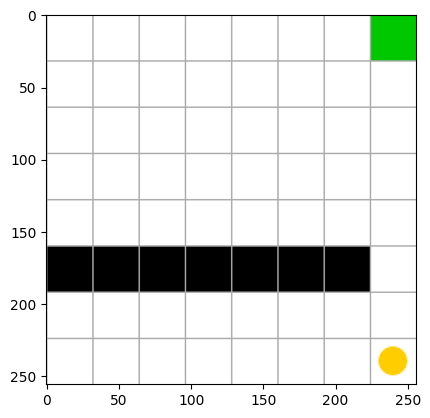

In [5]:
ENV = EnvFactory.Grid_2D_8x8_discrete

# Grid configuration
OBSTACLE = obstacle_selected.value
INITIAL_STATE = (7, 7)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config)

snapshot_env(env)

### STEP 2: Create Minari datasets

**Behavior policies and datasets configurations**

In [6]:
BEHAVIOR_POLICY_I = BehaviorPolicy2dGridFactory.move_up
DATA_SET_IDENTIFIER_I = "_expert"
NUM_STEPS_I = 1000

BEHAVIOR_POLICY_II = BehaviorPolicy2dGridFactory.move_left
DATA_SET_IDENTIFIER_II = "_suboptimal"
NUM_STEPS_II = 2000

In [7]:
policy_selected = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicy2dGridFactory.move_up: 'move_up'>, <BehaviorPolicy2dGridFactory.move_left: 'm…

In [8]:
offpolicy_rendering(
    env_or_env_name=ENV,
    render_mode=render_mode,
    behavior_policy=policy_selected.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
)

**Collect data**

In [9]:
from offline_rl.generate_custom_minari_datasets.generate_minari_dataset import (
    create_combined_minari_dataset,
)

config_combined_data = create_combined_minari_dataset(
    env_name=ENV,
    dataset_identifiers=(DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
    num_collected_points=(NUM_STEPS_I, NUM_STEPS_II),
    behavior_policies=(BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
    combined_dataset_identifier="combined_data_sets_offline_rl",
    env_2d_grid_initial_config=env_2D_grid_initial_config,
)

dataset_availables = [
    config_combined_data.data_set_name
] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Number of episodes in dataset I:20, in dataset II:40 and  in the combined dataset: 60


Dropdown(options=('Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0', 'Grid_2D_8x8_discrete-data_obstacle…

### STEP 3: Feed data into replay buffer

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 60


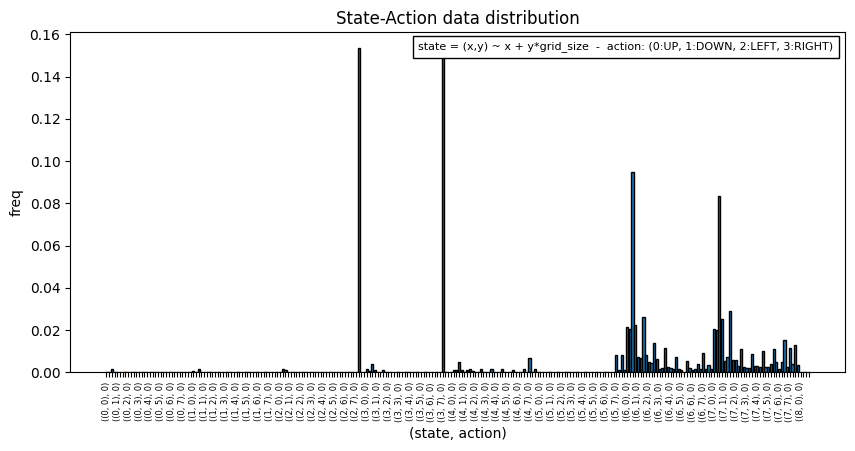

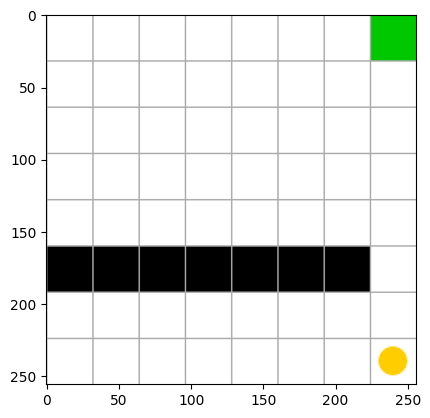

In [10]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
snapshot_env(env)

#### Data analysis

Note that we have four peaks. The ones at (2,7) and (3,7) come from policy-I, which goes towards the target but stops before reaching it. The other two peaks at (6,0) and (7,0) are produced by policy-II, which drifts the agent to the left with noise. **It is important to notice that the amount of collected data at state (5,7) is very little, but this state is crucial if we want to approach the target.**

What do you think a BC algorithm would do? What about an offline one?

<div style="margin-top: 20px;">
    <div style="display: flex; justify-content: space-between;">
        <div style="width: 100%;">
            <img src="_static/images/nb_96_critical_state.png" alt="Snow" style="width:100%;">
        </div>
        <div style="width: 100%;">
            <img src="_static/images/96_critical_action_states.png" alt="KL divergence" width=80%>
        </div>
    </div>
</div>

### STEP 4-5: Select offline policies and training

In [11]:
from offline_rl.offline_policies.policy_registry import RLPolicyFactory

offline_rl_policies = [
    RLPolicyFactory.bcq_discrete,
    RLPolicyFactory.cql_discrete,
    RLPolicyFactory.imitation_learning,
]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<RLPolicyFactory.bcq_discrete: 'bcq_discrete'>, <RLPolicyFactory.cql_discrete: 'cql_discrete…

**Training**

In [12]:
NUM_EPOCHS = 2
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0 * len_buffer
NUMBER_TEST_ENVS = 1

# Metadata for the offline policy. Included the Minari metadata as well as the policy model configuration.
offline_policy_config = TrainedPolicyConfig(
    rl_policy_model=selected_offline_rl_policy.value,
    name_expert_data=selected_data_set.value,
    render_mode=render_mode,
    device="cpu",
)

# Hyperparameters to be used in the training.
offline_training_hyperparams = OfflineTrainingHyperparams(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

In [13]:
conditional_capture(OfflineRLTraining.training(offline_training_hyperparams))

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_data_sets_offline_rl-v0 downloaded. number of episodes: 60


Epoch #1:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch #1:   0%|          | 1/3000 [00:00<00:25, 118.02it/s, gradient_step=1]

Epoch #1:   0%|          | 2/3000 [00:00<00:21, 141.33it/s, gradient_step=2]

Epoch #1:   0%|          | 3/3000 [00:00<00:19, 152.02it/s, gradient_step=3]

Epoch #1:   0%|          | 4/3000 [00:00<00:18, 164.25it/s, gradient_step=4]

Epoch #1:   0%|          | 5/3000 [00:00<00:17, 171.18it/s, gradient_step=5]

Epoch #1:   0%|          | 6/3000 [00:00<00:16, 176.12it/s, gradient_step=6]

Epoch #1:   0%|          | 7/3000 [00:00<00:16, 180.53it/s, gradient_step=7]

Epoch #1:   0%|          | 8/3000 [00:00<00:16, 183.19it/s, gradient_step=8]

Epoch #1:   0%|          | 9/3000 [00:00<00:16, 186.42it/s, gradient_step=9]

Epoch #1:   0%|          | 10/3000 [00:00<00:16, 185.88it/s, gradient_step=10]

Epoch #1:   0%|          | 11/3000 [00:00<00:16, 185.04it/s, gradient_step=11]

Epoch #1:   0%|          | 12/3000 [00:00<00:16, 184.82it/s, gradient_step=12]

Epoch #1:   0%|          | 13/3000 [00:00<00:15, 186.84it/s, gradient_step=13]

Epoch #1:   0%|          | 14/3000 [00:00<00:15, 188.60it/s, gradient_step=14]

Epoch #1:   0%|          | 15/3000 [00:00<00:15, 190.30it/s, gradient_step=15]

Epoch #1:   1%|          | 16/3000 [00:00<00:15, 191.64it/s, gradient_step=16]

Epoch #1:   1%|          | 17/3000 [00:00<00:15, 192.58it/s, gradient_step=17]

Epoch #1:   1%|          | 18/3000 [00:00<00:15, 193.77it/s, gradient_step=18]

Epoch #1:   1%|          | 19/3000 [00:00<00:15, 194.57it/s, gradient_step=19]

Epoch #1:   1%|          | 20/3000 [00:00<00:15, 195.61it/s, gradient_step=20]

Epoch #1:   1%|          | 21/3000 [00:00<00:14, 204.67it/s, gradient_step=20]

Epoch #1:   1%|          | 21/3000 [00:00<00:14, 204.67it/s, gradient_step=21]

Epoch #1:   1%|          | 22/3000 [00:00<00:14, 204.67it/s, gradient_step=22]

Epoch #1:   1%|          | 23/3000 [00:00<00:14, 204.67it/s, gradient_step=23]

Epoch #1:   1%|          | 24/3000 [00:00<00:14, 204.67it/s, gradient_step=24]

Epoch #1:   1%|          | 25/3000 [00:00<00:14, 204.67it/s, gradient_step=25]

Epoch #1:   1%|          | 26/3000 [00:00<00:14, 204.67it/s, gradient_step=26]

Epoch #1:   1%|          | 27/3000 [00:00<00:14, 204.67it/s, gradient_step=27]

Epoch #1:   1%|          | 28/3000 [00:00<00:14, 204.67it/s, gradient_step=28]

Epoch #1:   1%|          | 29/3000 [00:00<00:14, 204.67it/s, gradient_step=29]

Epoch #1:   1%|1         | 30/3000 [00:00<00:14, 204.67it/s, gradient_step=30]

Epoch #1:   1%|1         | 31/3000 [00:00<00:14, 204.67it/s, gradient_step=31]

Epoch #1:   1%|1         | 32/3000 [00:00<00:14, 204.67it/s, gradient_step=32]

Epoch #1:   1%|1         | 33/3000 [00:00<00:14, 204.67it/s, gradient_step=33]

Epoch #1:   1%|1         | 34/3000 [00:00<00:14, 204.67it/s, gradient_step=34]

Epoch #1:   1%|1         | 35/3000 [00:00<00:14, 204.67it/s, gradient_step=35]

Epoch #1:   1%|1         | 36/3000 [00:00<00:14, 204.67it/s, gradient_step=36]

Epoch #1:   1%|1         | 37/3000 [00:00<00:14, 204.67it/s, gradient_step=37]

Epoch #1:   1%|1         | 38/3000 [00:00<00:14, 204.67it/s, gradient_step=38]

Epoch #1:   1%|1         | 39/3000 [00:00<00:14, 204.67it/s, gradient_step=39]

Epoch #1:   1%|1         | 40/3000 [00:00<00:14, 204.67it/s, gradient_step=40]

Epoch #1:   1%|1         | 41/3000 [00:00<00:14, 204.67it/s, gradient_step=41]

Epoch #1:   1%|1         | 42/3000 [00:00<00:14, 204.67it/s, gradient_step=42]

Epoch #1:   1%|1         | 43/3000 [00:00<00:14, 209.03it/s, gradient_step=42]

Epoch #1:   1%|1         | 43/3000 [00:00<00:14, 209.03it/s, gradient_step=43]

Epoch #1:   1%|1         | 44/3000 [00:00<00:14, 209.03it/s, gradient_step=44]

Epoch #1:   2%|1         | 45/3000 [00:00<00:14, 209.03it/s, gradient_step=45]

Epoch #1:   2%|1         | 46/3000 [00:00<00:14, 209.03it/s, gradient_step=46]

Epoch #1:   2%|1         | 47/3000 [00:00<00:14, 209.03it/s, gradient_step=47]

Epoch #1:   2%|1         | 48/3000 [00:00<00:14, 209.03it/s, gradient_step=48]

Epoch #1:   2%|1         | 49/3000 [00:00<00:14, 209.03it/s, gradient_step=49]

Epoch #1:   2%|1         | 50/3000 [00:00<00:14, 209.03it/s, gradient_step=50]

Epoch #1:   2%|1         | 51/3000 [00:00<00:14, 209.03it/s, gradient_step=51]

Epoch #1:   2%|1         | 52/3000 [00:00<00:14, 209.03it/s, gradient_step=52]

Epoch #1:   2%|1         | 53/3000 [00:00<00:14, 209.03it/s, gradient_step=53]

Epoch #1:   2%|1         | 54/3000 [00:00<00:14, 209.03it/s, gradient_step=54]

Epoch #1:   2%|1         | 55/3000 [00:00<00:14, 209.03it/s, gradient_step=55]

Epoch #1:   2%|1         | 56/3000 [00:00<00:14, 209.03it/s, gradient_step=56]

Epoch #1:   2%|1         | 57/3000 [00:00<00:14, 209.03it/s, gradient_step=57]

Epoch #1:   2%|1         | 58/3000 [00:00<00:14, 209.03it/s, gradient_step=58]

Epoch #1:   2%|1         | 59/3000 [00:00<00:14, 209.03it/s, gradient_step=59]

Epoch #1:   2%|2         | 60/3000 [00:00<00:14, 209.03it/s, gradient_step=60]

Epoch #1:   2%|2         | 61/3000 [00:00<00:14, 209.03it/s, gradient_step=61]

Epoch #1:   2%|2         | 62/3000 [00:00<00:14, 209.03it/s, gradient_step=62]

Epoch #1:   2%|2         | 63/3000 [00:00<00:14, 209.03it/s, gradient_step=63]

Epoch #1:   2%|2         | 64/3000 [00:00<00:14, 209.03it/s, gradient_step=64]

Epoch #1:   2%|2         | 65/3000 [00:00<00:14, 209.10it/s, gradient_step=64]

Epoch #1:   2%|2         | 65/3000 [00:00<00:14, 209.10it/s, gradient_step=65]

Epoch #1:   2%|2         | 66/3000 [00:00<00:14, 209.10it/s, gradient_step=66]

Epoch #1:   2%|2         | 67/3000 [00:00<00:14, 209.10it/s, gradient_step=67]

Epoch #1:   2%|2         | 68/3000 [00:00<00:14, 209.10it/s, gradient_step=68]

Epoch #1:   2%|2         | 69/3000 [00:00<00:14, 209.10it/s, gradient_step=69]

Epoch #1:   2%|2         | 70/3000 [00:00<00:14, 209.10it/s, gradient_step=70]

Epoch #1:   2%|2         | 71/3000 [00:00<00:14, 209.10it/s, gradient_step=71]

Epoch #1:   2%|2         | 72/3000 [00:00<00:14, 209.10it/s, gradient_step=72]

Epoch #1:   2%|2         | 73/3000 [00:00<00:13, 209.10it/s, gradient_step=73]

Epoch #1:   2%|2         | 74/3000 [00:00<00:13, 209.10it/s, gradient_step=74]

Epoch #1:   2%|2         | 75/3000 [00:00<00:13, 209.10it/s, gradient_step=75]

Epoch #1:   3%|2         | 76/3000 [00:00<00:13, 209.10it/s, gradient_step=76]

Epoch #1:   3%|2         | 77/3000 [00:00<00:13, 209.10it/s, gradient_step=77]

Epoch #1:   3%|2         | 78/3000 [00:00<00:13, 209.10it/s, gradient_step=78]

Epoch #1:   3%|2         | 79/3000 [00:00<00:13, 209.10it/s, gradient_step=79]

Epoch #1:   3%|2         | 80/3000 [00:00<00:13, 209.10it/s, gradient_step=80]

Epoch #1:   3%|2         | 81/3000 [00:00<00:13, 209.10it/s, gradient_step=81]

Epoch #1:   3%|2         | 82/3000 [00:00<00:13, 209.10it/s, gradient_step=82]

Epoch #1:   3%|2         | 83/3000 [00:00<00:13, 209.10it/s, gradient_step=83]

Epoch #1:   3%|2         | 84/3000 [00:00<00:13, 209.10it/s, gradient_step=84]

Epoch #1:   3%|2         | 85/3000 [00:00<00:13, 209.10it/s, gradient_step=85]

Epoch #1:   3%|2         | 86/3000 [00:00<00:14, 204.55it/s, gradient_step=85]

Epoch #1:   3%|2         | 86/3000 [00:00<00:14, 204.55it/s, gradient_step=86]

Epoch #1:   3%|2         | 87/3000 [00:00<00:14, 204.55it/s, gradient_step=87]

Epoch #1:   3%|2         | 88/3000 [00:00<00:14, 204.55it/s, gradient_step=88]

Epoch #1:   3%|2         | 89/3000 [00:00<00:14, 204.55it/s, gradient_step=89]

Epoch #1:   3%|3         | 90/3000 [00:00<00:14, 204.55it/s, gradient_step=90]

Epoch #1:   3%|3         | 91/3000 [00:00<00:14, 204.55it/s, gradient_step=91]

Epoch #1:   3%|3         | 92/3000 [00:00<00:14, 204.55it/s, gradient_step=92]

Epoch #1:   3%|3         | 93/3000 [00:00<00:14, 204.55it/s, gradient_step=93]

Epoch #1:   3%|3         | 94/3000 [00:00<00:14, 204.55it/s, gradient_step=94]

Epoch #1:   3%|3         | 95/3000 [00:00<00:14, 204.55it/s, gradient_step=95]

Epoch #1:   3%|3         | 96/3000 [00:00<00:14, 204.55it/s, gradient_step=96]

Epoch #1:   3%|3         | 97/3000 [00:00<00:14, 204.55it/s, gradient_step=97]

Epoch #1:   3%|3         | 98/3000 [00:00<00:14, 204.55it/s, gradient_step=98]

Epoch #1:   3%|3         | 99/3000 [00:00<00:14, 204.55it/s, gradient_step=99]

Epoch #1:   3%|3         | 100/3000 [00:00<00:14, 204.55it/s, gradient_step=100]

Epoch #1:   3%|3         | 101/3000 [00:00<00:14, 204.55it/s, gradient_step=101]

Epoch #1:   3%|3         | 102/3000 [00:00<00:14, 204.55it/s, gradient_step=102]

Epoch #1:   3%|3         | 103/3000 [00:00<00:14, 204.55it/s, gradient_step=103]

Epoch #1:   3%|3         | 104/3000 [00:00<00:14, 204.55it/s, gradient_step=104]

Epoch #1:   4%|3         | 105/3000 [00:00<00:14, 204.55it/s, gradient_step=105]

Epoch #1:   4%|3         | 106/3000 [00:00<00:14, 204.55it/s, gradient_step=106]

Epoch #1:   4%|3         | 107/3000 [00:00<00:14, 202.36it/s, gradient_step=106]

Epoch #1:   4%|3         | 107/3000 [00:00<00:14, 202.36it/s, gradient_step=107]

Epoch #1:   4%|3         | 108/3000 [00:00<00:14, 202.36it/s, gradient_step=108]

Epoch #1:   4%|3         | 109/3000 [00:00<00:14, 202.36it/s, gradient_step=109]

Epoch #1:   4%|3         | 110/3000 [00:00<00:14, 202.36it/s, gradient_step=110]

Epoch #1:   4%|3         | 111/3000 [00:00<00:14, 202.36it/s, gradient_step=111]

Epoch #1:   4%|3         | 112/3000 [00:00<00:14, 202.36it/s, gradient_step=112]

Epoch #1:   4%|3         | 113/3000 [00:00<00:14, 202.36it/s, gradient_step=113]

Epoch #1:   4%|3         | 114/3000 [00:00<00:14, 202.36it/s, gradient_step=114]

Epoch #1:   4%|3         | 115/3000 [00:00<00:14, 202.36it/s, gradient_step=115]

Epoch #1:   4%|3         | 116/3000 [00:00<00:14, 202.36it/s, gradient_step=116]

Epoch #1:   4%|3         | 117/3000 [00:00<00:14, 202.36it/s, gradient_step=117]

Epoch #1:   4%|3         | 118/3000 [00:00<00:14, 202.36it/s, gradient_step=118]

Epoch #1:   4%|3         | 119/3000 [00:00<00:14, 202.36it/s, gradient_step=119]

Epoch #1:   4%|4         | 120/3000 [00:00<00:14, 202.36it/s, gradient_step=120]

Epoch #1:   4%|4         | 121/3000 [00:00<00:14, 202.36it/s, gradient_step=121]

Epoch #1:   4%|4         | 122/3000 [00:00<00:14, 202.36it/s, gradient_step=122]

Epoch #1:   4%|4         | 123/3000 [00:00<00:14, 202.36it/s, gradient_step=123]

Epoch #1:   4%|4         | 124/3000 [00:00<00:14, 202.36it/s, gradient_step=124]

Epoch #1:   4%|4         | 125/3000 [00:00<00:14, 202.36it/s, gradient_step=125]

Epoch #1:   4%|4         | 126/3000 [00:00<00:14, 202.36it/s, gradient_step=126]

Epoch #1:   4%|4         | 127/3000 [00:00<00:14, 202.36it/s, gradient_step=127]

Epoch #1:   4%|4         | 128/3000 [00:00<00:14, 198.53it/s, gradient_step=127]

Epoch #1:   4%|4         | 128/3000 [00:00<00:14, 198.53it/s, gradient_step=128]

Epoch #1:   4%|4         | 129/3000 [00:00<00:14, 198.53it/s, gradient_step=129]

Epoch #1:   4%|4         | 130/3000 [00:00<00:14, 198.53it/s, gradient_step=130]

Epoch #1:   4%|4         | 131/3000 [00:00<00:14, 198.53it/s, gradient_step=131]

Epoch #1:   4%|4         | 132/3000 [00:00<00:14, 198.53it/s, gradient_step=132]

Epoch #1:   4%|4         | 133/3000 [00:00<00:14, 198.53it/s, gradient_step=133]

Epoch #1:   4%|4         | 134/3000 [00:00<00:14, 198.53it/s, gradient_step=134]

Epoch #1:   4%|4         | 135/3000 [00:00<00:14, 198.53it/s, gradient_step=135]

Epoch #1:   5%|4         | 136/3000 [00:00<00:14, 198.53it/s, gradient_step=136]

Epoch #1:   5%|4         | 137/3000 [00:00<00:14, 198.53it/s, gradient_step=137]

Epoch #1:   5%|4         | 138/3000 [00:00<00:14, 198.53it/s, gradient_step=138]

Epoch #1:   5%|4         | 139/3000 [00:00<00:14, 198.53it/s, gradient_step=139]

Epoch #1:   5%|4         | 140/3000 [00:00<00:14, 198.53it/s, gradient_step=140]

Epoch #1:   5%|4         | 141/3000 [00:00<00:14, 198.53it/s, gradient_step=141]

Epoch #1:   5%|4         | 142/3000 [00:00<00:14, 198.53it/s, gradient_step=142]

Epoch #1:   5%|4         | 143/3000 [00:00<00:14, 198.53it/s, gradient_step=143]

Epoch #1:   5%|4         | 144/3000 [00:00<00:14, 198.53it/s, gradient_step=144]

Epoch #1:   5%|4         | 145/3000 [00:00<00:14, 198.53it/s, gradient_step=145]

Epoch #1:   5%|4         | 146/3000 [00:00<00:14, 198.53it/s, gradient_step=146]

Epoch #1:   5%|4         | 147/3000 [00:00<00:14, 198.53it/s, gradient_step=147]

Epoch #1:   5%|4         | 148/3000 [00:00<00:14, 198.53it/s, gradient_step=148]

Epoch #1:   5%|4         | 149/3000 [00:00<00:14, 198.53it/s, gradient_step=149]

Epoch #1:   5%|5         | 150/3000 [00:00<00:14, 202.99it/s, gradient_step=149]

Epoch #1:   5%|5         | 150/3000 [00:00<00:14, 202.99it/s, gradient_step=150]

Epoch #1:   5%|5         | 151/3000 [00:00<00:14, 202.99it/s, gradient_step=151]

Epoch #1:   5%|5         | 152/3000 [00:00<00:14, 202.99it/s, gradient_step=152]

Epoch #1:   5%|5         | 153/3000 [00:00<00:14, 202.99it/s, gradient_step=153]

Epoch #1:   5%|5         | 154/3000 [00:00<00:14, 202.99it/s, gradient_step=154]

Epoch #1:   5%|5         | 155/3000 [00:00<00:14, 202.99it/s, gradient_step=155]

Epoch #1:   5%|5         | 156/3000 [00:00<00:14, 202.99it/s, gradient_step=156]

Epoch #1:   5%|5         | 157/3000 [00:00<00:14, 202.99it/s, gradient_step=157]

Epoch #1:   5%|5         | 158/3000 [00:00<00:14, 202.99it/s, gradient_step=158]

Epoch #1:   5%|5         | 159/3000 [00:00<00:13, 202.99it/s, gradient_step=159]

Epoch #1:   5%|5         | 160/3000 [00:00<00:13, 202.99it/s, gradient_step=160]

Epoch #1:   5%|5         | 161/3000 [00:00<00:13, 202.99it/s, gradient_step=161]

Epoch #1:   5%|5         | 162/3000 [00:00<00:13, 202.99it/s, gradient_step=162]

Epoch #1:   5%|5         | 163/3000 [00:00<00:13, 202.99it/s, gradient_step=163]

Epoch #1:   5%|5         | 164/3000 [00:00<00:13, 202.99it/s, gradient_step=164]

Epoch #1:   6%|5         | 165/3000 [00:00<00:13, 202.99it/s, gradient_step=165]

Epoch #1:   6%|5         | 166/3000 [00:00<00:13, 202.99it/s, gradient_step=166]

Epoch #1:   6%|5         | 167/3000 [00:00<00:13, 202.99it/s, gradient_step=167]

Epoch #1:   6%|5         | 168/3000 [00:00<00:13, 202.99it/s, gradient_step=168]

Epoch #1:   6%|5         | 169/3000 [00:00<00:13, 202.99it/s, gradient_step=169]

Epoch #1:   6%|5         | 170/3000 [00:00<00:13, 202.99it/s, gradient_step=170]

Epoch #1:   6%|5         | 171/3000 [00:00<00:13, 202.99it/s, gradient_step=171]

Epoch #1:   6%|5         | 172/3000 [00:00<00:13, 205.48it/s, gradient_step=171]

Epoch #1:   6%|5         | 172/3000 [00:00<00:13, 205.48it/s, gradient_step=172]

Epoch #1:   6%|5         | 173/3000 [00:00<00:13, 205.48it/s, gradient_step=173]

Epoch #1:   6%|5         | 174/3000 [00:00<00:13, 205.48it/s, gradient_step=174]

Epoch #1:   6%|5         | 175/3000 [00:00<00:13, 205.48it/s, gradient_step=175]

Epoch #1:   6%|5         | 176/3000 [00:00<00:13, 205.48it/s, gradient_step=176]

Epoch #1:   6%|5         | 177/3000 [00:00<00:13, 205.48it/s, gradient_step=177]

Epoch #1:   6%|5         | 178/3000 [00:00<00:13, 205.48it/s, gradient_step=178]

Epoch #1:   6%|5         | 179/3000 [00:00<00:13, 205.48it/s, gradient_step=179]

Epoch #1:   6%|6         | 180/3000 [00:00<00:13, 205.48it/s, gradient_step=180]

Epoch #1:   6%|6         | 181/3000 [00:00<00:13, 205.48it/s, gradient_step=181]

Epoch #1:   6%|6         | 182/3000 [00:00<00:13, 205.48it/s, gradient_step=182]

Epoch #1:   6%|6         | 183/3000 [00:00<00:13, 205.48it/s, gradient_step=183]

Epoch #1:   6%|6         | 184/3000 [00:00<00:13, 205.48it/s, gradient_step=184]

Epoch #1:   6%|6         | 185/3000 [00:00<00:13, 205.48it/s, gradient_step=185]

Epoch #1:   6%|6         | 186/3000 [00:00<00:13, 205.48it/s, gradient_step=186]

Epoch #1:   6%|6         | 187/3000 [00:00<00:13, 205.48it/s, gradient_step=187]

Epoch #1:   6%|6         | 188/3000 [00:00<00:13, 205.48it/s, gradient_step=188]

Epoch #1:   6%|6         | 189/3000 [00:00<00:13, 205.48it/s, gradient_step=189]

Epoch #1:   6%|6         | 190/3000 [00:00<00:13, 205.48it/s, gradient_step=190]

Epoch #1:   6%|6         | 191/3000 [00:00<00:13, 205.48it/s, gradient_step=191]

Epoch #1:   6%|6         | 192/3000 [00:00<00:13, 205.48it/s, gradient_step=192]

Epoch #1:   6%|6         | 193/3000 [00:00<00:13, 206.84it/s, gradient_step=192]

Epoch #1:   6%|6         | 193/3000 [00:00<00:13, 206.84it/s, gradient_step=193]

Epoch #1:   6%|6         | 194/3000 [00:00<00:13, 206.84it/s, gradient_step=194]

Epoch #1:   6%|6         | 195/3000 [00:00<00:13, 206.84it/s, gradient_step=195]

Epoch #1:   7%|6         | 196/3000 [00:00<00:13, 206.84it/s, gradient_step=196]

Epoch #1:   7%|6         | 197/3000 [00:00<00:13, 206.84it/s, gradient_step=197]

Epoch #1:   7%|6         | 198/3000 [00:00<00:13, 206.84it/s, gradient_step=198]

Epoch #1:   7%|6         | 199/3000 [00:00<00:13, 206.84it/s, gradient_step=199]

Epoch #1:   7%|6         | 200/3000 [00:00<00:13, 206.84it/s, gradient_step=200]

Epoch #1:   7%|6         | 201/3000 [00:00<00:13, 206.84it/s, gradient_step=201]

Epoch #1:   7%|6         | 202/3000 [00:00<00:13, 206.84it/s, gradient_step=202]

Epoch #1:   7%|6         | 203/3000 [00:00<00:13, 206.84it/s, gradient_step=203]

Epoch #1:   7%|6         | 204/3000 [00:00<00:13, 206.84it/s, gradient_step=204]

Epoch #1:   7%|6         | 205/3000 [00:01<00:13, 206.84it/s, gradient_step=205]

Epoch #1:   7%|6         | 206/3000 [00:01<00:13, 206.84it/s, gradient_step=206]

Epoch #1:   7%|6         | 207/3000 [00:01<00:13, 206.84it/s, gradient_step=207]

Epoch #1:   7%|6         | 208/3000 [00:01<00:13, 206.84it/s, gradient_step=208]

Epoch #1:   7%|6         | 209/3000 [00:01<00:13, 206.84it/s, gradient_step=209]

Epoch #1:   7%|7         | 210/3000 [00:01<00:13, 206.84it/s, gradient_step=210]

Epoch #1:   7%|7         | 211/3000 [00:01<00:13, 206.84it/s, gradient_step=211]

Epoch #1:   7%|7         | 212/3000 [00:01<00:13, 206.84it/s, gradient_step=212]

Epoch #1:   7%|7         | 213/3000 [00:01<00:13, 206.84it/s, gradient_step=213]

Epoch #1:   7%|7         | 214/3000 [00:01<00:13, 206.84it/s, gradient_step=214]

Epoch #1:   7%|7         | 215/3000 [00:01<00:13, 208.14it/s, gradient_step=214]

Epoch #1:   7%|7         | 215/3000 [00:01<00:13, 208.14it/s, gradient_step=215]

Epoch #1:   7%|7         | 216/3000 [00:01<00:13, 208.14it/s, gradient_step=216]

Epoch #1:   7%|7         | 217/3000 [00:01<00:13, 208.14it/s, gradient_step=217]

Epoch #1:   7%|7         | 218/3000 [00:01<00:13, 208.14it/s, gradient_step=218]

Epoch #1:   7%|7         | 219/3000 [00:01<00:13, 208.14it/s, gradient_step=219]

Epoch #1:   7%|7         | 220/3000 [00:01<00:13, 208.14it/s, gradient_step=220]

Epoch #1:   7%|7         | 221/3000 [00:01<00:13, 208.14it/s, gradient_step=221]

Epoch #1:   7%|7         | 222/3000 [00:01<00:13, 208.14it/s, gradient_step=222]

Epoch #1:   7%|7         | 223/3000 [00:01<00:13, 208.14it/s, gradient_step=223]

Epoch #1:   7%|7         | 224/3000 [00:01<00:13, 208.14it/s, gradient_step=224]

Epoch #1:   8%|7         | 225/3000 [00:01<00:13, 208.14it/s, gradient_step=225]

Epoch #1:   8%|7         | 226/3000 [00:01<00:13, 208.14it/s, gradient_step=226]

Epoch #1:   8%|7         | 227/3000 [00:01<00:13, 208.14it/s, gradient_step=227]

Epoch #1:   8%|7         | 228/3000 [00:01<00:13, 208.14it/s, gradient_step=228]

Epoch #1:   8%|7         | 229/3000 [00:01<00:13, 208.14it/s, gradient_step=229]

Epoch #1:   8%|7         | 230/3000 [00:01<00:13, 208.14it/s, gradient_step=230]

Epoch #1:   8%|7         | 231/3000 [00:01<00:13, 208.14it/s, gradient_step=231]

Epoch #1:   8%|7         | 232/3000 [00:01<00:13, 208.14it/s, gradient_step=232]

Epoch #1:   8%|7         | 233/3000 [00:01<00:13, 208.14it/s, gradient_step=233]

Epoch #1:   8%|7         | 234/3000 [00:01<00:13, 208.14it/s, gradient_step=234]

Epoch #1:   8%|7         | 235/3000 [00:01<00:13, 208.14it/s, gradient_step=235]

Epoch #1:   8%|7         | 236/3000 [00:01<00:13, 208.14it/s, gradient_step=236]

Epoch #1:   8%|7         | 237/3000 [00:01<00:13, 209.68it/s, gradient_step=236]

Epoch #1:   8%|7         | 237/3000 [00:01<00:13, 209.68it/s, gradient_step=237]

Epoch #1:   8%|7         | 238/3000 [00:01<00:13, 209.68it/s, gradient_step=238]

Epoch #1:   8%|7         | 239/3000 [00:01<00:13, 209.68it/s, gradient_step=239]

Epoch #1:   8%|8         | 240/3000 [00:01<00:13, 209.68it/s, gradient_step=240]

Epoch #1:   8%|8         | 241/3000 [00:01<00:13, 209.68it/s, gradient_step=241]

Epoch #1:   8%|8         | 242/3000 [00:01<00:13, 209.68it/s, gradient_step=242]

Epoch #1:   8%|8         | 243/3000 [00:01<00:13, 209.68it/s, gradient_step=243]

Epoch #1:   8%|8         | 244/3000 [00:01<00:13, 209.68it/s, gradient_step=244]

Epoch #1:   8%|8         | 245/3000 [00:01<00:13, 209.68it/s, gradient_step=245]

Epoch #1:   8%|8         | 246/3000 [00:01<00:13, 209.68it/s, gradient_step=246]

Epoch #1:   8%|8         | 247/3000 [00:01<00:13, 209.68it/s, gradient_step=247]

Epoch #1:   8%|8         | 248/3000 [00:01<00:13, 209.68it/s, gradient_step=248]

Epoch #1:   8%|8         | 249/3000 [00:01<00:13, 209.68it/s, gradient_step=249]

Epoch #1:   8%|8         | 250/3000 [00:01<00:13, 209.68it/s, gradient_step=250]

Epoch #1:   8%|8         | 251/3000 [00:01<00:13, 209.68it/s, gradient_step=251]

Epoch #1:   8%|8         | 252/3000 [00:01<00:13, 209.68it/s, gradient_step=252]

Epoch #1:   8%|8         | 253/3000 [00:01<00:13, 209.68it/s, gradient_step=253]

Epoch #1:   8%|8         | 254/3000 [00:01<00:13, 209.68it/s, gradient_step=254]

Epoch #1:   8%|8         | 255/3000 [00:01<00:13, 209.68it/s, gradient_step=255]

Epoch #1:   9%|8         | 256/3000 [00:01<00:13, 209.68it/s, gradient_step=256]

Epoch #1:   9%|8         | 257/3000 [00:01<00:13, 209.68it/s, gradient_step=257]

Epoch #1:   9%|8         | 258/3000 [00:01<00:13, 209.68it/s, gradient_step=258]

Epoch #1:   9%|8         | 259/3000 [00:01<00:13, 210.27it/s, gradient_step=258]

Epoch #1:   9%|8         | 259/3000 [00:01<00:13, 210.27it/s, gradient_step=259]

Epoch #1:   9%|8         | 260/3000 [00:01<00:13, 210.27it/s, gradient_step=260]

Epoch #1:   9%|8         | 261/3000 [00:01<00:13, 210.27it/s, gradient_step=261]

Epoch #1:   9%|8         | 262/3000 [00:01<00:13, 210.27it/s, gradient_step=262]

Epoch #1:   9%|8         | 263/3000 [00:01<00:13, 210.27it/s, gradient_step=263]

Epoch #1:   9%|8         | 264/3000 [00:01<00:13, 210.27it/s, gradient_step=264]

Epoch #1:   9%|8         | 265/3000 [00:01<00:13, 210.27it/s, gradient_step=265]

Epoch #1:   9%|8         | 266/3000 [00:01<00:13, 210.27it/s, gradient_step=266]

Epoch #1:   9%|8         | 267/3000 [00:01<00:12, 210.27it/s, gradient_step=267]

Epoch #1:   9%|8         | 268/3000 [00:01<00:12, 210.27it/s, gradient_step=268]

Epoch #1:   9%|8         | 269/3000 [00:01<00:12, 210.27it/s, gradient_step=269]

Epoch #1:   9%|9         | 270/3000 [00:01<00:12, 210.27it/s, gradient_step=270]

Epoch #1:   9%|9         | 271/3000 [00:01<00:12, 210.27it/s, gradient_step=271]

Epoch #1:   9%|9         | 272/3000 [00:01<00:12, 210.27it/s, gradient_step=272]

Epoch #1:   9%|9         | 273/3000 [00:01<00:12, 210.27it/s, gradient_step=273]

Epoch #1:   9%|9         | 274/3000 [00:01<00:12, 210.27it/s, gradient_step=274]

Epoch #1:   9%|9         | 275/3000 [00:01<00:12, 210.27it/s, gradient_step=275]

Epoch #1:   9%|9         | 276/3000 [00:01<00:12, 210.27it/s, gradient_step=276]

Epoch #1:   9%|9         | 277/3000 [00:01<00:12, 210.27it/s, gradient_step=277]

Epoch #1:   9%|9         | 278/3000 [00:01<00:12, 210.27it/s, gradient_step=278]

Epoch #1:   9%|9         | 279/3000 [00:01<00:12, 210.27it/s, gradient_step=279]

Epoch #1:   9%|9         | 280/3000 [00:01<00:12, 210.27it/s, gradient_step=280]

Epoch #1:   9%|9         | 281/3000 [00:01<00:12, 211.35it/s, gradient_step=280]

Epoch #1:   9%|9         | 281/3000 [00:01<00:12, 211.35it/s, gradient_step=281]

Epoch #1:   9%|9         | 282/3000 [00:01<00:12, 211.35it/s, gradient_step=282]

Epoch #1:   9%|9         | 283/3000 [00:01<00:12, 211.35it/s, gradient_step=283]

Epoch #1:   9%|9         | 284/3000 [00:01<00:12, 211.35it/s, gradient_step=284]

Epoch #1:  10%|9         | 285/3000 [00:01<00:12, 211.35it/s, gradient_step=285]

Epoch #1:  10%|9         | 286/3000 [00:01<00:12, 211.35it/s, gradient_step=286]

Epoch #1:  10%|9         | 287/3000 [00:01<00:12, 211.35it/s, gradient_step=287]

Epoch #1:  10%|9         | 288/3000 [00:01<00:12, 211.35it/s, gradient_step=288]

Epoch #1:  10%|9         | 289/3000 [00:01<00:12, 211.35it/s, gradient_step=289]

Epoch #1:  10%|9         | 290/3000 [00:01<00:12, 211.35it/s, gradient_step=290]

Epoch #1:  10%|9         | 291/3000 [00:01<00:12, 211.35it/s, gradient_step=291]

Epoch #1:  10%|9         | 292/3000 [00:01<00:12, 211.35it/s, gradient_step=292]

Epoch #1:  10%|9         | 293/3000 [00:01<00:12, 211.35it/s, gradient_step=293]

Epoch #1:  10%|9         | 294/3000 [00:01<00:12, 211.35it/s, gradient_step=294]

Epoch #1:  10%|9         | 295/3000 [00:01<00:12, 211.35it/s, gradient_step=295]

Epoch #1:  10%|9         | 296/3000 [00:01<00:12, 211.35it/s, gradient_step=296]

Epoch #1:  10%|9         | 297/3000 [00:01<00:12, 211.35it/s, gradient_step=297]

Epoch #1:  10%|9         | 298/3000 [00:01<00:12, 211.35it/s, gradient_step=298]

Epoch #1:  10%|9         | 299/3000 [00:01<00:12, 211.35it/s, gradient_step=299]

Epoch #1:  10%|#         | 300/3000 [00:01<00:12, 211.35it/s, gradient_step=300]

Epoch #1:  10%|#         | 301/3000 [00:01<00:12, 211.35it/s, gradient_step=301]

Epoch #1:  10%|#         | 302/3000 [00:01<00:12, 211.35it/s, gradient_step=302]

Epoch #1:  10%|#         | 303/3000 [00:01<00:12, 209.44it/s, gradient_step=302]

Epoch #1:  10%|#         | 303/3000 [00:01<00:12, 209.44it/s, gradient_step=303]

Epoch #1:  10%|#         | 304/3000 [00:01<00:12, 209.44it/s, gradient_step=304]

Epoch #1:  10%|#         | 305/3000 [00:01<00:12, 209.44it/s, gradient_step=305]

Epoch #1:  10%|#         | 306/3000 [00:01<00:12, 209.44it/s, gradient_step=306]

Epoch #1:  10%|#         | 307/3000 [00:01<00:12, 209.44it/s, gradient_step=307]

Epoch #1:  10%|#         | 308/3000 [00:01<00:12, 209.44it/s, gradient_step=308]

Epoch #1:  10%|#         | 309/3000 [00:01<00:12, 209.44it/s, gradient_step=309]

Epoch #1:  10%|#         | 310/3000 [00:01<00:12, 209.44it/s, gradient_step=310]

Epoch #1:  10%|#         | 311/3000 [00:01<00:12, 209.44it/s, gradient_step=311]

Epoch #1:  10%|#         | 312/3000 [00:01<00:12, 209.44it/s, gradient_step=312]

Epoch #1:  10%|#         | 313/3000 [00:01<00:12, 209.44it/s, gradient_step=313]

Epoch #1:  10%|#         | 314/3000 [00:01<00:12, 209.44it/s, gradient_step=314]

Epoch #1:  10%|#         | 315/3000 [00:01<00:12, 209.44it/s, gradient_step=315]

Epoch #1:  11%|#         | 316/3000 [00:01<00:12, 209.44it/s, gradient_step=316]

Epoch #1:  11%|#         | 317/3000 [00:01<00:12, 209.44it/s, gradient_step=317]

Epoch #1:  11%|#         | 318/3000 [00:01<00:12, 209.44it/s, gradient_step=318]

Epoch #1:  11%|#         | 319/3000 [00:01<00:12, 209.44it/s, gradient_step=319]

Epoch #1:  11%|#         | 320/3000 [00:01<00:12, 209.44it/s, gradient_step=320]

Epoch #1:  11%|#         | 321/3000 [00:01<00:12, 209.44it/s, gradient_step=321]

Epoch #1:  11%|#         | 322/3000 [00:01<00:12, 209.44it/s, gradient_step=322]

Epoch #1:  11%|#         | 323/3000 [00:01<00:12, 209.44it/s, gradient_step=323]

Epoch #1:  11%|#         | 324/3000 [00:01<00:12, 207.14it/s, gradient_step=323]

Epoch #1:  11%|#         | 324/3000 [00:01<00:12, 207.14it/s, gradient_step=324]

Epoch #1:  11%|#         | 325/3000 [00:01<00:12, 207.14it/s, gradient_step=325]

Epoch #1:  11%|#         | 326/3000 [00:01<00:12, 207.14it/s, gradient_step=326]

Epoch #1:  11%|#         | 327/3000 [00:01<00:12, 207.14it/s, gradient_step=327]

Epoch #1:  11%|#         | 328/3000 [00:01<00:12, 207.14it/s, gradient_step=328]

Epoch #1:  11%|#         | 329/3000 [00:01<00:12, 207.14it/s, gradient_step=329]

Epoch #1:  11%|#1        | 330/3000 [00:01<00:12, 207.14it/s, gradient_step=330]

Epoch #1:  11%|#1        | 331/3000 [00:01<00:12, 207.14it/s, gradient_step=331]

Epoch #1:  11%|#1        | 332/3000 [00:01<00:12, 207.14it/s, gradient_step=332]

Epoch #1:  11%|#1        | 333/3000 [00:01<00:12, 207.14it/s, gradient_step=333]

Epoch #1:  11%|#1        | 334/3000 [00:01<00:12, 207.14it/s, gradient_step=334]

Epoch #1:  11%|#1        | 335/3000 [00:01<00:12, 207.14it/s, gradient_step=335]

Epoch #1:  11%|#1        | 336/3000 [00:01<00:12, 207.14it/s, gradient_step=336]

Epoch #1:  11%|#1        | 337/3000 [00:01<00:12, 207.14it/s, gradient_step=337]

Epoch #1:  11%|#1        | 338/3000 [00:01<00:12, 207.14it/s, gradient_step=338]

Epoch #1:  11%|#1        | 339/3000 [00:01<00:12, 207.14it/s, gradient_step=339]

Epoch #1:  11%|#1        | 340/3000 [00:01<00:12, 207.14it/s, gradient_step=340]

Epoch #1:  11%|#1        | 341/3000 [00:01<00:12, 207.14it/s, gradient_step=341]

Epoch #1:  11%|#1        | 342/3000 [00:01<00:12, 207.14it/s, gradient_step=342]

Epoch #1:  11%|#1        | 343/3000 [00:01<00:12, 207.14it/s, gradient_step=343]

Epoch #1:  11%|#1        | 344/3000 [00:01<00:12, 207.14it/s, gradient_step=344]

Epoch #1:  12%|#1        | 345/3000 [00:01<00:12, 207.81it/s, gradient_step=344]

Epoch #1:  12%|#1        | 345/3000 [00:01<00:12, 207.81it/s, gradient_step=345]

Epoch #1:  12%|#1        | 346/3000 [00:01<00:12, 207.81it/s, gradient_step=346]

Epoch #1:  12%|#1        | 347/3000 [00:01<00:12, 207.81it/s, gradient_step=347]

Epoch #1:  12%|#1        | 348/3000 [00:01<00:12, 207.81it/s, gradient_step=348]

Epoch #1:  12%|#1        | 349/3000 [00:01<00:12, 207.81it/s, gradient_step=349]

Epoch #1:  12%|#1        | 350/3000 [00:01<00:12, 207.81it/s, gradient_step=350]

Epoch #1:  12%|#1        | 351/3000 [00:01<00:12, 207.81it/s, gradient_step=351]

Epoch #1:  12%|#1        | 352/3000 [00:01<00:12, 207.81it/s, gradient_step=352]

Epoch #1:  12%|#1        | 353/3000 [00:01<00:12, 207.81it/s, gradient_step=353]

Epoch #1:  12%|#1        | 354/3000 [00:01<00:12, 207.81it/s, gradient_step=354]

Epoch #1:  12%|#1        | 355/3000 [00:01<00:12, 207.81it/s, gradient_step=355]

Epoch #1:  12%|#1        | 356/3000 [00:01<00:12, 207.81it/s, gradient_step=356]

Epoch #1:  12%|#1        | 357/3000 [00:01<00:12, 207.81it/s, gradient_step=357]

Epoch #1:  12%|#1        | 358/3000 [00:01<00:12, 207.81it/s, gradient_step=358]

Epoch #1:  12%|#1        | 359/3000 [00:01<00:12, 207.81it/s, gradient_step=359]

Epoch #1:  12%|#2        | 360/3000 [00:01<00:12, 207.81it/s, gradient_step=360]

Epoch #1:  12%|#2        | 361/3000 [00:01<00:12, 207.81it/s, gradient_step=361]

Epoch #1:  12%|#2        | 362/3000 [00:01<00:12, 207.81it/s, gradient_step=362]

Epoch #1:  12%|#2        | 363/3000 [00:01<00:12, 207.81it/s, gradient_step=363]

Epoch #1:  12%|#2        | 364/3000 [00:01<00:12, 207.81it/s, gradient_step=364]

Epoch #1:  12%|#2        | 365/3000 [00:01<00:12, 207.81it/s, gradient_step=365]

Epoch #1:  12%|#2        | 366/3000 [00:01<00:12, 207.81it/s, gradient_step=366]

Epoch #1:  12%|#2        | 367/3000 [00:01<00:12, 209.33it/s, gradient_step=366]

Epoch #1:  12%|#2        | 367/3000 [00:01<00:12, 209.33it/s, gradient_step=367]

Epoch #1:  12%|#2        | 368/3000 [00:01<00:12, 209.33it/s, gradient_step=368]

Epoch #1:  12%|#2        | 369/3000 [00:01<00:12, 209.33it/s, gradient_step=369]

Epoch #1:  12%|#2        | 370/3000 [00:01<00:12, 209.33it/s, gradient_step=370]

Epoch #1:  12%|#2        | 371/3000 [00:01<00:12, 209.33it/s, gradient_step=371]

Epoch #1:  12%|#2        | 372/3000 [00:01<00:12, 209.33it/s, gradient_step=372]

Epoch #1:  12%|#2        | 373/3000 [00:01<00:12, 209.33it/s, gradient_step=373]

Epoch #1:  12%|#2        | 374/3000 [00:01<00:12, 209.33it/s, gradient_step=374]

Epoch #1:  12%|#2        | 375/3000 [00:01<00:12, 209.33it/s, gradient_step=375]

Epoch #1:  13%|#2        | 376/3000 [00:01<00:12, 209.33it/s, gradient_step=376]

Epoch #1:  13%|#2        | 377/3000 [00:01<00:12, 209.33it/s, gradient_step=377]

Epoch #1:  13%|#2        | 378/3000 [00:01<00:12, 209.33it/s, gradient_step=378]

Epoch #1:  13%|#2        | 379/3000 [00:01<00:12, 209.33it/s, gradient_step=379]

Epoch #1:  13%|#2        | 380/3000 [00:01<00:12, 209.33it/s, gradient_step=380]

Epoch #1:  13%|#2        | 381/3000 [00:01<00:12, 209.33it/s, gradient_step=381]

Epoch #1:  13%|#2        | 382/3000 [00:01<00:12, 209.33it/s, gradient_step=382]

Epoch #1:  13%|#2        | 383/3000 [00:01<00:12, 209.33it/s, gradient_step=383]

Epoch #1:  13%|#2        | 384/3000 [00:01<00:12, 209.33it/s, gradient_step=384]

Epoch #1:  13%|#2        | 385/3000 [00:01<00:12, 209.33it/s, gradient_step=385]

Epoch #1:  13%|#2        | 386/3000 [00:01<00:12, 209.33it/s, gradient_step=386]

Epoch #1:  13%|#2        | 387/3000 [00:01<00:12, 209.33it/s, gradient_step=387]

Epoch #1:  13%|#2        | 388/3000 [00:01<00:12, 209.33it/s, gradient_step=388]

Epoch #1:  13%|#2        | 389/3000 [00:01<00:12, 211.54it/s, gradient_step=388]

Epoch #1:  13%|#2        | 389/3000 [00:01<00:12, 211.54it/s, gradient_step=389]

Epoch #1:  13%|#3        | 390/3000 [00:01<00:12, 211.54it/s, gradient_step=390]

Epoch #1:  13%|#3        | 391/3000 [00:01<00:12, 211.54it/s, gradient_step=391]

Epoch #1:  13%|#3        | 392/3000 [00:01<00:12, 211.54it/s, gradient_step=392]

Epoch #1:  13%|#3        | 393/3000 [00:01<00:12, 211.54it/s, gradient_step=393]

Epoch #1:  13%|#3        | 394/3000 [00:01<00:12, 211.54it/s, gradient_step=394]

Epoch #1:  13%|#3        | 395/3000 [00:01<00:12, 211.54it/s, gradient_step=395]

Epoch #1:  13%|#3        | 396/3000 [00:01<00:12, 211.54it/s, gradient_step=396]

Epoch #1:  13%|#3        | 397/3000 [00:01<00:12, 211.54it/s, gradient_step=397]

Epoch #1:  13%|#3        | 398/3000 [00:01<00:12, 211.54it/s, gradient_step=398]

Epoch #1:  13%|#3        | 399/3000 [00:01<00:12, 211.54it/s, gradient_step=399]

Epoch #1:  13%|#3        | 400/3000 [00:01<00:12, 211.54it/s, gradient_step=400]

Epoch #1:  13%|#3        | 401/3000 [00:01<00:12, 211.54it/s, gradient_step=401]

Epoch #1:  13%|#3        | 402/3000 [00:01<00:12, 211.54it/s, gradient_step=402]

Epoch #1:  13%|#3        | 403/3000 [00:01<00:12, 211.54it/s, gradient_step=403]

Epoch #1:  13%|#3        | 404/3000 [00:01<00:12, 211.54it/s, gradient_step=404]

Epoch #1:  14%|#3        | 405/3000 [00:01<00:12, 211.54it/s, gradient_step=405]

Epoch #1:  14%|#3        | 406/3000 [00:01<00:12, 211.54it/s, gradient_step=406]

Epoch #1:  14%|#3        | 407/3000 [00:01<00:12, 211.54it/s, gradient_step=407]

Epoch #1:  14%|#3        | 408/3000 [00:01<00:12, 211.54it/s, gradient_step=408]

Epoch #1:  14%|#3        | 409/3000 [00:01<00:12, 211.54it/s, gradient_step=409]

Epoch #1:  14%|#3        | 410/3000 [00:01<00:12, 211.54it/s, gradient_step=410]

Epoch #1:  14%|#3        | 411/3000 [00:01<00:12, 208.10it/s, gradient_step=410]

Epoch #1:  14%|#3        | 411/3000 [00:01<00:12, 208.10it/s, gradient_step=411]

Epoch #1:  14%|#3        | 412/3000 [00:01<00:12, 208.10it/s, gradient_step=412]

Epoch #1:  14%|#3        | 413/3000 [00:01<00:12, 208.10it/s, gradient_step=413]

Epoch #1:  14%|#3        | 414/3000 [00:02<00:12, 208.10it/s, gradient_step=414]

Epoch #1:  14%|#3        | 415/3000 [00:02<00:12, 208.10it/s, gradient_step=415]

Epoch #1:  14%|#3        | 416/3000 [00:02<00:12, 208.10it/s, gradient_step=416]

Epoch #1:  14%|#3        | 417/3000 [00:02<00:12, 208.10it/s, gradient_step=417]

Epoch #1:  14%|#3        | 418/3000 [00:02<00:12, 208.10it/s, gradient_step=418]

Epoch #1:  14%|#3        | 419/3000 [00:02<00:12, 208.10it/s, gradient_step=419]

Epoch #1:  14%|#4        | 420/3000 [00:02<00:12, 208.10it/s, gradient_step=420]

Epoch #1:  14%|#4        | 421/3000 [00:02<00:12, 208.10it/s, gradient_step=421]

Epoch #1:  14%|#4        | 422/3000 [00:02<00:12, 208.10it/s, gradient_step=422]

Epoch #1:  14%|#4        | 423/3000 [00:02<00:12, 208.10it/s, gradient_step=423]

Epoch #1:  14%|#4        | 424/3000 [00:02<00:12, 208.10it/s, gradient_step=424]

Epoch #1:  14%|#4        | 425/3000 [00:02<00:12, 208.10it/s, gradient_step=425]

Epoch #1:  14%|#4        | 426/3000 [00:02<00:12, 208.10it/s, gradient_step=426]

Epoch #1:  14%|#4        | 427/3000 [00:02<00:12, 208.10it/s, gradient_step=427]

Epoch #1:  14%|#4        | 428/3000 [00:02<00:12, 208.10it/s, gradient_step=428]

Epoch #1:  14%|#4        | 429/3000 [00:02<00:12, 208.10it/s, gradient_step=429]

Epoch #1:  14%|#4        | 430/3000 [00:02<00:12, 208.10it/s, gradient_step=430]

Epoch #1:  14%|#4        | 431/3000 [00:02<00:12, 208.10it/s, gradient_step=431]

Epoch #1:  14%|#4        | 432/3000 [00:02<00:12, 208.10it/s, gradient_step=432]

Epoch #1:  14%|#4        | 433/3000 [00:02<00:12, 210.15it/s, gradient_step=432]

Epoch #1:  14%|#4        | 433/3000 [00:02<00:12, 210.15it/s, gradient_step=433]

Epoch #1:  14%|#4        | 434/3000 [00:02<00:12, 210.15it/s, gradient_step=434]

Epoch #1:  14%|#4        | 435/3000 [00:02<00:12, 210.15it/s, gradient_step=435]

Epoch #1:  15%|#4        | 436/3000 [00:02<00:12, 210.15it/s, gradient_step=436]

Epoch #1:  15%|#4        | 437/3000 [00:02<00:12, 210.15it/s, gradient_step=437]

Epoch #1:  15%|#4        | 438/3000 [00:02<00:12, 210.15it/s, gradient_step=438]

Epoch #1:  15%|#4        | 439/3000 [00:02<00:12, 210.15it/s, gradient_step=439]

Epoch #1:  15%|#4        | 440/3000 [00:02<00:12, 210.15it/s, gradient_step=440]

Epoch #1:  15%|#4        | 441/3000 [00:02<00:12, 210.15it/s, gradient_step=441]

Epoch #1:  15%|#4        | 442/3000 [00:02<00:12, 210.15it/s, gradient_step=442]

Epoch #1:  15%|#4        | 443/3000 [00:02<00:12, 210.15it/s, gradient_step=443]

Epoch #1:  15%|#4        | 444/3000 [00:02<00:12, 210.15it/s, gradient_step=444]

Epoch #1:  15%|#4        | 445/3000 [00:02<00:12, 210.15it/s, gradient_step=445]

Epoch #1:  15%|#4        | 446/3000 [00:02<00:12, 210.15it/s, gradient_step=446]

Epoch #1:  15%|#4        | 447/3000 [00:02<00:12, 210.15it/s, gradient_step=447]

Epoch #1:  15%|#4        | 448/3000 [00:02<00:12, 210.15it/s, gradient_step=448]

Epoch #1:  15%|#4        | 449/3000 [00:02<00:12, 210.15it/s, gradient_step=449]

Epoch #1:  15%|#5        | 450/3000 [00:02<00:12, 210.15it/s, gradient_step=450]

Epoch #1:  15%|#5        | 451/3000 [00:02<00:12, 210.15it/s, gradient_step=451]

Epoch #1:  15%|#5        | 452/3000 [00:02<00:12, 210.15it/s, gradient_step=452]

Epoch #1:  15%|#5        | 453/3000 [00:02<00:12, 210.15it/s, gradient_step=453]

Epoch #1:  15%|#5        | 454/3000 [00:02<00:12, 210.15it/s, gradient_step=454]

Epoch #1:  15%|#5        | 455/3000 [00:02<00:12, 211.89it/s, gradient_step=454]

Epoch #1:  15%|#5        | 455/3000 [00:02<00:12, 211.89it/s, gradient_step=455]

Epoch #1:  15%|#5        | 456/3000 [00:02<00:12, 211.89it/s, gradient_step=456]

Epoch #1:  15%|#5        | 457/3000 [00:02<00:12, 211.89it/s, gradient_step=457]

Epoch #1:  15%|#5        | 458/3000 [00:02<00:11, 211.89it/s, gradient_step=458]

Epoch #1:  15%|#5        | 459/3000 [00:02<00:11, 211.89it/s, gradient_step=459]

Epoch #1:  15%|#5        | 460/3000 [00:02<00:11, 211.89it/s, gradient_step=460]

Epoch #1:  15%|#5        | 461/3000 [00:02<00:11, 211.89it/s, gradient_step=461]

Epoch #1:  15%|#5        | 462/3000 [00:02<00:11, 211.89it/s, gradient_step=462]

Epoch #1:  15%|#5        | 463/3000 [00:02<00:11, 211.89it/s, gradient_step=463]

Epoch #1:  15%|#5        | 464/3000 [00:02<00:11, 211.89it/s, gradient_step=464]

Epoch #1:  16%|#5        | 465/3000 [00:02<00:11, 211.89it/s, gradient_step=465]

Epoch #1:  16%|#5        | 466/3000 [00:02<00:11, 211.89it/s, gradient_step=466]

Epoch #1:  16%|#5        | 467/3000 [00:02<00:11, 211.89it/s, gradient_step=467]

Epoch #1:  16%|#5        | 468/3000 [00:02<00:11, 211.89it/s, gradient_step=468]

Epoch #1:  16%|#5        | 469/3000 [00:02<00:11, 211.89it/s, gradient_step=469]

Epoch #1:  16%|#5        | 470/3000 [00:02<00:11, 211.89it/s, gradient_step=470]

Epoch #1:  16%|#5        | 471/3000 [00:02<00:11, 211.89it/s, gradient_step=471]

Epoch #1:  16%|#5        | 472/3000 [00:02<00:11, 211.89it/s, gradient_step=472]

Epoch #1:  16%|#5        | 473/3000 [00:02<00:11, 211.89it/s, gradient_step=473]

Epoch #1:  16%|#5        | 474/3000 [00:02<00:11, 211.89it/s, gradient_step=474]

Epoch #1:  16%|#5        | 475/3000 [00:02<00:11, 211.89it/s, gradient_step=475]

Epoch #1:  16%|#5        | 476/3000 [00:02<00:11, 211.89it/s, gradient_step=476]

Epoch #1:  16%|#5        | 477/3000 [00:02<00:11, 213.17it/s, gradient_step=476]

Epoch #1:  16%|#5        | 477/3000 [00:02<00:11, 213.17it/s, gradient_step=477]

Epoch #1:  16%|#5        | 478/3000 [00:02<00:11, 213.17it/s, gradient_step=478]

Epoch #1:  16%|#5        | 479/3000 [00:02<00:11, 213.17it/s, gradient_step=479]

Epoch #1:  16%|#6        | 480/3000 [00:02<00:11, 213.17it/s, gradient_step=480]

Epoch #1:  16%|#6        | 481/3000 [00:02<00:11, 213.17it/s, gradient_step=481]

Epoch #1:  16%|#6        | 482/3000 [00:02<00:11, 213.17it/s, gradient_step=482]

Epoch #1:  16%|#6        | 483/3000 [00:02<00:11, 213.17it/s, gradient_step=483]

Epoch #1:  16%|#6        | 484/3000 [00:02<00:11, 213.17it/s, gradient_step=484]

Epoch #1:  16%|#6        | 485/3000 [00:02<00:11, 213.17it/s, gradient_step=485]

Epoch #1:  16%|#6        | 486/3000 [00:02<00:11, 213.17it/s, gradient_step=486]

Epoch #1:  16%|#6        | 487/3000 [00:02<00:11, 213.17it/s, gradient_step=487]

Epoch #1:  16%|#6        | 488/3000 [00:02<00:11, 213.17it/s, gradient_step=488]

Epoch #1:  16%|#6        | 489/3000 [00:02<00:11, 213.17it/s, gradient_step=489]

Epoch #1:  16%|#6        | 490/3000 [00:02<00:11, 213.17it/s, gradient_step=490]

Epoch #1:  16%|#6        | 491/3000 [00:02<00:11, 213.17it/s, gradient_step=491]

Epoch #1:  16%|#6        | 492/3000 [00:02<00:11, 213.17it/s, gradient_step=492]

Epoch #1:  16%|#6        | 493/3000 [00:02<00:11, 213.17it/s, gradient_step=493]

Epoch #1:  16%|#6        | 494/3000 [00:02<00:11, 213.17it/s, gradient_step=494]

Epoch #1:  16%|#6        | 495/3000 [00:02<00:11, 213.17it/s, gradient_step=495]

Epoch #1:  17%|#6        | 496/3000 [00:02<00:11, 213.17it/s, gradient_step=496]

Epoch #1:  17%|#6        | 497/3000 [00:02<00:11, 213.17it/s, gradient_step=497]

Epoch #1:  17%|#6        | 498/3000 [00:02<00:11, 213.17it/s, gradient_step=498]

Epoch #1:  17%|#6        | 499/3000 [00:02<00:11, 212.12it/s, gradient_step=498]

Epoch #1:  17%|#6        | 499/3000 [00:02<00:11, 212.12it/s, gradient_step=499]

Epoch #1:  17%|#6        | 500/3000 [00:02<00:11, 212.12it/s, gradient_step=500]

Epoch #1:  17%|#6        | 501/3000 [00:02<00:11, 212.12it/s, gradient_step=501]

Epoch #1:  17%|#6        | 502/3000 [00:02<00:11, 212.12it/s, gradient_step=502]

Epoch #1:  17%|#6        | 503/3000 [00:02<00:11, 212.12it/s, gradient_step=503]

Epoch #1:  17%|#6        | 504/3000 [00:02<00:11, 212.12it/s, gradient_step=504]

Epoch #1:  17%|#6        | 505/3000 [00:02<00:11, 212.12it/s, gradient_step=505]

Epoch #1:  17%|#6        | 506/3000 [00:02<00:11, 212.12it/s, gradient_step=506]

Epoch #1:  17%|#6        | 507/3000 [00:02<00:11, 212.12it/s, gradient_step=507]

Epoch #1:  17%|#6        | 508/3000 [00:02<00:11, 212.12it/s, gradient_step=508]

Epoch #1:  17%|#6        | 509/3000 [00:02<00:11, 212.12it/s, gradient_step=509]

Epoch #1:  17%|#7        | 510/3000 [00:02<00:11, 212.12it/s, gradient_step=510]

Epoch #1:  17%|#7        | 511/3000 [00:02<00:11, 212.12it/s, gradient_step=511]

Epoch #1:  17%|#7        | 512/3000 [00:02<00:11, 212.12it/s, gradient_step=512]

Epoch #1:  17%|#7        | 513/3000 [00:02<00:11, 212.12it/s, gradient_step=513]

Epoch #1:  17%|#7        | 514/3000 [00:02<00:11, 212.12it/s, gradient_step=514]

Epoch #1:  17%|#7        | 515/3000 [00:02<00:11, 212.12it/s, gradient_step=515]

Epoch #1:  17%|#7        | 516/3000 [00:02<00:11, 212.12it/s, gradient_step=516]

Epoch #1:  17%|#7        | 517/3000 [00:02<00:11, 212.12it/s, gradient_step=517]

Epoch #1:  17%|#7        | 518/3000 [00:02<00:11, 212.12it/s, gradient_step=518]

Epoch #1:  17%|#7        | 519/3000 [00:02<00:11, 212.12it/s, gradient_step=519]

Epoch #1:  17%|#7        | 520/3000 [00:02<00:11, 212.12it/s, gradient_step=520]

Epoch #1:  17%|#7        | 521/3000 [00:02<00:11, 210.68it/s, gradient_step=520]

Epoch #1:  17%|#7        | 521/3000 [00:02<00:11, 210.68it/s, gradient_step=521]

Epoch #1:  17%|#7        | 522/3000 [00:02<00:11, 210.68it/s, gradient_step=522]

Epoch #1:  17%|#7        | 523/3000 [00:02<00:11, 210.68it/s, gradient_step=523]

Epoch #1:  17%|#7        | 524/3000 [00:02<00:11, 210.68it/s, gradient_step=524]

Epoch #1:  18%|#7        | 525/3000 [00:02<00:11, 210.68it/s, gradient_step=525]

Epoch #1:  18%|#7        | 526/3000 [00:02<00:11, 210.68it/s, gradient_step=526]

Epoch #1:  18%|#7        | 527/3000 [00:02<00:11, 210.68it/s, gradient_step=527]

Epoch #1:  18%|#7        | 528/3000 [00:02<00:11, 210.68it/s, gradient_step=528]

Epoch #1:  18%|#7        | 529/3000 [00:02<00:11, 210.68it/s, gradient_step=529]

Epoch #1:  18%|#7        | 530/3000 [00:02<00:11, 210.68it/s, gradient_step=530]

Epoch #1:  18%|#7        | 531/3000 [00:02<00:11, 210.68it/s, gradient_step=531]

Epoch #1:  18%|#7        | 532/3000 [00:02<00:11, 210.68it/s, gradient_step=532]

Epoch #1:  18%|#7        | 533/3000 [00:02<00:11, 210.68it/s, gradient_step=533]

Epoch #1:  18%|#7        | 534/3000 [00:02<00:11, 210.68it/s, gradient_step=534]

Epoch #1:  18%|#7        | 535/3000 [00:02<00:11, 210.68it/s, gradient_step=535]

Epoch #1:  18%|#7        | 536/3000 [00:02<00:11, 210.68it/s, gradient_step=536]

Epoch #1:  18%|#7        | 537/3000 [00:02<00:11, 210.68it/s, gradient_step=537]

Epoch #1:  18%|#7        | 538/3000 [00:02<00:11, 210.68it/s, gradient_step=538]

Epoch #1:  18%|#7        | 539/3000 [00:02<00:11, 210.68it/s, gradient_step=539]

Epoch #1:  18%|#8        | 540/3000 [00:02<00:11, 210.68it/s, gradient_step=540]

Epoch #1:  18%|#8        | 541/3000 [00:02<00:11, 210.68it/s, gradient_step=541]

Epoch #1:  18%|#8        | 542/3000 [00:02<00:11, 210.68it/s, gradient_step=542]

Epoch #1:  18%|#8        | 543/3000 [00:02<00:11, 209.04it/s, gradient_step=542]

Epoch #1:  18%|#8        | 543/3000 [00:02<00:11, 209.04it/s, gradient_step=543]

Epoch #1:  18%|#8        | 544/3000 [00:02<00:11, 209.04it/s, gradient_step=544]

Epoch #1:  18%|#8        | 545/3000 [00:02<00:11, 209.04it/s, gradient_step=545]

Epoch #1:  18%|#8        | 546/3000 [00:02<00:11, 209.04it/s, gradient_step=546]

Epoch #1:  18%|#8        | 547/3000 [00:02<00:11, 209.04it/s, gradient_step=547]

Epoch #1:  18%|#8        | 548/3000 [00:02<00:11, 209.04it/s, gradient_step=548]

Epoch #1:  18%|#8        | 549/3000 [00:02<00:11, 209.04it/s, gradient_step=549]

Epoch #1:  18%|#8        | 550/3000 [00:02<00:11, 209.04it/s, gradient_step=550]

Epoch #1:  18%|#8        | 551/3000 [00:02<00:11, 209.04it/s, gradient_step=551]

Epoch #1:  18%|#8        | 552/3000 [00:02<00:11, 209.04it/s, gradient_step=552]

Epoch #1:  18%|#8        | 553/3000 [00:02<00:11, 209.04it/s, gradient_step=553]

Epoch #1:  18%|#8        | 554/3000 [00:02<00:11, 209.04it/s, gradient_step=554]

Epoch #1:  18%|#8        | 555/3000 [00:02<00:11, 209.04it/s, gradient_step=555]

Epoch #1:  19%|#8        | 556/3000 [00:02<00:11, 209.04it/s, gradient_step=556]

Epoch #1:  19%|#8        | 557/3000 [00:02<00:11, 209.04it/s, gradient_step=557]

Epoch #1:  19%|#8        | 558/3000 [00:02<00:11, 209.04it/s, gradient_step=558]

Epoch #1:  19%|#8        | 559/3000 [00:02<00:11, 209.04it/s, gradient_step=559]

Epoch #1:  19%|#8        | 560/3000 [00:02<00:11, 209.04it/s, gradient_step=560]

Epoch #1:  19%|#8        | 561/3000 [00:02<00:11, 209.04it/s, gradient_step=561]

Epoch #1:  19%|#8        | 562/3000 [00:02<00:11, 209.04it/s, gradient_step=562]

Epoch #1:  19%|#8        | 563/3000 [00:02<00:11, 209.04it/s, gradient_step=563]

Epoch #1:  19%|#8        | 564/3000 [00:02<00:11, 207.15it/s, gradient_step=563]

Epoch #1:  19%|#8        | 564/3000 [00:02<00:11, 207.15it/s, gradient_step=564]

Epoch #1:  19%|#8        | 565/3000 [00:02<00:11, 207.15it/s, gradient_step=565]

Epoch #1:  19%|#8        | 566/3000 [00:02<00:11, 207.15it/s, gradient_step=566]

Epoch #1:  19%|#8        | 567/3000 [00:02<00:11, 207.15it/s, gradient_step=567]

Epoch #1:  19%|#8        | 568/3000 [00:02<00:11, 207.15it/s, gradient_step=568]

Epoch #1:  19%|#8        | 569/3000 [00:02<00:11, 207.15it/s, gradient_step=569]

Epoch #1:  19%|#9        | 570/3000 [00:02<00:11, 207.15it/s, gradient_step=570]

Epoch #1:  19%|#9        | 571/3000 [00:02<00:11, 207.15it/s, gradient_step=571]

Epoch #1:  19%|#9        | 572/3000 [00:02<00:11, 207.15it/s, gradient_step=572]

Epoch #1:  19%|#9        | 573/3000 [00:02<00:11, 207.15it/s, gradient_step=573]

Epoch #1:  19%|#9        | 574/3000 [00:02<00:11, 207.15it/s, gradient_step=574]

Epoch #1:  19%|#9        | 575/3000 [00:02<00:11, 207.15it/s, gradient_step=575]

Epoch #1:  19%|#9        | 576/3000 [00:02<00:11, 207.15it/s, gradient_step=576]

Epoch #1:  19%|#9        | 577/3000 [00:02<00:11, 207.15it/s, gradient_step=577]

Epoch #1:  19%|#9        | 578/3000 [00:02<00:11, 207.15it/s, gradient_step=578]

Epoch #1:  19%|#9        | 579/3000 [00:02<00:11, 207.15it/s, gradient_step=579]

Epoch #1:  19%|#9        | 580/3000 [00:02<00:11, 207.15it/s, gradient_step=580]

Epoch #1:  19%|#9        | 581/3000 [00:02<00:11, 207.15it/s, gradient_step=581]

Epoch #1:  19%|#9        | 582/3000 [00:02<00:11, 207.15it/s, gradient_step=582]

Epoch #1:  19%|#9        | 583/3000 [00:02<00:11, 207.15it/s, gradient_step=583]

Epoch #1:  19%|#9        | 584/3000 [00:02<00:11, 207.15it/s, gradient_step=584]

Epoch #1:  20%|#9        | 585/3000 [00:02<00:11, 207.15it/s, gradient_step=585]

Epoch #1:  20%|#9        | 586/3000 [00:02<00:11, 207.15it/s, gradient_step=586]

Epoch #1:  20%|#9        | 587/3000 [00:02<00:11, 210.50it/s, gradient_step=586]

Epoch #1:  20%|#9        | 587/3000 [00:02<00:11, 210.50it/s, gradient_step=587]

Epoch #1:  20%|#9        | 588/3000 [00:02<00:11, 210.50it/s, gradient_step=588]

Epoch #1:  20%|#9        | 589/3000 [00:02<00:11, 210.50it/s, gradient_step=589]

Epoch #1:  20%|#9        | 590/3000 [00:02<00:11, 210.50it/s, gradient_step=590]

Epoch #1:  20%|#9        | 591/3000 [00:02<00:11, 210.50it/s, gradient_step=591]

Epoch #1:  20%|#9        | 592/3000 [00:02<00:11, 210.50it/s, gradient_step=592]

Epoch #1:  20%|#9        | 593/3000 [00:02<00:11, 210.50it/s, gradient_step=593]

Epoch #1:  20%|#9        | 594/3000 [00:02<00:11, 210.50it/s, gradient_step=594]

Epoch #1:  20%|#9        | 595/3000 [00:02<00:11, 210.50it/s, gradient_step=595]

Epoch #1:  20%|#9        | 596/3000 [00:02<00:11, 210.50it/s, gradient_step=596]

Epoch #1:  20%|#9        | 597/3000 [00:02<00:11, 210.50it/s, gradient_step=597]

Epoch #1:  20%|#9        | 598/3000 [00:02<00:11, 210.50it/s, gradient_step=598]

Epoch #1:  20%|#9        | 599/3000 [00:02<00:11, 210.50it/s, gradient_step=599]

Epoch #1:  20%|##        | 600/3000 [00:02<00:11, 210.50it/s, gradient_step=600]

Epoch #1:  20%|##        | 601/3000 [00:02<00:11, 210.50it/s, gradient_step=601]

Epoch #1:  20%|##        | 602/3000 [00:02<00:11, 210.50it/s, gradient_step=602]

Epoch #1:  20%|##        | 603/3000 [00:02<00:11, 210.50it/s, gradient_step=603]

Epoch #1:  20%|##        | 604/3000 [00:02<00:11, 210.50it/s, gradient_step=604]

Epoch #1:  20%|##        | 605/3000 [00:02<00:11, 210.50it/s, gradient_step=605]

Epoch #1:  20%|##        | 606/3000 [00:02<00:11, 210.50it/s, gradient_step=606]

Epoch #1:  20%|##        | 607/3000 [00:02<00:11, 210.50it/s, gradient_step=607]

Epoch #1:  20%|##        | 608/3000 [00:02<00:11, 210.50it/s, gradient_step=608]

Epoch #1:  20%|##        | 609/3000 [00:02<00:11, 211.11it/s, gradient_step=608]

Epoch #1:  20%|##        | 609/3000 [00:02<00:11, 211.11it/s, gradient_step=609]

Epoch #1:  20%|##        | 610/3000 [00:02<00:11, 211.11it/s, gradient_step=610]

Epoch #1:  20%|##        | 611/3000 [00:02<00:11, 211.11it/s, gradient_step=611]

Epoch #1:  20%|##        | 612/3000 [00:02<00:11, 211.11it/s, gradient_step=612]

Epoch #1:  20%|##        | 613/3000 [00:02<00:11, 211.11it/s, gradient_step=613]

Epoch #1:  20%|##        | 614/3000 [00:02<00:11, 211.11it/s, gradient_step=614]

Epoch #1:  20%|##        | 615/3000 [00:02<00:11, 211.11it/s, gradient_step=615]

Epoch #1:  21%|##        | 616/3000 [00:02<00:11, 211.11it/s, gradient_step=616]

Epoch #1:  21%|##        | 617/3000 [00:02<00:11, 211.11it/s, gradient_step=617]

Epoch #1:  21%|##        | 618/3000 [00:02<00:11, 211.11it/s, gradient_step=618]

Epoch #1:  21%|##        | 619/3000 [00:02<00:11, 211.11it/s, gradient_step=619]

Epoch #1:  21%|##        | 620/3000 [00:02<00:11, 211.11it/s, gradient_step=620]

Epoch #1:  21%|##        | 621/3000 [00:02<00:11, 211.11it/s, gradient_step=621]

Epoch #1:  21%|##        | 622/3000 [00:02<00:11, 211.11it/s, gradient_step=622]

Epoch #1:  21%|##        | 623/3000 [00:02<00:11, 211.11it/s, gradient_step=623]

Epoch #1:  21%|##        | 624/3000 [00:02<00:11, 211.11it/s, gradient_step=624]

Epoch #1:  21%|##        | 625/3000 [00:02<00:11, 211.11it/s, gradient_step=625]

Epoch #1:  21%|##        | 626/3000 [00:03<00:11, 211.11it/s, gradient_step=626]

Epoch #1:  21%|##        | 627/3000 [00:03<00:11, 211.11it/s, gradient_step=627]

Epoch #1:  21%|##        | 628/3000 [00:03<00:11, 211.11it/s, gradient_step=628]

Epoch #1:  21%|##        | 629/3000 [00:03<00:11, 211.11it/s, gradient_step=629]

Epoch #1:  21%|##1       | 630/3000 [00:03<00:11, 211.11it/s, gradient_step=630]

Epoch #1:  21%|##1       | 631/3000 [00:03<00:11, 211.80it/s, gradient_step=630]

Epoch #1:  21%|##1       | 631/3000 [00:03<00:11, 211.80it/s, gradient_step=631]

Epoch #1:  21%|##1       | 632/3000 [00:03<00:11, 211.80it/s, gradient_step=632]

Epoch #1:  21%|##1       | 633/3000 [00:03<00:11, 211.80it/s, gradient_step=633]

Epoch #1:  21%|##1       | 634/3000 [00:03<00:11, 211.80it/s, gradient_step=634]

Epoch #1:  21%|##1       | 635/3000 [00:03<00:11, 211.80it/s, gradient_step=635]

Epoch #1:  21%|##1       | 636/3000 [00:03<00:11, 211.80it/s, gradient_step=636]

Epoch #1:  21%|##1       | 637/3000 [00:03<00:11, 211.80it/s, gradient_step=637]

Epoch #1:  21%|##1       | 638/3000 [00:03<00:11, 211.80it/s, gradient_step=638]

Epoch #1:  21%|##1       | 639/3000 [00:03<00:11, 211.80it/s, gradient_step=639]

Epoch #1:  21%|##1       | 640/3000 [00:03<00:11, 211.80it/s, gradient_step=640]

Epoch #1:  21%|##1       | 641/3000 [00:03<00:11, 211.80it/s, gradient_step=641]

Epoch #1:  21%|##1       | 642/3000 [00:03<00:11, 211.80it/s, gradient_step=642]

Epoch #1:  21%|##1       | 643/3000 [00:03<00:11, 211.80it/s, gradient_step=643]

Epoch #1:  21%|##1       | 644/3000 [00:03<00:11, 211.80it/s, gradient_step=644]

Epoch #1:  22%|##1       | 645/3000 [00:03<00:11, 211.80it/s, gradient_step=645]

Epoch #1:  22%|##1       | 646/3000 [00:03<00:11, 211.80it/s, gradient_step=646]

Epoch #1:  22%|##1       | 647/3000 [00:03<00:11, 211.80it/s, gradient_step=647]

Epoch #1:  22%|##1       | 648/3000 [00:03<00:11, 211.80it/s, gradient_step=648]

Epoch #1:  22%|##1       | 649/3000 [00:03<00:11, 211.80it/s, gradient_step=649]

Epoch #1:  22%|##1       | 650/3000 [00:03<00:11, 211.80it/s, gradient_step=650]

Epoch #1:  22%|##1       | 651/3000 [00:03<00:11, 211.80it/s, gradient_step=651]

Epoch #1:  22%|##1       | 652/3000 [00:03<00:11, 211.80it/s, gradient_step=652]

Epoch #1:  22%|##1       | 653/3000 [00:03<00:11, 212.87it/s, gradient_step=652]

Epoch #1:  22%|##1       | 653/3000 [00:03<00:11, 212.87it/s, gradient_step=653]

Epoch #1:  22%|##1       | 654/3000 [00:03<00:11, 212.87it/s, gradient_step=654]

Epoch #1:  22%|##1       | 655/3000 [00:03<00:11, 212.87it/s, gradient_step=655]

Epoch #1:  22%|##1       | 656/3000 [00:03<00:11, 212.87it/s, gradient_step=656]

Epoch #1:  22%|##1       | 657/3000 [00:03<00:11, 212.87it/s, gradient_step=657]

Epoch #1:  22%|##1       | 658/3000 [00:03<00:11, 212.87it/s, gradient_step=658]

Epoch #1:  22%|##1       | 659/3000 [00:03<00:10, 212.87it/s, gradient_step=659]

Epoch #1:  22%|##2       | 660/3000 [00:03<00:10, 212.87it/s, gradient_step=660]

Epoch #1:  22%|##2       | 661/3000 [00:03<00:10, 212.87it/s, gradient_step=661]

Epoch #1:  22%|##2       | 662/3000 [00:03<00:10, 212.87it/s, gradient_step=662]

Epoch #1:  22%|##2       | 663/3000 [00:03<00:10, 212.87it/s, gradient_step=663]

Epoch #1:  22%|##2       | 664/3000 [00:03<00:10, 212.87it/s, gradient_step=664]

Epoch #1:  22%|##2       | 665/3000 [00:03<00:10, 212.87it/s, gradient_step=665]

Epoch #1:  22%|##2       | 666/3000 [00:03<00:10, 212.87it/s, gradient_step=666]

Epoch #1:  22%|##2       | 667/3000 [00:03<00:10, 212.87it/s, gradient_step=667]

Epoch #1:  22%|##2       | 668/3000 [00:03<00:10, 212.87it/s, gradient_step=668]

Epoch #1:  22%|##2       | 669/3000 [00:03<00:10, 212.87it/s, gradient_step=669]

Epoch #1:  22%|##2       | 670/3000 [00:03<00:10, 212.87it/s, gradient_step=670]

Epoch #1:  22%|##2       | 671/3000 [00:03<00:10, 212.87it/s, gradient_step=671]

Epoch #1:  22%|##2       | 672/3000 [00:03<00:10, 212.87it/s, gradient_step=672]

Epoch #1:  22%|##2       | 673/3000 [00:03<00:10, 212.87it/s, gradient_step=673]

Epoch #1:  22%|##2       | 674/3000 [00:03<00:10, 212.87it/s, gradient_step=674]

Epoch #1:  22%|##2       | 675/3000 [00:03<00:11, 205.01it/s, gradient_step=674]

Epoch #1:  22%|##2       | 675/3000 [00:03<00:11, 205.01it/s, gradient_step=675]

Epoch #1:  23%|##2       | 676/3000 [00:03<00:11, 205.01it/s, gradient_step=676]

Epoch #1:  23%|##2       | 677/3000 [00:03<00:11, 205.01it/s, gradient_step=677]

Epoch #1:  23%|##2       | 678/3000 [00:03<00:11, 205.01it/s, gradient_step=678]

Epoch #1:  23%|##2       | 679/3000 [00:03<00:11, 205.01it/s, gradient_step=679]

Epoch #1:  23%|##2       | 680/3000 [00:03<00:11, 205.01it/s, gradient_step=680]

Epoch #1:  23%|##2       | 681/3000 [00:03<00:11, 205.01it/s, gradient_step=681]

Epoch #1:  23%|##2       | 682/3000 [00:03<00:11, 205.01it/s, gradient_step=682]

Epoch #1:  23%|##2       | 683/3000 [00:03<00:11, 205.01it/s, gradient_step=683]

Epoch #1:  23%|##2       | 684/3000 [00:03<00:11, 205.01it/s, gradient_step=684]

Epoch #1:  23%|##2       | 685/3000 [00:03<00:11, 205.01it/s, gradient_step=685]

Epoch #1:  23%|##2       | 686/3000 [00:03<00:11, 205.01it/s, gradient_step=686]

Epoch #1:  23%|##2       | 687/3000 [00:03<00:11, 205.01it/s, gradient_step=687]

Epoch #1:  23%|##2       | 688/3000 [00:03<00:11, 205.01it/s, gradient_step=688]

Epoch #1:  23%|##2       | 689/3000 [00:03<00:11, 205.01it/s, gradient_step=689]

Epoch #1:  23%|##3       | 690/3000 [00:03<00:11, 205.01it/s, gradient_step=690]

Epoch #1:  23%|##3       | 691/3000 [00:03<00:11, 205.01it/s, gradient_step=691]

Epoch #1:  23%|##3       | 692/3000 [00:03<00:11, 205.01it/s, gradient_step=692]

Epoch #1:  23%|##3       | 693/3000 [00:03<00:11, 205.01it/s, gradient_step=693]

Epoch #1:  23%|##3       | 694/3000 [00:03<00:11, 205.01it/s, gradient_step=694]

Epoch #1:  23%|##3       | 695/3000 [00:03<00:11, 205.01it/s, gradient_step=695]

Epoch #1:  23%|##3       | 696/3000 [00:03<00:11, 206.37it/s, gradient_step=695]

Epoch #1:  23%|##3       | 696/3000 [00:03<00:11, 206.37it/s, gradient_step=696]

Epoch #1:  23%|##3       | 697/3000 [00:03<00:11, 206.37it/s, gradient_step=697]

Epoch #1:  23%|##3       | 698/3000 [00:03<00:11, 206.37it/s, gradient_step=698]

Epoch #1:  23%|##3       | 699/3000 [00:03<00:11, 206.37it/s, gradient_step=699]

Epoch #1:  23%|##3       | 700/3000 [00:03<00:11, 206.37it/s, gradient_step=700]

Epoch #1:  23%|##3       | 701/3000 [00:03<00:11, 206.37it/s, gradient_step=701]

Epoch #1:  23%|##3       | 702/3000 [00:03<00:11, 206.37it/s, gradient_step=702]

Epoch #1:  23%|##3       | 703/3000 [00:03<00:11, 206.37it/s, gradient_step=703]

Epoch #1:  23%|##3       | 704/3000 [00:03<00:11, 206.37it/s, gradient_step=704]

Epoch #1:  24%|##3       | 705/3000 [00:03<00:11, 206.37it/s, gradient_step=705]

Epoch #1:  24%|##3       | 706/3000 [00:03<00:11, 206.37it/s, gradient_step=706]

Epoch #1:  24%|##3       | 707/3000 [00:03<00:11, 206.37it/s, gradient_step=707]

Epoch #1:  24%|##3       | 708/3000 [00:03<00:11, 206.37it/s, gradient_step=708]

Epoch #1:  24%|##3       | 709/3000 [00:03<00:11, 206.37it/s, gradient_step=709]

Epoch #1:  24%|##3       | 710/3000 [00:03<00:11, 206.37it/s, gradient_step=710]

Epoch #1:  24%|##3       | 711/3000 [00:03<00:11, 206.37it/s, gradient_step=711]

Epoch #1:  24%|##3       | 712/3000 [00:03<00:11, 206.37it/s, gradient_step=712]

Epoch #1:  24%|##3       | 713/3000 [00:03<00:11, 206.37it/s, gradient_step=713]

Epoch #1:  24%|##3       | 714/3000 [00:03<00:11, 206.37it/s, gradient_step=714]

Epoch #1:  24%|##3       | 715/3000 [00:03<00:11, 206.37it/s, gradient_step=715]

Epoch #1:  24%|##3       | 716/3000 [00:03<00:11, 206.37it/s, gradient_step=716]

Epoch #1:  24%|##3       | 717/3000 [00:03<00:11, 206.37it/s, gradient_step=717]

Epoch #1:  24%|##3       | 718/3000 [00:03<00:10, 208.99it/s, gradient_step=717]

Epoch #1:  24%|##3       | 718/3000 [00:03<00:10, 208.99it/s, gradient_step=718]

Epoch #1:  24%|##3       | 719/3000 [00:03<00:10, 208.99it/s, gradient_step=719]

Epoch #1:  24%|##4       | 720/3000 [00:03<00:10, 208.99it/s, gradient_step=720]

Epoch #1:  24%|##4       | 721/3000 [00:03<00:10, 208.99it/s, gradient_step=721]

Epoch #1:  24%|##4       | 722/3000 [00:03<00:10, 208.99it/s, gradient_step=722]

Epoch #1:  24%|##4       | 723/3000 [00:03<00:10, 208.99it/s, gradient_step=723]

Epoch #1:  24%|##4       | 724/3000 [00:03<00:10, 208.99it/s, gradient_step=724]

Epoch #1:  24%|##4       | 725/3000 [00:03<00:10, 208.99it/s, gradient_step=725]

Epoch #1:  24%|##4       | 726/3000 [00:03<00:10, 208.99it/s, gradient_step=726]

Epoch #1:  24%|##4       | 727/3000 [00:03<00:10, 208.99it/s, gradient_step=727]

Epoch #1:  24%|##4       | 728/3000 [00:03<00:10, 208.99it/s, gradient_step=728]

Epoch #1:  24%|##4       | 729/3000 [00:03<00:10, 208.99it/s, gradient_step=729]

Epoch #1:  24%|##4       | 730/3000 [00:03<00:10, 208.99it/s, gradient_step=730]

Epoch #1:  24%|##4       | 731/3000 [00:03<00:10, 208.99it/s, gradient_step=731]

Epoch #1:  24%|##4       | 732/3000 [00:03<00:10, 208.99it/s, gradient_step=732]

Epoch #1:  24%|##4       | 733/3000 [00:03<00:10, 208.99it/s, gradient_step=733]

Epoch #1:  24%|##4       | 734/3000 [00:03<00:10, 208.99it/s, gradient_step=734]

Epoch #1:  24%|##4       | 735/3000 [00:03<00:10, 208.99it/s, gradient_step=735]

Epoch #1:  25%|##4       | 736/3000 [00:03<00:10, 208.99it/s, gradient_step=736]

Epoch #1:  25%|##4       | 737/3000 [00:03<00:10, 208.99it/s, gradient_step=737]

Epoch #1:  25%|##4       | 738/3000 [00:03<00:10, 208.99it/s, gradient_step=738]

Epoch #1:  25%|##4       | 739/3000 [00:03<00:10, 208.99it/s, gradient_step=739]

Epoch #1:  25%|##4       | 740/3000 [00:03<00:10, 210.24it/s, gradient_step=739]

Epoch #1:  25%|##4       | 740/3000 [00:03<00:10, 210.24it/s, gradient_step=740]

Epoch #1:  25%|##4       | 741/3000 [00:03<00:10, 210.24it/s, gradient_step=741]

Epoch #1:  25%|##4       | 742/3000 [00:03<00:10, 210.24it/s, gradient_step=742]

Epoch #1:  25%|##4       | 743/3000 [00:03<00:10, 210.24it/s, gradient_step=743]

Epoch #1:  25%|##4       | 744/3000 [00:03<00:10, 210.24it/s, gradient_step=744]

Epoch #1:  25%|##4       | 745/3000 [00:03<00:10, 210.24it/s, gradient_step=745]

Epoch #1:  25%|##4       | 746/3000 [00:03<00:10, 210.24it/s, gradient_step=746]

Epoch #1:  25%|##4       | 747/3000 [00:03<00:10, 210.24it/s, gradient_step=747]

Epoch #1:  25%|##4       | 748/3000 [00:03<00:10, 210.24it/s, gradient_step=748]

Epoch #1:  25%|##4       | 749/3000 [00:03<00:10, 210.24it/s, gradient_step=749]

Epoch #1:  25%|##5       | 750/3000 [00:03<00:10, 210.24it/s, gradient_step=750]

Epoch #1:  25%|##5       | 751/3000 [00:03<00:10, 210.24it/s, gradient_step=751]

Epoch #1:  25%|##5       | 752/3000 [00:03<00:10, 210.24it/s, gradient_step=752]

Epoch #1:  25%|##5       | 753/3000 [00:03<00:10, 210.24it/s, gradient_step=753]

Epoch #1:  25%|##5       | 754/3000 [00:03<00:10, 210.24it/s, gradient_step=754]

Epoch #1:  25%|##5       | 755/3000 [00:03<00:10, 210.24it/s, gradient_step=755]

Epoch #1:  25%|##5       | 756/3000 [00:03<00:10, 210.24it/s, gradient_step=756]

Epoch #1:  25%|##5       | 757/3000 [00:03<00:10, 210.24it/s, gradient_step=757]

Epoch #1:  25%|##5       | 758/3000 [00:03<00:10, 210.24it/s, gradient_step=758]

Epoch #1:  25%|##5       | 759/3000 [00:03<00:10, 210.24it/s, gradient_step=759]

Epoch #1:  25%|##5       | 760/3000 [00:03<00:10, 210.24it/s, gradient_step=760]

Epoch #1:  25%|##5       | 761/3000 [00:03<00:10, 210.24it/s, gradient_step=761]

Epoch #1:  25%|##5       | 762/3000 [00:03<00:10, 209.89it/s, gradient_step=761]

Epoch #1:  25%|##5       | 762/3000 [00:03<00:10, 209.89it/s, gradient_step=762]

Epoch #1:  25%|##5       | 763/3000 [00:03<00:10, 209.89it/s, gradient_step=763]

Epoch #1:  25%|##5       | 764/3000 [00:03<00:10, 209.89it/s, gradient_step=764]

Epoch #1:  26%|##5       | 765/3000 [00:03<00:10, 209.89it/s, gradient_step=765]

Epoch #1:  26%|##5       | 766/3000 [00:03<00:10, 209.89it/s, gradient_step=766]

Epoch #1:  26%|##5       | 767/3000 [00:03<00:10, 209.89it/s, gradient_step=767]

Epoch #1:  26%|##5       | 768/3000 [00:03<00:10, 209.89it/s, gradient_step=768]

Epoch #1:  26%|##5       | 769/3000 [00:03<00:10, 209.89it/s, gradient_step=769]

Epoch #1:  26%|##5       | 770/3000 [00:03<00:10, 209.89it/s, gradient_step=770]

Epoch #1:  26%|##5       | 771/3000 [00:03<00:10, 209.89it/s, gradient_step=771]

Epoch #1:  26%|##5       | 772/3000 [00:03<00:10, 209.89it/s, gradient_step=772]

Epoch #1:  26%|##5       | 773/3000 [00:03<00:10, 209.89it/s, gradient_step=773]

Epoch #1:  26%|##5       | 774/3000 [00:03<00:10, 209.89it/s, gradient_step=774]

Epoch #1:  26%|##5       | 775/3000 [00:03<00:10, 209.89it/s, gradient_step=775]

Epoch #1:  26%|##5       | 776/3000 [00:03<00:10, 209.89it/s, gradient_step=776]

Epoch #1:  26%|##5       | 777/3000 [00:03<00:10, 209.89it/s, gradient_step=777]

Epoch #1:  26%|##5       | 778/3000 [00:03<00:10, 209.89it/s, gradient_step=778]

Epoch #1:  26%|##5       | 779/3000 [00:03<00:10, 209.89it/s, gradient_step=779]

Epoch #1:  26%|##6       | 780/3000 [00:03<00:10, 209.89it/s, gradient_step=780]

Epoch #1:  26%|##6       | 781/3000 [00:03<00:10, 209.89it/s, gradient_step=781]

Epoch #1:  26%|##6       | 782/3000 [00:03<00:10, 209.89it/s, gradient_step=782]

Epoch #1:  26%|##6       | 783/3000 [00:03<00:10, 209.89it/s, gradient_step=783]

Epoch #1:  26%|##6       | 784/3000 [00:03<00:10, 209.89it/s, gradient_step=784]

Epoch #1:  26%|##6       | 785/3000 [00:03<00:10, 212.25it/s, gradient_step=784]

Epoch #1:  26%|##6       | 785/3000 [00:03<00:10, 212.25it/s, gradient_step=785]

Epoch #1:  26%|##6       | 786/3000 [00:03<00:10, 212.25it/s, gradient_step=786]

Epoch #1:  26%|##6       | 787/3000 [00:03<00:10, 212.25it/s, gradient_step=787]

Epoch #1:  26%|##6       | 788/3000 [00:03<00:10, 212.25it/s, gradient_step=788]

Epoch #1:  26%|##6       | 789/3000 [00:03<00:10, 212.25it/s, gradient_step=789]

Epoch #1:  26%|##6       | 790/3000 [00:03<00:10, 212.25it/s, gradient_step=790]

Epoch #1:  26%|##6       | 791/3000 [00:03<00:10, 212.25it/s, gradient_step=791]

Epoch #1:  26%|##6       | 792/3000 [00:03<00:10, 212.25it/s, gradient_step=792]

Epoch #1:  26%|##6       | 793/3000 [00:03<00:10, 212.25it/s, gradient_step=793]

Epoch #1:  26%|##6       | 794/3000 [00:03<00:10, 212.25it/s, gradient_step=794]

Epoch #1:  26%|##6       | 795/3000 [00:03<00:10, 212.25it/s, gradient_step=795]

Epoch #1:  27%|##6       | 796/3000 [00:03<00:10, 212.25it/s, gradient_step=796]

Epoch #1:  27%|##6       | 797/3000 [00:03<00:10, 212.25it/s, gradient_step=797]

Epoch #1:  27%|##6       | 798/3000 [00:03<00:10, 212.25it/s, gradient_step=798]

Epoch #1:  27%|##6       | 799/3000 [00:03<00:10, 212.25it/s, gradient_step=799]

Epoch #1:  27%|##6       | 800/3000 [00:03<00:10, 212.25it/s, gradient_step=800]

Epoch #1:  27%|##6       | 801/3000 [00:03<00:10, 212.25it/s, gradient_step=801]

Epoch #1:  27%|##6       | 802/3000 [00:03<00:10, 212.25it/s, gradient_step=802]

Epoch #1:  27%|##6       | 803/3000 [00:03<00:10, 212.25it/s, gradient_step=803]

Epoch #1:  27%|##6       | 804/3000 [00:03<00:10, 212.25it/s, gradient_step=804]

Epoch #1:  27%|##6       | 805/3000 [00:03<00:10, 212.25it/s, gradient_step=805]

Epoch #1:  27%|##6       | 806/3000 [00:03<00:10, 212.25it/s, gradient_step=806]

Epoch #1:  27%|##6       | 807/3000 [00:03<00:10, 213.36it/s, gradient_step=806]

Epoch #1:  27%|##6       | 807/3000 [00:03<00:10, 213.36it/s, gradient_step=807]

Epoch #1:  27%|##6       | 808/3000 [00:03<00:10, 213.36it/s, gradient_step=808]

Epoch #1:  27%|##6       | 809/3000 [00:03<00:10, 213.36it/s, gradient_step=809]

Epoch #1:  27%|##7       | 810/3000 [00:03<00:10, 213.36it/s, gradient_step=810]

Epoch #1:  27%|##7       | 811/3000 [00:03<00:10, 213.36it/s, gradient_step=811]

Epoch #1:  27%|##7       | 812/3000 [00:03<00:10, 213.36it/s, gradient_step=812]

Epoch #1:  27%|##7       | 813/3000 [00:03<00:10, 213.36it/s, gradient_step=813]

Epoch #1:  27%|##7       | 814/3000 [00:03<00:10, 213.36it/s, gradient_step=814]

Epoch #1:  27%|##7       | 815/3000 [00:03<00:10, 213.36it/s, gradient_step=815]

Epoch #1:  27%|##7       | 816/3000 [00:03<00:10, 213.36it/s, gradient_step=816]

Epoch #1:  27%|##7       | 817/3000 [00:03<00:10, 213.36it/s, gradient_step=817]

Epoch #1:  27%|##7       | 818/3000 [00:03<00:10, 213.36it/s, gradient_step=818]

Epoch #1:  27%|##7       | 819/3000 [00:03<00:10, 213.36it/s, gradient_step=819]

Epoch #1:  27%|##7       | 820/3000 [00:03<00:10, 213.36it/s, gradient_step=820]

Epoch #1:  27%|##7       | 821/3000 [00:03<00:10, 213.36it/s, gradient_step=821]

Epoch #1:  27%|##7       | 822/3000 [00:03<00:10, 213.36it/s, gradient_step=822]

Epoch #1:  27%|##7       | 823/3000 [00:03<00:10, 213.36it/s, gradient_step=823]

Epoch #1:  27%|##7       | 824/3000 [00:03<00:10, 213.36it/s, gradient_step=824]

Epoch #1:  28%|##7       | 825/3000 [00:03<00:10, 213.36it/s, gradient_step=825]

Epoch #1:  28%|##7       | 826/3000 [00:03<00:10, 213.36it/s, gradient_step=826]

Epoch #1:  28%|##7       | 827/3000 [00:03<00:10, 213.36it/s, gradient_step=827]

Epoch #1:  28%|##7       | 828/3000 [00:03<00:10, 213.36it/s, gradient_step=828]

Epoch #1:  28%|##7       | 829/3000 [00:03<00:10, 213.14it/s, gradient_step=828]

Epoch #1:  28%|##7       | 829/3000 [00:03<00:10, 213.14it/s, gradient_step=829]

Epoch #1:  28%|##7       | 830/3000 [00:03<00:10, 213.14it/s, gradient_step=830]

Epoch #1:  28%|##7       | 831/3000 [00:03<00:10, 213.14it/s, gradient_step=831]

Epoch #1:  28%|##7       | 832/3000 [00:03<00:10, 213.14it/s, gradient_step=832]

Epoch #1:  28%|##7       | 833/3000 [00:03<00:10, 213.14it/s, gradient_step=833]

Epoch #1:  28%|##7       | 834/3000 [00:03<00:10, 213.14it/s, gradient_step=834]

Epoch #1:  28%|##7       | 835/3000 [00:03<00:10, 213.14it/s, gradient_step=835]

Epoch #1:  28%|##7       | 836/3000 [00:03<00:10, 213.14it/s, gradient_step=836]

Epoch #1:  28%|##7       | 837/3000 [00:04<00:10, 213.14it/s, gradient_step=837]

Epoch #1:  28%|##7       | 838/3000 [00:04<00:10, 213.14it/s, gradient_step=838]

Epoch #1:  28%|##7       | 839/3000 [00:04<00:10, 213.14it/s, gradient_step=839]

Epoch #1:  28%|##8       | 840/3000 [00:04<00:10, 213.14it/s, gradient_step=840]

Epoch #1:  28%|##8       | 841/3000 [00:04<00:10, 213.14it/s, gradient_step=841]

Epoch #1:  28%|##8       | 842/3000 [00:04<00:10, 213.14it/s, gradient_step=842]

Epoch #1:  28%|##8       | 843/3000 [00:04<00:10, 213.14it/s, gradient_step=843]

Epoch #1:  28%|##8       | 844/3000 [00:04<00:10, 213.14it/s, gradient_step=844]

Epoch #1:  28%|##8       | 845/3000 [00:04<00:10, 213.14it/s, gradient_step=845]

Epoch #1:  28%|##8       | 846/3000 [00:04<00:10, 213.14it/s, gradient_step=846]

Epoch #1:  28%|##8       | 847/3000 [00:04<00:10, 213.14it/s, gradient_step=847]

Epoch #1:  28%|##8       | 848/3000 [00:04<00:10, 213.14it/s, gradient_step=848]

Epoch #1:  28%|##8       | 849/3000 [00:04<00:10, 213.14it/s, gradient_step=849]

Epoch #1:  28%|##8       | 850/3000 [00:04<00:10, 213.14it/s, gradient_step=850]

Epoch #1:  28%|##8       | 851/3000 [00:04<00:10, 212.66it/s, gradient_step=850]

Epoch #1:  28%|##8       | 851/3000 [00:04<00:10, 212.66it/s, gradient_step=851]

Epoch #1:  28%|##8       | 852/3000 [00:04<00:10, 212.66it/s, gradient_step=852]

Epoch #1:  28%|##8       | 853/3000 [00:04<00:10, 212.66it/s, gradient_step=853]

Epoch #1:  28%|##8       | 854/3000 [00:04<00:10, 212.66it/s, gradient_step=854]

Epoch #1:  28%|##8       | 855/3000 [00:04<00:10, 212.66it/s, gradient_step=855]

Epoch #1:  29%|##8       | 856/3000 [00:04<00:10, 212.66it/s, gradient_step=856]

Epoch #1:  29%|##8       | 857/3000 [00:04<00:10, 212.66it/s, gradient_step=857]

Epoch #1:  29%|##8       | 858/3000 [00:04<00:10, 212.66it/s, gradient_step=858]

Epoch #1:  29%|##8       | 859/3000 [00:04<00:10, 212.66it/s, gradient_step=859]

Epoch #1:  29%|##8       | 860/3000 [00:04<00:10, 212.66it/s, gradient_step=860]

Epoch #1:  29%|##8       | 861/3000 [00:04<00:10, 212.66it/s, gradient_step=861]

Epoch #1:  29%|##8       | 862/3000 [00:04<00:10, 212.66it/s, gradient_step=862]

Epoch #1:  29%|##8       | 863/3000 [00:04<00:10, 212.66it/s, gradient_step=863]

Epoch #1:  29%|##8       | 864/3000 [00:04<00:10, 212.66it/s, gradient_step=864]

Epoch #1:  29%|##8       | 865/3000 [00:04<00:10, 212.66it/s, gradient_step=865]

Epoch #1:  29%|##8       | 866/3000 [00:04<00:10, 212.66it/s, gradient_step=866]

Epoch #1:  29%|##8       | 867/3000 [00:04<00:10, 212.66it/s, gradient_step=867]

Epoch #1:  29%|##8       | 868/3000 [00:04<00:10, 212.66it/s, gradient_step=868]

Epoch #1:  29%|##8       | 869/3000 [00:04<00:10, 212.66it/s, gradient_step=869]

Epoch #1:  29%|##9       | 870/3000 [00:04<00:10, 212.66it/s, gradient_step=870]

Epoch #1:  29%|##9       | 871/3000 [00:04<00:10, 212.66it/s, gradient_step=871]

Epoch #1:  29%|##9       | 872/3000 [00:04<00:10, 212.66it/s, gradient_step=872]

Epoch #1:  29%|##9       | 873/3000 [00:04<00:10, 210.30it/s, gradient_step=872]

Epoch #1:  29%|##9       | 873/3000 [00:04<00:10, 210.30it/s, gradient_step=873]

Epoch #1:  29%|##9       | 874/3000 [00:04<00:10, 210.30it/s, gradient_step=874]

Epoch #1:  29%|##9       | 875/3000 [00:04<00:10, 210.30it/s, gradient_step=875]

Epoch #1:  29%|##9       | 876/3000 [00:04<00:10, 210.30it/s, gradient_step=876]

Epoch #1:  29%|##9       | 877/3000 [00:04<00:10, 210.30it/s, gradient_step=877]

Epoch #1:  29%|##9       | 878/3000 [00:04<00:10, 210.30it/s, gradient_step=878]

Epoch #1:  29%|##9       | 879/3000 [00:04<00:10, 210.30it/s, gradient_step=879]

Epoch #1:  29%|##9       | 880/3000 [00:04<00:10, 210.30it/s, gradient_step=880]

Epoch #1:  29%|##9       | 881/3000 [00:04<00:10, 210.30it/s, gradient_step=881]

Epoch #1:  29%|##9       | 882/3000 [00:04<00:10, 210.30it/s, gradient_step=882]

Epoch #1:  29%|##9       | 883/3000 [00:04<00:10, 210.30it/s, gradient_step=883]

Epoch #1:  29%|##9       | 884/3000 [00:04<00:10, 210.30it/s, gradient_step=884]

Epoch #1:  30%|##9       | 885/3000 [00:04<00:10, 210.30it/s, gradient_step=885]

Epoch #1:  30%|##9       | 886/3000 [00:04<00:10, 210.30it/s, gradient_step=886]

Epoch #1:  30%|##9       | 887/3000 [00:04<00:10, 210.30it/s, gradient_step=887]

Epoch #1:  30%|##9       | 888/3000 [00:04<00:10, 210.30it/s, gradient_step=888]

Epoch #1:  30%|##9       | 889/3000 [00:04<00:10, 210.30it/s, gradient_step=889]

Epoch #1:  30%|##9       | 890/3000 [00:04<00:10, 210.30it/s, gradient_step=890]

Epoch #1:  30%|##9       | 891/3000 [00:04<00:10, 210.30it/s, gradient_step=891]

Epoch #1:  30%|##9       | 892/3000 [00:04<00:10, 210.30it/s, gradient_step=892]

Epoch #1:  30%|##9       | 893/3000 [00:04<00:10, 210.30it/s, gradient_step=893]

Epoch #1:  30%|##9       | 894/3000 [00:04<00:10, 210.30it/s, gradient_step=894]

Epoch #1:  30%|##9       | 895/3000 [00:04<00:09, 212.76it/s, gradient_step=894]

Epoch #1:  30%|##9       | 895/3000 [00:04<00:09, 212.76it/s, gradient_step=895]

Epoch #1:  30%|##9       | 896/3000 [00:04<00:09, 212.76it/s, gradient_step=896]

Epoch #1:  30%|##9       | 897/3000 [00:04<00:09, 212.76it/s, gradient_step=897]

Epoch #1:  30%|##9       | 898/3000 [00:04<00:09, 212.76it/s, gradient_step=898]

Epoch #1:  30%|##9       | 899/3000 [00:04<00:09, 212.76it/s, gradient_step=899]

Epoch #1:  30%|###       | 900/3000 [00:04<00:09, 212.76it/s, gradient_step=900]

Epoch #1:  30%|###       | 901/3000 [00:04<00:09, 212.76it/s, gradient_step=901]

Epoch #1:  30%|###       | 902/3000 [00:04<00:09, 212.76it/s, gradient_step=902]

Epoch #1:  30%|###       | 903/3000 [00:04<00:09, 212.76it/s, gradient_step=903]

Epoch #1:  30%|###       | 904/3000 [00:04<00:09, 212.76it/s, gradient_step=904]

Epoch #1:  30%|###       | 905/3000 [00:04<00:09, 212.76it/s, gradient_step=905]

Epoch #1:  30%|###       | 906/3000 [00:04<00:09, 212.76it/s, gradient_step=906]

Epoch #1:  30%|###       | 907/3000 [00:04<00:09, 212.76it/s, gradient_step=907]

Epoch #1:  30%|###       | 908/3000 [00:04<00:09, 212.76it/s, gradient_step=908]

Epoch #1:  30%|###       | 909/3000 [00:04<00:09, 212.76it/s, gradient_step=909]

Epoch #1:  30%|###       | 910/3000 [00:04<00:09, 212.76it/s, gradient_step=910]

Epoch #1:  30%|###       | 911/3000 [00:04<00:09, 212.76it/s, gradient_step=911]

Epoch #1:  30%|###       | 912/3000 [00:04<00:09, 212.76it/s, gradient_step=912]

Epoch #1:  30%|###       | 913/3000 [00:04<00:09, 212.76it/s, gradient_step=913]

Epoch #1:  30%|###       | 914/3000 [00:04<00:09, 212.76it/s, gradient_step=914]

Epoch #1:  30%|###       | 915/3000 [00:04<00:09, 212.76it/s, gradient_step=915]

Epoch #1:  31%|###       | 916/3000 [00:04<00:09, 212.76it/s, gradient_step=916]

Epoch #1:  31%|###       | 917/3000 [00:04<00:09, 212.47it/s, gradient_step=916]

Epoch #1:  31%|###       | 917/3000 [00:04<00:09, 212.47it/s, gradient_step=917]

Epoch #1:  31%|###       | 918/3000 [00:04<00:09, 212.47it/s, gradient_step=918]

Epoch #1:  31%|###       | 919/3000 [00:04<00:09, 212.47it/s, gradient_step=919]

Epoch #1:  31%|###       | 920/3000 [00:04<00:09, 212.47it/s, gradient_step=920]

Epoch #1:  31%|###       | 921/3000 [00:04<00:09, 212.47it/s, gradient_step=921]

Epoch #1:  31%|###       | 922/3000 [00:04<00:09, 212.47it/s, gradient_step=922]

Epoch #1:  31%|###       | 923/3000 [00:04<00:09, 212.47it/s, gradient_step=923]

Epoch #1:  31%|###       | 924/3000 [00:04<00:09, 212.47it/s, gradient_step=924]

Epoch #1:  31%|###       | 925/3000 [00:04<00:09, 212.47it/s, gradient_step=925]

Epoch #1:  31%|###       | 926/3000 [00:04<00:09, 212.47it/s, gradient_step=926]

Epoch #1:  31%|###       | 927/3000 [00:04<00:09, 212.47it/s, gradient_step=927]

Epoch #1:  31%|###       | 928/3000 [00:04<00:09, 212.47it/s, gradient_step=928]

Epoch #1:  31%|###       | 929/3000 [00:04<00:09, 212.47it/s, gradient_step=929]

Epoch #1:  31%|###1      | 930/3000 [00:04<00:09, 212.47it/s, gradient_step=930]

Epoch #1:  31%|###1      | 931/3000 [00:04<00:09, 212.47it/s, gradient_step=931]

Epoch #1:  31%|###1      | 932/3000 [00:04<00:09, 212.47it/s, gradient_step=932]

Epoch #1:  31%|###1      | 933/3000 [00:04<00:09, 212.47it/s, gradient_step=933]

Epoch #1:  31%|###1      | 934/3000 [00:04<00:09, 212.47it/s, gradient_step=934]

Epoch #1:  31%|###1      | 935/3000 [00:04<00:09, 212.47it/s, gradient_step=935]

Epoch #1:  31%|###1      | 936/3000 [00:04<00:09, 212.47it/s, gradient_step=936]

Epoch #1:  31%|###1      | 937/3000 [00:04<00:09, 212.47it/s, gradient_step=937]

Epoch #1:  31%|###1      | 938/3000 [00:04<00:09, 212.47it/s, gradient_step=938]

Epoch #1:  31%|###1      | 939/3000 [00:04<00:09, 212.56it/s, gradient_step=938]

Epoch #1:  31%|###1      | 939/3000 [00:04<00:09, 212.56it/s, gradient_step=939]

Epoch #1:  31%|###1      | 940/3000 [00:04<00:09, 212.56it/s, gradient_step=940]

Epoch #1:  31%|###1      | 941/3000 [00:04<00:09, 212.56it/s, gradient_step=941]

Epoch #1:  31%|###1      | 942/3000 [00:04<00:09, 212.56it/s, gradient_step=942]

Epoch #1:  31%|###1      | 943/3000 [00:04<00:09, 212.56it/s, gradient_step=943]

Epoch #1:  31%|###1      | 944/3000 [00:04<00:09, 212.56it/s, gradient_step=944]

Epoch #1:  32%|###1      | 945/3000 [00:04<00:09, 212.56it/s, gradient_step=945]

Epoch #1:  32%|###1      | 946/3000 [00:04<00:09, 212.56it/s, gradient_step=946]

Epoch #1:  32%|###1      | 947/3000 [00:04<00:09, 212.56it/s, gradient_step=947]

Epoch #1:  32%|###1      | 948/3000 [00:04<00:09, 212.56it/s, gradient_step=948]

Epoch #1:  32%|###1      | 949/3000 [00:04<00:09, 212.56it/s, gradient_step=949]

Epoch #1:  32%|###1      | 950/3000 [00:04<00:09, 212.56it/s, gradient_step=950]

Epoch #1:  32%|###1      | 951/3000 [00:04<00:09, 212.56it/s, gradient_step=951]

Epoch #1:  32%|###1      | 952/3000 [00:04<00:09, 212.56it/s, gradient_step=952]

Epoch #1:  32%|###1      | 953/3000 [00:04<00:09, 212.56it/s, gradient_step=953]

Epoch #1:  32%|###1      | 954/3000 [00:04<00:09, 212.56it/s, gradient_step=954]

Epoch #1:  32%|###1      | 955/3000 [00:04<00:09, 212.56it/s, gradient_step=955]

Epoch #1:  32%|###1      | 956/3000 [00:04<00:09, 212.56it/s, gradient_step=956]

Epoch #1:  32%|###1      | 957/3000 [00:04<00:09, 212.56it/s, gradient_step=957]

Epoch #1:  32%|###1      | 958/3000 [00:04<00:09, 212.56it/s, gradient_step=958]

Epoch #1:  32%|###1      | 959/3000 [00:04<00:09, 212.56it/s, gradient_step=959]

Epoch #1:  32%|###2      | 960/3000 [00:04<00:09, 212.56it/s, gradient_step=960]

Epoch #1:  32%|###2      | 961/3000 [00:04<00:09, 208.71it/s, gradient_step=960]

Epoch #1:  32%|###2      | 961/3000 [00:04<00:09, 208.71it/s, gradient_step=961]

Epoch #1:  32%|###2      | 962/3000 [00:04<00:09, 208.71it/s, gradient_step=962]

Epoch #1:  32%|###2      | 963/3000 [00:04<00:09, 208.71it/s, gradient_step=963]

Epoch #1:  32%|###2      | 964/3000 [00:04<00:09, 208.71it/s, gradient_step=964]

Epoch #1:  32%|###2      | 965/3000 [00:04<00:09, 208.71it/s, gradient_step=965]

Epoch #1:  32%|###2      | 966/3000 [00:04<00:09, 208.71it/s, gradient_step=966]

Epoch #1:  32%|###2      | 967/3000 [00:04<00:09, 208.71it/s, gradient_step=967]

Epoch #1:  32%|###2      | 968/3000 [00:04<00:09, 208.71it/s, gradient_step=968]

Epoch #1:  32%|###2      | 969/3000 [00:04<00:09, 208.71it/s, gradient_step=969]

Epoch #1:  32%|###2      | 970/3000 [00:04<00:09, 208.71it/s, gradient_step=970]

Epoch #1:  32%|###2      | 971/3000 [00:04<00:09, 208.71it/s, gradient_step=971]

Epoch #1:  32%|###2      | 972/3000 [00:04<00:09, 208.71it/s, gradient_step=972]

Epoch #1:  32%|###2      | 973/3000 [00:04<00:09, 208.71it/s, gradient_step=973]

Epoch #1:  32%|###2      | 974/3000 [00:04<00:09, 208.71it/s, gradient_step=974]

Epoch #1:  32%|###2      | 975/3000 [00:04<00:09, 208.71it/s, gradient_step=975]

Epoch #1:  33%|###2      | 976/3000 [00:04<00:09, 208.71it/s, gradient_step=976]

Epoch #1:  33%|###2      | 977/3000 [00:04<00:09, 208.71it/s, gradient_step=977]

Epoch #1:  33%|###2      | 978/3000 [00:04<00:09, 208.71it/s, gradient_step=978]

Epoch #1:  33%|###2      | 979/3000 [00:04<00:09, 208.71it/s, gradient_step=979]

Epoch #1:  33%|###2      | 980/3000 [00:04<00:09, 208.71it/s, gradient_step=980]

Epoch #1:  33%|###2      | 981/3000 [00:04<00:09, 208.71it/s, gradient_step=981]

Epoch #1:  33%|###2      | 982/3000 [00:04<00:09, 207.93it/s, gradient_step=981]

Epoch #1:  33%|###2      | 982/3000 [00:04<00:09, 207.93it/s, gradient_step=982]

Epoch #1:  33%|###2      | 983/3000 [00:04<00:09, 207.93it/s, gradient_step=983]

Epoch #1:  33%|###2      | 984/3000 [00:04<00:09, 207.93it/s, gradient_step=984]

Epoch #1:  33%|###2      | 985/3000 [00:04<00:09, 207.93it/s, gradient_step=985]

Epoch #1:  33%|###2      | 986/3000 [00:04<00:09, 207.93it/s, gradient_step=986]

Epoch #1:  33%|###2      | 987/3000 [00:04<00:09, 207.93it/s, gradient_step=987]

Epoch #1:  33%|###2      | 988/3000 [00:04<00:09, 207.93it/s, gradient_step=988]

Epoch #1:  33%|###2      | 989/3000 [00:04<00:09, 207.93it/s, gradient_step=989]

Epoch #1:  33%|###3      | 990/3000 [00:04<00:09, 207.93it/s, gradient_step=990]

Epoch #1:  33%|###3      | 991/3000 [00:04<00:09, 207.93it/s, gradient_step=991]

Epoch #1:  33%|###3      | 992/3000 [00:04<00:09, 207.93it/s, gradient_step=992]

Epoch #1:  33%|###3      | 993/3000 [00:04<00:09, 207.93it/s, gradient_step=993]

Epoch #1:  33%|###3      | 994/3000 [00:04<00:09, 207.93it/s, gradient_step=994]

Epoch #1:  33%|###3      | 995/3000 [00:04<00:09, 207.93it/s, gradient_step=995]

Epoch #1:  33%|###3      | 996/3000 [00:04<00:09, 207.93it/s, gradient_step=996]

Epoch #1:  33%|###3      | 997/3000 [00:04<00:09, 207.93it/s, gradient_step=997]

Epoch #1:  33%|###3      | 998/3000 [00:04<00:09, 207.93it/s, gradient_step=998]

Epoch #1:  33%|###3      | 999/3000 [00:04<00:09, 207.93it/s, gradient_step=999]

Epoch #1:  33%|###3      | 1000/3000 [00:04<00:09, 207.93it/s, gradient_step=1000]

Epoch #1:  33%|###3      | 1001/3000 [00:04<00:09, 207.93it/s, gradient_step=1001]

Epoch #1:  33%|###3      | 1002/3000 [00:04<00:09, 207.93it/s, gradient_step=1002]

Epoch #1:  33%|###3      | 1003/3000 [00:04<00:09, 207.93it/s, gradient_step=1003]

Epoch #1:  33%|###3      | 1004/3000 [00:04<00:09, 208.83it/s, gradient_step=1003]

Epoch #1:  33%|###3      | 1004/3000 [00:04<00:09, 208.83it/s, gradient_step=1004]

Epoch #1:  34%|###3      | 1005/3000 [00:04<00:09, 208.83it/s, gradient_step=1005]

Epoch #1:  34%|###3      | 1006/3000 [00:04<00:09, 208.83it/s, gradient_step=1006]

Epoch #1:  34%|###3      | 1007/3000 [00:04<00:09, 208.83it/s, gradient_step=1007]

Epoch #1:  34%|###3      | 1008/3000 [00:04<00:09, 208.83it/s, gradient_step=1008]

Epoch #1:  34%|###3      | 1009/3000 [00:04<00:09, 208.83it/s, gradient_step=1009]

Epoch #1:  34%|###3      | 1010/3000 [00:04<00:09, 208.83it/s, gradient_step=1010]

Epoch #1:  34%|###3      | 1011/3000 [00:04<00:09, 208.83it/s, gradient_step=1011]

Epoch #1:  34%|###3      | 1012/3000 [00:04<00:09, 208.83it/s, gradient_step=1012]

Epoch #1:  34%|###3      | 1013/3000 [00:04<00:09, 208.83it/s, gradient_step=1013]

Epoch #1:  34%|###3      | 1014/3000 [00:04<00:09, 208.83it/s, gradient_step=1014]

Epoch #1:  34%|###3      | 1015/3000 [00:04<00:09, 208.83it/s, gradient_step=1015]

Epoch #1:  34%|###3      | 1016/3000 [00:04<00:09, 208.83it/s, gradient_step=1016]

Epoch #1:  34%|###3      | 1017/3000 [00:04<00:09, 208.83it/s, gradient_step=1017]

Epoch #1:  34%|###3      | 1018/3000 [00:04<00:09, 208.83it/s, gradient_step=1018]

Epoch #1:  34%|###3      | 1019/3000 [00:04<00:09, 208.83it/s, gradient_step=1019]

Epoch #1:  34%|###4      | 1020/3000 [00:04<00:09, 208.83it/s, gradient_step=1020]

Epoch #1:  34%|###4      | 1021/3000 [00:04<00:09, 208.83it/s, gradient_step=1021]

Epoch #1:  34%|###4      | 1022/3000 [00:04<00:09, 208.83it/s, gradient_step=1022]

Epoch #1:  34%|###4      | 1023/3000 [00:04<00:09, 208.83it/s, gradient_step=1023]

Epoch #1:  34%|###4      | 1024/3000 [00:04<00:09, 208.83it/s, gradient_step=1024]

Epoch #1:  34%|###4      | 1025/3000 [00:04<00:09, 208.83it/s, gradient_step=1025]

Epoch #1:  34%|###4      | 1026/3000 [00:04<00:09, 209.69it/s, gradient_step=1025]

Epoch #1:  34%|###4      | 1026/3000 [00:04<00:09, 209.69it/s, gradient_step=1026]

Epoch #1:  34%|###4      | 1027/3000 [00:04<00:09, 209.69it/s, gradient_step=1027]

Epoch #1:  34%|###4      | 1028/3000 [00:04<00:09, 209.69it/s, gradient_step=1028]

Epoch #1:  34%|###4      | 1029/3000 [00:04<00:09, 209.69it/s, gradient_step=1029]

Epoch #1:  34%|###4      | 1030/3000 [00:04<00:09, 209.69it/s, gradient_step=1030]

Epoch #1:  34%|###4      | 1031/3000 [00:04<00:09, 209.69it/s, gradient_step=1031]

Epoch #1:  34%|###4      | 1032/3000 [00:04<00:09, 209.69it/s, gradient_step=1032]

Epoch #1:  34%|###4      | 1033/3000 [00:04<00:09, 209.69it/s, gradient_step=1033]

Epoch #1:  34%|###4      | 1034/3000 [00:04<00:09, 209.69it/s, gradient_step=1034]

Epoch #1:  34%|###4      | 1035/3000 [00:04<00:09, 209.69it/s, gradient_step=1035]

Epoch #1:  35%|###4      | 1036/3000 [00:04<00:09, 209.69it/s, gradient_step=1036]

Epoch #1:  35%|###4      | 1037/3000 [00:04<00:09, 209.69it/s, gradient_step=1037]

Epoch #1:  35%|###4      | 1038/3000 [00:04<00:09, 209.69it/s, gradient_step=1038]

Epoch #1:  35%|###4      | 1039/3000 [00:04<00:09, 209.69it/s, gradient_step=1039]

Epoch #1:  35%|###4      | 1040/3000 [00:04<00:09, 209.69it/s, gradient_step=1040]

Epoch #1:  35%|###4      | 1041/3000 [00:04<00:09, 209.69it/s, gradient_step=1041]

Epoch #1:  35%|###4      | 1042/3000 [00:04<00:09, 209.69it/s, gradient_step=1042]

Epoch #1:  35%|###4      | 1043/3000 [00:04<00:09, 209.69it/s, gradient_step=1043]

Epoch #1:  35%|###4      | 1044/3000 [00:04<00:09, 209.69it/s, gradient_step=1044]

Epoch #1:  35%|###4      | 1045/3000 [00:04<00:09, 209.69it/s, gradient_step=1045]

Epoch #1:  35%|###4      | 1046/3000 [00:04<00:09, 209.69it/s, gradient_step=1046]

Epoch #1:  35%|###4      | 1047/3000 [00:05<00:09, 209.69it/s, gradient_step=1047]

Epoch #1:  35%|###4      | 1048/3000 [00:05<00:09, 211.23it/s, gradient_step=1047]

Epoch #1:  35%|###4      | 1048/3000 [00:05<00:09, 211.23it/s, gradient_step=1048]

Epoch #1:  35%|###4      | 1049/3000 [00:05<00:09, 211.23it/s, gradient_step=1049]

Epoch #1:  35%|###5      | 1050/3000 [00:05<00:09, 211.23it/s, gradient_step=1050]

Epoch #1:  35%|###5      | 1051/3000 [00:05<00:09, 211.23it/s, gradient_step=1051]

Epoch #1:  35%|###5      | 1052/3000 [00:05<00:09, 211.23it/s, gradient_step=1052]

Epoch #1:  35%|###5      | 1053/3000 [00:05<00:09, 211.23it/s, gradient_step=1053]

Epoch #1:  35%|###5      | 1054/3000 [00:05<00:09, 211.23it/s, gradient_step=1054]

Epoch #1:  35%|###5      | 1055/3000 [00:05<00:09, 211.23it/s, gradient_step=1055]

Epoch #1:  35%|###5      | 1056/3000 [00:05<00:09, 211.23it/s, gradient_step=1056]

Epoch #1:  35%|###5      | 1057/3000 [00:05<00:09, 211.23it/s, gradient_step=1057]

Epoch #1:  35%|###5      | 1058/3000 [00:05<00:09, 211.23it/s, gradient_step=1058]

Epoch #1:  35%|###5      | 1059/3000 [00:05<00:09, 211.23it/s, gradient_step=1059]

Epoch #1:  35%|###5      | 1060/3000 [00:05<00:09, 211.23it/s, gradient_step=1060]

Epoch #1:  35%|###5      | 1061/3000 [00:05<00:09, 211.23it/s, gradient_step=1061]

Epoch #1:  35%|###5      | 1062/3000 [00:05<00:09, 211.23it/s, gradient_step=1062]

Epoch #1:  35%|###5      | 1063/3000 [00:05<00:09, 211.23it/s, gradient_step=1063]

Epoch #1:  35%|###5      | 1064/3000 [00:05<00:09, 211.23it/s, gradient_step=1064]

Epoch #1:  36%|###5      | 1065/3000 [00:05<00:09, 211.23it/s, gradient_step=1065]

Epoch #1:  36%|###5      | 1066/3000 [00:05<00:09, 211.23it/s, gradient_step=1066]

Epoch #1:  36%|###5      | 1067/3000 [00:05<00:09, 211.23it/s, gradient_step=1067]

Epoch #1:  36%|###5      | 1068/3000 [00:05<00:09, 211.23it/s, gradient_step=1068]

Epoch #1:  36%|###5      | 1069/3000 [00:05<00:09, 211.23it/s, gradient_step=1069]

Epoch #1:  36%|###5      | 1070/3000 [00:05<00:09, 211.65it/s, gradient_step=1069]

Epoch #1:  36%|###5      | 1070/3000 [00:05<00:09, 211.65it/s, gradient_step=1070]

Epoch #1:  36%|###5      | 1071/3000 [00:05<00:09, 211.65it/s, gradient_step=1071]

Epoch #1:  36%|###5      | 1072/3000 [00:05<00:09, 211.65it/s, gradient_step=1072]

Epoch #1:  36%|###5      | 1073/3000 [00:05<00:09, 211.65it/s, gradient_step=1073]

Epoch #1:  36%|###5      | 1074/3000 [00:05<00:09, 211.65it/s, gradient_step=1074]

Epoch #1:  36%|###5      | 1075/3000 [00:05<00:09, 211.65it/s, gradient_step=1075]

Epoch #1:  36%|###5      | 1076/3000 [00:05<00:09, 211.65it/s, gradient_step=1076]

Epoch #1:  36%|###5      | 1077/3000 [00:05<00:09, 211.65it/s, gradient_step=1077]

Epoch #1:  36%|###5      | 1078/3000 [00:05<00:09, 211.65it/s, gradient_step=1078]

Epoch #1:  36%|###5      | 1079/3000 [00:05<00:09, 211.65it/s, gradient_step=1079]

Epoch #1:  36%|###6      | 1080/3000 [00:05<00:09, 211.65it/s, gradient_step=1080]

Epoch #1:  36%|###6      | 1081/3000 [00:05<00:09, 211.65it/s, gradient_step=1081]

Epoch #1:  36%|###6      | 1082/3000 [00:05<00:09, 211.65it/s, gradient_step=1082]

Epoch #1:  36%|###6      | 1083/3000 [00:05<00:09, 211.65it/s, gradient_step=1083]

Epoch #1:  36%|###6      | 1084/3000 [00:05<00:09, 211.65it/s, gradient_step=1084]

Epoch #1:  36%|###6      | 1085/3000 [00:05<00:09, 211.65it/s, gradient_step=1085]

Epoch #1:  36%|###6      | 1086/3000 [00:05<00:09, 211.65it/s, gradient_step=1086]

Epoch #1:  36%|###6      | 1087/3000 [00:05<00:09, 211.65it/s, gradient_step=1087]

Epoch #1:  36%|###6      | 1088/3000 [00:05<00:09, 211.65it/s, gradient_step=1088]

Epoch #1:  36%|###6      | 1089/3000 [00:05<00:09, 211.65it/s, gradient_step=1089]

Epoch #1:  36%|###6      | 1090/3000 [00:05<00:09, 211.65it/s, gradient_step=1090]

Epoch #1:  36%|###6      | 1091/3000 [00:05<00:09, 211.65it/s, gradient_step=1091]

Epoch #1:  36%|###6      | 1092/3000 [00:05<00:09, 211.37it/s, gradient_step=1091]

Epoch #1:  36%|###6      | 1092/3000 [00:05<00:09, 211.37it/s, gradient_step=1092]

Epoch #1:  36%|###6      | 1093/3000 [00:05<00:09, 211.37it/s, gradient_step=1093]

Epoch #1:  36%|###6      | 1094/3000 [00:05<00:09, 211.37it/s, gradient_step=1094]

Epoch #1:  36%|###6      | 1095/3000 [00:05<00:09, 211.37it/s, gradient_step=1095]

Epoch #1:  37%|###6      | 1096/3000 [00:05<00:09, 211.37it/s, gradient_step=1096]

Epoch #1:  37%|###6      | 1097/3000 [00:05<00:09, 211.37it/s, gradient_step=1097]

Epoch #1:  37%|###6      | 1098/3000 [00:05<00:08, 211.37it/s, gradient_step=1098]

Epoch #1:  37%|###6      | 1099/3000 [00:05<00:08, 211.37it/s, gradient_step=1099]

Epoch #1:  37%|###6      | 1100/3000 [00:05<00:08, 211.37it/s, gradient_step=1100]

Epoch #1:  37%|###6      | 1101/3000 [00:05<00:08, 211.37it/s, gradient_step=1101]

Epoch #1:  37%|###6      | 1102/3000 [00:05<00:08, 211.37it/s, gradient_step=1102]

Epoch #1:  37%|###6      | 1103/3000 [00:05<00:08, 211.37it/s, gradient_step=1103]

Epoch #1:  37%|###6      | 1104/3000 [00:05<00:08, 211.37it/s, gradient_step=1104]

Epoch #1:  37%|###6      | 1105/3000 [00:05<00:08, 211.37it/s, gradient_step=1105]

Epoch #1:  37%|###6      | 1106/3000 [00:05<00:08, 211.37it/s, gradient_step=1106]

Epoch #1:  37%|###6      | 1107/3000 [00:05<00:08, 211.37it/s, gradient_step=1107]

Epoch #1:  37%|###6      | 1108/3000 [00:05<00:08, 211.37it/s, gradient_step=1108]

Epoch #1:  37%|###6      | 1109/3000 [00:05<00:08, 211.37it/s, gradient_step=1109]

Epoch #1:  37%|###7      | 1110/3000 [00:05<00:08, 211.37it/s, gradient_step=1110]

Epoch #1:  37%|###7      | 1111/3000 [00:05<00:08, 211.37it/s, gradient_step=1111]

Epoch #1:  37%|###7      | 1112/3000 [00:05<00:08, 211.37it/s, gradient_step=1112]

Epoch #1:  37%|###7      | 1113/3000 [00:05<00:08, 211.37it/s, gradient_step=1113]

Epoch #1:  37%|###7      | 1114/3000 [00:05<00:08, 210.34it/s, gradient_step=1113]

Epoch #1:  37%|###7      | 1114/3000 [00:05<00:08, 210.34it/s, gradient_step=1114]

Epoch #1:  37%|###7      | 1115/3000 [00:05<00:08, 210.34it/s, gradient_step=1115]

Epoch #1:  37%|###7      | 1116/3000 [00:05<00:08, 210.34it/s, gradient_step=1116]

Epoch #1:  37%|###7      | 1117/3000 [00:05<00:08, 210.34it/s, gradient_step=1117]

Epoch #1:  37%|###7      | 1118/3000 [00:05<00:08, 210.34it/s, gradient_step=1118]

Epoch #1:  37%|###7      | 1119/3000 [00:05<00:08, 210.34it/s, gradient_step=1119]

Epoch #1:  37%|###7      | 1120/3000 [00:05<00:08, 210.34it/s, gradient_step=1120]

Epoch #1:  37%|###7      | 1121/3000 [00:05<00:08, 210.34it/s, gradient_step=1121]

Epoch #1:  37%|###7      | 1122/3000 [00:05<00:08, 210.34it/s, gradient_step=1122]

Epoch #1:  37%|###7      | 1123/3000 [00:05<00:08, 210.34it/s, gradient_step=1123]

Epoch #1:  37%|###7      | 1124/3000 [00:05<00:08, 210.34it/s, gradient_step=1124]

Epoch #1:  38%|###7      | 1125/3000 [00:05<00:08, 210.34it/s, gradient_step=1125]

Epoch #1:  38%|###7      | 1126/3000 [00:05<00:08, 210.34it/s, gradient_step=1126]

Epoch #1:  38%|###7      | 1127/3000 [00:05<00:08, 210.34it/s, gradient_step=1127]

Epoch #1:  38%|###7      | 1128/3000 [00:05<00:08, 210.34it/s, gradient_step=1128]

Epoch #1:  38%|###7      | 1129/3000 [00:05<00:08, 210.34it/s, gradient_step=1129]

Epoch #1:  38%|###7      | 1130/3000 [00:05<00:08, 210.34it/s, gradient_step=1130]

Epoch #1:  38%|###7      | 1131/3000 [00:05<00:08, 210.34it/s, gradient_step=1131]

Epoch #1:  38%|###7      | 1132/3000 [00:05<00:08, 210.34it/s, gradient_step=1132]

Epoch #1:  38%|###7      | 1133/3000 [00:05<00:08, 210.34it/s, gradient_step=1133]

Epoch #1:  38%|###7      | 1134/3000 [00:05<00:08, 210.34it/s, gradient_step=1134]

Epoch #1:  38%|###7      | 1135/3000 [00:05<00:08, 210.34it/s, gradient_step=1135]

Epoch #1:  38%|###7      | 1136/3000 [00:05<00:08, 209.05it/s, gradient_step=1135]

Epoch #1:  38%|###7      | 1136/3000 [00:05<00:08, 209.05it/s, gradient_step=1136]

Epoch #1:  38%|###7      | 1137/3000 [00:05<00:08, 209.05it/s, gradient_step=1137]

Epoch #1:  38%|###7      | 1138/3000 [00:05<00:08, 209.05it/s, gradient_step=1138]

Epoch #1:  38%|###7      | 1139/3000 [00:05<00:08, 209.05it/s, gradient_step=1139]

Epoch #1:  38%|###8      | 1140/3000 [00:05<00:08, 209.05it/s, gradient_step=1140]

Epoch #1:  38%|###8      | 1141/3000 [00:05<00:08, 209.05it/s, gradient_step=1141]

Epoch #1:  38%|###8      | 1142/3000 [00:05<00:08, 209.05it/s, gradient_step=1142]

Epoch #1:  38%|###8      | 1143/3000 [00:05<00:08, 209.05it/s, gradient_step=1143]

Epoch #1:  38%|###8      | 1144/3000 [00:05<00:08, 209.05it/s, gradient_step=1144]

Epoch #1:  38%|###8      | 1145/3000 [00:05<00:08, 209.05it/s, gradient_step=1145]

Epoch #1:  38%|###8      | 1146/3000 [00:05<00:08, 209.05it/s, gradient_step=1146]

Epoch #1:  38%|###8      | 1147/3000 [00:05<00:08, 209.05it/s, gradient_step=1147]

Epoch #1:  38%|###8      | 1148/3000 [00:05<00:08, 209.05it/s, gradient_step=1148]

Epoch #1:  38%|###8      | 1149/3000 [00:05<00:08, 209.05it/s, gradient_step=1149]

Epoch #1:  38%|###8      | 1150/3000 [00:05<00:08, 209.05it/s, gradient_step=1150]

Epoch #1:  38%|###8      | 1151/3000 [00:05<00:08, 209.05it/s, gradient_step=1151]

Epoch #1:  38%|###8      | 1152/3000 [00:05<00:08, 209.05it/s, gradient_step=1152]

Epoch #1:  38%|###8      | 1153/3000 [00:05<00:08, 209.05it/s, gradient_step=1153]

Epoch #1:  38%|###8      | 1154/3000 [00:05<00:08, 209.05it/s, gradient_step=1154]

Epoch #1:  38%|###8      | 1155/3000 [00:05<00:08, 209.05it/s, gradient_step=1155]

Epoch #1:  39%|###8      | 1156/3000 [00:05<00:08, 209.05it/s, gradient_step=1156]

Epoch #1:  39%|###8      | 1157/3000 [00:05<00:08, 206.87it/s, gradient_step=1156]

Epoch #1:  39%|###8      | 1157/3000 [00:05<00:08, 206.87it/s, gradient_step=1157]

Epoch #1:  39%|###8      | 1158/3000 [00:05<00:08, 206.87it/s, gradient_step=1158]

Epoch #1:  39%|###8      | 1159/3000 [00:05<00:08, 206.87it/s, gradient_step=1159]

Epoch #1:  39%|###8      | 1160/3000 [00:05<00:08, 206.87it/s, gradient_step=1160]

Epoch #1:  39%|###8      | 1161/3000 [00:05<00:08, 206.87it/s, gradient_step=1161]

Epoch #1:  39%|###8      | 1162/3000 [00:05<00:08, 206.87it/s, gradient_step=1162]

Epoch #1:  39%|###8      | 1163/3000 [00:05<00:08, 206.87it/s, gradient_step=1163]

Epoch #1:  39%|###8      | 1164/3000 [00:05<00:08, 206.87it/s, gradient_step=1164]

Epoch #1:  39%|###8      | 1165/3000 [00:05<00:08, 206.87it/s, gradient_step=1165]

Epoch #1:  39%|###8      | 1166/3000 [00:05<00:08, 206.87it/s, gradient_step=1166]

Epoch #1:  39%|###8      | 1167/3000 [00:05<00:08, 206.87it/s, gradient_step=1167]

Epoch #1:  39%|###8      | 1168/3000 [00:05<00:08, 206.87it/s, gradient_step=1168]

Epoch #1:  39%|###8      | 1169/3000 [00:05<00:08, 206.87it/s, gradient_step=1169]

Epoch #1:  39%|###9      | 1170/3000 [00:05<00:08, 206.87it/s, gradient_step=1170]

Epoch #1:  39%|###9      | 1171/3000 [00:05<00:08, 206.87it/s, gradient_step=1171]

Epoch #1:  39%|###9      | 1172/3000 [00:05<00:08, 206.87it/s, gradient_step=1172]

Epoch #1:  39%|###9      | 1173/3000 [00:05<00:08, 206.87it/s, gradient_step=1173]

Epoch #1:  39%|###9      | 1174/3000 [00:05<00:08, 206.87it/s, gradient_step=1174]

Epoch #1:  39%|###9      | 1175/3000 [00:05<00:08, 206.87it/s, gradient_step=1175]

Epoch #1:  39%|###9      | 1176/3000 [00:05<00:08, 206.87it/s, gradient_step=1176]

Epoch #1:  39%|###9      | 1177/3000 [00:05<00:08, 206.87it/s, gradient_step=1177]

Epoch #1:  39%|###9      | 1178/3000 [00:05<00:08, 207.09it/s, gradient_step=1177]

Epoch #1:  39%|###9      | 1178/3000 [00:05<00:08, 207.09it/s, gradient_step=1178]

Epoch #1:  39%|###9      | 1179/3000 [00:05<00:08, 207.09it/s, gradient_step=1179]

Epoch #1:  39%|###9      | 1180/3000 [00:05<00:08, 207.09it/s, gradient_step=1180]

Epoch #1:  39%|###9      | 1181/3000 [00:05<00:08, 207.09it/s, gradient_step=1181]

Epoch #1:  39%|###9      | 1182/3000 [00:05<00:08, 207.09it/s, gradient_step=1182]

Epoch #1:  39%|###9      | 1183/3000 [00:05<00:08, 207.09it/s, gradient_step=1183]

Epoch #1:  39%|###9      | 1184/3000 [00:05<00:08, 207.09it/s, gradient_step=1184]

Epoch #1:  40%|###9      | 1185/3000 [00:05<00:08, 207.09it/s, gradient_step=1185]

Epoch #1:  40%|###9      | 1186/3000 [00:05<00:08, 207.09it/s, gradient_step=1186]

Epoch #1:  40%|###9      | 1187/3000 [00:05<00:08, 207.09it/s, gradient_step=1187]

Epoch #1:  40%|###9      | 1188/3000 [00:05<00:08, 207.09it/s, gradient_step=1188]

Epoch #1:  40%|###9      | 1189/3000 [00:05<00:08, 207.09it/s, gradient_step=1189]

Epoch #1:  40%|###9      | 1190/3000 [00:05<00:08, 207.09it/s, gradient_step=1190]

Epoch #1:  40%|###9      | 1191/3000 [00:05<00:08, 207.09it/s, gradient_step=1191]

Epoch #1:  40%|###9      | 1192/3000 [00:05<00:08, 207.09it/s, gradient_step=1192]

Epoch #1:  40%|###9      | 1193/3000 [00:05<00:08, 207.09it/s, gradient_step=1193]

Epoch #1:  40%|###9      | 1194/3000 [00:05<00:08, 207.09it/s, gradient_step=1194]

Epoch #1:  40%|###9      | 1195/3000 [00:05<00:08, 207.09it/s, gradient_step=1195]

Epoch #1:  40%|###9      | 1196/3000 [00:05<00:08, 207.09it/s, gradient_step=1196]

Epoch #1:  40%|###9      | 1197/3000 [00:05<00:08, 207.09it/s, gradient_step=1197]

Epoch #1:  40%|###9      | 1198/3000 [00:05<00:08, 207.09it/s, gradient_step=1198]

Epoch #1:  40%|###9      | 1199/3000 [00:05<00:08, 207.09it/s, gradient_step=1199]

Epoch #1:  40%|####      | 1200/3000 [00:05<00:08, 208.68it/s, gradient_step=1199]

Epoch #1:  40%|####      | 1200/3000 [00:05<00:08, 208.68it/s, gradient_step=1200]

Epoch #1:  40%|####      | 1201/3000 [00:05<00:08, 208.68it/s, gradient_step=1201]

Epoch #1:  40%|####      | 1202/3000 [00:05<00:08, 208.68it/s, gradient_step=1202]

Epoch #1:  40%|####      | 1203/3000 [00:05<00:08, 208.68it/s, gradient_step=1203]

Epoch #1:  40%|####      | 1204/3000 [00:05<00:08, 208.68it/s, gradient_step=1204]

Epoch #1:  40%|####      | 1205/3000 [00:05<00:08, 208.68it/s, gradient_step=1205]

Epoch #1:  40%|####      | 1206/3000 [00:05<00:08, 208.68it/s, gradient_step=1206]

Epoch #1:  40%|####      | 1207/3000 [00:05<00:08, 208.68it/s, gradient_step=1207]

Epoch #1:  40%|####      | 1208/3000 [00:05<00:08, 208.68it/s, gradient_step=1208]

Epoch #1:  40%|####      | 1209/3000 [00:05<00:08, 208.68it/s, gradient_step=1209]

Epoch #1:  40%|####      | 1210/3000 [00:05<00:08, 208.68it/s, gradient_step=1210]

Epoch #1:  40%|####      | 1211/3000 [00:05<00:08, 208.68it/s, gradient_step=1211]

Epoch #1:  40%|####      | 1212/3000 [00:05<00:08, 208.68it/s, gradient_step=1212]

Epoch #1:  40%|####      | 1213/3000 [00:05<00:08, 208.68it/s, gradient_step=1213]

Epoch #1:  40%|####      | 1214/3000 [00:05<00:08, 208.68it/s, gradient_step=1214]

Epoch #1:  40%|####      | 1215/3000 [00:05<00:08, 208.68it/s, gradient_step=1215]

Epoch #1:  41%|####      | 1216/3000 [00:05<00:08, 208.68it/s, gradient_step=1216]

Epoch #1:  41%|####      | 1217/3000 [00:05<00:08, 208.68it/s, gradient_step=1217]

Epoch #1:  41%|####      | 1218/3000 [00:05<00:08, 208.68it/s, gradient_step=1218]

Epoch #1:  41%|####      | 1219/3000 [00:05<00:08, 208.68it/s, gradient_step=1219]

Epoch #1:  41%|####      | 1220/3000 [00:05<00:08, 208.68it/s, gradient_step=1220]

Epoch #1:  41%|####      | 1221/3000 [00:05<00:08, 208.25it/s, gradient_step=1220]

Epoch #1:  41%|####      | 1221/3000 [00:05<00:08, 208.25it/s, gradient_step=1221]

Epoch #1:  41%|####      | 1222/3000 [00:05<00:08, 208.25it/s, gradient_step=1222]

Epoch #1:  41%|####      | 1223/3000 [00:05<00:08, 208.25it/s, gradient_step=1223]

Epoch #1:  41%|####      | 1224/3000 [00:05<00:08, 208.25it/s, gradient_step=1224]

Epoch #1:  41%|####      | 1225/3000 [00:05<00:08, 208.25it/s, gradient_step=1225]

Epoch #1:  41%|####      | 1226/3000 [00:05<00:08, 208.25it/s, gradient_step=1226]

Epoch #1:  41%|####      | 1227/3000 [00:05<00:08, 208.25it/s, gradient_step=1227]

Epoch #1:  41%|####      | 1228/3000 [00:05<00:08, 208.25it/s, gradient_step=1228]

Epoch #1:  41%|####      | 1229/3000 [00:05<00:08, 208.25it/s, gradient_step=1229]

Epoch #1:  41%|####1     | 1230/3000 [00:05<00:08, 208.25it/s, gradient_step=1230]

Epoch #1:  41%|####1     | 1231/3000 [00:05<00:08, 208.25it/s, gradient_step=1231]

Epoch #1:  41%|####1     | 1232/3000 [00:05<00:08, 208.25it/s, gradient_step=1232]

Epoch #1:  41%|####1     | 1233/3000 [00:05<00:08, 208.25it/s, gradient_step=1233]

Epoch #1:  41%|####1     | 1234/3000 [00:05<00:08, 208.25it/s, gradient_step=1234]

Epoch #1:  41%|####1     | 1235/3000 [00:05<00:08, 208.25it/s, gradient_step=1235]

Epoch #1:  41%|####1     | 1236/3000 [00:05<00:08, 208.25it/s, gradient_step=1236]

Epoch #1:  41%|####1     | 1237/3000 [00:05<00:08, 208.25it/s, gradient_step=1237]

Epoch #1:  41%|####1     | 1238/3000 [00:05<00:08, 208.25it/s, gradient_step=1238]

Epoch #1:  41%|####1     | 1239/3000 [00:05<00:08, 208.25it/s, gradient_step=1239]

Epoch #1:  41%|####1     | 1240/3000 [00:05<00:08, 208.25it/s, gradient_step=1240]

Epoch #1:  41%|####1     | 1241/3000 [00:05<00:08, 208.25it/s, gradient_step=1241]

Epoch #1:  41%|####1     | 1242/3000 [00:05<00:08, 208.25it/s, gradient_step=1242]

Epoch #1:  41%|####1     | 1243/3000 [00:05<00:08, 211.51it/s, gradient_step=1242]

Epoch #1:  41%|####1     | 1243/3000 [00:05<00:08, 211.51it/s, gradient_step=1243]

Epoch #1:  41%|####1     | 1244/3000 [00:05<00:08, 211.51it/s, gradient_step=1244]

Epoch #1:  42%|####1     | 1245/3000 [00:05<00:08, 211.51it/s, gradient_step=1245]

Epoch #1:  42%|####1     | 1246/3000 [00:05<00:08, 211.51it/s, gradient_step=1246]

Epoch #1:  42%|####1     | 1247/3000 [00:05<00:08, 211.51it/s, gradient_step=1247]

Epoch #1:  42%|####1     | 1248/3000 [00:05<00:08, 211.51it/s, gradient_step=1248]

Epoch #1:  42%|####1     | 1249/3000 [00:05<00:08, 211.51it/s, gradient_step=1249]

Epoch #1:  42%|####1     | 1250/3000 [00:05<00:08, 211.51it/s, gradient_step=1250]

Epoch #1:  42%|####1     | 1251/3000 [00:05<00:08, 211.51it/s, gradient_step=1251]

Epoch #1:  42%|####1     | 1252/3000 [00:05<00:08, 211.51it/s, gradient_step=1252]

Epoch #1:  42%|####1     | 1253/3000 [00:05<00:08, 211.51it/s, gradient_step=1253]

Epoch #1:  42%|####1     | 1254/3000 [00:05<00:08, 211.51it/s, gradient_step=1254]

Epoch #1:  42%|####1     | 1255/3000 [00:05<00:08, 211.51it/s, gradient_step=1255]

Epoch #1:  42%|####1     | 1256/3000 [00:05<00:08, 211.51it/s, gradient_step=1256]

Epoch #1:  42%|####1     | 1257/3000 [00:06<00:08, 211.51it/s, gradient_step=1257]

Epoch #1:  42%|####1     | 1258/3000 [00:06<00:08, 211.51it/s, gradient_step=1258]

Epoch #1:  42%|####1     | 1259/3000 [00:06<00:08, 211.51it/s, gradient_step=1259]

Epoch #1:  42%|####2     | 1260/3000 [00:06<00:08, 211.51it/s, gradient_step=1260]

Epoch #1:  42%|####2     | 1261/3000 [00:06<00:08, 211.51it/s, gradient_step=1261]

Epoch #1:  42%|####2     | 1262/3000 [00:06<00:08, 211.51it/s, gradient_step=1262]

Epoch #1:  42%|####2     | 1263/3000 [00:06<00:08, 211.51it/s, gradient_step=1263]

Epoch #1:  42%|####2     | 1264/3000 [00:06<00:08, 211.51it/s, gradient_step=1264]

Epoch #1:  42%|####2     | 1265/3000 [00:06<00:08, 213.58it/s, gradient_step=1264]

Epoch #1:  42%|####2     | 1265/3000 [00:06<00:08, 213.58it/s, gradient_step=1265]

Epoch #1:  42%|####2     | 1266/3000 [00:06<00:08, 213.58it/s, gradient_step=1266]

Epoch #1:  42%|####2     | 1267/3000 [00:06<00:08, 213.58it/s, gradient_step=1267]

Epoch #1:  42%|####2     | 1268/3000 [00:06<00:08, 213.58it/s, gradient_step=1268]

Epoch #1:  42%|####2     | 1269/3000 [00:06<00:08, 213.58it/s, gradient_step=1269]

Epoch #1:  42%|####2     | 1270/3000 [00:06<00:08, 213.58it/s, gradient_step=1270]

Epoch #1:  42%|####2     | 1271/3000 [00:06<00:08, 213.58it/s, gradient_step=1271]

Epoch #1:  42%|####2     | 1272/3000 [00:06<00:08, 213.58it/s, gradient_step=1272]

Epoch #1:  42%|####2     | 1273/3000 [00:06<00:08, 213.58it/s, gradient_step=1273]

Epoch #1:  42%|####2     | 1274/3000 [00:06<00:08, 213.58it/s, gradient_step=1274]

Epoch #1:  42%|####2     | 1275/3000 [00:06<00:08, 213.58it/s, gradient_step=1275]

Epoch #1:  43%|####2     | 1276/3000 [00:06<00:08, 213.58it/s, gradient_step=1276]

Epoch #1:  43%|####2     | 1277/3000 [00:06<00:08, 213.58it/s, gradient_step=1277]

Epoch #1:  43%|####2     | 1278/3000 [00:06<00:08, 213.58it/s, gradient_step=1278]

Epoch #1:  43%|####2     | 1279/3000 [00:06<00:08, 213.58it/s, gradient_step=1279]

Epoch #1:  43%|####2     | 1280/3000 [00:06<00:08, 213.58it/s, gradient_step=1280]

Epoch #1:  43%|####2     | 1281/3000 [00:06<00:08, 213.58it/s, gradient_step=1281]

Epoch #1:  43%|####2     | 1282/3000 [00:06<00:08, 213.58it/s, gradient_step=1282]

Epoch #1:  43%|####2     | 1283/3000 [00:06<00:08, 213.58it/s, gradient_step=1283]

Epoch #1:  43%|####2     | 1284/3000 [00:06<00:08, 213.58it/s, gradient_step=1284]

Epoch #1:  43%|####2     | 1285/3000 [00:06<00:08, 213.58it/s, gradient_step=1285]

Epoch #1:  43%|####2     | 1286/3000 [00:06<00:08, 213.58it/s, gradient_step=1286]

Epoch #1:  43%|####2     | 1287/3000 [00:06<00:08, 213.58it/s, gradient_step=1287]

Epoch #1:  43%|####2     | 1288/3000 [00:06<00:07, 215.60it/s, gradient_step=1287]

Epoch #1:  43%|####2     | 1288/3000 [00:06<00:07, 215.60it/s, gradient_step=1288]

Epoch #1:  43%|####2     | 1289/3000 [00:06<00:07, 215.60it/s, gradient_step=1289]

Epoch #1:  43%|####3     | 1290/3000 [00:06<00:07, 215.60it/s, gradient_step=1290]

Epoch #1:  43%|####3     | 1291/3000 [00:06<00:07, 215.60it/s, gradient_step=1291]

Epoch #1:  43%|####3     | 1292/3000 [00:06<00:07, 215.60it/s, gradient_step=1292]

Epoch #1:  43%|####3     | 1293/3000 [00:06<00:07, 215.60it/s, gradient_step=1293]

Epoch #1:  43%|####3     | 1294/3000 [00:06<00:07, 215.60it/s, gradient_step=1294]

Epoch #1:  43%|####3     | 1295/3000 [00:06<00:07, 215.60it/s, gradient_step=1295]

Epoch #1:  43%|####3     | 1296/3000 [00:06<00:07, 215.60it/s, gradient_step=1296]

Epoch #1:  43%|####3     | 1297/3000 [00:06<00:07, 215.60it/s, gradient_step=1297]

Epoch #1:  43%|####3     | 1298/3000 [00:06<00:07, 215.60it/s, gradient_step=1298]

Epoch #1:  43%|####3     | 1299/3000 [00:06<00:07, 215.60it/s, gradient_step=1299]

Epoch #1:  43%|####3     | 1300/3000 [00:06<00:07, 215.60it/s, gradient_step=1300]

Epoch #1:  43%|####3     | 1301/3000 [00:06<00:07, 215.60it/s, gradient_step=1301]

Epoch #1:  43%|####3     | 1302/3000 [00:06<00:07, 215.60it/s, gradient_step=1302]

Epoch #1:  43%|####3     | 1303/3000 [00:06<00:07, 215.60it/s, gradient_step=1303]

Epoch #1:  43%|####3     | 1304/3000 [00:06<00:07, 215.60it/s, gradient_step=1304]

Epoch #1:  44%|####3     | 1305/3000 [00:06<00:07, 215.60it/s, gradient_step=1305]

Epoch #1:  44%|####3     | 1306/3000 [00:06<00:07, 215.60it/s, gradient_step=1306]

Epoch #1:  44%|####3     | 1307/3000 [00:06<00:07, 215.60it/s, gradient_step=1307]

Epoch #1:  44%|####3     | 1308/3000 [00:06<00:07, 215.60it/s, gradient_step=1308]

Epoch #1:  44%|####3     | 1309/3000 [00:06<00:07, 215.60it/s, gradient_step=1309]

Epoch #1:  44%|####3     | 1310/3000 [00:06<00:07, 215.12it/s, gradient_step=1309]

Epoch #1:  44%|####3     | 1310/3000 [00:06<00:07, 215.12it/s, gradient_step=1310]

Epoch #1:  44%|####3     | 1311/3000 [00:06<00:07, 215.12it/s, gradient_step=1311]

Epoch #1:  44%|####3     | 1312/3000 [00:06<00:07, 215.12it/s, gradient_step=1312]

Epoch #1:  44%|####3     | 1313/3000 [00:06<00:07, 215.12it/s, gradient_step=1313]

Epoch #1:  44%|####3     | 1314/3000 [00:06<00:07, 215.12it/s, gradient_step=1314]

Epoch #1:  44%|####3     | 1315/3000 [00:06<00:07, 215.12it/s, gradient_step=1315]

Epoch #1:  44%|####3     | 1316/3000 [00:06<00:07, 215.12it/s, gradient_step=1316]

Epoch #1:  44%|####3     | 1317/3000 [00:06<00:07, 215.12it/s, gradient_step=1317]

Epoch #1:  44%|####3     | 1318/3000 [00:06<00:07, 215.12it/s, gradient_step=1318]

Epoch #1:  44%|####3     | 1319/3000 [00:06<00:07, 215.12it/s, gradient_step=1319]

Epoch #1:  44%|####4     | 1320/3000 [00:06<00:07, 215.12it/s, gradient_step=1320]

Epoch #1:  44%|####4     | 1321/3000 [00:06<00:07, 215.12it/s, gradient_step=1321]

Epoch #1:  44%|####4     | 1322/3000 [00:06<00:07, 215.12it/s, gradient_step=1322]

Epoch #1:  44%|####4     | 1323/3000 [00:06<00:07, 215.12it/s, gradient_step=1323]

Epoch #1:  44%|####4     | 1324/3000 [00:06<00:07, 215.12it/s, gradient_step=1324]

Epoch #1:  44%|####4     | 1325/3000 [00:06<00:07, 215.12it/s, gradient_step=1325]

Epoch #1:  44%|####4     | 1326/3000 [00:06<00:07, 215.12it/s, gradient_step=1326]

Epoch #1:  44%|####4     | 1327/3000 [00:06<00:07, 215.12it/s, gradient_step=1327]

Epoch #1:  44%|####4     | 1328/3000 [00:06<00:07, 215.12it/s, gradient_step=1328]

Epoch #1:  44%|####4     | 1329/3000 [00:06<00:07, 215.12it/s, gradient_step=1329]

Epoch #1:  44%|####4     | 1330/3000 [00:06<00:07, 215.12it/s, gradient_step=1330]

Epoch #1:  44%|####4     | 1331/3000 [00:06<00:07, 215.12it/s, gradient_step=1331]

Epoch #1:  44%|####4     | 1332/3000 [00:06<00:07, 216.30it/s, gradient_step=1331]

Epoch #1:  44%|####4     | 1332/3000 [00:06<00:07, 216.30it/s, gradient_step=1332]

Epoch #1:  44%|####4     | 1333/3000 [00:06<00:07, 216.30it/s, gradient_step=1333]

Epoch #1:  44%|####4     | 1334/3000 [00:06<00:07, 216.30it/s, gradient_step=1334]

Epoch #1:  44%|####4     | 1335/3000 [00:06<00:07, 216.30it/s, gradient_step=1335]

Epoch #1:  45%|####4     | 1336/3000 [00:06<00:07, 216.30it/s, gradient_step=1336]

Epoch #1:  45%|####4     | 1337/3000 [00:06<00:07, 216.30it/s, gradient_step=1337]

Epoch #1:  45%|####4     | 1338/3000 [00:06<00:07, 216.30it/s, gradient_step=1338]

Epoch #1:  45%|####4     | 1339/3000 [00:06<00:07, 216.30it/s, gradient_step=1339]

Epoch #1:  45%|####4     | 1340/3000 [00:06<00:07, 216.30it/s, gradient_step=1340]

Epoch #1:  45%|####4     | 1341/3000 [00:06<00:07, 216.30it/s, gradient_step=1341]

Epoch #1:  45%|####4     | 1342/3000 [00:06<00:07, 216.30it/s, gradient_step=1342]

Epoch #1:  45%|####4     | 1343/3000 [00:06<00:07, 216.30it/s, gradient_step=1343]

Epoch #1:  45%|####4     | 1344/3000 [00:06<00:07, 216.30it/s, gradient_step=1344]

Epoch #1:  45%|####4     | 1345/3000 [00:06<00:07, 216.30it/s, gradient_step=1345]

Epoch #1:  45%|####4     | 1346/3000 [00:06<00:07, 216.30it/s, gradient_step=1346]

Epoch #1:  45%|####4     | 1347/3000 [00:06<00:07, 216.30it/s, gradient_step=1347]

Epoch #1:  45%|####4     | 1348/3000 [00:06<00:07, 216.30it/s, gradient_step=1348]

Epoch #1:  45%|####4     | 1349/3000 [00:06<00:07, 216.30it/s, gradient_step=1349]

Epoch #1:  45%|####5     | 1350/3000 [00:06<00:07, 216.30it/s, gradient_step=1350]

Epoch #1:  45%|####5     | 1351/3000 [00:06<00:07, 216.30it/s, gradient_step=1351]

Epoch #1:  45%|####5     | 1352/3000 [00:06<00:07, 216.30it/s, gradient_step=1352]

Epoch #1:  45%|####5     | 1353/3000 [00:06<00:07, 216.30it/s, gradient_step=1353]

Epoch #1:  45%|####5     | 1354/3000 [00:06<00:07, 216.04it/s, gradient_step=1353]

Epoch #1:  45%|####5     | 1354/3000 [00:06<00:07, 216.04it/s, gradient_step=1354]

Epoch #1:  45%|####5     | 1355/3000 [00:06<00:07, 216.04it/s, gradient_step=1355]

Epoch #1:  45%|####5     | 1356/3000 [00:06<00:07, 216.04it/s, gradient_step=1356]

Epoch #1:  45%|####5     | 1357/3000 [00:06<00:07, 216.04it/s, gradient_step=1357]

Epoch #1:  45%|####5     | 1358/3000 [00:06<00:07, 216.04it/s, gradient_step=1358]

Epoch #1:  45%|####5     | 1359/3000 [00:06<00:07, 216.04it/s, gradient_step=1359]

Epoch #1:  45%|####5     | 1360/3000 [00:06<00:07, 216.04it/s, gradient_step=1360]

Epoch #1:  45%|####5     | 1361/3000 [00:06<00:07, 216.04it/s, gradient_step=1361]

Epoch #1:  45%|####5     | 1362/3000 [00:06<00:07, 216.04it/s, gradient_step=1362]

Epoch #1:  45%|####5     | 1363/3000 [00:06<00:07, 216.04it/s, gradient_step=1363]

Epoch #1:  45%|####5     | 1364/3000 [00:06<00:07, 216.04it/s, gradient_step=1364]

Epoch #1:  46%|####5     | 1365/3000 [00:06<00:07, 216.04it/s, gradient_step=1365]

Epoch #1:  46%|####5     | 1366/3000 [00:06<00:07, 216.04it/s, gradient_step=1366]

Epoch #1:  46%|####5     | 1367/3000 [00:06<00:07, 216.04it/s, gradient_step=1367]

Epoch #1:  46%|####5     | 1368/3000 [00:06<00:07, 216.04it/s, gradient_step=1368]

Epoch #1:  46%|####5     | 1369/3000 [00:06<00:07, 216.04it/s, gradient_step=1369]

Epoch #1:  46%|####5     | 1370/3000 [00:06<00:07, 216.04it/s, gradient_step=1370]

Epoch #1:  46%|####5     | 1371/3000 [00:06<00:07, 216.04it/s, gradient_step=1371]

Epoch #1:  46%|####5     | 1372/3000 [00:06<00:07, 216.04it/s, gradient_step=1372]

Epoch #1:  46%|####5     | 1373/3000 [00:06<00:07, 216.04it/s, gradient_step=1373]

Epoch #1:  46%|####5     | 1374/3000 [00:06<00:07, 216.04it/s, gradient_step=1374]

Epoch #1:  46%|####5     | 1375/3000 [00:06<00:07, 216.04it/s, gradient_step=1375]

Epoch #1:  46%|####5     | 1376/3000 [00:06<00:07, 213.47it/s, gradient_step=1375]

Epoch #1:  46%|####5     | 1376/3000 [00:06<00:07, 213.47it/s, gradient_step=1376]

Epoch #1:  46%|####5     | 1377/3000 [00:06<00:07, 213.47it/s, gradient_step=1377]

Epoch #1:  46%|####5     | 1378/3000 [00:06<00:07, 213.47it/s, gradient_step=1378]

Epoch #1:  46%|####5     | 1379/3000 [00:06<00:07, 213.47it/s, gradient_step=1379]

Epoch #1:  46%|####6     | 1380/3000 [00:06<00:07, 213.47it/s, gradient_step=1380]

Epoch #1:  46%|####6     | 1381/3000 [00:06<00:07, 213.47it/s, gradient_step=1381]

Epoch #1:  46%|####6     | 1382/3000 [00:06<00:07, 213.47it/s, gradient_step=1382]

Epoch #1:  46%|####6     | 1383/3000 [00:06<00:07, 213.47it/s, gradient_step=1383]

Epoch #1:  46%|####6     | 1384/3000 [00:06<00:07, 213.47it/s, gradient_step=1384]

Epoch #1:  46%|####6     | 1385/3000 [00:06<00:07, 213.47it/s, gradient_step=1385]

Epoch #1:  46%|####6     | 1386/3000 [00:06<00:07, 213.47it/s, gradient_step=1386]

Epoch #1:  46%|####6     | 1387/3000 [00:06<00:07, 213.47it/s, gradient_step=1387]

Epoch #1:  46%|####6     | 1388/3000 [00:06<00:07, 213.47it/s, gradient_step=1388]

Epoch #1:  46%|####6     | 1389/3000 [00:06<00:07, 213.47it/s, gradient_step=1389]

Epoch #1:  46%|####6     | 1390/3000 [00:06<00:07, 213.47it/s, gradient_step=1390]

Epoch #1:  46%|####6     | 1391/3000 [00:06<00:07, 213.47it/s, gradient_step=1391]

Epoch #1:  46%|####6     | 1392/3000 [00:06<00:07, 213.47it/s, gradient_step=1392]

Epoch #1:  46%|####6     | 1393/3000 [00:06<00:07, 213.47it/s, gradient_step=1393]

Epoch #1:  46%|####6     | 1394/3000 [00:06<00:07, 213.47it/s, gradient_step=1394]

Epoch #1:  46%|####6     | 1395/3000 [00:06<00:07, 213.47it/s, gradient_step=1395]

Epoch #1:  47%|####6     | 1396/3000 [00:06<00:07, 213.47it/s, gradient_step=1396]

Epoch #1:  47%|####6     | 1397/3000 [00:06<00:07, 213.47it/s, gradient_step=1397]

Epoch #1:  47%|####6     | 1398/3000 [00:06<00:07, 210.00it/s, gradient_step=1397]

Epoch #1:  47%|####6     | 1398/3000 [00:06<00:07, 210.00it/s, gradient_step=1398]

Epoch #1:  47%|####6     | 1399/3000 [00:06<00:07, 210.00it/s, gradient_step=1399]

Epoch #1:  47%|####6     | 1400/3000 [00:06<00:07, 210.00it/s, gradient_step=1400]

Epoch #1:  47%|####6     | 1401/3000 [00:06<00:07, 210.00it/s, gradient_step=1401]

Epoch #1:  47%|####6     | 1402/3000 [00:06<00:07, 210.00it/s, gradient_step=1402]

Epoch #1:  47%|####6     | 1403/3000 [00:06<00:07, 210.00it/s, gradient_step=1403]

Epoch #1:  47%|####6     | 1404/3000 [00:06<00:07, 210.00it/s, gradient_step=1404]

Epoch #1:  47%|####6     | 1405/3000 [00:06<00:07, 210.00it/s, gradient_step=1405]

Epoch #1:  47%|####6     | 1406/3000 [00:06<00:07, 210.00it/s, gradient_step=1406]

Epoch #1:  47%|####6     | 1407/3000 [00:06<00:07, 210.00it/s, gradient_step=1407]

Epoch #1:  47%|####6     | 1408/3000 [00:06<00:07, 210.00it/s, gradient_step=1408]

Epoch #1:  47%|####6     | 1409/3000 [00:06<00:07, 210.00it/s, gradient_step=1409]

Epoch #1:  47%|####6     | 1410/3000 [00:06<00:07, 210.00it/s, gradient_step=1410]

Epoch #1:  47%|####7     | 1411/3000 [00:06<00:07, 210.00it/s, gradient_step=1411]

Epoch #1:  47%|####7     | 1412/3000 [00:06<00:07, 210.00it/s, gradient_step=1412]

Epoch #1:  47%|####7     | 1413/3000 [00:06<00:07, 210.00it/s, gradient_step=1413]

Epoch #1:  47%|####7     | 1414/3000 [00:06<00:07, 210.00it/s, gradient_step=1414]

Epoch #1:  47%|####7     | 1415/3000 [00:06<00:07, 210.00it/s, gradient_step=1415]

Epoch #1:  47%|####7     | 1416/3000 [00:06<00:07, 210.00it/s, gradient_step=1416]

Epoch #1:  47%|####7     | 1417/3000 [00:06<00:07, 210.00it/s, gradient_step=1417]

Epoch #1:  47%|####7     | 1418/3000 [00:06<00:07, 210.00it/s, gradient_step=1418]

Epoch #1:  47%|####7     | 1419/3000 [00:06<00:07, 210.00it/s, gradient_step=1419]

Epoch #1:  47%|####7     | 1420/3000 [00:06<00:07, 208.01it/s, gradient_step=1419]

Epoch #1:  47%|####7     | 1420/3000 [00:06<00:07, 208.01it/s, gradient_step=1420]

Epoch #1:  47%|####7     | 1421/3000 [00:06<00:07, 208.01it/s, gradient_step=1421]

Epoch #1:  47%|####7     | 1422/3000 [00:06<00:07, 208.01it/s, gradient_step=1422]

Epoch #1:  47%|####7     | 1423/3000 [00:06<00:07, 208.01it/s, gradient_step=1423]

Epoch #1:  47%|####7     | 1424/3000 [00:06<00:07, 208.01it/s, gradient_step=1424]

Epoch #1:  48%|####7     | 1425/3000 [00:06<00:07, 208.01it/s, gradient_step=1425]

Epoch #1:  48%|####7     | 1426/3000 [00:06<00:07, 208.01it/s, gradient_step=1426]

Epoch #1:  48%|####7     | 1427/3000 [00:06<00:07, 208.01it/s, gradient_step=1427]

Epoch #1:  48%|####7     | 1428/3000 [00:06<00:07, 208.01it/s, gradient_step=1428]

Epoch #1:  48%|####7     | 1429/3000 [00:06<00:07, 208.01it/s, gradient_step=1429]

Epoch #1:  48%|####7     | 1430/3000 [00:06<00:07, 208.01it/s, gradient_step=1430]

Epoch #1:  48%|####7     | 1431/3000 [00:06<00:07, 208.01it/s, gradient_step=1431]

Epoch #1:  48%|####7     | 1432/3000 [00:06<00:07, 208.01it/s, gradient_step=1432]

Epoch #1:  48%|####7     | 1433/3000 [00:06<00:07, 208.01it/s, gradient_step=1433]

Epoch #1:  48%|####7     | 1434/3000 [00:06<00:07, 208.01it/s, gradient_step=1434]

Epoch #1:  48%|####7     | 1435/3000 [00:06<00:07, 208.01it/s, gradient_step=1435]

Epoch #1:  48%|####7     | 1436/3000 [00:06<00:07, 208.01it/s, gradient_step=1436]

Epoch #1:  48%|####7     | 1437/3000 [00:06<00:07, 208.01it/s, gradient_step=1437]

Epoch #1:  48%|####7     | 1438/3000 [00:06<00:07, 208.01it/s, gradient_step=1438]

Epoch #1:  48%|####7     | 1439/3000 [00:06<00:07, 208.01it/s, gradient_step=1439]

Epoch #1:  48%|####8     | 1440/3000 [00:06<00:07, 208.01it/s, gradient_step=1440]

Epoch #1:  48%|####8     | 1441/3000 [00:06<00:07, 207.30it/s, gradient_step=1440]

Epoch #1:  48%|####8     | 1441/3000 [00:06<00:07, 207.30it/s, gradient_step=1441]

Epoch #1:  48%|####8     | 1442/3000 [00:06<00:07, 207.30it/s, gradient_step=1442]

Epoch #1:  48%|####8     | 1443/3000 [00:06<00:07, 207.30it/s, gradient_step=1443]

Epoch #1:  48%|####8     | 1444/3000 [00:06<00:07, 207.30it/s, gradient_step=1444]

Epoch #1:  48%|####8     | 1445/3000 [00:06<00:07, 207.30it/s, gradient_step=1445]

Epoch #1:  48%|####8     | 1446/3000 [00:06<00:07, 207.30it/s, gradient_step=1446]

Epoch #1:  48%|####8     | 1447/3000 [00:06<00:07, 207.30it/s, gradient_step=1447]

Epoch #1:  48%|####8     | 1448/3000 [00:06<00:07, 207.30it/s, gradient_step=1448]

Epoch #1:  48%|####8     | 1449/3000 [00:06<00:07, 207.30it/s, gradient_step=1449]

Epoch #1:  48%|####8     | 1450/3000 [00:06<00:07, 207.30it/s, gradient_step=1450]

Epoch #1:  48%|####8     | 1451/3000 [00:06<00:07, 207.30it/s, gradient_step=1451]

Epoch #1:  48%|####8     | 1452/3000 [00:06<00:07, 207.30it/s, gradient_step=1452]

Epoch #1:  48%|####8     | 1453/3000 [00:06<00:07, 207.30it/s, gradient_step=1453]

Epoch #1:  48%|####8     | 1454/3000 [00:06<00:07, 207.30it/s, gradient_step=1454]

Epoch #1:  48%|####8     | 1455/3000 [00:06<00:07, 207.30it/s, gradient_step=1455]

Epoch #1:  49%|####8     | 1456/3000 [00:06<00:07, 207.30it/s, gradient_step=1456]

Epoch #1:  49%|####8     | 1457/3000 [00:06<00:07, 207.30it/s, gradient_step=1457]

Epoch #1:  49%|####8     | 1458/3000 [00:06<00:07, 207.30it/s, gradient_step=1458]

Epoch #1:  49%|####8     | 1459/3000 [00:06<00:07, 207.30it/s, gradient_step=1459]

Epoch #1:  49%|####8     | 1460/3000 [00:06<00:07, 207.30it/s, gradient_step=1460]

Epoch #1:  49%|####8     | 1461/3000 [00:06<00:07, 207.30it/s, gradient_step=1461]

Epoch #1:  49%|####8     | 1462/3000 [00:06<00:07, 207.30it/s, gradient_step=1462]

Epoch #1:  49%|####8     | 1463/3000 [00:06<00:07, 208.69it/s, gradient_step=1462]

Epoch #1:  49%|####8     | 1463/3000 [00:06<00:07, 208.69it/s, gradient_step=1463]

Epoch #1:  49%|####8     | 1464/3000 [00:06<00:07, 208.69it/s, gradient_step=1464]

Epoch #1:  49%|####8     | 1465/3000 [00:06<00:07, 208.69it/s, gradient_step=1465]

Epoch #1:  49%|####8     | 1466/3000 [00:06<00:07, 208.69it/s, gradient_step=1466]

Epoch #1:  49%|####8     | 1467/3000 [00:06<00:07, 208.69it/s, gradient_step=1467]

Epoch #1:  49%|####8     | 1468/3000 [00:07<00:07, 208.69it/s, gradient_step=1468]

Epoch #1:  49%|####8     | 1469/3000 [00:07<00:07, 208.69it/s, gradient_step=1469]

Epoch #1:  49%|####9     | 1470/3000 [00:07<00:07, 208.69it/s, gradient_step=1470]

Epoch #1:  49%|####9     | 1471/3000 [00:07<00:07, 208.69it/s, gradient_step=1471]

Epoch #1:  49%|####9     | 1472/3000 [00:07<00:07, 208.69it/s, gradient_step=1472]

Epoch #1:  49%|####9     | 1473/3000 [00:07<00:07, 208.69it/s, gradient_step=1473]

Epoch #1:  49%|####9     | 1474/3000 [00:07<00:07, 208.69it/s, gradient_step=1474]

Epoch #1:  49%|####9     | 1475/3000 [00:07<00:07, 208.69it/s, gradient_step=1475]

Epoch #1:  49%|####9     | 1476/3000 [00:07<00:07, 208.69it/s, gradient_step=1476]

Epoch #1:  49%|####9     | 1477/3000 [00:07<00:07, 208.69it/s, gradient_step=1477]

Epoch #1:  49%|####9     | 1478/3000 [00:07<00:07, 208.69it/s, gradient_step=1478]

Epoch #1:  49%|####9     | 1479/3000 [00:07<00:07, 208.69it/s, gradient_step=1479]

Epoch #1:  49%|####9     | 1480/3000 [00:07<00:07, 208.69it/s, gradient_step=1480]

Epoch #1:  49%|####9     | 1481/3000 [00:07<00:07, 208.69it/s, gradient_step=1481]

Epoch #1:  49%|####9     | 1482/3000 [00:07<00:07, 208.69it/s, gradient_step=1482]

Epoch #1:  49%|####9     | 1483/3000 [00:07<00:07, 208.69it/s, gradient_step=1483]

Epoch #1:  49%|####9     | 1484/3000 [00:07<00:07, 208.69it/s, gradient_step=1484]

Epoch #1:  50%|####9     | 1485/3000 [00:07<00:07, 209.77it/s, gradient_step=1484]

Epoch #1:  50%|####9     | 1485/3000 [00:07<00:07, 209.77it/s, gradient_step=1485]

Epoch #1:  50%|####9     | 1486/3000 [00:07<00:07, 209.77it/s, gradient_step=1486]

Epoch #1:  50%|####9     | 1487/3000 [00:07<00:07, 209.77it/s, gradient_step=1487]

Epoch #1:  50%|####9     | 1488/3000 [00:07<00:07, 209.77it/s, gradient_step=1488]

Epoch #1:  50%|####9     | 1489/3000 [00:07<00:07, 209.77it/s, gradient_step=1489]

Epoch #1:  50%|####9     | 1490/3000 [00:07<00:07, 209.77it/s, gradient_step=1490]

Epoch #1:  50%|####9     | 1491/3000 [00:07<00:07, 209.77it/s, gradient_step=1491]

Epoch #1:  50%|####9     | 1492/3000 [00:07<00:07, 209.77it/s, gradient_step=1492]

Epoch #1:  50%|####9     | 1493/3000 [00:07<00:07, 209.77it/s, gradient_step=1493]

Epoch #1:  50%|####9     | 1494/3000 [00:07<00:07, 209.77it/s, gradient_step=1494]

Epoch #1:  50%|####9     | 1495/3000 [00:07<00:07, 209.77it/s, gradient_step=1495]

Epoch #1:  50%|####9     | 1496/3000 [00:07<00:07, 209.77it/s, gradient_step=1496]

Epoch #1:  50%|####9     | 1497/3000 [00:07<00:07, 209.77it/s, gradient_step=1497]

Epoch #1:  50%|####9     | 1498/3000 [00:07<00:07, 209.77it/s, gradient_step=1498]

Epoch #1:  50%|####9     | 1499/3000 [00:07<00:07, 209.77it/s, gradient_step=1499]

Epoch #1:  50%|#####     | 1500/3000 [00:07<00:07, 209.77it/s, gradient_step=1500]

Epoch #1:  50%|#####     | 1501/3000 [00:07<00:07, 209.77it/s, gradient_step=1501]

Epoch #1:  50%|#####     | 1502/3000 [00:07<00:07, 209.77it/s, gradient_step=1502]

Epoch #1:  50%|#####     | 1503/3000 [00:07<00:07, 209.77it/s, gradient_step=1503]

Epoch #1:  50%|#####     | 1504/3000 [00:07<00:07, 209.77it/s, gradient_step=1504]

Epoch #1:  50%|#####     | 1505/3000 [00:07<00:07, 209.77it/s, gradient_step=1505]

Epoch #1:  50%|#####     | 1506/3000 [00:07<00:07, 209.58it/s, gradient_step=1505]

Epoch #1:  50%|#####     | 1506/3000 [00:07<00:07, 209.58it/s, gradient_step=1506]

Epoch #1:  50%|#####     | 1507/3000 [00:07<00:07, 209.58it/s, gradient_step=1507]

Epoch #1:  50%|#####     | 1508/3000 [00:07<00:07, 209.58it/s, gradient_step=1508]

Epoch #1:  50%|#####     | 1509/3000 [00:07<00:07, 209.58it/s, gradient_step=1509]

Epoch #1:  50%|#####     | 1510/3000 [00:07<00:07, 209.58it/s, gradient_step=1510]

Epoch #1:  50%|#####     | 1511/3000 [00:07<00:07, 209.58it/s, gradient_step=1511]

Epoch #1:  50%|#####     | 1512/3000 [00:07<00:07, 209.58it/s, gradient_step=1512]

Epoch #1:  50%|#####     | 1513/3000 [00:07<00:07, 209.58it/s, gradient_step=1513]

Epoch #1:  50%|#####     | 1514/3000 [00:07<00:07, 209.58it/s, gradient_step=1514]

Epoch #1:  50%|#####     | 1515/3000 [00:07<00:07, 209.58it/s, gradient_step=1515]

Epoch #1:  51%|#####     | 1516/3000 [00:07<00:07, 209.58it/s, gradient_step=1516]

Epoch #1:  51%|#####     | 1517/3000 [00:07<00:07, 209.58it/s, gradient_step=1517]

Epoch #1:  51%|#####     | 1518/3000 [00:07<00:07, 209.58it/s, gradient_step=1518]

Epoch #1:  51%|#####     | 1519/3000 [00:07<00:07, 209.58it/s, gradient_step=1519]

Epoch #1:  51%|#####     | 1520/3000 [00:07<00:07, 209.58it/s, gradient_step=1520]

Epoch #1:  51%|#####     | 1521/3000 [00:07<00:07, 209.58it/s, gradient_step=1521]

Epoch #1:  51%|#####     | 1522/3000 [00:07<00:07, 209.58it/s, gradient_step=1522]

Epoch #1:  51%|#####     | 1523/3000 [00:07<00:07, 209.58it/s, gradient_step=1523]

Epoch #1:  51%|#####     | 1524/3000 [00:07<00:07, 209.58it/s, gradient_step=1524]

Epoch #1:  51%|#####     | 1525/3000 [00:07<00:07, 209.58it/s, gradient_step=1525]

Epoch #1:  51%|#####     | 1526/3000 [00:07<00:07, 209.58it/s, gradient_step=1526]

Epoch #1:  51%|#####     | 1527/3000 [00:07<00:07, 209.58it/s, gradient_step=1527]

Epoch #1:  51%|#####     | 1528/3000 [00:07<00:06, 211.46it/s, gradient_step=1527]

Epoch #1:  51%|#####     | 1528/3000 [00:07<00:06, 211.46it/s, gradient_step=1528]

Epoch #1:  51%|#####     | 1529/3000 [00:07<00:06, 211.46it/s, gradient_step=1529]

Epoch #1:  51%|#####1    | 1530/3000 [00:07<00:06, 211.46it/s, gradient_step=1530]

Epoch #1:  51%|#####1    | 1531/3000 [00:07<00:06, 211.46it/s, gradient_step=1531]

Epoch #1:  51%|#####1    | 1532/3000 [00:07<00:06, 211.46it/s, gradient_step=1532]

Epoch #1:  51%|#####1    | 1533/3000 [00:07<00:06, 211.46it/s, gradient_step=1533]

Epoch #1:  51%|#####1    | 1534/3000 [00:07<00:06, 211.46it/s, gradient_step=1534]

Epoch #1:  51%|#####1    | 1535/3000 [00:07<00:06, 211.46it/s, gradient_step=1535]

Epoch #1:  51%|#####1    | 1536/3000 [00:07<00:06, 211.46it/s, gradient_step=1536]

Epoch #1:  51%|#####1    | 1537/3000 [00:07<00:06, 211.46it/s, gradient_step=1537]

Epoch #1:  51%|#####1    | 1538/3000 [00:07<00:06, 211.46it/s, gradient_step=1538]

Epoch #1:  51%|#####1    | 1539/3000 [00:07<00:06, 211.46it/s, gradient_step=1539]

Epoch #1:  51%|#####1    | 1540/3000 [00:07<00:06, 211.46it/s, gradient_step=1540]

Epoch #1:  51%|#####1    | 1541/3000 [00:07<00:06, 211.46it/s, gradient_step=1541]

Epoch #1:  51%|#####1    | 1542/3000 [00:07<00:06, 211.46it/s, gradient_step=1542]

Epoch #1:  51%|#####1    | 1543/3000 [00:07<00:06, 211.46it/s, gradient_step=1543]

Epoch #1:  51%|#####1    | 1544/3000 [00:07<00:06, 211.46it/s, gradient_step=1544]

Epoch #1:  52%|#####1    | 1545/3000 [00:07<00:06, 211.46it/s, gradient_step=1545]

Epoch #1:  52%|#####1    | 1546/3000 [00:07<00:06, 211.46it/s, gradient_step=1546]

Epoch #1:  52%|#####1    | 1547/3000 [00:07<00:06, 211.46it/s, gradient_step=1547]

Epoch #1:  52%|#####1    | 1548/3000 [00:07<00:06, 211.46it/s, gradient_step=1548]

Epoch #1:  52%|#####1    | 1549/3000 [00:07<00:06, 211.46it/s, gradient_step=1549]

Epoch #1:  52%|#####1    | 1550/3000 [00:07<00:07, 204.95it/s, gradient_step=1549]

Epoch #1:  52%|#####1    | 1550/3000 [00:07<00:07, 204.95it/s, gradient_step=1550]

Epoch #1:  52%|#####1    | 1551/3000 [00:07<00:07, 204.95it/s, gradient_step=1551]

Epoch #1:  52%|#####1    | 1552/3000 [00:07<00:07, 204.95it/s, gradient_step=1552]

Epoch #1:  52%|#####1    | 1553/3000 [00:07<00:07, 204.95it/s, gradient_step=1553]

Epoch #1:  52%|#####1    | 1554/3000 [00:07<00:07, 204.95it/s, gradient_step=1554]

Epoch #1:  52%|#####1    | 1555/3000 [00:07<00:07, 204.95it/s, gradient_step=1555]

Epoch #1:  52%|#####1    | 1556/3000 [00:07<00:07, 204.95it/s, gradient_step=1556]

Epoch #1:  52%|#####1    | 1557/3000 [00:07<00:07, 204.95it/s, gradient_step=1557]

Epoch #1:  52%|#####1    | 1558/3000 [00:07<00:07, 204.95it/s, gradient_step=1558]

Epoch #1:  52%|#####1    | 1559/3000 [00:07<00:07, 204.95it/s, gradient_step=1559]

Epoch #1:  52%|#####2    | 1560/3000 [00:07<00:07, 204.95it/s, gradient_step=1560]

Epoch #1:  52%|#####2    | 1561/3000 [00:07<00:07, 204.95it/s, gradient_step=1561]

Epoch #1:  52%|#####2    | 1562/3000 [00:07<00:07, 204.95it/s, gradient_step=1562]

Epoch #1:  52%|#####2    | 1563/3000 [00:07<00:07, 204.95it/s, gradient_step=1563]

Epoch #1:  52%|#####2    | 1564/3000 [00:07<00:07, 204.95it/s, gradient_step=1564]

Epoch #1:  52%|#####2    | 1565/3000 [00:07<00:07, 204.95it/s, gradient_step=1565]

Epoch #1:  52%|#####2    | 1566/3000 [00:07<00:06, 204.95it/s, gradient_step=1566]

Epoch #1:  52%|#####2    | 1567/3000 [00:07<00:06, 204.95it/s, gradient_step=1567]

Epoch #1:  52%|#####2    | 1568/3000 [00:07<00:06, 204.95it/s, gradient_step=1568]

Epoch #1:  52%|#####2    | 1569/3000 [00:07<00:06, 204.95it/s, gradient_step=1569]

Epoch #1:  52%|#####2    | 1570/3000 [00:07<00:06, 204.95it/s, gradient_step=1570]

Epoch #1:  52%|#####2    | 1571/3000 [00:07<00:07, 202.06it/s, gradient_step=1570]

Epoch #1:  52%|#####2    | 1571/3000 [00:07<00:07, 202.06it/s, gradient_step=1571]

Epoch #1:  52%|#####2    | 1572/3000 [00:07<00:07, 202.06it/s, gradient_step=1572]

Epoch #1:  52%|#####2    | 1573/3000 [00:07<00:07, 202.06it/s, gradient_step=1573]

Epoch #1:  52%|#####2    | 1574/3000 [00:07<00:07, 202.06it/s, gradient_step=1574]

Epoch #1:  52%|#####2    | 1575/3000 [00:07<00:07, 202.06it/s, gradient_step=1575]

Epoch #1:  53%|#####2    | 1576/3000 [00:07<00:07, 202.06it/s, gradient_step=1576]

Epoch #1:  53%|#####2    | 1577/3000 [00:07<00:07, 202.06it/s, gradient_step=1577]

Epoch #1:  53%|#####2    | 1578/3000 [00:07<00:07, 202.06it/s, gradient_step=1578]

Epoch #1:  53%|#####2    | 1579/3000 [00:07<00:07, 202.06it/s, gradient_step=1579]

Epoch #1:  53%|#####2    | 1580/3000 [00:07<00:07, 202.06it/s, gradient_step=1580]

Epoch #1:  53%|#####2    | 1581/3000 [00:07<00:07, 202.06it/s, gradient_step=1581]

Epoch #1:  53%|#####2    | 1582/3000 [00:07<00:07, 202.06it/s, gradient_step=1582]

Epoch #1:  53%|#####2    | 1583/3000 [00:07<00:07, 202.06it/s, gradient_step=1583]

Epoch #1:  53%|#####2    | 1584/3000 [00:07<00:07, 202.06it/s, gradient_step=1584]

Epoch #1:  53%|#####2    | 1585/3000 [00:07<00:07, 202.06it/s, gradient_step=1585]

Epoch #1:  53%|#####2    | 1586/3000 [00:07<00:06, 202.06it/s, gradient_step=1586]

Epoch #1:  53%|#####2    | 1587/3000 [00:07<00:06, 202.06it/s, gradient_step=1587]

Epoch #1:  53%|#####2    | 1588/3000 [00:07<00:06, 202.06it/s, gradient_step=1588]

Epoch #1:  53%|#####2    | 1589/3000 [00:07<00:06, 202.06it/s, gradient_step=1589]

Epoch #1:  53%|#####3    | 1590/3000 [00:07<00:06, 202.06it/s, gradient_step=1590]

Epoch #1:  53%|#####3    | 1591/3000 [00:07<00:06, 202.06it/s, gradient_step=1591]

Epoch #1:  53%|#####3    | 1592/3000 [00:07<00:06, 202.03it/s, gradient_step=1591]

Epoch #1:  53%|#####3    | 1592/3000 [00:07<00:06, 202.03it/s, gradient_step=1592]

Epoch #1:  53%|#####3    | 1593/3000 [00:07<00:06, 202.03it/s, gradient_step=1593]

Epoch #1:  53%|#####3    | 1594/3000 [00:07<00:06, 202.03it/s, gradient_step=1594]

Epoch #1:  53%|#####3    | 1595/3000 [00:07<00:06, 202.03it/s, gradient_step=1595]

Epoch #1:  53%|#####3    | 1596/3000 [00:07<00:06, 202.03it/s, gradient_step=1596]

Epoch #1:  53%|#####3    | 1597/3000 [00:07<00:06, 202.03it/s, gradient_step=1597]

Epoch #1:  53%|#####3    | 1598/3000 [00:07<00:06, 202.03it/s, gradient_step=1598]

Epoch #1:  53%|#####3    | 1599/3000 [00:07<00:06, 202.03it/s, gradient_step=1599]

Epoch #1:  53%|#####3    | 1600/3000 [00:07<00:06, 202.03it/s, gradient_step=1600]

Epoch #1:  53%|#####3    | 1601/3000 [00:07<00:06, 202.03it/s, gradient_step=1601]

Epoch #1:  53%|#####3    | 1602/3000 [00:07<00:06, 202.03it/s, gradient_step=1602]

Epoch #1:  53%|#####3    | 1603/3000 [00:07<00:06, 202.03it/s, gradient_step=1603]

Epoch #1:  53%|#####3    | 1604/3000 [00:07<00:06, 202.03it/s, gradient_step=1604]

Epoch #1:  54%|#####3    | 1605/3000 [00:07<00:06, 202.03it/s, gradient_step=1605]

Epoch #1:  54%|#####3    | 1606/3000 [00:07<00:06, 202.03it/s, gradient_step=1606]

Epoch #1:  54%|#####3    | 1607/3000 [00:07<00:06, 202.03it/s, gradient_step=1607]

Epoch #1:  54%|#####3    | 1608/3000 [00:07<00:06, 202.03it/s, gradient_step=1608]

Epoch #1:  54%|#####3    | 1609/3000 [00:07<00:06, 202.03it/s, gradient_step=1609]

Epoch #1:  54%|#####3    | 1610/3000 [00:07<00:06, 202.03it/s, gradient_step=1610]

Epoch #1:  54%|#####3    | 1611/3000 [00:07<00:06, 202.03it/s, gradient_step=1611]

Epoch #1:  54%|#####3    | 1612/3000 [00:07<00:06, 202.03it/s, gradient_step=1612]

Epoch #1:  54%|#####3    | 1613/3000 [00:07<00:06, 202.03it/s, gradient_step=1613]

Epoch #1:  54%|#####3    | 1614/3000 [00:07<00:06, 204.51it/s, gradient_step=1613]

Epoch #1:  54%|#####3    | 1614/3000 [00:07<00:06, 204.51it/s, gradient_step=1614]

Epoch #1:  54%|#####3    | 1615/3000 [00:07<00:06, 204.51it/s, gradient_step=1615]

Epoch #1:  54%|#####3    | 1616/3000 [00:07<00:06, 204.51it/s, gradient_step=1616]

Epoch #1:  54%|#####3    | 1617/3000 [00:07<00:06, 204.51it/s, gradient_step=1617]

Epoch #1:  54%|#####3    | 1618/3000 [00:07<00:06, 204.51it/s, gradient_step=1618]

Epoch #1:  54%|#####3    | 1619/3000 [00:07<00:06, 204.51it/s, gradient_step=1619]

Epoch #1:  54%|#####4    | 1620/3000 [00:07<00:06, 204.51it/s, gradient_step=1620]

Epoch #1:  54%|#####4    | 1621/3000 [00:07<00:06, 204.51it/s, gradient_step=1621]

Epoch #1:  54%|#####4    | 1622/3000 [00:07<00:06, 204.51it/s, gradient_step=1622]

Epoch #1:  54%|#####4    | 1623/3000 [00:07<00:06, 204.51it/s, gradient_step=1623]

Epoch #1:  54%|#####4    | 1624/3000 [00:07<00:06, 204.51it/s, gradient_step=1624]

Epoch #1:  54%|#####4    | 1625/3000 [00:07<00:06, 204.51it/s, gradient_step=1625]

Epoch #1:  54%|#####4    | 1626/3000 [00:07<00:06, 204.51it/s, gradient_step=1626]

Epoch #1:  54%|#####4    | 1627/3000 [00:07<00:06, 204.51it/s, gradient_step=1627]

Epoch #1:  54%|#####4    | 1628/3000 [00:07<00:06, 204.51it/s, gradient_step=1628]

Epoch #1:  54%|#####4    | 1629/3000 [00:07<00:06, 204.51it/s, gradient_step=1629]

Epoch #1:  54%|#####4    | 1630/3000 [00:07<00:06, 204.51it/s, gradient_step=1630]

Epoch #1:  54%|#####4    | 1631/3000 [00:07<00:06, 204.51it/s, gradient_step=1631]

Epoch #1:  54%|#####4    | 1632/3000 [00:07<00:06, 204.51it/s, gradient_step=1632]

Epoch #1:  54%|#####4    | 1633/3000 [00:07<00:06, 204.51it/s, gradient_step=1633]

Epoch #1:  54%|#####4    | 1634/3000 [00:07<00:06, 204.51it/s, gradient_step=1634]

Epoch #1:  55%|#####4    | 1635/3000 [00:07<00:06, 204.51it/s, gradient_step=1635]

Epoch #1:  55%|#####4    | 1636/3000 [00:07<00:06, 207.61it/s, gradient_step=1635]

Epoch #1:  55%|#####4    | 1636/3000 [00:07<00:06, 207.61it/s, gradient_step=1636]

Epoch #1:  55%|#####4    | 1637/3000 [00:07<00:06, 207.61it/s, gradient_step=1637]

Epoch #1:  55%|#####4    | 1638/3000 [00:07<00:06, 207.61it/s, gradient_step=1638]

Epoch #1:  55%|#####4    | 1639/3000 [00:07<00:06, 207.61it/s, gradient_step=1639]

Epoch #1:  55%|#####4    | 1640/3000 [00:07<00:06, 207.61it/s, gradient_step=1640]

Epoch #1:  55%|#####4    | 1641/3000 [00:07<00:06, 207.61it/s, gradient_step=1641]

Epoch #1:  55%|#####4    | 1642/3000 [00:07<00:06, 207.61it/s, gradient_step=1642]

Epoch #1:  55%|#####4    | 1643/3000 [00:07<00:06, 207.61it/s, gradient_step=1643]

Epoch #1:  55%|#####4    | 1644/3000 [00:07<00:06, 207.61it/s, gradient_step=1644]

Epoch #1:  55%|#####4    | 1645/3000 [00:07<00:06, 207.61it/s, gradient_step=1645]

Epoch #1:  55%|#####4    | 1646/3000 [00:07<00:06, 207.61it/s, gradient_step=1646]

Epoch #1:  55%|#####4    | 1647/3000 [00:07<00:06, 207.61it/s, gradient_step=1647]

Epoch #1:  55%|#####4    | 1648/3000 [00:07<00:06, 207.61it/s, gradient_step=1648]

Epoch #1:  55%|#####4    | 1649/3000 [00:07<00:06, 207.61it/s, gradient_step=1649]

Epoch #1:  55%|#####5    | 1650/3000 [00:07<00:06, 207.61it/s, gradient_step=1650]

Epoch #1:  55%|#####5    | 1651/3000 [00:07<00:06, 207.61it/s, gradient_step=1651]

Epoch #1:  55%|#####5    | 1652/3000 [00:07<00:06, 207.61it/s, gradient_step=1652]

Epoch #1:  55%|#####5    | 1653/3000 [00:07<00:06, 207.61it/s, gradient_step=1653]

Epoch #1:  55%|#####5    | 1654/3000 [00:07<00:06, 207.61it/s, gradient_step=1654]

Epoch #1:  55%|#####5    | 1655/3000 [00:07<00:06, 207.61it/s, gradient_step=1655]

Epoch #1:  55%|#####5    | 1656/3000 [00:07<00:06, 207.61it/s, gradient_step=1656]

Epoch #1:  55%|#####5    | 1657/3000 [00:07<00:06, 207.61it/s, gradient_step=1657]

Epoch #1:  55%|#####5    | 1658/3000 [00:07<00:06, 210.34it/s, gradient_step=1657]

Epoch #1:  55%|#####5    | 1658/3000 [00:07<00:06, 210.34it/s, gradient_step=1658]

Epoch #1:  55%|#####5    | 1659/3000 [00:07<00:06, 210.34it/s, gradient_step=1659]

Epoch #1:  55%|#####5    | 1660/3000 [00:07<00:06, 210.34it/s, gradient_step=1660]

Epoch #1:  55%|#####5    | 1661/3000 [00:07<00:06, 210.34it/s, gradient_step=1661]

Epoch #1:  55%|#####5    | 1662/3000 [00:07<00:06, 210.34it/s, gradient_step=1662]

Epoch #1:  55%|#####5    | 1663/3000 [00:07<00:06, 210.34it/s, gradient_step=1663]

Epoch #1:  55%|#####5    | 1664/3000 [00:07<00:06, 210.34it/s, gradient_step=1664]

Epoch #1:  56%|#####5    | 1665/3000 [00:07<00:06, 210.34it/s, gradient_step=1665]

Epoch #1:  56%|#####5    | 1666/3000 [00:07<00:06, 210.34it/s, gradient_step=1666]

Epoch #1:  56%|#####5    | 1667/3000 [00:07<00:06, 210.34it/s, gradient_step=1667]

Epoch #1:  56%|#####5    | 1668/3000 [00:07<00:06, 210.34it/s, gradient_step=1668]

Epoch #1:  56%|#####5    | 1669/3000 [00:07<00:06, 210.34it/s, gradient_step=1669]

Epoch #1:  56%|#####5    | 1670/3000 [00:07<00:06, 210.34it/s, gradient_step=1670]

Epoch #1:  56%|#####5    | 1671/3000 [00:07<00:06, 210.34it/s, gradient_step=1671]

Epoch #1:  56%|#####5    | 1672/3000 [00:07<00:06, 210.34it/s, gradient_step=1672]

Epoch #1:  56%|#####5    | 1673/3000 [00:07<00:06, 210.34it/s, gradient_step=1673]

Epoch #1:  56%|#####5    | 1674/3000 [00:07<00:06, 210.34it/s, gradient_step=1674]

Epoch #1:  56%|#####5    | 1675/3000 [00:08<00:06, 210.34it/s, gradient_step=1675]

Epoch #1:  56%|#####5    | 1676/3000 [00:08<00:06, 210.34it/s, gradient_step=1676]

Epoch #1:  56%|#####5    | 1677/3000 [00:08<00:06, 210.34it/s, gradient_step=1677]

Epoch #1:  56%|#####5    | 1678/3000 [00:08<00:06, 210.34it/s, gradient_step=1678]

Epoch #1:  56%|#####5    | 1679/3000 [00:08<00:06, 210.34it/s, gradient_step=1679]

Epoch #1:  56%|#####6    | 1680/3000 [00:08<00:06, 210.13it/s, gradient_step=1679]

Epoch #1:  56%|#####6    | 1680/3000 [00:08<00:06, 210.13it/s, gradient_step=1680]

Epoch #1:  56%|#####6    | 1681/3000 [00:08<00:06, 210.13it/s, gradient_step=1681]

Epoch #1:  56%|#####6    | 1682/3000 [00:08<00:06, 210.13it/s, gradient_step=1682]

Epoch #1:  56%|#####6    | 1683/3000 [00:08<00:06, 210.13it/s, gradient_step=1683]

Epoch #1:  56%|#####6    | 1684/3000 [00:08<00:06, 210.13it/s, gradient_step=1684]

Epoch #1:  56%|#####6    | 1685/3000 [00:08<00:06, 210.13it/s, gradient_step=1685]

Epoch #1:  56%|#####6    | 1686/3000 [00:08<00:06, 210.13it/s, gradient_step=1686]

Epoch #1:  56%|#####6    | 1687/3000 [00:08<00:06, 210.13it/s, gradient_step=1687]

Epoch #1:  56%|#####6    | 1688/3000 [00:08<00:06, 210.13it/s, gradient_step=1688]

Epoch #1:  56%|#####6    | 1689/3000 [00:08<00:06, 210.13it/s, gradient_step=1689]

Epoch #1:  56%|#####6    | 1690/3000 [00:08<00:06, 210.13it/s, gradient_step=1690]

Epoch #1:  56%|#####6    | 1691/3000 [00:08<00:06, 210.13it/s, gradient_step=1691]

Epoch #1:  56%|#####6    | 1692/3000 [00:08<00:06, 210.13it/s, gradient_step=1692]

Epoch #1:  56%|#####6    | 1693/3000 [00:08<00:06, 210.13it/s, gradient_step=1693]

Epoch #1:  56%|#####6    | 1694/3000 [00:08<00:06, 210.13it/s, gradient_step=1694]

Epoch #1:  56%|#####6    | 1695/3000 [00:08<00:06, 210.13it/s, gradient_step=1695]

Epoch #1:  57%|#####6    | 1696/3000 [00:08<00:06, 210.13it/s, gradient_step=1696]

Epoch #1:  57%|#####6    | 1697/3000 [00:08<00:06, 210.13it/s, gradient_step=1697]

Epoch #1:  57%|#####6    | 1698/3000 [00:08<00:06, 210.13it/s, gradient_step=1698]

Epoch #1:  57%|#####6    | 1699/3000 [00:08<00:06, 210.13it/s, gradient_step=1699]

Epoch #1:  57%|#####6    | 1700/3000 [00:08<00:06, 210.13it/s, gradient_step=1700]

Epoch #1:  57%|#####6    | 1701/3000 [00:08<00:06, 210.13it/s, gradient_step=1701]

Epoch #1:  57%|#####6    | 1702/3000 [00:08<00:06, 211.90it/s, gradient_step=1701]

Epoch #1:  57%|#####6    | 1702/3000 [00:08<00:06, 211.90it/s, gradient_step=1702]

Epoch #1:  57%|#####6    | 1703/3000 [00:08<00:06, 211.90it/s, gradient_step=1703]

Epoch #1:  57%|#####6    | 1704/3000 [00:08<00:06, 211.90it/s, gradient_step=1704]

Epoch #1:  57%|#####6    | 1705/3000 [00:08<00:06, 211.90it/s, gradient_step=1705]

Epoch #1:  57%|#####6    | 1706/3000 [00:08<00:06, 211.90it/s, gradient_step=1706]

Epoch #1:  57%|#####6    | 1707/3000 [00:08<00:06, 211.90it/s, gradient_step=1707]

Epoch #1:  57%|#####6    | 1708/3000 [00:08<00:06, 211.90it/s, gradient_step=1708]

Epoch #1:  57%|#####6    | 1709/3000 [00:08<00:06, 211.90it/s, gradient_step=1709]

Epoch #1:  57%|#####6    | 1710/3000 [00:08<00:06, 211.90it/s, gradient_step=1710]

Epoch #1:  57%|#####7    | 1711/3000 [00:08<00:06, 211.90it/s, gradient_step=1711]

Epoch #1:  57%|#####7    | 1712/3000 [00:08<00:06, 211.90it/s, gradient_step=1712]

Epoch #1:  57%|#####7    | 1713/3000 [00:08<00:06, 211.90it/s, gradient_step=1713]

Epoch #1:  57%|#####7    | 1714/3000 [00:08<00:06, 211.90it/s, gradient_step=1714]

Epoch #1:  57%|#####7    | 1715/3000 [00:08<00:06, 211.90it/s, gradient_step=1715]

Epoch #1:  57%|#####7    | 1716/3000 [00:08<00:06, 211.90it/s, gradient_step=1716]

Epoch #1:  57%|#####7    | 1717/3000 [00:08<00:06, 211.90it/s, gradient_step=1717]

Epoch #1:  57%|#####7    | 1718/3000 [00:08<00:06, 211.90it/s, gradient_step=1718]

Epoch #1:  57%|#####7    | 1719/3000 [00:08<00:06, 211.90it/s, gradient_step=1719]

Epoch #1:  57%|#####7    | 1720/3000 [00:08<00:06, 211.90it/s, gradient_step=1720]

Epoch #1:  57%|#####7    | 1721/3000 [00:08<00:06, 211.90it/s, gradient_step=1721]

Epoch #1:  57%|#####7    | 1722/3000 [00:08<00:06, 211.90it/s, gradient_step=1722]

Epoch #1:  57%|#####7    | 1723/3000 [00:08<00:06, 211.90it/s, gradient_step=1723]

Epoch #1:  57%|#####7    | 1724/3000 [00:08<00:05, 212.70it/s, gradient_step=1723]

Epoch #1:  57%|#####7    | 1724/3000 [00:08<00:05, 212.70it/s, gradient_step=1724]

Epoch #1:  57%|#####7    | 1725/3000 [00:08<00:05, 212.70it/s, gradient_step=1725]

Epoch #1:  58%|#####7    | 1726/3000 [00:08<00:05, 212.70it/s, gradient_step=1726]

Epoch #1:  58%|#####7    | 1727/3000 [00:08<00:05, 212.70it/s, gradient_step=1727]

Epoch #1:  58%|#####7    | 1728/3000 [00:08<00:05, 212.70it/s, gradient_step=1728]

Epoch #1:  58%|#####7    | 1729/3000 [00:08<00:05, 212.70it/s, gradient_step=1729]

Epoch #1:  58%|#####7    | 1730/3000 [00:08<00:05, 212.70it/s, gradient_step=1730]

Epoch #1:  58%|#####7    | 1731/3000 [00:08<00:05, 212.70it/s, gradient_step=1731]

Epoch #1:  58%|#####7    | 1732/3000 [00:08<00:05, 212.70it/s, gradient_step=1732]

Epoch #1:  58%|#####7    | 1733/3000 [00:08<00:05, 212.70it/s, gradient_step=1733]

Epoch #1:  58%|#####7    | 1734/3000 [00:08<00:05, 212.70it/s, gradient_step=1734]

Epoch #1:  58%|#####7    | 1735/3000 [00:08<00:05, 212.70it/s, gradient_step=1735]

Epoch #1:  58%|#####7    | 1736/3000 [00:08<00:05, 212.70it/s, gradient_step=1736]

Epoch #1:  58%|#####7    | 1737/3000 [00:08<00:05, 212.70it/s, gradient_step=1737]

Epoch #1:  58%|#####7    | 1738/3000 [00:08<00:05, 212.70it/s, gradient_step=1738]

Epoch #1:  58%|#####7    | 1739/3000 [00:08<00:05, 212.70it/s, gradient_step=1739]

Epoch #1:  58%|#####8    | 1740/3000 [00:08<00:05, 212.70it/s, gradient_step=1740]

Epoch #1:  58%|#####8    | 1741/3000 [00:08<00:05, 212.70it/s, gradient_step=1741]

Epoch #1:  58%|#####8    | 1742/3000 [00:08<00:05, 212.70it/s, gradient_step=1742]

Epoch #1:  58%|#####8    | 1743/3000 [00:08<00:05, 212.70it/s, gradient_step=1743]

Epoch #1:  58%|#####8    | 1744/3000 [00:08<00:05, 212.70it/s, gradient_step=1744]

Epoch #1:  58%|#####8    | 1745/3000 [00:08<00:05, 212.70it/s, gradient_step=1745]

Epoch #1:  58%|#####8    | 1746/3000 [00:08<00:06, 206.07it/s, gradient_step=1745]

Epoch #1:  58%|#####8    | 1746/3000 [00:08<00:06, 206.07it/s, gradient_step=1746]

Epoch #1:  58%|#####8    | 1747/3000 [00:08<00:06, 206.07it/s, gradient_step=1747]

Epoch #1:  58%|#####8    | 1748/3000 [00:08<00:06, 206.07it/s, gradient_step=1748]

Epoch #1:  58%|#####8    | 1749/3000 [00:08<00:06, 206.07it/s, gradient_step=1749]

Epoch #1:  58%|#####8    | 1750/3000 [00:08<00:06, 206.07it/s, gradient_step=1750]

Epoch #1:  58%|#####8    | 1751/3000 [00:08<00:06, 206.07it/s, gradient_step=1751]

Epoch #1:  58%|#####8    | 1752/3000 [00:08<00:06, 206.07it/s, gradient_step=1752]

Epoch #1:  58%|#####8    | 1753/3000 [00:08<00:06, 206.07it/s, gradient_step=1753]

Epoch #1:  58%|#####8    | 1754/3000 [00:08<00:06, 206.07it/s, gradient_step=1754]

Epoch #1:  58%|#####8    | 1755/3000 [00:08<00:06, 206.07it/s, gradient_step=1755]

Epoch #1:  59%|#####8    | 1756/3000 [00:08<00:06, 206.07it/s, gradient_step=1756]

Epoch #1:  59%|#####8    | 1757/3000 [00:08<00:06, 206.07it/s, gradient_step=1757]

Epoch #1:  59%|#####8    | 1758/3000 [00:08<00:06, 206.07it/s, gradient_step=1758]

Epoch #1:  59%|#####8    | 1759/3000 [00:08<00:06, 206.07it/s, gradient_step=1759]

Epoch #1:  59%|#####8    | 1760/3000 [00:08<00:06, 206.07it/s, gradient_step=1760]

Epoch #1:  59%|#####8    | 1761/3000 [00:08<00:06, 206.07it/s, gradient_step=1761]

Epoch #1:  59%|#####8    | 1762/3000 [00:08<00:06, 206.07it/s, gradient_step=1762]

Epoch #1:  59%|#####8    | 1763/3000 [00:08<00:06, 206.07it/s, gradient_step=1763]

Epoch #1:  59%|#####8    | 1764/3000 [00:08<00:05, 206.07it/s, gradient_step=1764]

Epoch #1:  59%|#####8    | 1765/3000 [00:08<00:05, 206.07it/s, gradient_step=1765]

Epoch #1:  59%|#####8    | 1766/3000 [00:08<00:05, 206.07it/s, gradient_step=1766]

Epoch #1:  59%|#####8    | 1767/3000 [00:08<00:06, 185.09it/s, gradient_step=1766]

Epoch #1:  59%|#####8    | 1767/3000 [00:08<00:06, 185.09it/s, gradient_step=1767]

Epoch #1:  59%|#####8    | 1768/3000 [00:08<00:06, 185.09it/s, gradient_step=1768]

Epoch #1:  59%|#####8    | 1769/3000 [00:08<00:06, 185.09it/s, gradient_step=1769]

Epoch #1:  59%|#####8    | 1770/3000 [00:08<00:06, 185.09it/s, gradient_step=1770]

Epoch #1:  59%|#####9    | 1771/3000 [00:08<00:06, 185.09it/s, gradient_step=1771]

Epoch #1:  59%|#####9    | 1772/3000 [00:08<00:06, 185.09it/s, gradient_step=1772]

Epoch #1:  59%|#####9    | 1773/3000 [00:08<00:06, 185.09it/s, gradient_step=1773]

Epoch #1:  59%|#####9    | 1774/3000 [00:08<00:06, 185.09it/s, gradient_step=1774]

Epoch #1:  59%|#####9    | 1775/3000 [00:08<00:06, 185.09it/s, gradient_step=1775]

Epoch #1:  59%|#####9    | 1776/3000 [00:08<00:06, 185.09it/s, gradient_step=1776]

Epoch #1:  59%|#####9    | 1777/3000 [00:08<00:06, 185.09it/s, gradient_step=1777]

Epoch #1:  59%|#####9    | 1778/3000 [00:08<00:06, 185.09it/s, gradient_step=1778]

Epoch #1:  59%|#####9    | 1779/3000 [00:08<00:06, 185.09it/s, gradient_step=1779]

Epoch #1:  59%|#####9    | 1780/3000 [00:08<00:06, 185.09it/s, gradient_step=1780]

Epoch #1:  59%|#####9    | 1781/3000 [00:08<00:06, 185.09it/s, gradient_step=1781]

Epoch #1:  59%|#####9    | 1782/3000 [00:08<00:06, 185.09it/s, gradient_step=1782]

Epoch #1:  59%|#####9    | 1783/3000 [00:08<00:06, 185.09it/s, gradient_step=1783]

Epoch #1:  59%|#####9    | 1784/3000 [00:08<00:06, 185.09it/s, gradient_step=1784]

Epoch #1:  60%|#####9    | 1785/3000 [00:08<00:06, 185.09it/s, gradient_step=1785]

Epoch #1:  60%|#####9    | 1786/3000 [00:08<00:06, 182.32it/s, gradient_step=1785]

Epoch #1:  60%|#####9    | 1786/3000 [00:08<00:06, 182.32it/s, gradient_step=1786]

Epoch #1:  60%|#####9    | 1787/3000 [00:08<00:06, 182.32it/s, gradient_step=1787]

Epoch #1:  60%|#####9    | 1788/3000 [00:08<00:06, 182.32it/s, gradient_step=1788]

Epoch #1:  60%|#####9    | 1789/3000 [00:08<00:06, 182.32it/s, gradient_step=1789]

Epoch #1:  60%|#####9    | 1790/3000 [00:08<00:06, 182.32it/s, gradient_step=1790]

Epoch #1:  60%|#####9    | 1791/3000 [00:08<00:06, 182.32it/s, gradient_step=1791]

Epoch #1:  60%|#####9    | 1792/3000 [00:08<00:06, 182.32it/s, gradient_step=1792]

Epoch #1:  60%|#####9    | 1793/3000 [00:08<00:06, 182.32it/s, gradient_step=1793]

Epoch #1:  60%|#####9    | 1794/3000 [00:08<00:06, 182.32it/s, gradient_step=1794]

Epoch #1:  60%|#####9    | 1795/3000 [00:08<00:06, 182.32it/s, gradient_step=1795]

Epoch #1:  60%|#####9    | 1796/3000 [00:08<00:06, 182.32it/s, gradient_step=1796]

Epoch #1:  60%|#####9    | 1797/3000 [00:08<00:06, 182.32it/s, gradient_step=1797]

Epoch #1:  60%|#####9    | 1798/3000 [00:08<00:06, 182.32it/s, gradient_step=1798]

Epoch #1:  60%|#####9    | 1799/3000 [00:08<00:06, 182.32it/s, gradient_step=1799]

Epoch #1:  60%|######    | 1800/3000 [00:08<00:06, 182.32it/s, gradient_step=1800]

Epoch #1:  60%|######    | 1801/3000 [00:08<00:06, 182.32it/s, gradient_step=1801]

Epoch #1:  60%|######    | 1802/3000 [00:08<00:06, 182.32it/s, gradient_step=1802]

Epoch #1:  60%|######    | 1803/3000 [00:08<00:06, 182.32it/s, gradient_step=1803]

Epoch #1:  60%|######    | 1804/3000 [00:08<00:06, 182.32it/s, gradient_step=1804]

Epoch #1:  60%|######    | 1805/3000 [00:08<00:06, 182.32it/s, gradient_step=1805]

Epoch #1:  60%|######    | 1806/3000 [00:08<00:06, 182.32it/s, gradient_step=1806]

Epoch #1:  60%|######    | 1807/3000 [00:08<00:06, 188.79it/s, gradient_step=1806]

Epoch #1:  60%|######    | 1807/3000 [00:08<00:06, 188.79it/s, gradient_step=1807]

Epoch #1:  60%|######    | 1808/3000 [00:08<00:06, 188.79it/s, gradient_step=1808]

Epoch #1:  60%|######    | 1809/3000 [00:08<00:06, 188.79it/s, gradient_step=1809]

Epoch #1:  60%|######    | 1810/3000 [00:08<00:06, 188.79it/s, gradient_step=1810]

Epoch #1:  60%|######    | 1811/3000 [00:08<00:06, 188.79it/s, gradient_step=1811]

Epoch #1:  60%|######    | 1812/3000 [00:08<00:06, 188.79it/s, gradient_step=1812]

Epoch #1:  60%|######    | 1813/3000 [00:08<00:06, 188.79it/s, gradient_step=1813]

Epoch #1:  60%|######    | 1814/3000 [00:08<00:06, 188.79it/s, gradient_step=1814]

Epoch #1:  60%|######    | 1815/3000 [00:08<00:06, 188.79it/s, gradient_step=1815]

Epoch #1:  61%|######    | 1816/3000 [00:08<00:06, 188.79it/s, gradient_step=1816]

Epoch #1:  61%|######    | 1817/3000 [00:08<00:06, 188.79it/s, gradient_step=1817]

Epoch #1:  61%|######    | 1818/3000 [00:08<00:06, 188.79it/s, gradient_step=1818]

Epoch #1:  61%|######    | 1819/3000 [00:08<00:06, 188.79it/s, gradient_step=1819]

Epoch #1:  61%|######    | 1820/3000 [00:08<00:06, 188.79it/s, gradient_step=1820]

Epoch #1:  61%|######    | 1821/3000 [00:08<00:06, 188.79it/s, gradient_step=1821]

Epoch #1:  61%|######    | 1822/3000 [00:08<00:06, 188.79it/s, gradient_step=1822]

Epoch #1:  61%|######    | 1823/3000 [00:08<00:06, 188.79it/s, gradient_step=1823]

Epoch #1:  61%|######    | 1824/3000 [00:08<00:06, 188.79it/s, gradient_step=1824]

Epoch #1:  61%|######    | 1825/3000 [00:08<00:06, 188.79it/s, gradient_step=1825]

Epoch #1:  61%|######    | 1826/3000 [00:08<00:06, 188.79it/s, gradient_step=1826]

Epoch #1:  61%|######    | 1827/3000 [00:08<00:06, 188.79it/s, gradient_step=1827]

Epoch #1:  61%|######    | 1828/3000 [00:08<00:06, 188.79it/s, gradient_step=1828]

Epoch #1:  61%|######    | 1829/3000 [00:08<00:05, 196.09it/s, gradient_step=1828]

Epoch #1:  61%|######    | 1829/3000 [00:08<00:05, 196.09it/s, gradient_step=1829]

Epoch #1:  61%|######1   | 1830/3000 [00:08<00:05, 196.09it/s, gradient_step=1830]

Epoch #1:  61%|######1   | 1831/3000 [00:08<00:05, 196.09it/s, gradient_step=1831]

Epoch #1:  61%|######1   | 1832/3000 [00:08<00:05, 196.09it/s, gradient_step=1832]

Epoch #1:  61%|######1   | 1833/3000 [00:08<00:05, 196.09it/s, gradient_step=1833]

Epoch #1:  61%|######1   | 1834/3000 [00:08<00:05, 196.09it/s, gradient_step=1834]

Epoch #1:  61%|######1   | 1835/3000 [00:08<00:05, 196.09it/s, gradient_step=1835]

Epoch #1:  61%|######1   | 1836/3000 [00:08<00:05, 196.09it/s, gradient_step=1836]

Epoch #1:  61%|######1   | 1837/3000 [00:08<00:05, 196.09it/s, gradient_step=1837]

Epoch #1:  61%|######1   | 1838/3000 [00:08<00:05, 196.09it/s, gradient_step=1838]

Epoch #1:  61%|######1   | 1839/3000 [00:08<00:05, 196.09it/s, gradient_step=1839]

Epoch #1:  61%|######1   | 1840/3000 [00:08<00:05, 196.09it/s, gradient_step=1840]

Epoch #1:  61%|######1   | 1841/3000 [00:08<00:05, 196.09it/s, gradient_step=1841]

Epoch #1:  61%|######1   | 1842/3000 [00:08<00:05, 196.09it/s, gradient_step=1842]

Epoch #1:  61%|######1   | 1843/3000 [00:08<00:05, 196.09it/s, gradient_step=1843]

Epoch #1:  61%|######1   | 1844/3000 [00:08<00:05, 196.09it/s, gradient_step=1844]

Epoch #1:  62%|######1   | 1845/3000 [00:08<00:05, 196.09it/s, gradient_step=1845]

Epoch #1:  62%|######1   | 1846/3000 [00:08<00:05, 196.09it/s, gradient_step=1846]

Epoch #1:  62%|######1   | 1847/3000 [00:08<00:05, 196.09it/s, gradient_step=1847]

Epoch #1:  62%|######1   | 1848/3000 [00:08<00:05, 196.09it/s, gradient_step=1848]

Epoch #1:  62%|######1   | 1849/3000 [00:08<00:05, 196.09it/s, gradient_step=1849]

Epoch #1:  62%|######1   | 1850/3000 [00:08<00:05, 199.89it/s, gradient_step=1849]

Epoch #1:  62%|######1   | 1850/3000 [00:08<00:05, 199.89it/s, gradient_step=1850]

Epoch #1:  62%|######1   | 1851/3000 [00:08<00:05, 199.89it/s, gradient_step=1851]

Epoch #1:  62%|######1   | 1852/3000 [00:08<00:05, 199.89it/s, gradient_step=1852]

Epoch #1:  62%|######1   | 1853/3000 [00:08<00:05, 199.89it/s, gradient_step=1853]

Epoch #1:  62%|######1   | 1854/3000 [00:08<00:05, 199.89it/s, gradient_step=1854]

Epoch #1:  62%|######1   | 1855/3000 [00:08<00:05, 199.89it/s, gradient_step=1855]

Epoch #1:  62%|######1   | 1856/3000 [00:08<00:05, 199.89it/s, gradient_step=1856]

Epoch #1:  62%|######1   | 1857/3000 [00:08<00:05, 199.89it/s, gradient_step=1857]

Epoch #1:  62%|######1   | 1858/3000 [00:08<00:05, 199.89it/s, gradient_step=1858]

Epoch #1:  62%|######1   | 1859/3000 [00:08<00:05, 199.89it/s, gradient_step=1859]

Epoch #1:  62%|######2   | 1860/3000 [00:08<00:05, 199.89it/s, gradient_step=1860]

Epoch #1:  62%|######2   | 1861/3000 [00:08<00:05, 199.89it/s, gradient_step=1861]

Epoch #1:  62%|######2   | 1862/3000 [00:08<00:05, 199.89it/s, gradient_step=1862]

Epoch #1:  62%|######2   | 1863/3000 [00:08<00:05, 199.89it/s, gradient_step=1863]

Epoch #1:  62%|######2   | 1864/3000 [00:08<00:05, 199.89it/s, gradient_step=1864]

Epoch #1:  62%|######2   | 1865/3000 [00:08<00:05, 199.89it/s, gradient_step=1865]

Epoch #1:  62%|######2   | 1866/3000 [00:08<00:05, 199.89it/s, gradient_step=1866]

Epoch #1:  62%|######2   | 1867/3000 [00:08<00:05, 199.89it/s, gradient_step=1867]

Epoch #1:  62%|######2   | 1868/3000 [00:08<00:05, 199.89it/s, gradient_step=1868]

Epoch #1:  62%|######2   | 1869/3000 [00:08<00:05, 199.89it/s, gradient_step=1869]

Epoch #1:  62%|######2   | 1870/3000 [00:08<00:05, 199.89it/s, gradient_step=1870]

Epoch #1:  62%|######2   | 1871/3000 [00:08<00:05, 200.69it/s, gradient_step=1870]

Epoch #1:  62%|######2   | 1871/3000 [00:09<00:05, 200.69it/s, gradient_step=1871]

Epoch #1:  62%|######2   | 1872/3000 [00:09<00:05, 200.69it/s, gradient_step=1872]

Epoch #1:  62%|######2   | 1873/3000 [00:09<00:05, 200.69it/s, gradient_step=1873]

Epoch #1:  62%|######2   | 1874/3000 [00:09<00:05, 200.69it/s, gradient_step=1874]

Epoch #1:  62%|######2   | 1875/3000 [00:09<00:05, 200.69it/s, gradient_step=1875]

Epoch #1:  63%|######2   | 1876/3000 [00:09<00:05, 200.69it/s, gradient_step=1876]

Epoch #1:  63%|######2   | 1877/3000 [00:09<00:05, 200.69it/s, gradient_step=1877]

Epoch #1:  63%|######2   | 1878/3000 [00:09<00:05, 200.69it/s, gradient_step=1878]

Epoch #1:  63%|######2   | 1879/3000 [00:09<00:05, 200.69it/s, gradient_step=1879]

Epoch #1:  63%|######2   | 1880/3000 [00:09<00:05, 200.69it/s, gradient_step=1880]

Epoch #1:  63%|######2   | 1881/3000 [00:09<00:05, 200.69it/s, gradient_step=1881]

Epoch #1:  63%|######2   | 1882/3000 [00:09<00:05, 200.69it/s, gradient_step=1882]

Epoch #1:  63%|######2   | 1883/3000 [00:09<00:05, 200.69it/s, gradient_step=1883]

Epoch #1:  63%|######2   | 1884/3000 [00:09<00:05, 200.69it/s, gradient_step=1884]

Epoch #1:  63%|######2   | 1885/3000 [00:09<00:05, 200.69it/s, gradient_step=1885]

Epoch #1:  63%|######2   | 1886/3000 [00:09<00:05, 200.69it/s, gradient_step=1886]

Epoch #1:  63%|######2   | 1887/3000 [00:09<00:05, 200.69it/s, gradient_step=1887]

Epoch #1:  63%|######2   | 1888/3000 [00:09<00:05, 200.69it/s, gradient_step=1888]

Epoch #1:  63%|######2   | 1889/3000 [00:09<00:05, 200.69it/s, gradient_step=1889]

Epoch #1:  63%|######3   | 1890/3000 [00:09<00:05, 200.69it/s, gradient_step=1890]

Epoch #1:  63%|######3   | 1891/3000 [00:09<00:05, 200.69it/s, gradient_step=1891]

Epoch #1:  63%|######3   | 1892/3000 [00:09<00:05, 200.69it/s, gradient_step=1892]

Epoch #1:  63%|######3   | 1893/3000 [00:09<00:05, 204.13it/s, gradient_step=1892]

Epoch #1:  63%|######3   | 1893/3000 [00:09<00:05, 204.13it/s, gradient_step=1893]

Epoch #1:  63%|######3   | 1894/3000 [00:09<00:05, 204.13it/s, gradient_step=1894]

Epoch #1:  63%|######3   | 1895/3000 [00:09<00:05, 204.13it/s, gradient_step=1895]

Epoch #1:  63%|######3   | 1896/3000 [00:09<00:05, 204.13it/s, gradient_step=1896]

Epoch #1:  63%|######3   | 1897/3000 [00:09<00:05, 204.13it/s, gradient_step=1897]

Epoch #1:  63%|######3   | 1898/3000 [00:09<00:05, 204.13it/s, gradient_step=1898]

Epoch #1:  63%|######3   | 1899/3000 [00:09<00:05, 204.13it/s, gradient_step=1899]

Epoch #1:  63%|######3   | 1900/3000 [00:09<00:05, 204.13it/s, gradient_step=1900]

Epoch #1:  63%|######3   | 1901/3000 [00:09<00:05, 204.13it/s, gradient_step=1901]

Epoch #1:  63%|######3   | 1902/3000 [00:09<00:05, 204.13it/s, gradient_step=1902]

Epoch #1:  63%|######3   | 1903/3000 [00:09<00:05, 204.13it/s, gradient_step=1903]

Epoch #1:  63%|######3   | 1904/3000 [00:09<00:05, 204.13it/s, gradient_step=1904]

Epoch #1:  64%|######3   | 1905/3000 [00:09<00:05, 204.13it/s, gradient_step=1905]

Epoch #1:  64%|######3   | 1906/3000 [00:09<00:05, 204.13it/s, gradient_step=1906]

Epoch #1:  64%|######3   | 1907/3000 [00:09<00:05, 204.13it/s, gradient_step=1907]

Epoch #1:  64%|######3   | 1908/3000 [00:09<00:05, 204.13it/s, gradient_step=1908]

Epoch #1:  64%|######3   | 1909/3000 [00:09<00:05, 204.13it/s, gradient_step=1909]

Epoch #1:  64%|######3   | 1910/3000 [00:09<00:05, 204.13it/s, gradient_step=1910]

Epoch #1:  64%|######3   | 1911/3000 [00:09<00:05, 204.13it/s, gradient_step=1911]

Epoch #1:  64%|######3   | 1912/3000 [00:09<00:05, 204.13it/s, gradient_step=1912]

Epoch #1:  64%|######3   | 1913/3000 [00:09<00:05, 204.13it/s, gradient_step=1913]

Epoch #1:  64%|######3   | 1914/3000 [00:09<00:05, 204.13it/s, gradient_step=1914]

Epoch #1:  64%|######3   | 1915/3000 [00:09<00:05, 206.99it/s, gradient_step=1914]

Epoch #1:  64%|######3   | 1915/3000 [00:09<00:05, 206.99it/s, gradient_step=1915]

Epoch #1:  64%|######3   | 1916/3000 [00:09<00:05, 206.99it/s, gradient_step=1916]

Epoch #1:  64%|######3   | 1917/3000 [00:09<00:05, 206.99it/s, gradient_step=1917]

Epoch #1:  64%|######3   | 1918/3000 [00:09<00:05, 206.99it/s, gradient_step=1918]

Epoch #1:  64%|######3   | 1919/3000 [00:09<00:05, 206.99it/s, gradient_step=1919]

Epoch #1:  64%|######4   | 1920/3000 [00:09<00:05, 206.99it/s, gradient_step=1920]

Epoch #1:  64%|######4   | 1921/3000 [00:09<00:05, 206.99it/s, gradient_step=1921]

Epoch #1:  64%|######4   | 1922/3000 [00:09<00:05, 206.99it/s, gradient_step=1922]

Epoch #1:  64%|######4   | 1923/3000 [00:09<00:05, 206.99it/s, gradient_step=1923]

Epoch #1:  64%|######4   | 1924/3000 [00:09<00:05, 206.99it/s, gradient_step=1924]

Epoch #1:  64%|######4   | 1925/3000 [00:09<00:05, 206.99it/s, gradient_step=1925]

Epoch #1:  64%|######4   | 1926/3000 [00:09<00:05, 206.99it/s, gradient_step=1926]

Epoch #1:  64%|######4   | 1927/3000 [00:09<00:05, 206.99it/s, gradient_step=1927]

Epoch #1:  64%|######4   | 1928/3000 [00:09<00:05, 206.99it/s, gradient_step=1928]

Epoch #1:  64%|######4   | 1929/3000 [00:09<00:05, 206.99it/s, gradient_step=1929]

Epoch #1:  64%|######4   | 1930/3000 [00:09<00:05, 206.99it/s, gradient_step=1930]

Epoch #1:  64%|######4   | 1931/3000 [00:09<00:05, 206.99it/s, gradient_step=1931]

Epoch #1:  64%|######4   | 1932/3000 [00:09<00:05, 206.99it/s, gradient_step=1932]

Epoch #1:  64%|######4   | 1933/3000 [00:09<00:05, 206.99it/s, gradient_step=1933]

Epoch #1:  64%|######4   | 1934/3000 [00:09<00:05, 206.99it/s, gradient_step=1934]

Epoch #1:  64%|######4   | 1935/3000 [00:09<00:05, 206.99it/s, gradient_step=1935]

Epoch #1:  65%|######4   | 1936/3000 [00:09<00:05, 206.99it/s, gradient_step=1936]

Epoch #1:  65%|######4   | 1937/3000 [00:09<00:05, 208.05it/s, gradient_step=1936]

Epoch #1:  65%|######4   | 1937/3000 [00:09<00:05, 208.05it/s, gradient_step=1937]

Epoch #1:  65%|######4   | 1938/3000 [00:09<00:05, 208.05it/s, gradient_step=1938]

Epoch #1:  65%|######4   | 1939/3000 [00:09<00:05, 208.05it/s, gradient_step=1939]

Epoch #1:  65%|######4   | 1940/3000 [00:09<00:05, 208.05it/s, gradient_step=1940]

Epoch #1:  65%|######4   | 1941/3000 [00:09<00:05, 208.05it/s, gradient_step=1941]

Epoch #1:  65%|######4   | 1942/3000 [00:09<00:05, 208.05it/s, gradient_step=1942]

Epoch #1:  65%|######4   | 1943/3000 [00:09<00:05, 208.05it/s, gradient_step=1943]

Epoch #1:  65%|######4   | 1944/3000 [00:09<00:05, 208.05it/s, gradient_step=1944]

Epoch #1:  65%|######4   | 1945/3000 [00:09<00:05, 208.05it/s, gradient_step=1945]

Epoch #1:  65%|######4   | 1946/3000 [00:09<00:05, 208.05it/s, gradient_step=1946]

Epoch #1:  65%|######4   | 1947/3000 [00:09<00:05, 208.05it/s, gradient_step=1947]

Epoch #1:  65%|######4   | 1948/3000 [00:09<00:05, 208.05it/s, gradient_step=1948]

Epoch #1:  65%|######4   | 1949/3000 [00:09<00:05, 208.05it/s, gradient_step=1949]

Epoch #1:  65%|######5   | 1950/3000 [00:09<00:05, 208.05it/s, gradient_step=1950]

Epoch #1:  65%|######5   | 1951/3000 [00:09<00:05, 208.05it/s, gradient_step=1951]

Epoch #1:  65%|######5   | 1952/3000 [00:09<00:05, 208.05it/s, gradient_step=1952]

Epoch #1:  65%|######5   | 1953/3000 [00:09<00:05, 208.05it/s, gradient_step=1953]

Epoch #1:  65%|######5   | 1954/3000 [00:09<00:05, 208.05it/s, gradient_step=1954]

Epoch #1:  65%|######5   | 1955/3000 [00:09<00:05, 208.05it/s, gradient_step=1955]

Epoch #1:  65%|######5   | 1956/3000 [00:09<00:05, 208.05it/s, gradient_step=1956]

Epoch #1:  65%|######5   | 1957/3000 [00:09<00:05, 208.05it/s, gradient_step=1957]

Epoch #1:  65%|######5   | 1958/3000 [00:09<00:05, 208.05it/s, gradient_step=1958]

Epoch #1:  65%|######5   | 1959/3000 [00:09<00:04, 209.82it/s, gradient_step=1958]

Epoch #1:  65%|######5   | 1959/3000 [00:09<00:04, 209.82it/s, gradient_step=1959]

Epoch #1:  65%|######5   | 1960/3000 [00:09<00:04, 209.82it/s, gradient_step=1960]

Epoch #1:  65%|######5   | 1961/3000 [00:09<00:04, 209.82it/s, gradient_step=1961]

Epoch #1:  65%|######5   | 1962/3000 [00:09<00:04, 209.82it/s, gradient_step=1962]

Epoch #1:  65%|######5   | 1963/3000 [00:09<00:04, 209.82it/s, gradient_step=1963]

Epoch #1:  65%|######5   | 1964/3000 [00:09<00:04, 209.82it/s, gradient_step=1964]

Epoch #1:  66%|######5   | 1965/3000 [00:09<00:04, 209.82it/s, gradient_step=1965]

Epoch #1:  66%|######5   | 1966/3000 [00:09<00:04, 209.82it/s, gradient_step=1966]

Epoch #1:  66%|######5   | 1967/3000 [00:09<00:04, 209.82it/s, gradient_step=1967]

Epoch #1:  66%|######5   | 1968/3000 [00:09<00:04, 209.82it/s, gradient_step=1968]

Epoch #1:  66%|######5   | 1969/3000 [00:09<00:04, 209.82it/s, gradient_step=1969]

Epoch #1:  66%|######5   | 1970/3000 [00:09<00:04, 209.82it/s, gradient_step=1970]

Epoch #1:  66%|######5   | 1971/3000 [00:09<00:04, 209.82it/s, gradient_step=1971]

Epoch #1:  66%|######5   | 1972/3000 [00:09<00:04, 209.82it/s, gradient_step=1972]

Epoch #1:  66%|######5   | 1973/3000 [00:09<00:04, 209.82it/s, gradient_step=1973]

Epoch #1:  66%|######5   | 1974/3000 [00:09<00:04, 209.82it/s, gradient_step=1974]

Epoch #1:  66%|######5   | 1975/3000 [00:09<00:04, 209.82it/s, gradient_step=1975]

Epoch #1:  66%|######5   | 1976/3000 [00:09<00:04, 209.82it/s, gradient_step=1976]

Epoch #1:  66%|######5   | 1977/3000 [00:09<00:04, 209.82it/s, gradient_step=1977]

Epoch #1:  66%|######5   | 1978/3000 [00:09<00:04, 209.82it/s, gradient_step=1978]

Epoch #1:  66%|######5   | 1979/3000 [00:09<00:04, 209.82it/s, gradient_step=1979]

Epoch #1:  66%|######6   | 1980/3000 [00:09<00:04, 209.82it/s, gradient_step=1980]

Epoch #1:  66%|######6   | 1981/3000 [00:09<00:04, 211.39it/s, gradient_step=1980]

Epoch #1:  66%|######6   | 1981/3000 [00:09<00:04, 211.39it/s, gradient_step=1981]

Epoch #1:  66%|######6   | 1982/3000 [00:09<00:04, 211.39it/s, gradient_step=1982]

Epoch #1:  66%|######6   | 1983/3000 [00:09<00:04, 211.39it/s, gradient_step=1983]

Epoch #1:  66%|######6   | 1984/3000 [00:09<00:04, 211.39it/s, gradient_step=1984]

Epoch #1:  66%|######6   | 1985/3000 [00:09<00:04, 211.39it/s, gradient_step=1985]

Epoch #1:  66%|######6   | 1986/3000 [00:09<00:04, 211.39it/s, gradient_step=1986]

Epoch #1:  66%|######6   | 1987/3000 [00:09<00:04, 211.39it/s, gradient_step=1987]

Epoch #1:  66%|######6   | 1988/3000 [00:09<00:04, 211.39it/s, gradient_step=1988]

Epoch #1:  66%|######6   | 1989/3000 [00:09<00:04, 211.39it/s, gradient_step=1989]

Epoch #1:  66%|######6   | 1990/3000 [00:09<00:04, 211.39it/s, gradient_step=1990]

Epoch #1:  66%|######6   | 1991/3000 [00:09<00:04, 211.39it/s, gradient_step=1991]

Epoch #1:  66%|######6   | 1992/3000 [00:09<00:04, 211.39it/s, gradient_step=1992]

Epoch #1:  66%|######6   | 1993/3000 [00:09<00:04, 211.39it/s, gradient_step=1993]

Epoch #1:  66%|######6   | 1994/3000 [00:09<00:04, 211.39it/s, gradient_step=1994]

Epoch #1:  66%|######6   | 1995/3000 [00:09<00:04, 211.39it/s, gradient_step=1995]

Epoch #1:  67%|######6   | 1996/3000 [00:09<00:04, 211.39it/s, gradient_step=1996]

Epoch #1:  67%|######6   | 1997/3000 [00:09<00:04, 211.39it/s, gradient_step=1997]

Epoch #1:  67%|######6   | 1998/3000 [00:09<00:04, 211.39it/s, gradient_step=1998]

Epoch #1:  67%|######6   | 1999/3000 [00:09<00:04, 211.39it/s, gradient_step=1999]

Epoch #1:  67%|######6   | 2000/3000 [00:09<00:04, 211.39it/s, gradient_step=2000]

Epoch #1:  67%|######6   | 2001/3000 [00:09<00:04, 211.39it/s, gradient_step=2001]

Epoch #1:  67%|######6   | 2002/3000 [00:09<00:04, 211.39it/s, gradient_step=2002]

Epoch #1:  67%|######6   | 2003/3000 [00:09<00:04, 207.41it/s, gradient_step=2002]

Epoch #1:  67%|######6   | 2003/3000 [00:09<00:04, 207.41it/s, gradient_step=2003]

Epoch #1:  67%|######6   | 2004/3000 [00:09<00:04, 207.41it/s, gradient_step=2004]

Epoch #1:  67%|######6   | 2005/3000 [00:09<00:04, 207.41it/s, gradient_step=2005]

Epoch #1:  67%|######6   | 2006/3000 [00:09<00:04, 207.41it/s, gradient_step=2006]

Epoch #1:  67%|######6   | 2007/3000 [00:09<00:04, 207.41it/s, gradient_step=2007]

Epoch #1:  67%|######6   | 2008/3000 [00:09<00:04, 207.41it/s, gradient_step=2008]

Epoch #1:  67%|######6   | 2009/3000 [00:09<00:04, 207.41it/s, gradient_step=2009]

Epoch #1:  67%|######7   | 2010/3000 [00:09<00:04, 207.41it/s, gradient_step=2010]

Epoch #1:  67%|######7   | 2011/3000 [00:09<00:04, 207.41it/s, gradient_step=2011]

Epoch #1:  67%|######7   | 2012/3000 [00:09<00:04, 207.41it/s, gradient_step=2012]

Epoch #1:  67%|######7   | 2013/3000 [00:09<00:04, 207.41it/s, gradient_step=2013]

Epoch #1:  67%|######7   | 2014/3000 [00:09<00:04, 207.41it/s, gradient_step=2014]

Epoch #1:  67%|######7   | 2015/3000 [00:09<00:04, 207.41it/s, gradient_step=2015]

Epoch #1:  67%|######7   | 2016/3000 [00:09<00:04, 207.41it/s, gradient_step=2016]

Epoch #1:  67%|######7   | 2017/3000 [00:09<00:04, 207.41it/s, gradient_step=2017]

Epoch #1:  67%|######7   | 2018/3000 [00:09<00:04, 207.41it/s, gradient_step=2018]

Epoch #1:  67%|######7   | 2019/3000 [00:09<00:04, 207.41it/s, gradient_step=2019]

Epoch #1:  67%|######7   | 2020/3000 [00:09<00:04, 207.41it/s, gradient_step=2020]

Epoch #1:  67%|######7   | 2021/3000 [00:09<00:04, 207.41it/s, gradient_step=2021]

Epoch #1:  67%|######7   | 2022/3000 [00:09<00:04, 207.41it/s, gradient_step=2022]

Epoch #1:  67%|######7   | 2023/3000 [00:09<00:04, 207.41it/s, gradient_step=2023]

Epoch #1:  67%|######7   | 2024/3000 [00:09<00:04, 207.24it/s, gradient_step=2023]

Epoch #1:  67%|######7   | 2024/3000 [00:09<00:04, 207.24it/s, gradient_step=2024]

Epoch #1:  68%|######7   | 2025/3000 [00:09<00:04, 207.24it/s, gradient_step=2025]

Epoch #1:  68%|######7   | 2026/3000 [00:09<00:04, 207.24it/s, gradient_step=2026]

Epoch #1:  68%|######7   | 2027/3000 [00:09<00:04, 207.24it/s, gradient_step=2027]

Epoch #1:  68%|######7   | 2028/3000 [00:09<00:04, 207.24it/s, gradient_step=2028]

Epoch #1:  68%|######7   | 2029/3000 [00:09<00:04, 207.24it/s, gradient_step=2029]

Epoch #1:  68%|######7   | 2030/3000 [00:09<00:04, 207.24it/s, gradient_step=2030]

Epoch #1:  68%|######7   | 2031/3000 [00:09<00:04, 207.24it/s, gradient_step=2031]

Epoch #1:  68%|######7   | 2032/3000 [00:09<00:04, 207.24it/s, gradient_step=2032]

Epoch #1:  68%|######7   | 2033/3000 [00:09<00:04, 207.24it/s, gradient_step=2033]

Epoch #1:  68%|######7   | 2034/3000 [00:09<00:04, 207.24it/s, gradient_step=2034]

Epoch #1:  68%|######7   | 2035/3000 [00:09<00:04, 207.24it/s, gradient_step=2035]

Epoch #1:  68%|######7   | 2036/3000 [00:09<00:04, 207.24it/s, gradient_step=2036]

Epoch #1:  68%|######7   | 2037/3000 [00:09<00:04, 207.24it/s, gradient_step=2037]

Epoch #1:  68%|######7   | 2038/3000 [00:09<00:04, 207.24it/s, gradient_step=2038]

Epoch #1:  68%|######7   | 2039/3000 [00:09<00:04, 207.24it/s, gradient_step=2039]

Epoch #1:  68%|######8   | 2040/3000 [00:09<00:04, 207.24it/s, gradient_step=2040]

Epoch #1:  68%|######8   | 2041/3000 [00:09<00:04, 207.24it/s, gradient_step=2041]

Epoch #1:  68%|######8   | 2042/3000 [00:09<00:04, 207.24it/s, gradient_step=2042]

Epoch #1:  68%|######8   | 2043/3000 [00:09<00:04, 207.24it/s, gradient_step=2043]

Epoch #1:  68%|######8   | 2044/3000 [00:09<00:04, 207.24it/s, gradient_step=2044]

Epoch #1:  68%|######8   | 2045/3000 [00:09<00:04, 207.24it/s, gradient_step=2045]

Epoch #1:  68%|######8   | 2046/3000 [00:09<00:04, 210.09it/s, gradient_step=2045]

Epoch #1:  68%|######8   | 2046/3000 [00:09<00:04, 210.09it/s, gradient_step=2046]

Epoch #1:  68%|######8   | 2047/3000 [00:09<00:04, 210.09it/s, gradient_step=2047]

Epoch #1:  68%|######8   | 2048/3000 [00:09<00:04, 210.09it/s, gradient_step=2048]

Epoch #1:  68%|######8   | 2049/3000 [00:09<00:04, 210.09it/s, gradient_step=2049]

Epoch #1:  68%|######8   | 2050/3000 [00:09<00:04, 210.09it/s, gradient_step=2050]

Epoch #1:  68%|######8   | 2051/3000 [00:09<00:04, 210.09it/s, gradient_step=2051]

Epoch #1:  68%|######8   | 2052/3000 [00:09<00:04, 210.09it/s, gradient_step=2052]

Epoch #1:  68%|######8   | 2053/3000 [00:09<00:04, 210.09it/s, gradient_step=2053]

Epoch #1:  68%|######8   | 2054/3000 [00:09<00:04, 210.09it/s, gradient_step=2054]

Epoch #1:  68%|######8   | 2055/3000 [00:09<00:04, 210.09it/s, gradient_step=2055]

Epoch #1:  69%|######8   | 2056/3000 [00:09<00:04, 210.09it/s, gradient_step=2056]

Epoch #1:  69%|######8   | 2057/3000 [00:09<00:04, 210.09it/s, gradient_step=2057]

Epoch #1:  69%|######8   | 2058/3000 [00:09<00:04, 210.09it/s, gradient_step=2058]

Epoch #1:  69%|######8   | 2059/3000 [00:09<00:04, 210.09it/s, gradient_step=2059]

Epoch #1:  69%|######8   | 2060/3000 [00:09<00:04, 210.09it/s, gradient_step=2060]

Epoch #1:  69%|######8   | 2061/3000 [00:09<00:04, 210.09it/s, gradient_step=2061]

Epoch #1:  69%|######8   | 2062/3000 [00:09<00:04, 210.09it/s, gradient_step=2062]

Epoch #1:  69%|######8   | 2063/3000 [00:09<00:04, 210.09it/s, gradient_step=2063]

Epoch #1:  69%|######8   | 2064/3000 [00:09<00:04, 210.09it/s, gradient_step=2064]

Epoch #1:  69%|######8   | 2065/3000 [00:09<00:04, 210.09it/s, gradient_step=2065]

Epoch #1:  69%|######8   | 2066/3000 [00:09<00:04, 210.09it/s, gradient_step=2066]

Epoch #1:  69%|######8   | 2067/3000 [00:09<00:04, 210.09it/s, gradient_step=2067]

Epoch #1:  69%|######8   | 2068/3000 [00:09<00:04, 209.44it/s, gradient_step=2067]

Epoch #1:  69%|######8   | 2068/3000 [00:09<00:04, 209.44it/s, gradient_step=2068]

Epoch #1:  69%|######8   | 2069/3000 [00:09<00:04, 209.44it/s, gradient_step=2069]

Epoch #1:  69%|######9   | 2070/3000 [00:09<00:04, 209.44it/s, gradient_step=2070]

Epoch #1:  69%|######9   | 2071/3000 [00:09<00:04, 209.44it/s, gradient_step=2071]

Epoch #1:  69%|######9   | 2072/3000 [00:09<00:04, 209.44it/s, gradient_step=2072]

Epoch #1:  69%|######9   | 2073/3000 [00:09<00:04, 209.44it/s, gradient_step=2073]

Epoch #1:  69%|######9   | 2074/3000 [00:09<00:04, 209.44it/s, gradient_step=2074]

Epoch #1:  69%|######9   | 2075/3000 [00:09<00:04, 209.44it/s, gradient_step=2075]

Epoch #1:  69%|######9   | 2076/3000 [00:09<00:04, 209.44it/s, gradient_step=2076]

Epoch #1:  69%|######9   | 2077/3000 [00:09<00:04, 209.44it/s, gradient_step=2077]

Epoch #1:  69%|######9   | 2078/3000 [00:09<00:04, 209.44it/s, gradient_step=2078]

Epoch #1:  69%|######9   | 2079/3000 [00:09<00:04, 209.44it/s, gradient_step=2079]

Epoch #1:  69%|######9   | 2080/3000 [00:09<00:04, 209.44it/s, gradient_step=2080]

Epoch #1:  69%|######9   | 2081/3000 [00:09<00:04, 209.44it/s, gradient_step=2081]

Epoch #1:  69%|######9   | 2082/3000 [00:09<00:04, 209.44it/s, gradient_step=2082]

Epoch #1:  69%|######9   | 2083/3000 [00:10<00:04, 209.44it/s, gradient_step=2083]

Epoch #1:  69%|######9   | 2084/3000 [00:10<00:04, 209.44it/s, gradient_step=2084]

Epoch #1:  70%|######9   | 2085/3000 [00:10<00:04, 209.44it/s, gradient_step=2085]

Epoch #1:  70%|######9   | 2086/3000 [00:10<00:04, 209.44it/s, gradient_step=2086]

Epoch #1:  70%|######9   | 2087/3000 [00:10<00:04, 209.44it/s, gradient_step=2087]

Epoch #1:  70%|######9   | 2088/3000 [00:10<00:04, 209.44it/s, gradient_step=2088]

Epoch #1:  70%|######9   | 2089/3000 [00:10<00:04, 209.44it/s, gradient_step=2089]

Epoch #1:  70%|######9   | 2090/3000 [00:10<00:04, 211.87it/s, gradient_step=2089]

Epoch #1:  70%|######9   | 2090/3000 [00:10<00:04, 211.87it/s, gradient_step=2090]

Epoch #1:  70%|######9   | 2091/3000 [00:10<00:04, 211.87it/s, gradient_step=2091]

Epoch #1:  70%|######9   | 2092/3000 [00:10<00:04, 211.87it/s, gradient_step=2092]

Epoch #1:  70%|######9   | 2093/3000 [00:10<00:04, 211.87it/s, gradient_step=2093]

Epoch #1:  70%|######9   | 2094/3000 [00:10<00:04, 211.87it/s, gradient_step=2094]

Epoch #1:  70%|######9   | 2095/3000 [00:10<00:04, 211.87it/s, gradient_step=2095]

Epoch #1:  70%|######9   | 2096/3000 [00:10<00:04, 211.87it/s, gradient_step=2096]

Epoch #1:  70%|######9   | 2097/3000 [00:10<00:04, 211.87it/s, gradient_step=2097]

Epoch #1:  70%|######9   | 2098/3000 [00:10<00:04, 211.87it/s, gradient_step=2098]

Epoch #1:  70%|######9   | 2099/3000 [00:10<00:04, 211.87it/s, gradient_step=2099]

Epoch #1:  70%|#######   | 2100/3000 [00:10<00:04, 211.87it/s, gradient_step=2100]

Epoch #1:  70%|#######   | 2101/3000 [00:10<00:04, 211.87it/s, gradient_step=2101]

Epoch #1:  70%|#######   | 2102/3000 [00:10<00:04, 211.87it/s, gradient_step=2102]

Epoch #1:  70%|#######   | 2103/3000 [00:10<00:04, 211.87it/s, gradient_step=2103]

Epoch #1:  70%|#######   | 2104/3000 [00:10<00:04, 211.87it/s, gradient_step=2104]

Epoch #1:  70%|#######   | 2105/3000 [00:10<00:04, 211.87it/s, gradient_step=2105]

Epoch #1:  70%|#######   | 2106/3000 [00:10<00:04, 211.87it/s, gradient_step=2106]

Epoch #1:  70%|#######   | 2107/3000 [00:10<00:04, 211.87it/s, gradient_step=2107]

Epoch #1:  70%|#######   | 2108/3000 [00:10<00:04, 211.87it/s, gradient_step=2108]

Epoch #1:  70%|#######   | 2109/3000 [00:10<00:04, 211.87it/s, gradient_step=2109]

Epoch #1:  70%|#######   | 2110/3000 [00:10<00:04, 211.87it/s, gradient_step=2110]

Epoch #1:  70%|#######   | 2111/3000 [00:10<00:04, 211.87it/s, gradient_step=2111]

Epoch #1:  70%|#######   | 2112/3000 [00:10<00:04, 212.73it/s, gradient_step=2111]

Epoch #1:  70%|#######   | 2112/3000 [00:10<00:04, 212.73it/s, gradient_step=2112]

Epoch #1:  70%|#######   | 2113/3000 [00:10<00:04, 212.73it/s, gradient_step=2113]

Epoch #1:  70%|#######   | 2114/3000 [00:10<00:04, 212.73it/s, gradient_step=2114]

Epoch #1:  70%|#######   | 2115/3000 [00:10<00:04, 212.73it/s, gradient_step=2115]

Epoch #1:  71%|#######   | 2116/3000 [00:10<00:04, 212.73it/s, gradient_step=2116]

Epoch #1:  71%|#######   | 2117/3000 [00:10<00:04, 212.73it/s, gradient_step=2117]

Epoch #1:  71%|#######   | 2118/3000 [00:10<00:04, 212.73it/s, gradient_step=2118]

Epoch #1:  71%|#######   | 2119/3000 [00:10<00:04, 212.73it/s, gradient_step=2119]

Epoch #1:  71%|#######   | 2120/3000 [00:10<00:04, 212.73it/s, gradient_step=2120]

Epoch #1:  71%|#######   | 2121/3000 [00:10<00:04, 212.73it/s, gradient_step=2121]

Epoch #1:  71%|#######   | 2122/3000 [00:10<00:04, 212.73it/s, gradient_step=2122]

Epoch #1:  71%|#######   | 2123/3000 [00:10<00:04, 212.73it/s, gradient_step=2123]

Epoch #1:  71%|#######   | 2124/3000 [00:10<00:04, 212.73it/s, gradient_step=2124]

Epoch #1:  71%|#######   | 2125/3000 [00:10<00:04, 212.73it/s, gradient_step=2125]

Epoch #1:  71%|#######   | 2126/3000 [00:10<00:04, 212.73it/s, gradient_step=2126]

Epoch #1:  71%|#######   | 2127/3000 [00:10<00:04, 212.73it/s, gradient_step=2127]

Epoch #1:  71%|#######   | 2128/3000 [00:10<00:04, 212.73it/s, gradient_step=2128]

Epoch #1:  71%|#######   | 2129/3000 [00:10<00:04, 212.73it/s, gradient_step=2129]

Epoch #1:  71%|#######1  | 2130/3000 [00:10<00:04, 212.73it/s, gradient_step=2130]

Epoch #1:  71%|#######1  | 2131/3000 [00:10<00:04, 212.73it/s, gradient_step=2131]

Epoch #1:  71%|#######1  | 2132/3000 [00:10<00:04, 212.73it/s, gradient_step=2132]

Epoch #1:  71%|#######1  | 2133/3000 [00:10<00:04, 212.73it/s, gradient_step=2133]

Epoch #1:  71%|#######1  | 2134/3000 [00:10<00:04, 212.09it/s, gradient_step=2133]

Epoch #1:  71%|#######1  | 2134/3000 [00:10<00:04, 212.09it/s, gradient_step=2134]

Epoch #1:  71%|#######1  | 2135/3000 [00:10<00:04, 212.09it/s, gradient_step=2135]

Epoch #1:  71%|#######1  | 2136/3000 [00:10<00:04, 212.09it/s, gradient_step=2136]

Epoch #1:  71%|#######1  | 2137/3000 [00:10<00:04, 212.09it/s, gradient_step=2137]

Epoch #1:  71%|#######1  | 2138/3000 [00:10<00:04, 212.09it/s, gradient_step=2138]

Epoch #1:  71%|#######1  | 2139/3000 [00:10<00:04, 212.09it/s, gradient_step=2139]

Epoch #1:  71%|#######1  | 2140/3000 [00:10<00:04, 212.09it/s, gradient_step=2140]

Epoch #1:  71%|#######1  | 2141/3000 [00:10<00:04, 212.09it/s, gradient_step=2141]

Epoch #1:  71%|#######1  | 2142/3000 [00:10<00:04, 212.09it/s, gradient_step=2142]

Epoch #1:  71%|#######1  | 2143/3000 [00:10<00:04, 212.09it/s, gradient_step=2143]

Epoch #1:  71%|#######1  | 2144/3000 [00:10<00:04, 212.09it/s, gradient_step=2144]

Epoch #1:  72%|#######1  | 2145/3000 [00:10<00:04, 212.09it/s, gradient_step=2145]

Epoch #1:  72%|#######1  | 2146/3000 [00:10<00:04, 212.09it/s, gradient_step=2146]

Epoch #1:  72%|#######1  | 2147/3000 [00:10<00:04, 212.09it/s, gradient_step=2147]

Epoch #1:  72%|#######1  | 2148/3000 [00:10<00:04, 212.09it/s, gradient_step=2148]

Epoch #1:  72%|#######1  | 2149/3000 [00:10<00:04, 212.09it/s, gradient_step=2149]

Epoch #1:  72%|#######1  | 2150/3000 [00:10<00:04, 212.09it/s, gradient_step=2150]

Epoch #1:  72%|#######1  | 2151/3000 [00:10<00:04, 212.09it/s, gradient_step=2151]

Epoch #1:  72%|#######1  | 2152/3000 [00:10<00:03, 212.09it/s, gradient_step=2152]

Epoch #1:  72%|#######1  | 2153/3000 [00:10<00:03, 212.09it/s, gradient_step=2153]

Epoch #1:  72%|#######1  | 2154/3000 [00:10<00:03, 212.09it/s, gradient_step=2154]

Epoch #1:  72%|#######1  | 2155/3000 [00:10<00:03, 212.09it/s, gradient_step=2155]

Epoch #1:  72%|#######1  | 2156/3000 [00:10<00:04, 210.75it/s, gradient_step=2155]

Epoch #1:  72%|#######1  | 2156/3000 [00:10<00:04, 210.75it/s, gradient_step=2156]

Epoch #1:  72%|#######1  | 2157/3000 [00:10<00:04, 210.75it/s, gradient_step=2157]

Epoch #1:  72%|#######1  | 2158/3000 [00:10<00:03, 210.75it/s, gradient_step=2158]

Epoch #1:  72%|#######1  | 2159/3000 [00:10<00:03, 210.75it/s, gradient_step=2159]

Epoch #1:  72%|#######2  | 2160/3000 [00:10<00:03, 210.75it/s, gradient_step=2160]

Epoch #1:  72%|#######2  | 2161/3000 [00:10<00:03, 210.75it/s, gradient_step=2161]

Epoch #1:  72%|#######2  | 2162/3000 [00:10<00:03, 210.75it/s, gradient_step=2162]

Epoch #1:  72%|#######2  | 2163/3000 [00:10<00:03, 210.75it/s, gradient_step=2163]

Epoch #1:  72%|#######2  | 2164/3000 [00:10<00:03, 210.75it/s, gradient_step=2164]

Epoch #1:  72%|#######2  | 2165/3000 [00:10<00:03, 210.75it/s, gradient_step=2165]

Epoch #1:  72%|#######2  | 2166/3000 [00:10<00:03, 210.75it/s, gradient_step=2166]

Epoch #1:  72%|#######2  | 2167/3000 [00:10<00:03, 210.75it/s, gradient_step=2167]

Epoch #1:  72%|#######2  | 2168/3000 [00:10<00:03, 210.75it/s, gradient_step=2168]

Epoch #1:  72%|#######2  | 2169/3000 [00:10<00:03, 210.75it/s, gradient_step=2169]

Epoch #1:  72%|#######2  | 2170/3000 [00:10<00:03, 210.75it/s, gradient_step=2170]

Epoch #1:  72%|#######2  | 2171/3000 [00:10<00:03, 210.75it/s, gradient_step=2171]

Epoch #1:  72%|#######2  | 2172/3000 [00:10<00:03, 210.75it/s, gradient_step=2172]

Epoch #1:  72%|#######2  | 2173/3000 [00:10<00:03, 210.75it/s, gradient_step=2173]

Epoch #1:  72%|#######2  | 2174/3000 [00:10<00:03, 210.75it/s, gradient_step=2174]

Epoch #1:  72%|#######2  | 2175/3000 [00:10<00:03, 210.75it/s, gradient_step=2175]

Epoch #1:  73%|#######2  | 2176/3000 [00:10<00:03, 210.75it/s, gradient_step=2176]

Epoch #1:  73%|#######2  | 2177/3000 [00:10<00:03, 210.75it/s, gradient_step=2177]

Epoch #1:  73%|#######2  | 2178/3000 [00:10<00:03, 211.39it/s, gradient_step=2177]

Epoch #1:  73%|#######2  | 2178/3000 [00:10<00:03, 211.39it/s, gradient_step=2178]

Epoch #1:  73%|#######2  | 2179/3000 [00:10<00:03, 211.39it/s, gradient_step=2179]

Epoch #1:  73%|#######2  | 2180/3000 [00:10<00:03, 211.39it/s, gradient_step=2180]

Epoch #1:  73%|#######2  | 2181/3000 [00:10<00:03, 211.39it/s, gradient_step=2181]

Epoch #1:  73%|#######2  | 2182/3000 [00:10<00:03, 211.39it/s, gradient_step=2182]

Epoch #1:  73%|#######2  | 2183/3000 [00:10<00:03, 211.39it/s, gradient_step=2183]

Epoch #1:  73%|#######2  | 2184/3000 [00:10<00:03, 211.39it/s, gradient_step=2184]

Epoch #1:  73%|#######2  | 2185/3000 [00:10<00:03, 211.39it/s, gradient_step=2185]

Epoch #1:  73%|#######2  | 2186/3000 [00:10<00:03, 211.39it/s, gradient_step=2186]

Epoch #1:  73%|#######2  | 2187/3000 [00:10<00:03, 211.39it/s, gradient_step=2187]

Epoch #1:  73%|#######2  | 2188/3000 [00:10<00:03, 211.39it/s, gradient_step=2188]

Epoch #1:  73%|#######2  | 2189/3000 [00:10<00:03, 211.39it/s, gradient_step=2189]

Epoch #1:  73%|#######3  | 2190/3000 [00:10<00:03, 211.39it/s, gradient_step=2190]

Epoch #1:  73%|#######3  | 2191/3000 [00:10<00:03, 211.39it/s, gradient_step=2191]

Epoch #1:  73%|#######3  | 2192/3000 [00:10<00:03, 211.39it/s, gradient_step=2192]

Epoch #1:  73%|#######3  | 2193/3000 [00:10<00:03, 211.39it/s, gradient_step=2193]

Epoch #1:  73%|#######3  | 2194/3000 [00:10<00:03, 211.39it/s, gradient_step=2194]

Epoch #1:  73%|#######3  | 2195/3000 [00:10<00:03, 211.39it/s, gradient_step=2195]

Epoch #1:  73%|#######3  | 2196/3000 [00:10<00:03, 211.39it/s, gradient_step=2196]

Epoch #1:  73%|#######3  | 2197/3000 [00:10<00:03, 211.39it/s, gradient_step=2197]

Epoch #1:  73%|#######3  | 2198/3000 [00:10<00:03, 211.39it/s, gradient_step=2198]

Epoch #1:  73%|#######3  | 2199/3000 [00:10<00:03, 211.39it/s, gradient_step=2199]

Epoch #1:  73%|#######3  | 2200/3000 [00:10<00:03, 211.85it/s, gradient_step=2199]

Epoch #1:  73%|#######3  | 2200/3000 [00:10<00:03, 211.85it/s, gradient_step=2200]

Epoch #1:  73%|#######3  | 2201/3000 [00:10<00:03, 211.85it/s, gradient_step=2201]

Epoch #1:  73%|#######3  | 2202/3000 [00:10<00:03, 211.85it/s, gradient_step=2202]

Epoch #1:  73%|#######3  | 2203/3000 [00:10<00:03, 211.85it/s, gradient_step=2203]

Epoch #1:  73%|#######3  | 2204/3000 [00:10<00:03, 211.85it/s, gradient_step=2204]

Epoch #1:  74%|#######3  | 2205/3000 [00:10<00:03, 211.85it/s, gradient_step=2205]

Epoch #1:  74%|#######3  | 2206/3000 [00:10<00:03, 211.85it/s, gradient_step=2206]

Epoch #1:  74%|#######3  | 2207/3000 [00:10<00:03, 211.85it/s, gradient_step=2207]

Epoch #1:  74%|#######3  | 2208/3000 [00:10<00:03, 211.85it/s, gradient_step=2208]

Epoch #1:  74%|#######3  | 2209/3000 [00:10<00:03, 211.85it/s, gradient_step=2209]

Epoch #1:  74%|#######3  | 2210/3000 [00:10<00:03, 211.85it/s, gradient_step=2210]

Epoch #1:  74%|#######3  | 2211/3000 [00:10<00:03, 211.85it/s, gradient_step=2211]

Epoch #1:  74%|#######3  | 2212/3000 [00:10<00:03, 211.85it/s, gradient_step=2212]

Epoch #1:  74%|#######3  | 2213/3000 [00:10<00:03, 211.85it/s, gradient_step=2213]

Epoch #1:  74%|#######3  | 2214/3000 [00:10<00:03, 211.85it/s, gradient_step=2214]

Epoch #1:  74%|#######3  | 2215/3000 [00:10<00:03, 211.85it/s, gradient_step=2215]

Epoch #1:  74%|#######3  | 2216/3000 [00:10<00:03, 211.85it/s, gradient_step=2216]

Epoch #1:  74%|#######3  | 2217/3000 [00:10<00:03, 211.85it/s, gradient_step=2217]

Epoch #1:  74%|#######3  | 2218/3000 [00:10<00:03, 211.85it/s, gradient_step=2218]

Epoch #1:  74%|#######3  | 2219/3000 [00:10<00:03, 211.85it/s, gradient_step=2219]

Epoch #1:  74%|#######4  | 2220/3000 [00:10<00:03, 211.85it/s, gradient_step=2220]

Epoch #1:  74%|#######4  | 2221/3000 [00:10<00:03, 211.85it/s, gradient_step=2221]

Epoch #1:  74%|#######4  | 2222/3000 [00:10<00:03, 206.69it/s, gradient_step=2221]

Epoch #1:  74%|#######4  | 2222/3000 [00:10<00:03, 206.69it/s, gradient_step=2222]

Epoch #1:  74%|#######4  | 2223/3000 [00:10<00:03, 206.69it/s, gradient_step=2223]

Epoch #1:  74%|#######4  | 2224/3000 [00:10<00:03, 206.69it/s, gradient_step=2224]

Epoch #1:  74%|#######4  | 2225/3000 [00:10<00:03, 206.69it/s, gradient_step=2225]

Epoch #1:  74%|#######4  | 2226/3000 [00:10<00:03, 206.69it/s, gradient_step=2226]

Epoch #1:  74%|#######4  | 2227/3000 [00:10<00:03, 206.69it/s, gradient_step=2227]

Epoch #1:  74%|#######4  | 2228/3000 [00:10<00:03, 206.69it/s, gradient_step=2228]

Epoch #1:  74%|#######4  | 2229/3000 [00:10<00:03, 206.69it/s, gradient_step=2229]

Epoch #1:  74%|#######4  | 2230/3000 [00:10<00:03, 206.69it/s, gradient_step=2230]

Epoch #1:  74%|#######4  | 2231/3000 [00:10<00:03, 206.69it/s, gradient_step=2231]

Epoch #1:  74%|#######4  | 2232/3000 [00:10<00:03, 206.69it/s, gradient_step=2232]

Epoch #1:  74%|#######4  | 2233/3000 [00:10<00:03, 206.69it/s, gradient_step=2233]

Epoch #1:  74%|#######4  | 2234/3000 [00:10<00:03, 206.69it/s, gradient_step=2234]

Epoch #1:  74%|#######4  | 2235/3000 [00:10<00:03, 206.69it/s, gradient_step=2235]

Epoch #1:  75%|#######4  | 2236/3000 [00:10<00:03, 206.69it/s, gradient_step=2236]

Epoch #1:  75%|#######4  | 2237/3000 [00:10<00:03, 206.69it/s, gradient_step=2237]

Epoch #1:  75%|#######4  | 2238/3000 [00:10<00:03, 206.69it/s, gradient_step=2238]

Epoch #1:  75%|#######4  | 2239/3000 [00:10<00:03, 206.69it/s, gradient_step=2239]

Epoch #1:  75%|#######4  | 2240/3000 [00:10<00:03, 206.69it/s, gradient_step=2240]

Epoch #1:  75%|#######4  | 2241/3000 [00:10<00:03, 206.69it/s, gradient_step=2241]

Epoch #1:  75%|#######4  | 2242/3000 [00:10<00:03, 206.69it/s, gradient_step=2242]

Epoch #1:  75%|#######4  | 2243/3000 [00:10<00:03, 206.69it/s, gradient_step=2243]

Epoch #1:  75%|#######4  | 2244/3000 [00:10<00:03, 208.52it/s, gradient_step=2243]

Epoch #1:  75%|#######4  | 2244/3000 [00:10<00:03, 208.52it/s, gradient_step=2244]

Epoch #1:  75%|#######4  | 2245/3000 [00:10<00:03, 208.52it/s, gradient_step=2245]

Epoch #1:  75%|#######4  | 2246/3000 [00:10<00:03, 208.52it/s, gradient_step=2246]

Epoch #1:  75%|#######4  | 2247/3000 [00:10<00:03, 208.52it/s, gradient_step=2247]

Epoch #1:  75%|#######4  | 2248/3000 [00:10<00:03, 208.52it/s, gradient_step=2248]

Epoch #1:  75%|#######4  | 2249/3000 [00:10<00:03, 208.52it/s, gradient_step=2249]

Epoch #1:  75%|#######5  | 2250/3000 [00:10<00:03, 208.52it/s, gradient_step=2250]

Epoch #1:  75%|#######5  | 2251/3000 [00:10<00:03, 208.52it/s, gradient_step=2251]

Epoch #1:  75%|#######5  | 2252/3000 [00:10<00:03, 208.52it/s, gradient_step=2252]

Epoch #1:  75%|#######5  | 2253/3000 [00:10<00:03, 208.52it/s, gradient_step=2253]

Epoch #1:  75%|#######5  | 2254/3000 [00:10<00:03, 208.52it/s, gradient_step=2254]

Epoch #1:  75%|#######5  | 2255/3000 [00:10<00:03, 208.52it/s, gradient_step=2255]

Epoch #1:  75%|#######5  | 2256/3000 [00:10<00:03, 208.52it/s, gradient_step=2256]

Epoch #1:  75%|#######5  | 2257/3000 [00:10<00:03, 208.52it/s, gradient_step=2257]

Epoch #1:  75%|#######5  | 2258/3000 [00:10<00:03, 208.52it/s, gradient_step=2258]

Epoch #1:  75%|#######5  | 2259/3000 [00:10<00:03, 208.52it/s, gradient_step=2259]

Epoch #1:  75%|#######5  | 2260/3000 [00:10<00:03, 208.52it/s, gradient_step=2260]

Epoch #1:  75%|#######5  | 2261/3000 [00:10<00:03, 208.52it/s, gradient_step=2261]

Epoch #1:  75%|#######5  | 2262/3000 [00:10<00:03, 208.52it/s, gradient_step=2262]

Epoch #1:  75%|#######5  | 2263/3000 [00:10<00:03, 208.52it/s, gradient_step=2263]

Epoch #1:  75%|#######5  | 2264/3000 [00:10<00:03, 208.52it/s, gradient_step=2264]

Epoch #1:  76%|#######5  | 2265/3000 [00:10<00:03, 208.52it/s, gradient_step=2265]

Epoch #1:  76%|#######5  | 2266/3000 [00:10<00:03, 210.32it/s, gradient_step=2265]

Epoch #1:  76%|#######5  | 2266/3000 [00:10<00:03, 210.32it/s, gradient_step=2266]

Epoch #1:  76%|#######5  | 2267/3000 [00:10<00:03, 210.32it/s, gradient_step=2267]

Epoch #1:  76%|#######5  | 2268/3000 [00:10<00:03, 210.32it/s, gradient_step=2268]

Epoch #1:  76%|#######5  | 2269/3000 [00:10<00:03, 210.32it/s, gradient_step=2269]

Epoch #1:  76%|#######5  | 2270/3000 [00:10<00:03, 210.32it/s, gradient_step=2270]

Epoch #1:  76%|#######5  | 2271/3000 [00:10<00:03, 210.32it/s, gradient_step=2271]

Epoch #1:  76%|#######5  | 2272/3000 [00:10<00:03, 210.32it/s, gradient_step=2272]

Epoch #1:  76%|#######5  | 2273/3000 [00:10<00:03, 210.32it/s, gradient_step=2273]

Epoch #1:  76%|#######5  | 2274/3000 [00:10<00:03, 210.32it/s, gradient_step=2274]

Epoch #1:  76%|#######5  | 2275/3000 [00:10<00:03, 210.32it/s, gradient_step=2275]

Epoch #1:  76%|#######5  | 2276/3000 [00:10<00:03, 210.32it/s, gradient_step=2276]

Epoch #1:  76%|#######5  | 2277/3000 [00:10<00:03, 210.32it/s, gradient_step=2277]

Epoch #1:  76%|#######5  | 2278/3000 [00:10<00:03, 210.32it/s, gradient_step=2278]

Epoch #1:  76%|#######5  | 2279/3000 [00:10<00:03, 210.32it/s, gradient_step=2279]

Epoch #1:  76%|#######6  | 2280/3000 [00:10<00:03, 210.32it/s, gradient_step=2280]

Epoch #1:  76%|#######6  | 2281/3000 [00:10<00:03, 210.32it/s, gradient_step=2281]

Epoch #1:  76%|#######6  | 2282/3000 [00:10<00:03, 210.32it/s, gradient_step=2282]

Epoch #1:  76%|#######6  | 2283/3000 [00:10<00:03, 210.32it/s, gradient_step=2283]

Epoch #1:  76%|#######6  | 2284/3000 [00:10<00:03, 210.32it/s, gradient_step=2284]

Epoch #1:  76%|#######6  | 2285/3000 [00:10<00:03, 210.32it/s, gradient_step=2285]

Epoch #1:  76%|#######6  | 2286/3000 [00:10<00:03, 210.32it/s, gradient_step=2286]

Epoch #1:  76%|#######6  | 2287/3000 [00:10<00:03, 210.32it/s, gradient_step=2287]

Epoch #1:  76%|#######6  | 2288/3000 [00:10<00:03, 210.76it/s, gradient_step=2287]

Epoch #1:  76%|#######6  | 2288/3000 [00:10<00:03, 210.76it/s, gradient_step=2288]

Epoch #1:  76%|#######6  | 2289/3000 [00:10<00:03, 210.76it/s, gradient_step=2289]

Epoch #1:  76%|#######6  | 2290/3000 [00:10<00:03, 210.76it/s, gradient_step=2290]

Epoch #1:  76%|#######6  | 2291/3000 [00:10<00:03, 210.76it/s, gradient_step=2291]

Epoch #1:  76%|#######6  | 2292/3000 [00:10<00:03, 210.76it/s, gradient_step=2292]

Epoch #1:  76%|#######6  | 2293/3000 [00:11<00:03, 210.76it/s, gradient_step=2293]

Epoch #1:  76%|#######6  | 2294/3000 [00:11<00:03, 210.76it/s, gradient_step=2294]

Epoch #1:  76%|#######6  | 2295/3000 [00:11<00:03, 210.76it/s, gradient_step=2295]

Epoch #1:  77%|#######6  | 2296/3000 [00:11<00:03, 210.76it/s, gradient_step=2296]

Epoch #1:  77%|#######6  | 2297/3000 [00:11<00:03, 210.76it/s, gradient_step=2297]

Epoch #1:  77%|#######6  | 2298/3000 [00:11<00:03, 210.76it/s, gradient_step=2298]

Epoch #1:  77%|#######6  | 2299/3000 [00:11<00:03, 210.76it/s, gradient_step=2299]

Epoch #1:  77%|#######6  | 2300/3000 [00:11<00:03, 210.76it/s, gradient_step=2300]

Epoch #1:  77%|#######6  | 2301/3000 [00:11<00:03, 210.76it/s, gradient_step=2301]

Epoch #1:  77%|#######6  | 2302/3000 [00:11<00:03, 210.76it/s, gradient_step=2302]

Epoch #1:  77%|#######6  | 2303/3000 [00:11<00:03, 210.76it/s, gradient_step=2303]

Epoch #1:  77%|#######6  | 2304/3000 [00:11<00:03, 210.76it/s, gradient_step=2304]

Epoch #1:  77%|#######6  | 2305/3000 [00:11<00:03, 210.76it/s, gradient_step=2305]

Epoch #1:  77%|#######6  | 2306/3000 [00:11<00:03, 210.76it/s, gradient_step=2306]

Epoch #1:  77%|#######6  | 2307/3000 [00:11<00:03, 210.76it/s, gradient_step=2307]

Epoch #1:  77%|#######6  | 2308/3000 [00:11<00:03, 210.76it/s, gradient_step=2308]

Epoch #1:  77%|#######6  | 2309/3000 [00:11<00:03, 210.76it/s, gradient_step=2309]

Epoch #1:  77%|#######7  | 2310/3000 [00:11<00:03, 208.29it/s, gradient_step=2309]

Epoch #1:  77%|#######7  | 2310/3000 [00:11<00:03, 208.29it/s, gradient_step=2310]

Epoch #1:  77%|#######7  | 2311/3000 [00:11<00:03, 208.29it/s, gradient_step=2311]

Epoch #1:  77%|#######7  | 2312/3000 [00:11<00:03, 208.29it/s, gradient_step=2312]

Epoch #1:  77%|#######7  | 2313/3000 [00:11<00:03, 208.29it/s, gradient_step=2313]

Epoch #1:  77%|#######7  | 2314/3000 [00:11<00:03, 208.29it/s, gradient_step=2314]

Epoch #1:  77%|#######7  | 2315/3000 [00:11<00:03, 208.29it/s, gradient_step=2315]

Epoch #1:  77%|#######7  | 2316/3000 [00:11<00:03, 208.29it/s, gradient_step=2316]

Epoch #1:  77%|#######7  | 2317/3000 [00:11<00:03, 208.29it/s, gradient_step=2317]

Epoch #1:  77%|#######7  | 2318/3000 [00:11<00:03, 208.29it/s, gradient_step=2318]

Epoch #1:  77%|#######7  | 2319/3000 [00:11<00:03, 208.29it/s, gradient_step=2319]

Epoch #1:  77%|#######7  | 2320/3000 [00:11<00:03, 208.29it/s, gradient_step=2320]

Epoch #1:  77%|#######7  | 2321/3000 [00:11<00:03, 208.29it/s, gradient_step=2321]

Epoch #1:  77%|#######7  | 2322/3000 [00:11<00:03, 208.29it/s, gradient_step=2322]

Epoch #1:  77%|#######7  | 2323/3000 [00:11<00:03, 208.29it/s, gradient_step=2323]

Epoch #1:  77%|#######7  | 2324/3000 [00:11<00:03, 208.29it/s, gradient_step=2324]

Epoch #1:  78%|#######7  | 2325/3000 [00:11<00:03, 208.29it/s, gradient_step=2325]

Epoch #1:  78%|#######7  | 2326/3000 [00:11<00:03, 208.29it/s, gradient_step=2326]

Epoch #1:  78%|#######7  | 2327/3000 [00:11<00:03, 208.29it/s, gradient_step=2327]

Epoch #1:  78%|#######7  | 2328/3000 [00:11<00:03, 208.29it/s, gradient_step=2328]

Epoch #1:  78%|#######7  | 2329/3000 [00:11<00:03, 208.29it/s, gradient_step=2329]

Epoch #1:  78%|#######7  | 2330/3000 [00:11<00:03, 208.29it/s, gradient_step=2330]

Epoch #1:  78%|#######7  | 2331/3000 [00:11<00:03, 201.89it/s, gradient_step=2330]

Epoch #1:  78%|#######7  | 2331/3000 [00:11<00:03, 201.89it/s, gradient_step=2331]

Epoch #1:  78%|#######7  | 2332/3000 [00:11<00:03, 201.89it/s, gradient_step=2332]

Epoch #1:  78%|#######7  | 2333/3000 [00:11<00:03, 201.89it/s, gradient_step=2333]

Epoch #1:  78%|#######7  | 2334/3000 [00:11<00:03, 201.89it/s, gradient_step=2334]

Epoch #1:  78%|#######7  | 2335/3000 [00:11<00:03, 201.89it/s, gradient_step=2335]

Epoch #1:  78%|#######7  | 2336/3000 [00:11<00:03, 201.89it/s, gradient_step=2336]

Epoch #1:  78%|#######7  | 2337/3000 [00:11<00:03, 201.89it/s, gradient_step=2337]

Epoch #1:  78%|#######7  | 2338/3000 [00:11<00:03, 201.89it/s, gradient_step=2338]

Epoch #1:  78%|#######7  | 2339/3000 [00:11<00:03, 201.89it/s, gradient_step=2339]

Epoch #1:  78%|#######8  | 2340/3000 [00:11<00:03, 201.89it/s, gradient_step=2340]

Epoch #1:  78%|#######8  | 2341/3000 [00:11<00:03, 201.89it/s, gradient_step=2341]

Epoch #1:  78%|#######8  | 2342/3000 [00:11<00:03, 201.89it/s, gradient_step=2342]

Epoch #1:  78%|#######8  | 2343/3000 [00:11<00:03, 201.89it/s, gradient_step=2343]

Epoch #1:  78%|#######8  | 2344/3000 [00:11<00:03, 201.89it/s, gradient_step=2344]

Epoch #1:  78%|#######8  | 2345/3000 [00:11<00:03, 201.89it/s, gradient_step=2345]

Epoch #1:  78%|#######8  | 2346/3000 [00:11<00:03, 201.89it/s, gradient_step=2346]

Epoch #1:  78%|#######8  | 2347/3000 [00:11<00:03, 201.89it/s, gradient_step=2347]

Epoch #1:  78%|#######8  | 2348/3000 [00:11<00:03, 201.89it/s, gradient_step=2348]

Epoch #1:  78%|#######8  | 2349/3000 [00:11<00:03, 201.89it/s, gradient_step=2349]

Epoch #1:  78%|#######8  | 2350/3000 [00:11<00:03, 201.89it/s, gradient_step=2350]

Epoch #1:  78%|#######8  | 2351/3000 [00:11<00:03, 201.89it/s, gradient_step=2351]

Epoch #1:  78%|#######8  | 2352/3000 [00:11<00:03, 201.89it/s, gradient_step=2352]

Epoch #1:  78%|#######8  | 2353/3000 [00:11<00:03, 204.87it/s, gradient_step=2352]

Epoch #1:  78%|#######8  | 2353/3000 [00:11<00:03, 204.87it/s, gradient_step=2353]

Epoch #1:  78%|#######8  | 2354/3000 [00:11<00:03, 204.87it/s, gradient_step=2354]

Epoch #1:  78%|#######8  | 2355/3000 [00:11<00:03, 204.87it/s, gradient_step=2355]

Epoch #1:  79%|#######8  | 2356/3000 [00:11<00:03, 204.87it/s, gradient_step=2356]

Epoch #1:  79%|#######8  | 2357/3000 [00:11<00:03, 204.87it/s, gradient_step=2357]

Epoch #1:  79%|#######8  | 2358/3000 [00:11<00:03, 204.87it/s, gradient_step=2358]

Epoch #1:  79%|#######8  | 2359/3000 [00:11<00:03, 204.87it/s, gradient_step=2359]

Epoch #1:  79%|#######8  | 2360/3000 [00:11<00:03, 204.87it/s, gradient_step=2360]

Epoch #1:  79%|#######8  | 2361/3000 [00:11<00:03, 204.87it/s, gradient_step=2361]

Epoch #1:  79%|#######8  | 2362/3000 [00:11<00:03, 204.87it/s, gradient_step=2362]

Epoch #1:  79%|#######8  | 2363/3000 [00:11<00:03, 204.87it/s, gradient_step=2363]

Epoch #1:  79%|#######8  | 2364/3000 [00:11<00:03, 204.87it/s, gradient_step=2364]

Epoch #1:  79%|#######8  | 2365/3000 [00:11<00:03, 204.87it/s, gradient_step=2365]

Epoch #1:  79%|#######8  | 2366/3000 [00:11<00:03, 204.87it/s, gradient_step=2366]

Epoch #1:  79%|#######8  | 2367/3000 [00:11<00:03, 204.87it/s, gradient_step=2367]

Epoch #1:  79%|#######8  | 2368/3000 [00:11<00:03, 204.87it/s, gradient_step=2368]

Epoch #1:  79%|#######8  | 2369/3000 [00:11<00:03, 204.87it/s, gradient_step=2369]

Epoch #1:  79%|#######9  | 2370/3000 [00:11<00:03, 204.87it/s, gradient_step=2370]

Epoch #1:  79%|#######9  | 2371/3000 [00:11<00:03, 204.87it/s, gradient_step=2371]

Epoch #1:  79%|#######9  | 2372/3000 [00:11<00:03, 204.87it/s, gradient_step=2372]

Epoch #1:  79%|#######9  | 2373/3000 [00:11<00:03, 204.87it/s, gradient_step=2373]

Epoch #1:  79%|#######9  | 2374/3000 [00:11<00:03, 204.77it/s, gradient_step=2373]

Epoch #1:  79%|#######9  | 2374/3000 [00:11<00:03, 204.77it/s, gradient_step=2374]

Epoch #1:  79%|#######9  | 2375/3000 [00:11<00:03, 204.77it/s, gradient_step=2375]

Epoch #1:  79%|#######9  | 2376/3000 [00:11<00:03, 204.77it/s, gradient_step=2376]

Epoch #1:  79%|#######9  | 2377/3000 [00:11<00:03, 204.77it/s, gradient_step=2377]

Epoch #1:  79%|#######9  | 2378/3000 [00:11<00:03, 204.77it/s, gradient_step=2378]

Epoch #1:  79%|#######9  | 2379/3000 [00:11<00:03, 204.77it/s, gradient_step=2379]

Epoch #1:  79%|#######9  | 2380/3000 [00:11<00:03, 204.77it/s, gradient_step=2380]

Epoch #1:  79%|#######9  | 2381/3000 [00:11<00:03, 204.77it/s, gradient_step=2381]

Epoch #1:  79%|#######9  | 2382/3000 [00:11<00:03, 204.77it/s, gradient_step=2382]

Epoch #1:  79%|#######9  | 2383/3000 [00:11<00:03, 204.77it/s, gradient_step=2383]

Epoch #1:  79%|#######9  | 2384/3000 [00:11<00:03, 204.77it/s, gradient_step=2384]

Epoch #1:  80%|#######9  | 2385/3000 [00:11<00:03, 204.77it/s, gradient_step=2385]

Epoch #1:  80%|#######9  | 2386/3000 [00:11<00:02, 204.77it/s, gradient_step=2386]

Epoch #1:  80%|#######9  | 2387/3000 [00:11<00:02, 204.77it/s, gradient_step=2387]

Epoch #1:  80%|#######9  | 2388/3000 [00:11<00:02, 204.77it/s, gradient_step=2388]

Epoch #1:  80%|#######9  | 2389/3000 [00:11<00:02, 204.77it/s, gradient_step=2389]

Epoch #1:  80%|#######9  | 2390/3000 [00:11<00:02, 204.77it/s, gradient_step=2390]

Epoch #1:  80%|#######9  | 2391/3000 [00:11<00:02, 204.77it/s, gradient_step=2391]

Epoch #1:  80%|#######9  | 2392/3000 [00:11<00:02, 204.77it/s, gradient_step=2392]

Epoch #1:  80%|#######9  | 2393/3000 [00:11<00:02, 204.77it/s, gradient_step=2393]

Epoch #1:  80%|#######9  | 2394/3000 [00:11<00:02, 204.77it/s, gradient_step=2394]

Epoch #1:  80%|#######9  | 2395/3000 [00:11<00:02, 204.77it/s, gradient_step=2395]

Epoch #1:  80%|#######9  | 2396/3000 [00:11<00:02, 208.67it/s, gradient_step=2395]

Epoch #1:  80%|#######9  | 2396/3000 [00:11<00:02, 208.67it/s, gradient_step=2396]

Epoch #1:  80%|#######9  | 2397/3000 [00:11<00:02, 208.67it/s, gradient_step=2397]

Epoch #1:  80%|#######9  | 2398/3000 [00:11<00:02, 208.67it/s, gradient_step=2398]

Epoch #1:  80%|#######9  | 2399/3000 [00:11<00:02, 208.67it/s, gradient_step=2399]

Epoch #1:  80%|########  | 2400/3000 [00:11<00:02, 208.67it/s, gradient_step=2400]

Epoch #1:  80%|########  | 2401/3000 [00:11<00:02, 208.67it/s, gradient_step=2401]

Epoch #1:  80%|########  | 2402/3000 [00:11<00:02, 208.67it/s, gradient_step=2402]

Epoch #1:  80%|########  | 2403/3000 [00:11<00:02, 208.67it/s, gradient_step=2403]

Epoch #1:  80%|########  | 2404/3000 [00:11<00:02, 208.67it/s, gradient_step=2404]

Epoch #1:  80%|########  | 2405/3000 [00:11<00:02, 208.67it/s, gradient_step=2405]

Epoch #1:  80%|########  | 2406/3000 [00:11<00:02, 208.67it/s, gradient_step=2406]

Epoch #1:  80%|########  | 2407/3000 [00:11<00:02, 208.67it/s, gradient_step=2407]

Epoch #1:  80%|########  | 2408/3000 [00:11<00:02, 208.67it/s, gradient_step=2408]

Epoch #1:  80%|########  | 2409/3000 [00:11<00:02, 208.67it/s, gradient_step=2409]

Epoch #1:  80%|########  | 2410/3000 [00:11<00:02, 208.67it/s, gradient_step=2410]

Epoch #1:  80%|########  | 2411/3000 [00:11<00:02, 208.67it/s, gradient_step=2411]

Epoch #1:  80%|########  | 2412/3000 [00:11<00:02, 208.67it/s, gradient_step=2412]

Epoch #1:  80%|########  | 2413/3000 [00:11<00:02, 208.67it/s, gradient_step=2413]

Epoch #1:  80%|########  | 2414/3000 [00:11<00:02, 208.67it/s, gradient_step=2414]

Epoch #1:  80%|########  | 2415/3000 [00:11<00:02, 208.67it/s, gradient_step=2415]

Epoch #1:  81%|########  | 2416/3000 [00:11<00:02, 208.67it/s, gradient_step=2416]

Epoch #1:  81%|########  | 2417/3000 [00:11<00:02, 208.67it/s, gradient_step=2417]

Epoch #1:  81%|########  | 2418/3000 [00:11<00:02, 210.39it/s, gradient_step=2417]

Epoch #1:  81%|########  | 2418/3000 [00:11<00:02, 210.39it/s, gradient_step=2418]

Epoch #1:  81%|########  | 2419/3000 [00:11<00:02, 210.39it/s, gradient_step=2419]

Epoch #1:  81%|########  | 2420/3000 [00:11<00:02, 210.39it/s, gradient_step=2420]

Epoch #1:  81%|########  | 2421/3000 [00:11<00:02, 210.39it/s, gradient_step=2421]

Epoch #1:  81%|########  | 2422/3000 [00:11<00:02, 210.39it/s, gradient_step=2422]

Epoch #1:  81%|########  | 2423/3000 [00:11<00:02, 210.39it/s, gradient_step=2423]

Epoch #1:  81%|########  | 2424/3000 [00:11<00:02, 210.39it/s, gradient_step=2424]

Epoch #1:  81%|########  | 2425/3000 [00:11<00:02, 210.39it/s, gradient_step=2425]

Epoch #1:  81%|########  | 2426/3000 [00:11<00:02, 210.39it/s, gradient_step=2426]

Epoch #1:  81%|########  | 2427/3000 [00:11<00:02, 210.39it/s, gradient_step=2427]

Epoch #1:  81%|########  | 2428/3000 [00:11<00:02, 210.39it/s, gradient_step=2428]

Epoch #1:  81%|########  | 2429/3000 [00:11<00:02, 210.39it/s, gradient_step=2429]

Epoch #1:  81%|########1 | 2430/3000 [00:11<00:02, 210.39it/s, gradient_step=2430]

Epoch #1:  81%|########1 | 2431/3000 [00:11<00:02, 210.39it/s, gradient_step=2431]

Epoch #1:  81%|########1 | 2432/3000 [00:11<00:02, 210.39it/s, gradient_step=2432]

Epoch #1:  81%|########1 | 2433/3000 [00:11<00:02, 210.39it/s, gradient_step=2433]

Epoch #1:  81%|########1 | 2434/3000 [00:11<00:02, 210.39it/s, gradient_step=2434]

Epoch #1:  81%|########1 | 2435/3000 [00:11<00:02, 210.39it/s, gradient_step=2435]

Epoch #1:  81%|########1 | 2436/3000 [00:11<00:02, 210.39it/s, gradient_step=2436]

Epoch #1:  81%|########1 | 2437/3000 [00:11<00:02, 210.39it/s, gradient_step=2437]

Epoch #1:  81%|########1 | 2438/3000 [00:11<00:02, 210.39it/s, gradient_step=2438]

Epoch #1:  81%|########1 | 2439/3000 [00:11<00:02, 210.39it/s, gradient_step=2439]

Epoch #1:  81%|########1 | 2440/3000 [00:11<00:02, 205.82it/s, gradient_step=2439]

Epoch #1:  81%|########1 | 2440/3000 [00:11<00:02, 205.82it/s, gradient_step=2440]

Epoch #1:  81%|########1 | 2441/3000 [00:11<00:02, 205.82it/s, gradient_step=2441]

Epoch #1:  81%|########1 | 2442/3000 [00:11<00:02, 205.82it/s, gradient_step=2442]

Epoch #1:  81%|########1 | 2443/3000 [00:11<00:02, 205.82it/s, gradient_step=2443]

Epoch #1:  81%|########1 | 2444/3000 [00:11<00:02, 205.82it/s, gradient_step=2444]

Epoch #1:  82%|########1 | 2445/3000 [00:11<00:02, 205.82it/s, gradient_step=2445]

Epoch #1:  82%|########1 | 2446/3000 [00:11<00:02, 205.82it/s, gradient_step=2446]

Epoch #1:  82%|########1 | 2447/3000 [00:11<00:02, 205.82it/s, gradient_step=2447]

Epoch #1:  82%|########1 | 2448/3000 [00:11<00:02, 205.82it/s, gradient_step=2448]

Epoch #1:  82%|########1 | 2449/3000 [00:11<00:02, 205.82it/s, gradient_step=2449]

Epoch #1:  82%|########1 | 2450/3000 [00:11<00:02, 205.82it/s, gradient_step=2450]

Epoch #1:  82%|########1 | 2451/3000 [00:11<00:02, 205.82it/s, gradient_step=2451]

Epoch #1:  82%|########1 | 2452/3000 [00:11<00:02, 205.82it/s, gradient_step=2452]

Epoch #1:  82%|########1 | 2453/3000 [00:11<00:02, 205.82it/s, gradient_step=2453]

Epoch #1:  82%|########1 | 2454/3000 [00:11<00:02, 205.82it/s, gradient_step=2454]

Epoch #1:  82%|########1 | 2455/3000 [00:11<00:02, 205.82it/s, gradient_step=2455]

Epoch #1:  82%|########1 | 2456/3000 [00:11<00:02, 205.82it/s, gradient_step=2456]

Epoch #1:  82%|########1 | 2457/3000 [00:11<00:02, 205.82it/s, gradient_step=2457]

Epoch #1:  82%|########1 | 2458/3000 [00:11<00:02, 205.82it/s, gradient_step=2458]

Epoch #1:  82%|########1 | 2459/3000 [00:11<00:02, 205.82it/s, gradient_step=2459]

Epoch #1:  82%|########2 | 2460/3000 [00:11<00:02, 205.82it/s, gradient_step=2460]

Epoch #1:  82%|########2 | 2461/3000 [00:11<00:02, 205.82it/s, gradient_step=2461]

Epoch #1:  82%|########2 | 2462/3000 [00:11<00:02, 207.70it/s, gradient_step=2461]

Epoch #1:  82%|########2 | 2462/3000 [00:11<00:02, 207.70it/s, gradient_step=2462]

Epoch #1:  82%|########2 | 2463/3000 [00:11<00:02, 207.70it/s, gradient_step=2463]

Epoch #1:  82%|########2 | 2464/3000 [00:11<00:02, 207.70it/s, gradient_step=2464]

Epoch #1:  82%|########2 | 2465/3000 [00:11<00:02, 207.70it/s, gradient_step=2465]

Epoch #1:  82%|########2 | 2466/3000 [00:11<00:02, 207.70it/s, gradient_step=2466]

Epoch #1:  82%|########2 | 2467/3000 [00:11<00:02, 207.70it/s, gradient_step=2467]

Epoch #1:  82%|########2 | 2468/3000 [00:11<00:02, 207.70it/s, gradient_step=2468]

Epoch #1:  82%|########2 | 2469/3000 [00:11<00:02, 207.70it/s, gradient_step=2469]

Epoch #1:  82%|########2 | 2470/3000 [00:11<00:02, 207.70it/s, gradient_step=2470]

Epoch #1:  82%|########2 | 2471/3000 [00:11<00:02, 207.70it/s, gradient_step=2471]

Epoch #1:  82%|########2 | 2472/3000 [00:11<00:02, 207.70it/s, gradient_step=2472]

Epoch #1:  82%|########2 | 2473/3000 [00:11<00:02, 207.70it/s, gradient_step=2473]

Epoch #1:  82%|########2 | 2474/3000 [00:11<00:02, 207.70it/s, gradient_step=2474]

Epoch #1:  82%|########2 | 2475/3000 [00:11<00:02, 207.70it/s, gradient_step=2475]

Epoch #1:  83%|########2 | 2476/3000 [00:11<00:02, 207.70it/s, gradient_step=2476]

Epoch #1:  83%|########2 | 2477/3000 [00:11<00:02, 207.70it/s, gradient_step=2477]

Epoch #1:  83%|########2 | 2478/3000 [00:11<00:02, 207.70it/s, gradient_step=2478]

Epoch #1:  83%|########2 | 2479/3000 [00:11<00:02, 207.70it/s, gradient_step=2479]

Epoch #1:  83%|########2 | 2480/3000 [00:11<00:02, 207.70it/s, gradient_step=2480]

Epoch #1:  83%|########2 | 2481/3000 [00:11<00:02, 207.70it/s, gradient_step=2481]

Epoch #1:  83%|########2 | 2482/3000 [00:11<00:02, 207.70it/s, gradient_step=2482]

Epoch #1:  83%|########2 | 2483/3000 [00:11<00:02, 207.70it/s, gradient_step=2483]

Epoch #1:  83%|########2 | 2484/3000 [00:11<00:02, 208.68it/s, gradient_step=2483]

Epoch #1:  83%|########2 | 2484/3000 [00:11<00:02, 208.68it/s, gradient_step=2484]

Epoch #1:  83%|########2 | 2485/3000 [00:11<00:02, 208.68it/s, gradient_step=2485]

Epoch #1:  83%|########2 | 2486/3000 [00:11<00:02, 208.68it/s, gradient_step=2486]

Epoch #1:  83%|########2 | 2487/3000 [00:11<00:02, 208.68it/s, gradient_step=2487]

Epoch #1:  83%|########2 | 2488/3000 [00:11<00:02, 208.68it/s, gradient_step=2488]

Epoch #1:  83%|########2 | 2489/3000 [00:11<00:02, 208.68it/s, gradient_step=2489]

Epoch #1:  83%|########2 | 2490/3000 [00:11<00:02, 208.68it/s, gradient_step=2490]

Epoch #1:  83%|########3 | 2491/3000 [00:11<00:02, 208.68it/s, gradient_step=2491]

Epoch #1:  83%|########3 | 2492/3000 [00:11<00:02, 208.68it/s, gradient_step=2492]

Epoch #1:  83%|########3 | 2493/3000 [00:11<00:02, 208.68it/s, gradient_step=2493]

Epoch #1:  83%|########3 | 2494/3000 [00:11<00:02, 208.68it/s, gradient_step=2494]

Epoch #1:  83%|########3 | 2495/3000 [00:11<00:02, 208.68it/s, gradient_step=2495]

Epoch #1:  83%|########3 | 2496/3000 [00:11<00:02, 208.68it/s, gradient_step=2496]

Epoch #1:  83%|########3 | 2497/3000 [00:11<00:02, 208.68it/s, gradient_step=2497]

Epoch #1:  83%|########3 | 2498/3000 [00:11<00:02, 208.68it/s, gradient_step=2498]

Epoch #1:  83%|########3 | 2499/3000 [00:11<00:02, 208.68it/s, gradient_step=2499]

Epoch #1:  83%|########3 | 2500/3000 [00:12<00:02, 208.68it/s, gradient_step=2500]

Epoch #1:  83%|########3 | 2501/3000 [00:12<00:02, 208.68it/s, gradient_step=2501]

Epoch #1:  83%|########3 | 2502/3000 [00:12<00:02, 208.68it/s, gradient_step=2502]

Epoch #1:  83%|########3 | 2503/3000 [00:12<00:02, 208.68it/s, gradient_step=2503]

Epoch #1:  83%|########3 | 2504/3000 [00:12<00:02, 208.68it/s, gradient_step=2504]

Epoch #1:  84%|########3 | 2505/3000 [00:12<00:02, 208.68it/s, gradient_step=2505]

Epoch #1:  84%|########3 | 2506/3000 [00:12<00:02, 210.09it/s, gradient_step=2505]

Epoch #1:  84%|########3 | 2506/3000 [00:12<00:02, 210.09it/s, gradient_step=2506]

Epoch #1:  84%|########3 | 2507/3000 [00:12<00:02, 210.09it/s, gradient_step=2507]

Epoch #1:  84%|########3 | 2508/3000 [00:12<00:02, 210.09it/s, gradient_step=2508]

Epoch #1:  84%|########3 | 2509/3000 [00:12<00:02, 210.09it/s, gradient_step=2509]

Epoch #1:  84%|########3 | 2510/3000 [00:12<00:02, 210.09it/s, gradient_step=2510]

Epoch #1:  84%|########3 | 2511/3000 [00:12<00:02, 210.09it/s, gradient_step=2511]

Epoch #1:  84%|########3 | 2512/3000 [00:12<00:02, 210.09it/s, gradient_step=2512]

Epoch #1:  84%|########3 | 2513/3000 [00:12<00:02, 210.09it/s, gradient_step=2513]

Epoch #1:  84%|########3 | 2514/3000 [00:12<00:02, 210.09it/s, gradient_step=2514]

Epoch #1:  84%|########3 | 2515/3000 [00:12<00:02, 210.09it/s, gradient_step=2515]

Epoch #1:  84%|########3 | 2516/3000 [00:12<00:02, 210.09it/s, gradient_step=2516]

Epoch #1:  84%|########3 | 2517/3000 [00:12<00:02, 210.09it/s, gradient_step=2517]

Epoch #1:  84%|########3 | 2518/3000 [00:12<00:02, 210.09it/s, gradient_step=2518]

Epoch #1:  84%|########3 | 2519/3000 [00:12<00:02, 210.09it/s, gradient_step=2519]

Epoch #1:  84%|########4 | 2520/3000 [00:12<00:02, 210.09it/s, gradient_step=2520]

Epoch #1:  84%|########4 | 2521/3000 [00:12<00:02, 210.09it/s, gradient_step=2521]

Epoch #1:  84%|########4 | 2522/3000 [00:12<00:02, 210.09it/s, gradient_step=2522]

Epoch #1:  84%|########4 | 2523/3000 [00:12<00:02, 210.09it/s, gradient_step=2523]

Epoch #1:  84%|########4 | 2524/3000 [00:12<00:02, 210.09it/s, gradient_step=2524]

Epoch #1:  84%|########4 | 2525/3000 [00:12<00:02, 210.09it/s, gradient_step=2525]

Epoch #1:  84%|########4 | 2526/3000 [00:12<00:02, 210.09it/s, gradient_step=2526]

Epoch #1:  84%|########4 | 2527/3000 [00:12<00:02, 210.09it/s, gradient_step=2527]

Epoch #1:  84%|########4 | 2528/3000 [00:12<00:02, 209.90it/s, gradient_step=2527]

Epoch #1:  84%|########4 | 2528/3000 [00:12<00:02, 209.90it/s, gradient_step=2528]

Epoch #1:  84%|########4 | 2529/3000 [00:12<00:02, 209.90it/s, gradient_step=2529]

Epoch #1:  84%|########4 | 2530/3000 [00:12<00:02, 209.90it/s, gradient_step=2530]

Epoch #1:  84%|########4 | 2531/3000 [00:12<00:02, 209.90it/s, gradient_step=2531]

Epoch #1:  84%|########4 | 2532/3000 [00:12<00:02, 209.90it/s, gradient_step=2532]

Epoch #1:  84%|########4 | 2533/3000 [00:12<00:02, 209.90it/s, gradient_step=2533]

Epoch #1:  84%|########4 | 2534/3000 [00:12<00:02, 209.90it/s, gradient_step=2534]

Epoch #1:  84%|########4 | 2535/3000 [00:12<00:02, 209.90it/s, gradient_step=2535]

Epoch #1:  85%|########4 | 2536/3000 [00:12<00:02, 209.90it/s, gradient_step=2536]

Epoch #1:  85%|########4 | 2537/3000 [00:12<00:02, 209.90it/s, gradient_step=2537]

Epoch #1:  85%|########4 | 2538/3000 [00:12<00:02, 209.90it/s, gradient_step=2538]

Epoch #1:  85%|########4 | 2539/3000 [00:12<00:02, 209.90it/s, gradient_step=2539]

Epoch #1:  85%|########4 | 2540/3000 [00:12<00:02, 209.90it/s, gradient_step=2540]

Epoch #1:  85%|########4 | 2541/3000 [00:12<00:02, 209.90it/s, gradient_step=2541]

Epoch #1:  85%|########4 | 2542/3000 [00:12<00:02, 209.90it/s, gradient_step=2542]

Epoch #1:  85%|########4 | 2543/3000 [00:12<00:02, 209.90it/s, gradient_step=2543]

Epoch #1:  85%|########4 | 2544/3000 [00:12<00:02, 209.90it/s, gradient_step=2544]

Epoch #1:  85%|########4 | 2545/3000 [00:12<00:02, 209.90it/s, gradient_step=2545]

Epoch #1:  85%|########4 | 2546/3000 [00:12<00:02, 209.90it/s, gradient_step=2546]

Epoch #1:  85%|########4 | 2547/3000 [00:12<00:02, 209.90it/s, gradient_step=2547]

Epoch #1:  85%|########4 | 2548/3000 [00:12<00:02, 209.90it/s, gradient_step=2548]

Epoch #1:  85%|########4 | 2549/3000 [00:12<00:02, 209.90it/s, gradient_step=2549]

Epoch #1:  85%|########5 | 2550/3000 [00:12<00:02, 210.46it/s, gradient_step=2549]

Epoch #1:  85%|########5 | 2550/3000 [00:12<00:02, 210.46it/s, gradient_step=2550]

Epoch #1:  85%|########5 | 2551/3000 [00:12<00:02, 210.46it/s, gradient_step=2551]

Epoch #1:  85%|########5 | 2552/3000 [00:12<00:02, 210.46it/s, gradient_step=2552]

Epoch #1:  85%|########5 | 2553/3000 [00:12<00:02, 210.46it/s, gradient_step=2553]

Epoch #1:  85%|########5 | 2554/3000 [00:12<00:02, 210.46it/s, gradient_step=2554]

Epoch #1:  85%|########5 | 2555/3000 [00:12<00:02, 210.46it/s, gradient_step=2555]

Epoch #1:  85%|########5 | 2556/3000 [00:12<00:02, 210.46it/s, gradient_step=2556]

Epoch #1:  85%|########5 | 2557/3000 [00:12<00:02, 210.46it/s, gradient_step=2557]

Epoch #1:  85%|########5 | 2558/3000 [00:12<00:02, 210.46it/s, gradient_step=2558]

Epoch #1:  85%|########5 | 2559/3000 [00:12<00:02, 210.46it/s, gradient_step=2559]

Epoch #1:  85%|########5 | 2560/3000 [00:12<00:02, 210.46it/s, gradient_step=2560]

Epoch #1:  85%|########5 | 2561/3000 [00:12<00:02, 210.46it/s, gradient_step=2561]

Epoch #1:  85%|########5 | 2562/3000 [00:12<00:02, 210.46it/s, gradient_step=2562]

Epoch #1:  85%|########5 | 2563/3000 [00:12<00:02, 210.46it/s, gradient_step=2563]

Epoch #1:  85%|########5 | 2564/3000 [00:12<00:02, 210.46it/s, gradient_step=2564]

Epoch #1:  86%|########5 | 2565/3000 [00:12<00:02, 210.46it/s, gradient_step=2565]

Epoch #1:  86%|########5 | 2566/3000 [00:12<00:02, 210.46it/s, gradient_step=2566]

Epoch #1:  86%|########5 | 2567/3000 [00:12<00:02, 210.46it/s, gradient_step=2567]

Epoch #1:  86%|########5 | 2568/3000 [00:12<00:02, 210.46it/s, gradient_step=2568]

Epoch #1:  86%|########5 | 2569/3000 [00:12<00:02, 210.46it/s, gradient_step=2569]

Epoch #1:  86%|########5 | 2570/3000 [00:12<00:02, 210.46it/s, gradient_step=2570]

Epoch #1:  86%|########5 | 2571/3000 [00:12<00:02, 210.46it/s, gradient_step=2571]

Epoch #1:  86%|########5 | 2572/3000 [00:12<00:02, 211.17it/s, gradient_step=2571]

Epoch #1:  86%|########5 | 2572/3000 [00:12<00:02, 211.17it/s, gradient_step=2572]

Epoch #1:  86%|########5 | 2573/3000 [00:12<00:02, 211.17it/s, gradient_step=2573]

Epoch #1:  86%|########5 | 2574/3000 [00:12<00:02, 211.17it/s, gradient_step=2574]

Epoch #1:  86%|########5 | 2575/3000 [00:12<00:02, 211.17it/s, gradient_step=2575]

Epoch #1:  86%|########5 | 2576/3000 [00:12<00:02, 211.17it/s, gradient_step=2576]

Epoch #1:  86%|########5 | 2577/3000 [00:12<00:02, 211.17it/s, gradient_step=2577]

Epoch #1:  86%|########5 | 2578/3000 [00:12<00:01, 211.17it/s, gradient_step=2578]

Epoch #1:  86%|########5 | 2579/3000 [00:12<00:01, 211.17it/s, gradient_step=2579]

Epoch #1:  86%|########6 | 2580/3000 [00:12<00:01, 211.17it/s, gradient_step=2580]

Epoch #1:  86%|########6 | 2581/3000 [00:12<00:01, 211.17it/s, gradient_step=2581]

Epoch #1:  86%|########6 | 2582/3000 [00:12<00:01, 211.17it/s, gradient_step=2582]

Epoch #1:  86%|########6 | 2583/3000 [00:12<00:01, 211.17it/s, gradient_step=2583]

Epoch #1:  86%|########6 | 2584/3000 [00:12<00:01, 211.17it/s, gradient_step=2584]

Epoch #1:  86%|########6 | 2585/3000 [00:12<00:01, 211.17it/s, gradient_step=2585]

Epoch #1:  86%|########6 | 2586/3000 [00:12<00:01, 211.17it/s, gradient_step=2586]

Epoch #1:  86%|########6 | 2587/3000 [00:12<00:01, 211.17it/s, gradient_step=2587]

Epoch #1:  86%|########6 | 2588/3000 [00:12<00:01, 211.17it/s, gradient_step=2588]

Epoch #1:  86%|########6 | 2589/3000 [00:12<00:01, 211.17it/s, gradient_step=2589]

Epoch #1:  86%|########6 | 2590/3000 [00:12<00:01, 211.17it/s, gradient_step=2590]

Epoch #1:  86%|########6 | 2591/3000 [00:12<00:01, 211.17it/s, gradient_step=2591]

Epoch #1:  86%|########6 | 2592/3000 [00:12<00:01, 211.17it/s, gradient_step=2592]

Epoch #1:  86%|########6 | 2593/3000 [00:12<00:01, 211.17it/s, gradient_step=2593]

Epoch #1:  86%|########6 | 2594/3000 [00:12<00:01, 211.42it/s, gradient_step=2593]

Epoch #1:  86%|########6 | 2594/3000 [00:12<00:01, 211.42it/s, gradient_step=2594]

Epoch #1:  86%|########6 | 2595/3000 [00:12<00:01, 211.42it/s, gradient_step=2595]

Epoch #1:  87%|########6 | 2596/3000 [00:12<00:01, 211.42it/s, gradient_step=2596]

Epoch #1:  87%|########6 | 2597/3000 [00:12<00:01, 211.42it/s, gradient_step=2597]

Epoch #1:  87%|########6 | 2598/3000 [00:12<00:01, 211.42it/s, gradient_step=2598]

Epoch #1:  87%|########6 | 2599/3000 [00:12<00:01, 211.42it/s, gradient_step=2599]

Epoch #1:  87%|########6 | 2600/3000 [00:12<00:01, 211.42it/s, gradient_step=2600]

Epoch #1:  87%|########6 | 2601/3000 [00:12<00:01, 211.42it/s, gradient_step=2601]

Epoch #1:  87%|########6 | 2602/3000 [00:12<00:01, 211.42it/s, gradient_step=2602]

Epoch #1:  87%|########6 | 2603/3000 [00:12<00:01, 211.42it/s, gradient_step=2603]

Epoch #1:  87%|########6 | 2604/3000 [00:12<00:01, 211.42it/s, gradient_step=2604]

Epoch #1:  87%|########6 | 2605/3000 [00:12<00:01, 211.42it/s, gradient_step=2605]

Epoch #1:  87%|########6 | 2606/3000 [00:12<00:01, 211.42it/s, gradient_step=2606]

Epoch #1:  87%|########6 | 2607/3000 [00:12<00:01, 211.42it/s, gradient_step=2607]

Epoch #1:  87%|########6 | 2608/3000 [00:12<00:01, 211.42it/s, gradient_step=2608]

Epoch #1:  87%|########6 | 2609/3000 [00:12<00:01, 211.42it/s, gradient_step=2609]

Epoch #1:  87%|########7 | 2610/3000 [00:12<00:01, 211.42it/s, gradient_step=2610]

Epoch #1:  87%|########7 | 2611/3000 [00:12<00:01, 211.42it/s, gradient_step=2611]

Epoch #1:  87%|########7 | 2612/3000 [00:12<00:01, 211.42it/s, gradient_step=2612]

Epoch #1:  87%|########7 | 2613/3000 [00:12<00:01, 211.42it/s, gradient_step=2613]

Epoch #1:  87%|########7 | 2614/3000 [00:12<00:01, 211.42it/s, gradient_step=2614]

Epoch #1:  87%|########7 | 2615/3000 [00:12<00:01, 211.42it/s, gradient_step=2615]

Epoch #1:  87%|########7 | 2616/3000 [00:12<00:01, 210.82it/s, gradient_step=2615]

Epoch #1:  87%|########7 | 2616/3000 [00:12<00:01, 210.82it/s, gradient_step=2616]

Epoch #1:  87%|########7 | 2617/3000 [00:12<00:01, 210.82it/s, gradient_step=2617]

Epoch #1:  87%|########7 | 2618/3000 [00:12<00:01, 210.82it/s, gradient_step=2618]

Epoch #1:  87%|########7 | 2619/3000 [00:12<00:01, 210.82it/s, gradient_step=2619]

Epoch #1:  87%|########7 | 2620/3000 [00:12<00:01, 210.82it/s, gradient_step=2620]

Epoch #1:  87%|########7 | 2621/3000 [00:12<00:01, 210.82it/s, gradient_step=2621]

Epoch #1:  87%|########7 | 2622/3000 [00:12<00:01, 210.82it/s, gradient_step=2622]

Epoch #1:  87%|########7 | 2623/3000 [00:12<00:01, 210.82it/s, gradient_step=2623]

Epoch #1:  87%|########7 | 2624/3000 [00:12<00:01, 210.82it/s, gradient_step=2624]

Epoch #1:  88%|########7 | 2625/3000 [00:12<00:01, 210.82it/s, gradient_step=2625]

Epoch #1:  88%|########7 | 2626/3000 [00:12<00:01, 210.82it/s, gradient_step=2626]

Epoch #1:  88%|########7 | 2627/3000 [00:12<00:01, 210.82it/s, gradient_step=2627]

Epoch #1:  88%|########7 | 2628/3000 [00:12<00:01, 210.82it/s, gradient_step=2628]

Epoch #1:  88%|########7 | 2629/3000 [00:12<00:01, 210.82it/s, gradient_step=2629]

Epoch #1:  88%|########7 | 2630/3000 [00:12<00:01, 210.82it/s, gradient_step=2630]

Epoch #1:  88%|########7 | 2631/3000 [00:12<00:01, 210.82it/s, gradient_step=2631]

Epoch #1:  88%|########7 | 2632/3000 [00:12<00:01, 210.82it/s, gradient_step=2632]

Epoch #1:  88%|########7 | 2633/3000 [00:12<00:01, 210.82it/s, gradient_step=2633]

Epoch #1:  88%|########7 | 2634/3000 [00:12<00:01, 210.82it/s, gradient_step=2634]

Epoch #1:  88%|########7 | 2635/3000 [00:12<00:01, 210.82it/s, gradient_step=2635]

Epoch #1:  88%|########7 | 2636/3000 [00:12<00:01, 210.82it/s, gradient_step=2636]

Epoch #1:  88%|########7 | 2637/3000 [00:12<00:01, 210.82it/s, gradient_step=2637]

Epoch #1:  88%|########7 | 2638/3000 [00:12<00:01, 211.75it/s, gradient_step=2637]

Epoch #1:  88%|########7 | 2638/3000 [00:12<00:01, 211.75it/s, gradient_step=2638]

Epoch #1:  88%|########7 | 2639/3000 [00:12<00:01, 211.75it/s, gradient_step=2639]

Epoch #1:  88%|########8 | 2640/3000 [00:12<00:01, 211.75it/s, gradient_step=2640]

Epoch #1:  88%|########8 | 2641/3000 [00:12<00:01, 211.75it/s, gradient_step=2641]

Epoch #1:  88%|########8 | 2642/3000 [00:12<00:01, 211.75it/s, gradient_step=2642]

Epoch #1:  88%|########8 | 2643/3000 [00:12<00:01, 211.75it/s, gradient_step=2643]

Epoch #1:  88%|########8 | 2644/3000 [00:12<00:01, 211.75it/s, gradient_step=2644]

Epoch #1:  88%|########8 | 2645/3000 [00:12<00:01, 211.75it/s, gradient_step=2645]

Epoch #1:  88%|########8 | 2646/3000 [00:12<00:01, 211.75it/s, gradient_step=2646]

Epoch #1:  88%|########8 | 2647/3000 [00:12<00:01, 211.75it/s, gradient_step=2647]

Epoch #1:  88%|########8 | 2648/3000 [00:12<00:01, 211.75it/s, gradient_step=2648]

Epoch #1:  88%|########8 | 2649/3000 [00:12<00:01, 211.75it/s, gradient_step=2649]

Epoch #1:  88%|########8 | 2650/3000 [00:12<00:01, 211.75it/s, gradient_step=2650]

Epoch #1:  88%|########8 | 2651/3000 [00:12<00:01, 211.75it/s, gradient_step=2651]

Epoch #1:  88%|########8 | 2652/3000 [00:12<00:01, 211.75it/s, gradient_step=2652]

Epoch #1:  88%|########8 | 2653/3000 [00:12<00:01, 211.75it/s, gradient_step=2653]

Epoch #1:  88%|########8 | 2654/3000 [00:12<00:01, 211.75it/s, gradient_step=2654]

Epoch #1:  88%|########8 | 2655/3000 [00:12<00:01, 211.75it/s, gradient_step=2655]

Epoch #1:  89%|########8 | 2656/3000 [00:12<00:01, 211.75it/s, gradient_step=2656]

Epoch #1:  89%|########8 | 2657/3000 [00:12<00:01, 211.75it/s, gradient_step=2657]

Epoch #1:  89%|########8 | 2658/3000 [00:12<00:01, 211.75it/s, gradient_step=2658]

Epoch #1:  89%|########8 | 2659/3000 [00:12<00:01, 211.75it/s, gradient_step=2659]

Epoch #1:  89%|########8 | 2660/3000 [00:12<00:01, 211.07it/s, gradient_step=2659]

Epoch #1:  89%|########8 | 2660/3000 [00:12<00:01, 211.07it/s, gradient_step=2660]

Epoch #1:  89%|########8 | 2661/3000 [00:12<00:01, 211.07it/s, gradient_step=2661]

Epoch #1:  89%|########8 | 2662/3000 [00:12<00:01, 211.07it/s, gradient_step=2662]

Epoch #1:  89%|########8 | 2663/3000 [00:12<00:01, 211.07it/s, gradient_step=2663]

Epoch #1:  89%|########8 | 2664/3000 [00:12<00:01, 211.07it/s, gradient_step=2664]

Epoch #1:  89%|########8 | 2665/3000 [00:12<00:01, 211.07it/s, gradient_step=2665]

Epoch #1:  89%|########8 | 2666/3000 [00:12<00:01, 211.07it/s, gradient_step=2666]

Epoch #1:  89%|########8 | 2667/3000 [00:12<00:01, 211.07it/s, gradient_step=2667]

Epoch #1:  89%|########8 | 2668/3000 [00:12<00:01, 211.07it/s, gradient_step=2668]

Epoch #1:  89%|########8 | 2669/3000 [00:12<00:01, 211.07it/s, gradient_step=2669]

Epoch #1:  89%|########9 | 2670/3000 [00:12<00:01, 211.07it/s, gradient_step=2670]

Epoch #1:  89%|########9 | 2671/3000 [00:12<00:01, 211.07it/s, gradient_step=2671]

Epoch #1:  89%|########9 | 2672/3000 [00:12<00:01, 211.07it/s, gradient_step=2672]

Epoch #1:  89%|########9 | 2673/3000 [00:12<00:01, 211.07it/s, gradient_step=2673]

Epoch #1:  89%|########9 | 2674/3000 [00:12<00:01, 211.07it/s, gradient_step=2674]

Epoch #1:  89%|########9 | 2675/3000 [00:12<00:01, 211.07it/s, gradient_step=2675]

Epoch #1:  89%|########9 | 2676/3000 [00:12<00:01, 211.07it/s, gradient_step=2676]

Epoch #1:  89%|########9 | 2677/3000 [00:12<00:01, 211.07it/s, gradient_step=2677]

Epoch #1:  89%|########9 | 2678/3000 [00:12<00:01, 211.07it/s, gradient_step=2678]

Epoch #1:  89%|########9 | 2679/3000 [00:12<00:01, 211.07it/s, gradient_step=2679]

Epoch #1:  89%|########9 | 2680/3000 [00:12<00:01, 211.07it/s, gradient_step=2680]

Epoch #1:  89%|########9 | 2681/3000 [00:12<00:01, 211.07it/s, gradient_step=2681]

Epoch #1:  89%|########9 | 2682/3000 [00:12<00:01, 211.95it/s, gradient_step=2681]

Epoch #1:  89%|########9 | 2682/3000 [00:12<00:01, 211.95it/s, gradient_step=2682]

Epoch #1:  89%|########9 | 2683/3000 [00:12<00:01, 211.95it/s, gradient_step=2683]

Epoch #1:  89%|########9 | 2684/3000 [00:12<00:01, 211.95it/s, gradient_step=2684]

Epoch #1:  90%|########9 | 2685/3000 [00:12<00:01, 211.95it/s, gradient_step=2685]

Epoch #1:  90%|########9 | 2686/3000 [00:12<00:01, 211.95it/s, gradient_step=2686]

Epoch #1:  90%|########9 | 2687/3000 [00:12<00:01, 211.95it/s, gradient_step=2687]

Epoch #1:  90%|########9 | 2688/3000 [00:12<00:01, 211.95it/s, gradient_step=2688]

Epoch #1:  90%|########9 | 2689/3000 [00:12<00:01, 211.95it/s, gradient_step=2689]

Epoch #1:  90%|########9 | 2690/3000 [00:12<00:01, 211.95it/s, gradient_step=2690]

Epoch #1:  90%|########9 | 2691/3000 [00:12<00:01, 211.95it/s, gradient_step=2691]

Epoch #1:  90%|########9 | 2692/3000 [00:12<00:01, 211.95it/s, gradient_step=2692]

Epoch #1:  90%|########9 | 2693/3000 [00:12<00:01, 211.95it/s, gradient_step=2693]

Epoch #1:  90%|########9 | 2694/3000 [00:12<00:01, 211.95it/s, gradient_step=2694]

Epoch #1:  90%|########9 | 2695/3000 [00:12<00:01, 211.95it/s, gradient_step=2695]

Epoch #1:  90%|########9 | 2696/3000 [00:12<00:01, 211.95it/s, gradient_step=2696]

Epoch #1:  90%|########9 | 2697/3000 [00:12<00:01, 211.95it/s, gradient_step=2697]

Epoch #1:  90%|########9 | 2698/3000 [00:12<00:01, 211.95it/s, gradient_step=2698]

Epoch #1:  90%|########9 | 2699/3000 [00:12<00:01, 211.95it/s, gradient_step=2699]

Epoch #1:  90%|######### | 2700/3000 [00:12<00:01, 211.95it/s, gradient_step=2700]

Epoch #1:  90%|######### | 2701/3000 [00:12<00:01, 211.95it/s, gradient_step=2701]

Epoch #1:  90%|######### | 2702/3000 [00:12<00:01, 211.95it/s, gradient_step=2702]

Epoch #1:  90%|######### | 2703/3000 [00:12<00:01, 211.95it/s, gradient_step=2703]

Epoch #1:  90%|######### | 2704/3000 [00:12<00:01, 212.07it/s, gradient_step=2703]

Epoch #1:  90%|######### | 2704/3000 [00:12<00:01, 212.07it/s, gradient_step=2704]

Epoch #1:  90%|######### | 2705/3000 [00:12<00:01, 212.07it/s, gradient_step=2705]

Epoch #1:  90%|######### | 2706/3000 [00:12<00:01, 212.07it/s, gradient_step=2706]

Epoch #1:  90%|######### | 2707/3000 [00:12<00:01, 212.07it/s, gradient_step=2707]

Epoch #1:  90%|######### | 2708/3000 [00:12<00:01, 212.07it/s, gradient_step=2708]

Epoch #1:  90%|######### | 2709/3000 [00:12<00:01, 212.07it/s, gradient_step=2709]

Epoch #1:  90%|######### | 2710/3000 [00:12<00:01, 212.07it/s, gradient_step=2710]

Epoch #1:  90%|######### | 2711/3000 [00:13<00:01, 212.07it/s, gradient_step=2711]

Epoch #1:  90%|######### | 2712/3000 [00:13<00:01, 212.07it/s, gradient_step=2712]

Epoch #1:  90%|######### | 2713/3000 [00:13<00:01, 212.07it/s, gradient_step=2713]

Epoch #1:  90%|######### | 2714/3000 [00:13<00:01, 212.07it/s, gradient_step=2714]

Epoch #1:  90%|######### | 2715/3000 [00:13<00:01, 212.07it/s, gradient_step=2715]

Epoch #1:  91%|######### | 2716/3000 [00:13<00:01, 212.07it/s, gradient_step=2716]

Epoch #1:  91%|######### | 2717/3000 [00:13<00:01, 212.07it/s, gradient_step=2717]

Epoch #1:  91%|######### | 2718/3000 [00:13<00:01, 212.07it/s, gradient_step=2718]

Epoch #1:  91%|######### | 2719/3000 [00:13<00:01, 212.07it/s, gradient_step=2719]

Epoch #1:  91%|######### | 2720/3000 [00:13<00:01, 212.07it/s, gradient_step=2720]

Epoch #1:  91%|######### | 2721/3000 [00:13<00:01, 212.07it/s, gradient_step=2721]

Epoch #1:  91%|######### | 2722/3000 [00:13<00:01, 212.07it/s, gradient_step=2722]

Epoch #1:  91%|######### | 2723/3000 [00:13<00:01, 212.07it/s, gradient_step=2723]

Epoch #1:  91%|######### | 2724/3000 [00:13<00:01, 212.07it/s, gradient_step=2724]

Epoch #1:  91%|######### | 2725/3000 [00:13<00:01, 212.07it/s, gradient_step=2725]

Epoch #1:  91%|######### | 2726/3000 [00:13<00:01, 212.12it/s, gradient_step=2725]

Epoch #1:  91%|######### | 2726/3000 [00:13<00:01, 212.12it/s, gradient_step=2726]

Epoch #1:  91%|######### | 2727/3000 [00:13<00:01, 212.12it/s, gradient_step=2727]

Epoch #1:  91%|######### | 2728/3000 [00:13<00:01, 212.12it/s, gradient_step=2728]

Epoch #1:  91%|######### | 2729/3000 [00:13<00:01, 212.12it/s, gradient_step=2729]

Epoch #1:  91%|#########1| 2730/3000 [00:13<00:01, 212.12it/s, gradient_step=2730]

Epoch #1:  91%|#########1| 2731/3000 [00:13<00:01, 212.12it/s, gradient_step=2731]

Epoch #1:  91%|#########1| 2732/3000 [00:13<00:01, 212.12it/s, gradient_step=2732]

Epoch #1:  91%|#########1| 2733/3000 [00:13<00:01, 212.12it/s, gradient_step=2733]

Epoch #1:  91%|#########1| 2734/3000 [00:13<00:01, 212.12it/s, gradient_step=2734]

Epoch #1:  91%|#########1| 2735/3000 [00:13<00:01, 212.12it/s, gradient_step=2735]

Epoch #1:  91%|#########1| 2736/3000 [00:13<00:01, 212.12it/s, gradient_step=2736]

Epoch #1:  91%|#########1| 2737/3000 [00:13<00:01, 212.12it/s, gradient_step=2737]

Epoch #1:  91%|#########1| 2738/3000 [00:13<00:01, 212.12it/s, gradient_step=2738]

Epoch #1:  91%|#########1| 2739/3000 [00:13<00:01, 212.12it/s, gradient_step=2739]

Epoch #1:  91%|#########1| 2740/3000 [00:13<00:01, 212.12it/s, gradient_step=2740]

Epoch #1:  91%|#########1| 2741/3000 [00:13<00:01, 212.12it/s, gradient_step=2741]

Epoch #1:  91%|#########1| 2742/3000 [00:13<00:01, 212.12it/s, gradient_step=2742]

Epoch #1:  91%|#########1| 2743/3000 [00:13<00:01, 212.12it/s, gradient_step=2743]

Epoch #1:  91%|#########1| 2744/3000 [00:13<00:01, 212.12it/s, gradient_step=2744]

Epoch #1:  92%|#########1| 2745/3000 [00:13<00:01, 212.12it/s, gradient_step=2745]

Epoch #1:  92%|#########1| 2746/3000 [00:13<00:01, 212.12it/s, gradient_step=2746]

Epoch #1:  92%|#########1| 2747/3000 [00:13<00:01, 212.12it/s, gradient_step=2747]

Epoch #1:  92%|#########1| 2748/3000 [00:13<00:01, 212.12it/s, gradient_step=2748]

Epoch #1:  92%|#########1| 2749/3000 [00:13<00:01, 214.91it/s, gradient_step=2748]

Epoch #1:  92%|#########1| 2749/3000 [00:13<00:01, 214.91it/s, gradient_step=2749]

Epoch #1:  92%|#########1| 2750/3000 [00:13<00:01, 214.91it/s, gradient_step=2750]

Epoch #1:  92%|#########1| 2751/3000 [00:13<00:01, 214.91it/s, gradient_step=2751]

Epoch #1:  92%|#########1| 2752/3000 [00:13<00:01, 214.91it/s, gradient_step=2752]

Epoch #1:  92%|#########1| 2753/3000 [00:13<00:01, 214.91it/s, gradient_step=2753]

Epoch #1:  92%|#########1| 2754/3000 [00:13<00:01, 214.91it/s, gradient_step=2754]

Epoch #1:  92%|#########1| 2755/3000 [00:13<00:01, 214.91it/s, gradient_step=2755]

Epoch #1:  92%|#########1| 2756/3000 [00:13<00:01, 214.91it/s, gradient_step=2756]

Epoch #1:  92%|#########1| 2757/3000 [00:13<00:01, 214.91it/s, gradient_step=2757]

Epoch #1:  92%|#########1| 2758/3000 [00:13<00:01, 214.91it/s, gradient_step=2758]

Epoch #1:  92%|#########1| 2759/3000 [00:13<00:01, 214.91it/s, gradient_step=2759]

Epoch #1:  92%|#########2| 2760/3000 [00:13<00:01, 214.91it/s, gradient_step=2760]

Epoch #1:  92%|#########2| 2761/3000 [00:13<00:01, 214.91it/s, gradient_step=2761]

Epoch #1:  92%|#########2| 2762/3000 [00:13<00:01, 214.91it/s, gradient_step=2762]

Epoch #1:  92%|#########2| 2763/3000 [00:13<00:01, 214.91it/s, gradient_step=2763]

Epoch #1:  92%|#########2| 2764/3000 [00:13<00:01, 214.91it/s, gradient_step=2764]

Epoch #1:  92%|#########2| 2765/3000 [00:13<00:01, 214.91it/s, gradient_step=2765]

Epoch #1:  92%|#########2| 2766/3000 [00:13<00:01, 214.91it/s, gradient_step=2766]

Epoch #1:  92%|#########2| 2767/3000 [00:13<00:01, 214.91it/s, gradient_step=2767]

Epoch #1:  92%|#########2| 2768/3000 [00:13<00:01, 214.91it/s, gradient_step=2768]

Epoch #1:  92%|#########2| 2769/3000 [00:13<00:01, 214.91it/s, gradient_step=2769]

Epoch #1:  92%|#########2| 2770/3000 [00:13<00:01, 214.91it/s, gradient_step=2770]

Epoch #1:  92%|#########2| 2771/3000 [00:13<00:01, 213.98it/s, gradient_step=2770]

Epoch #1:  92%|#########2| 2771/3000 [00:13<00:01, 213.98it/s, gradient_step=2771]

Epoch #1:  92%|#########2| 2772/3000 [00:13<00:01, 213.98it/s, gradient_step=2772]

Epoch #1:  92%|#########2| 2773/3000 [00:13<00:01, 213.98it/s, gradient_step=2773]

Epoch #1:  92%|#########2| 2774/3000 [00:13<00:01, 213.98it/s, gradient_step=2774]

Epoch #1:  92%|#########2| 2775/3000 [00:13<00:01, 213.98it/s, gradient_step=2775]

Epoch #1:  93%|#########2| 2776/3000 [00:13<00:01, 213.98it/s, gradient_step=2776]

Epoch #1:  93%|#########2| 2777/3000 [00:13<00:01, 213.98it/s, gradient_step=2777]

Epoch #1:  93%|#########2| 2778/3000 [00:13<00:01, 213.98it/s, gradient_step=2778]

Epoch #1:  93%|#########2| 2779/3000 [00:13<00:01, 213.98it/s, gradient_step=2779]

Epoch #1:  93%|#########2| 2780/3000 [00:13<00:01, 213.98it/s, gradient_step=2780]

Epoch #1:  93%|#########2| 2781/3000 [00:13<00:01, 213.98it/s, gradient_step=2781]

Epoch #1:  93%|#########2| 2782/3000 [00:13<00:01, 213.98it/s, gradient_step=2782]

Epoch #1:  93%|#########2| 2783/3000 [00:13<00:01, 213.98it/s, gradient_step=2783]

Epoch #1:  93%|#########2| 2784/3000 [00:13<00:01, 213.98it/s, gradient_step=2784]

Epoch #1:  93%|#########2| 2785/3000 [00:13<00:01, 213.98it/s, gradient_step=2785]

Epoch #1:  93%|#########2| 2786/3000 [00:13<00:01, 213.98it/s, gradient_step=2786]

Epoch #1:  93%|#########2| 2787/3000 [00:13<00:00, 213.98it/s, gradient_step=2787]

Epoch #1:  93%|#########2| 2788/3000 [00:13<00:00, 213.98it/s, gradient_step=2788]

Epoch #1:  93%|#########2| 2789/3000 [00:13<00:00, 213.98it/s, gradient_step=2789]

Epoch #1:  93%|#########3| 2790/3000 [00:13<00:00, 213.98it/s, gradient_step=2790]

Epoch #1:  93%|#########3| 2791/3000 [00:13<00:00, 213.98it/s, gradient_step=2791]

Epoch #1:  93%|#########3| 2792/3000 [00:13<00:00, 213.98it/s, gradient_step=2792]

Epoch #1:  93%|#########3| 2793/3000 [00:13<00:00, 213.44it/s, gradient_step=2792]

Epoch #1:  93%|#########3| 2793/3000 [00:13<00:00, 213.44it/s, gradient_step=2793]

Epoch #1:  93%|#########3| 2794/3000 [00:13<00:00, 213.44it/s, gradient_step=2794]

Epoch #1:  93%|#########3| 2795/3000 [00:13<00:00, 213.44it/s, gradient_step=2795]

Epoch #1:  93%|#########3| 2796/3000 [00:13<00:00, 213.44it/s, gradient_step=2796]

Epoch #1:  93%|#########3| 2797/3000 [00:13<00:00, 213.44it/s, gradient_step=2797]

Epoch #1:  93%|#########3| 2798/3000 [00:13<00:00, 213.44it/s, gradient_step=2798]

Epoch #1:  93%|#########3| 2799/3000 [00:13<00:00, 213.44it/s, gradient_step=2799]

Epoch #1:  93%|#########3| 2800/3000 [00:13<00:00, 213.44it/s, gradient_step=2800]

Epoch #1:  93%|#########3| 2801/3000 [00:13<00:00, 213.44it/s, gradient_step=2801]

Epoch #1:  93%|#########3| 2802/3000 [00:13<00:00, 213.44it/s, gradient_step=2802]

Epoch #1:  93%|#########3| 2803/3000 [00:13<00:00, 213.44it/s, gradient_step=2803]

Epoch #1:  93%|#########3| 2804/3000 [00:13<00:00, 213.44it/s, gradient_step=2804]

Epoch #1:  94%|#########3| 2805/3000 [00:13<00:00, 213.44it/s, gradient_step=2805]

Epoch #1:  94%|#########3| 2806/3000 [00:13<00:00, 213.44it/s, gradient_step=2806]

Epoch #1:  94%|#########3| 2807/3000 [00:13<00:00, 213.44it/s, gradient_step=2807]

Epoch #1:  94%|#########3| 2808/3000 [00:13<00:00, 213.44it/s, gradient_step=2808]

Epoch #1:  94%|#########3| 2809/3000 [00:13<00:00, 213.44it/s, gradient_step=2809]

Epoch #1:  94%|#########3| 2810/3000 [00:13<00:00, 213.44it/s, gradient_step=2810]

Epoch #1:  94%|#########3| 2811/3000 [00:13<00:00, 213.44it/s, gradient_step=2811]

Epoch #1:  94%|#########3| 2812/3000 [00:13<00:00, 213.44it/s, gradient_step=2812]

Epoch #1:  94%|#########3| 2813/3000 [00:13<00:00, 213.44it/s, gradient_step=2813]

Epoch #1:  94%|#########3| 2814/3000 [00:13<00:00, 213.44it/s, gradient_step=2814]

Epoch #1:  94%|#########3| 2815/3000 [00:13<00:00, 213.96it/s, gradient_step=2814]

Epoch #1:  94%|#########3| 2815/3000 [00:13<00:00, 213.96it/s, gradient_step=2815]

Epoch #1:  94%|#########3| 2816/3000 [00:13<00:00, 213.96it/s, gradient_step=2816]

Epoch #1:  94%|#########3| 2817/3000 [00:13<00:00, 213.96it/s, gradient_step=2817]

Epoch #1:  94%|#########3| 2818/3000 [00:13<00:00, 213.96it/s, gradient_step=2818]

Epoch #1:  94%|#########3| 2819/3000 [00:13<00:00, 213.96it/s, gradient_step=2819]

Epoch #1:  94%|#########3| 2820/3000 [00:13<00:00, 213.96it/s, gradient_step=2820]

Epoch #1:  94%|#########4| 2821/3000 [00:13<00:00, 213.96it/s, gradient_step=2821]

Epoch #1:  94%|#########4| 2822/3000 [00:13<00:00, 213.96it/s, gradient_step=2822]

Epoch #1:  94%|#########4| 2823/3000 [00:13<00:00, 213.96it/s, gradient_step=2823]

Epoch #1:  94%|#########4| 2824/3000 [00:13<00:00, 213.96it/s, gradient_step=2824]

Epoch #1:  94%|#########4| 2825/3000 [00:13<00:00, 213.96it/s, gradient_step=2825]

Epoch #1:  94%|#########4| 2826/3000 [00:13<00:00, 213.96it/s, gradient_step=2826]

Epoch #1:  94%|#########4| 2827/3000 [00:13<00:00, 213.96it/s, gradient_step=2827]

Epoch #1:  94%|#########4| 2828/3000 [00:13<00:00, 213.96it/s, gradient_step=2828]

Epoch #1:  94%|#########4| 2829/3000 [00:13<00:00, 213.96it/s, gradient_step=2829]

Epoch #1:  94%|#########4| 2830/3000 [00:13<00:00, 213.96it/s, gradient_step=2830]

Epoch #1:  94%|#########4| 2831/3000 [00:13<00:00, 213.96it/s, gradient_step=2831]

Epoch #1:  94%|#########4| 2832/3000 [00:13<00:00, 213.96it/s, gradient_step=2832]

Epoch #1:  94%|#########4| 2833/3000 [00:13<00:00, 213.96it/s, gradient_step=2833]

Epoch #1:  94%|#########4| 2834/3000 [00:13<00:00, 213.96it/s, gradient_step=2834]

Epoch #1:  94%|#########4| 2835/3000 [00:13<00:00, 213.96it/s, gradient_step=2835]

Epoch #1:  95%|#########4| 2836/3000 [00:13<00:00, 213.96it/s, gradient_step=2836]

Epoch #1:  95%|#########4| 2837/3000 [00:13<00:00, 204.82it/s, gradient_step=2836]

Epoch #1:  95%|#########4| 2837/3000 [00:13<00:00, 204.82it/s, gradient_step=2837]

Epoch #1:  95%|#########4| 2838/3000 [00:13<00:00, 204.82it/s, gradient_step=2838]

Epoch #1:  95%|#########4| 2839/3000 [00:13<00:00, 204.82it/s, gradient_step=2839]

Epoch #1:  95%|#########4| 2840/3000 [00:13<00:00, 204.82it/s, gradient_step=2840]

Epoch #1:  95%|#########4| 2841/3000 [00:13<00:00, 204.82it/s, gradient_step=2841]

Epoch #1:  95%|#########4| 2842/3000 [00:13<00:00, 204.82it/s, gradient_step=2842]

Epoch #1:  95%|#########4| 2843/3000 [00:13<00:00, 204.82it/s, gradient_step=2843]

Epoch #1:  95%|#########4| 2844/3000 [00:13<00:00, 204.82it/s, gradient_step=2844]

Epoch #1:  95%|#########4| 2845/3000 [00:13<00:00, 204.82it/s, gradient_step=2845]

Epoch #1:  95%|#########4| 2846/3000 [00:13<00:00, 204.82it/s, gradient_step=2846]

Epoch #1:  95%|#########4| 2847/3000 [00:13<00:00, 204.82it/s, gradient_step=2847]

Epoch #1:  95%|#########4| 2848/3000 [00:13<00:00, 204.82it/s, gradient_step=2848]

Epoch #1:  95%|#########4| 2849/3000 [00:13<00:00, 204.82it/s, gradient_step=2849]

Epoch #1:  95%|#########5| 2850/3000 [00:13<00:00, 204.82it/s, gradient_step=2850]

Epoch #1:  95%|#########5| 2851/3000 [00:13<00:00, 204.82it/s, gradient_step=2851]

Epoch #1:  95%|#########5| 2852/3000 [00:13<00:00, 204.82it/s, gradient_step=2852]

Epoch #1:  95%|#########5| 2853/3000 [00:13<00:00, 204.82it/s, gradient_step=2853]

Epoch #1:  95%|#########5| 2854/3000 [00:13<00:00, 204.82it/s, gradient_step=2854]

Epoch #1:  95%|#########5| 2855/3000 [00:13<00:00, 204.82it/s, gradient_step=2855]

Epoch #1:  95%|#########5| 2856/3000 [00:13<00:00, 204.82it/s, gradient_step=2856]

Epoch #1:  95%|#########5| 2857/3000 [00:13<00:00, 204.82it/s, gradient_step=2857]

Epoch #1:  95%|#########5| 2858/3000 [00:13<00:00, 194.45it/s, gradient_step=2857]

Epoch #1:  95%|#########5| 2858/3000 [00:13<00:00, 194.45it/s, gradient_step=2858]

Epoch #1:  95%|#########5| 2859/3000 [00:13<00:00, 194.45it/s, gradient_step=2859]

Epoch #1:  95%|#########5| 2860/3000 [00:13<00:00, 194.45it/s, gradient_step=2860]

Epoch #1:  95%|#########5| 2861/3000 [00:13<00:00, 194.45it/s, gradient_step=2861]

Epoch #1:  95%|#########5| 2862/3000 [00:13<00:00, 194.45it/s, gradient_step=2862]

Epoch #1:  95%|#########5| 2863/3000 [00:13<00:00, 194.45it/s, gradient_step=2863]

Epoch #1:  95%|#########5| 2864/3000 [00:13<00:00, 194.45it/s, gradient_step=2864]

Epoch #1:  96%|#########5| 2865/3000 [00:13<00:00, 194.45it/s, gradient_step=2865]

Epoch #1:  96%|#########5| 2866/3000 [00:13<00:00, 194.45it/s, gradient_step=2866]

Epoch #1:  96%|#########5| 2867/3000 [00:13<00:00, 194.45it/s, gradient_step=2867]

Epoch #1:  96%|#########5| 2868/3000 [00:13<00:00, 194.45it/s, gradient_step=2868]

Epoch #1:  96%|#########5| 2869/3000 [00:13<00:00, 194.45it/s, gradient_step=2869]

Epoch #1:  96%|#########5| 2870/3000 [00:13<00:00, 194.45it/s, gradient_step=2870]

Epoch #1:  96%|#########5| 2871/3000 [00:13<00:00, 194.45it/s, gradient_step=2871]

Epoch #1:  96%|#########5| 2872/3000 [00:13<00:00, 194.45it/s, gradient_step=2872]

Epoch #1:  96%|#########5| 2873/3000 [00:13<00:00, 194.45it/s, gradient_step=2873]

Epoch #1:  96%|#########5| 2874/3000 [00:13<00:00, 194.45it/s, gradient_step=2874]

Epoch #1:  96%|#########5| 2875/3000 [00:13<00:00, 194.45it/s, gradient_step=2875]

Epoch #1:  96%|#########5| 2876/3000 [00:13<00:00, 194.45it/s, gradient_step=2876]

Epoch #1:  96%|#########5| 2877/3000 [00:13<00:00, 194.45it/s, gradient_step=2877]

Epoch #1:  96%|#########5| 2878/3000 [00:13<00:00, 194.45it/s, gradient_step=2878]

Epoch #1:  96%|#########5| 2879/3000 [00:13<00:00, 197.87it/s, gradient_step=2878]

Epoch #1:  96%|#########5| 2879/3000 [00:13<00:00, 197.87it/s, gradient_step=2879]

Epoch #1:  96%|#########6| 2880/3000 [00:13<00:00, 197.87it/s, gradient_step=2880]

Epoch #1:  96%|#########6| 2881/3000 [00:13<00:00, 197.87it/s, gradient_step=2881]

Epoch #1:  96%|#########6| 2882/3000 [00:13<00:00, 197.87it/s, gradient_step=2882]

Epoch #1:  96%|#########6| 2883/3000 [00:13<00:00, 197.87it/s, gradient_step=2883]

Epoch #1:  96%|#########6| 2884/3000 [00:13<00:00, 197.87it/s, gradient_step=2884]

Epoch #1:  96%|#########6| 2885/3000 [00:13<00:00, 197.87it/s, gradient_step=2885]

Epoch #1:  96%|#########6| 2886/3000 [00:13<00:00, 197.87it/s, gradient_step=2886]

Epoch #1:  96%|#########6| 2887/3000 [00:13<00:00, 197.87it/s, gradient_step=2887]

Epoch #1:  96%|#########6| 2888/3000 [00:13<00:00, 197.87it/s, gradient_step=2888]

Epoch #1:  96%|#########6| 2889/3000 [00:13<00:00, 197.87it/s, gradient_step=2889]

Epoch #1:  96%|#########6| 2890/3000 [00:13<00:00, 197.87it/s, gradient_step=2890]

Epoch #1:  96%|#########6| 2891/3000 [00:13<00:00, 197.87it/s, gradient_step=2891]

Epoch #1:  96%|#########6| 2892/3000 [00:13<00:00, 197.87it/s, gradient_step=2892]

Epoch #1:  96%|#########6| 2893/3000 [00:13<00:00, 197.87it/s, gradient_step=2893]

Epoch #1:  96%|#########6| 2894/3000 [00:13<00:00, 197.87it/s, gradient_step=2894]

Epoch #1:  96%|#########6| 2895/3000 [00:13<00:00, 197.87it/s, gradient_step=2895]

Epoch #1:  97%|#########6| 2896/3000 [00:13<00:00, 197.87it/s, gradient_step=2896]

Epoch #1:  97%|#########6| 2897/3000 [00:13<00:00, 197.87it/s, gradient_step=2897]

Epoch #1:  97%|#########6| 2898/3000 [00:13<00:00, 197.87it/s, gradient_step=2898]

Epoch #1:  97%|#########6| 2899/3000 [00:13<00:00, 197.87it/s, gradient_step=2899]

Epoch #1:  97%|#########6| 2900/3000 [00:13<00:00, 200.61it/s, gradient_step=2899]

Epoch #1:  97%|#########6| 2900/3000 [00:13<00:00, 200.61it/s, gradient_step=2900]

Epoch #1:  97%|#########6| 2901/3000 [00:13<00:00, 200.61it/s, gradient_step=2901]

Epoch #1:  97%|#########6| 2902/3000 [00:13<00:00, 200.61it/s, gradient_step=2902]

Epoch #1:  97%|#########6| 2903/3000 [00:13<00:00, 200.61it/s, gradient_step=2903]

Epoch #1:  97%|#########6| 2904/3000 [00:13<00:00, 200.61it/s, gradient_step=2904]

Epoch #1:  97%|#########6| 2905/3000 [00:13<00:00, 200.61it/s, gradient_step=2905]

Epoch #1:  97%|#########6| 2906/3000 [00:13<00:00, 200.61it/s, gradient_step=2906]

Epoch #1:  97%|#########6| 2907/3000 [00:13<00:00, 200.61it/s, gradient_step=2907]

Epoch #1:  97%|#########6| 2908/3000 [00:13<00:00, 200.61it/s, gradient_step=2908]

Epoch #1:  97%|#########6| 2909/3000 [00:13<00:00, 200.61it/s, gradient_step=2909]

Epoch #1:  97%|#########7| 2910/3000 [00:13<00:00, 200.61it/s, gradient_step=2910]

Epoch #1:  97%|#########7| 2911/3000 [00:13<00:00, 200.61it/s, gradient_step=2911]

Epoch #1:  97%|#########7| 2912/3000 [00:13<00:00, 200.61it/s, gradient_step=2912]

Epoch #1:  97%|#########7| 2913/3000 [00:13<00:00, 200.61it/s, gradient_step=2913]

Epoch #1:  97%|#########7| 2914/3000 [00:13<00:00, 200.61it/s, gradient_step=2914]

Epoch #1:  97%|#########7| 2915/3000 [00:14<00:00, 200.61it/s, gradient_step=2915]

Epoch #1:  97%|#########7| 2916/3000 [00:14<00:00, 200.61it/s, gradient_step=2916]

Epoch #1:  97%|#########7| 2917/3000 [00:14<00:00, 200.61it/s, gradient_step=2917]

Epoch #1:  97%|#########7| 2918/3000 [00:14<00:00, 200.61it/s, gradient_step=2918]

Epoch #1:  97%|#########7| 2919/3000 [00:14<00:00, 200.61it/s, gradient_step=2919]

Epoch #1:  97%|#########7| 2920/3000 [00:14<00:00, 200.61it/s, gradient_step=2920]

Epoch #1:  97%|#########7| 2921/3000 [00:14<00:00, 200.06it/s, gradient_step=2920]

Epoch #1:  97%|#########7| 2921/3000 [00:14<00:00, 200.06it/s, gradient_step=2921]

Epoch #1:  97%|#########7| 2922/3000 [00:14<00:00, 200.06it/s, gradient_step=2922]

Epoch #1:  97%|#########7| 2923/3000 [00:14<00:00, 200.06it/s, gradient_step=2923]

Epoch #1:  97%|#########7| 2924/3000 [00:14<00:00, 200.06it/s, gradient_step=2924]

Epoch #1:  98%|#########7| 2925/3000 [00:14<00:00, 200.06it/s, gradient_step=2925]

Epoch #1:  98%|#########7| 2926/3000 [00:14<00:00, 200.06it/s, gradient_step=2926]

Epoch #1:  98%|#########7| 2927/3000 [00:14<00:00, 200.06it/s, gradient_step=2927]

Epoch #1:  98%|#########7| 2928/3000 [00:14<00:00, 200.06it/s, gradient_step=2928]

Epoch #1:  98%|#########7| 2929/3000 [00:14<00:00, 200.06it/s, gradient_step=2929]

Epoch #1:  98%|#########7| 2930/3000 [00:14<00:00, 200.06it/s, gradient_step=2930]

Epoch #1:  98%|#########7| 2931/3000 [00:14<00:00, 200.06it/s, gradient_step=2931]

Epoch #1:  98%|#########7| 2932/3000 [00:14<00:00, 200.06it/s, gradient_step=2932]

Epoch #1:  98%|#########7| 2933/3000 [00:14<00:00, 200.06it/s, gradient_step=2933]

Epoch #1:  98%|#########7| 2934/3000 [00:14<00:00, 200.06it/s, gradient_step=2934]

Epoch #1:  98%|#########7| 2935/3000 [00:14<00:00, 200.06it/s, gradient_step=2935]

Epoch #1:  98%|#########7| 2936/3000 [00:14<00:00, 200.06it/s, gradient_step=2936]

Epoch #1:  98%|#########7| 2937/3000 [00:14<00:00, 200.06it/s, gradient_step=2937]

Epoch #1:  98%|#########7| 2938/3000 [00:14<00:00, 200.06it/s, gradient_step=2938]

Epoch #1:  98%|#########7| 2939/3000 [00:14<00:00, 200.06it/s, gradient_step=2939]

Epoch #1:  98%|#########8| 2940/3000 [00:14<00:00, 200.06it/s, gradient_step=2940]

Epoch #1:  98%|#########8| 2941/3000 [00:14<00:00, 200.06it/s, gradient_step=2941]

Epoch #1:  98%|#########8| 2942/3000 [00:14<00:00, 201.39it/s, gradient_step=2941]

Epoch #1:  98%|#########8| 2942/3000 [00:14<00:00, 201.39it/s, gradient_step=2942]

Epoch #1:  98%|#########8| 2943/3000 [00:14<00:00, 201.39it/s, gradient_step=2943]

Epoch #1:  98%|#########8| 2944/3000 [00:14<00:00, 201.39it/s, gradient_step=2944]

Epoch #1:  98%|#########8| 2945/3000 [00:14<00:00, 201.39it/s, gradient_step=2945]

Epoch #1:  98%|#########8| 2946/3000 [00:14<00:00, 201.39it/s, gradient_step=2946]

Epoch #1:  98%|#########8| 2947/3000 [00:14<00:00, 201.39it/s, gradient_step=2947]

Epoch #1:  98%|#########8| 2948/3000 [00:14<00:00, 201.39it/s, gradient_step=2948]

Epoch #1:  98%|#########8| 2949/3000 [00:14<00:00, 201.39it/s, gradient_step=2949]

Epoch #1:  98%|#########8| 2950/3000 [00:14<00:00, 201.39it/s, gradient_step=2950]

Epoch #1:  98%|#########8| 2951/3000 [00:14<00:00, 201.39it/s, gradient_step=2951]

Epoch #1:  98%|#########8| 2952/3000 [00:14<00:00, 201.39it/s, gradient_step=2952]

Epoch #1:  98%|#########8| 2953/3000 [00:14<00:00, 201.39it/s, gradient_step=2953]

Epoch #1:  98%|#########8| 2954/3000 [00:14<00:00, 201.39it/s, gradient_step=2954]

Epoch #1:  98%|#########8| 2955/3000 [00:14<00:00, 201.39it/s, gradient_step=2955]

Epoch #1:  99%|#########8| 2956/3000 [00:14<00:00, 201.39it/s, gradient_step=2956]

Epoch #1:  99%|#########8| 2957/3000 [00:14<00:00, 201.39it/s, gradient_step=2957]

Epoch #1:  99%|#########8| 2958/3000 [00:14<00:00, 201.39it/s, gradient_step=2958]

Epoch #1:  99%|#########8| 2959/3000 [00:14<00:00, 201.39it/s, gradient_step=2959]

Epoch #1:  99%|#########8| 2960/3000 [00:14<00:00, 201.39it/s, gradient_step=2960]

Epoch #1:  99%|#########8| 2961/3000 [00:14<00:00, 201.39it/s, gradient_step=2961]

Epoch #1:  99%|#########8| 2962/3000 [00:14<00:00, 201.39it/s, gradient_step=2962]

Epoch #1:  99%|#########8| 2963/3000 [00:14<00:00, 201.39it/s, gradient_step=2963]

Epoch #1:  99%|#########8| 2964/3000 [00:14<00:00, 204.31it/s, gradient_step=2963]

Epoch #1:  99%|#########8| 2964/3000 [00:14<00:00, 204.31it/s, gradient_step=2964]

Epoch #1:  99%|#########8| 2965/3000 [00:14<00:00, 204.31it/s, gradient_step=2965]

Epoch #1:  99%|#########8| 2966/3000 [00:14<00:00, 204.31it/s, gradient_step=2966]

Epoch #1:  99%|#########8| 2967/3000 [00:14<00:00, 204.31it/s, gradient_step=2967]

Epoch #1:  99%|#########8| 2968/3000 [00:14<00:00, 204.31it/s, gradient_step=2968]

Epoch #1:  99%|#########8| 2969/3000 [00:14<00:00, 204.31it/s, gradient_step=2969]

Epoch #1:  99%|#########9| 2970/3000 [00:14<00:00, 204.31it/s, gradient_step=2970]

Epoch #1:  99%|#########9| 2971/3000 [00:14<00:00, 204.31it/s, gradient_step=2971]

Epoch #1:  99%|#########9| 2972/3000 [00:14<00:00, 204.31it/s, gradient_step=2972]

Epoch #1:  99%|#########9| 2973/3000 [00:14<00:00, 204.31it/s, gradient_step=2973]

Epoch #1:  99%|#########9| 2974/3000 [00:14<00:00, 204.31it/s, gradient_step=2974]

Epoch #1:  99%|#########9| 2975/3000 [00:14<00:00, 204.31it/s, gradient_step=2975]

Epoch #1:  99%|#########9| 2976/3000 [00:14<00:00, 204.31it/s, gradient_step=2976]

Epoch #1:  99%|#########9| 2977/3000 [00:14<00:00, 204.31it/s, gradient_step=2977]

Epoch #1:  99%|#########9| 2978/3000 [00:14<00:00, 204.31it/s, gradient_step=2978]

Epoch #1:  99%|#########9| 2979/3000 [00:14<00:00, 204.31it/s, gradient_step=2979]

Epoch #1:  99%|#########9| 2980/3000 [00:14<00:00, 204.31it/s, gradient_step=2980]

Epoch #1:  99%|#########9| 2981/3000 [00:14<00:00, 204.31it/s, gradient_step=2981]

Epoch #1:  99%|#########9| 2982/3000 [00:14<00:00, 204.31it/s, gradient_step=2982]

Epoch #1:  99%|#########9| 2983/3000 [00:14<00:00, 204.31it/s, gradient_step=2983]

Epoch #1:  99%|#########9| 2984/3000 [00:14<00:00, 204.31it/s, gradient_step=2984]

Epoch #1: 100%|#########9| 2985/3000 [00:14<00:00, 203.31it/s, gradient_step=2984]

Epoch #1: 100%|#########9| 2985/3000 [00:14<00:00, 203.31it/s, gradient_step=2985]

Epoch #1: 100%|#########9| 2986/3000 [00:14<00:00, 203.31it/s, gradient_step=2986]

Epoch #1: 100%|#########9| 2987/3000 [00:14<00:00, 203.31it/s, gradient_step=2987]

Epoch #1: 100%|#########9| 2988/3000 [00:14<00:00, 203.31it/s, gradient_step=2988]

Epoch #1: 100%|#########9| 2989/3000 [00:14<00:00, 203.31it/s, gradient_step=2989]

Epoch #1: 100%|#########9| 2990/3000 [00:14<00:00, 203.31it/s, gradient_step=2990]

Epoch #1: 100%|#########9| 2991/3000 [00:14<00:00, 203.31it/s, gradient_step=2991]

Epoch #1: 100%|#########9| 2992/3000 [00:14<00:00, 203.31it/s, gradient_step=2992]

Epoch #1: 100%|#########9| 2993/3000 [00:14<00:00, 203.31it/s, gradient_step=2993]

Epoch #1: 100%|#########9| 2994/3000 [00:14<00:00, 203.31it/s, gradient_step=2994]

Epoch #1: 100%|#########9| 2995/3000 [00:14<00:00, 203.31it/s, gradient_step=2995]

Epoch #1: 100%|#########9| 2996/3000 [00:14<00:00, 203.31it/s, gradient_step=2996]

Epoch #1: 100%|#########9| 2997/3000 [00:14<00:00, 203.31it/s, gradient_step=2997]

Epoch #1: 100%|#########9| 2998/3000 [00:14<00:00, 203.31it/s, gradient_step=2998]

Epoch #1: 100%|#########9| 2999/3000 [00:14<00:00, 203.31it/s, gradient_step=2999]

Epoch #1: 100%|##########| 3000/3000 [00:14<00:00, 203.31it/s, gradient_step=3000]

Epoch #1: 3001it [00:14, 208.13it/s, gradient_step=3000]                          

Epoch #1: test_reward: -43.090235 ± 0.000000, best_reward: -43.090235 ± 0.000000 in #0


Epoch #2:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch #2:   0%|          | 1/3000 [00:00<00:17, 168.52it/s, gradient_step=3001]

Epoch #2:   0%|          | 2/3000 [00:00<00:17, 173.46it/s, gradient_step=3002]

Epoch #2:   0%|          | 3/3000 [00:00<00:17, 175.64it/s, gradient_step=3003]

Epoch #2:   0%|          | 4/3000 [00:00<00:16, 176.57it/s, gradient_step=3004]

Epoch #2:   0%|          | 5/3000 [00:00<00:16, 177.41it/s, gradient_step=3005]

Epoch #2:   0%|          | 6/3000 [00:00<00:16, 177.54it/s, gradient_step=3006]

Epoch #2:   0%|          | 7/3000 [00:00<00:16, 178.01it/s, gradient_step=3007]

Epoch #2:   0%|          | 8/3000 [00:00<00:16, 178.45it/s, gradient_step=3008]

Epoch #2:   0%|          | 9/3000 [00:00<00:16, 178.34it/s, gradient_step=3009]

Epoch #2:   0%|          | 10/3000 [00:00<00:16, 181.26it/s, gradient_step=3010]

Epoch #2:   0%|          | 11/3000 [00:00<00:16, 183.27it/s, gradient_step=3011]

Epoch #2:   0%|          | 12/3000 [00:00<00:16, 184.95it/s, gradient_step=3012]

Epoch #2:   0%|          | 13/3000 [00:00<00:16, 186.47it/s, gradient_step=3013]

Epoch #2:   0%|          | 14/3000 [00:00<00:15, 187.75it/s, gradient_step=3014]

Epoch #2:   0%|          | 15/3000 [00:00<00:15, 188.74it/s, gradient_step=3015]

Epoch #2:   1%|          | 16/3000 [00:00<00:15, 189.52it/s, gradient_step=3016]

Epoch #2:   1%|          | 17/3000 [00:00<00:15, 190.45it/s, gradient_step=3017]

Epoch #2:   1%|          | 18/3000 [00:00<00:15, 191.05it/s, gradient_step=3018]

Epoch #2:   1%|          | 19/3000 [00:00<00:15, 191.72it/s, gradient_step=3019]

Epoch #2:   1%|          | 20/3000 [00:00<00:15, 192.30it/s, gradient_step=3020]

Epoch #2:   1%|          | 21/3000 [00:00<00:14, 201.13it/s, gradient_step=3020]

Epoch #2:   1%|          | 21/3000 [00:00<00:14, 201.13it/s, gradient_step=3021]

Epoch #2:   1%|          | 22/3000 [00:00<00:14, 201.13it/s, gradient_step=3022]

Epoch #2:   1%|          | 23/3000 [00:00<00:14, 201.13it/s, gradient_step=3023]

Epoch #2:   1%|          | 24/3000 [00:00<00:14, 201.13it/s, gradient_step=3024]

Epoch #2:   1%|          | 25/3000 [00:00<00:14, 201.13it/s, gradient_step=3025]

Epoch #2:   1%|          | 26/3000 [00:00<00:14, 201.13it/s, gradient_step=3026]

Epoch #2:   1%|          | 27/3000 [00:00<00:14, 201.13it/s, gradient_step=3027]

Epoch #2:   1%|          | 28/3000 [00:00<00:14, 201.13it/s, gradient_step=3028]

Epoch #2:   1%|          | 29/3000 [00:00<00:14, 201.13it/s, gradient_step=3029]

Epoch #2:   1%|1         | 30/3000 [00:00<00:14, 201.13it/s, gradient_step=3030]

Epoch #2:   1%|1         | 31/3000 [00:00<00:14, 201.13it/s, gradient_step=3031]

Epoch #2:   1%|1         | 32/3000 [00:00<00:14, 201.13it/s, gradient_step=3032]

Epoch #2:   1%|1         | 33/3000 [00:00<00:14, 201.13it/s, gradient_step=3033]

Epoch #2:   1%|1         | 34/3000 [00:00<00:14, 201.13it/s, gradient_step=3034]

Epoch #2:   1%|1         | 35/3000 [00:00<00:14, 201.13it/s, gradient_step=3035]

Epoch #2:   1%|1         | 36/3000 [00:00<00:14, 201.13it/s, gradient_step=3036]

Epoch #2:   1%|1         | 37/3000 [00:00<00:14, 201.13it/s, gradient_step=3037]

Epoch #2:   1%|1         | 38/3000 [00:00<00:14, 201.13it/s, gradient_step=3038]

Epoch #2:   1%|1         | 39/3000 [00:00<00:14, 201.13it/s, gradient_step=3039]

Epoch #2:   1%|1         | 40/3000 [00:00<00:14, 201.13it/s, gradient_step=3040]

Epoch #2:   1%|1         | 41/3000 [00:00<00:14, 201.13it/s, gradient_step=3041]

Epoch #2:   1%|1         | 42/3000 [00:00<00:14, 198.70it/s, gradient_step=3041]

Epoch #2:   1%|1         | 42/3000 [00:00<00:14, 198.70it/s, gradient_step=3042]

Epoch #2:   1%|1         | 43/3000 [00:00<00:14, 198.70it/s, gradient_step=3043]

Epoch #2:   1%|1         | 44/3000 [00:00<00:14, 198.70it/s, gradient_step=3044]

Epoch #2:   2%|1         | 45/3000 [00:00<00:14, 198.70it/s, gradient_step=3045]

Epoch #2:   2%|1         | 46/3000 [00:00<00:14, 198.70it/s, gradient_step=3046]

Epoch #2:   2%|1         | 47/3000 [00:00<00:14, 198.70it/s, gradient_step=3047]

Epoch #2:   2%|1         | 48/3000 [00:00<00:14, 198.70it/s, gradient_step=3048]

Epoch #2:   2%|1         | 49/3000 [00:00<00:14, 198.70it/s, gradient_step=3049]

Epoch #2:   2%|1         | 50/3000 [00:00<00:14, 198.70it/s, gradient_step=3050]

Epoch #2:   2%|1         | 51/3000 [00:00<00:14, 198.70it/s, gradient_step=3051]

Epoch #2:   2%|1         | 52/3000 [00:00<00:14, 198.70it/s, gradient_step=3052]

Epoch #2:   2%|1         | 53/3000 [00:00<00:14, 198.70it/s, gradient_step=3053]

Epoch #2:   2%|1         | 54/3000 [00:00<00:14, 198.70it/s, gradient_step=3054]

Epoch #2:   2%|1         | 55/3000 [00:00<00:14, 198.70it/s, gradient_step=3055]

Epoch #2:   2%|1         | 56/3000 [00:00<00:14, 198.70it/s, gradient_step=3056]

Epoch #2:   2%|1         | 57/3000 [00:00<00:14, 198.70it/s, gradient_step=3057]

Epoch #2:   2%|1         | 58/3000 [00:00<00:14, 198.70it/s, gradient_step=3058]

Epoch #2:   2%|1         | 59/3000 [00:00<00:14, 198.70it/s, gradient_step=3059]

Epoch #2:   2%|2         | 60/3000 [00:00<00:14, 198.70it/s, gradient_step=3060]

Epoch #2:   2%|2         | 61/3000 [00:00<00:14, 198.70it/s, gradient_step=3061]

Epoch #2:   2%|2         | 62/3000 [00:00<00:14, 198.54it/s, gradient_step=3061]

Epoch #2:   2%|2         | 62/3000 [00:00<00:14, 198.54it/s, gradient_step=3062]

Epoch #2:   2%|2         | 63/3000 [00:00<00:14, 198.54it/s, gradient_step=3063]

Epoch #2:   2%|2         | 64/3000 [00:00<00:14, 198.54it/s, gradient_step=3064]

Epoch #2:   2%|2         | 65/3000 [00:00<00:14, 198.54it/s, gradient_step=3065]

Epoch #2:   2%|2         | 66/3000 [00:00<00:14, 198.54it/s, gradient_step=3066]

Epoch #2:   2%|2         | 67/3000 [00:00<00:14, 198.54it/s, gradient_step=3067]

Epoch #2:   2%|2         | 68/3000 [00:00<00:14, 198.54it/s, gradient_step=3068]

Epoch #2:   2%|2         | 69/3000 [00:00<00:14, 198.54it/s, gradient_step=3069]

Epoch #2:   2%|2         | 70/3000 [00:00<00:14, 198.54it/s, gradient_step=3070]

Epoch #2:   2%|2         | 71/3000 [00:00<00:14, 198.54it/s, gradient_step=3071]

Epoch #2:   2%|2         | 72/3000 [00:00<00:14, 198.54it/s, gradient_step=3072]

Epoch #2:   2%|2         | 73/3000 [00:00<00:14, 198.54it/s, gradient_step=3073]

Epoch #2:   2%|2         | 74/3000 [00:00<00:14, 198.54it/s, gradient_step=3074]

Epoch #2:   2%|2         | 75/3000 [00:00<00:14, 198.54it/s, gradient_step=3075]

Epoch #2:   3%|2         | 76/3000 [00:00<00:14, 198.54it/s, gradient_step=3076]

Epoch #2:   3%|2         | 77/3000 [00:00<00:14, 198.54it/s, gradient_step=3077]

Epoch #2:   3%|2         | 78/3000 [00:00<00:14, 198.54it/s, gradient_step=3078]

Epoch #2:   3%|2         | 79/3000 [00:00<00:14, 198.54it/s, gradient_step=3079]

Epoch #2:   3%|2         | 80/3000 [00:00<00:14, 198.54it/s, gradient_step=3080]

Epoch #2:   3%|2         | 81/3000 [00:00<00:14, 198.54it/s, gradient_step=3081]

Epoch #2:   3%|2         | 82/3000 [00:00<00:14, 198.54it/s, gradient_step=3082]

Epoch #2:   3%|2         | 83/3000 [00:00<00:14, 198.54it/s, gradient_step=3083]

Epoch #2:   3%|2         | 84/3000 [00:00<00:14, 203.62it/s, gradient_step=3083]

Epoch #2:   3%|2         | 84/3000 [00:00<00:14, 203.62it/s, gradient_step=3084]

Epoch #2:   3%|2         | 85/3000 [00:00<00:14, 203.62it/s, gradient_step=3085]

Epoch #2:   3%|2         | 86/3000 [00:00<00:14, 203.62it/s, gradient_step=3086]

Epoch #2:   3%|2         | 87/3000 [00:00<00:14, 203.62it/s, gradient_step=3087]

Epoch #2:   3%|2         | 88/3000 [00:00<00:14, 203.62it/s, gradient_step=3088]

Epoch #2:   3%|2         | 89/3000 [00:00<00:14, 203.62it/s, gradient_step=3089]

Epoch #2:   3%|3         | 90/3000 [00:00<00:14, 203.62it/s, gradient_step=3090]

Epoch #2:   3%|3         | 91/3000 [00:00<00:14, 203.62it/s, gradient_step=3091]

Epoch #2:   3%|3         | 92/3000 [00:00<00:14, 203.62it/s, gradient_step=3092]

Epoch #2:   3%|3         | 93/3000 [00:00<00:14, 203.62it/s, gradient_step=3093]

Epoch #2:   3%|3         | 94/3000 [00:00<00:14, 203.62it/s, gradient_step=3094]

Epoch #2:   3%|3         | 95/3000 [00:00<00:14, 203.62it/s, gradient_step=3095]

Epoch #2:   3%|3         | 96/3000 [00:00<00:14, 203.62it/s, gradient_step=3096]

Epoch #2:   3%|3         | 97/3000 [00:00<00:14, 203.62it/s, gradient_step=3097]

Epoch #2:   3%|3         | 98/3000 [00:00<00:14, 203.62it/s, gradient_step=3098]

Epoch #2:   3%|3         | 99/3000 [00:00<00:14, 203.62it/s, gradient_step=3099]

Epoch #2:   3%|3         | 100/3000 [00:00<00:14, 203.62it/s, gradient_step=3100]

Epoch #2:   3%|3         | 101/3000 [00:00<00:14, 203.62it/s, gradient_step=3101]

Epoch #2:   3%|3         | 102/3000 [00:00<00:14, 203.62it/s, gradient_step=3102]

Epoch #2:   3%|3         | 103/3000 [00:00<00:14, 203.62it/s, gradient_step=3103]

Epoch #2:   3%|3         | 104/3000 [00:00<00:14, 203.62it/s, gradient_step=3104]

Epoch #2:   4%|3         | 105/3000 [00:00<00:14, 205.71it/s, gradient_step=3104]

Epoch #2:   4%|3         | 105/3000 [00:00<00:14, 205.71it/s, gradient_step=3105]

Epoch #2:   4%|3         | 106/3000 [00:00<00:14, 205.71it/s, gradient_step=3106]

Epoch #2:   4%|3         | 107/3000 [00:00<00:14, 205.71it/s, gradient_step=3107]

Epoch #2:   4%|3         | 108/3000 [00:00<00:14, 205.71it/s, gradient_step=3108]

Epoch #2:   4%|3         | 109/3000 [00:00<00:14, 205.71it/s, gradient_step=3109]

Epoch #2:   4%|3         | 110/3000 [00:00<00:14, 205.71it/s, gradient_step=3110]

Epoch #2:   4%|3         | 111/3000 [00:00<00:14, 205.71it/s, gradient_step=3111]

Epoch #2:   4%|3         | 112/3000 [00:00<00:14, 205.71it/s, gradient_step=3112]

Epoch #2:   4%|3         | 113/3000 [00:00<00:14, 205.71it/s, gradient_step=3113]

Epoch #2:   4%|3         | 114/3000 [00:00<00:14, 205.71it/s, gradient_step=3114]

Epoch #2:   4%|3         | 115/3000 [00:00<00:14, 205.71it/s, gradient_step=3115]

Epoch #2:   4%|3         | 116/3000 [00:00<00:14, 205.71it/s, gradient_step=3116]

Epoch #2:   4%|3         | 117/3000 [00:00<00:14, 205.71it/s, gradient_step=3117]

Epoch #2:   4%|3         | 118/3000 [00:00<00:14, 205.71it/s, gradient_step=3118]

Epoch #2:   4%|3         | 119/3000 [00:00<00:14, 205.71it/s, gradient_step=3119]

Epoch #2:   4%|4         | 120/3000 [00:00<00:13, 205.71it/s, gradient_step=3120]

Epoch #2:   4%|4         | 121/3000 [00:00<00:13, 205.71it/s, gradient_step=3121]

Epoch #2:   4%|4         | 122/3000 [00:00<00:13, 205.71it/s, gradient_step=3122]

Epoch #2:   4%|4         | 123/3000 [00:00<00:13, 205.71it/s, gradient_step=3123]

Epoch #2:   4%|4         | 124/3000 [00:00<00:13, 205.71it/s, gradient_step=3124]

Epoch #2:   4%|4         | 125/3000 [00:00<00:13, 205.71it/s, gradient_step=3125]

Epoch #2:   4%|4         | 126/3000 [00:00<00:13, 206.04it/s, gradient_step=3125]

Epoch #2:   4%|4         | 126/3000 [00:00<00:13, 206.04it/s, gradient_step=3126]

Epoch #2:   4%|4         | 127/3000 [00:00<00:13, 206.04it/s, gradient_step=3127]

Epoch #2:   4%|4         | 128/3000 [00:00<00:13, 206.04it/s, gradient_step=3128]

Epoch #2:   4%|4         | 129/3000 [00:00<00:13, 206.04it/s, gradient_step=3129]

Epoch #2:   4%|4         | 130/3000 [00:00<00:13, 206.04it/s, gradient_step=3130]

Epoch #2:   4%|4         | 131/3000 [00:00<00:13, 206.04it/s, gradient_step=3131]

Epoch #2:   4%|4         | 132/3000 [00:00<00:13, 206.04it/s, gradient_step=3132]

Epoch #2:   4%|4         | 133/3000 [00:00<00:13, 206.04it/s, gradient_step=3133]

Epoch #2:   4%|4         | 134/3000 [00:00<00:13, 206.04it/s, gradient_step=3134]

Epoch #2:   4%|4         | 135/3000 [00:00<00:13, 206.04it/s, gradient_step=3135]

Epoch #2:   5%|4         | 136/3000 [00:00<00:13, 206.04it/s, gradient_step=3136]

Epoch #2:   5%|4         | 137/3000 [00:00<00:13, 206.04it/s, gradient_step=3137]

Epoch #2:   5%|4         | 138/3000 [00:00<00:13, 206.04it/s, gradient_step=3138]

Epoch #2:   5%|4         | 139/3000 [00:00<00:13, 206.04it/s, gradient_step=3139]

Epoch #2:   5%|4         | 140/3000 [00:00<00:13, 206.04it/s, gradient_step=3140]

Epoch #2:   5%|4         | 141/3000 [00:00<00:13, 206.04it/s, gradient_step=3141]

Epoch #2:   5%|4         | 142/3000 [00:00<00:13, 206.04it/s, gradient_step=3142]

Epoch #2:   5%|4         | 143/3000 [00:00<00:13, 206.04it/s, gradient_step=3143]

Epoch #2:   5%|4         | 144/3000 [00:00<00:13, 206.04it/s, gradient_step=3144]

Epoch #2:   5%|4         | 145/3000 [00:00<00:13, 206.04it/s, gradient_step=3145]

Epoch #2:   5%|4         | 146/3000 [00:00<00:13, 206.04it/s, gradient_step=3146]

Epoch #2:   5%|4         | 147/3000 [00:00<00:13, 205.14it/s, gradient_step=3146]

Epoch #2:   5%|4         | 147/3000 [00:00<00:13, 205.14it/s, gradient_step=3147]

Epoch #2:   5%|4         | 148/3000 [00:00<00:13, 205.14it/s, gradient_step=3148]

Epoch #2:   5%|4         | 149/3000 [00:00<00:13, 205.14it/s, gradient_step=3149]

Epoch #2:   5%|5         | 150/3000 [00:00<00:13, 205.14it/s, gradient_step=3150]

Epoch #2:   5%|5         | 151/3000 [00:00<00:13, 205.14it/s, gradient_step=3151]

Epoch #2:   5%|5         | 152/3000 [00:00<00:13, 205.14it/s, gradient_step=3152]

Epoch #2:   5%|5         | 153/3000 [00:00<00:13, 205.14it/s, gradient_step=3153]

Epoch #2:   5%|5         | 154/3000 [00:00<00:13, 205.14it/s, gradient_step=3154]

Epoch #2:   5%|5         | 155/3000 [00:00<00:13, 205.14it/s, gradient_step=3155]

Epoch #2:   5%|5         | 156/3000 [00:00<00:13, 205.14it/s, gradient_step=3156]

Epoch #2:   5%|5         | 157/3000 [00:00<00:13, 205.14it/s, gradient_step=3157]

Epoch #2:   5%|5         | 158/3000 [00:00<00:13, 205.14it/s, gradient_step=3158]

Epoch #2:   5%|5         | 159/3000 [00:00<00:13, 205.14it/s, gradient_step=3159]

Epoch #2:   5%|5         | 160/3000 [00:00<00:13, 205.14it/s, gradient_step=3160]

Epoch #2:   5%|5         | 161/3000 [00:00<00:13, 205.14it/s, gradient_step=3161]

Epoch #2:   5%|5         | 162/3000 [00:00<00:13, 205.14it/s, gradient_step=3162]

Epoch #2:   5%|5         | 163/3000 [00:00<00:13, 205.14it/s, gradient_step=3163]

Epoch #2:   5%|5         | 164/3000 [00:00<00:13, 205.14it/s, gradient_step=3164]

Epoch #2:   6%|5         | 165/3000 [00:00<00:13, 205.14it/s, gradient_step=3165]

Epoch #2:   6%|5         | 166/3000 [00:00<00:13, 205.14it/s, gradient_step=3166]

Epoch #2:   6%|5         | 167/3000 [00:00<00:13, 205.14it/s, gradient_step=3167]

Epoch #2:   6%|5         | 168/3000 [00:00<00:13, 205.14it/s, gradient_step=3168]

Epoch #2:   6%|5         | 169/3000 [00:00<00:13, 206.34it/s, gradient_step=3168]

Epoch #2:   6%|5         | 169/3000 [00:00<00:13, 206.34it/s, gradient_step=3169]

Epoch #2:   6%|5         | 170/3000 [00:00<00:13, 206.34it/s, gradient_step=3170]

Epoch #2:   6%|5         | 171/3000 [00:00<00:13, 206.34it/s, gradient_step=3171]

Epoch #2:   6%|5         | 172/3000 [00:00<00:13, 206.34it/s, gradient_step=3172]

Epoch #2:   6%|5         | 173/3000 [00:00<00:13, 206.34it/s, gradient_step=3173]

Epoch #2:   6%|5         | 174/3000 [00:00<00:13, 206.34it/s, gradient_step=3174]

Epoch #2:   6%|5         | 175/3000 [00:00<00:13, 206.34it/s, gradient_step=3175]

Epoch #2:   6%|5         | 176/3000 [00:00<00:13, 206.34it/s, gradient_step=3176]

Epoch #2:   6%|5         | 177/3000 [00:00<00:13, 206.34it/s, gradient_step=3177]

Epoch #2:   6%|5         | 178/3000 [00:00<00:13, 206.34it/s, gradient_step=3178]

Epoch #2:   6%|5         | 179/3000 [00:00<00:13, 206.34it/s, gradient_step=3179]

Epoch #2:   6%|6         | 180/3000 [00:00<00:13, 206.34it/s, gradient_step=3180]

Epoch #2:   6%|6         | 181/3000 [00:00<00:13, 206.34it/s, gradient_step=3181]

Epoch #2:   6%|6         | 182/3000 [00:00<00:13, 206.34it/s, gradient_step=3182]

Epoch #2:   6%|6         | 183/3000 [00:00<00:13, 206.34it/s, gradient_step=3183]

Epoch #2:   6%|6         | 184/3000 [00:00<00:13, 206.34it/s, gradient_step=3184]

Epoch #2:   6%|6         | 185/3000 [00:00<00:13, 206.34it/s, gradient_step=3185]

Epoch #2:   6%|6         | 186/3000 [00:00<00:13, 206.34it/s, gradient_step=3186]

Epoch #2:   6%|6         | 187/3000 [00:00<00:13, 206.34it/s, gradient_step=3187]

Epoch #2:   6%|6         | 188/3000 [00:00<00:13, 206.34it/s, gradient_step=3188]

Epoch #2:   6%|6         | 189/3000 [00:00<00:13, 206.34it/s, gradient_step=3189]

Epoch #2:   6%|6         | 190/3000 [00:00<00:13, 206.34it/s, gradient_step=3190]

Epoch #2:   6%|6         | 191/3000 [00:00<00:13, 208.01it/s, gradient_step=3190]

Epoch #2:   6%|6         | 191/3000 [00:00<00:13, 208.01it/s, gradient_step=3191]

Epoch #2:   6%|6         | 192/3000 [00:00<00:13, 208.01it/s, gradient_step=3192]

Epoch #2:   6%|6         | 193/3000 [00:00<00:13, 208.01it/s, gradient_step=3193]

Epoch #2:   6%|6         | 194/3000 [00:00<00:13, 208.01it/s, gradient_step=3194]

Epoch #2:   6%|6         | 195/3000 [00:00<00:13, 208.01it/s, gradient_step=3195]

Epoch #2:   7%|6         | 196/3000 [00:00<00:13, 208.01it/s, gradient_step=3196]

Epoch #2:   7%|6         | 197/3000 [00:00<00:13, 208.01it/s, gradient_step=3197]

Epoch #2:   7%|6         | 198/3000 [00:00<00:13, 208.01it/s, gradient_step=3198]

Epoch #2:   7%|6         | 199/3000 [00:00<00:13, 208.01it/s, gradient_step=3199]

Epoch #2:   7%|6         | 200/3000 [00:00<00:13, 208.01it/s, gradient_step=3200]

Epoch #2:   7%|6         | 201/3000 [00:00<00:13, 208.01it/s, gradient_step=3201]

Epoch #2:   7%|6         | 202/3000 [00:00<00:13, 208.01it/s, gradient_step=3202]

Epoch #2:   7%|6         | 203/3000 [00:00<00:13, 208.01it/s, gradient_step=3203]

Epoch #2:   7%|6         | 204/3000 [00:00<00:13, 208.01it/s, gradient_step=3204]

Epoch #2:   7%|6         | 205/3000 [00:01<00:13, 208.01it/s, gradient_step=3205]

Epoch #2:   7%|6         | 206/3000 [00:01<00:13, 208.01it/s, gradient_step=3206]

Epoch #2:   7%|6         | 207/3000 [00:01<00:13, 208.01it/s, gradient_step=3207]

Epoch #2:   7%|6         | 208/3000 [00:01<00:13, 208.01it/s, gradient_step=3208]

Epoch #2:   7%|6         | 209/3000 [00:01<00:13, 208.01it/s, gradient_step=3209]

Epoch #2:   7%|7         | 210/3000 [00:01<00:13, 208.01it/s, gradient_step=3210]

Epoch #2:   7%|7         | 211/3000 [00:01<00:13, 208.01it/s, gradient_step=3211]

Epoch #2:   7%|7         | 212/3000 [00:01<00:13, 208.21it/s, gradient_step=3211]

Epoch #2:   7%|7         | 212/3000 [00:01<00:13, 208.21it/s, gradient_step=3212]

Epoch #2:   7%|7         | 213/3000 [00:01<00:13, 208.21it/s, gradient_step=3213]

Epoch #2:   7%|7         | 214/3000 [00:01<00:13, 208.21it/s, gradient_step=3214]

Epoch #2:   7%|7         | 215/3000 [00:01<00:13, 208.21it/s, gradient_step=3215]

Epoch #2:   7%|7         | 216/3000 [00:01<00:13, 208.21it/s, gradient_step=3216]

Epoch #2:   7%|7         | 217/3000 [00:01<00:13, 208.21it/s, gradient_step=3217]

Epoch #2:   7%|7         | 218/3000 [00:01<00:13, 208.21it/s, gradient_step=3218]

Epoch #2:   7%|7         | 219/3000 [00:01<00:13, 208.21it/s, gradient_step=3219]

Epoch #2:   7%|7         | 220/3000 [00:01<00:13, 208.21it/s, gradient_step=3220]

Epoch #2:   7%|7         | 221/3000 [00:01<00:13, 208.21it/s, gradient_step=3221]

Epoch #2:   7%|7         | 222/3000 [00:01<00:13, 208.21it/s, gradient_step=3222]

Epoch #2:   7%|7         | 223/3000 [00:01<00:13, 208.21it/s, gradient_step=3223]

Epoch #2:   7%|7         | 224/3000 [00:01<00:13, 208.21it/s, gradient_step=3224]

Epoch #2:   8%|7         | 225/3000 [00:01<00:13, 208.21it/s, gradient_step=3225]

Epoch #2:   8%|7         | 226/3000 [00:01<00:13, 208.21it/s, gradient_step=3226]

Epoch #2:   8%|7         | 227/3000 [00:01<00:13, 208.21it/s, gradient_step=3227]

Epoch #2:   8%|7         | 228/3000 [00:01<00:13, 208.21it/s, gradient_step=3228]

Epoch #2:   8%|7         | 229/3000 [00:01<00:13, 208.21it/s, gradient_step=3229]

Epoch #2:   8%|7         | 230/3000 [00:01<00:13, 208.21it/s, gradient_step=3230]

Epoch #2:   8%|7         | 231/3000 [00:01<00:13, 208.21it/s, gradient_step=3231]

Epoch #2:   8%|7         | 232/3000 [00:01<00:13, 208.21it/s, gradient_step=3232]

Epoch #2:   8%|7         | 233/3000 [00:01<00:13, 208.21it/s, gradient_step=3233]

Epoch #2:   8%|7         | 234/3000 [00:01<00:13, 209.57it/s, gradient_step=3233]

Epoch #2:   8%|7         | 234/3000 [00:01<00:13, 209.57it/s, gradient_step=3234]

Epoch #2:   8%|7         | 235/3000 [00:01<00:13, 209.57it/s, gradient_step=3235]

Epoch #2:   8%|7         | 236/3000 [00:01<00:13, 209.57it/s, gradient_step=3236]

Epoch #2:   8%|7         | 237/3000 [00:01<00:13, 209.57it/s, gradient_step=3237]

Epoch #2:   8%|7         | 238/3000 [00:01<00:13, 209.57it/s, gradient_step=3238]

Epoch #2:   8%|7         | 239/3000 [00:01<00:13, 209.57it/s, gradient_step=3239]

Epoch #2:   8%|8         | 240/3000 [00:01<00:13, 209.57it/s, gradient_step=3240]

Epoch #2:   8%|8         | 241/3000 [00:01<00:13, 209.57it/s, gradient_step=3241]

Epoch #2:   8%|8         | 242/3000 [00:01<00:13, 209.57it/s, gradient_step=3242]

Epoch #2:   8%|8         | 243/3000 [00:01<00:13, 209.57it/s, gradient_step=3243]

Epoch #2:   8%|8         | 244/3000 [00:01<00:13, 209.57it/s, gradient_step=3244]

Epoch #2:   8%|8         | 245/3000 [00:01<00:13, 209.57it/s, gradient_step=3245]

Epoch #2:   8%|8         | 246/3000 [00:01<00:13, 209.57it/s, gradient_step=3246]

Epoch #2:   8%|8         | 247/3000 [00:01<00:13, 209.57it/s, gradient_step=3247]

Epoch #2:   8%|8         | 248/3000 [00:01<00:13, 209.57it/s, gradient_step=3248]

Epoch #2:   8%|8         | 249/3000 [00:01<00:13, 209.57it/s, gradient_step=3249]

Epoch #2:   8%|8         | 250/3000 [00:01<00:13, 209.57it/s, gradient_step=3250]

Epoch #2:   8%|8         | 251/3000 [00:01<00:13, 209.57it/s, gradient_step=3251]

Epoch #2:   8%|8         | 252/3000 [00:01<00:13, 209.57it/s, gradient_step=3252]

Epoch #2:   8%|8         | 253/3000 [00:01<00:13, 209.57it/s, gradient_step=3253]

Epoch #2:   8%|8         | 254/3000 [00:01<00:13, 209.57it/s, gradient_step=3254]

Epoch #2:   8%|8         | 255/3000 [00:01<00:13, 209.57it/s, gradient_step=3255]

Epoch #2:   9%|8         | 256/3000 [00:01<00:12, 211.63it/s, gradient_step=3255]

Epoch #2:   9%|8         | 256/3000 [00:01<00:12, 211.63it/s, gradient_step=3256]

Epoch #2:   9%|8         | 257/3000 [00:01<00:12, 211.63it/s, gradient_step=3257]

Epoch #2:   9%|8         | 258/3000 [00:01<00:12, 211.63it/s, gradient_step=3258]

Epoch #2:   9%|8         | 259/3000 [00:01<00:12, 211.63it/s, gradient_step=3259]

Epoch #2:   9%|8         | 260/3000 [00:01<00:12, 211.63it/s, gradient_step=3260]

Epoch #2:   9%|8         | 261/3000 [00:01<00:12, 211.63it/s, gradient_step=3261]

Epoch #2:   9%|8         | 262/3000 [00:01<00:12, 211.63it/s, gradient_step=3262]

Epoch #2:   9%|8         | 263/3000 [00:01<00:12, 211.63it/s, gradient_step=3263]

Epoch #2:   9%|8         | 264/3000 [00:01<00:12, 211.63it/s, gradient_step=3264]

Epoch #2:   9%|8         | 265/3000 [00:01<00:12, 211.63it/s, gradient_step=3265]

Epoch #2:   9%|8         | 266/3000 [00:01<00:12, 211.63it/s, gradient_step=3266]

Epoch #2:   9%|8         | 267/3000 [00:01<00:12, 211.63it/s, gradient_step=3267]

Epoch #2:   9%|8         | 268/3000 [00:01<00:12, 211.63it/s, gradient_step=3268]

Epoch #2:   9%|8         | 269/3000 [00:01<00:12, 211.63it/s, gradient_step=3269]

Epoch #2:   9%|9         | 270/3000 [00:01<00:12, 211.63it/s, gradient_step=3270]

Epoch #2:   9%|9         | 271/3000 [00:01<00:12, 211.63it/s, gradient_step=3271]

Epoch #2:   9%|9         | 272/3000 [00:01<00:12, 211.63it/s, gradient_step=3272]

Epoch #2:   9%|9         | 273/3000 [00:01<00:12, 211.63it/s, gradient_step=3273]

Epoch #2:   9%|9         | 274/3000 [00:01<00:12, 211.63it/s, gradient_step=3274]

Epoch #2:   9%|9         | 275/3000 [00:01<00:12, 211.63it/s, gradient_step=3275]

Epoch #2:   9%|9         | 276/3000 [00:01<00:12, 211.63it/s, gradient_step=3276]

Epoch #2:   9%|9         | 277/3000 [00:01<00:12, 211.63it/s, gradient_step=3277]

Epoch #2:   9%|9         | 278/3000 [00:01<00:12, 211.50it/s, gradient_step=3277]

Epoch #2:   9%|9         | 278/3000 [00:01<00:12, 211.50it/s, gradient_step=3278]

Epoch #2:   9%|9         | 279/3000 [00:01<00:12, 211.50it/s, gradient_step=3279]

Epoch #2:   9%|9         | 280/3000 [00:01<00:12, 211.50it/s, gradient_step=3280]

Epoch #2:   9%|9         | 281/3000 [00:01<00:12, 211.50it/s, gradient_step=3281]

Epoch #2:   9%|9         | 282/3000 [00:01<00:12, 211.50it/s, gradient_step=3282]

Epoch #2:   9%|9         | 283/3000 [00:01<00:12, 211.50it/s, gradient_step=3283]

Epoch #2:   9%|9         | 284/3000 [00:01<00:12, 211.50it/s, gradient_step=3284]

Epoch #2:  10%|9         | 285/3000 [00:01<00:12, 211.50it/s, gradient_step=3285]

Epoch #2:  10%|9         | 286/3000 [00:01<00:12, 211.50it/s, gradient_step=3286]

Epoch #2:  10%|9         | 287/3000 [00:01<00:12, 211.50it/s, gradient_step=3287]

Epoch #2:  10%|9         | 288/3000 [00:01<00:12, 211.50it/s, gradient_step=3288]

Epoch #2:  10%|9         | 289/3000 [00:01<00:12, 211.50it/s, gradient_step=3289]

Epoch #2:  10%|9         | 290/3000 [00:01<00:12, 211.50it/s, gradient_step=3290]

Epoch #2:  10%|9         | 291/3000 [00:01<00:12, 211.50it/s, gradient_step=3291]

Epoch #2:  10%|9         | 292/3000 [00:01<00:12, 211.50it/s, gradient_step=3292]

Epoch #2:  10%|9         | 293/3000 [00:01<00:12, 211.50it/s, gradient_step=3293]

Epoch #2:  10%|9         | 294/3000 [00:01<00:12, 211.50it/s, gradient_step=3294]

Epoch #2:  10%|9         | 295/3000 [00:01<00:12, 211.50it/s, gradient_step=3295]

Epoch #2:  10%|9         | 296/3000 [00:01<00:12, 211.50it/s, gradient_step=3296]

Epoch #2:  10%|9         | 297/3000 [00:01<00:12, 211.50it/s, gradient_step=3297]

Epoch #2:  10%|9         | 298/3000 [00:01<00:12, 211.50it/s, gradient_step=3298]

Epoch #2:  10%|9         | 299/3000 [00:01<00:12, 211.50it/s, gradient_step=3299]

Epoch #2:  10%|#         | 300/3000 [00:01<00:12, 211.24it/s, gradient_step=3299]

Epoch #2:  10%|#         | 300/3000 [00:01<00:12, 211.24it/s, gradient_step=3300]

Epoch #2:  10%|#         | 301/3000 [00:01<00:12, 211.24it/s, gradient_step=3301]

Epoch #2:  10%|#         | 302/3000 [00:01<00:12, 211.24it/s, gradient_step=3302]

Epoch #2:  10%|#         | 303/3000 [00:01<00:12, 211.24it/s, gradient_step=3303]

Epoch #2:  10%|#         | 304/3000 [00:01<00:12, 211.24it/s, gradient_step=3304]

Epoch #2:  10%|#         | 305/3000 [00:01<00:12, 211.24it/s, gradient_step=3305]

Epoch #2:  10%|#         | 306/3000 [00:01<00:12, 211.24it/s, gradient_step=3306]

Epoch #2:  10%|#         | 307/3000 [00:01<00:12, 211.24it/s, gradient_step=3307]

Epoch #2:  10%|#         | 308/3000 [00:01<00:12, 211.24it/s, gradient_step=3308]

Epoch #2:  10%|#         | 309/3000 [00:01<00:12, 211.24it/s, gradient_step=3309]

Epoch #2:  10%|#         | 310/3000 [00:01<00:12, 211.24it/s, gradient_step=3310]

Epoch #2:  10%|#         | 311/3000 [00:01<00:12, 211.24it/s, gradient_step=3311]

Epoch #2:  10%|#         | 312/3000 [00:01<00:12, 211.24it/s, gradient_step=3312]

Epoch #2:  10%|#         | 313/3000 [00:01<00:12, 211.24it/s, gradient_step=3313]

Epoch #2:  10%|#         | 314/3000 [00:01<00:12, 211.24it/s, gradient_step=3314]

Epoch #2:  10%|#         | 315/3000 [00:01<00:12, 211.24it/s, gradient_step=3315]

Epoch #2:  11%|#         | 316/3000 [00:01<00:12, 211.24it/s, gradient_step=3316]

Epoch #2:  11%|#         | 317/3000 [00:01<00:12, 211.24it/s, gradient_step=3317]

Epoch #2:  11%|#         | 318/3000 [00:01<00:12, 211.24it/s, gradient_step=3318]

Epoch #2:  11%|#         | 319/3000 [00:01<00:12, 211.24it/s, gradient_step=3319]

Epoch #2:  11%|#         | 320/3000 [00:01<00:12, 211.24it/s, gradient_step=3320]

Epoch #2:  11%|#         | 321/3000 [00:01<00:12, 211.24it/s, gradient_step=3321]

Epoch #2:  11%|#         | 322/3000 [00:01<00:12, 212.37it/s, gradient_step=3321]

Epoch #2:  11%|#         | 322/3000 [00:01<00:12, 212.37it/s, gradient_step=3322]

Epoch #2:  11%|#         | 323/3000 [00:01<00:12, 212.37it/s, gradient_step=3323]

Epoch #2:  11%|#         | 324/3000 [00:01<00:12, 212.37it/s, gradient_step=3324]

Epoch #2:  11%|#         | 325/3000 [00:01<00:12, 212.37it/s, gradient_step=3325]

Epoch #2:  11%|#         | 326/3000 [00:01<00:12, 212.37it/s, gradient_step=3326]

Epoch #2:  11%|#         | 327/3000 [00:01<00:12, 212.37it/s, gradient_step=3327]

Epoch #2:  11%|#         | 328/3000 [00:01<00:12, 212.37it/s, gradient_step=3328]

Epoch #2:  11%|#         | 329/3000 [00:01<00:12, 212.37it/s, gradient_step=3329]

Epoch #2:  11%|#1        | 330/3000 [00:01<00:12, 212.37it/s, gradient_step=3330]

Epoch #2:  11%|#1        | 331/3000 [00:01<00:12, 212.37it/s, gradient_step=3331]

Epoch #2:  11%|#1        | 332/3000 [00:01<00:12, 212.37it/s, gradient_step=3332]

Epoch #2:  11%|#1        | 333/3000 [00:01<00:12, 212.37it/s, gradient_step=3333]

Epoch #2:  11%|#1        | 334/3000 [00:01<00:12, 212.37it/s, gradient_step=3334]

Epoch #2:  11%|#1        | 335/3000 [00:01<00:12, 212.37it/s, gradient_step=3335]

Epoch #2:  11%|#1        | 336/3000 [00:01<00:12, 212.37it/s, gradient_step=3336]

Epoch #2:  11%|#1        | 337/3000 [00:01<00:12, 212.37it/s, gradient_step=3337]

Epoch #2:  11%|#1        | 338/3000 [00:01<00:12, 212.37it/s, gradient_step=3338]

Epoch #2:  11%|#1        | 339/3000 [00:01<00:12, 212.37it/s, gradient_step=3339]

Epoch #2:  11%|#1        | 340/3000 [00:01<00:12, 212.37it/s, gradient_step=3340]

Epoch #2:  11%|#1        | 341/3000 [00:01<00:12, 212.37it/s, gradient_step=3341]

Epoch #2:  11%|#1        | 342/3000 [00:01<00:12, 212.37it/s, gradient_step=3342]

Epoch #2:  11%|#1        | 343/3000 [00:01<00:12, 212.37it/s, gradient_step=3343]

Epoch #2:  11%|#1        | 344/3000 [00:01<00:12, 212.83it/s, gradient_step=3343]

Epoch #2:  11%|#1        | 344/3000 [00:01<00:12, 212.83it/s, gradient_step=3344]

Epoch #2:  12%|#1        | 345/3000 [00:01<00:12, 212.83it/s, gradient_step=3345]

Epoch #2:  12%|#1        | 346/3000 [00:01<00:12, 212.83it/s, gradient_step=3346]

Epoch #2:  12%|#1        | 347/3000 [00:01<00:12, 212.83it/s, gradient_step=3347]

Epoch #2:  12%|#1        | 348/3000 [00:01<00:12, 212.83it/s, gradient_step=3348]

Epoch #2:  12%|#1        | 349/3000 [00:01<00:12, 212.83it/s, gradient_step=3349]

Epoch #2:  12%|#1        | 350/3000 [00:01<00:12, 212.83it/s, gradient_step=3350]

Epoch #2:  12%|#1        | 351/3000 [00:01<00:12, 212.83it/s, gradient_step=3351]

Epoch #2:  12%|#1        | 352/3000 [00:01<00:12, 212.83it/s, gradient_step=3352]

Epoch #2:  12%|#1        | 353/3000 [00:01<00:12, 212.83it/s, gradient_step=3353]

Epoch #2:  12%|#1        | 354/3000 [00:01<00:12, 212.83it/s, gradient_step=3354]

Epoch #2:  12%|#1        | 355/3000 [00:01<00:12, 212.83it/s, gradient_step=3355]

Epoch #2:  12%|#1        | 356/3000 [00:01<00:12, 212.83it/s, gradient_step=3356]

Epoch #2:  12%|#1        | 357/3000 [00:01<00:12, 212.83it/s, gradient_step=3357]

Epoch #2:  12%|#1        | 358/3000 [00:01<00:12, 212.83it/s, gradient_step=3358]

Epoch #2:  12%|#1        | 359/3000 [00:01<00:12, 212.83it/s, gradient_step=3359]

Epoch #2:  12%|#2        | 360/3000 [00:01<00:12, 212.83it/s, gradient_step=3360]

Epoch #2:  12%|#2        | 361/3000 [00:01<00:12, 212.83it/s, gradient_step=3361]

Epoch #2:  12%|#2        | 362/3000 [00:01<00:12, 212.83it/s, gradient_step=3362]

Epoch #2:  12%|#2        | 363/3000 [00:01<00:12, 212.83it/s, gradient_step=3363]

Epoch #2:  12%|#2        | 364/3000 [00:01<00:12, 212.83it/s, gradient_step=3364]

Epoch #2:  12%|#2        | 365/3000 [00:01<00:12, 212.83it/s, gradient_step=3365]

Epoch #2:  12%|#2        | 366/3000 [00:01<00:12, 211.94it/s, gradient_step=3365]

Epoch #2:  12%|#2        | 366/3000 [00:01<00:12, 211.94it/s, gradient_step=3366]

Epoch #2:  12%|#2        | 367/3000 [00:01<00:12, 211.94it/s, gradient_step=3367]

Epoch #2:  12%|#2        | 368/3000 [00:01<00:12, 211.94it/s, gradient_step=3368]

Epoch #2:  12%|#2        | 369/3000 [00:01<00:12, 211.94it/s, gradient_step=3369]

Epoch #2:  12%|#2        | 370/3000 [00:01<00:12, 211.94it/s, gradient_step=3370]

Epoch #2:  12%|#2        | 371/3000 [00:01<00:12, 211.94it/s, gradient_step=3371]

Epoch #2:  12%|#2        | 372/3000 [00:01<00:12, 211.94it/s, gradient_step=3372]

Epoch #2:  12%|#2        | 373/3000 [00:01<00:12, 211.94it/s, gradient_step=3373]

Epoch #2:  12%|#2        | 374/3000 [00:01<00:12, 211.94it/s, gradient_step=3374]

Epoch #2:  12%|#2        | 375/3000 [00:01<00:12, 211.94it/s, gradient_step=3375]

Epoch #2:  13%|#2        | 376/3000 [00:01<00:12, 211.94it/s, gradient_step=3376]

Epoch #2:  13%|#2        | 377/3000 [00:01<00:12, 211.94it/s, gradient_step=3377]

Epoch #2:  13%|#2        | 378/3000 [00:01<00:12, 211.94it/s, gradient_step=3378]

Epoch #2:  13%|#2        | 379/3000 [00:01<00:12, 211.94it/s, gradient_step=3379]

Epoch #2:  13%|#2        | 380/3000 [00:01<00:12, 211.94it/s, gradient_step=3380]

Epoch #2:  13%|#2        | 381/3000 [00:01<00:12, 211.94it/s, gradient_step=3381]

Epoch #2:  13%|#2        | 382/3000 [00:01<00:12, 211.94it/s, gradient_step=3382]

Epoch #2:  13%|#2        | 383/3000 [00:01<00:12, 211.94it/s, gradient_step=3383]

Epoch #2:  13%|#2        | 384/3000 [00:01<00:12, 211.94it/s, gradient_step=3384]

Epoch #2:  13%|#2        | 385/3000 [00:01<00:12, 211.94it/s, gradient_step=3385]

Epoch #2:  13%|#2        | 386/3000 [00:01<00:12, 211.94it/s, gradient_step=3386]

Epoch #2:  13%|#2        | 387/3000 [00:01<00:12, 211.94it/s, gradient_step=3387]

Epoch #2:  13%|#2        | 388/3000 [00:01<00:12, 208.42it/s, gradient_step=3387]

Epoch #2:  13%|#2        | 388/3000 [00:01<00:12, 208.42it/s, gradient_step=3388]

Epoch #2:  13%|#2        | 389/3000 [00:01<00:12, 208.42it/s, gradient_step=3389]

Epoch #2:  13%|#3        | 390/3000 [00:01<00:12, 208.42it/s, gradient_step=3390]

Epoch #2:  13%|#3        | 391/3000 [00:01<00:12, 208.42it/s, gradient_step=3391]

Epoch #2:  13%|#3        | 392/3000 [00:01<00:12, 208.42it/s, gradient_step=3392]

Epoch #2:  13%|#3        | 393/3000 [00:01<00:12, 208.42it/s, gradient_step=3393]

Epoch #2:  13%|#3        | 394/3000 [00:01<00:12, 208.42it/s, gradient_step=3394]

Epoch #2:  13%|#3        | 395/3000 [00:01<00:12, 208.42it/s, gradient_step=3395]

Epoch #2:  13%|#3        | 396/3000 [00:01<00:12, 208.42it/s, gradient_step=3396]

Epoch #2:  13%|#3        | 397/3000 [00:01<00:12, 208.42it/s, gradient_step=3397]

Epoch #2:  13%|#3        | 398/3000 [00:01<00:12, 208.42it/s, gradient_step=3398]

Epoch #2:  13%|#3        | 399/3000 [00:01<00:12, 208.42it/s, gradient_step=3399]

Epoch #2:  13%|#3        | 400/3000 [00:01<00:12, 208.42it/s, gradient_step=3400]

Epoch #2:  13%|#3        | 401/3000 [00:01<00:12, 208.42it/s, gradient_step=3401]

Epoch #2:  13%|#3        | 402/3000 [00:01<00:12, 208.42it/s, gradient_step=3402]

Epoch #2:  13%|#3        | 403/3000 [00:01<00:12, 208.42it/s, gradient_step=3403]

Epoch #2:  13%|#3        | 404/3000 [00:01<00:12, 208.42it/s, gradient_step=3404]

Epoch #2:  14%|#3        | 405/3000 [00:01<00:12, 208.42it/s, gradient_step=3405]

Epoch #2:  14%|#3        | 406/3000 [00:01<00:12, 208.42it/s, gradient_step=3406]

Epoch #2:  14%|#3        | 407/3000 [00:01<00:12, 208.42it/s, gradient_step=3407]

Epoch #2:  14%|#3        | 408/3000 [00:01<00:12, 208.42it/s, gradient_step=3408]

Epoch #2:  14%|#3        | 409/3000 [00:01<00:12, 206.46it/s, gradient_step=3408]

Epoch #2:  14%|#3        | 409/3000 [00:01<00:12, 206.46it/s, gradient_step=3409]

Epoch #2:  14%|#3        | 410/3000 [00:01<00:12, 206.46it/s, gradient_step=3410]

Epoch #2:  14%|#3        | 411/3000 [00:01<00:12, 206.46it/s, gradient_step=3411]

Epoch #2:  14%|#3        | 412/3000 [00:01<00:12, 206.46it/s, gradient_step=3412]

Epoch #2:  14%|#3        | 413/3000 [00:01<00:12, 206.46it/s, gradient_step=3413]

Epoch #2:  14%|#3        | 414/3000 [00:01<00:12, 206.46it/s, gradient_step=3414]

Epoch #2:  14%|#3        | 415/3000 [00:01<00:12, 206.46it/s, gradient_step=3415]

Epoch #2:  14%|#3        | 416/3000 [00:02<00:12, 206.46it/s, gradient_step=3416]

Epoch #2:  14%|#3        | 417/3000 [00:02<00:12, 206.46it/s, gradient_step=3417]

Epoch #2:  14%|#3        | 418/3000 [00:02<00:12, 206.46it/s, gradient_step=3418]

Epoch #2:  14%|#3        | 419/3000 [00:02<00:12, 206.46it/s, gradient_step=3419]

Epoch #2:  14%|#4        | 420/3000 [00:02<00:12, 206.46it/s, gradient_step=3420]

Epoch #2:  14%|#4        | 421/3000 [00:02<00:12, 206.46it/s, gradient_step=3421]

Epoch #2:  14%|#4        | 422/3000 [00:02<00:12, 206.46it/s, gradient_step=3422]

Epoch #2:  14%|#4        | 423/3000 [00:02<00:12, 206.46it/s, gradient_step=3423]

Epoch #2:  14%|#4        | 424/3000 [00:02<00:12, 206.46it/s, gradient_step=3424]

Epoch #2:  14%|#4        | 425/3000 [00:02<00:12, 206.46it/s, gradient_step=3425]

Epoch #2:  14%|#4        | 426/3000 [00:02<00:12, 206.46it/s, gradient_step=3426]

Epoch #2:  14%|#4        | 427/3000 [00:02<00:12, 206.46it/s, gradient_step=3427]

Epoch #2:  14%|#4        | 428/3000 [00:02<00:12, 206.46it/s, gradient_step=3428]

Epoch #2:  14%|#4        | 429/3000 [00:02<00:12, 206.46it/s, gradient_step=3429]

Epoch #2:  14%|#4        | 430/3000 [00:02<00:12, 206.46it/s, gradient_step=3430]

Epoch #2:  14%|#4        | 431/3000 [00:02<00:12, 206.46it/s, gradient_step=3431]

Epoch #2:  14%|#4        | 432/3000 [00:02<00:12, 210.69it/s, gradient_step=3431]

Epoch #2:  14%|#4        | 432/3000 [00:02<00:12, 210.69it/s, gradient_step=3432]

Epoch #2:  14%|#4        | 433/3000 [00:02<00:12, 210.69it/s, gradient_step=3433]

Epoch #2:  14%|#4        | 434/3000 [00:02<00:12, 210.69it/s, gradient_step=3434]

Epoch #2:  14%|#4        | 435/3000 [00:02<00:12, 210.69it/s, gradient_step=3435]

Epoch #2:  15%|#4        | 436/3000 [00:02<00:12, 210.69it/s, gradient_step=3436]

Epoch #2:  15%|#4        | 437/3000 [00:02<00:12, 210.69it/s, gradient_step=3437]

Epoch #2:  15%|#4        | 438/3000 [00:02<00:12, 210.69it/s, gradient_step=3438]

Epoch #2:  15%|#4        | 439/3000 [00:02<00:12, 210.69it/s, gradient_step=3439]

Epoch #2:  15%|#4        | 440/3000 [00:02<00:12, 210.69it/s, gradient_step=3440]

Epoch #2:  15%|#4        | 441/3000 [00:02<00:12, 210.69it/s, gradient_step=3441]

Epoch #2:  15%|#4        | 442/3000 [00:02<00:12, 210.69it/s, gradient_step=3442]

Epoch #2:  15%|#4        | 443/3000 [00:02<00:12, 210.69it/s, gradient_step=3443]

Epoch #2:  15%|#4        | 444/3000 [00:02<00:12, 210.69it/s, gradient_step=3444]

Epoch #2:  15%|#4        | 445/3000 [00:02<00:12, 210.69it/s, gradient_step=3445]

Epoch #2:  15%|#4        | 446/3000 [00:02<00:12, 210.69it/s, gradient_step=3446]

Epoch #2:  15%|#4        | 447/3000 [00:02<00:12, 210.69it/s, gradient_step=3447]

Epoch #2:  15%|#4        | 448/3000 [00:02<00:12, 210.69it/s, gradient_step=3448]

Epoch #2:  15%|#4        | 449/3000 [00:02<00:12, 210.69it/s, gradient_step=3449]

Epoch #2:  15%|#5        | 450/3000 [00:02<00:12, 210.69it/s, gradient_step=3450]

Epoch #2:  15%|#5        | 451/3000 [00:02<00:12, 210.69it/s, gradient_step=3451]

Epoch #2:  15%|#5        | 452/3000 [00:02<00:12, 210.69it/s, gradient_step=3452]

Epoch #2:  15%|#5        | 453/3000 [00:02<00:12, 210.69it/s, gradient_step=3453]

Epoch #2:  15%|#5        | 454/3000 [00:02<00:12, 206.46it/s, gradient_step=3453]

Epoch #2:  15%|#5        | 454/3000 [00:02<00:12, 206.46it/s, gradient_step=3454]

Epoch #2:  15%|#5        | 455/3000 [00:02<00:12, 206.46it/s, gradient_step=3455]

Epoch #2:  15%|#5        | 456/3000 [00:02<00:12, 206.46it/s, gradient_step=3456]

Epoch #2:  15%|#5        | 457/3000 [00:02<00:12, 206.46it/s, gradient_step=3457]

Epoch #2:  15%|#5        | 458/3000 [00:02<00:12, 206.46it/s, gradient_step=3458]

Epoch #2:  15%|#5        | 459/3000 [00:02<00:12, 206.46it/s, gradient_step=3459]

Epoch #2:  15%|#5        | 460/3000 [00:02<00:12, 206.46it/s, gradient_step=3460]

Epoch #2:  15%|#5        | 461/3000 [00:02<00:12, 206.46it/s, gradient_step=3461]

Epoch #2:  15%|#5        | 462/3000 [00:02<00:12, 206.46it/s, gradient_step=3462]

Epoch #2:  15%|#5        | 463/3000 [00:02<00:12, 206.46it/s, gradient_step=3463]

Epoch #2:  15%|#5        | 464/3000 [00:02<00:12, 206.46it/s, gradient_step=3464]

Epoch #2:  16%|#5        | 465/3000 [00:02<00:12, 206.46it/s, gradient_step=3465]

Epoch #2:  16%|#5        | 466/3000 [00:02<00:12, 206.46it/s, gradient_step=3466]

Epoch #2:  16%|#5        | 467/3000 [00:02<00:12, 206.46it/s, gradient_step=3467]

Epoch #2:  16%|#5        | 468/3000 [00:02<00:12, 206.46it/s, gradient_step=3468]

Epoch #2:  16%|#5        | 469/3000 [00:02<00:12, 206.46it/s, gradient_step=3469]

Epoch #2:  16%|#5        | 470/3000 [00:02<00:12, 206.46it/s, gradient_step=3470]

Epoch #2:  16%|#5        | 471/3000 [00:02<00:12, 206.46it/s, gradient_step=3471]

Epoch #2:  16%|#5        | 472/3000 [00:02<00:12, 206.46it/s, gradient_step=3472]

Epoch #2:  16%|#5        | 473/3000 [00:02<00:12, 206.46it/s, gradient_step=3473]

Epoch #2:  16%|#5        | 474/3000 [00:02<00:12, 206.46it/s, gradient_step=3474]

Epoch #2:  16%|#5        | 475/3000 [00:02<00:12, 204.89it/s, gradient_step=3474]

Epoch #2:  16%|#5        | 475/3000 [00:02<00:12, 204.89it/s, gradient_step=3475]

Epoch #2:  16%|#5        | 476/3000 [00:02<00:12, 204.89it/s, gradient_step=3476]

Epoch #2:  16%|#5        | 477/3000 [00:02<00:12, 204.89it/s, gradient_step=3477]

Epoch #2:  16%|#5        | 478/3000 [00:02<00:12, 204.89it/s, gradient_step=3478]

Epoch #2:  16%|#5        | 479/3000 [00:02<00:12, 204.89it/s, gradient_step=3479]

Epoch #2:  16%|#6        | 480/3000 [00:02<00:12, 204.89it/s, gradient_step=3480]

Epoch #2:  16%|#6        | 481/3000 [00:02<00:12, 204.89it/s, gradient_step=3481]

Epoch #2:  16%|#6        | 482/3000 [00:02<00:12, 204.89it/s, gradient_step=3482]

Epoch #2:  16%|#6        | 483/3000 [00:02<00:12, 204.89it/s, gradient_step=3483]

Epoch #2:  16%|#6        | 484/3000 [00:02<00:12, 204.89it/s, gradient_step=3484]

Epoch #2:  16%|#6        | 485/3000 [00:02<00:12, 204.89it/s, gradient_step=3485]

Epoch #2:  16%|#6        | 486/3000 [00:02<00:12, 204.89it/s, gradient_step=3486]

Epoch #2:  16%|#6        | 487/3000 [00:02<00:12, 204.89it/s, gradient_step=3487]

Epoch #2:  16%|#6        | 488/3000 [00:02<00:12, 204.89it/s, gradient_step=3488]

Epoch #2:  16%|#6        | 489/3000 [00:02<00:12, 204.89it/s, gradient_step=3489]

Epoch #2:  16%|#6        | 490/3000 [00:02<00:12, 204.89it/s, gradient_step=3490]

Epoch #2:  16%|#6        | 491/3000 [00:02<00:12, 204.89it/s, gradient_step=3491]

Epoch #2:  16%|#6        | 492/3000 [00:02<00:12, 204.89it/s, gradient_step=3492]

Epoch #2:  16%|#6        | 493/3000 [00:02<00:12, 204.89it/s, gradient_step=3493]

Epoch #2:  16%|#6        | 494/3000 [00:02<00:12, 204.89it/s, gradient_step=3494]

Epoch #2:  16%|#6        | 495/3000 [00:02<00:12, 204.89it/s, gradient_step=3495]

Epoch #2:  17%|#6        | 496/3000 [00:02<00:12, 204.89it/s, gradient_step=3496]

Epoch #2:  17%|#6        | 497/3000 [00:02<00:12, 207.05it/s, gradient_step=3496]

Epoch #2:  17%|#6        | 497/3000 [00:02<00:12, 207.05it/s, gradient_step=3497]

Epoch #2:  17%|#6        | 498/3000 [00:02<00:12, 207.05it/s, gradient_step=3498]

Epoch #2:  17%|#6        | 499/3000 [00:02<00:12, 207.05it/s, gradient_step=3499]

Epoch #2:  17%|#6        | 500/3000 [00:02<00:12, 207.05it/s, gradient_step=3500]

Epoch #2:  17%|#6        | 501/3000 [00:02<00:12, 207.05it/s, gradient_step=3501]

Epoch #2:  17%|#6        | 502/3000 [00:02<00:12, 207.05it/s, gradient_step=3502]

Epoch #2:  17%|#6        | 503/3000 [00:02<00:12, 207.05it/s, gradient_step=3503]

Epoch #2:  17%|#6        | 504/3000 [00:02<00:12, 207.05it/s, gradient_step=3504]

Epoch #2:  17%|#6        | 505/3000 [00:02<00:12, 207.05it/s, gradient_step=3505]

Epoch #2:  17%|#6        | 506/3000 [00:02<00:12, 207.05it/s, gradient_step=3506]

Epoch #2:  17%|#6        | 507/3000 [00:02<00:12, 207.05it/s, gradient_step=3507]

Epoch #2:  17%|#6        | 508/3000 [00:02<00:12, 207.05it/s, gradient_step=3508]

Epoch #2:  17%|#6        | 509/3000 [00:02<00:12, 207.05it/s, gradient_step=3509]

Epoch #2:  17%|#7        | 510/3000 [00:02<00:12, 207.05it/s, gradient_step=3510]

Epoch #2:  17%|#7        | 511/3000 [00:02<00:12, 207.05it/s, gradient_step=3511]

Epoch #2:  17%|#7        | 512/3000 [00:02<00:12, 207.05it/s, gradient_step=3512]

Epoch #2:  17%|#7        | 513/3000 [00:02<00:12, 207.05it/s, gradient_step=3513]

Epoch #2:  17%|#7        | 514/3000 [00:02<00:12, 207.05it/s, gradient_step=3514]

Epoch #2:  17%|#7        | 515/3000 [00:02<00:12, 207.05it/s, gradient_step=3515]

Epoch #2:  17%|#7        | 516/3000 [00:02<00:11, 207.05it/s, gradient_step=3516]

Epoch #2:  17%|#7        | 517/3000 [00:02<00:11, 207.05it/s, gradient_step=3517]

Epoch #2:  17%|#7        | 518/3000 [00:02<00:12, 203.41it/s, gradient_step=3517]

Epoch #2:  17%|#7        | 518/3000 [00:02<00:12, 203.41it/s, gradient_step=3518]

Epoch #2:  17%|#7        | 519/3000 [00:02<00:12, 203.41it/s, gradient_step=3519]

Epoch #2:  17%|#7        | 520/3000 [00:02<00:12, 203.41it/s, gradient_step=3520]

Epoch #2:  17%|#7        | 521/3000 [00:02<00:12, 203.41it/s, gradient_step=3521]

Epoch #2:  17%|#7        | 522/3000 [00:02<00:12, 203.41it/s, gradient_step=3522]

Epoch #2:  17%|#7        | 523/3000 [00:02<00:12, 203.41it/s, gradient_step=3523]

Epoch #2:  17%|#7        | 524/3000 [00:02<00:12, 203.41it/s, gradient_step=3524]

Epoch #2:  18%|#7        | 525/3000 [00:02<00:12, 203.41it/s, gradient_step=3525]

Epoch #2:  18%|#7        | 526/3000 [00:02<00:12, 203.41it/s, gradient_step=3526]

Epoch #2:  18%|#7        | 527/3000 [00:02<00:12, 203.41it/s, gradient_step=3527]

Epoch #2:  18%|#7        | 528/3000 [00:02<00:12, 203.41it/s, gradient_step=3528]

Epoch #2:  18%|#7        | 529/3000 [00:02<00:12, 203.41it/s, gradient_step=3529]

Epoch #2:  18%|#7        | 530/3000 [00:02<00:12, 203.41it/s, gradient_step=3530]

Epoch #2:  18%|#7        | 531/3000 [00:02<00:12, 203.41it/s, gradient_step=3531]

Epoch #2:  18%|#7        | 532/3000 [00:02<00:12, 203.41it/s, gradient_step=3532]

Epoch #2:  18%|#7        | 533/3000 [00:02<00:12, 203.41it/s, gradient_step=3533]

Epoch #2:  18%|#7        | 534/3000 [00:02<00:12, 203.41it/s, gradient_step=3534]

Epoch #2:  18%|#7        | 535/3000 [00:02<00:12, 203.41it/s, gradient_step=3535]

Epoch #2:  18%|#7        | 536/3000 [00:02<00:12, 203.41it/s, gradient_step=3536]

Epoch #2:  18%|#7        | 537/3000 [00:02<00:12, 203.41it/s, gradient_step=3537]

Epoch #2:  18%|#7        | 538/3000 [00:02<00:12, 203.41it/s, gradient_step=3538]

Epoch #2:  18%|#7        | 539/3000 [00:02<00:11, 205.30it/s, gradient_step=3538]

Epoch #2:  18%|#7        | 539/3000 [00:02<00:11, 205.30it/s, gradient_step=3539]

Epoch #2:  18%|#8        | 540/3000 [00:02<00:11, 205.30it/s, gradient_step=3540]

Epoch #2:  18%|#8        | 541/3000 [00:02<00:11, 205.30it/s, gradient_step=3541]

Epoch #2:  18%|#8        | 542/3000 [00:02<00:11, 205.30it/s, gradient_step=3542]

Epoch #2:  18%|#8        | 543/3000 [00:02<00:11, 205.30it/s, gradient_step=3543]

Epoch #2:  18%|#8        | 544/3000 [00:02<00:11, 205.30it/s, gradient_step=3544]

Epoch #2:  18%|#8        | 545/3000 [00:02<00:11, 205.30it/s, gradient_step=3545]

Epoch #2:  18%|#8        | 546/3000 [00:02<00:11, 205.30it/s, gradient_step=3546]

Epoch #2:  18%|#8        | 547/3000 [00:02<00:11, 205.30it/s, gradient_step=3547]

Epoch #2:  18%|#8        | 548/3000 [00:02<00:11, 205.30it/s, gradient_step=3548]

Epoch #2:  18%|#8        | 549/3000 [00:02<00:11, 205.30it/s, gradient_step=3549]

Epoch #2:  18%|#8        | 550/3000 [00:02<00:11, 205.30it/s, gradient_step=3550]

Epoch #2:  18%|#8        | 551/3000 [00:02<00:11, 205.30it/s, gradient_step=3551]

Epoch #2:  18%|#8        | 552/3000 [00:02<00:11, 205.30it/s, gradient_step=3552]

Epoch #2:  18%|#8        | 553/3000 [00:02<00:11, 205.30it/s, gradient_step=3553]

Epoch #2:  18%|#8        | 554/3000 [00:02<00:11, 205.30it/s, gradient_step=3554]

Epoch #2:  18%|#8        | 555/3000 [00:02<00:11, 205.30it/s, gradient_step=3555]

Epoch #2:  19%|#8        | 556/3000 [00:02<00:11, 205.30it/s, gradient_step=3556]

Epoch #2:  19%|#8        | 557/3000 [00:02<00:11, 205.30it/s, gradient_step=3557]

Epoch #2:  19%|#8        | 558/3000 [00:02<00:11, 205.30it/s, gradient_step=3558]

Epoch #2:  19%|#8        | 559/3000 [00:02<00:11, 205.30it/s, gradient_step=3559]

Epoch #2:  19%|#8        | 560/3000 [00:02<00:11, 205.30it/s, gradient_step=3560]

Epoch #2:  19%|#8        | 561/3000 [00:02<00:11, 207.13it/s, gradient_step=3560]

Epoch #2:  19%|#8        | 561/3000 [00:02<00:11, 207.13it/s, gradient_step=3561]

Epoch #2:  19%|#8        | 562/3000 [00:02<00:11, 207.13it/s, gradient_step=3562]

Epoch #2:  19%|#8        | 563/3000 [00:02<00:11, 207.13it/s, gradient_step=3563]

Epoch #2:  19%|#8        | 564/3000 [00:02<00:11, 207.13it/s, gradient_step=3564]

Epoch #2:  19%|#8        | 565/3000 [00:02<00:11, 207.13it/s, gradient_step=3565]

Epoch #2:  19%|#8        | 566/3000 [00:02<00:11, 207.13it/s, gradient_step=3566]

Epoch #2:  19%|#8        | 567/3000 [00:02<00:11, 207.13it/s, gradient_step=3567]

Epoch #2:  19%|#8        | 568/3000 [00:02<00:11, 207.13it/s, gradient_step=3568]

Epoch #2:  19%|#8        | 569/3000 [00:02<00:11, 207.13it/s, gradient_step=3569]

Epoch #2:  19%|#9        | 570/3000 [00:02<00:11, 207.13it/s, gradient_step=3570]

Epoch #2:  19%|#9        | 571/3000 [00:02<00:11, 207.13it/s, gradient_step=3571]

Epoch #2:  19%|#9        | 572/3000 [00:02<00:11, 207.13it/s, gradient_step=3572]

Epoch #2:  19%|#9        | 573/3000 [00:02<00:11, 207.13it/s, gradient_step=3573]

Epoch #2:  19%|#9        | 574/3000 [00:02<00:11, 207.13it/s, gradient_step=3574]

Epoch #2:  19%|#9        | 575/3000 [00:02<00:11, 207.13it/s, gradient_step=3575]

Epoch #2:  19%|#9        | 576/3000 [00:02<00:11, 207.13it/s, gradient_step=3576]

Epoch #2:  19%|#9        | 577/3000 [00:02<00:11, 207.13it/s, gradient_step=3577]

Epoch #2:  19%|#9        | 578/3000 [00:02<00:11, 207.13it/s, gradient_step=3578]

Epoch #2:  19%|#9        | 579/3000 [00:02<00:11, 207.13it/s, gradient_step=3579]

Epoch #2:  19%|#9        | 580/3000 [00:02<00:11, 207.13it/s, gradient_step=3580]

Epoch #2:  19%|#9        | 581/3000 [00:02<00:11, 207.13it/s, gradient_step=3581]

Epoch #2:  19%|#9        | 582/3000 [00:02<00:11, 206.28it/s, gradient_step=3581]

Epoch #2:  19%|#9        | 582/3000 [00:02<00:11, 206.28it/s, gradient_step=3582]

Epoch #2:  19%|#9        | 583/3000 [00:02<00:11, 206.28it/s, gradient_step=3583]

Epoch #2:  19%|#9        | 584/3000 [00:02<00:11, 206.28it/s, gradient_step=3584]

Epoch #2:  20%|#9        | 585/3000 [00:02<00:11, 206.28it/s, gradient_step=3585]

Epoch #2:  20%|#9        | 586/3000 [00:02<00:11, 206.28it/s, gradient_step=3586]

Epoch #2:  20%|#9        | 587/3000 [00:02<00:11, 206.28it/s, gradient_step=3587]

Epoch #2:  20%|#9        | 588/3000 [00:02<00:11, 206.28it/s, gradient_step=3588]

Epoch #2:  20%|#9        | 589/3000 [00:02<00:11, 206.28it/s, gradient_step=3589]

Epoch #2:  20%|#9        | 590/3000 [00:02<00:11, 206.28it/s, gradient_step=3590]

Epoch #2:  20%|#9        | 591/3000 [00:02<00:11, 206.28it/s, gradient_step=3591]

Epoch #2:  20%|#9        | 592/3000 [00:02<00:11, 206.28it/s, gradient_step=3592]

Epoch #2:  20%|#9        | 593/3000 [00:02<00:11, 206.28it/s, gradient_step=3593]

Epoch #2:  20%|#9        | 594/3000 [00:02<00:11, 206.28it/s, gradient_step=3594]

Epoch #2:  20%|#9        | 595/3000 [00:02<00:11, 206.28it/s, gradient_step=3595]

Epoch #2:  20%|#9        | 596/3000 [00:02<00:11, 206.28it/s, gradient_step=3596]

Epoch #2:  20%|#9        | 597/3000 [00:02<00:11, 206.28it/s, gradient_step=3597]

Epoch #2:  20%|#9        | 598/3000 [00:02<00:11, 206.28it/s, gradient_step=3598]

Epoch #2:  20%|#9        | 599/3000 [00:02<00:11, 206.28it/s, gradient_step=3599]

Epoch #2:  20%|##        | 600/3000 [00:02<00:11, 206.28it/s, gradient_step=3600]

Epoch #2:  20%|##        | 601/3000 [00:02<00:11, 206.28it/s, gradient_step=3601]

Epoch #2:  20%|##        | 602/3000 [00:02<00:11, 206.28it/s, gradient_step=3602]

Epoch #2:  20%|##        | 603/3000 [00:02<00:11, 206.28it/s, gradient_step=3603]

Epoch #2:  20%|##        | 604/3000 [00:02<00:11, 210.07it/s, gradient_step=3603]

Epoch #2:  20%|##        | 604/3000 [00:02<00:11, 210.07it/s, gradient_step=3604]

Epoch #2:  20%|##        | 605/3000 [00:02<00:11, 210.07it/s, gradient_step=3605]

Epoch #2:  20%|##        | 606/3000 [00:02<00:11, 210.07it/s, gradient_step=3606]

Epoch #2:  20%|##        | 607/3000 [00:02<00:11, 210.07it/s, gradient_step=3607]

Epoch #2:  20%|##        | 608/3000 [00:02<00:11, 210.07it/s, gradient_step=3608]

Epoch #2:  20%|##        | 609/3000 [00:02<00:11, 210.07it/s, gradient_step=3609]

Epoch #2:  20%|##        | 610/3000 [00:02<00:11, 210.07it/s, gradient_step=3610]

Epoch #2:  20%|##        | 611/3000 [00:02<00:11, 210.07it/s, gradient_step=3611]

Epoch #2:  20%|##        | 612/3000 [00:02<00:11, 210.07it/s, gradient_step=3612]

Epoch #2:  20%|##        | 613/3000 [00:02<00:11, 210.07it/s, gradient_step=3613]

Epoch #2:  20%|##        | 614/3000 [00:02<00:11, 210.07it/s, gradient_step=3614]

Epoch #2:  20%|##        | 615/3000 [00:02<00:11, 210.07it/s, gradient_step=3615]

Epoch #2:  21%|##        | 616/3000 [00:02<00:11, 210.07it/s, gradient_step=3616]

Epoch #2:  21%|##        | 617/3000 [00:02<00:11, 210.07it/s, gradient_step=3617]

Epoch #2:  21%|##        | 618/3000 [00:02<00:11, 210.07it/s, gradient_step=3618]

Epoch #2:  21%|##        | 619/3000 [00:02<00:11, 210.07it/s, gradient_step=3619]

Epoch #2:  21%|##        | 620/3000 [00:02<00:11, 210.07it/s, gradient_step=3620]

Epoch #2:  21%|##        | 621/3000 [00:02<00:11, 210.07it/s, gradient_step=3621]

Epoch #2:  21%|##        | 622/3000 [00:02<00:11, 210.07it/s, gradient_step=3622]

Epoch #2:  21%|##        | 623/3000 [00:03<00:11, 210.07it/s, gradient_step=3623]

Epoch #2:  21%|##        | 624/3000 [00:03<00:11, 210.07it/s, gradient_step=3624]

Epoch #2:  21%|##        | 625/3000 [00:03<00:11, 210.07it/s, gradient_step=3625]

Epoch #2:  21%|##        | 626/3000 [00:03<00:11, 208.70it/s, gradient_step=3625]

Epoch #2:  21%|##        | 626/3000 [00:03<00:11, 208.70it/s, gradient_step=3626]

Epoch #2:  21%|##        | 627/3000 [00:03<00:11, 208.70it/s, gradient_step=3627]

Epoch #2:  21%|##        | 628/3000 [00:03<00:11, 208.70it/s, gradient_step=3628]

Epoch #2:  21%|##        | 629/3000 [00:03<00:11, 208.70it/s, gradient_step=3629]

Epoch #2:  21%|##1       | 630/3000 [00:03<00:11, 208.70it/s, gradient_step=3630]

Epoch #2:  21%|##1       | 631/3000 [00:03<00:11, 208.70it/s, gradient_step=3631]

Epoch #2:  21%|##1       | 632/3000 [00:03<00:11, 208.70it/s, gradient_step=3632]

Epoch #2:  21%|##1       | 633/3000 [00:03<00:11, 208.70it/s, gradient_step=3633]

Epoch #2:  21%|##1       | 634/3000 [00:03<00:11, 208.70it/s, gradient_step=3634]

Epoch #2:  21%|##1       | 635/3000 [00:03<00:11, 208.70it/s, gradient_step=3635]

Epoch #2:  21%|##1       | 636/3000 [00:03<00:11, 208.70it/s, gradient_step=3636]

Epoch #2:  21%|##1       | 637/3000 [00:03<00:11, 208.70it/s, gradient_step=3637]

Epoch #2:  21%|##1       | 638/3000 [00:03<00:11, 208.70it/s, gradient_step=3638]

Epoch #2:  21%|##1       | 639/3000 [00:03<00:11, 208.70it/s, gradient_step=3639]

Epoch #2:  21%|##1       | 640/3000 [00:03<00:11, 208.70it/s, gradient_step=3640]

Epoch #2:  21%|##1       | 641/3000 [00:03<00:11, 208.70it/s, gradient_step=3641]

Epoch #2:  21%|##1       | 642/3000 [00:03<00:11, 208.70it/s, gradient_step=3642]

Epoch #2:  21%|##1       | 643/3000 [00:03<00:11, 208.70it/s, gradient_step=3643]

Epoch #2:  21%|##1       | 644/3000 [00:03<00:11, 208.70it/s, gradient_step=3644]

Epoch #2:  22%|##1       | 645/3000 [00:03<00:11, 208.70it/s, gradient_step=3645]

Epoch #2:  22%|##1       | 646/3000 [00:03<00:11, 208.70it/s, gradient_step=3646]

Epoch #2:  22%|##1       | 647/3000 [00:03<00:11, 208.70it/s, gradient_step=3647]

Epoch #2:  22%|##1       | 648/3000 [00:03<00:11, 209.72it/s, gradient_step=3647]

Epoch #2:  22%|##1       | 648/3000 [00:03<00:11, 209.72it/s, gradient_step=3648]

Epoch #2:  22%|##1       | 649/3000 [00:03<00:11, 209.72it/s, gradient_step=3649]

Epoch #2:  22%|##1       | 650/3000 [00:03<00:11, 209.72it/s, gradient_step=3650]

Epoch #2:  22%|##1       | 651/3000 [00:03<00:11, 209.72it/s, gradient_step=3651]

Epoch #2:  22%|##1       | 652/3000 [00:03<00:11, 209.72it/s, gradient_step=3652]

Epoch #2:  22%|##1       | 653/3000 [00:03<00:11, 209.72it/s, gradient_step=3653]

Epoch #2:  22%|##1       | 654/3000 [00:03<00:11, 209.72it/s, gradient_step=3654]

Epoch #2:  22%|##1       | 655/3000 [00:03<00:11, 209.72it/s, gradient_step=3655]

Epoch #2:  22%|##1       | 656/3000 [00:03<00:11, 209.72it/s, gradient_step=3656]

Epoch #2:  22%|##1       | 657/3000 [00:03<00:11, 209.72it/s, gradient_step=3657]

Epoch #2:  22%|##1       | 658/3000 [00:03<00:11, 209.72it/s, gradient_step=3658]

Epoch #2:  22%|##1       | 659/3000 [00:03<00:11, 209.72it/s, gradient_step=3659]

Epoch #2:  22%|##2       | 660/3000 [00:03<00:11, 209.72it/s, gradient_step=3660]

Epoch #2:  22%|##2       | 661/3000 [00:03<00:11, 209.72it/s, gradient_step=3661]

Epoch #2:  22%|##2       | 662/3000 [00:03<00:11, 209.72it/s, gradient_step=3662]

Epoch #2:  22%|##2       | 663/3000 [00:03<00:11, 209.72it/s, gradient_step=3663]

Epoch #2:  22%|##2       | 664/3000 [00:03<00:11, 209.72it/s, gradient_step=3664]

Epoch #2:  22%|##2       | 665/3000 [00:03<00:11, 209.72it/s, gradient_step=3665]

Epoch #2:  22%|##2       | 666/3000 [00:03<00:11, 209.72it/s, gradient_step=3666]

Epoch #2:  22%|##2       | 667/3000 [00:03<00:11, 209.72it/s, gradient_step=3667]

Epoch #2:  22%|##2       | 668/3000 [00:03<00:11, 209.72it/s, gradient_step=3668]

Epoch #2:  22%|##2       | 669/3000 [00:03<00:11, 209.72it/s, gradient_step=3669]

Epoch #2:  22%|##2       | 670/3000 [00:03<00:10, 212.19it/s, gradient_step=3669]

Epoch #2:  22%|##2       | 670/3000 [00:03<00:10, 212.19it/s, gradient_step=3670]

Epoch #2:  22%|##2       | 671/3000 [00:03<00:10, 212.19it/s, gradient_step=3671]

Epoch #2:  22%|##2       | 672/3000 [00:03<00:10, 212.19it/s, gradient_step=3672]

Epoch #2:  22%|##2       | 673/3000 [00:03<00:10, 212.19it/s, gradient_step=3673]

Epoch #2:  22%|##2       | 674/3000 [00:03<00:10, 212.19it/s, gradient_step=3674]

Epoch #2:  22%|##2       | 675/3000 [00:03<00:10, 212.19it/s, gradient_step=3675]

Epoch #2:  23%|##2       | 676/3000 [00:03<00:10, 212.19it/s, gradient_step=3676]

Epoch #2:  23%|##2       | 677/3000 [00:03<00:10, 212.19it/s, gradient_step=3677]

Epoch #2:  23%|##2       | 678/3000 [00:03<00:10, 212.19it/s, gradient_step=3678]

Epoch #2:  23%|##2       | 679/3000 [00:03<00:10, 212.19it/s, gradient_step=3679]

Epoch #2:  23%|##2       | 680/3000 [00:03<00:10, 212.19it/s, gradient_step=3680]

Epoch #2:  23%|##2       | 681/3000 [00:03<00:10, 212.19it/s, gradient_step=3681]

Epoch #2:  23%|##2       | 682/3000 [00:03<00:10, 212.19it/s, gradient_step=3682]

Epoch #2:  23%|##2       | 683/3000 [00:03<00:10, 212.19it/s, gradient_step=3683]

Epoch #2:  23%|##2       | 684/3000 [00:03<00:10, 212.19it/s, gradient_step=3684]

Epoch #2:  23%|##2       | 685/3000 [00:03<00:10, 212.19it/s, gradient_step=3685]

Epoch #2:  23%|##2       | 686/3000 [00:03<00:10, 212.19it/s, gradient_step=3686]

Epoch #2:  23%|##2       | 687/3000 [00:03<00:10, 212.19it/s, gradient_step=3687]

Epoch #2:  23%|##2       | 688/3000 [00:03<00:10, 212.19it/s, gradient_step=3688]

Epoch #2:  23%|##2       | 689/3000 [00:03<00:10, 212.19it/s, gradient_step=3689]

Epoch #2:  23%|##3       | 690/3000 [00:03<00:10, 212.19it/s, gradient_step=3690]

Epoch #2:  23%|##3       | 691/3000 [00:03<00:10, 212.19it/s, gradient_step=3691]

Epoch #2:  23%|##3       | 692/3000 [00:03<00:10, 211.01it/s, gradient_step=3691]

Epoch #2:  23%|##3       | 692/3000 [00:03<00:10, 211.01it/s, gradient_step=3692]

Epoch #2:  23%|##3       | 693/3000 [00:03<00:10, 211.01it/s, gradient_step=3693]

Epoch #2:  23%|##3       | 694/3000 [00:03<00:10, 211.01it/s, gradient_step=3694]

Epoch #2:  23%|##3       | 695/3000 [00:03<00:10, 211.01it/s, gradient_step=3695]

Epoch #2:  23%|##3       | 696/3000 [00:03<00:10, 211.01it/s, gradient_step=3696]

Epoch #2:  23%|##3       | 697/3000 [00:03<00:10, 211.01it/s, gradient_step=3697]

Epoch #2:  23%|##3       | 698/3000 [00:03<00:10, 211.01it/s, gradient_step=3698]

Epoch #2:  23%|##3       | 699/3000 [00:03<00:10, 211.01it/s, gradient_step=3699]

Epoch #2:  23%|##3       | 700/3000 [00:03<00:10, 211.01it/s, gradient_step=3700]

Epoch #2:  23%|##3       | 701/3000 [00:03<00:10, 211.01it/s, gradient_step=3701]

Epoch #2:  23%|##3       | 702/3000 [00:03<00:10, 211.01it/s, gradient_step=3702]

Epoch #2:  23%|##3       | 703/3000 [00:03<00:10, 211.01it/s, gradient_step=3703]

Epoch #2:  23%|##3       | 704/3000 [00:03<00:10, 211.01it/s, gradient_step=3704]

Epoch #2:  24%|##3       | 705/3000 [00:03<00:10, 211.01it/s, gradient_step=3705]

Epoch #2:  24%|##3       | 706/3000 [00:03<00:10, 211.01it/s, gradient_step=3706]

Epoch #2:  24%|##3       | 707/3000 [00:03<00:10, 211.01it/s, gradient_step=3707]

Epoch #2:  24%|##3       | 708/3000 [00:03<00:10, 211.01it/s, gradient_step=3708]

Epoch #2:  24%|##3       | 709/3000 [00:03<00:10, 211.01it/s, gradient_step=3709]

Epoch #2:  24%|##3       | 710/3000 [00:03<00:10, 211.01it/s, gradient_step=3710]

Epoch #2:  24%|##3       | 711/3000 [00:03<00:10, 211.01it/s, gradient_step=3711]

Epoch #2:  24%|##3       | 712/3000 [00:03<00:10, 211.01it/s, gradient_step=3712]

Epoch #2:  24%|##3       | 713/3000 [00:03<00:10, 211.01it/s, gradient_step=3713]

Epoch #2:  24%|##3       | 714/3000 [00:03<00:10, 209.79it/s, gradient_step=3713]

Epoch #2:  24%|##3       | 714/3000 [00:03<00:10, 209.79it/s, gradient_step=3714]

Epoch #2:  24%|##3       | 715/3000 [00:03<00:10, 209.79it/s, gradient_step=3715]

Epoch #2:  24%|##3       | 716/3000 [00:03<00:10, 209.79it/s, gradient_step=3716]

Epoch #2:  24%|##3       | 717/3000 [00:03<00:10, 209.79it/s, gradient_step=3717]

Epoch #2:  24%|##3       | 718/3000 [00:03<00:10, 209.79it/s, gradient_step=3718]

Epoch #2:  24%|##3       | 719/3000 [00:03<00:10, 209.79it/s, gradient_step=3719]

Epoch #2:  24%|##4       | 720/3000 [00:03<00:10, 209.79it/s, gradient_step=3720]

Epoch #2:  24%|##4       | 721/3000 [00:03<00:10, 209.79it/s, gradient_step=3721]

Epoch #2:  24%|##4       | 722/3000 [00:03<00:10, 209.79it/s, gradient_step=3722]

Epoch #2:  24%|##4       | 723/3000 [00:03<00:10, 209.79it/s, gradient_step=3723]

Epoch #2:  24%|##4       | 724/3000 [00:03<00:10, 209.79it/s, gradient_step=3724]

Epoch #2:  24%|##4       | 725/3000 [00:03<00:10, 209.79it/s, gradient_step=3725]

Epoch #2:  24%|##4       | 726/3000 [00:03<00:10, 209.79it/s, gradient_step=3726]

Epoch #2:  24%|##4       | 727/3000 [00:03<00:10, 209.79it/s, gradient_step=3727]

Epoch #2:  24%|##4       | 728/3000 [00:03<00:10, 209.79it/s, gradient_step=3728]

Epoch #2:  24%|##4       | 729/3000 [00:03<00:10, 209.79it/s, gradient_step=3729]

Epoch #2:  24%|##4       | 730/3000 [00:03<00:10, 209.79it/s, gradient_step=3730]

Epoch #2:  24%|##4       | 731/3000 [00:03<00:10, 209.79it/s, gradient_step=3731]

Epoch #2:  24%|##4       | 732/3000 [00:03<00:10, 209.79it/s, gradient_step=3732]

Epoch #2:  24%|##4       | 733/3000 [00:03<00:10, 209.79it/s, gradient_step=3733]

Epoch #2:  24%|##4       | 734/3000 [00:03<00:10, 209.79it/s, gradient_step=3734]

Epoch #2:  24%|##4       | 735/3000 [00:03<00:10, 208.28it/s, gradient_step=3734]

Epoch #2:  24%|##4       | 735/3000 [00:03<00:10, 208.28it/s, gradient_step=3735]

Epoch #2:  25%|##4       | 736/3000 [00:03<00:10, 208.28it/s, gradient_step=3736]

Epoch #2:  25%|##4       | 737/3000 [00:03<00:10, 208.28it/s, gradient_step=3737]

Epoch #2:  25%|##4       | 738/3000 [00:03<00:10, 208.28it/s, gradient_step=3738]

Epoch #2:  25%|##4       | 739/3000 [00:03<00:10, 208.28it/s, gradient_step=3739]

Epoch #2:  25%|##4       | 740/3000 [00:03<00:10, 208.28it/s, gradient_step=3740]

Epoch #2:  25%|##4       | 741/3000 [00:03<00:10, 208.28it/s, gradient_step=3741]

Epoch #2:  25%|##4       | 742/3000 [00:03<00:10, 208.28it/s, gradient_step=3742]

Epoch #2:  25%|##4       | 743/3000 [00:03<00:10, 208.28it/s, gradient_step=3743]

Epoch #2:  25%|##4       | 744/3000 [00:03<00:10, 208.28it/s, gradient_step=3744]

Epoch #2:  25%|##4       | 745/3000 [00:03<00:10, 208.28it/s, gradient_step=3745]

Epoch #2:  25%|##4       | 746/3000 [00:03<00:10, 208.28it/s, gradient_step=3746]

Epoch #2:  25%|##4       | 747/3000 [00:03<00:10, 208.28it/s, gradient_step=3747]

Epoch #2:  25%|##4       | 748/3000 [00:03<00:10, 208.28it/s, gradient_step=3748]

Epoch #2:  25%|##4       | 749/3000 [00:03<00:10, 208.28it/s, gradient_step=3749]

Epoch #2:  25%|##5       | 750/3000 [00:03<00:10, 208.28it/s, gradient_step=3750]

Epoch #2:  25%|##5       | 751/3000 [00:03<00:10, 208.28it/s, gradient_step=3751]

Epoch #2:  25%|##5       | 752/3000 [00:03<00:10, 208.28it/s, gradient_step=3752]

Epoch #2:  25%|##5       | 753/3000 [00:03<00:10, 208.28it/s, gradient_step=3753]

Epoch #2:  25%|##5       | 754/3000 [00:03<00:10, 208.28it/s, gradient_step=3754]

Epoch #2:  25%|##5       | 755/3000 [00:03<00:10, 208.28it/s, gradient_step=3755]

Epoch #2:  25%|##5       | 756/3000 [00:03<00:10, 208.28it/s, gradient_step=3756]

Epoch #2:  25%|##5       | 757/3000 [00:03<00:10, 210.23it/s, gradient_step=3756]

Epoch #2:  25%|##5       | 757/3000 [00:03<00:10, 210.23it/s, gradient_step=3757]

Epoch #2:  25%|##5       | 758/3000 [00:03<00:10, 210.23it/s, gradient_step=3758]

Epoch #2:  25%|##5       | 759/3000 [00:03<00:10, 210.23it/s, gradient_step=3759]

Epoch #2:  25%|##5       | 760/3000 [00:03<00:10, 210.23it/s, gradient_step=3760]

Epoch #2:  25%|##5       | 761/3000 [00:03<00:10, 210.23it/s, gradient_step=3761]

Epoch #2:  25%|##5       | 762/3000 [00:03<00:10, 210.23it/s, gradient_step=3762]

Epoch #2:  25%|##5       | 763/3000 [00:03<00:10, 210.23it/s, gradient_step=3763]

Epoch #2:  25%|##5       | 764/3000 [00:03<00:10, 210.23it/s, gradient_step=3764]

Epoch #2:  26%|##5       | 765/3000 [00:03<00:10, 210.23it/s, gradient_step=3765]

Epoch #2:  26%|##5       | 766/3000 [00:03<00:10, 210.23it/s, gradient_step=3766]

Epoch #2:  26%|##5       | 767/3000 [00:03<00:10, 210.23it/s, gradient_step=3767]

Epoch #2:  26%|##5       | 768/3000 [00:03<00:10, 210.23it/s, gradient_step=3768]

Epoch #2:  26%|##5       | 769/3000 [00:03<00:10, 210.23it/s, gradient_step=3769]

Epoch #2:  26%|##5       | 770/3000 [00:03<00:10, 210.23it/s, gradient_step=3770]

Epoch #2:  26%|##5       | 771/3000 [00:03<00:10, 210.23it/s, gradient_step=3771]

Epoch #2:  26%|##5       | 772/3000 [00:03<00:10, 210.23it/s, gradient_step=3772]

Epoch #2:  26%|##5       | 773/3000 [00:03<00:10, 210.23it/s, gradient_step=3773]

Epoch #2:  26%|##5       | 774/3000 [00:03<00:10, 210.23it/s, gradient_step=3774]

Epoch #2:  26%|##5       | 775/3000 [00:03<00:10, 210.23it/s, gradient_step=3775]

Epoch #2:  26%|##5       | 776/3000 [00:03<00:10, 210.23it/s, gradient_step=3776]

Epoch #2:  26%|##5       | 777/3000 [00:03<00:10, 210.23it/s, gradient_step=3777]

Epoch #2:  26%|##5       | 778/3000 [00:03<00:10, 210.23it/s, gradient_step=3778]

Epoch #2:  26%|##5       | 779/3000 [00:03<00:10, 211.39it/s, gradient_step=3778]

Epoch #2:  26%|##5       | 779/3000 [00:03<00:10, 211.39it/s, gradient_step=3779]

Epoch #2:  26%|##6       | 780/3000 [00:03<00:10, 211.39it/s, gradient_step=3780]

Epoch #2:  26%|##6       | 781/3000 [00:03<00:10, 211.39it/s, gradient_step=3781]

Epoch #2:  26%|##6       | 782/3000 [00:03<00:10, 211.39it/s, gradient_step=3782]

Epoch #2:  26%|##6       | 783/3000 [00:03<00:10, 211.39it/s, gradient_step=3783]

Epoch #2:  26%|##6       | 784/3000 [00:03<00:10, 211.39it/s, gradient_step=3784]

Epoch #2:  26%|##6       | 785/3000 [00:03<00:10, 211.39it/s, gradient_step=3785]

Epoch #2:  26%|##6       | 786/3000 [00:03<00:10, 211.39it/s, gradient_step=3786]

Epoch #2:  26%|##6       | 787/3000 [00:03<00:10, 211.39it/s, gradient_step=3787]

Epoch #2:  26%|##6       | 788/3000 [00:03<00:10, 211.39it/s, gradient_step=3788]

Epoch #2:  26%|##6       | 789/3000 [00:03<00:10, 211.39it/s, gradient_step=3789]

Epoch #2:  26%|##6       | 790/3000 [00:03<00:10, 211.39it/s, gradient_step=3790]

Epoch #2:  26%|##6       | 791/3000 [00:03<00:10, 211.39it/s, gradient_step=3791]

Epoch #2:  26%|##6       | 792/3000 [00:03<00:10, 211.39it/s, gradient_step=3792]

Epoch #2:  26%|##6       | 793/3000 [00:03<00:10, 211.39it/s, gradient_step=3793]

Epoch #2:  26%|##6       | 794/3000 [00:03<00:10, 211.39it/s, gradient_step=3794]

Epoch #2:  26%|##6       | 795/3000 [00:03<00:10, 211.39it/s, gradient_step=3795]

Epoch #2:  27%|##6       | 796/3000 [00:03<00:10, 211.39it/s, gradient_step=3796]

Epoch #2:  27%|##6       | 797/3000 [00:03<00:10, 211.39it/s, gradient_step=3797]

Epoch #2:  27%|##6       | 798/3000 [00:03<00:10, 211.39it/s, gradient_step=3798]

Epoch #2:  27%|##6       | 799/3000 [00:03<00:10, 211.39it/s, gradient_step=3799]

Epoch #2:  27%|##6       | 800/3000 [00:03<00:10, 211.39it/s, gradient_step=3800]

Epoch #2:  27%|##6       | 801/3000 [00:03<00:10, 211.87it/s, gradient_step=3800]

Epoch #2:  27%|##6       | 801/3000 [00:03<00:10, 211.87it/s, gradient_step=3801]

Epoch #2:  27%|##6       | 802/3000 [00:03<00:10, 211.87it/s, gradient_step=3802]

Epoch #2:  27%|##6       | 803/3000 [00:03<00:10, 211.87it/s, gradient_step=3803]

Epoch #2:  27%|##6       | 804/3000 [00:03<00:10, 211.87it/s, gradient_step=3804]

Epoch #2:  27%|##6       | 805/3000 [00:03<00:10, 211.87it/s, gradient_step=3805]

Epoch #2:  27%|##6       | 806/3000 [00:03<00:10, 211.87it/s, gradient_step=3806]

Epoch #2:  27%|##6       | 807/3000 [00:03<00:10, 211.87it/s, gradient_step=3807]

Epoch #2:  27%|##6       | 808/3000 [00:03<00:10, 211.87it/s, gradient_step=3808]

Epoch #2:  27%|##6       | 809/3000 [00:03<00:10, 211.87it/s, gradient_step=3809]

Epoch #2:  27%|##7       | 810/3000 [00:03<00:10, 211.87it/s, gradient_step=3810]

Epoch #2:  27%|##7       | 811/3000 [00:03<00:10, 211.87it/s, gradient_step=3811]

Epoch #2:  27%|##7       | 812/3000 [00:03<00:10, 211.87it/s, gradient_step=3812]

Epoch #2:  27%|##7       | 813/3000 [00:03<00:10, 211.87it/s, gradient_step=3813]

Epoch #2:  27%|##7       | 814/3000 [00:03<00:10, 211.87it/s, gradient_step=3814]

Epoch #2:  27%|##7       | 815/3000 [00:03<00:10, 211.87it/s, gradient_step=3815]

Epoch #2:  27%|##7       | 816/3000 [00:03<00:10, 211.87it/s, gradient_step=3816]

Epoch #2:  27%|##7       | 817/3000 [00:03<00:10, 211.87it/s, gradient_step=3817]

Epoch #2:  27%|##7       | 818/3000 [00:03<00:10, 211.87it/s, gradient_step=3818]

Epoch #2:  27%|##7       | 819/3000 [00:03<00:10, 211.87it/s, gradient_step=3819]

Epoch #2:  27%|##7       | 820/3000 [00:03<00:10, 211.87it/s, gradient_step=3820]

Epoch #2:  27%|##7       | 821/3000 [00:03<00:10, 211.87it/s, gradient_step=3821]

Epoch #2:  27%|##7       | 822/3000 [00:03<00:10, 211.87it/s, gradient_step=3822]

Epoch #2:  27%|##7       | 823/3000 [00:03<00:10, 209.79it/s, gradient_step=3822]

Epoch #2:  27%|##7       | 823/3000 [00:03<00:10, 209.79it/s, gradient_step=3823]

Epoch #2:  27%|##7       | 824/3000 [00:03<00:10, 209.79it/s, gradient_step=3824]

Epoch #2:  28%|##7       | 825/3000 [00:03<00:10, 209.79it/s, gradient_step=3825]

Epoch #2:  28%|##7       | 826/3000 [00:03<00:10, 209.79it/s, gradient_step=3826]

Epoch #2:  28%|##7       | 827/3000 [00:03<00:10, 209.79it/s, gradient_step=3827]

Epoch #2:  28%|##7       | 828/3000 [00:03<00:10, 209.79it/s, gradient_step=3828]

Epoch #2:  28%|##7       | 829/3000 [00:03<00:10, 209.79it/s, gradient_step=3829]

Epoch #2:  28%|##7       | 830/3000 [00:03<00:10, 209.79it/s, gradient_step=3830]

Epoch #2:  28%|##7       | 831/3000 [00:03<00:10, 209.79it/s, gradient_step=3831]

Epoch #2:  28%|##7       | 832/3000 [00:04<00:10, 209.79it/s, gradient_step=3832]

Epoch #2:  28%|##7       | 833/3000 [00:04<00:10, 209.79it/s, gradient_step=3833]

Epoch #2:  28%|##7       | 834/3000 [00:04<00:10, 209.79it/s, gradient_step=3834]

Epoch #2:  28%|##7       | 835/3000 [00:04<00:10, 209.79it/s, gradient_step=3835]

Epoch #2:  28%|##7       | 836/3000 [00:04<00:10, 209.79it/s, gradient_step=3836]

Epoch #2:  28%|##7       | 837/3000 [00:04<00:10, 209.79it/s, gradient_step=3837]

Epoch #2:  28%|##7       | 838/3000 [00:04<00:10, 209.79it/s, gradient_step=3838]

Epoch #2:  28%|##7       | 839/3000 [00:04<00:10, 209.79it/s, gradient_step=3839]

Epoch #2:  28%|##8       | 840/3000 [00:04<00:10, 209.79it/s, gradient_step=3840]

Epoch #2:  28%|##8       | 841/3000 [00:04<00:10, 209.79it/s, gradient_step=3841]

Epoch #2:  28%|##8       | 842/3000 [00:04<00:10, 209.79it/s, gradient_step=3842]

Epoch #2:  28%|##8       | 843/3000 [00:04<00:10, 209.79it/s, gradient_step=3843]

Epoch #2:  28%|##8       | 844/3000 [00:04<00:10, 202.40it/s, gradient_step=3843]

Epoch #2:  28%|##8       | 844/3000 [00:04<00:10, 202.40it/s, gradient_step=3844]

Epoch #2:  28%|##8       | 845/3000 [00:04<00:10, 202.40it/s, gradient_step=3845]

Epoch #2:  28%|##8       | 846/3000 [00:04<00:10, 202.40it/s, gradient_step=3846]

Epoch #2:  28%|##8       | 847/3000 [00:04<00:10, 202.40it/s, gradient_step=3847]

Epoch #2:  28%|##8       | 848/3000 [00:04<00:10, 202.40it/s, gradient_step=3848]

Epoch #2:  28%|##8       | 849/3000 [00:04<00:10, 202.40it/s, gradient_step=3849]

Epoch #2:  28%|##8       | 850/3000 [00:04<00:10, 202.40it/s, gradient_step=3850]

Epoch #2:  28%|##8       | 851/3000 [00:04<00:10, 202.40it/s, gradient_step=3851]

Epoch #2:  28%|##8       | 852/3000 [00:04<00:10, 202.40it/s, gradient_step=3852]

Epoch #2:  28%|##8       | 853/3000 [00:04<00:10, 202.40it/s, gradient_step=3853]

Epoch #2:  28%|##8       | 854/3000 [00:04<00:10, 202.40it/s, gradient_step=3854]

Epoch #2:  28%|##8       | 855/3000 [00:04<00:10, 202.40it/s, gradient_step=3855]

Epoch #2:  29%|##8       | 856/3000 [00:04<00:10, 202.40it/s, gradient_step=3856]

Epoch #2:  29%|##8       | 857/3000 [00:04<00:10, 202.40it/s, gradient_step=3857]

Epoch #2:  29%|##8       | 858/3000 [00:04<00:10, 202.40it/s, gradient_step=3858]

Epoch #2:  29%|##8       | 859/3000 [00:04<00:10, 202.40it/s, gradient_step=3859]

Epoch #2:  29%|##8       | 860/3000 [00:04<00:10, 202.40it/s, gradient_step=3860]

Epoch #2:  29%|##8       | 861/3000 [00:04<00:10, 202.40it/s, gradient_step=3861]

Epoch #2:  29%|##8       | 862/3000 [00:04<00:10, 202.40it/s, gradient_step=3862]

Epoch #2:  29%|##8       | 863/3000 [00:04<00:10, 202.40it/s, gradient_step=3863]

Epoch #2:  29%|##8       | 864/3000 [00:04<00:10, 202.40it/s, gradient_step=3864]

Epoch #2:  29%|##8       | 865/3000 [00:04<00:10, 202.40it/s, gradient_step=3865]

Epoch #2:  29%|##8       | 866/3000 [00:04<00:10, 206.27it/s, gradient_step=3865]

Epoch #2:  29%|##8       | 866/3000 [00:04<00:10, 206.27it/s, gradient_step=3866]

Epoch #2:  29%|##8       | 867/3000 [00:04<00:10, 206.27it/s, gradient_step=3867]

Epoch #2:  29%|##8       | 868/3000 [00:04<00:10, 206.27it/s, gradient_step=3868]

Epoch #2:  29%|##8       | 869/3000 [00:04<00:10, 206.27it/s, gradient_step=3869]

Epoch #2:  29%|##9       | 870/3000 [00:04<00:10, 206.27it/s, gradient_step=3870]

Epoch #2:  29%|##9       | 871/3000 [00:04<00:10, 206.27it/s, gradient_step=3871]

Epoch #2:  29%|##9       | 872/3000 [00:04<00:10, 206.27it/s, gradient_step=3872]

Epoch #2:  29%|##9       | 873/3000 [00:04<00:10, 206.27it/s, gradient_step=3873]

Epoch #2:  29%|##9       | 874/3000 [00:04<00:10, 206.27it/s, gradient_step=3874]

Epoch #2:  29%|##9       | 875/3000 [00:04<00:10, 206.27it/s, gradient_step=3875]

Epoch #2:  29%|##9       | 876/3000 [00:04<00:10, 206.27it/s, gradient_step=3876]

Epoch #2:  29%|##9       | 877/3000 [00:04<00:10, 206.27it/s, gradient_step=3877]

Epoch #2:  29%|##9       | 878/3000 [00:04<00:10, 206.27it/s, gradient_step=3878]

Epoch #2:  29%|##9       | 879/3000 [00:04<00:10, 206.27it/s, gradient_step=3879]

Epoch #2:  29%|##9       | 880/3000 [00:04<00:10, 206.27it/s, gradient_step=3880]

Epoch #2:  29%|##9       | 881/3000 [00:04<00:10, 206.27it/s, gradient_step=3881]

Epoch #2:  29%|##9       | 882/3000 [00:04<00:10, 206.27it/s, gradient_step=3882]

Epoch #2:  29%|##9       | 883/3000 [00:04<00:10, 206.27it/s, gradient_step=3883]

Epoch #2:  29%|##9       | 884/3000 [00:04<00:10, 206.27it/s, gradient_step=3884]

Epoch #2:  30%|##9       | 885/3000 [00:04<00:10, 206.27it/s, gradient_step=3885]

Epoch #2:  30%|##9       | 886/3000 [00:04<00:10, 206.27it/s, gradient_step=3886]

Epoch #2:  30%|##9       | 887/3000 [00:04<00:10, 204.96it/s, gradient_step=3886]

Epoch #2:  30%|##9       | 887/3000 [00:04<00:10, 204.96it/s, gradient_step=3887]

Epoch #2:  30%|##9       | 888/3000 [00:04<00:10, 204.96it/s, gradient_step=3888]

Epoch #2:  30%|##9       | 889/3000 [00:04<00:10, 204.96it/s, gradient_step=3889]

Epoch #2:  30%|##9       | 890/3000 [00:04<00:10, 204.96it/s, gradient_step=3890]

Epoch #2:  30%|##9       | 891/3000 [00:04<00:10, 204.96it/s, gradient_step=3891]

Epoch #2:  30%|##9       | 892/3000 [00:04<00:10, 204.96it/s, gradient_step=3892]

Epoch #2:  30%|##9       | 893/3000 [00:04<00:10, 204.96it/s, gradient_step=3893]

Epoch #2:  30%|##9       | 894/3000 [00:04<00:10, 204.96it/s, gradient_step=3894]

Epoch #2:  30%|##9       | 895/3000 [00:04<00:10, 204.96it/s, gradient_step=3895]

Epoch #2:  30%|##9       | 896/3000 [00:04<00:10, 204.96it/s, gradient_step=3896]

Epoch #2:  30%|##9       | 897/3000 [00:04<00:10, 204.96it/s, gradient_step=3897]

Epoch #2:  30%|##9       | 898/3000 [00:04<00:10, 204.96it/s, gradient_step=3898]

Epoch #2:  30%|##9       | 899/3000 [00:04<00:10, 204.96it/s, gradient_step=3899]

Epoch #2:  30%|###       | 900/3000 [00:04<00:10, 204.96it/s, gradient_step=3900]

Epoch #2:  30%|###       | 901/3000 [00:04<00:10, 204.96it/s, gradient_step=3901]

Epoch #2:  30%|###       | 902/3000 [00:04<00:10, 204.96it/s, gradient_step=3902]

Epoch #2:  30%|###       | 903/3000 [00:04<00:10, 204.96it/s, gradient_step=3903]

Epoch #2:  30%|###       | 904/3000 [00:04<00:10, 204.96it/s, gradient_step=3904]

Epoch #2:  30%|###       | 905/3000 [00:04<00:10, 204.96it/s, gradient_step=3905]

Epoch #2:  30%|###       | 906/3000 [00:04<00:10, 204.96it/s, gradient_step=3906]

Epoch #2:  30%|###       | 907/3000 [00:04<00:10, 204.96it/s, gradient_step=3907]

Epoch #2:  30%|###       | 908/3000 [00:04<00:11, 183.47it/s, gradient_step=3907]

Epoch #2:  30%|###       | 908/3000 [00:04<00:11, 183.47it/s, gradient_step=3908]

Epoch #2:  30%|###       | 909/3000 [00:04<00:11, 183.47it/s, gradient_step=3909]

Epoch #2:  30%|###       | 910/3000 [00:04<00:11, 183.47it/s, gradient_step=3910]

Epoch #2:  30%|###       | 911/3000 [00:04<00:11, 183.47it/s, gradient_step=3911]

Epoch #2:  30%|###       | 912/3000 [00:04<00:11, 183.47it/s, gradient_step=3912]

Epoch #2:  30%|###       | 913/3000 [00:04<00:11, 183.47it/s, gradient_step=3913]

Epoch #2:  30%|###       | 914/3000 [00:04<00:11, 183.47it/s, gradient_step=3914]

Epoch #2:  30%|###       | 915/3000 [00:04<00:11, 183.47it/s, gradient_step=3915]

Epoch #2:  31%|###       | 916/3000 [00:04<00:11, 183.47it/s, gradient_step=3916]

Epoch #2:  31%|###       | 917/3000 [00:04<00:11, 183.47it/s, gradient_step=3917]

Epoch #2:  31%|###       | 918/3000 [00:04<00:11, 183.47it/s, gradient_step=3918]

Epoch #2:  31%|###       | 919/3000 [00:04<00:11, 183.47it/s, gradient_step=3919]

Epoch #2:  31%|###       | 920/3000 [00:04<00:11, 183.47it/s, gradient_step=3920]

Epoch #2:  31%|###       | 921/3000 [00:04<00:11, 183.47it/s, gradient_step=3921]

Epoch #2:  31%|###       | 922/3000 [00:04<00:11, 183.47it/s, gradient_step=3922]

Epoch #2:  31%|###       | 923/3000 [00:04<00:11, 183.47it/s, gradient_step=3923]

Epoch #2:  31%|###       | 924/3000 [00:04<00:11, 183.47it/s, gradient_step=3924]

Epoch #2:  31%|###       | 925/3000 [00:04<00:11, 183.47it/s, gradient_step=3925]

Epoch #2:  31%|###       | 926/3000 [00:04<00:11, 183.47it/s, gradient_step=3926]

Epoch #2:  31%|###       | 927/3000 [00:04<00:11, 176.79it/s, gradient_step=3926]

Epoch #2:  31%|###       | 927/3000 [00:04<00:11, 176.79it/s, gradient_step=3927]

Epoch #2:  31%|###       | 928/3000 [00:04<00:11, 176.79it/s, gradient_step=3928]

Epoch #2:  31%|###       | 929/3000 [00:04<00:11, 176.79it/s, gradient_step=3929]

Epoch #2:  31%|###1      | 930/3000 [00:04<00:11, 176.79it/s, gradient_step=3930]

Epoch #2:  31%|###1      | 931/3000 [00:04<00:11, 176.79it/s, gradient_step=3931]

Epoch #2:  31%|###1      | 932/3000 [00:04<00:11, 176.79it/s, gradient_step=3932]

Epoch #2:  31%|###1      | 933/3000 [00:04<00:11, 176.79it/s, gradient_step=3933]

Epoch #2:  31%|###1      | 934/3000 [00:04<00:11, 176.79it/s, gradient_step=3934]

Epoch #2:  31%|###1      | 935/3000 [00:04<00:11, 176.79it/s, gradient_step=3935]

Epoch #2:  31%|###1      | 936/3000 [00:04<00:11, 176.79it/s, gradient_step=3936]

Epoch #2:  31%|###1      | 937/3000 [00:04<00:11, 176.79it/s, gradient_step=3937]

Epoch #2:  31%|###1      | 938/3000 [00:04<00:11, 176.79it/s, gradient_step=3938]

Epoch #2:  31%|###1      | 939/3000 [00:04<00:11, 176.79it/s, gradient_step=3939]

Epoch #2:  31%|###1      | 940/3000 [00:04<00:11, 176.79it/s, gradient_step=3940]

Epoch #2:  31%|###1      | 941/3000 [00:04<00:11, 176.79it/s, gradient_step=3941]

Epoch #2:  31%|###1      | 942/3000 [00:04<00:11, 176.79it/s, gradient_step=3942]

Epoch #2:  31%|###1      | 943/3000 [00:04<00:11, 176.79it/s, gradient_step=3943]

Epoch #2:  31%|###1      | 944/3000 [00:04<00:11, 176.79it/s, gradient_step=3944]

Epoch #2:  32%|###1      | 945/3000 [00:04<00:11, 176.79it/s, gradient_step=3945]

Epoch #2:  32%|###1      | 946/3000 [00:04<00:11, 180.29it/s, gradient_step=3945]

Epoch #2:  32%|###1      | 946/3000 [00:04<00:11, 180.29it/s, gradient_step=3946]

Epoch #2:  32%|###1      | 947/3000 [00:04<00:11, 180.29it/s, gradient_step=3947]

Epoch #2:  32%|###1      | 948/3000 [00:04<00:11, 180.29it/s, gradient_step=3948]

Epoch #2:  32%|###1      | 949/3000 [00:04<00:11, 180.29it/s, gradient_step=3949]

Epoch #2:  32%|###1      | 950/3000 [00:04<00:11, 180.29it/s, gradient_step=3950]

Epoch #2:  32%|###1      | 951/3000 [00:04<00:11, 180.29it/s, gradient_step=3951]

Epoch #2:  32%|###1      | 952/3000 [00:04<00:11, 180.29it/s, gradient_step=3952]

Epoch #2:  32%|###1      | 953/3000 [00:04<00:11, 180.29it/s, gradient_step=3953]

Epoch #2:  32%|###1      | 954/3000 [00:04<00:11, 180.29it/s, gradient_step=3954]

Epoch #2:  32%|###1      | 955/3000 [00:04<00:11, 180.29it/s, gradient_step=3955]

Epoch #2:  32%|###1      | 956/3000 [00:04<00:11, 180.29it/s, gradient_step=3956]

Epoch #2:  32%|###1      | 957/3000 [00:04<00:11, 180.29it/s, gradient_step=3957]

Epoch #2:  32%|###1      | 958/3000 [00:04<00:11, 180.29it/s, gradient_step=3958]

Epoch #2:  32%|###1      | 959/3000 [00:04<00:11, 180.29it/s, gradient_step=3959]

Epoch #2:  32%|###2      | 960/3000 [00:04<00:11, 180.29it/s, gradient_step=3960]

Epoch #2:  32%|###2      | 961/3000 [00:04<00:11, 180.29it/s, gradient_step=3961]

Epoch #2:  32%|###2      | 962/3000 [00:04<00:11, 180.29it/s, gradient_step=3962]

Epoch #2:  32%|###2      | 963/3000 [00:04<00:11, 180.29it/s, gradient_step=3963]

Epoch #2:  32%|###2      | 964/3000 [00:04<00:11, 180.29it/s, gradient_step=3964]

Epoch #2:  32%|###2      | 965/3000 [00:04<00:11, 180.29it/s, gradient_step=3965]

Epoch #2:  32%|###2      | 966/3000 [00:04<00:11, 180.29it/s, gradient_step=3966]

Epoch #2:  32%|###2      | 967/3000 [00:04<00:10, 187.22it/s, gradient_step=3966]

Epoch #2:  32%|###2      | 967/3000 [00:04<00:10, 187.22it/s, gradient_step=3967]

Epoch #2:  32%|###2      | 968/3000 [00:04<00:10, 187.22it/s, gradient_step=3968]

Epoch #2:  32%|###2      | 969/3000 [00:04<00:10, 187.22it/s, gradient_step=3969]

Epoch #2:  32%|###2      | 970/3000 [00:04<00:10, 187.22it/s, gradient_step=3970]

Epoch #2:  32%|###2      | 971/3000 [00:04<00:10, 187.22it/s, gradient_step=3971]

Epoch #2:  32%|###2      | 972/3000 [00:04<00:10, 187.22it/s, gradient_step=3972]

Epoch #2:  32%|###2      | 973/3000 [00:04<00:10, 187.22it/s, gradient_step=3973]

Epoch #2:  32%|###2      | 974/3000 [00:04<00:10, 187.22it/s, gradient_step=3974]

Epoch #2:  32%|###2      | 975/3000 [00:04<00:10, 187.22it/s, gradient_step=3975]

Epoch #2:  33%|###2      | 976/3000 [00:04<00:10, 187.22it/s, gradient_step=3976]

Epoch #2:  33%|###2      | 977/3000 [00:04<00:10, 187.22it/s, gradient_step=3977]

Epoch #2:  33%|###2      | 978/3000 [00:04<00:10, 187.22it/s, gradient_step=3978]

Epoch #2:  33%|###2      | 979/3000 [00:04<00:10, 187.22it/s, gradient_step=3979]

Epoch #2:  33%|###2      | 980/3000 [00:04<00:10, 187.22it/s, gradient_step=3980]

Epoch #2:  33%|###2      | 981/3000 [00:04<00:10, 187.22it/s, gradient_step=3981]

Epoch #2:  33%|###2      | 982/3000 [00:04<00:10, 187.22it/s, gradient_step=3982]

Epoch #2:  33%|###2      | 983/3000 [00:04<00:10, 187.22it/s, gradient_step=3983]

Epoch #2:  33%|###2      | 984/3000 [00:04<00:10, 187.22it/s, gradient_step=3984]

Epoch #2:  33%|###2      | 985/3000 [00:04<00:10, 187.22it/s, gradient_step=3985]

Epoch #2:  33%|###2      | 986/3000 [00:04<00:10, 187.22it/s, gradient_step=3986]

Epoch #2:  33%|###2      | 987/3000 [00:04<00:10, 187.22it/s, gradient_step=3987]

Epoch #2:  33%|###2      | 988/3000 [00:04<00:10, 187.22it/s, gradient_step=3988]

Epoch #2:  33%|###2      | 989/3000 [00:04<00:10, 194.18it/s, gradient_step=3988]

Epoch #2:  33%|###2      | 989/3000 [00:04<00:10, 194.18it/s, gradient_step=3989]

Epoch #2:  33%|###3      | 990/3000 [00:04<00:10, 194.18it/s, gradient_step=3990]

Epoch #2:  33%|###3      | 991/3000 [00:04<00:10, 194.18it/s, gradient_step=3991]

Epoch #2:  33%|###3      | 992/3000 [00:04<00:10, 194.18it/s, gradient_step=3992]

Epoch #2:  33%|###3      | 993/3000 [00:04<00:10, 194.18it/s, gradient_step=3993]

Epoch #2:  33%|###3      | 994/3000 [00:04<00:10, 194.18it/s, gradient_step=3994]

Epoch #2:  33%|###3      | 995/3000 [00:04<00:10, 194.18it/s, gradient_step=3995]

Epoch #2:  33%|###3      | 996/3000 [00:04<00:10, 194.18it/s, gradient_step=3996]

Epoch #2:  33%|###3      | 997/3000 [00:04<00:10, 194.18it/s, gradient_step=3997]

Epoch #2:  33%|###3      | 998/3000 [00:04<00:10, 194.18it/s, gradient_step=3998]

Epoch #2:  33%|###3      | 999/3000 [00:04<00:10, 194.18it/s, gradient_step=3999]

Epoch #2:  33%|###3      | 1000/3000 [00:04<00:10, 194.18it/s, gradient_step=4000]

Epoch #2:  33%|###3      | 1001/3000 [00:04<00:10, 194.18it/s, gradient_step=4001]

Epoch #2:  33%|###3      | 1002/3000 [00:04<00:10, 194.18it/s, gradient_step=4002]

Epoch #2:  33%|###3      | 1003/3000 [00:04<00:10, 194.18it/s, gradient_step=4003]

Epoch #2:  33%|###3      | 1004/3000 [00:04<00:10, 194.18it/s, gradient_step=4004]

Epoch #2:  34%|###3      | 1005/3000 [00:04<00:10, 194.18it/s, gradient_step=4005]

Epoch #2:  34%|###3      | 1006/3000 [00:04<00:10, 194.18it/s, gradient_step=4006]

Epoch #2:  34%|###3      | 1007/3000 [00:04<00:10, 194.18it/s, gradient_step=4007]

Epoch #2:  34%|###3      | 1008/3000 [00:04<00:10, 194.18it/s, gradient_step=4008]

Epoch #2:  34%|###3      | 1009/3000 [00:04<00:10, 194.18it/s, gradient_step=4009]

Epoch #2:  34%|###3      | 1010/3000 [00:04<00:10, 198.46it/s, gradient_step=4009]

Epoch #2:  34%|###3      | 1010/3000 [00:04<00:10, 198.46it/s, gradient_step=4010]

Epoch #2:  34%|###3      | 1011/3000 [00:04<00:10, 198.46it/s, gradient_step=4011]

Epoch #2:  34%|###3      | 1012/3000 [00:04<00:10, 198.46it/s, gradient_step=4012]

Epoch #2:  34%|###3      | 1013/3000 [00:04<00:10, 198.46it/s, gradient_step=4013]

Epoch #2:  34%|###3      | 1014/3000 [00:04<00:10, 198.46it/s, gradient_step=4014]

Epoch #2:  34%|###3      | 1015/3000 [00:04<00:10, 198.46it/s, gradient_step=4015]

Epoch #2:  34%|###3      | 1016/3000 [00:04<00:09, 198.46it/s, gradient_step=4016]

Epoch #2:  34%|###3      | 1017/3000 [00:04<00:09, 198.46it/s, gradient_step=4017]

Epoch #2:  34%|###3      | 1018/3000 [00:04<00:09, 198.46it/s, gradient_step=4018]

Epoch #2:  34%|###3      | 1019/3000 [00:04<00:09, 198.46it/s, gradient_step=4019]

Epoch #2:  34%|###4      | 1020/3000 [00:04<00:09, 198.46it/s, gradient_step=4020]

Epoch #2:  34%|###4      | 1021/3000 [00:04<00:09, 198.46it/s, gradient_step=4021]

Epoch #2:  34%|###4      | 1022/3000 [00:04<00:09, 198.46it/s, gradient_step=4022]

Epoch #2:  34%|###4      | 1023/3000 [00:05<00:09, 198.46it/s, gradient_step=4023]

Epoch #2:  34%|###4      | 1024/3000 [00:05<00:09, 198.46it/s, gradient_step=4024]

Epoch #2:  34%|###4      | 1025/3000 [00:05<00:09, 198.46it/s, gradient_step=4025]

Epoch #2:  34%|###4      | 1026/3000 [00:05<00:09, 198.46it/s, gradient_step=4026]

Epoch #2:  34%|###4      | 1027/3000 [00:05<00:09, 198.46it/s, gradient_step=4027]

Epoch #2:  34%|###4      | 1028/3000 [00:05<00:09, 198.46it/s, gradient_step=4028]

Epoch #2:  34%|###4      | 1029/3000 [00:05<00:09, 198.46it/s, gradient_step=4029]

Epoch #2:  34%|###4      | 1030/3000 [00:05<00:09, 198.46it/s, gradient_step=4030]

Epoch #2:  34%|###4      | 1031/3000 [00:05<00:09, 198.46it/s, gradient_step=4031]

Epoch #2:  34%|###4      | 1032/3000 [00:05<00:09, 202.38it/s, gradient_step=4031]

Epoch #2:  34%|###4      | 1032/3000 [00:05<00:09, 202.38it/s, gradient_step=4032]

Epoch #2:  34%|###4      | 1033/3000 [00:05<00:09, 202.38it/s, gradient_step=4033]

Epoch #2:  34%|###4      | 1034/3000 [00:05<00:09, 202.38it/s, gradient_step=4034]

Epoch #2:  34%|###4      | 1035/3000 [00:05<00:09, 202.38it/s, gradient_step=4035]

Epoch #2:  35%|###4      | 1036/3000 [00:05<00:09, 202.38it/s, gradient_step=4036]

Epoch #2:  35%|###4      | 1037/3000 [00:05<00:09, 202.38it/s, gradient_step=4037]

Epoch #2:  35%|###4      | 1038/3000 [00:05<00:09, 202.38it/s, gradient_step=4038]

Epoch #2:  35%|###4      | 1039/3000 [00:05<00:09, 202.38it/s, gradient_step=4039]

Epoch #2:  35%|###4      | 1040/3000 [00:05<00:09, 202.38it/s, gradient_step=4040]

Epoch #2:  35%|###4      | 1041/3000 [00:05<00:09, 202.38it/s, gradient_step=4041]

Epoch #2:  35%|###4      | 1042/3000 [00:05<00:09, 202.38it/s, gradient_step=4042]

Epoch #2:  35%|###4      | 1043/3000 [00:05<00:09, 202.38it/s, gradient_step=4043]

Epoch #2:  35%|###4      | 1044/3000 [00:05<00:09, 202.38it/s, gradient_step=4044]

Epoch #2:  35%|###4      | 1045/3000 [00:05<00:09, 202.38it/s, gradient_step=4045]

Epoch #2:  35%|###4      | 1046/3000 [00:05<00:09, 202.38it/s, gradient_step=4046]

Epoch #2:  35%|###4      | 1047/3000 [00:05<00:09, 202.38it/s, gradient_step=4047]

Epoch #2:  35%|###4      | 1048/3000 [00:05<00:09, 202.38it/s, gradient_step=4048]

Epoch #2:  35%|###4      | 1049/3000 [00:05<00:09, 202.38it/s, gradient_step=4049]

Epoch #2:  35%|###5      | 1050/3000 [00:05<00:09, 202.38it/s, gradient_step=4050]

Epoch #2:  35%|###5      | 1051/3000 [00:05<00:09, 202.38it/s, gradient_step=4051]

Epoch #2:  35%|###5      | 1052/3000 [00:05<00:09, 202.38it/s, gradient_step=4052]

Epoch #2:  35%|###5      | 1053/3000 [00:05<00:09, 202.38it/s, gradient_step=4053]

Epoch #2:  35%|###5      | 1054/3000 [00:05<00:09, 205.21it/s, gradient_step=4053]

Epoch #2:  35%|###5      | 1054/3000 [00:05<00:09, 205.21it/s, gradient_step=4054]

Epoch #2:  35%|###5      | 1055/3000 [00:05<00:09, 205.21it/s, gradient_step=4055]

Epoch #2:  35%|###5      | 1056/3000 [00:05<00:09, 205.21it/s, gradient_step=4056]

Epoch #2:  35%|###5      | 1057/3000 [00:05<00:09, 205.21it/s, gradient_step=4057]

Epoch #2:  35%|###5      | 1058/3000 [00:05<00:09, 205.21it/s, gradient_step=4058]

Epoch #2:  35%|###5      | 1059/3000 [00:05<00:09, 205.21it/s, gradient_step=4059]

Epoch #2:  35%|###5      | 1060/3000 [00:05<00:09, 205.21it/s, gradient_step=4060]

Epoch #2:  35%|###5      | 1061/3000 [00:05<00:09, 205.21it/s, gradient_step=4061]

Epoch #2:  35%|###5      | 1062/3000 [00:05<00:09, 205.21it/s, gradient_step=4062]

Epoch #2:  35%|###5      | 1063/3000 [00:05<00:09, 205.21it/s, gradient_step=4063]

Epoch #2:  35%|###5      | 1064/3000 [00:05<00:09, 205.21it/s, gradient_step=4064]

Epoch #2:  36%|###5      | 1065/3000 [00:05<00:09, 205.21it/s, gradient_step=4065]

Epoch #2:  36%|###5      | 1066/3000 [00:05<00:09, 205.21it/s, gradient_step=4066]

Epoch #2:  36%|###5      | 1067/3000 [00:05<00:09, 205.21it/s, gradient_step=4067]

Epoch #2:  36%|###5      | 1068/3000 [00:05<00:09, 205.21it/s, gradient_step=4068]

Epoch #2:  36%|###5      | 1069/3000 [00:05<00:09, 205.21it/s, gradient_step=4069]

Epoch #2:  36%|###5      | 1070/3000 [00:05<00:09, 205.21it/s, gradient_step=4070]

Epoch #2:  36%|###5      | 1071/3000 [00:05<00:09, 205.21it/s, gradient_step=4071]

Epoch #2:  36%|###5      | 1072/3000 [00:05<00:09, 205.21it/s, gradient_step=4072]

Epoch #2:  36%|###5      | 1073/3000 [00:05<00:09, 205.21it/s, gradient_step=4073]

Epoch #2:  36%|###5      | 1074/3000 [00:05<00:09, 205.21it/s, gradient_step=4074]

Epoch #2:  36%|###5      | 1075/3000 [00:05<00:09, 205.21it/s, gradient_step=4075]

Epoch #2:  36%|###5      | 1076/3000 [00:05<00:09, 206.77it/s, gradient_step=4075]

Epoch #2:  36%|###5      | 1076/3000 [00:05<00:09, 206.77it/s, gradient_step=4076]

Epoch #2:  36%|###5      | 1077/3000 [00:05<00:09, 206.77it/s, gradient_step=4077]

Epoch #2:  36%|###5      | 1078/3000 [00:05<00:09, 206.77it/s, gradient_step=4078]

Epoch #2:  36%|###5      | 1079/3000 [00:05<00:09, 206.77it/s, gradient_step=4079]

Epoch #2:  36%|###6      | 1080/3000 [00:05<00:09, 206.77it/s, gradient_step=4080]

Epoch #2:  36%|###6      | 1081/3000 [00:05<00:09, 206.77it/s, gradient_step=4081]

Epoch #2:  36%|###6      | 1082/3000 [00:05<00:09, 206.77it/s, gradient_step=4082]

Epoch #2:  36%|###6      | 1083/3000 [00:05<00:09, 206.77it/s, gradient_step=4083]

Epoch #2:  36%|###6      | 1084/3000 [00:05<00:09, 206.77it/s, gradient_step=4084]

Epoch #2:  36%|###6      | 1085/3000 [00:05<00:09, 206.77it/s, gradient_step=4085]

Epoch #2:  36%|###6      | 1086/3000 [00:05<00:09, 206.77it/s, gradient_step=4086]

Epoch #2:  36%|###6      | 1087/3000 [00:05<00:09, 206.77it/s, gradient_step=4087]

Epoch #2:  36%|###6      | 1088/3000 [00:05<00:09, 206.77it/s, gradient_step=4088]

Epoch #2:  36%|###6      | 1089/3000 [00:05<00:09, 206.77it/s, gradient_step=4089]

Epoch #2:  36%|###6      | 1090/3000 [00:05<00:09, 206.77it/s, gradient_step=4090]

Epoch #2:  36%|###6      | 1091/3000 [00:05<00:09, 206.77it/s, gradient_step=4091]

Epoch #2:  36%|###6      | 1092/3000 [00:05<00:09, 206.77it/s, gradient_step=4092]

Epoch #2:  36%|###6      | 1093/3000 [00:05<00:09, 206.77it/s, gradient_step=4093]

Epoch #2:  36%|###6      | 1094/3000 [00:05<00:09, 206.77it/s, gradient_step=4094]

Epoch #2:  36%|###6      | 1095/3000 [00:05<00:09, 206.77it/s, gradient_step=4095]

Epoch #2:  37%|###6      | 1096/3000 [00:05<00:09, 206.77it/s, gradient_step=4096]

Epoch #2:  37%|###6      | 1097/3000 [00:05<00:09, 206.77it/s, gradient_step=4097]

Epoch #2:  37%|###6      | 1098/3000 [00:05<00:09, 208.24it/s, gradient_step=4097]

Epoch #2:  37%|###6      | 1098/3000 [00:05<00:09, 208.24it/s, gradient_step=4098]

Epoch #2:  37%|###6      | 1099/3000 [00:05<00:09, 208.24it/s, gradient_step=4099]

Epoch #2:  37%|###6      | 1100/3000 [00:05<00:09, 208.24it/s, gradient_step=4100]

Epoch #2:  37%|###6      | 1101/3000 [00:05<00:09, 208.24it/s, gradient_step=4101]

Epoch #2:  37%|###6      | 1102/3000 [00:05<00:09, 208.24it/s, gradient_step=4102]

Epoch #2:  37%|###6      | 1103/3000 [00:05<00:09, 208.24it/s, gradient_step=4103]

Epoch #2:  37%|###6      | 1104/3000 [00:05<00:09, 208.24it/s, gradient_step=4104]

Epoch #2:  37%|###6      | 1105/3000 [00:05<00:09, 208.24it/s, gradient_step=4105]

Epoch #2:  37%|###6      | 1106/3000 [00:05<00:09, 208.24it/s, gradient_step=4106]

Epoch #2:  37%|###6      | 1107/3000 [00:05<00:09, 208.24it/s, gradient_step=4107]

Epoch #2:  37%|###6      | 1108/3000 [00:05<00:09, 208.24it/s, gradient_step=4108]

Epoch #2:  37%|###6      | 1109/3000 [00:05<00:09, 208.24it/s, gradient_step=4109]

Epoch #2:  37%|###7      | 1110/3000 [00:05<00:09, 208.24it/s, gradient_step=4110]

Epoch #2:  37%|###7      | 1111/3000 [00:05<00:09, 208.24it/s, gradient_step=4111]

Epoch #2:  37%|###7      | 1112/3000 [00:05<00:09, 208.24it/s, gradient_step=4112]

Epoch #2:  37%|###7      | 1113/3000 [00:05<00:09, 208.24it/s, gradient_step=4113]

Epoch #2:  37%|###7      | 1114/3000 [00:05<00:09, 208.24it/s, gradient_step=4114]

Epoch #2:  37%|###7      | 1115/3000 [00:05<00:09, 208.24it/s, gradient_step=4115]

Epoch #2:  37%|###7      | 1116/3000 [00:05<00:09, 208.24it/s, gradient_step=4116]

Epoch #2:  37%|###7      | 1117/3000 [00:05<00:09, 208.24it/s, gradient_step=4117]

Epoch #2:  37%|###7      | 1118/3000 [00:05<00:09, 208.24it/s, gradient_step=4118]

Epoch #2:  37%|###7      | 1119/3000 [00:05<00:09, 207.92it/s, gradient_step=4118]

Epoch #2:  37%|###7      | 1119/3000 [00:05<00:09, 207.92it/s, gradient_step=4119]

Epoch #2:  37%|###7      | 1120/3000 [00:05<00:09, 207.92it/s, gradient_step=4120]

Epoch #2:  37%|###7      | 1121/3000 [00:05<00:09, 207.92it/s, gradient_step=4121]

Epoch #2:  37%|###7      | 1122/3000 [00:05<00:09, 207.92it/s, gradient_step=4122]

Epoch #2:  37%|###7      | 1123/3000 [00:05<00:09, 207.92it/s, gradient_step=4123]

Epoch #2:  37%|###7      | 1124/3000 [00:05<00:09, 207.92it/s, gradient_step=4124]

Epoch #2:  38%|###7      | 1125/3000 [00:05<00:09, 207.92it/s, gradient_step=4125]

Epoch #2:  38%|###7      | 1126/3000 [00:05<00:09, 207.92it/s, gradient_step=4126]

Epoch #2:  38%|###7      | 1127/3000 [00:05<00:09, 207.92it/s, gradient_step=4127]

Epoch #2:  38%|###7      | 1128/3000 [00:05<00:09, 207.92it/s, gradient_step=4128]

Epoch #2:  38%|###7      | 1129/3000 [00:05<00:08, 207.92it/s, gradient_step=4129]

Epoch #2:  38%|###7      | 1130/3000 [00:05<00:08, 207.92it/s, gradient_step=4130]

Epoch #2:  38%|###7      | 1131/3000 [00:05<00:08, 207.92it/s, gradient_step=4131]

Epoch #2:  38%|###7      | 1132/3000 [00:05<00:08, 207.92it/s, gradient_step=4132]

Epoch #2:  38%|###7      | 1133/3000 [00:05<00:08, 207.92it/s, gradient_step=4133]

Epoch #2:  38%|###7      | 1134/3000 [00:05<00:08, 207.92it/s, gradient_step=4134]

Epoch #2:  38%|###7      | 1135/3000 [00:05<00:08, 207.92it/s, gradient_step=4135]

Epoch #2:  38%|###7      | 1136/3000 [00:05<00:08, 207.92it/s, gradient_step=4136]

Epoch #2:  38%|###7      | 1137/3000 [00:05<00:08, 207.92it/s, gradient_step=4137]

Epoch #2:  38%|###7      | 1138/3000 [00:05<00:08, 207.92it/s, gradient_step=4138]

Epoch #2:  38%|###7      | 1139/3000 [00:05<00:08, 207.92it/s, gradient_step=4139]

Epoch #2:  38%|###8      | 1140/3000 [00:05<00:08, 207.92it/s, gradient_step=4140]

Epoch #2:  38%|###8      | 1141/3000 [00:05<00:08, 209.75it/s, gradient_step=4140]

Epoch #2:  38%|###8      | 1141/3000 [00:05<00:08, 209.75it/s, gradient_step=4141]

Epoch #2:  38%|###8      | 1142/3000 [00:05<00:08, 209.75it/s, gradient_step=4142]

Epoch #2:  38%|###8      | 1143/3000 [00:05<00:08, 209.75it/s, gradient_step=4143]

Epoch #2:  38%|###8      | 1144/3000 [00:05<00:08, 209.75it/s, gradient_step=4144]

Epoch #2:  38%|###8      | 1145/3000 [00:05<00:08, 209.75it/s, gradient_step=4145]

Epoch #2:  38%|###8      | 1146/3000 [00:05<00:08, 209.75it/s, gradient_step=4146]

Epoch #2:  38%|###8      | 1147/3000 [00:05<00:08, 209.75it/s, gradient_step=4147]

Epoch #2:  38%|###8      | 1148/3000 [00:05<00:08, 209.75it/s, gradient_step=4148]

Epoch #2:  38%|###8      | 1149/3000 [00:05<00:08, 209.75it/s, gradient_step=4149]

Epoch #2:  38%|###8      | 1150/3000 [00:05<00:08, 209.75it/s, gradient_step=4150]

Epoch #2:  38%|###8      | 1151/3000 [00:05<00:08, 209.75it/s, gradient_step=4151]

Epoch #2:  38%|###8      | 1152/3000 [00:05<00:08, 209.75it/s, gradient_step=4152]

Epoch #2:  38%|###8      | 1153/3000 [00:05<00:08, 209.75it/s, gradient_step=4153]

Epoch #2:  38%|###8      | 1154/3000 [00:05<00:08, 209.75it/s, gradient_step=4154]

Epoch #2:  38%|###8      | 1155/3000 [00:05<00:08, 209.75it/s, gradient_step=4155]

Epoch #2:  39%|###8      | 1156/3000 [00:05<00:08, 209.75it/s, gradient_step=4156]

Epoch #2:  39%|###8      | 1157/3000 [00:05<00:08, 209.75it/s, gradient_step=4157]

Epoch #2:  39%|###8      | 1158/3000 [00:05<00:08, 209.75it/s, gradient_step=4158]

Epoch #2:  39%|###8      | 1159/3000 [00:05<00:08, 209.75it/s, gradient_step=4159]

Epoch #2:  39%|###8      | 1160/3000 [00:05<00:08, 209.75it/s, gradient_step=4160]

Epoch #2:  39%|###8      | 1161/3000 [00:05<00:08, 209.75it/s, gradient_step=4161]

Epoch #2:  39%|###8      | 1162/3000 [00:05<00:08, 209.75it/s, gradient_step=4162]

Epoch #2:  39%|###8      | 1163/3000 [00:05<00:08, 210.33it/s, gradient_step=4162]

Epoch #2:  39%|###8      | 1163/3000 [00:05<00:08, 210.33it/s, gradient_step=4163]

Epoch #2:  39%|###8      | 1164/3000 [00:05<00:08, 210.33it/s, gradient_step=4164]

Epoch #2:  39%|###8      | 1165/3000 [00:05<00:08, 210.33it/s, gradient_step=4165]

Epoch #2:  39%|###8      | 1166/3000 [00:05<00:08, 210.33it/s, gradient_step=4166]

Epoch #2:  39%|###8      | 1167/3000 [00:05<00:08, 210.33it/s, gradient_step=4167]

Epoch #2:  39%|###8      | 1168/3000 [00:05<00:08, 210.33it/s, gradient_step=4168]

Epoch #2:  39%|###8      | 1169/3000 [00:05<00:08, 210.33it/s, gradient_step=4169]

Epoch #2:  39%|###9      | 1170/3000 [00:05<00:08, 210.33it/s, gradient_step=4170]

Epoch #2:  39%|###9      | 1171/3000 [00:05<00:08, 210.33it/s, gradient_step=4171]

Epoch #2:  39%|###9      | 1172/3000 [00:05<00:08, 210.33it/s, gradient_step=4172]

Epoch #2:  39%|###9      | 1173/3000 [00:05<00:08, 210.33it/s, gradient_step=4173]

Epoch #2:  39%|###9      | 1174/3000 [00:05<00:08, 210.33it/s, gradient_step=4174]

Epoch #2:  39%|###9      | 1175/3000 [00:05<00:08, 210.33it/s, gradient_step=4175]

Epoch #2:  39%|###9      | 1176/3000 [00:05<00:08, 210.33it/s, gradient_step=4176]

Epoch #2:  39%|###9      | 1177/3000 [00:05<00:08, 210.33it/s, gradient_step=4177]

Epoch #2:  39%|###9      | 1178/3000 [00:05<00:08, 210.33it/s, gradient_step=4178]

Epoch #2:  39%|###9      | 1179/3000 [00:05<00:08, 210.33it/s, gradient_step=4179]

Epoch #2:  39%|###9      | 1180/3000 [00:05<00:08, 210.33it/s, gradient_step=4180]

Epoch #2:  39%|###9      | 1181/3000 [00:05<00:08, 210.33it/s, gradient_step=4181]

Epoch #2:  39%|###9      | 1182/3000 [00:05<00:08, 210.33it/s, gradient_step=4182]

Epoch #2:  39%|###9      | 1183/3000 [00:05<00:08, 210.33it/s, gradient_step=4183]

Epoch #2:  39%|###9      | 1184/3000 [00:05<00:08, 210.33it/s, gradient_step=4184]

Epoch #2:  40%|###9      | 1185/3000 [00:05<00:08, 210.84it/s, gradient_step=4184]

Epoch #2:  40%|###9      | 1185/3000 [00:05<00:08, 210.84it/s, gradient_step=4185]

Epoch #2:  40%|###9      | 1186/3000 [00:05<00:08, 210.84it/s, gradient_step=4186]

Epoch #2:  40%|###9      | 1187/3000 [00:05<00:08, 210.84it/s, gradient_step=4187]

Epoch #2:  40%|###9      | 1188/3000 [00:05<00:08, 210.84it/s, gradient_step=4188]

Epoch #2:  40%|###9      | 1189/3000 [00:05<00:08, 210.84it/s, gradient_step=4189]

Epoch #2:  40%|###9      | 1190/3000 [00:05<00:08, 210.84it/s, gradient_step=4190]

Epoch #2:  40%|###9      | 1191/3000 [00:05<00:08, 210.84it/s, gradient_step=4191]

Epoch #2:  40%|###9      | 1192/3000 [00:05<00:08, 210.84it/s, gradient_step=4192]

Epoch #2:  40%|###9      | 1193/3000 [00:05<00:08, 210.84it/s, gradient_step=4193]

Epoch #2:  40%|###9      | 1194/3000 [00:05<00:08, 210.84it/s, gradient_step=4194]

Epoch #2:  40%|###9      | 1195/3000 [00:05<00:08, 210.84it/s, gradient_step=4195]

Epoch #2:  40%|###9      | 1196/3000 [00:05<00:08, 210.84it/s, gradient_step=4196]

Epoch #2:  40%|###9      | 1197/3000 [00:05<00:08, 210.84it/s, gradient_step=4197]

Epoch #2:  40%|###9      | 1198/3000 [00:05<00:08, 210.84it/s, gradient_step=4198]

Epoch #2:  40%|###9      | 1199/3000 [00:05<00:08, 210.84it/s, gradient_step=4199]

Epoch #2:  40%|####      | 1200/3000 [00:05<00:08, 210.84it/s, gradient_step=4200]

Epoch #2:  40%|####      | 1201/3000 [00:05<00:08, 210.84it/s, gradient_step=4201]

Epoch #2:  40%|####      | 1202/3000 [00:05<00:08, 210.84it/s, gradient_step=4202]

Epoch #2:  40%|####      | 1203/3000 [00:05<00:08, 210.84it/s, gradient_step=4203]

Epoch #2:  40%|####      | 1204/3000 [00:05<00:08, 210.84it/s, gradient_step=4204]

Epoch #2:  40%|####      | 1205/3000 [00:05<00:08, 210.84it/s, gradient_step=4205]

Epoch #2:  40%|####      | 1206/3000 [00:05<00:08, 210.84it/s, gradient_step=4206]

Epoch #2:  40%|####      | 1207/3000 [00:05<00:08, 210.84it/s, gradient_step=4207]

Epoch #2:  40%|####      | 1208/3000 [00:05<00:08, 214.04it/s, gradient_step=4207]

Epoch #2:  40%|####      | 1208/3000 [00:05<00:08, 214.04it/s, gradient_step=4208]

Epoch #2:  40%|####      | 1209/3000 [00:05<00:08, 214.04it/s, gradient_step=4209]

Epoch #2:  40%|####      | 1210/3000 [00:05<00:08, 214.04it/s, gradient_step=4210]

Epoch #2:  40%|####      | 1211/3000 [00:05<00:08, 214.04it/s, gradient_step=4211]

Epoch #2:  40%|####      | 1212/3000 [00:05<00:08, 214.04it/s, gradient_step=4212]

Epoch #2:  40%|####      | 1213/3000 [00:05<00:08, 214.04it/s, gradient_step=4213]

Epoch #2:  40%|####      | 1214/3000 [00:05<00:08, 214.04it/s, gradient_step=4214]

Epoch #2:  40%|####      | 1215/3000 [00:05<00:08, 214.04it/s, gradient_step=4215]

Epoch #2:  41%|####      | 1216/3000 [00:05<00:08, 214.04it/s, gradient_step=4216]

Epoch #2:  41%|####      | 1217/3000 [00:05<00:08, 214.04it/s, gradient_step=4217]

Epoch #2:  41%|####      | 1218/3000 [00:05<00:08, 214.04it/s, gradient_step=4218]

Epoch #2:  41%|####      | 1219/3000 [00:05<00:08, 214.04it/s, gradient_step=4219]

Epoch #2:  41%|####      | 1220/3000 [00:05<00:08, 214.04it/s, gradient_step=4220]

Epoch #2:  41%|####      | 1221/3000 [00:05<00:08, 214.04it/s, gradient_step=4221]

Epoch #2:  41%|####      | 1222/3000 [00:05<00:08, 214.04it/s, gradient_step=4222]

Epoch #2:  41%|####      | 1223/3000 [00:05<00:08, 214.04it/s, gradient_step=4223]

Epoch #2:  41%|####      | 1224/3000 [00:05<00:08, 214.04it/s, gradient_step=4224]

Epoch #2:  41%|####      | 1225/3000 [00:05<00:08, 214.04it/s, gradient_step=4225]

Epoch #2:  41%|####      | 1226/3000 [00:05<00:08, 214.04it/s, gradient_step=4226]

Epoch #2:  41%|####      | 1227/3000 [00:05<00:08, 214.04it/s, gradient_step=4227]

Epoch #2:  41%|####      | 1228/3000 [00:05<00:08, 214.04it/s, gradient_step=4228]

Epoch #2:  41%|####      | 1229/3000 [00:05<00:08, 214.04it/s, gradient_step=4229]

Epoch #2:  41%|####1     | 1230/3000 [00:05<00:08, 214.04it/s, gradient_step=4230]

Epoch #2:  41%|####1     | 1231/3000 [00:05<00:08, 215.87it/s, gradient_step=4230]

Epoch #2:  41%|####1     | 1231/3000 [00:05<00:08, 215.87it/s, gradient_step=4231]

Epoch #2:  41%|####1     | 1232/3000 [00:05<00:08, 215.87it/s, gradient_step=4232]

Epoch #2:  41%|####1     | 1233/3000 [00:05<00:08, 215.87it/s, gradient_step=4233]

Epoch #2:  41%|####1     | 1234/3000 [00:05<00:08, 215.87it/s, gradient_step=4234]

Epoch #2:  41%|####1     | 1235/3000 [00:05<00:08, 215.87it/s, gradient_step=4235]

Epoch #2:  41%|####1     | 1236/3000 [00:05<00:08, 215.87it/s, gradient_step=4236]

Epoch #2:  41%|####1     | 1237/3000 [00:06<00:08, 215.87it/s, gradient_step=4237]

Epoch #2:  41%|####1     | 1238/3000 [00:06<00:08, 215.87it/s, gradient_step=4238]

Epoch #2:  41%|####1     | 1239/3000 [00:06<00:08, 215.87it/s, gradient_step=4239]

Epoch #2:  41%|####1     | 1240/3000 [00:06<00:08, 215.87it/s, gradient_step=4240]

Epoch #2:  41%|####1     | 1241/3000 [00:06<00:08, 215.87it/s, gradient_step=4241]

Epoch #2:  41%|####1     | 1242/3000 [00:06<00:08, 215.87it/s, gradient_step=4242]

Epoch #2:  41%|####1     | 1243/3000 [00:06<00:08, 215.87it/s, gradient_step=4243]

Epoch #2:  41%|####1     | 1244/3000 [00:06<00:08, 215.87it/s, gradient_step=4244]

Epoch #2:  42%|####1     | 1245/3000 [00:06<00:08, 215.87it/s, gradient_step=4245]

Epoch #2:  42%|####1     | 1246/3000 [00:06<00:08, 215.87it/s, gradient_step=4246]

Epoch #2:  42%|####1     | 1247/3000 [00:06<00:08, 215.87it/s, gradient_step=4247]

Epoch #2:  42%|####1     | 1248/3000 [00:06<00:08, 215.87it/s, gradient_step=4248]

Epoch #2:  42%|####1     | 1249/3000 [00:06<00:08, 215.87it/s, gradient_step=4249]

Epoch #2:  42%|####1     | 1250/3000 [00:06<00:08, 215.87it/s, gradient_step=4250]

Epoch #2:  42%|####1     | 1251/3000 [00:06<00:08, 215.87it/s, gradient_step=4251]

Epoch #2:  42%|####1     | 1252/3000 [00:06<00:08, 215.87it/s, gradient_step=4252]

Epoch #2:  42%|####1     | 1253/3000 [00:06<00:08, 215.87it/s, gradient_step=4253]

Epoch #2:  42%|####1     | 1254/3000 [00:06<00:08, 217.26it/s, gradient_step=4253]

Epoch #2:  42%|####1     | 1254/3000 [00:06<00:08, 217.26it/s, gradient_step=4254]

Epoch #2:  42%|####1     | 1255/3000 [00:06<00:08, 217.26it/s, gradient_step=4255]

Epoch #2:  42%|####1     | 1256/3000 [00:06<00:08, 217.26it/s, gradient_step=4256]

Epoch #2:  42%|####1     | 1257/3000 [00:06<00:08, 217.26it/s, gradient_step=4257]

Epoch #2:  42%|####1     | 1258/3000 [00:06<00:08, 217.26it/s, gradient_step=4258]

Epoch #2:  42%|####1     | 1259/3000 [00:06<00:08, 217.26it/s, gradient_step=4259]

Epoch #2:  42%|####2     | 1260/3000 [00:06<00:08, 217.26it/s, gradient_step=4260]

Epoch #2:  42%|####2     | 1261/3000 [00:06<00:08, 217.26it/s, gradient_step=4261]

Epoch #2:  42%|####2     | 1262/3000 [00:06<00:07, 217.26it/s, gradient_step=4262]

Epoch #2:  42%|####2     | 1263/3000 [00:06<00:07, 217.26it/s, gradient_step=4263]

Epoch #2:  42%|####2     | 1264/3000 [00:06<00:07, 217.26it/s, gradient_step=4264]

Epoch #2:  42%|####2     | 1265/3000 [00:06<00:07, 217.26it/s, gradient_step=4265]

Epoch #2:  42%|####2     | 1266/3000 [00:06<00:07, 217.26it/s, gradient_step=4266]

Epoch #2:  42%|####2     | 1267/3000 [00:06<00:07, 217.26it/s, gradient_step=4267]

Epoch #2:  42%|####2     | 1268/3000 [00:06<00:07, 217.26it/s, gradient_step=4268]

Epoch #2:  42%|####2     | 1269/3000 [00:06<00:07, 217.26it/s, gradient_step=4269]

Epoch #2:  42%|####2     | 1270/3000 [00:06<00:07, 217.26it/s, gradient_step=4270]

Epoch #2:  42%|####2     | 1271/3000 [00:06<00:07, 217.26it/s, gradient_step=4271]

Epoch #2:  42%|####2     | 1272/3000 [00:06<00:07, 217.26it/s, gradient_step=4272]

Epoch #2:  42%|####2     | 1273/3000 [00:06<00:07, 217.26it/s, gradient_step=4273]

Epoch #2:  42%|####2     | 1274/3000 [00:06<00:07, 217.26it/s, gradient_step=4274]

Epoch #2:  42%|####2     | 1275/3000 [00:06<00:07, 217.26it/s, gradient_step=4275]

Epoch #2:  43%|####2     | 1276/3000 [00:06<00:07, 217.26it/s, gradient_step=4276]

Epoch #2:  43%|####2     | 1277/3000 [00:06<00:07, 218.53it/s, gradient_step=4276]

Epoch #2:  43%|####2     | 1277/3000 [00:06<00:07, 218.53it/s, gradient_step=4277]

Epoch #2:  43%|####2     | 1278/3000 [00:06<00:07, 218.53it/s, gradient_step=4278]

Epoch #2:  43%|####2     | 1279/3000 [00:06<00:07, 218.53it/s, gradient_step=4279]

Epoch #2:  43%|####2     | 1280/3000 [00:06<00:07, 218.53it/s, gradient_step=4280]

Epoch #2:  43%|####2     | 1281/3000 [00:06<00:07, 218.53it/s, gradient_step=4281]

Epoch #2:  43%|####2     | 1282/3000 [00:06<00:07, 218.53it/s, gradient_step=4282]

Epoch #2:  43%|####2     | 1283/3000 [00:06<00:07, 218.53it/s, gradient_step=4283]

Epoch #2:  43%|####2     | 1284/3000 [00:06<00:07, 218.53it/s, gradient_step=4284]

Epoch #2:  43%|####2     | 1285/3000 [00:06<00:07, 218.53it/s, gradient_step=4285]

Epoch #2:  43%|####2     | 1286/3000 [00:06<00:07, 218.53it/s, gradient_step=4286]

Epoch #2:  43%|####2     | 1287/3000 [00:06<00:07, 218.53it/s, gradient_step=4287]

Epoch #2:  43%|####2     | 1288/3000 [00:06<00:07, 218.53it/s, gradient_step=4288]

Epoch #2:  43%|####2     | 1289/3000 [00:06<00:07, 218.53it/s, gradient_step=4289]

Epoch #2:  43%|####3     | 1290/3000 [00:06<00:07, 218.53it/s, gradient_step=4290]

Epoch #2:  43%|####3     | 1291/3000 [00:06<00:07, 218.53it/s, gradient_step=4291]

Epoch #2:  43%|####3     | 1292/3000 [00:06<00:07, 218.53it/s, gradient_step=4292]

Epoch #2:  43%|####3     | 1293/3000 [00:06<00:07, 218.53it/s, gradient_step=4293]

Epoch #2:  43%|####3     | 1294/3000 [00:06<00:07, 218.53it/s, gradient_step=4294]

Epoch #2:  43%|####3     | 1295/3000 [00:06<00:07, 218.53it/s, gradient_step=4295]

Epoch #2:  43%|####3     | 1296/3000 [00:06<00:07, 218.53it/s, gradient_step=4296]

Epoch #2:  43%|####3     | 1297/3000 [00:06<00:07, 218.53it/s, gradient_step=4297]

Epoch #2:  43%|####3     | 1298/3000 [00:06<00:07, 218.53it/s, gradient_step=4298]

Epoch #2:  43%|####3     | 1299/3000 [00:06<00:07, 218.00it/s, gradient_step=4298]

Epoch #2:  43%|####3     | 1299/3000 [00:06<00:07, 218.00it/s, gradient_step=4299]

Epoch #2:  43%|####3     | 1300/3000 [00:06<00:07, 218.00it/s, gradient_step=4300]

Epoch #2:  43%|####3     | 1301/3000 [00:06<00:07, 218.00it/s, gradient_step=4301]

Epoch #2:  43%|####3     | 1302/3000 [00:06<00:07, 218.00it/s, gradient_step=4302]

Epoch #2:  43%|####3     | 1303/3000 [00:06<00:07, 218.00it/s, gradient_step=4303]

Epoch #2:  43%|####3     | 1304/3000 [00:06<00:07, 218.00it/s, gradient_step=4304]

Epoch #2:  44%|####3     | 1305/3000 [00:06<00:07, 218.00it/s, gradient_step=4305]

Epoch #2:  44%|####3     | 1306/3000 [00:06<00:07, 218.00it/s, gradient_step=4306]

Epoch #2:  44%|####3     | 1307/3000 [00:06<00:07, 218.00it/s, gradient_step=4307]

Epoch #2:  44%|####3     | 1308/3000 [00:06<00:07, 218.00it/s, gradient_step=4308]

Epoch #2:  44%|####3     | 1309/3000 [00:06<00:07, 218.00it/s, gradient_step=4309]

Epoch #2:  44%|####3     | 1310/3000 [00:06<00:07, 218.00it/s, gradient_step=4310]

Epoch #2:  44%|####3     | 1311/3000 [00:06<00:07, 218.00it/s, gradient_step=4311]

Epoch #2:  44%|####3     | 1312/3000 [00:06<00:07, 218.00it/s, gradient_step=4312]

Epoch #2:  44%|####3     | 1313/3000 [00:06<00:07, 218.00it/s, gradient_step=4313]

Epoch #2:  44%|####3     | 1314/3000 [00:06<00:07, 218.00it/s, gradient_step=4314]

Epoch #2:  44%|####3     | 1315/3000 [00:06<00:07, 218.00it/s, gradient_step=4315]

Epoch #2:  44%|####3     | 1316/3000 [00:06<00:07, 218.00it/s, gradient_step=4316]

Epoch #2:  44%|####3     | 1317/3000 [00:06<00:07, 218.00it/s, gradient_step=4317]

Epoch #2:  44%|####3     | 1318/3000 [00:06<00:07, 218.00it/s, gradient_step=4318]

Epoch #2:  44%|####3     | 1319/3000 [00:06<00:07, 218.00it/s, gradient_step=4319]

Epoch #2:  44%|####4     | 1320/3000 [00:06<00:07, 218.00it/s, gradient_step=4320]

Epoch #2:  44%|####4     | 1321/3000 [00:06<00:07, 215.34it/s, gradient_step=4320]

Epoch #2:  44%|####4     | 1321/3000 [00:06<00:07, 215.34it/s, gradient_step=4321]

Epoch #2:  44%|####4     | 1322/3000 [00:06<00:07, 215.34it/s, gradient_step=4322]

Epoch #2:  44%|####4     | 1323/3000 [00:06<00:07, 215.34it/s, gradient_step=4323]

Epoch #2:  44%|####4     | 1324/3000 [00:06<00:07, 215.34it/s, gradient_step=4324]

Epoch #2:  44%|####4     | 1325/3000 [00:06<00:07, 215.34it/s, gradient_step=4325]

Epoch #2:  44%|####4     | 1326/3000 [00:06<00:07, 215.34it/s, gradient_step=4326]

Epoch #2:  44%|####4     | 1327/3000 [00:06<00:07, 215.34it/s, gradient_step=4327]

Epoch #2:  44%|####4     | 1328/3000 [00:06<00:07, 215.34it/s, gradient_step=4328]

Epoch #2:  44%|####4     | 1329/3000 [00:06<00:07, 215.34it/s, gradient_step=4329]

Epoch #2:  44%|####4     | 1330/3000 [00:06<00:07, 215.34it/s, gradient_step=4330]

Epoch #2:  44%|####4     | 1331/3000 [00:06<00:07, 215.34it/s, gradient_step=4331]

Epoch #2:  44%|####4     | 1332/3000 [00:06<00:07, 215.34it/s, gradient_step=4332]

Epoch #2:  44%|####4     | 1333/3000 [00:06<00:07, 215.34it/s, gradient_step=4333]

Epoch #2:  44%|####4     | 1334/3000 [00:06<00:07, 215.34it/s, gradient_step=4334]

Epoch #2:  44%|####4     | 1335/3000 [00:06<00:07, 215.34it/s, gradient_step=4335]

Epoch #2:  45%|####4     | 1336/3000 [00:06<00:07, 215.34it/s, gradient_step=4336]

Epoch #2:  45%|####4     | 1337/3000 [00:06<00:07, 215.34it/s, gradient_step=4337]

Epoch #2:  45%|####4     | 1338/3000 [00:06<00:07, 215.34it/s, gradient_step=4338]

Epoch #2:  45%|####4     | 1339/3000 [00:06<00:07, 215.34it/s, gradient_step=4339]

Epoch #2:  45%|####4     | 1340/3000 [00:06<00:07, 215.34it/s, gradient_step=4340]

Epoch #2:  45%|####4     | 1341/3000 [00:06<00:07, 215.34it/s, gradient_step=4341]

Epoch #2:  45%|####4     | 1342/3000 [00:06<00:07, 215.34it/s, gradient_step=4342]

Epoch #2:  45%|####4     | 1343/3000 [00:06<00:07, 215.58it/s, gradient_step=4342]

Epoch #2:  45%|####4     | 1343/3000 [00:06<00:07, 215.58it/s, gradient_step=4343]

Epoch #2:  45%|####4     | 1344/3000 [00:06<00:07, 215.58it/s, gradient_step=4344]

Epoch #2:  45%|####4     | 1345/3000 [00:06<00:07, 215.58it/s, gradient_step=4345]

Epoch #2:  45%|####4     | 1346/3000 [00:06<00:07, 215.58it/s, gradient_step=4346]

Epoch #2:  45%|####4     | 1347/3000 [00:06<00:07, 215.58it/s, gradient_step=4347]

Epoch #2:  45%|####4     | 1348/3000 [00:06<00:07, 215.58it/s, gradient_step=4348]

Epoch #2:  45%|####4     | 1349/3000 [00:06<00:07, 215.58it/s, gradient_step=4349]

Epoch #2:  45%|####5     | 1350/3000 [00:06<00:07, 215.58it/s, gradient_step=4350]

Epoch #2:  45%|####5     | 1351/3000 [00:06<00:07, 215.58it/s, gradient_step=4351]

Epoch #2:  45%|####5     | 1352/3000 [00:06<00:07, 215.58it/s, gradient_step=4352]

Epoch #2:  45%|####5     | 1353/3000 [00:06<00:07, 215.58it/s, gradient_step=4353]

Epoch #2:  45%|####5     | 1354/3000 [00:06<00:07, 215.58it/s, gradient_step=4354]

Epoch #2:  45%|####5     | 1355/3000 [00:06<00:07, 215.58it/s, gradient_step=4355]

Epoch #2:  45%|####5     | 1356/3000 [00:06<00:07, 215.58it/s, gradient_step=4356]

Epoch #2:  45%|####5     | 1357/3000 [00:06<00:07, 215.58it/s, gradient_step=4357]

Epoch #2:  45%|####5     | 1358/3000 [00:06<00:07, 215.58it/s, gradient_step=4358]

Epoch #2:  45%|####5     | 1359/3000 [00:06<00:07, 215.58it/s, gradient_step=4359]

Epoch #2:  45%|####5     | 1360/3000 [00:06<00:07, 215.58it/s, gradient_step=4360]

Epoch #2:  45%|####5     | 1361/3000 [00:06<00:07, 215.58it/s, gradient_step=4361]

Epoch #2:  45%|####5     | 1362/3000 [00:06<00:07, 215.58it/s, gradient_step=4362]

Epoch #2:  45%|####5     | 1363/3000 [00:06<00:07, 215.58it/s, gradient_step=4363]

Epoch #2:  45%|####5     | 1364/3000 [00:06<00:07, 215.58it/s, gradient_step=4364]

Epoch #2:  46%|####5     | 1365/3000 [00:06<00:07, 213.97it/s, gradient_step=4364]

Epoch #2:  46%|####5     | 1365/3000 [00:06<00:07, 213.97it/s, gradient_step=4365]

Epoch #2:  46%|####5     | 1366/3000 [00:06<00:07, 213.97it/s, gradient_step=4366]

Epoch #2:  46%|####5     | 1367/3000 [00:06<00:07, 213.97it/s, gradient_step=4367]

Epoch #2:  46%|####5     | 1368/3000 [00:06<00:07, 213.97it/s, gradient_step=4368]

Epoch #2:  46%|####5     | 1369/3000 [00:06<00:07, 213.97it/s, gradient_step=4369]

Epoch #2:  46%|####5     | 1370/3000 [00:06<00:07, 213.97it/s, gradient_step=4370]

Epoch #2:  46%|####5     | 1371/3000 [00:06<00:07, 213.97it/s, gradient_step=4371]

Epoch #2:  46%|####5     | 1372/3000 [00:06<00:07, 213.97it/s, gradient_step=4372]

Epoch #2:  46%|####5     | 1373/3000 [00:06<00:07, 213.97it/s, gradient_step=4373]

Epoch #2:  46%|####5     | 1374/3000 [00:06<00:07, 213.97it/s, gradient_step=4374]

Epoch #2:  46%|####5     | 1375/3000 [00:06<00:07, 213.97it/s, gradient_step=4375]

Epoch #2:  46%|####5     | 1376/3000 [00:06<00:07, 213.97it/s, gradient_step=4376]

Epoch #2:  46%|####5     | 1377/3000 [00:06<00:07, 213.97it/s, gradient_step=4377]

Epoch #2:  46%|####5     | 1378/3000 [00:06<00:07, 213.97it/s, gradient_step=4378]

Epoch #2:  46%|####5     | 1379/3000 [00:06<00:07, 213.97it/s, gradient_step=4379]

Epoch #2:  46%|####6     | 1380/3000 [00:06<00:07, 213.97it/s, gradient_step=4380]

Epoch #2:  46%|####6     | 1381/3000 [00:06<00:07, 213.97it/s, gradient_step=4381]

Epoch #2:  46%|####6     | 1382/3000 [00:06<00:07, 213.97it/s, gradient_step=4382]

Epoch #2:  46%|####6     | 1383/3000 [00:06<00:07, 213.97it/s, gradient_step=4383]

Epoch #2:  46%|####6     | 1384/3000 [00:06<00:07, 213.97it/s, gradient_step=4384]

Epoch #2:  46%|####6     | 1385/3000 [00:06<00:07, 213.97it/s, gradient_step=4385]

Epoch #2:  46%|####6     | 1386/3000 [00:06<00:07, 213.97it/s, gradient_step=4386]

Epoch #2:  46%|####6     | 1387/3000 [00:06<00:07, 212.10it/s, gradient_step=4386]

Epoch #2:  46%|####6     | 1387/3000 [00:06<00:07, 212.10it/s, gradient_step=4387]

Epoch #2:  46%|####6     | 1388/3000 [00:06<00:07, 212.10it/s, gradient_step=4388]

Epoch #2:  46%|####6     | 1389/3000 [00:06<00:07, 212.10it/s, gradient_step=4389]

Epoch #2:  46%|####6     | 1390/3000 [00:06<00:07, 212.10it/s, gradient_step=4390]

Epoch #2:  46%|####6     | 1391/3000 [00:06<00:07, 212.10it/s, gradient_step=4391]

Epoch #2:  46%|####6     | 1392/3000 [00:06<00:07, 212.10it/s, gradient_step=4392]

Epoch #2:  46%|####6     | 1393/3000 [00:06<00:07, 212.10it/s, gradient_step=4393]

Epoch #2:  46%|####6     | 1394/3000 [00:06<00:07, 212.10it/s, gradient_step=4394]

Epoch #2:  46%|####6     | 1395/3000 [00:06<00:07, 212.10it/s, gradient_step=4395]

Epoch #2:  47%|####6     | 1396/3000 [00:06<00:07, 212.10it/s, gradient_step=4396]

Epoch #2:  47%|####6     | 1397/3000 [00:06<00:07, 212.10it/s, gradient_step=4397]

Epoch #2:  47%|####6     | 1398/3000 [00:06<00:07, 212.10it/s, gradient_step=4398]

Epoch #2:  47%|####6     | 1399/3000 [00:06<00:07, 212.10it/s, gradient_step=4399]

Epoch #2:  47%|####6     | 1400/3000 [00:06<00:07, 212.10it/s, gradient_step=4400]

Epoch #2:  47%|####6     | 1401/3000 [00:06<00:07, 212.10it/s, gradient_step=4401]

Epoch #2:  47%|####6     | 1402/3000 [00:06<00:07, 212.10it/s, gradient_step=4402]

Epoch #2:  47%|####6     | 1403/3000 [00:06<00:07, 212.10it/s, gradient_step=4403]

Epoch #2:  47%|####6     | 1404/3000 [00:06<00:07, 212.10it/s, gradient_step=4404]

Epoch #2:  47%|####6     | 1405/3000 [00:06<00:07, 212.10it/s, gradient_step=4405]

Epoch #2:  47%|####6     | 1406/3000 [00:06<00:07, 212.10it/s, gradient_step=4406]

Epoch #2:  47%|####6     | 1407/3000 [00:06<00:07, 212.10it/s, gradient_step=4407]

Epoch #2:  47%|####6     | 1408/3000 [00:06<00:07, 212.10it/s, gradient_step=4408]

Epoch #2:  47%|####6     | 1409/3000 [00:06<00:07, 212.37it/s, gradient_step=4408]

Epoch #2:  47%|####6     | 1409/3000 [00:06<00:07, 212.37it/s, gradient_step=4409]

Epoch #2:  47%|####6     | 1410/3000 [00:06<00:07, 212.37it/s, gradient_step=4410]

Epoch #2:  47%|####7     | 1411/3000 [00:06<00:07, 212.37it/s, gradient_step=4411]

Epoch #2:  47%|####7     | 1412/3000 [00:06<00:07, 212.37it/s, gradient_step=4412]

Epoch #2:  47%|####7     | 1413/3000 [00:06<00:07, 212.37it/s, gradient_step=4413]

Epoch #2:  47%|####7     | 1414/3000 [00:06<00:07, 212.37it/s, gradient_step=4414]

Epoch #2:  47%|####7     | 1415/3000 [00:06<00:07, 212.37it/s, gradient_step=4415]

Epoch #2:  47%|####7     | 1416/3000 [00:06<00:07, 212.37it/s, gradient_step=4416]

Epoch #2:  47%|####7     | 1417/3000 [00:06<00:07, 212.37it/s, gradient_step=4417]

Epoch #2:  47%|####7     | 1418/3000 [00:06<00:07, 212.37it/s, gradient_step=4418]

Epoch #2:  47%|####7     | 1419/3000 [00:06<00:07, 212.37it/s, gradient_step=4419]

Epoch #2:  47%|####7     | 1420/3000 [00:06<00:07, 212.37it/s, gradient_step=4420]

Epoch #2:  47%|####7     | 1421/3000 [00:06<00:07, 212.37it/s, gradient_step=4421]

Epoch #2:  47%|####7     | 1422/3000 [00:06<00:07, 212.37it/s, gradient_step=4422]

Epoch #2:  47%|####7     | 1423/3000 [00:06<00:07, 212.37it/s, gradient_step=4423]

Epoch #2:  47%|####7     | 1424/3000 [00:06<00:07, 212.37it/s, gradient_step=4424]

Epoch #2:  48%|####7     | 1425/3000 [00:06<00:07, 212.37it/s, gradient_step=4425]

Epoch #2:  48%|####7     | 1426/3000 [00:06<00:07, 212.37it/s, gradient_step=4426]

Epoch #2:  48%|####7     | 1427/3000 [00:06<00:07, 212.37it/s, gradient_step=4427]

Epoch #2:  48%|####7     | 1428/3000 [00:06<00:07, 212.37it/s, gradient_step=4428]

Epoch #2:  48%|####7     | 1429/3000 [00:06<00:07, 212.37it/s, gradient_step=4429]

Epoch #2:  48%|####7     | 1430/3000 [00:06<00:07, 212.37it/s, gradient_step=4430]

Epoch #2:  48%|####7     | 1431/3000 [00:06<00:07, 212.40it/s, gradient_step=4430]

Epoch #2:  48%|####7     | 1431/3000 [00:06<00:07, 212.40it/s, gradient_step=4431]

Epoch #2:  48%|####7     | 1432/3000 [00:06<00:07, 212.40it/s, gradient_step=4432]

Epoch #2:  48%|####7     | 1433/3000 [00:06<00:07, 212.40it/s, gradient_step=4433]

Epoch #2:  48%|####7     | 1434/3000 [00:06<00:07, 212.40it/s, gradient_step=4434]

Epoch #2:  48%|####7     | 1435/3000 [00:06<00:07, 212.40it/s, gradient_step=4435]

Epoch #2:  48%|####7     | 1436/3000 [00:06<00:07, 212.40it/s, gradient_step=4436]

Epoch #2:  48%|####7     | 1437/3000 [00:06<00:07, 212.40it/s, gradient_step=4437]

Epoch #2:  48%|####7     | 1438/3000 [00:06<00:07, 212.40it/s, gradient_step=4438]

Epoch #2:  48%|####7     | 1439/3000 [00:06<00:07, 212.40it/s, gradient_step=4439]

Epoch #2:  48%|####8     | 1440/3000 [00:06<00:07, 212.40it/s, gradient_step=4440]

Epoch #2:  48%|####8     | 1441/3000 [00:06<00:07, 212.40it/s, gradient_step=4441]

Epoch #2:  48%|####8     | 1442/3000 [00:06<00:07, 212.40it/s, gradient_step=4442]

Epoch #2:  48%|####8     | 1443/3000 [00:06<00:07, 212.40it/s, gradient_step=4443]

Epoch #2:  48%|####8     | 1444/3000 [00:06<00:07, 212.40it/s, gradient_step=4444]

Epoch #2:  48%|####8     | 1445/3000 [00:06<00:07, 212.40it/s, gradient_step=4445]

Epoch #2:  48%|####8     | 1446/3000 [00:06<00:07, 212.40it/s, gradient_step=4446]

Epoch #2:  48%|####8     | 1447/3000 [00:06<00:07, 212.40it/s, gradient_step=4447]

Epoch #2:  48%|####8     | 1448/3000 [00:06<00:07, 212.40it/s, gradient_step=4448]

Epoch #2:  48%|####8     | 1449/3000 [00:06<00:07, 212.40it/s, gradient_step=4449]

Epoch #2:  48%|####8     | 1450/3000 [00:06<00:07, 212.40it/s, gradient_step=4450]

Epoch #2:  48%|####8     | 1451/3000 [00:07<00:07, 212.40it/s, gradient_step=4451]

Epoch #2:  48%|####8     | 1452/3000 [00:07<00:07, 212.40it/s, gradient_step=4452]

Epoch #2:  48%|####8     | 1453/3000 [00:07<00:07, 212.45it/s, gradient_step=4452]

Epoch #2:  48%|####8     | 1453/3000 [00:07<00:07, 212.45it/s, gradient_step=4453]

Epoch #2:  48%|####8     | 1454/3000 [00:07<00:07, 212.45it/s, gradient_step=4454]

Epoch #2:  48%|####8     | 1455/3000 [00:07<00:07, 212.45it/s, gradient_step=4455]

Epoch #2:  49%|####8     | 1456/3000 [00:07<00:07, 212.45it/s, gradient_step=4456]

Epoch #2:  49%|####8     | 1457/3000 [00:07<00:07, 212.45it/s, gradient_step=4457]

Epoch #2:  49%|####8     | 1458/3000 [00:07<00:07, 212.45it/s, gradient_step=4458]

Epoch #2:  49%|####8     | 1459/3000 [00:07<00:07, 212.45it/s, gradient_step=4459]

Epoch #2:  49%|####8     | 1460/3000 [00:07<00:07, 212.45it/s, gradient_step=4460]

Epoch #2:  49%|####8     | 1461/3000 [00:07<00:07, 212.45it/s, gradient_step=4461]

Epoch #2:  49%|####8     | 1462/3000 [00:07<00:07, 212.45it/s, gradient_step=4462]

Epoch #2:  49%|####8     | 1463/3000 [00:07<00:07, 212.45it/s, gradient_step=4463]

Epoch #2:  49%|####8     | 1464/3000 [00:07<00:07, 212.45it/s, gradient_step=4464]

Epoch #2:  49%|####8     | 1465/3000 [00:07<00:07, 212.45it/s, gradient_step=4465]

Epoch #2:  49%|####8     | 1466/3000 [00:07<00:07, 212.45it/s, gradient_step=4466]

Epoch #2:  49%|####8     | 1467/3000 [00:07<00:07, 212.45it/s, gradient_step=4467]

Epoch #2:  49%|####8     | 1468/3000 [00:07<00:07, 212.45it/s, gradient_step=4468]

Epoch #2:  49%|####8     | 1469/3000 [00:07<00:07, 212.45it/s, gradient_step=4469]

Epoch #2:  49%|####9     | 1470/3000 [00:07<00:07, 212.45it/s, gradient_step=4470]

Epoch #2:  49%|####9     | 1471/3000 [00:07<00:07, 212.45it/s, gradient_step=4471]

Epoch #2:  49%|####9     | 1472/3000 [00:07<00:07, 212.45it/s, gradient_step=4472]

Epoch #2:  49%|####9     | 1473/3000 [00:07<00:07, 212.45it/s, gradient_step=4473]

Epoch #2:  49%|####9     | 1474/3000 [00:07<00:07, 212.45it/s, gradient_step=4474]

Epoch #2:  49%|####9     | 1475/3000 [00:07<00:07, 212.15it/s, gradient_step=4474]

Epoch #2:  49%|####9     | 1475/3000 [00:07<00:07, 212.15it/s, gradient_step=4475]

Epoch #2:  49%|####9     | 1476/3000 [00:07<00:07, 212.15it/s, gradient_step=4476]

Epoch #2:  49%|####9     | 1477/3000 [00:07<00:07, 212.15it/s, gradient_step=4477]

Epoch #2:  49%|####9     | 1478/3000 [00:07<00:07, 212.15it/s, gradient_step=4478]

Epoch #2:  49%|####9     | 1479/3000 [00:07<00:07, 212.15it/s, gradient_step=4479]

Epoch #2:  49%|####9     | 1480/3000 [00:07<00:07, 212.15it/s, gradient_step=4480]

Epoch #2:  49%|####9     | 1481/3000 [00:07<00:07, 212.15it/s, gradient_step=4481]

Epoch #2:  49%|####9     | 1482/3000 [00:07<00:07, 212.15it/s, gradient_step=4482]

Epoch #2:  49%|####9     | 1483/3000 [00:07<00:07, 212.15it/s, gradient_step=4483]

Epoch #2:  49%|####9     | 1484/3000 [00:07<00:07, 212.15it/s, gradient_step=4484]

Epoch #2:  50%|####9     | 1485/3000 [00:07<00:07, 212.15it/s, gradient_step=4485]

Epoch #2:  50%|####9     | 1486/3000 [00:07<00:07, 212.15it/s, gradient_step=4486]

Epoch #2:  50%|####9     | 1487/3000 [00:07<00:07, 212.15it/s, gradient_step=4487]

Epoch #2:  50%|####9     | 1488/3000 [00:07<00:07, 212.15it/s, gradient_step=4488]

Epoch #2:  50%|####9     | 1489/3000 [00:07<00:07, 212.15it/s, gradient_step=4489]

Epoch #2:  50%|####9     | 1490/3000 [00:07<00:07, 212.15it/s, gradient_step=4490]

Epoch #2:  50%|####9     | 1491/3000 [00:07<00:07, 212.15it/s, gradient_step=4491]

Epoch #2:  50%|####9     | 1492/3000 [00:07<00:07, 212.15it/s, gradient_step=4492]

Epoch #2:  50%|####9     | 1493/3000 [00:07<00:07, 212.15it/s, gradient_step=4493]

Epoch #2:  50%|####9     | 1494/3000 [00:07<00:07, 212.15it/s, gradient_step=4494]

Epoch #2:  50%|####9     | 1495/3000 [00:07<00:07, 212.15it/s, gradient_step=4495]

Epoch #2:  50%|####9     | 1496/3000 [00:07<00:07, 212.15it/s, gradient_step=4496]

Epoch #2:  50%|####9     | 1497/3000 [00:07<00:07, 213.35it/s, gradient_step=4496]

Epoch #2:  50%|####9     | 1497/3000 [00:07<00:07, 213.35it/s, gradient_step=4497]

Epoch #2:  50%|####9     | 1498/3000 [00:07<00:07, 213.35it/s, gradient_step=4498]

Epoch #2:  50%|####9     | 1499/3000 [00:07<00:07, 213.35it/s, gradient_step=4499]

Epoch #2:  50%|#####     | 1500/3000 [00:07<00:07, 213.35it/s, gradient_step=4500]

Epoch #2:  50%|#####     | 1501/3000 [00:07<00:07, 213.35it/s, gradient_step=4501]

Epoch #2:  50%|#####     | 1502/3000 [00:07<00:07, 213.35it/s, gradient_step=4502]

Epoch #2:  50%|#####     | 1503/3000 [00:07<00:07, 213.35it/s, gradient_step=4503]

Epoch #2:  50%|#####     | 1504/3000 [00:07<00:07, 213.35it/s, gradient_step=4504]

Epoch #2:  50%|#####     | 1505/3000 [00:07<00:07, 213.35it/s, gradient_step=4505]

Epoch #2:  50%|#####     | 1506/3000 [00:07<00:07, 213.35it/s, gradient_step=4506]

Epoch #2:  50%|#####     | 1507/3000 [00:07<00:06, 213.35it/s, gradient_step=4507]

Epoch #2:  50%|#####     | 1508/3000 [00:07<00:06, 213.35it/s, gradient_step=4508]

Epoch #2:  50%|#####     | 1509/3000 [00:07<00:06, 213.35it/s, gradient_step=4509]

Epoch #2:  50%|#####     | 1510/3000 [00:07<00:06, 213.35it/s, gradient_step=4510]

Epoch #2:  50%|#####     | 1511/3000 [00:07<00:06, 213.35it/s, gradient_step=4511]

Epoch #2:  50%|#####     | 1512/3000 [00:07<00:06, 213.35it/s, gradient_step=4512]

Epoch #2:  50%|#####     | 1513/3000 [00:07<00:06, 213.35it/s, gradient_step=4513]

Epoch #2:  50%|#####     | 1514/3000 [00:07<00:06, 213.35it/s, gradient_step=4514]

Epoch #2:  50%|#####     | 1515/3000 [00:07<00:06, 213.35it/s, gradient_step=4515]

Epoch #2:  51%|#####     | 1516/3000 [00:07<00:06, 213.35it/s, gradient_step=4516]

Epoch #2:  51%|#####     | 1517/3000 [00:07<00:06, 213.35it/s, gradient_step=4517]

Epoch #2:  51%|#####     | 1518/3000 [00:07<00:06, 213.35it/s, gradient_step=4518]

Epoch #2:  51%|#####     | 1519/3000 [00:07<00:06, 213.35it/s, gradient_step=4519]

Epoch #2:  51%|#####     | 1520/3000 [00:07<00:06, 215.83it/s, gradient_step=4519]

Epoch #2:  51%|#####     | 1520/3000 [00:07<00:06, 215.83it/s, gradient_step=4520]

Epoch #2:  51%|#####     | 1521/3000 [00:07<00:06, 215.83it/s, gradient_step=4521]

Epoch #2:  51%|#####     | 1522/3000 [00:07<00:06, 215.83it/s, gradient_step=4522]

Epoch #2:  51%|#####     | 1523/3000 [00:07<00:06, 215.83it/s, gradient_step=4523]

Epoch #2:  51%|#####     | 1524/3000 [00:07<00:06, 215.83it/s, gradient_step=4524]

Epoch #2:  51%|#####     | 1525/3000 [00:07<00:06, 215.83it/s, gradient_step=4525]

Epoch #2:  51%|#####     | 1526/3000 [00:07<00:06, 215.83it/s, gradient_step=4526]

Epoch #2:  51%|#####     | 1527/3000 [00:07<00:06, 215.83it/s, gradient_step=4527]

Epoch #2:  51%|#####     | 1528/3000 [00:07<00:06, 215.83it/s, gradient_step=4528]

Epoch #2:  51%|#####     | 1529/3000 [00:07<00:06, 215.83it/s, gradient_step=4529]

Epoch #2:  51%|#####1    | 1530/3000 [00:07<00:06, 215.83it/s, gradient_step=4530]

Epoch #2:  51%|#####1    | 1531/3000 [00:07<00:06, 215.83it/s, gradient_step=4531]

Epoch #2:  51%|#####1    | 1532/3000 [00:07<00:06, 215.83it/s, gradient_step=4532]

Epoch #2:  51%|#####1    | 1533/3000 [00:07<00:06, 215.83it/s, gradient_step=4533]

Epoch #2:  51%|#####1    | 1534/3000 [00:07<00:06, 215.83it/s, gradient_step=4534]

Epoch #2:  51%|#####1    | 1535/3000 [00:07<00:06, 215.83it/s, gradient_step=4535]

Epoch #2:  51%|#####1    | 1536/3000 [00:07<00:06, 215.83it/s, gradient_step=4536]

Epoch #2:  51%|#####1    | 1537/3000 [00:07<00:06, 215.83it/s, gradient_step=4537]

Epoch #2:  51%|#####1    | 1538/3000 [00:07<00:06, 215.83it/s, gradient_step=4538]

Epoch #2:  51%|#####1    | 1539/3000 [00:07<00:06, 215.83it/s, gradient_step=4539]

Epoch #2:  51%|#####1    | 1540/3000 [00:07<00:06, 215.83it/s, gradient_step=4540]

Epoch #2:  51%|#####1    | 1541/3000 [00:07<00:06, 215.83it/s, gradient_step=4541]

Epoch #2:  51%|#####1    | 1542/3000 [00:07<00:06, 213.64it/s, gradient_step=4541]

Epoch #2:  51%|#####1    | 1542/3000 [00:07<00:06, 213.64it/s, gradient_step=4542]

Epoch #2:  51%|#####1    | 1543/3000 [00:07<00:06, 213.64it/s, gradient_step=4543]

Epoch #2:  51%|#####1    | 1544/3000 [00:07<00:06, 213.64it/s, gradient_step=4544]

Epoch #2:  52%|#####1    | 1545/3000 [00:07<00:06, 213.64it/s, gradient_step=4545]

Epoch #2:  52%|#####1    | 1546/3000 [00:07<00:06, 213.64it/s, gradient_step=4546]

Epoch #2:  52%|#####1    | 1547/3000 [00:07<00:06, 213.64it/s, gradient_step=4547]

Epoch #2:  52%|#####1    | 1548/3000 [00:07<00:06, 213.64it/s, gradient_step=4548]

Epoch #2:  52%|#####1    | 1549/3000 [00:07<00:06, 213.64it/s, gradient_step=4549]

Epoch #2:  52%|#####1    | 1550/3000 [00:07<00:06, 213.64it/s, gradient_step=4550]

Epoch #2:  52%|#####1    | 1551/3000 [00:07<00:06, 213.64it/s, gradient_step=4551]

Epoch #2:  52%|#####1    | 1552/3000 [00:07<00:06, 213.64it/s, gradient_step=4552]

Epoch #2:  52%|#####1    | 1553/3000 [00:07<00:06, 213.64it/s, gradient_step=4553]

Epoch #2:  52%|#####1    | 1554/3000 [00:07<00:06, 213.64it/s, gradient_step=4554]

Epoch #2:  52%|#####1    | 1555/3000 [00:07<00:06, 213.64it/s, gradient_step=4555]

Epoch #2:  52%|#####1    | 1556/3000 [00:07<00:06, 213.64it/s, gradient_step=4556]

Epoch #2:  52%|#####1    | 1557/3000 [00:07<00:06, 213.64it/s, gradient_step=4557]

Epoch #2:  52%|#####1    | 1558/3000 [00:07<00:06, 213.64it/s, gradient_step=4558]

Epoch #2:  52%|#####1    | 1559/3000 [00:07<00:06, 213.64it/s, gradient_step=4559]

Epoch #2:  52%|#####2    | 1560/3000 [00:07<00:06, 213.64it/s, gradient_step=4560]

Epoch #2:  52%|#####2    | 1561/3000 [00:07<00:06, 213.64it/s, gradient_step=4561]

Epoch #2:  52%|#####2    | 1562/3000 [00:07<00:06, 213.64it/s, gradient_step=4562]

Epoch #2:  52%|#####2    | 1563/3000 [00:07<00:06, 213.64it/s, gradient_step=4563]

Epoch #2:  52%|#####2    | 1564/3000 [00:07<00:06, 213.59it/s, gradient_step=4563]

Epoch #2:  52%|#####2    | 1564/3000 [00:07<00:06, 213.59it/s, gradient_step=4564]

Epoch #2:  52%|#####2    | 1565/3000 [00:07<00:06, 213.59it/s, gradient_step=4565]

Epoch #2:  52%|#####2    | 1566/3000 [00:07<00:06, 213.59it/s, gradient_step=4566]

Epoch #2:  52%|#####2    | 1567/3000 [00:07<00:06, 213.59it/s, gradient_step=4567]

Epoch #2:  52%|#####2    | 1568/3000 [00:07<00:06, 213.59it/s, gradient_step=4568]

Epoch #2:  52%|#####2    | 1569/3000 [00:07<00:06, 213.59it/s, gradient_step=4569]

Epoch #2:  52%|#####2    | 1570/3000 [00:07<00:06, 213.59it/s, gradient_step=4570]

Epoch #2:  52%|#####2    | 1571/3000 [00:07<00:06, 213.59it/s, gradient_step=4571]

Epoch #2:  52%|#####2    | 1572/3000 [00:07<00:06, 213.59it/s, gradient_step=4572]

Epoch #2:  52%|#####2    | 1573/3000 [00:07<00:06, 213.59it/s, gradient_step=4573]

Epoch #2:  52%|#####2    | 1574/3000 [00:07<00:06, 213.59it/s, gradient_step=4574]

Epoch #2:  52%|#####2    | 1575/3000 [00:07<00:06, 213.59it/s, gradient_step=4575]

Epoch #2:  53%|#####2    | 1576/3000 [00:07<00:06, 213.59it/s, gradient_step=4576]

Epoch #2:  53%|#####2    | 1577/3000 [00:07<00:06, 213.59it/s, gradient_step=4577]

Epoch #2:  53%|#####2    | 1578/3000 [00:07<00:06, 213.59it/s, gradient_step=4578]

Epoch #2:  53%|#####2    | 1579/3000 [00:07<00:06, 213.59it/s, gradient_step=4579]

Epoch #2:  53%|#####2    | 1580/3000 [00:07<00:06, 213.59it/s, gradient_step=4580]

Epoch #2:  53%|#####2    | 1581/3000 [00:07<00:06, 213.59it/s, gradient_step=4581]

Epoch #2:  53%|#####2    | 1582/3000 [00:07<00:06, 213.59it/s, gradient_step=4582]

Epoch #2:  53%|#####2    | 1583/3000 [00:07<00:06, 213.59it/s, gradient_step=4583]

Epoch #2:  53%|#####2    | 1584/3000 [00:07<00:06, 213.59it/s, gradient_step=4584]

Epoch #2:  53%|#####2    | 1585/3000 [00:07<00:06, 213.59it/s, gradient_step=4585]

Epoch #2:  53%|#####2    | 1586/3000 [00:07<00:06, 213.62it/s, gradient_step=4585]

Epoch #2:  53%|#####2    | 1586/3000 [00:07<00:06, 213.62it/s, gradient_step=4586]

Epoch #2:  53%|#####2    | 1587/3000 [00:07<00:06, 213.62it/s, gradient_step=4587]

Epoch #2:  53%|#####2    | 1588/3000 [00:07<00:06, 213.62it/s, gradient_step=4588]

Epoch #2:  53%|#####2    | 1589/3000 [00:07<00:06, 213.62it/s, gradient_step=4589]

Epoch #2:  53%|#####3    | 1590/3000 [00:07<00:06, 213.62it/s, gradient_step=4590]

Epoch #2:  53%|#####3    | 1591/3000 [00:07<00:06, 213.62it/s, gradient_step=4591]

Epoch #2:  53%|#####3    | 1592/3000 [00:07<00:06, 213.62it/s, gradient_step=4592]

Epoch #2:  53%|#####3    | 1593/3000 [00:07<00:06, 213.62it/s, gradient_step=4593]

Epoch #2:  53%|#####3    | 1594/3000 [00:07<00:06, 213.62it/s, gradient_step=4594]

Epoch #2:  53%|#####3    | 1595/3000 [00:07<00:06, 213.62it/s, gradient_step=4595]

Epoch #2:  53%|#####3    | 1596/3000 [00:07<00:06, 213.62it/s, gradient_step=4596]

Epoch #2:  53%|#####3    | 1597/3000 [00:07<00:06, 213.62it/s, gradient_step=4597]

Epoch #2:  53%|#####3    | 1598/3000 [00:07<00:06, 213.62it/s, gradient_step=4598]

Epoch #2:  53%|#####3    | 1599/3000 [00:07<00:06, 213.62it/s, gradient_step=4599]

Epoch #2:  53%|#####3    | 1600/3000 [00:07<00:06, 213.62it/s, gradient_step=4600]

Epoch #2:  53%|#####3    | 1601/3000 [00:07<00:06, 213.62it/s, gradient_step=4601]

Epoch #2:  53%|#####3    | 1602/3000 [00:07<00:06, 213.62it/s, gradient_step=4602]

Epoch #2:  53%|#####3    | 1603/3000 [00:07<00:06, 213.62it/s, gradient_step=4603]

Epoch #2:  53%|#####3    | 1604/3000 [00:07<00:06, 213.62it/s, gradient_step=4604]

Epoch #2:  54%|#####3    | 1605/3000 [00:07<00:06, 213.62it/s, gradient_step=4605]

Epoch #2:  54%|#####3    | 1606/3000 [00:07<00:06, 213.62it/s, gradient_step=4606]

Epoch #2:  54%|#####3    | 1607/3000 [00:07<00:06, 213.62it/s, gradient_step=4607]

Epoch #2:  54%|#####3    | 1608/3000 [00:07<00:06, 209.92it/s, gradient_step=4607]

Epoch #2:  54%|#####3    | 1608/3000 [00:07<00:06, 209.92it/s, gradient_step=4608]

Epoch #2:  54%|#####3    | 1609/3000 [00:07<00:06, 209.92it/s, gradient_step=4609]

Epoch #2:  54%|#####3    | 1610/3000 [00:07<00:06, 209.92it/s, gradient_step=4610]

Epoch #2:  54%|#####3    | 1611/3000 [00:07<00:06, 209.92it/s, gradient_step=4611]

Epoch #2:  54%|#####3    | 1612/3000 [00:07<00:06, 209.92it/s, gradient_step=4612]

Epoch #2:  54%|#####3    | 1613/3000 [00:07<00:06, 209.92it/s, gradient_step=4613]

Epoch #2:  54%|#####3    | 1614/3000 [00:07<00:06, 209.92it/s, gradient_step=4614]

Epoch #2:  54%|#####3    | 1615/3000 [00:07<00:06, 209.92it/s, gradient_step=4615]

Epoch #2:  54%|#####3    | 1616/3000 [00:07<00:06, 209.92it/s, gradient_step=4616]

Epoch #2:  54%|#####3    | 1617/3000 [00:07<00:06, 209.92it/s, gradient_step=4617]

Epoch #2:  54%|#####3    | 1618/3000 [00:07<00:06, 209.92it/s, gradient_step=4618]

Epoch #2:  54%|#####3    | 1619/3000 [00:07<00:06, 209.92it/s, gradient_step=4619]

Epoch #2:  54%|#####4    | 1620/3000 [00:07<00:06, 209.92it/s, gradient_step=4620]

Epoch #2:  54%|#####4    | 1621/3000 [00:07<00:06, 209.92it/s, gradient_step=4621]

Epoch #2:  54%|#####4    | 1622/3000 [00:07<00:06, 209.92it/s, gradient_step=4622]

Epoch #2:  54%|#####4    | 1623/3000 [00:07<00:06, 209.92it/s, gradient_step=4623]

Epoch #2:  54%|#####4    | 1624/3000 [00:07<00:06, 209.92it/s, gradient_step=4624]

Epoch #2:  54%|#####4    | 1625/3000 [00:07<00:06, 209.92it/s, gradient_step=4625]

Epoch #2:  54%|#####4    | 1626/3000 [00:07<00:06, 209.92it/s, gradient_step=4626]

Epoch #2:  54%|#####4    | 1627/3000 [00:07<00:06, 209.92it/s, gradient_step=4627]

Epoch #2:  54%|#####4    | 1628/3000 [00:07<00:06, 209.92it/s, gradient_step=4628]

Epoch #2:  54%|#####4    | 1629/3000 [00:07<00:06, 209.92it/s, gradient_step=4629]

Epoch #2:  54%|#####4    | 1630/3000 [00:07<00:06, 210.93it/s, gradient_step=4629]

Epoch #2:  54%|#####4    | 1630/3000 [00:07<00:06, 210.93it/s, gradient_step=4630]

Epoch #2:  54%|#####4    | 1631/3000 [00:07<00:06, 210.93it/s, gradient_step=4631]

Epoch #2:  54%|#####4    | 1632/3000 [00:07<00:06, 210.93it/s, gradient_step=4632]

Epoch #2:  54%|#####4    | 1633/3000 [00:07<00:06, 210.93it/s, gradient_step=4633]

Epoch #2:  54%|#####4    | 1634/3000 [00:07<00:06, 210.93it/s, gradient_step=4634]

Epoch #2:  55%|#####4    | 1635/3000 [00:07<00:06, 210.93it/s, gradient_step=4635]

Epoch #2:  55%|#####4    | 1636/3000 [00:07<00:06, 210.93it/s, gradient_step=4636]

Epoch #2:  55%|#####4    | 1637/3000 [00:07<00:06, 210.93it/s, gradient_step=4637]

Epoch #2:  55%|#####4    | 1638/3000 [00:07<00:06, 210.93it/s, gradient_step=4638]

Epoch #2:  55%|#####4    | 1639/3000 [00:07<00:06, 210.93it/s, gradient_step=4639]

Epoch #2:  55%|#####4    | 1640/3000 [00:07<00:06, 210.93it/s, gradient_step=4640]

Epoch #2:  55%|#####4    | 1641/3000 [00:07<00:06, 210.93it/s, gradient_step=4641]

Epoch #2:  55%|#####4    | 1642/3000 [00:07<00:06, 210.93it/s, gradient_step=4642]

Epoch #2:  55%|#####4    | 1643/3000 [00:07<00:06, 210.93it/s, gradient_step=4643]

Epoch #2:  55%|#####4    | 1644/3000 [00:07<00:06, 210.93it/s, gradient_step=4644]

Epoch #2:  55%|#####4    | 1645/3000 [00:07<00:06, 210.93it/s, gradient_step=4645]

Epoch #2:  55%|#####4    | 1646/3000 [00:07<00:06, 210.93it/s, gradient_step=4646]

Epoch #2:  55%|#####4    | 1647/3000 [00:07<00:06, 210.93it/s, gradient_step=4647]

Epoch #2:  55%|#####4    | 1648/3000 [00:07<00:06, 210.93it/s, gradient_step=4648]

Epoch #2:  55%|#####4    | 1649/3000 [00:07<00:06, 210.93it/s, gradient_step=4649]

Epoch #2:  55%|#####5    | 1650/3000 [00:07<00:06, 210.93it/s, gradient_step=4650]

Epoch #2:  55%|#####5    | 1651/3000 [00:07<00:06, 210.93it/s, gradient_step=4651]

Epoch #2:  55%|#####5    | 1652/3000 [00:07<00:06, 211.32it/s, gradient_step=4651]

Epoch #2:  55%|#####5    | 1652/3000 [00:07<00:06, 211.32it/s, gradient_step=4652]

Epoch #2:  55%|#####5    | 1653/3000 [00:07<00:06, 211.32it/s, gradient_step=4653]

Epoch #2:  55%|#####5    | 1654/3000 [00:07<00:06, 211.32it/s, gradient_step=4654]

Epoch #2:  55%|#####5    | 1655/3000 [00:07<00:06, 211.32it/s, gradient_step=4655]

Epoch #2:  55%|#####5    | 1656/3000 [00:07<00:06, 211.32it/s, gradient_step=4656]

Epoch #2:  55%|#####5    | 1657/3000 [00:07<00:06, 211.32it/s, gradient_step=4657]

Epoch #2:  55%|#####5    | 1658/3000 [00:07<00:06, 211.32it/s, gradient_step=4658]

Epoch #2:  55%|#####5    | 1659/3000 [00:07<00:06, 211.32it/s, gradient_step=4659]

Epoch #2:  55%|#####5    | 1660/3000 [00:07<00:06, 211.32it/s, gradient_step=4660]

Epoch #2:  55%|#####5    | 1661/3000 [00:08<00:06, 211.32it/s, gradient_step=4661]

Epoch #2:  55%|#####5    | 1662/3000 [00:08<00:06, 211.32it/s, gradient_step=4662]

Epoch #2:  55%|#####5    | 1663/3000 [00:08<00:06, 211.32it/s, gradient_step=4663]

Epoch #2:  55%|#####5    | 1664/3000 [00:08<00:06, 211.32it/s, gradient_step=4664]

Epoch #2:  56%|#####5    | 1665/3000 [00:08<00:06, 211.32it/s, gradient_step=4665]

Epoch #2:  56%|#####5    | 1666/3000 [00:08<00:06, 211.32it/s, gradient_step=4666]

Epoch #2:  56%|#####5    | 1667/3000 [00:08<00:06, 211.32it/s, gradient_step=4667]

Epoch #2:  56%|#####5    | 1668/3000 [00:08<00:06, 211.32it/s, gradient_step=4668]

Epoch #2:  56%|#####5    | 1669/3000 [00:08<00:06, 211.32it/s, gradient_step=4669]

Epoch #2:  56%|#####5    | 1670/3000 [00:08<00:06, 211.32it/s, gradient_step=4670]

Epoch #2:  56%|#####5    | 1671/3000 [00:08<00:06, 211.32it/s, gradient_step=4671]

Epoch #2:  56%|#####5    | 1672/3000 [00:08<00:06, 211.32it/s, gradient_step=4672]

Epoch #2:  56%|#####5    | 1673/3000 [00:08<00:06, 211.32it/s, gradient_step=4673]

Epoch #2:  56%|#####5    | 1674/3000 [00:08<00:06, 206.26it/s, gradient_step=4673]

Epoch #2:  56%|#####5    | 1674/3000 [00:08<00:06, 206.26it/s, gradient_step=4674]

Epoch #2:  56%|#####5    | 1675/3000 [00:08<00:06, 206.26it/s, gradient_step=4675]

Epoch #2:  56%|#####5    | 1676/3000 [00:08<00:06, 206.26it/s, gradient_step=4676]

Epoch #2:  56%|#####5    | 1677/3000 [00:08<00:06, 206.26it/s, gradient_step=4677]

Epoch #2:  56%|#####5    | 1678/3000 [00:08<00:06, 206.26it/s, gradient_step=4678]

Epoch #2:  56%|#####5    | 1679/3000 [00:08<00:06, 206.26it/s, gradient_step=4679]

Epoch #2:  56%|#####6    | 1680/3000 [00:08<00:06, 206.26it/s, gradient_step=4680]

Epoch #2:  56%|#####6    | 1681/3000 [00:08<00:06, 206.26it/s, gradient_step=4681]

Epoch #2:  56%|#####6    | 1682/3000 [00:08<00:06, 206.26it/s, gradient_step=4682]

Epoch #2:  56%|#####6    | 1683/3000 [00:08<00:06, 206.26it/s, gradient_step=4683]

Epoch #2:  56%|#####6    | 1684/3000 [00:08<00:06, 206.26it/s, gradient_step=4684]

Epoch #2:  56%|#####6    | 1685/3000 [00:08<00:06, 206.26it/s, gradient_step=4685]

Epoch #2:  56%|#####6    | 1686/3000 [00:08<00:06, 206.26it/s, gradient_step=4686]

Epoch #2:  56%|#####6    | 1687/3000 [00:08<00:06, 206.26it/s, gradient_step=4687]

Epoch #2:  56%|#####6    | 1688/3000 [00:08<00:06, 206.26it/s, gradient_step=4688]

Epoch #2:  56%|#####6    | 1689/3000 [00:08<00:06, 206.26it/s, gradient_step=4689]

Epoch #2:  56%|#####6    | 1690/3000 [00:08<00:06, 206.26it/s, gradient_step=4690]

Epoch #2:  56%|#####6    | 1691/3000 [00:08<00:06, 206.26it/s, gradient_step=4691]

Epoch #2:  56%|#####6    | 1692/3000 [00:08<00:06, 206.26it/s, gradient_step=4692]

Epoch #2:  56%|#####6    | 1693/3000 [00:08<00:06, 206.26it/s, gradient_step=4693]

Epoch #2:  56%|#####6    | 1694/3000 [00:08<00:06, 206.26it/s, gradient_step=4694]

Epoch #2:  56%|#####6    | 1695/3000 [00:08<00:06, 206.26it/s, gradient_step=4695]

Epoch #2:  57%|#####6    | 1696/3000 [00:08<00:06, 209.03it/s, gradient_step=4695]

Epoch #2:  57%|#####6    | 1696/3000 [00:08<00:06, 209.03it/s, gradient_step=4696]

Epoch #2:  57%|#####6    | 1697/3000 [00:08<00:06, 209.03it/s, gradient_step=4697]

Epoch #2:  57%|#####6    | 1698/3000 [00:08<00:06, 209.03it/s, gradient_step=4698]

Epoch #2:  57%|#####6    | 1699/3000 [00:08<00:06, 209.03it/s, gradient_step=4699]

Epoch #2:  57%|#####6    | 1700/3000 [00:08<00:06, 209.03it/s, gradient_step=4700]

Epoch #2:  57%|#####6    | 1701/3000 [00:08<00:06, 209.03it/s, gradient_step=4701]

Epoch #2:  57%|#####6    | 1702/3000 [00:08<00:06, 209.03it/s, gradient_step=4702]

Epoch #2:  57%|#####6    | 1703/3000 [00:08<00:06, 209.03it/s, gradient_step=4703]

Epoch #2:  57%|#####6    | 1704/3000 [00:08<00:06, 209.03it/s, gradient_step=4704]

Epoch #2:  57%|#####6    | 1705/3000 [00:08<00:06, 209.03it/s, gradient_step=4705]

Epoch #2:  57%|#####6    | 1706/3000 [00:08<00:06, 209.03it/s, gradient_step=4706]

Epoch #2:  57%|#####6    | 1707/3000 [00:08<00:06, 209.03it/s, gradient_step=4707]

Epoch #2:  57%|#####6    | 1708/3000 [00:08<00:06, 209.03it/s, gradient_step=4708]

Epoch #2:  57%|#####6    | 1709/3000 [00:08<00:06, 209.03it/s, gradient_step=4709]

Epoch #2:  57%|#####6    | 1710/3000 [00:08<00:06, 209.03it/s, gradient_step=4710]

Epoch #2:  57%|#####7    | 1711/3000 [00:08<00:06, 209.03it/s, gradient_step=4711]

Epoch #2:  57%|#####7    | 1712/3000 [00:08<00:06, 209.03it/s, gradient_step=4712]

Epoch #2:  57%|#####7    | 1713/3000 [00:08<00:06, 209.03it/s, gradient_step=4713]

Epoch #2:  57%|#####7    | 1714/3000 [00:08<00:06, 209.03it/s, gradient_step=4714]

Epoch #2:  57%|#####7    | 1715/3000 [00:08<00:06, 209.03it/s, gradient_step=4715]

Epoch #2:  57%|#####7    | 1716/3000 [00:08<00:06, 209.03it/s, gradient_step=4716]

Epoch #2:  57%|#####7    | 1717/3000 [00:08<00:06, 209.03it/s, gradient_step=4717]

Epoch #2:  57%|#####7    | 1718/3000 [00:08<00:06, 210.09it/s, gradient_step=4717]

Epoch #2:  57%|#####7    | 1718/3000 [00:08<00:06, 210.09it/s, gradient_step=4718]

Epoch #2:  57%|#####7    | 1719/3000 [00:08<00:06, 210.09it/s, gradient_step=4719]

Epoch #2:  57%|#####7    | 1720/3000 [00:08<00:06, 210.09it/s, gradient_step=4720]

Epoch #2:  57%|#####7    | 1721/3000 [00:08<00:06, 210.09it/s, gradient_step=4721]

Epoch #2:  57%|#####7    | 1722/3000 [00:08<00:06, 210.09it/s, gradient_step=4722]

Epoch #2:  57%|#####7    | 1723/3000 [00:08<00:06, 210.09it/s, gradient_step=4723]

Epoch #2:  57%|#####7    | 1724/3000 [00:08<00:06, 210.09it/s, gradient_step=4724]

Epoch #2:  57%|#####7    | 1725/3000 [00:08<00:06, 210.09it/s, gradient_step=4725]

Epoch #2:  58%|#####7    | 1726/3000 [00:08<00:06, 210.09it/s, gradient_step=4726]

Epoch #2:  58%|#####7    | 1727/3000 [00:08<00:06, 210.09it/s, gradient_step=4727]

Epoch #2:  58%|#####7    | 1728/3000 [00:08<00:06, 210.09it/s, gradient_step=4728]

Epoch #2:  58%|#####7    | 1729/3000 [00:08<00:06, 210.09it/s, gradient_step=4729]

Epoch #2:  58%|#####7    | 1730/3000 [00:08<00:06, 210.09it/s, gradient_step=4730]

Epoch #2:  58%|#####7    | 1731/3000 [00:08<00:06, 210.09it/s, gradient_step=4731]

Epoch #2:  58%|#####7    | 1732/3000 [00:08<00:06, 210.09it/s, gradient_step=4732]

Epoch #2:  58%|#####7    | 1733/3000 [00:08<00:06, 210.09it/s, gradient_step=4733]

Epoch #2:  58%|#####7    | 1734/3000 [00:08<00:06, 210.09it/s, gradient_step=4734]

Epoch #2:  58%|#####7    | 1735/3000 [00:08<00:06, 210.09it/s, gradient_step=4735]

Epoch #2:  58%|#####7    | 1736/3000 [00:08<00:06, 210.09it/s, gradient_step=4736]

Epoch #2:  58%|#####7    | 1737/3000 [00:08<00:06, 210.09it/s, gradient_step=4737]

Epoch #2:  58%|#####7    | 1738/3000 [00:08<00:06, 210.09it/s, gradient_step=4738]

Epoch #2:  58%|#####7    | 1739/3000 [00:08<00:06, 210.09it/s, gradient_step=4739]

Epoch #2:  58%|#####8    | 1740/3000 [00:08<00:05, 212.16it/s, gradient_step=4739]

Epoch #2:  58%|#####8    | 1740/3000 [00:08<00:05, 212.16it/s, gradient_step=4740]

Epoch #2:  58%|#####8    | 1741/3000 [00:08<00:05, 212.16it/s, gradient_step=4741]

Epoch #2:  58%|#####8    | 1742/3000 [00:08<00:05, 212.16it/s, gradient_step=4742]

Epoch #2:  58%|#####8    | 1743/3000 [00:08<00:05, 212.16it/s, gradient_step=4743]

Epoch #2:  58%|#####8    | 1744/3000 [00:08<00:05, 212.16it/s, gradient_step=4744]

Epoch #2:  58%|#####8    | 1745/3000 [00:08<00:05, 212.16it/s, gradient_step=4745]

Epoch #2:  58%|#####8    | 1746/3000 [00:08<00:05, 212.16it/s, gradient_step=4746]

Epoch #2:  58%|#####8    | 1747/3000 [00:08<00:05, 212.16it/s, gradient_step=4747]

Epoch #2:  58%|#####8    | 1748/3000 [00:08<00:05, 212.16it/s, gradient_step=4748]

Epoch #2:  58%|#####8    | 1749/3000 [00:08<00:05, 212.16it/s, gradient_step=4749]

Epoch #2:  58%|#####8    | 1750/3000 [00:08<00:05, 212.16it/s, gradient_step=4750]

Epoch #2:  58%|#####8    | 1751/3000 [00:08<00:05, 212.16it/s, gradient_step=4751]

Epoch #2:  58%|#####8    | 1752/3000 [00:08<00:05, 212.16it/s, gradient_step=4752]

Epoch #2:  58%|#####8    | 1753/3000 [00:08<00:05, 212.16it/s, gradient_step=4753]

Epoch #2:  58%|#####8    | 1754/3000 [00:08<00:05, 212.16it/s, gradient_step=4754]

Epoch #2:  58%|#####8    | 1755/3000 [00:08<00:05, 212.16it/s, gradient_step=4755]

Epoch #2:  59%|#####8    | 1756/3000 [00:08<00:05, 212.16it/s, gradient_step=4756]

Epoch #2:  59%|#####8    | 1757/3000 [00:08<00:05, 212.16it/s, gradient_step=4757]

Epoch #2:  59%|#####8    | 1758/3000 [00:08<00:05, 212.16it/s, gradient_step=4758]

Epoch #2:  59%|#####8    | 1759/3000 [00:08<00:05, 212.16it/s, gradient_step=4759]

Epoch #2:  59%|#####8    | 1760/3000 [00:08<00:05, 212.16it/s, gradient_step=4760]

Epoch #2:  59%|#####8    | 1761/3000 [00:08<00:05, 212.16it/s, gradient_step=4761]

Epoch #2:  59%|#####8    | 1762/3000 [00:08<00:05, 208.79it/s, gradient_step=4761]

Epoch #2:  59%|#####8    | 1762/3000 [00:08<00:05, 208.79it/s, gradient_step=4762]

Epoch #2:  59%|#####8    | 1763/3000 [00:08<00:05, 208.79it/s, gradient_step=4763]

Epoch #2:  59%|#####8    | 1764/3000 [00:08<00:05, 208.79it/s, gradient_step=4764]

Epoch #2:  59%|#####8    | 1765/3000 [00:08<00:05, 208.79it/s, gradient_step=4765]

Epoch #2:  59%|#####8    | 1766/3000 [00:08<00:05, 208.79it/s, gradient_step=4766]

Epoch #2:  59%|#####8    | 1767/3000 [00:08<00:05, 208.79it/s, gradient_step=4767]

Epoch #2:  59%|#####8    | 1768/3000 [00:08<00:05, 208.79it/s, gradient_step=4768]

Epoch #2:  59%|#####8    | 1769/3000 [00:08<00:05, 208.79it/s, gradient_step=4769]

Epoch #2:  59%|#####8    | 1770/3000 [00:08<00:05, 208.79it/s, gradient_step=4770]

Epoch #2:  59%|#####9    | 1771/3000 [00:08<00:05, 208.79it/s, gradient_step=4771]

Epoch #2:  59%|#####9    | 1772/3000 [00:08<00:05, 208.79it/s, gradient_step=4772]

Epoch #2:  59%|#####9    | 1773/3000 [00:08<00:05, 208.79it/s, gradient_step=4773]

Epoch #2:  59%|#####9    | 1774/3000 [00:08<00:05, 208.79it/s, gradient_step=4774]

Epoch #2:  59%|#####9    | 1775/3000 [00:08<00:05, 208.79it/s, gradient_step=4775]

Epoch #2:  59%|#####9    | 1776/3000 [00:08<00:05, 208.79it/s, gradient_step=4776]

Epoch #2:  59%|#####9    | 1777/3000 [00:08<00:05, 208.79it/s, gradient_step=4777]

Epoch #2:  59%|#####9    | 1778/3000 [00:08<00:05, 208.79it/s, gradient_step=4778]

Epoch #2:  59%|#####9    | 1779/3000 [00:08<00:05, 208.79it/s, gradient_step=4779]

Epoch #2:  59%|#####9    | 1780/3000 [00:08<00:05, 208.79it/s, gradient_step=4780]

Epoch #2:  59%|#####9    | 1781/3000 [00:08<00:05, 208.79it/s, gradient_step=4781]

Epoch #2:  59%|#####9    | 1782/3000 [00:08<00:05, 208.79it/s, gradient_step=4782]

Epoch #2:  59%|#####9    | 1783/3000 [00:08<00:05, 208.62it/s, gradient_step=4782]

Epoch #2:  59%|#####9    | 1783/3000 [00:08<00:05, 208.62it/s, gradient_step=4783]

Epoch #2:  59%|#####9    | 1784/3000 [00:08<00:05, 208.62it/s, gradient_step=4784]

Epoch #2:  60%|#####9    | 1785/3000 [00:08<00:05, 208.62it/s, gradient_step=4785]

Epoch #2:  60%|#####9    | 1786/3000 [00:08<00:05, 208.62it/s, gradient_step=4786]

Epoch #2:  60%|#####9    | 1787/3000 [00:08<00:05, 208.62it/s, gradient_step=4787]

Epoch #2:  60%|#####9    | 1788/3000 [00:08<00:05, 208.62it/s, gradient_step=4788]

Epoch #2:  60%|#####9    | 1789/3000 [00:08<00:05, 208.62it/s, gradient_step=4789]

Epoch #2:  60%|#####9    | 1790/3000 [00:08<00:05, 208.62it/s, gradient_step=4790]

Epoch #2:  60%|#####9    | 1791/3000 [00:08<00:05, 208.62it/s, gradient_step=4791]

Epoch #2:  60%|#####9    | 1792/3000 [00:08<00:05, 208.62it/s, gradient_step=4792]

Epoch #2:  60%|#####9    | 1793/3000 [00:08<00:05, 208.62it/s, gradient_step=4793]

Epoch #2:  60%|#####9    | 1794/3000 [00:08<00:05, 208.62it/s, gradient_step=4794]

Epoch #2:  60%|#####9    | 1795/3000 [00:08<00:05, 208.62it/s, gradient_step=4795]

Epoch #2:  60%|#####9    | 1796/3000 [00:08<00:05, 208.62it/s, gradient_step=4796]

Epoch #2:  60%|#####9    | 1797/3000 [00:08<00:05, 208.62it/s, gradient_step=4797]

Epoch #2:  60%|#####9    | 1798/3000 [00:08<00:05, 208.62it/s, gradient_step=4798]

Epoch #2:  60%|#####9    | 1799/3000 [00:08<00:05, 208.62it/s, gradient_step=4799]

Epoch #2:  60%|######    | 1800/3000 [00:08<00:05, 208.62it/s, gradient_step=4800]

Epoch #2:  60%|######    | 1801/3000 [00:08<00:05, 208.62it/s, gradient_step=4801]

Epoch #2:  60%|######    | 1802/3000 [00:08<00:05, 208.62it/s, gradient_step=4802]

Epoch #2:  60%|######    | 1803/3000 [00:08<00:05, 208.62it/s, gradient_step=4803]

Epoch #2:  60%|######    | 1804/3000 [00:08<00:05, 208.62it/s, gradient_step=4804]

Epoch #2:  60%|######    | 1805/3000 [00:08<00:05, 209.54it/s, gradient_step=4804]

Epoch #2:  60%|######    | 1805/3000 [00:08<00:05, 209.54it/s, gradient_step=4805]

Epoch #2:  60%|######    | 1806/3000 [00:08<00:05, 209.54it/s, gradient_step=4806]

Epoch #2:  60%|######    | 1807/3000 [00:08<00:05, 209.54it/s, gradient_step=4807]

Epoch #2:  60%|######    | 1808/3000 [00:08<00:05, 209.54it/s, gradient_step=4808]

Epoch #2:  60%|######    | 1809/3000 [00:08<00:05, 209.54it/s, gradient_step=4809]

Epoch #2:  60%|######    | 1810/3000 [00:08<00:05, 209.54it/s, gradient_step=4810]

Epoch #2:  60%|######    | 1811/3000 [00:08<00:05, 209.54it/s, gradient_step=4811]

Epoch #2:  60%|######    | 1812/3000 [00:08<00:05, 209.54it/s, gradient_step=4812]

Epoch #2:  60%|######    | 1813/3000 [00:08<00:05, 209.54it/s, gradient_step=4813]

Epoch #2:  60%|######    | 1814/3000 [00:08<00:05, 209.54it/s, gradient_step=4814]

Epoch #2:  60%|######    | 1815/3000 [00:08<00:05, 209.54it/s, gradient_step=4815]

Epoch #2:  61%|######    | 1816/3000 [00:08<00:05, 209.54it/s, gradient_step=4816]

Epoch #2:  61%|######    | 1817/3000 [00:08<00:05, 209.54it/s, gradient_step=4817]

Epoch #2:  61%|######    | 1818/3000 [00:08<00:05, 209.54it/s, gradient_step=4818]

Epoch #2:  61%|######    | 1819/3000 [00:08<00:05, 209.54it/s, gradient_step=4819]

Epoch #2:  61%|######    | 1820/3000 [00:08<00:05, 209.54it/s, gradient_step=4820]

Epoch #2:  61%|######    | 1821/3000 [00:08<00:05, 209.54it/s, gradient_step=4821]

Epoch #2:  61%|######    | 1822/3000 [00:08<00:05, 209.54it/s, gradient_step=4822]

Epoch #2:  61%|######    | 1823/3000 [00:08<00:05, 209.54it/s, gradient_step=4823]

Epoch #2:  61%|######    | 1824/3000 [00:08<00:05, 209.54it/s, gradient_step=4824]

Epoch #2:  61%|######    | 1825/3000 [00:08<00:05, 209.54it/s, gradient_step=4825]

Epoch #2:  61%|######    | 1826/3000 [00:08<00:05, 209.54it/s, gradient_step=4826]

Epoch #2:  61%|######    | 1827/3000 [00:08<00:05, 210.84it/s, gradient_step=4826]

Epoch #2:  61%|######    | 1827/3000 [00:08<00:05, 210.84it/s, gradient_step=4827]

Epoch #2:  61%|######    | 1828/3000 [00:08<00:05, 210.84it/s, gradient_step=4828]

Epoch #2:  61%|######    | 1829/3000 [00:08<00:05, 210.84it/s, gradient_step=4829]

Epoch #2:  61%|######1   | 1830/3000 [00:08<00:05, 210.84it/s, gradient_step=4830]

Epoch #2:  61%|######1   | 1831/3000 [00:08<00:05, 210.84it/s, gradient_step=4831]

Epoch #2:  61%|######1   | 1832/3000 [00:08<00:05, 210.84it/s, gradient_step=4832]

Epoch #2:  61%|######1   | 1833/3000 [00:08<00:05, 210.84it/s, gradient_step=4833]

Epoch #2:  61%|######1   | 1834/3000 [00:08<00:05, 210.84it/s, gradient_step=4834]

Epoch #2:  61%|######1   | 1835/3000 [00:08<00:05, 210.84it/s, gradient_step=4835]

Epoch #2:  61%|######1   | 1836/3000 [00:08<00:05, 210.84it/s, gradient_step=4836]

Epoch #2:  61%|######1   | 1837/3000 [00:08<00:05, 210.84it/s, gradient_step=4837]

Epoch #2:  61%|######1   | 1838/3000 [00:08<00:05, 210.84it/s, gradient_step=4838]

Epoch #2:  61%|######1   | 1839/3000 [00:08<00:05, 210.84it/s, gradient_step=4839]

Epoch #2:  61%|######1   | 1840/3000 [00:08<00:05, 210.84it/s, gradient_step=4840]

Epoch #2:  61%|######1   | 1841/3000 [00:08<00:05, 210.84it/s, gradient_step=4841]

Epoch #2:  61%|######1   | 1842/3000 [00:08<00:05, 210.84it/s, gradient_step=4842]

Epoch #2:  61%|######1   | 1843/3000 [00:08<00:05, 210.84it/s, gradient_step=4843]

Epoch #2:  61%|######1   | 1844/3000 [00:08<00:05, 210.84it/s, gradient_step=4844]

Epoch #2:  62%|######1   | 1845/3000 [00:08<00:05, 210.84it/s, gradient_step=4845]

Epoch #2:  62%|######1   | 1846/3000 [00:08<00:05, 210.84it/s, gradient_step=4846]

Epoch #2:  62%|######1   | 1847/3000 [00:08<00:05, 210.84it/s, gradient_step=4847]

Epoch #2:  62%|######1   | 1848/3000 [00:08<00:05, 210.84it/s, gradient_step=4848]

Epoch #2:  62%|######1   | 1849/3000 [00:08<00:05, 213.40it/s, gradient_step=4848]

Epoch #2:  62%|######1   | 1849/3000 [00:08<00:05, 213.40it/s, gradient_step=4849]

Epoch #2:  62%|######1   | 1850/3000 [00:08<00:05, 213.40it/s, gradient_step=4850]

Epoch #2:  62%|######1   | 1851/3000 [00:08<00:05, 213.40it/s, gradient_step=4851]

Epoch #2:  62%|######1   | 1852/3000 [00:08<00:05, 213.40it/s, gradient_step=4852]

Epoch #2:  62%|######1   | 1853/3000 [00:08<00:05, 213.40it/s, gradient_step=4853]

Epoch #2:  62%|######1   | 1854/3000 [00:08<00:05, 213.40it/s, gradient_step=4854]

Epoch #2:  62%|######1   | 1855/3000 [00:08<00:05, 213.40it/s, gradient_step=4855]

Epoch #2:  62%|######1   | 1856/3000 [00:08<00:05, 213.40it/s, gradient_step=4856]

Epoch #2:  62%|######1   | 1857/3000 [00:08<00:05, 213.40it/s, gradient_step=4857]

Epoch #2:  62%|######1   | 1858/3000 [00:08<00:05, 213.40it/s, gradient_step=4858]

Epoch #2:  62%|######1   | 1859/3000 [00:08<00:05, 213.40it/s, gradient_step=4859]

Epoch #2:  62%|######2   | 1860/3000 [00:08<00:05, 213.40it/s, gradient_step=4860]

Epoch #2:  62%|######2   | 1861/3000 [00:08<00:05, 213.40it/s, gradient_step=4861]

Epoch #2:  62%|######2   | 1862/3000 [00:08<00:05, 213.40it/s, gradient_step=4862]

Epoch #2:  62%|######2   | 1863/3000 [00:08<00:05, 213.40it/s, gradient_step=4863]

Epoch #2:  62%|######2   | 1864/3000 [00:08<00:05, 213.40it/s, gradient_step=4864]

Epoch #2:  62%|######2   | 1865/3000 [00:08<00:05, 213.40it/s, gradient_step=4865]

Epoch #2:  62%|######2   | 1866/3000 [00:08<00:05, 213.40it/s, gradient_step=4866]

Epoch #2:  62%|######2   | 1867/3000 [00:08<00:05, 213.40it/s, gradient_step=4867]

Epoch #2:  62%|######2   | 1868/3000 [00:08<00:05, 213.40it/s, gradient_step=4868]

Epoch #2:  62%|######2   | 1869/3000 [00:08<00:05, 213.40it/s, gradient_step=4869]

Epoch #2:  62%|######2   | 1870/3000 [00:08<00:05, 213.40it/s, gradient_step=4870]

Epoch #2:  62%|######2   | 1871/3000 [00:08<00:05, 213.06it/s, gradient_step=4870]

Epoch #2:  62%|######2   | 1871/3000 [00:08<00:05, 213.06it/s, gradient_step=4871]

Epoch #2:  62%|######2   | 1872/3000 [00:08<00:05, 213.06it/s, gradient_step=4872]

Epoch #2:  62%|######2   | 1873/3000 [00:09<00:05, 213.06it/s, gradient_step=4873]

Epoch #2:  62%|######2   | 1874/3000 [00:09<00:05, 213.06it/s, gradient_step=4874]

Epoch #2:  62%|######2   | 1875/3000 [00:09<00:05, 213.06it/s, gradient_step=4875]

Epoch #2:  63%|######2   | 1876/3000 [00:09<00:05, 213.06it/s, gradient_step=4876]

Epoch #2:  63%|######2   | 1877/3000 [00:09<00:05, 213.06it/s, gradient_step=4877]

Epoch #2:  63%|######2   | 1878/3000 [00:09<00:05, 213.06it/s, gradient_step=4878]

Epoch #2:  63%|######2   | 1879/3000 [00:09<00:05, 213.06it/s, gradient_step=4879]

Epoch #2:  63%|######2   | 1880/3000 [00:09<00:05, 213.06it/s, gradient_step=4880]

Epoch #2:  63%|######2   | 1881/3000 [00:09<00:05, 213.06it/s, gradient_step=4881]

Epoch #2:  63%|######2   | 1882/3000 [00:09<00:05, 213.06it/s, gradient_step=4882]

Epoch #2:  63%|######2   | 1883/3000 [00:09<00:05, 213.06it/s, gradient_step=4883]

Epoch #2:  63%|######2   | 1884/3000 [00:09<00:05, 213.06it/s, gradient_step=4884]

Epoch #2:  63%|######2   | 1885/3000 [00:09<00:05, 213.06it/s, gradient_step=4885]

Epoch #2:  63%|######2   | 1886/3000 [00:09<00:05, 213.06it/s, gradient_step=4886]

Epoch #2:  63%|######2   | 1887/3000 [00:09<00:05, 213.06it/s, gradient_step=4887]

Epoch #2:  63%|######2   | 1888/3000 [00:09<00:05, 213.06it/s, gradient_step=4888]

Epoch #2:  63%|######2   | 1889/3000 [00:09<00:05, 213.06it/s, gradient_step=4889]

Epoch #2:  63%|######3   | 1890/3000 [00:09<00:05, 213.06it/s, gradient_step=4890]

Epoch #2:  63%|######3   | 1891/3000 [00:09<00:05, 213.06it/s, gradient_step=4891]

Epoch #2:  63%|######3   | 1892/3000 [00:09<00:05, 213.06it/s, gradient_step=4892]

Epoch #2:  63%|######3   | 1893/3000 [00:09<00:05, 213.13it/s, gradient_step=4892]

Epoch #2:  63%|######3   | 1893/3000 [00:09<00:05, 213.13it/s, gradient_step=4893]

Epoch #2:  63%|######3   | 1894/3000 [00:09<00:05, 213.13it/s, gradient_step=4894]

Epoch #2:  63%|######3   | 1895/3000 [00:09<00:05, 213.13it/s, gradient_step=4895]

Epoch #2:  63%|######3   | 1896/3000 [00:09<00:05, 213.13it/s, gradient_step=4896]

Epoch #2:  63%|######3   | 1897/3000 [00:09<00:05, 213.13it/s, gradient_step=4897]

Epoch #2:  63%|######3   | 1898/3000 [00:09<00:05, 213.13it/s, gradient_step=4898]

Epoch #2:  63%|######3   | 1899/3000 [00:09<00:05, 213.13it/s, gradient_step=4899]

Epoch #2:  63%|######3   | 1900/3000 [00:09<00:05, 213.13it/s, gradient_step=4900]

Epoch #2:  63%|######3   | 1901/3000 [00:09<00:05, 213.13it/s, gradient_step=4901]

Epoch #2:  63%|######3   | 1902/3000 [00:09<00:05, 213.13it/s, gradient_step=4902]

Epoch #2:  63%|######3   | 1903/3000 [00:09<00:05, 213.13it/s, gradient_step=4903]

Epoch #2:  63%|######3   | 1904/3000 [00:09<00:05, 213.13it/s, gradient_step=4904]

Epoch #2:  64%|######3   | 1905/3000 [00:09<00:05, 213.13it/s, gradient_step=4905]

Epoch #2:  64%|######3   | 1906/3000 [00:09<00:05, 213.13it/s, gradient_step=4906]

Epoch #2:  64%|######3   | 1907/3000 [00:09<00:05, 213.13it/s, gradient_step=4907]

Epoch #2:  64%|######3   | 1908/3000 [00:09<00:05, 213.13it/s, gradient_step=4908]

Epoch #2:  64%|######3   | 1909/3000 [00:09<00:05, 213.13it/s, gradient_step=4909]

Epoch #2:  64%|######3   | 1910/3000 [00:09<00:05, 213.13it/s, gradient_step=4910]

Epoch #2:  64%|######3   | 1911/3000 [00:09<00:05, 213.13it/s, gradient_step=4911]

Epoch #2:  64%|######3   | 1912/3000 [00:09<00:05, 213.13it/s, gradient_step=4912]

Epoch #2:  64%|######3   | 1913/3000 [00:09<00:05, 213.13it/s, gradient_step=4913]

Epoch #2:  64%|######3   | 1914/3000 [00:09<00:05, 213.13it/s, gradient_step=4914]

Epoch #2:  64%|######3   | 1915/3000 [00:09<00:05, 213.66it/s, gradient_step=4914]

Epoch #2:  64%|######3   | 1915/3000 [00:09<00:05, 213.66it/s, gradient_step=4915]

Epoch #2:  64%|######3   | 1916/3000 [00:09<00:05, 213.66it/s, gradient_step=4916]

Epoch #2:  64%|######3   | 1917/3000 [00:09<00:05, 213.66it/s, gradient_step=4917]

Epoch #2:  64%|######3   | 1918/3000 [00:09<00:05, 213.66it/s, gradient_step=4918]

Epoch #2:  64%|######3   | 1919/3000 [00:09<00:05, 213.66it/s, gradient_step=4919]

Epoch #2:  64%|######4   | 1920/3000 [00:09<00:05, 213.66it/s, gradient_step=4920]

Epoch #2:  64%|######4   | 1921/3000 [00:09<00:05, 213.66it/s, gradient_step=4921]

Epoch #2:  64%|######4   | 1922/3000 [00:09<00:05, 213.66it/s, gradient_step=4922]

Epoch #2:  64%|######4   | 1923/3000 [00:09<00:05, 213.66it/s, gradient_step=4923]

Epoch #2:  64%|######4   | 1924/3000 [00:09<00:05, 213.66it/s, gradient_step=4924]

Epoch #2:  64%|######4   | 1925/3000 [00:09<00:05, 213.66it/s, gradient_step=4925]

Epoch #2:  64%|######4   | 1926/3000 [00:09<00:05, 213.66it/s, gradient_step=4926]

Epoch #2:  64%|######4   | 1927/3000 [00:09<00:05, 213.66it/s, gradient_step=4927]

Epoch #2:  64%|######4   | 1928/3000 [00:09<00:05, 213.66it/s, gradient_step=4928]

Epoch #2:  64%|######4   | 1929/3000 [00:09<00:05, 213.66it/s, gradient_step=4929]

Epoch #2:  64%|######4   | 1930/3000 [00:09<00:05, 213.66it/s, gradient_step=4930]

Epoch #2:  64%|######4   | 1931/3000 [00:09<00:05, 213.66it/s, gradient_step=4931]

Epoch #2:  64%|######4   | 1932/3000 [00:09<00:04, 213.66it/s, gradient_step=4932]

Epoch #2:  64%|######4   | 1933/3000 [00:09<00:04, 213.66it/s, gradient_step=4933]

Epoch #2:  64%|######4   | 1934/3000 [00:09<00:04, 213.66it/s, gradient_step=4934]

Epoch #2:  64%|######4   | 1935/3000 [00:09<00:04, 213.66it/s, gradient_step=4935]

Epoch #2:  65%|######4   | 1936/3000 [00:09<00:04, 213.66it/s, gradient_step=4936]

Epoch #2:  65%|######4   | 1937/3000 [00:09<00:05, 211.78it/s, gradient_step=4936]

Epoch #2:  65%|######4   | 1937/3000 [00:09<00:05, 211.78it/s, gradient_step=4937]

Epoch #2:  65%|######4   | 1938/3000 [00:09<00:05, 211.78it/s, gradient_step=4938]

Epoch #2:  65%|######4   | 1939/3000 [00:09<00:05, 211.78it/s, gradient_step=4939]

Epoch #2:  65%|######4   | 1940/3000 [00:09<00:05, 211.78it/s, gradient_step=4940]

Epoch #2:  65%|######4   | 1941/3000 [00:09<00:05, 211.78it/s, gradient_step=4941]

Epoch #2:  65%|######4   | 1942/3000 [00:09<00:04, 211.78it/s, gradient_step=4942]

Epoch #2:  65%|######4   | 1943/3000 [00:09<00:04, 211.78it/s, gradient_step=4943]

Epoch #2:  65%|######4   | 1944/3000 [00:09<00:04, 211.78it/s, gradient_step=4944]

Epoch #2:  65%|######4   | 1945/3000 [00:09<00:04, 211.78it/s, gradient_step=4945]

Epoch #2:  65%|######4   | 1946/3000 [00:09<00:04, 211.78it/s, gradient_step=4946]

Epoch #2:  65%|######4   | 1947/3000 [00:09<00:04, 211.78it/s, gradient_step=4947]

Epoch #2:  65%|######4   | 1948/3000 [00:09<00:04, 211.78it/s, gradient_step=4948]

Epoch #2:  65%|######4   | 1949/3000 [00:09<00:04, 211.78it/s, gradient_step=4949]

Epoch #2:  65%|######5   | 1950/3000 [00:09<00:04, 211.78it/s, gradient_step=4950]

Epoch #2:  65%|######5   | 1951/3000 [00:09<00:04, 211.78it/s, gradient_step=4951]

Epoch #2:  65%|######5   | 1952/3000 [00:09<00:04, 211.78it/s, gradient_step=4952]

Epoch #2:  65%|######5   | 1953/3000 [00:09<00:04, 211.78it/s, gradient_step=4953]

Epoch #2:  65%|######5   | 1954/3000 [00:09<00:04, 211.78it/s, gradient_step=4954]

Epoch #2:  65%|######5   | 1955/3000 [00:09<00:04, 211.78it/s, gradient_step=4955]

Epoch #2:  65%|######5   | 1956/3000 [00:09<00:04, 211.78it/s, gradient_step=4956]

Epoch #2:  65%|######5   | 1957/3000 [00:09<00:04, 211.78it/s, gradient_step=4957]

Epoch #2:  65%|######5   | 1958/3000 [00:09<00:04, 211.78it/s, gradient_step=4958]

Epoch #2:  65%|######5   | 1959/3000 [00:09<00:05, 207.77it/s, gradient_step=4958]

Epoch #2:  65%|######5   | 1959/3000 [00:09<00:05, 207.77it/s, gradient_step=4959]

Epoch #2:  65%|######5   | 1960/3000 [00:09<00:05, 207.77it/s, gradient_step=4960]

Epoch #2:  65%|######5   | 1961/3000 [00:09<00:05, 207.77it/s, gradient_step=4961]

Epoch #2:  65%|######5   | 1962/3000 [00:09<00:04, 207.77it/s, gradient_step=4962]

Epoch #2:  65%|######5   | 1963/3000 [00:09<00:04, 207.77it/s, gradient_step=4963]

Epoch #2:  65%|######5   | 1964/3000 [00:09<00:04, 207.77it/s, gradient_step=4964]

Epoch #2:  66%|######5   | 1965/3000 [00:09<00:04, 207.77it/s, gradient_step=4965]

Epoch #2:  66%|######5   | 1966/3000 [00:09<00:04, 207.77it/s, gradient_step=4966]

Epoch #2:  66%|######5   | 1967/3000 [00:09<00:04, 207.77it/s, gradient_step=4967]

Epoch #2:  66%|######5   | 1968/3000 [00:09<00:04, 207.77it/s, gradient_step=4968]

Epoch #2:  66%|######5   | 1969/3000 [00:09<00:04, 207.77it/s, gradient_step=4969]

Epoch #2:  66%|######5   | 1970/3000 [00:09<00:04, 207.77it/s, gradient_step=4970]

Epoch #2:  66%|######5   | 1971/3000 [00:09<00:04, 207.77it/s, gradient_step=4971]

Epoch #2:  66%|######5   | 1972/3000 [00:09<00:04, 207.77it/s, gradient_step=4972]

Epoch #2:  66%|######5   | 1973/3000 [00:09<00:04, 207.77it/s, gradient_step=4973]

Epoch #2:  66%|######5   | 1974/3000 [00:09<00:04, 207.77it/s, gradient_step=4974]

Epoch #2:  66%|######5   | 1975/3000 [00:09<00:04, 207.77it/s, gradient_step=4975]

Epoch #2:  66%|######5   | 1976/3000 [00:09<00:04, 207.77it/s, gradient_step=4976]

Epoch #2:  66%|######5   | 1977/3000 [00:09<00:04, 207.77it/s, gradient_step=4977]

Epoch #2:  66%|######5   | 1978/3000 [00:09<00:04, 207.77it/s, gradient_step=4978]

Epoch #2:  66%|######5   | 1979/3000 [00:09<00:04, 207.77it/s, gradient_step=4979]

Epoch #2:  66%|######6   | 1980/3000 [00:09<00:05, 203.68it/s, gradient_step=4979]

Epoch #2:  66%|######6   | 1980/3000 [00:09<00:05, 203.68it/s, gradient_step=4980]

Epoch #2:  66%|######6   | 1981/3000 [00:09<00:05, 203.68it/s, gradient_step=4981]

Epoch #2:  66%|######6   | 1982/3000 [00:09<00:04, 203.68it/s, gradient_step=4982]

Epoch #2:  66%|######6   | 1983/3000 [00:09<00:04, 203.68it/s, gradient_step=4983]

Epoch #2:  66%|######6   | 1984/3000 [00:09<00:04, 203.68it/s, gradient_step=4984]

Epoch #2:  66%|######6   | 1985/3000 [00:09<00:04, 203.68it/s, gradient_step=4985]

Epoch #2:  66%|######6   | 1986/3000 [00:09<00:04, 203.68it/s, gradient_step=4986]

Epoch #2:  66%|######6   | 1987/3000 [00:09<00:04, 203.68it/s, gradient_step=4987]

Epoch #2:  66%|######6   | 1988/3000 [00:09<00:04, 203.68it/s, gradient_step=4988]

Epoch #2:  66%|######6   | 1989/3000 [00:09<00:04, 203.68it/s, gradient_step=4989]

Epoch #2:  66%|######6   | 1990/3000 [00:09<00:04, 203.68it/s, gradient_step=4990]

Epoch #2:  66%|######6   | 1991/3000 [00:09<00:04, 203.68it/s, gradient_step=4991]

Epoch #2:  66%|######6   | 1992/3000 [00:09<00:04, 203.68it/s, gradient_step=4992]

Epoch #2:  66%|######6   | 1993/3000 [00:09<00:04, 203.68it/s, gradient_step=4993]

Epoch #2:  66%|######6   | 1994/3000 [00:09<00:04, 203.68it/s, gradient_step=4994]

Epoch #2:  66%|######6   | 1995/3000 [00:09<00:04, 203.68it/s, gradient_step=4995]

Epoch #2:  67%|######6   | 1996/3000 [00:09<00:04, 203.68it/s, gradient_step=4996]

Epoch #2:  67%|######6   | 1997/3000 [00:09<00:04, 203.68it/s, gradient_step=4997]

Epoch #2:  67%|######6   | 1998/3000 [00:09<00:04, 203.68it/s, gradient_step=4998]

Epoch #2:  67%|######6   | 1999/3000 [00:09<00:04, 203.68it/s, gradient_step=4999]

Epoch #2:  67%|######6   | 2000/3000 [00:09<00:04, 203.68it/s, gradient_step=5000]

Epoch #2:  67%|######6   | 2001/3000 [00:09<00:05, 194.65it/s, gradient_step=5000]

Epoch #2:  67%|######6   | 2001/3000 [00:09<00:05, 194.65it/s, gradient_step=5001]

Epoch #2:  67%|######6   | 2002/3000 [00:09<00:05, 194.65it/s, gradient_step=5002]

Epoch #2:  67%|######6   | 2003/3000 [00:09<00:05, 194.65it/s, gradient_step=5003]

Epoch #2:  67%|######6   | 2004/3000 [00:09<00:05, 194.65it/s, gradient_step=5004]

Epoch #2:  67%|######6   | 2005/3000 [00:09<00:05, 194.65it/s, gradient_step=5005]

Epoch #2:  67%|######6   | 2006/3000 [00:09<00:05, 194.65it/s, gradient_step=5006]

Epoch #2:  67%|######6   | 2007/3000 [00:09<00:05, 194.65it/s, gradient_step=5007]

Epoch #2:  67%|######6   | 2008/3000 [00:09<00:05, 194.65it/s, gradient_step=5008]

Epoch #2:  67%|######6   | 2009/3000 [00:09<00:05, 194.65it/s, gradient_step=5009]

Epoch #2:  67%|######7   | 2010/3000 [00:09<00:05, 194.65it/s, gradient_step=5010]

Epoch #2:  67%|######7   | 2011/3000 [00:09<00:05, 194.65it/s, gradient_step=5011]

Epoch #2:  67%|######7   | 2012/3000 [00:09<00:05, 194.65it/s, gradient_step=5012]

Epoch #2:  67%|######7   | 2013/3000 [00:09<00:05, 194.65it/s, gradient_step=5013]

Epoch #2:  67%|######7   | 2014/3000 [00:09<00:05, 194.65it/s, gradient_step=5014]

Epoch #2:  67%|######7   | 2015/3000 [00:09<00:05, 194.65it/s, gradient_step=5015]

Epoch #2:  67%|######7   | 2016/3000 [00:09<00:05, 194.65it/s, gradient_step=5016]

Epoch #2:  67%|######7   | 2017/3000 [00:09<00:05, 194.65it/s, gradient_step=5017]

Epoch #2:  67%|######7   | 2018/3000 [00:09<00:05, 194.65it/s, gradient_step=5018]

Epoch #2:  67%|######7   | 2019/3000 [00:09<00:05, 194.65it/s, gradient_step=5019]

Epoch #2:  67%|######7   | 2020/3000 [00:09<00:05, 194.65it/s, gradient_step=5020]

Epoch #2:  67%|######7   | 2021/3000 [00:09<00:05, 190.65it/s, gradient_step=5020]

Epoch #2:  67%|######7   | 2021/3000 [00:09<00:05, 190.65it/s, gradient_step=5021]

Epoch #2:  67%|######7   | 2022/3000 [00:09<00:05, 190.65it/s, gradient_step=5022]

Epoch #2:  67%|######7   | 2023/3000 [00:09<00:05, 190.65it/s, gradient_step=5023]

Epoch #2:  67%|######7   | 2024/3000 [00:09<00:05, 190.65it/s, gradient_step=5024]

Epoch #2:  68%|######7   | 2025/3000 [00:09<00:05, 190.65it/s, gradient_step=5025]

Epoch #2:  68%|######7   | 2026/3000 [00:09<00:05, 190.65it/s, gradient_step=5026]

Epoch #2:  68%|######7   | 2027/3000 [00:09<00:05, 190.65it/s, gradient_step=5027]

Epoch #2:  68%|######7   | 2028/3000 [00:09<00:05, 190.65it/s, gradient_step=5028]

Epoch #2:  68%|######7   | 2029/3000 [00:09<00:05, 190.65it/s, gradient_step=5029]

Epoch #2:  68%|######7   | 2030/3000 [00:09<00:05, 190.65it/s, gradient_step=5030]

Epoch #2:  68%|######7   | 2031/3000 [00:09<00:05, 190.65it/s, gradient_step=5031]

Epoch #2:  68%|######7   | 2032/3000 [00:09<00:05, 190.65it/s, gradient_step=5032]

Epoch #2:  68%|######7   | 2033/3000 [00:09<00:05, 190.65it/s, gradient_step=5033]

Epoch #2:  68%|######7   | 2034/3000 [00:09<00:05, 190.65it/s, gradient_step=5034]

Epoch #2:  68%|######7   | 2035/3000 [00:09<00:05, 190.65it/s, gradient_step=5035]

Epoch #2:  68%|######7   | 2036/3000 [00:09<00:05, 190.65it/s, gradient_step=5036]

Epoch #2:  68%|######7   | 2037/3000 [00:09<00:05, 190.65it/s, gradient_step=5037]

Epoch #2:  68%|######7   | 2038/3000 [00:09<00:05, 190.65it/s, gradient_step=5038]

Epoch #2:  68%|######7   | 2039/3000 [00:09<00:05, 190.65it/s, gradient_step=5039]

Epoch #2:  68%|######8   | 2040/3000 [00:09<00:05, 190.65it/s, gradient_step=5040]

Epoch #2:  68%|######8   | 2041/3000 [00:09<00:05, 190.65it/s, gradient_step=5041]

Epoch #2:  68%|######8   | 2042/3000 [00:09<00:05, 190.65it/s, gradient_step=5042]

Epoch #2:  68%|######8   | 2043/3000 [00:09<00:05, 190.65it/s, gradient_step=5043]

Epoch #2:  68%|######8   | 2044/3000 [00:09<00:04, 199.81it/s, gradient_step=5043]

Epoch #2:  68%|######8   | 2044/3000 [00:09<00:04, 199.81it/s, gradient_step=5044]

Epoch #2:  68%|######8   | 2045/3000 [00:09<00:04, 199.81it/s, gradient_step=5045]

Epoch #2:  68%|######8   | 2046/3000 [00:09<00:04, 199.81it/s, gradient_step=5046]

Epoch #2:  68%|######8   | 2047/3000 [00:09<00:04, 199.81it/s, gradient_step=5047]

Epoch #2:  68%|######8   | 2048/3000 [00:09<00:04, 199.81it/s, gradient_step=5048]

Epoch #2:  68%|######8   | 2049/3000 [00:09<00:04, 199.81it/s, gradient_step=5049]

Epoch #2:  68%|######8   | 2050/3000 [00:09<00:04, 199.81it/s, gradient_step=5050]

Epoch #2:  68%|######8   | 2051/3000 [00:09<00:04, 199.81it/s, gradient_step=5051]

Epoch #2:  68%|######8   | 2052/3000 [00:09<00:04, 199.81it/s, gradient_step=5052]

Epoch #2:  68%|######8   | 2053/3000 [00:09<00:04, 199.81it/s, gradient_step=5053]

Epoch #2:  68%|######8   | 2054/3000 [00:09<00:04, 199.81it/s, gradient_step=5054]

Epoch #2:  68%|######8   | 2055/3000 [00:09<00:04, 199.81it/s, gradient_step=5055]

Epoch #2:  69%|######8   | 2056/3000 [00:09<00:04, 199.81it/s, gradient_step=5056]

Epoch #2:  69%|######8   | 2057/3000 [00:09<00:04, 199.81it/s, gradient_step=5057]

Epoch #2:  69%|######8   | 2058/3000 [00:09<00:04, 199.81it/s, gradient_step=5058]

Epoch #2:  69%|######8   | 2059/3000 [00:09<00:04, 199.81it/s, gradient_step=5059]

Epoch #2:  69%|######8   | 2060/3000 [00:09<00:04, 199.81it/s, gradient_step=5060]

Epoch #2:  69%|######8   | 2061/3000 [00:09<00:04, 199.81it/s, gradient_step=5061]

Epoch #2:  69%|######8   | 2062/3000 [00:09<00:04, 199.81it/s, gradient_step=5062]

Epoch #2:  69%|######8   | 2063/3000 [00:09<00:04, 199.81it/s, gradient_step=5063]

Epoch #2:  69%|######8   | 2064/3000 [00:09<00:04, 199.81it/s, gradient_step=5064]

Epoch #2:  69%|######8   | 2065/3000 [00:09<00:04, 199.81it/s, gradient_step=5065]

Epoch #2:  69%|######8   | 2066/3000 [00:09<00:04, 205.41it/s, gradient_step=5065]

Epoch #2:  69%|######8   | 2066/3000 [00:09<00:04, 205.41it/s, gradient_step=5066]

Epoch #2:  69%|######8   | 2067/3000 [00:09<00:04, 205.41it/s, gradient_step=5067]

Epoch #2:  69%|######8   | 2068/3000 [00:09<00:04, 205.41it/s, gradient_step=5068]

Epoch #2:  69%|######8   | 2069/3000 [00:09<00:04, 205.41it/s, gradient_step=5069]

Epoch #2:  69%|######9   | 2070/3000 [00:09<00:04, 205.41it/s, gradient_step=5070]

Epoch #2:  69%|######9   | 2071/3000 [00:09<00:04, 205.41it/s, gradient_step=5071]

Epoch #2:  69%|######9   | 2072/3000 [00:09<00:04, 205.41it/s, gradient_step=5072]

Epoch #2:  69%|######9   | 2073/3000 [00:09<00:04, 205.41it/s, gradient_step=5073]

Epoch #2:  69%|######9   | 2074/3000 [00:09<00:04, 205.41it/s, gradient_step=5074]

Epoch #2:  69%|######9   | 2075/3000 [00:09<00:04, 205.41it/s, gradient_step=5075]

Epoch #2:  69%|######9   | 2076/3000 [00:10<00:04, 205.41it/s, gradient_step=5076]

Epoch #2:  69%|######9   | 2077/3000 [00:10<00:04, 205.41it/s, gradient_step=5077]

Epoch #2:  69%|######9   | 2078/3000 [00:10<00:04, 205.41it/s, gradient_step=5078]

Epoch #2:  69%|######9   | 2079/3000 [00:10<00:04, 205.41it/s, gradient_step=5079]

Epoch #2:  69%|######9   | 2080/3000 [00:10<00:04, 205.41it/s, gradient_step=5080]

Epoch #2:  69%|######9   | 2081/3000 [00:10<00:04, 205.41it/s, gradient_step=5081]

Epoch #2:  69%|######9   | 2082/3000 [00:10<00:04, 205.41it/s, gradient_step=5082]

Epoch #2:  69%|######9   | 2083/3000 [00:10<00:04, 205.41it/s, gradient_step=5083]

Epoch #2:  69%|######9   | 2084/3000 [00:10<00:04, 205.41it/s, gradient_step=5084]

Epoch #2:  70%|######9   | 2085/3000 [00:10<00:04, 205.41it/s, gradient_step=5085]

Epoch #2:  70%|######9   | 2086/3000 [00:10<00:04, 205.41it/s, gradient_step=5086]

Epoch #2:  70%|######9   | 2087/3000 [00:10<00:04, 206.10it/s, gradient_step=5086]

Epoch #2:  70%|######9   | 2087/3000 [00:10<00:04, 206.10it/s, gradient_step=5087]

Epoch #2:  70%|######9   | 2088/3000 [00:10<00:04, 206.10it/s, gradient_step=5088]

Epoch #2:  70%|######9   | 2089/3000 [00:10<00:04, 206.10it/s, gradient_step=5089]

Epoch #2:  70%|######9   | 2090/3000 [00:10<00:04, 206.10it/s, gradient_step=5090]

Epoch #2:  70%|######9   | 2091/3000 [00:10<00:04, 206.10it/s, gradient_step=5091]

Epoch #2:  70%|######9   | 2092/3000 [00:10<00:04, 206.10it/s, gradient_step=5092]

Epoch #2:  70%|######9   | 2093/3000 [00:10<00:04, 206.10it/s, gradient_step=5093]

Epoch #2:  70%|######9   | 2094/3000 [00:10<00:04, 206.10it/s, gradient_step=5094]

Epoch #2:  70%|######9   | 2095/3000 [00:10<00:04, 206.10it/s, gradient_step=5095]

Epoch #2:  70%|######9   | 2096/3000 [00:10<00:04, 206.10it/s, gradient_step=5096]

Epoch #2:  70%|######9   | 2097/3000 [00:10<00:04, 206.10it/s, gradient_step=5097]

Epoch #2:  70%|######9   | 2098/3000 [00:10<00:04, 206.10it/s, gradient_step=5098]

Epoch #2:  70%|######9   | 2099/3000 [00:10<00:04, 206.10it/s, gradient_step=5099]

Epoch #2:  70%|#######   | 2100/3000 [00:10<00:04, 206.10it/s, gradient_step=5100]

Epoch #2:  70%|#######   | 2101/3000 [00:10<00:04, 206.10it/s, gradient_step=5101]

Epoch #2:  70%|#######   | 2102/3000 [00:10<00:04, 206.10it/s, gradient_step=5102]

Epoch #2:  70%|#######   | 2103/3000 [00:10<00:04, 206.10it/s, gradient_step=5103]

Epoch #2:  70%|#######   | 2104/3000 [00:10<00:04, 206.10it/s, gradient_step=5104]

Epoch #2:  70%|#######   | 2105/3000 [00:10<00:04, 206.10it/s, gradient_step=5105]

Epoch #2:  70%|#######   | 2106/3000 [00:10<00:04, 206.10it/s, gradient_step=5106]

Epoch #2:  70%|#######   | 2107/3000 [00:10<00:04, 206.10it/s, gradient_step=5107]

Epoch #2:  70%|#######   | 2108/3000 [00:10<00:04, 206.10it/s, gradient_step=5108]

Epoch #2:  70%|#######   | 2109/3000 [00:10<00:04, 208.19it/s, gradient_step=5108]

Epoch #2:  70%|#######   | 2109/3000 [00:10<00:04, 208.19it/s, gradient_step=5109]

Epoch #2:  70%|#######   | 2110/3000 [00:10<00:04, 208.19it/s, gradient_step=5110]

Epoch #2:  70%|#######   | 2111/3000 [00:10<00:04, 208.19it/s, gradient_step=5111]

Epoch #2:  70%|#######   | 2112/3000 [00:10<00:04, 208.19it/s, gradient_step=5112]

Epoch #2:  70%|#######   | 2113/3000 [00:10<00:04, 208.19it/s, gradient_step=5113]

Epoch #2:  70%|#######   | 2114/3000 [00:10<00:04, 208.19it/s, gradient_step=5114]

Epoch #2:  70%|#######   | 2115/3000 [00:10<00:04, 208.19it/s, gradient_step=5115]

Epoch #2:  71%|#######   | 2116/3000 [00:10<00:04, 208.19it/s, gradient_step=5116]

Epoch #2:  71%|#######   | 2117/3000 [00:10<00:04, 208.19it/s, gradient_step=5117]

Epoch #2:  71%|#######   | 2118/3000 [00:10<00:04, 208.19it/s, gradient_step=5118]

Epoch #2:  71%|#######   | 2119/3000 [00:10<00:04, 208.19it/s, gradient_step=5119]

Epoch #2:  71%|#######   | 2120/3000 [00:10<00:04, 208.19it/s, gradient_step=5120]

Epoch #2:  71%|#######   | 2121/3000 [00:10<00:04, 208.19it/s, gradient_step=5121]

Epoch #2:  71%|#######   | 2122/3000 [00:10<00:04, 208.19it/s, gradient_step=5122]

Epoch #2:  71%|#######   | 2123/3000 [00:10<00:04, 208.19it/s, gradient_step=5123]

Epoch #2:  71%|#######   | 2124/3000 [00:10<00:04, 208.19it/s, gradient_step=5124]

Epoch #2:  71%|#######   | 2125/3000 [00:10<00:04, 208.19it/s, gradient_step=5125]

Epoch #2:  71%|#######   | 2126/3000 [00:10<00:04, 208.19it/s, gradient_step=5126]

Epoch #2:  71%|#######   | 2127/3000 [00:10<00:04, 208.19it/s, gradient_step=5127]

Epoch #2:  71%|#######   | 2128/3000 [00:10<00:04, 208.19it/s, gradient_step=5128]

Epoch #2:  71%|#######   | 2129/3000 [00:10<00:04, 208.19it/s, gradient_step=5129]

Epoch #2:  71%|#######1  | 2130/3000 [00:10<00:04, 208.19it/s, gradient_step=5130]

Epoch #2:  71%|#######1  | 2131/3000 [00:10<00:04, 209.56it/s, gradient_step=5130]

Epoch #2:  71%|#######1  | 2131/3000 [00:10<00:04, 209.56it/s, gradient_step=5131]

Epoch #2:  71%|#######1  | 2132/3000 [00:10<00:04, 209.56it/s, gradient_step=5132]

Epoch #2:  71%|#######1  | 2133/3000 [00:10<00:04, 209.56it/s, gradient_step=5133]

Epoch #2:  71%|#######1  | 2134/3000 [00:10<00:04, 209.56it/s, gradient_step=5134]

Epoch #2:  71%|#######1  | 2135/3000 [00:10<00:04, 209.56it/s, gradient_step=5135]

Epoch #2:  71%|#######1  | 2136/3000 [00:10<00:04, 209.56it/s, gradient_step=5136]

Epoch #2:  71%|#######1  | 2137/3000 [00:10<00:04, 209.56it/s, gradient_step=5137]

Epoch #2:  71%|#######1  | 2138/3000 [00:10<00:04, 209.56it/s, gradient_step=5138]

Epoch #2:  71%|#######1  | 2139/3000 [00:10<00:04, 209.56it/s, gradient_step=5139]

Epoch #2:  71%|#######1  | 2140/3000 [00:10<00:04, 209.56it/s, gradient_step=5140]

Epoch #2:  71%|#######1  | 2141/3000 [00:10<00:04, 209.56it/s, gradient_step=5141]

Epoch #2:  71%|#######1  | 2142/3000 [00:10<00:04, 209.56it/s, gradient_step=5142]

Epoch #2:  71%|#######1  | 2143/3000 [00:10<00:04, 209.56it/s, gradient_step=5143]

Epoch #2:  71%|#######1  | 2144/3000 [00:10<00:04, 209.56it/s, gradient_step=5144]

Epoch #2:  72%|#######1  | 2145/3000 [00:10<00:04, 209.56it/s, gradient_step=5145]

Epoch #2:  72%|#######1  | 2146/3000 [00:10<00:04, 209.56it/s, gradient_step=5146]

Epoch #2:  72%|#######1  | 2147/3000 [00:10<00:04, 209.56it/s, gradient_step=5147]

Epoch #2:  72%|#######1  | 2148/3000 [00:10<00:04, 209.56it/s, gradient_step=5148]

Epoch #2:  72%|#######1  | 2149/3000 [00:10<00:04, 209.56it/s, gradient_step=5149]

Epoch #2:  72%|#######1  | 2150/3000 [00:10<00:04, 209.56it/s, gradient_step=5150]

Epoch #2:  72%|#######1  | 2151/3000 [00:10<00:04, 209.56it/s, gradient_step=5151]

Epoch #2:  72%|#######1  | 2152/3000 [00:10<00:04, 209.56it/s, gradient_step=5152]

Epoch #2:  72%|#######1  | 2153/3000 [00:10<00:04, 211.41it/s, gradient_step=5152]

Epoch #2:  72%|#######1  | 2153/3000 [00:10<00:04, 211.41it/s, gradient_step=5153]

Epoch #2:  72%|#######1  | 2154/3000 [00:10<00:04, 211.41it/s, gradient_step=5154]

Epoch #2:  72%|#######1  | 2155/3000 [00:10<00:03, 211.41it/s, gradient_step=5155]

Epoch #2:  72%|#######1  | 2156/3000 [00:10<00:03, 211.41it/s, gradient_step=5156]

Epoch #2:  72%|#######1  | 2157/3000 [00:10<00:03, 211.41it/s, gradient_step=5157]

Epoch #2:  72%|#######1  | 2158/3000 [00:10<00:03, 211.41it/s, gradient_step=5158]

Epoch #2:  72%|#######1  | 2159/3000 [00:10<00:03, 211.41it/s, gradient_step=5159]

Epoch #2:  72%|#######2  | 2160/3000 [00:10<00:03, 211.41it/s, gradient_step=5160]

Epoch #2:  72%|#######2  | 2161/3000 [00:10<00:03, 211.41it/s, gradient_step=5161]

Epoch #2:  72%|#######2  | 2162/3000 [00:10<00:03, 211.41it/s, gradient_step=5162]

Epoch #2:  72%|#######2  | 2163/3000 [00:10<00:03, 211.41it/s, gradient_step=5163]

Epoch #2:  72%|#######2  | 2164/3000 [00:10<00:03, 211.41it/s, gradient_step=5164]

Epoch #2:  72%|#######2  | 2165/3000 [00:10<00:03, 211.41it/s, gradient_step=5165]

Epoch #2:  72%|#######2  | 2166/3000 [00:10<00:03, 211.41it/s, gradient_step=5166]

Epoch #2:  72%|#######2  | 2167/3000 [00:10<00:03, 211.41it/s, gradient_step=5167]

Epoch #2:  72%|#######2  | 2168/3000 [00:10<00:03, 211.41it/s, gradient_step=5168]

Epoch #2:  72%|#######2  | 2169/3000 [00:10<00:03, 211.41it/s, gradient_step=5169]

Epoch #2:  72%|#######2  | 2170/3000 [00:10<00:03, 211.41it/s, gradient_step=5170]

Epoch #2:  72%|#######2  | 2171/3000 [00:10<00:03, 211.41it/s, gradient_step=5171]

Epoch #2:  72%|#######2  | 2172/3000 [00:10<00:03, 211.41it/s, gradient_step=5172]

Epoch #2:  72%|#######2  | 2173/3000 [00:10<00:03, 211.41it/s, gradient_step=5173]

Epoch #2:  72%|#######2  | 2174/3000 [00:10<00:03, 211.41it/s, gradient_step=5174]

Epoch #2:  72%|#######2  | 2175/3000 [00:10<00:03, 208.08it/s, gradient_step=5174]

Epoch #2:  72%|#######2  | 2175/3000 [00:10<00:03, 208.08it/s, gradient_step=5175]

Epoch #2:  73%|#######2  | 2176/3000 [00:10<00:03, 208.08it/s, gradient_step=5176]

Epoch #2:  73%|#######2  | 2177/3000 [00:10<00:03, 208.08it/s, gradient_step=5177]

Epoch #2:  73%|#######2  | 2178/3000 [00:10<00:03, 208.08it/s, gradient_step=5178]

Epoch #2:  73%|#######2  | 2179/3000 [00:10<00:03, 208.08it/s, gradient_step=5179]

Epoch #2:  73%|#######2  | 2180/3000 [00:10<00:03, 208.08it/s, gradient_step=5180]

Epoch #2:  73%|#######2  | 2181/3000 [00:10<00:03, 208.08it/s, gradient_step=5181]

Epoch #2:  73%|#######2  | 2182/3000 [00:10<00:03, 208.08it/s, gradient_step=5182]

Epoch #2:  73%|#######2  | 2183/3000 [00:10<00:03, 208.08it/s, gradient_step=5183]

Epoch #2:  73%|#######2  | 2184/3000 [00:10<00:03, 208.08it/s, gradient_step=5184]

Epoch #2:  73%|#######2  | 2185/3000 [00:10<00:03, 208.08it/s, gradient_step=5185]

Epoch #2:  73%|#######2  | 2186/3000 [00:10<00:03, 208.08it/s, gradient_step=5186]

Epoch #2:  73%|#######2  | 2187/3000 [00:10<00:03, 208.08it/s, gradient_step=5187]

Epoch #2:  73%|#######2  | 2188/3000 [00:10<00:03, 208.08it/s, gradient_step=5188]

Epoch #2:  73%|#######2  | 2189/3000 [00:10<00:03, 208.08it/s, gradient_step=5189]

Epoch #2:  73%|#######3  | 2190/3000 [00:10<00:03, 208.08it/s, gradient_step=5190]

Epoch #2:  73%|#######3  | 2191/3000 [00:10<00:03, 208.08it/s, gradient_step=5191]

Epoch #2:  73%|#######3  | 2192/3000 [00:10<00:03, 208.08it/s, gradient_step=5192]

Epoch #2:  73%|#######3  | 2193/3000 [00:10<00:03, 208.08it/s, gradient_step=5193]

Epoch #2:  73%|#######3  | 2194/3000 [00:10<00:03, 208.08it/s, gradient_step=5194]

Epoch #2:  73%|#######3  | 2195/3000 [00:10<00:03, 208.08it/s, gradient_step=5195]

Epoch #2:  73%|#######3  | 2196/3000 [00:10<00:03, 208.47it/s, gradient_step=5195]

Epoch #2:  73%|#######3  | 2196/3000 [00:10<00:03, 208.47it/s, gradient_step=5196]

Epoch #2:  73%|#######3  | 2197/3000 [00:10<00:03, 208.47it/s, gradient_step=5197]

Epoch #2:  73%|#######3  | 2198/3000 [00:10<00:03, 208.47it/s, gradient_step=5198]

Epoch #2:  73%|#######3  | 2199/3000 [00:10<00:03, 208.47it/s, gradient_step=5199]

Epoch #2:  73%|#######3  | 2200/3000 [00:10<00:03, 208.47it/s, gradient_step=5200]

Epoch #2:  73%|#######3  | 2201/3000 [00:10<00:03, 208.47it/s, gradient_step=5201]

Epoch #2:  73%|#######3  | 2202/3000 [00:10<00:03, 208.47it/s, gradient_step=5202]

Epoch #2:  73%|#######3  | 2203/3000 [00:10<00:03, 208.47it/s, gradient_step=5203]

Epoch #2:  73%|#######3  | 2204/3000 [00:10<00:03, 208.47it/s, gradient_step=5204]

Epoch #2:  74%|#######3  | 2205/3000 [00:10<00:03, 208.47it/s, gradient_step=5205]

Epoch #2:  74%|#######3  | 2206/3000 [00:10<00:03, 208.47it/s, gradient_step=5206]

Epoch #2:  74%|#######3  | 2207/3000 [00:10<00:03, 208.47it/s, gradient_step=5207]

Epoch #2:  74%|#######3  | 2208/3000 [00:10<00:03, 208.47it/s, gradient_step=5208]

Epoch #2:  74%|#######3  | 2209/3000 [00:10<00:03, 208.47it/s, gradient_step=5209]

Epoch #2:  74%|#######3  | 2210/3000 [00:10<00:03, 208.47it/s, gradient_step=5210]

Epoch #2:  74%|#######3  | 2211/3000 [00:10<00:03, 208.47it/s, gradient_step=5211]

Epoch #2:  74%|#######3  | 2212/3000 [00:10<00:03, 208.47it/s, gradient_step=5212]

Epoch #2:  74%|#######3  | 2213/3000 [00:10<00:03, 208.47it/s, gradient_step=5213]

Epoch #2:  74%|#######3  | 2214/3000 [00:10<00:03, 208.47it/s, gradient_step=5214]

Epoch #2:  74%|#######3  | 2215/3000 [00:10<00:03, 208.47it/s, gradient_step=5215]

Epoch #2:  74%|#######3  | 2216/3000 [00:10<00:03, 208.47it/s, gradient_step=5216]

Epoch #2:  74%|#######3  | 2217/3000 [00:10<00:03, 208.69it/s, gradient_step=5216]

Epoch #2:  74%|#######3  | 2217/3000 [00:10<00:03, 208.69it/s, gradient_step=5217]

Epoch #2:  74%|#######3  | 2218/3000 [00:10<00:03, 208.69it/s, gradient_step=5218]

Epoch #2:  74%|#######3  | 2219/3000 [00:10<00:03, 208.69it/s, gradient_step=5219]

Epoch #2:  74%|#######4  | 2220/3000 [00:10<00:03, 208.69it/s, gradient_step=5220]

Epoch #2:  74%|#######4  | 2221/3000 [00:10<00:03, 208.69it/s, gradient_step=5221]

Epoch #2:  74%|#######4  | 2222/3000 [00:10<00:03, 208.69it/s, gradient_step=5222]

Epoch #2:  74%|#######4  | 2223/3000 [00:10<00:03, 208.69it/s, gradient_step=5223]

Epoch #2:  74%|#######4  | 2224/3000 [00:10<00:03, 208.69it/s, gradient_step=5224]

Epoch #2:  74%|#######4  | 2225/3000 [00:10<00:03, 208.69it/s, gradient_step=5225]

Epoch #2:  74%|#######4  | 2226/3000 [00:10<00:03, 208.69it/s, gradient_step=5226]

Epoch #2:  74%|#######4  | 2227/3000 [00:10<00:03, 208.69it/s, gradient_step=5227]

Epoch #2:  74%|#######4  | 2228/3000 [00:10<00:03, 208.69it/s, gradient_step=5228]

Epoch #2:  74%|#######4  | 2229/3000 [00:10<00:03, 208.69it/s, gradient_step=5229]

Epoch #2:  74%|#######4  | 2230/3000 [00:10<00:03, 208.69it/s, gradient_step=5230]

Epoch #2:  74%|#######4  | 2231/3000 [00:10<00:03, 208.69it/s, gradient_step=5231]

Epoch #2:  74%|#######4  | 2232/3000 [00:10<00:03, 208.69it/s, gradient_step=5232]

Epoch #2:  74%|#######4  | 2233/3000 [00:10<00:03, 208.69it/s, gradient_step=5233]

Epoch #2:  74%|#######4  | 2234/3000 [00:10<00:03, 208.69it/s, gradient_step=5234]

Epoch #2:  74%|#######4  | 2235/3000 [00:10<00:03, 208.69it/s, gradient_step=5235]

Epoch #2:  75%|#######4  | 2236/3000 [00:10<00:03, 208.69it/s, gradient_step=5236]

Epoch #2:  75%|#######4  | 2237/3000 [00:10<00:03, 208.69it/s, gradient_step=5237]

Epoch #2:  75%|#######4  | 2238/3000 [00:10<00:03, 208.69it/s, gradient_step=5238]

Epoch #2:  75%|#######4  | 2239/3000 [00:10<00:03, 209.80it/s, gradient_step=5238]

Epoch #2:  75%|#######4  | 2239/3000 [00:10<00:03, 209.80it/s, gradient_step=5239]

Epoch #2:  75%|#######4  | 2240/3000 [00:10<00:03, 209.80it/s, gradient_step=5240]

Epoch #2:  75%|#######4  | 2241/3000 [00:10<00:03, 209.80it/s, gradient_step=5241]

Epoch #2:  75%|#######4  | 2242/3000 [00:10<00:03, 209.80it/s, gradient_step=5242]

Epoch #2:  75%|#######4  | 2243/3000 [00:10<00:03, 209.80it/s, gradient_step=5243]

Epoch #2:  75%|#######4  | 2244/3000 [00:10<00:03, 209.80it/s, gradient_step=5244]

Epoch #2:  75%|#######4  | 2245/3000 [00:10<00:03, 209.80it/s, gradient_step=5245]

Epoch #2:  75%|#######4  | 2246/3000 [00:10<00:03, 209.80it/s, gradient_step=5246]

Epoch #2:  75%|#######4  | 2247/3000 [00:10<00:03, 209.80it/s, gradient_step=5247]

Epoch #2:  75%|#######4  | 2248/3000 [00:10<00:03, 209.80it/s, gradient_step=5248]

Epoch #2:  75%|#######4  | 2249/3000 [00:10<00:03, 209.80it/s, gradient_step=5249]

Epoch #2:  75%|#######5  | 2250/3000 [00:10<00:03, 209.80it/s, gradient_step=5250]

Epoch #2:  75%|#######5  | 2251/3000 [00:10<00:03, 209.80it/s, gradient_step=5251]

Epoch #2:  75%|#######5  | 2252/3000 [00:10<00:03, 209.80it/s, gradient_step=5252]

Epoch #2:  75%|#######5  | 2253/3000 [00:10<00:03, 209.80it/s, gradient_step=5253]

Epoch #2:  75%|#######5  | 2254/3000 [00:10<00:03, 209.80it/s, gradient_step=5254]

Epoch #2:  75%|#######5  | 2255/3000 [00:10<00:03, 209.80it/s, gradient_step=5255]

Epoch #2:  75%|#######5  | 2256/3000 [00:10<00:03, 209.80it/s, gradient_step=5256]

Epoch #2:  75%|#######5  | 2257/3000 [00:10<00:03, 209.80it/s, gradient_step=5257]

Epoch #2:  75%|#######5  | 2258/3000 [00:10<00:03, 209.80it/s, gradient_step=5258]

Epoch #2:  75%|#######5  | 2259/3000 [00:10<00:03, 209.80it/s, gradient_step=5259]

Epoch #2:  75%|#######5  | 2260/3000 [00:10<00:03, 209.80it/s, gradient_step=5260]

Epoch #2:  75%|#######5  | 2261/3000 [00:10<00:03, 210.26it/s, gradient_step=5260]

Epoch #2:  75%|#######5  | 2261/3000 [00:10<00:03, 210.26it/s, gradient_step=5261]

Epoch #2:  75%|#######5  | 2262/3000 [00:10<00:03, 210.26it/s, gradient_step=5262]

Epoch #2:  75%|#######5  | 2263/3000 [00:10<00:03, 210.26it/s, gradient_step=5263]

Epoch #2:  75%|#######5  | 2264/3000 [00:10<00:03, 210.26it/s, gradient_step=5264]

Epoch #2:  76%|#######5  | 2265/3000 [00:10<00:03, 210.26it/s, gradient_step=5265]

Epoch #2:  76%|#######5  | 2266/3000 [00:10<00:03, 210.26it/s, gradient_step=5266]

Epoch #2:  76%|#######5  | 2267/3000 [00:10<00:03, 210.26it/s, gradient_step=5267]

Epoch #2:  76%|#######5  | 2268/3000 [00:10<00:03, 210.26it/s, gradient_step=5268]

Epoch #2:  76%|#######5  | 2269/3000 [00:10<00:03, 210.26it/s, gradient_step=5269]

Epoch #2:  76%|#######5  | 2270/3000 [00:10<00:03, 210.26it/s, gradient_step=5270]

Epoch #2:  76%|#######5  | 2271/3000 [00:10<00:03, 210.26it/s, gradient_step=5271]

Epoch #2:  76%|#######5  | 2272/3000 [00:10<00:03, 210.26it/s, gradient_step=5272]

Epoch #2:  76%|#######5  | 2273/3000 [00:10<00:03, 210.26it/s, gradient_step=5273]

Epoch #2:  76%|#######5  | 2274/3000 [00:10<00:03, 210.26it/s, gradient_step=5274]

Epoch #2:  76%|#######5  | 2275/3000 [00:10<00:03, 210.26it/s, gradient_step=5275]

Epoch #2:  76%|#######5  | 2276/3000 [00:10<00:03, 210.26it/s, gradient_step=5276]

Epoch #2:  76%|#######5  | 2277/3000 [00:10<00:03, 210.26it/s, gradient_step=5277]

Epoch #2:  76%|#######5  | 2278/3000 [00:10<00:03, 210.26it/s, gradient_step=5278]

Epoch #2:  76%|#######5  | 2279/3000 [00:10<00:03, 210.26it/s, gradient_step=5279]

Epoch #2:  76%|#######6  | 2280/3000 [00:10<00:03, 210.26it/s, gradient_step=5280]

Epoch #2:  76%|#######6  | 2281/3000 [00:10<00:03, 210.26it/s, gradient_step=5281]

Epoch #2:  76%|#######6  | 2282/3000 [00:10<00:03, 210.26it/s, gradient_step=5282]

Epoch #2:  76%|#######6  | 2283/3000 [00:10<00:03, 208.19it/s, gradient_step=5282]

Epoch #2:  76%|#######6  | 2283/3000 [00:10<00:03, 208.19it/s, gradient_step=5283]

Epoch #2:  76%|#######6  | 2284/3000 [00:10<00:03, 208.19it/s, gradient_step=5284]

Epoch #2:  76%|#######6  | 2285/3000 [00:10<00:03, 208.19it/s, gradient_step=5285]

Epoch #2:  76%|#######6  | 2286/3000 [00:11<00:03, 208.19it/s, gradient_step=5286]

Epoch #2:  76%|#######6  | 2287/3000 [00:11<00:03, 208.19it/s, gradient_step=5287]

Epoch #2:  76%|#######6  | 2288/3000 [00:11<00:03, 208.19it/s, gradient_step=5288]

Epoch #2:  76%|#######6  | 2289/3000 [00:11<00:03, 208.19it/s, gradient_step=5289]

Epoch #2:  76%|#######6  | 2290/3000 [00:11<00:03, 208.19it/s, gradient_step=5290]

Epoch #2:  76%|#######6  | 2291/3000 [00:11<00:03, 208.19it/s, gradient_step=5291]

Epoch #2:  76%|#######6  | 2292/3000 [00:11<00:03, 208.19it/s, gradient_step=5292]

Epoch #2:  76%|#######6  | 2293/3000 [00:11<00:03, 208.19it/s, gradient_step=5293]

Epoch #2:  76%|#######6  | 2294/3000 [00:11<00:03, 208.19it/s, gradient_step=5294]

Epoch #2:  76%|#######6  | 2295/3000 [00:11<00:03, 208.19it/s, gradient_step=5295]

Epoch #2:  77%|#######6  | 2296/3000 [00:11<00:03, 208.19it/s, gradient_step=5296]

Epoch #2:  77%|#######6  | 2297/3000 [00:11<00:03, 208.19it/s, gradient_step=5297]

Epoch #2:  77%|#######6  | 2298/3000 [00:11<00:03, 208.19it/s, gradient_step=5298]

Epoch #2:  77%|#######6  | 2299/3000 [00:11<00:03, 208.19it/s, gradient_step=5299]

Epoch #2:  77%|#######6  | 2300/3000 [00:11<00:03, 208.19it/s, gradient_step=5300]

Epoch #2:  77%|#######6  | 2301/3000 [00:11<00:03, 208.19it/s, gradient_step=5301]

Epoch #2:  77%|#######6  | 2302/3000 [00:11<00:03, 208.19it/s, gradient_step=5302]

Epoch #2:  77%|#######6  | 2303/3000 [00:11<00:03, 208.19it/s, gradient_step=5303]

Epoch #2:  77%|#######6  | 2304/3000 [00:11<00:03, 208.19it/s, gradient_step=5304]

Epoch #2:  77%|#######6  | 2305/3000 [00:11<00:03, 209.25it/s, gradient_step=5304]

Epoch #2:  77%|#######6  | 2305/3000 [00:11<00:03, 209.25it/s, gradient_step=5305]

Epoch #2:  77%|#######6  | 2306/3000 [00:11<00:03, 209.25it/s, gradient_step=5306]

Epoch #2:  77%|#######6  | 2307/3000 [00:11<00:03, 209.25it/s, gradient_step=5307]

Epoch #2:  77%|#######6  | 2308/3000 [00:11<00:03, 209.25it/s, gradient_step=5308]

Epoch #2:  77%|#######6  | 2309/3000 [00:11<00:03, 209.25it/s, gradient_step=5309]

Epoch #2:  77%|#######7  | 2310/3000 [00:11<00:03, 209.25it/s, gradient_step=5310]

Epoch #2:  77%|#######7  | 2311/3000 [00:11<00:03, 209.25it/s, gradient_step=5311]

Epoch #2:  77%|#######7  | 2312/3000 [00:11<00:03, 209.25it/s, gradient_step=5312]

Epoch #2:  77%|#######7  | 2313/3000 [00:11<00:03, 209.25it/s, gradient_step=5313]

Epoch #2:  77%|#######7  | 2314/3000 [00:11<00:03, 209.25it/s, gradient_step=5314]

Epoch #2:  77%|#######7  | 2315/3000 [00:11<00:03, 209.25it/s, gradient_step=5315]

Epoch #2:  77%|#######7  | 2316/3000 [00:11<00:03, 209.25it/s, gradient_step=5316]

Epoch #2:  77%|#######7  | 2317/3000 [00:11<00:03, 209.25it/s, gradient_step=5317]

Epoch #2:  77%|#######7  | 2318/3000 [00:11<00:03, 209.25it/s, gradient_step=5318]

Epoch #2:  77%|#######7  | 2319/3000 [00:11<00:03, 209.25it/s, gradient_step=5319]

Epoch #2:  77%|#######7  | 2320/3000 [00:11<00:03, 209.25it/s, gradient_step=5320]

Epoch #2:  77%|#######7  | 2321/3000 [00:11<00:03, 209.25it/s, gradient_step=5321]

Epoch #2:  77%|#######7  | 2322/3000 [00:11<00:03, 209.25it/s, gradient_step=5322]

Epoch #2:  77%|#######7  | 2323/3000 [00:11<00:03, 209.25it/s, gradient_step=5323]

Epoch #2:  77%|#######7  | 2324/3000 [00:11<00:03, 209.25it/s, gradient_step=5324]

Epoch #2:  78%|#######7  | 2325/3000 [00:11<00:03, 209.25it/s, gradient_step=5325]

Epoch #2:  78%|#######7  | 2326/3000 [00:11<00:03, 209.25it/s, gradient_step=5326]

Epoch #2:  78%|#######7  | 2327/3000 [00:11<00:03, 209.75it/s, gradient_step=5326]

Epoch #2:  78%|#######7  | 2327/3000 [00:11<00:03, 209.75it/s, gradient_step=5327]

Epoch #2:  78%|#######7  | 2328/3000 [00:11<00:03, 209.75it/s, gradient_step=5328]

Epoch #2:  78%|#######7  | 2329/3000 [00:11<00:03, 209.75it/s, gradient_step=5329]

Epoch #2:  78%|#######7  | 2330/3000 [00:11<00:03, 209.75it/s, gradient_step=5330]

Epoch #2:  78%|#######7  | 2331/3000 [00:11<00:03, 209.75it/s, gradient_step=5331]

Epoch #2:  78%|#######7  | 2332/3000 [00:11<00:03, 209.75it/s, gradient_step=5332]

Epoch #2:  78%|#######7  | 2333/3000 [00:11<00:03, 209.75it/s, gradient_step=5333]

Epoch #2:  78%|#######7  | 2334/3000 [00:11<00:03, 209.75it/s, gradient_step=5334]

Epoch #2:  78%|#######7  | 2335/3000 [00:11<00:03, 209.75it/s, gradient_step=5335]

Epoch #2:  78%|#######7  | 2336/3000 [00:11<00:03, 209.75it/s, gradient_step=5336]

Epoch #2:  78%|#######7  | 2337/3000 [00:11<00:03, 209.75it/s, gradient_step=5337]

Epoch #2:  78%|#######7  | 2338/3000 [00:11<00:03, 209.75it/s, gradient_step=5338]

Epoch #2:  78%|#######7  | 2339/3000 [00:11<00:03, 209.75it/s, gradient_step=5339]

Epoch #2:  78%|#######8  | 2340/3000 [00:11<00:03, 209.75it/s, gradient_step=5340]

Epoch #2:  78%|#######8  | 2341/3000 [00:11<00:03, 209.75it/s, gradient_step=5341]

Epoch #2:  78%|#######8  | 2342/3000 [00:11<00:03, 209.75it/s, gradient_step=5342]

Epoch #2:  78%|#######8  | 2343/3000 [00:11<00:03, 209.75it/s, gradient_step=5343]

Epoch #2:  78%|#######8  | 2344/3000 [00:11<00:03, 209.75it/s, gradient_step=5344]

Epoch #2:  78%|#######8  | 2345/3000 [00:11<00:03, 209.75it/s, gradient_step=5345]

Epoch #2:  78%|#######8  | 2346/3000 [00:11<00:03, 209.75it/s, gradient_step=5346]

Epoch #2:  78%|#######8  | 2347/3000 [00:11<00:03, 209.75it/s, gradient_step=5347]

Epoch #2:  78%|#######8  | 2348/3000 [00:11<00:03, 207.63it/s, gradient_step=5347]

Epoch #2:  78%|#######8  | 2348/3000 [00:11<00:03, 207.63it/s, gradient_step=5348]

Epoch #2:  78%|#######8  | 2349/3000 [00:11<00:03, 207.63it/s, gradient_step=5349]

Epoch #2:  78%|#######8  | 2350/3000 [00:11<00:03, 207.63it/s, gradient_step=5350]

Epoch #2:  78%|#######8  | 2351/3000 [00:11<00:03, 207.63it/s, gradient_step=5351]

Epoch #2:  78%|#######8  | 2352/3000 [00:11<00:03, 207.63it/s, gradient_step=5352]

Epoch #2:  78%|#######8  | 2353/3000 [00:11<00:03, 207.63it/s, gradient_step=5353]

Epoch #2:  78%|#######8  | 2354/3000 [00:11<00:03, 207.63it/s, gradient_step=5354]

Epoch #2:  78%|#######8  | 2355/3000 [00:11<00:03, 207.63it/s, gradient_step=5355]

Epoch #2:  79%|#######8  | 2356/3000 [00:11<00:03, 207.63it/s, gradient_step=5356]

Epoch #2:  79%|#######8  | 2357/3000 [00:11<00:03, 207.63it/s, gradient_step=5357]

Epoch #2:  79%|#######8  | 2358/3000 [00:11<00:03, 207.63it/s, gradient_step=5358]

Epoch #2:  79%|#######8  | 2359/3000 [00:11<00:03, 207.63it/s, gradient_step=5359]

Epoch #2:  79%|#######8  | 2360/3000 [00:11<00:03, 207.63it/s, gradient_step=5360]

Epoch #2:  79%|#######8  | 2361/3000 [00:11<00:03, 207.63it/s, gradient_step=5361]

Epoch #2:  79%|#######8  | 2362/3000 [00:11<00:03, 207.63it/s, gradient_step=5362]

Epoch #2:  79%|#######8  | 2363/3000 [00:11<00:03, 207.63it/s, gradient_step=5363]

Epoch #2:  79%|#######8  | 2364/3000 [00:11<00:03, 207.63it/s, gradient_step=5364]

Epoch #2:  79%|#######8  | 2365/3000 [00:11<00:03, 207.63it/s, gradient_step=5365]

Epoch #2:  79%|#######8  | 2366/3000 [00:11<00:03, 207.63it/s, gradient_step=5366]

Epoch #2:  79%|#######8  | 2367/3000 [00:11<00:03, 207.63it/s, gradient_step=5367]

Epoch #2:  79%|#######8  | 2368/3000 [00:11<00:03, 207.63it/s, gradient_step=5368]

Epoch #2:  79%|#######8  | 2369/3000 [00:11<00:03, 207.63it/s, gradient_step=5369]

Epoch #2:  79%|#######9  | 2370/3000 [00:11<00:03, 208.89it/s, gradient_step=5369]

Epoch #2:  79%|#######9  | 2370/3000 [00:11<00:03, 208.89it/s, gradient_step=5370]

Epoch #2:  79%|#######9  | 2371/3000 [00:11<00:03, 208.89it/s, gradient_step=5371]

Epoch #2:  79%|#######9  | 2372/3000 [00:11<00:03, 208.89it/s, gradient_step=5372]

Epoch #2:  79%|#######9  | 2373/3000 [00:11<00:03, 208.89it/s, gradient_step=5373]

Epoch #2:  79%|#######9  | 2374/3000 [00:11<00:02, 208.89it/s, gradient_step=5374]

Epoch #2:  79%|#######9  | 2375/3000 [00:11<00:02, 208.89it/s, gradient_step=5375]

Epoch #2:  79%|#######9  | 2376/3000 [00:11<00:02, 208.89it/s, gradient_step=5376]

Epoch #2:  79%|#######9  | 2377/3000 [00:11<00:02, 208.89it/s, gradient_step=5377]

Epoch #2:  79%|#######9  | 2378/3000 [00:11<00:02, 208.89it/s, gradient_step=5378]

Epoch #2:  79%|#######9  | 2379/3000 [00:11<00:02, 208.89it/s, gradient_step=5379]

Epoch #2:  79%|#######9  | 2380/3000 [00:11<00:02, 208.89it/s, gradient_step=5380]

Epoch #2:  79%|#######9  | 2381/3000 [00:11<00:02, 208.89it/s, gradient_step=5381]

Epoch #2:  79%|#######9  | 2382/3000 [00:11<00:02, 208.89it/s, gradient_step=5382]

Epoch #2:  79%|#######9  | 2383/3000 [00:11<00:02, 208.89it/s, gradient_step=5383]

Epoch #2:  79%|#######9  | 2384/3000 [00:11<00:02, 208.89it/s, gradient_step=5384]

Epoch #2:  80%|#######9  | 2385/3000 [00:11<00:02, 208.89it/s, gradient_step=5385]

Epoch #2:  80%|#######9  | 2386/3000 [00:11<00:02, 208.89it/s, gradient_step=5386]

Epoch #2:  80%|#######9  | 2387/3000 [00:11<00:02, 208.89it/s, gradient_step=5387]

Epoch #2:  80%|#######9  | 2388/3000 [00:11<00:02, 208.89it/s, gradient_step=5388]

Epoch #2:  80%|#######9  | 2389/3000 [00:11<00:02, 208.89it/s, gradient_step=5389]

Epoch #2:  80%|#######9  | 2390/3000 [00:11<00:02, 208.89it/s, gradient_step=5390]

Epoch #2:  80%|#######9  | 2391/3000 [00:11<00:02, 208.41it/s, gradient_step=5390]

Epoch #2:  80%|#######9  | 2391/3000 [00:11<00:02, 208.41it/s, gradient_step=5391]

Epoch #2:  80%|#######9  | 2392/3000 [00:11<00:02, 208.41it/s, gradient_step=5392]

Epoch #2:  80%|#######9  | 2393/3000 [00:11<00:02, 208.41it/s, gradient_step=5393]

Epoch #2:  80%|#######9  | 2394/3000 [00:11<00:02, 208.41it/s, gradient_step=5394]

Epoch #2:  80%|#######9  | 2395/3000 [00:11<00:02, 208.41it/s, gradient_step=5395]

Epoch #2:  80%|#######9  | 2396/3000 [00:11<00:02, 208.41it/s, gradient_step=5396]

Epoch #2:  80%|#######9  | 2397/3000 [00:11<00:02, 208.41it/s, gradient_step=5397]

Epoch #2:  80%|#######9  | 2398/3000 [00:11<00:02, 208.41it/s, gradient_step=5398]

Epoch #2:  80%|#######9  | 2399/3000 [00:11<00:02, 208.41it/s, gradient_step=5399]

Epoch #2:  80%|########  | 2400/3000 [00:11<00:02, 208.41it/s, gradient_step=5400]

Epoch #2:  80%|########  | 2401/3000 [00:11<00:02, 208.41it/s, gradient_step=5401]

Epoch #2:  80%|########  | 2402/3000 [00:11<00:02, 208.41it/s, gradient_step=5402]

Epoch #2:  80%|########  | 2403/3000 [00:11<00:02, 208.41it/s, gradient_step=5403]

Epoch #2:  80%|########  | 2404/3000 [00:11<00:02, 208.41it/s, gradient_step=5404]

Epoch #2:  80%|########  | 2405/3000 [00:11<00:02, 208.41it/s, gradient_step=5405]

Epoch #2:  80%|########  | 2406/3000 [00:11<00:02, 208.41it/s, gradient_step=5406]

Epoch #2:  80%|########  | 2407/3000 [00:11<00:02, 208.41it/s, gradient_step=5407]

Epoch #2:  80%|########  | 2408/3000 [00:11<00:02, 208.41it/s, gradient_step=5408]

Epoch #2:  80%|########  | 2409/3000 [00:11<00:02, 208.41it/s, gradient_step=5409]

Epoch #2:  80%|########  | 2410/3000 [00:11<00:02, 208.41it/s, gradient_step=5410]

Epoch #2:  80%|########  | 2411/3000 [00:11<00:02, 208.41it/s, gradient_step=5411]

Epoch #2:  80%|########  | 2412/3000 [00:11<00:02, 205.03it/s, gradient_step=5411]

Epoch #2:  80%|########  | 2412/3000 [00:11<00:02, 205.03it/s, gradient_step=5412]

Epoch #2:  80%|########  | 2413/3000 [00:11<00:02, 205.03it/s, gradient_step=5413]

Epoch #2:  80%|########  | 2414/3000 [00:11<00:02, 205.03it/s, gradient_step=5414]

Epoch #2:  80%|########  | 2415/3000 [00:11<00:02, 205.03it/s, gradient_step=5415]

Epoch #2:  81%|########  | 2416/3000 [00:11<00:02, 205.03it/s, gradient_step=5416]

Epoch #2:  81%|########  | 2417/3000 [00:11<00:02, 205.03it/s, gradient_step=5417]

Epoch #2:  81%|########  | 2418/3000 [00:11<00:02, 205.03it/s, gradient_step=5418]

Epoch #2:  81%|########  | 2419/3000 [00:11<00:02, 205.03it/s, gradient_step=5419]

Epoch #2:  81%|########  | 2420/3000 [00:11<00:02, 205.03it/s, gradient_step=5420]

Epoch #2:  81%|########  | 2421/3000 [00:11<00:02, 205.03it/s, gradient_step=5421]

Epoch #2:  81%|########  | 2422/3000 [00:11<00:02, 205.03it/s, gradient_step=5422]

Epoch #2:  81%|########  | 2423/3000 [00:11<00:02, 205.03it/s, gradient_step=5423]

Epoch #2:  81%|########  | 2424/3000 [00:11<00:02, 205.03it/s, gradient_step=5424]

Epoch #2:  81%|########  | 2425/3000 [00:11<00:02, 205.03it/s, gradient_step=5425]

Epoch #2:  81%|########  | 2426/3000 [00:11<00:02, 205.03it/s, gradient_step=5426]

Epoch #2:  81%|########  | 2427/3000 [00:11<00:02, 205.03it/s, gradient_step=5427]

Epoch #2:  81%|########  | 2428/3000 [00:11<00:02, 205.03it/s, gradient_step=5428]

Epoch #2:  81%|########  | 2429/3000 [00:11<00:02, 205.03it/s, gradient_step=5429]

Epoch #2:  81%|########1 | 2430/3000 [00:11<00:02, 205.03it/s, gradient_step=5430]

Epoch #2:  81%|########1 | 2431/3000 [00:11<00:02, 205.03it/s, gradient_step=5431]

Epoch #2:  81%|########1 | 2432/3000 [00:11<00:02, 205.03it/s, gradient_step=5432]

Epoch #2:  81%|########1 | 2433/3000 [00:11<00:02, 203.61it/s, gradient_step=5432]

Epoch #2:  81%|########1 | 2433/3000 [00:11<00:02, 203.61it/s, gradient_step=5433]

Epoch #2:  81%|########1 | 2434/3000 [00:11<00:02, 203.61it/s, gradient_step=5434]

Epoch #2:  81%|########1 | 2435/3000 [00:11<00:02, 203.61it/s, gradient_step=5435]

Epoch #2:  81%|########1 | 2436/3000 [00:11<00:02, 203.61it/s, gradient_step=5436]

Epoch #2:  81%|########1 | 2437/3000 [00:11<00:02, 203.61it/s, gradient_step=5437]

Epoch #2:  81%|########1 | 2438/3000 [00:11<00:02, 203.61it/s, gradient_step=5438]

Epoch #2:  81%|########1 | 2439/3000 [00:11<00:02, 203.61it/s, gradient_step=5439]

Epoch #2:  81%|########1 | 2440/3000 [00:11<00:02, 203.61it/s, gradient_step=5440]

Epoch #2:  81%|########1 | 2441/3000 [00:11<00:02, 203.61it/s, gradient_step=5441]

Epoch #2:  81%|########1 | 2442/3000 [00:11<00:02, 203.61it/s, gradient_step=5442]

Epoch #2:  81%|########1 | 2443/3000 [00:11<00:02, 203.61it/s, gradient_step=5443]

Epoch #2:  81%|########1 | 2444/3000 [00:11<00:02, 203.61it/s, gradient_step=5444]

Epoch #2:  82%|########1 | 2445/3000 [00:11<00:02, 203.61it/s, gradient_step=5445]

Epoch #2:  82%|########1 | 2446/3000 [00:11<00:02, 203.61it/s, gradient_step=5446]

Epoch #2:  82%|########1 | 2447/3000 [00:11<00:02, 203.61it/s, gradient_step=5447]

Epoch #2:  82%|########1 | 2448/3000 [00:11<00:02, 203.61it/s, gradient_step=5448]

Epoch #2:  82%|########1 | 2449/3000 [00:11<00:02, 203.61it/s, gradient_step=5449]

Epoch #2:  82%|########1 | 2450/3000 [00:11<00:02, 203.61it/s, gradient_step=5450]

Epoch #2:  82%|########1 | 2451/3000 [00:11<00:02, 203.61it/s, gradient_step=5451]

Epoch #2:  82%|########1 | 2452/3000 [00:11<00:02, 203.61it/s, gradient_step=5452]

Epoch #2:  82%|########1 | 2453/3000 [00:11<00:02, 203.61it/s, gradient_step=5453]

Epoch #2:  82%|########1 | 2454/3000 [00:11<00:02, 203.61it/s, gradient_step=5454]

Epoch #2:  82%|########1 | 2455/3000 [00:11<00:02, 206.21it/s, gradient_step=5454]

Epoch #2:  82%|########1 | 2455/3000 [00:11<00:02, 206.21it/s, gradient_step=5455]

Epoch #2:  82%|########1 | 2456/3000 [00:11<00:02, 206.21it/s, gradient_step=5456]

Epoch #2:  82%|########1 | 2457/3000 [00:11<00:02, 206.21it/s, gradient_step=5457]

Epoch #2:  82%|########1 | 2458/3000 [00:11<00:02, 206.21it/s, gradient_step=5458]

Epoch #2:  82%|########1 | 2459/3000 [00:11<00:02, 206.21it/s, gradient_step=5459]

Epoch #2:  82%|########2 | 2460/3000 [00:11<00:02, 206.21it/s, gradient_step=5460]

Epoch #2:  82%|########2 | 2461/3000 [00:11<00:02, 206.21it/s, gradient_step=5461]

Epoch #2:  82%|########2 | 2462/3000 [00:11<00:02, 206.21it/s, gradient_step=5462]

Epoch #2:  82%|########2 | 2463/3000 [00:11<00:02, 206.21it/s, gradient_step=5463]

Epoch #2:  82%|########2 | 2464/3000 [00:11<00:02, 206.21it/s, gradient_step=5464]

Epoch #2:  82%|########2 | 2465/3000 [00:11<00:02, 206.21it/s, gradient_step=5465]

Epoch #2:  82%|########2 | 2466/3000 [00:11<00:02, 206.21it/s, gradient_step=5466]

Epoch #2:  82%|########2 | 2467/3000 [00:11<00:02, 206.21it/s, gradient_step=5467]

Epoch #2:  82%|########2 | 2468/3000 [00:11<00:02, 206.21it/s, gradient_step=5468]

Epoch #2:  82%|########2 | 2469/3000 [00:11<00:02, 206.21it/s, gradient_step=5469]

Epoch #2:  82%|########2 | 2470/3000 [00:11<00:02, 206.21it/s, gradient_step=5470]

Epoch #2:  82%|########2 | 2471/3000 [00:11<00:02, 206.21it/s, gradient_step=5471]

Epoch #2:  82%|########2 | 2472/3000 [00:11<00:02, 206.21it/s, gradient_step=5472]

Epoch #2:  82%|########2 | 2473/3000 [00:11<00:02, 206.21it/s, gradient_step=5473]

Epoch #2:  82%|########2 | 2474/3000 [00:11<00:02, 206.21it/s, gradient_step=5474]

Epoch #2:  82%|########2 | 2475/3000 [00:11<00:02, 206.21it/s, gradient_step=5475]

Epoch #2:  83%|########2 | 2476/3000 [00:11<00:02, 206.21it/s, gradient_step=5476]

Epoch #2:  83%|########2 | 2477/3000 [00:11<00:02, 207.95it/s, gradient_step=5476]

Epoch #2:  83%|########2 | 2477/3000 [00:11<00:02, 207.95it/s, gradient_step=5477]

Epoch #2:  83%|########2 | 2478/3000 [00:11<00:02, 207.95it/s, gradient_step=5478]

Epoch #2:  83%|########2 | 2479/3000 [00:11<00:02, 207.95it/s, gradient_step=5479]

Epoch #2:  83%|########2 | 2480/3000 [00:11<00:02, 207.95it/s, gradient_step=5480]

Epoch #2:  83%|########2 | 2481/3000 [00:11<00:02, 207.95it/s, gradient_step=5481]

Epoch #2:  83%|########2 | 2482/3000 [00:11<00:02, 207.95it/s, gradient_step=5482]

Epoch #2:  83%|########2 | 2483/3000 [00:11<00:02, 207.95it/s, gradient_step=5483]

Epoch #2:  83%|########2 | 2484/3000 [00:11<00:02, 207.95it/s, gradient_step=5484]

Epoch #2:  83%|########2 | 2485/3000 [00:11<00:02, 207.95it/s, gradient_step=5485]

Epoch #2:  83%|########2 | 2486/3000 [00:11<00:02, 207.95it/s, gradient_step=5486]

Epoch #2:  83%|########2 | 2487/3000 [00:11<00:02, 207.95it/s, gradient_step=5487]

Epoch #2:  83%|########2 | 2488/3000 [00:11<00:02, 207.95it/s, gradient_step=5488]

Epoch #2:  83%|########2 | 2489/3000 [00:11<00:02, 207.95it/s, gradient_step=5489]

Epoch #2:  83%|########2 | 2490/3000 [00:11<00:02, 207.95it/s, gradient_step=5490]

Epoch #2:  83%|########3 | 2491/3000 [00:11<00:02, 207.95it/s, gradient_step=5491]

Epoch #2:  83%|########3 | 2492/3000 [00:11<00:02, 207.95it/s, gradient_step=5492]

Epoch #2:  83%|########3 | 2493/3000 [00:12<00:02, 207.95it/s, gradient_step=5493]

Epoch #2:  83%|########3 | 2494/3000 [00:12<00:02, 207.95it/s, gradient_step=5494]

Epoch #2:  83%|########3 | 2495/3000 [00:12<00:02, 207.95it/s, gradient_step=5495]

Epoch #2:  83%|########3 | 2496/3000 [00:12<00:02, 207.95it/s, gradient_step=5496]

Epoch #2:  83%|########3 | 2497/3000 [00:12<00:02, 207.95it/s, gradient_step=5497]

Epoch #2:  83%|########3 | 2498/3000 [00:12<00:02, 208.55it/s, gradient_step=5497]

Epoch #2:  83%|########3 | 2498/3000 [00:12<00:02, 208.55it/s, gradient_step=5498]

Epoch #2:  83%|########3 | 2499/3000 [00:12<00:02, 208.55it/s, gradient_step=5499]

Epoch #2:  83%|########3 | 2500/3000 [00:12<00:02, 208.55it/s, gradient_step=5500]

Epoch #2:  83%|########3 | 2501/3000 [00:12<00:02, 208.55it/s, gradient_step=5501]

Epoch #2:  83%|########3 | 2502/3000 [00:12<00:02, 208.55it/s, gradient_step=5502]

Epoch #2:  83%|########3 | 2503/3000 [00:12<00:02, 208.55it/s, gradient_step=5503]

Epoch #2:  83%|########3 | 2504/3000 [00:12<00:02, 208.55it/s, gradient_step=5504]

Epoch #2:  84%|########3 | 2505/3000 [00:12<00:02, 208.55it/s, gradient_step=5505]

Epoch #2:  84%|########3 | 2506/3000 [00:12<00:02, 208.55it/s, gradient_step=5506]

Epoch #2:  84%|########3 | 2507/3000 [00:12<00:02, 208.55it/s, gradient_step=5507]

Epoch #2:  84%|########3 | 2508/3000 [00:12<00:02, 208.55it/s, gradient_step=5508]

Epoch #2:  84%|########3 | 2509/3000 [00:12<00:02, 208.55it/s, gradient_step=5509]

Epoch #2:  84%|########3 | 2510/3000 [00:12<00:02, 208.55it/s, gradient_step=5510]

Epoch #2:  84%|########3 | 2511/3000 [00:12<00:02, 208.55it/s, gradient_step=5511]

Epoch #2:  84%|########3 | 2512/3000 [00:12<00:02, 208.55it/s, gradient_step=5512]

Epoch #2:  84%|########3 | 2513/3000 [00:12<00:02, 208.55it/s, gradient_step=5513]

Epoch #2:  84%|########3 | 2514/3000 [00:12<00:02, 208.55it/s, gradient_step=5514]

Epoch #2:  84%|########3 | 2515/3000 [00:12<00:02, 208.55it/s, gradient_step=5515]

Epoch #2:  84%|########3 | 2516/3000 [00:12<00:02, 208.55it/s, gradient_step=5516]

Epoch #2:  84%|########3 | 2517/3000 [00:12<00:02, 208.55it/s, gradient_step=5517]

Epoch #2:  84%|########3 | 2518/3000 [00:12<00:02, 208.55it/s, gradient_step=5518]

Epoch #2:  84%|########3 | 2519/3000 [00:12<00:02, 208.55it/s, gradient_step=5519]

Epoch #2:  84%|########4 | 2520/3000 [00:12<00:02, 209.39it/s, gradient_step=5519]

Epoch #2:  84%|########4 | 2520/3000 [00:12<00:02, 209.39it/s, gradient_step=5520]

Epoch #2:  84%|########4 | 2521/3000 [00:12<00:02, 209.39it/s, gradient_step=5521]

Epoch #2:  84%|########4 | 2522/3000 [00:12<00:02, 209.39it/s, gradient_step=5522]

Epoch #2:  84%|########4 | 2523/3000 [00:12<00:02, 209.39it/s, gradient_step=5523]

Epoch #2:  84%|########4 | 2524/3000 [00:12<00:02, 209.39it/s, gradient_step=5524]

Epoch #2:  84%|########4 | 2525/3000 [00:12<00:02, 209.39it/s, gradient_step=5525]

Epoch #2:  84%|########4 | 2526/3000 [00:12<00:02, 209.39it/s, gradient_step=5526]

Epoch #2:  84%|########4 | 2527/3000 [00:12<00:02, 209.39it/s, gradient_step=5527]

Epoch #2:  84%|########4 | 2528/3000 [00:12<00:02, 209.39it/s, gradient_step=5528]

Epoch #2:  84%|########4 | 2529/3000 [00:12<00:02, 209.39it/s, gradient_step=5529]

Epoch #2:  84%|########4 | 2530/3000 [00:12<00:02, 209.39it/s, gradient_step=5530]

Epoch #2:  84%|########4 | 2531/3000 [00:12<00:02, 209.39it/s, gradient_step=5531]

Epoch #2:  84%|########4 | 2532/3000 [00:12<00:02, 209.39it/s, gradient_step=5532]

Epoch #2:  84%|########4 | 2533/3000 [00:12<00:02, 209.39it/s, gradient_step=5533]

Epoch #2:  84%|########4 | 2534/3000 [00:12<00:02, 209.39it/s, gradient_step=5534]

Epoch #2:  84%|########4 | 2535/3000 [00:12<00:02, 209.39it/s, gradient_step=5535]

Epoch #2:  85%|########4 | 2536/3000 [00:12<00:02, 209.39it/s, gradient_step=5536]

Epoch #2:  85%|########4 | 2537/3000 [00:12<00:02, 209.39it/s, gradient_step=5537]

Epoch #2:  85%|########4 | 2538/3000 [00:12<00:02, 209.39it/s, gradient_step=5538]

Epoch #2:  85%|########4 | 2539/3000 [00:12<00:02, 209.39it/s, gradient_step=5539]

Epoch #2:  85%|########4 | 2540/3000 [00:12<00:02, 209.39it/s, gradient_step=5540]

Epoch #2:  85%|########4 | 2541/3000 [00:12<00:02, 209.39it/s, gradient_step=5541]

Epoch #2:  85%|########4 | 2542/3000 [00:12<00:02, 209.39it/s, gradient_step=5542]

Epoch #2:  85%|########4 | 2543/3000 [00:12<00:02, 212.94it/s, gradient_step=5542]

Epoch #2:  85%|########4 | 2543/3000 [00:12<00:02, 212.94it/s, gradient_step=5543]

Epoch #2:  85%|########4 | 2544/3000 [00:12<00:02, 212.94it/s, gradient_step=5544]

Epoch #2:  85%|########4 | 2545/3000 [00:12<00:02, 212.94it/s, gradient_step=5545]

Epoch #2:  85%|########4 | 2546/3000 [00:12<00:02, 212.94it/s, gradient_step=5546]

Epoch #2:  85%|########4 | 2547/3000 [00:12<00:02, 212.94it/s, gradient_step=5547]

Epoch #2:  85%|########4 | 2548/3000 [00:12<00:02, 212.94it/s, gradient_step=5548]

Epoch #2:  85%|########4 | 2549/3000 [00:12<00:02, 212.94it/s, gradient_step=5549]

Epoch #2:  85%|########5 | 2550/3000 [00:12<00:02, 212.94it/s, gradient_step=5550]

Epoch #2:  85%|########5 | 2551/3000 [00:12<00:02, 212.94it/s, gradient_step=5551]

Epoch #2:  85%|########5 | 2552/3000 [00:12<00:02, 212.94it/s, gradient_step=5552]

Epoch #2:  85%|########5 | 2553/3000 [00:12<00:02, 212.94it/s, gradient_step=5553]

Epoch #2:  85%|########5 | 2554/3000 [00:12<00:02, 212.94it/s, gradient_step=5554]

Epoch #2:  85%|########5 | 2555/3000 [00:12<00:02, 212.94it/s, gradient_step=5555]

Epoch #2:  85%|########5 | 2556/3000 [00:12<00:02, 212.94it/s, gradient_step=5556]

Epoch #2:  85%|########5 | 2557/3000 [00:12<00:02, 212.94it/s, gradient_step=5557]

Epoch #2:  85%|########5 | 2558/3000 [00:12<00:02, 212.94it/s, gradient_step=5558]

Epoch #2:  85%|########5 | 2559/3000 [00:12<00:02, 212.94it/s, gradient_step=5559]

Epoch #2:  85%|########5 | 2560/3000 [00:12<00:02, 212.94it/s, gradient_step=5560]

Epoch #2:  85%|########5 | 2561/3000 [00:12<00:02, 212.94it/s, gradient_step=5561]

Epoch #2:  85%|########5 | 2562/3000 [00:12<00:02, 212.94it/s, gradient_step=5562]

Epoch #2:  85%|########5 | 2563/3000 [00:12<00:02, 212.94it/s, gradient_step=5563]

Epoch #2:  85%|########5 | 2564/3000 [00:12<00:02, 212.94it/s, gradient_step=5564]

Epoch #2:  86%|########5 | 2565/3000 [00:12<00:02, 212.89it/s, gradient_step=5564]

Epoch #2:  86%|########5 | 2565/3000 [00:12<00:02, 212.89it/s, gradient_step=5565]

Epoch #2:  86%|########5 | 2566/3000 [00:12<00:02, 212.89it/s, gradient_step=5566]

Epoch #2:  86%|########5 | 2567/3000 [00:12<00:02, 212.89it/s, gradient_step=5567]

Epoch #2:  86%|########5 | 2568/3000 [00:12<00:02, 212.89it/s, gradient_step=5568]

Epoch #2:  86%|########5 | 2569/3000 [00:12<00:02, 212.89it/s, gradient_step=5569]

Epoch #2:  86%|########5 | 2570/3000 [00:12<00:02, 212.89it/s, gradient_step=5570]

Epoch #2:  86%|########5 | 2571/3000 [00:12<00:02, 212.89it/s, gradient_step=5571]

Epoch #2:  86%|########5 | 2572/3000 [00:12<00:02, 212.89it/s, gradient_step=5572]

Epoch #2:  86%|########5 | 2573/3000 [00:12<00:02, 212.89it/s, gradient_step=5573]

Epoch #2:  86%|########5 | 2574/3000 [00:12<00:02, 212.89it/s, gradient_step=5574]

Epoch #2:  86%|########5 | 2575/3000 [00:12<00:01, 212.89it/s, gradient_step=5575]

Epoch #2:  86%|########5 | 2576/3000 [00:12<00:01, 212.89it/s, gradient_step=5576]

Epoch #2:  86%|########5 | 2577/3000 [00:12<00:01, 212.89it/s, gradient_step=5577]

Epoch #2:  86%|########5 | 2578/3000 [00:12<00:01, 212.89it/s, gradient_step=5578]

Epoch #2:  86%|########5 | 2579/3000 [00:12<00:01, 212.89it/s, gradient_step=5579]

Epoch #2:  86%|########6 | 2580/3000 [00:12<00:01, 212.89it/s, gradient_step=5580]

Epoch #2:  86%|########6 | 2581/3000 [00:12<00:01, 212.89it/s, gradient_step=5581]

Epoch #2:  86%|########6 | 2582/3000 [00:12<00:01, 212.89it/s, gradient_step=5582]

Epoch #2:  86%|########6 | 2583/3000 [00:12<00:01, 212.89it/s, gradient_step=5583]

Epoch #2:  86%|########6 | 2584/3000 [00:12<00:01, 212.89it/s, gradient_step=5584]

Epoch #2:  86%|########6 | 2585/3000 [00:12<00:01, 212.89it/s, gradient_step=5585]

Epoch #2:  86%|########6 | 2586/3000 [00:12<00:01, 212.89it/s, gradient_step=5586]

Epoch #2:  86%|########6 | 2587/3000 [00:12<00:01, 212.95it/s, gradient_step=5586]

Epoch #2:  86%|########6 | 2587/3000 [00:12<00:01, 212.95it/s, gradient_step=5587]

Epoch #2:  86%|########6 | 2588/3000 [00:12<00:01, 212.95it/s, gradient_step=5588]

Epoch #2:  86%|########6 | 2589/3000 [00:12<00:01, 212.95it/s, gradient_step=5589]

Epoch #2:  86%|########6 | 2590/3000 [00:12<00:01, 212.95it/s, gradient_step=5590]

Epoch #2:  86%|########6 | 2591/3000 [00:12<00:01, 212.95it/s, gradient_step=5591]

Epoch #2:  86%|########6 | 2592/3000 [00:12<00:01, 212.95it/s, gradient_step=5592]

Epoch #2:  86%|########6 | 2593/3000 [00:12<00:01, 212.95it/s, gradient_step=5593]

Epoch #2:  86%|########6 | 2594/3000 [00:12<00:01, 212.95it/s, gradient_step=5594]

Epoch #2:  86%|########6 | 2595/3000 [00:12<00:01, 212.95it/s, gradient_step=5595]

Epoch #2:  87%|########6 | 2596/3000 [00:12<00:01, 212.95it/s, gradient_step=5596]

Epoch #2:  87%|########6 | 2597/3000 [00:12<00:01, 212.95it/s, gradient_step=5597]

Epoch #2:  87%|########6 | 2598/3000 [00:12<00:01, 212.95it/s, gradient_step=5598]

Epoch #2:  87%|########6 | 2599/3000 [00:12<00:01, 212.95it/s, gradient_step=5599]

Epoch #2:  87%|########6 | 2600/3000 [00:12<00:01, 212.95it/s, gradient_step=5600]

Epoch #2:  87%|########6 | 2601/3000 [00:12<00:01, 212.95it/s, gradient_step=5601]

Epoch #2:  87%|########6 | 2602/3000 [00:12<00:01, 212.95it/s, gradient_step=5602]

Epoch #2:  87%|########6 | 2603/3000 [00:12<00:01, 212.95it/s, gradient_step=5603]

Epoch #2:  87%|########6 | 2604/3000 [00:12<00:01, 212.95it/s, gradient_step=5604]

Epoch #2:  87%|########6 | 2605/3000 [00:12<00:01, 212.95it/s, gradient_step=5605]

Epoch #2:  87%|########6 | 2606/3000 [00:12<00:01, 212.95it/s, gradient_step=5606]

Epoch #2:  87%|########6 | 2607/3000 [00:12<00:01, 212.95it/s, gradient_step=5607]

Epoch #2:  87%|########6 | 2608/3000 [00:12<00:01, 212.95it/s, gradient_step=5608]

Epoch #2:  87%|########6 | 2609/3000 [00:12<00:01, 212.16it/s, gradient_step=5608]

Epoch #2:  87%|########6 | 2609/3000 [00:12<00:01, 212.16it/s, gradient_step=5609]

Epoch #2:  87%|########7 | 2610/3000 [00:12<00:01, 212.16it/s, gradient_step=5610]

Epoch #2:  87%|########7 | 2611/3000 [00:12<00:01, 212.16it/s, gradient_step=5611]

Epoch #2:  87%|########7 | 2612/3000 [00:12<00:01, 212.16it/s, gradient_step=5612]

Epoch #2:  87%|########7 | 2613/3000 [00:12<00:01, 212.16it/s, gradient_step=5613]

Epoch #2:  87%|########7 | 2614/3000 [00:12<00:01, 212.16it/s, gradient_step=5614]

Epoch #2:  87%|########7 | 2615/3000 [00:12<00:01, 212.16it/s, gradient_step=5615]

Epoch #2:  87%|########7 | 2616/3000 [00:12<00:01, 212.16it/s, gradient_step=5616]

Epoch #2:  87%|########7 | 2617/3000 [00:12<00:01, 212.16it/s, gradient_step=5617]

Epoch #2:  87%|########7 | 2618/3000 [00:12<00:01, 212.16it/s, gradient_step=5618]

Epoch #2:  87%|########7 | 2619/3000 [00:12<00:01, 212.16it/s, gradient_step=5619]

Epoch #2:  87%|########7 | 2620/3000 [00:12<00:01, 212.16it/s, gradient_step=5620]

Epoch #2:  87%|########7 | 2621/3000 [00:12<00:01, 212.16it/s, gradient_step=5621]

Epoch #2:  87%|########7 | 2622/3000 [00:12<00:01, 212.16it/s, gradient_step=5622]

Epoch #2:  87%|########7 | 2623/3000 [00:12<00:01, 212.16it/s, gradient_step=5623]

Epoch #2:  87%|########7 | 2624/3000 [00:12<00:01, 212.16it/s, gradient_step=5624]

Epoch #2:  88%|########7 | 2625/3000 [00:12<00:01, 212.16it/s, gradient_step=5625]

Epoch #2:  88%|########7 | 2626/3000 [00:12<00:01, 212.16it/s, gradient_step=5626]

Epoch #2:  88%|########7 | 2627/3000 [00:12<00:01, 212.16it/s, gradient_step=5627]

Epoch #2:  88%|########7 | 2628/3000 [00:12<00:01, 212.16it/s, gradient_step=5628]

Epoch #2:  88%|########7 | 2629/3000 [00:12<00:01, 212.16it/s, gradient_step=5629]

Epoch #2:  88%|########7 | 2630/3000 [00:12<00:01, 212.16it/s, gradient_step=5630]

Epoch #2:  88%|########7 | 2631/3000 [00:12<00:01, 209.25it/s, gradient_step=5630]

Epoch #2:  88%|########7 | 2631/3000 [00:12<00:01, 209.25it/s, gradient_step=5631]

Epoch #2:  88%|########7 | 2632/3000 [00:12<00:01, 209.25it/s, gradient_step=5632]

Epoch #2:  88%|########7 | 2633/3000 [00:12<00:01, 209.25it/s, gradient_step=5633]

Epoch #2:  88%|########7 | 2634/3000 [00:12<00:01, 209.25it/s, gradient_step=5634]

Epoch #2:  88%|########7 | 2635/3000 [00:12<00:01, 209.25it/s, gradient_step=5635]

Epoch #2:  88%|########7 | 2636/3000 [00:12<00:01, 209.25it/s, gradient_step=5636]

Epoch #2:  88%|########7 | 2637/3000 [00:12<00:01, 209.25it/s, gradient_step=5637]

Epoch #2:  88%|########7 | 2638/3000 [00:12<00:01, 209.25it/s, gradient_step=5638]

Epoch #2:  88%|########7 | 2639/3000 [00:12<00:01, 209.25it/s, gradient_step=5639]

Epoch #2:  88%|########8 | 2640/3000 [00:12<00:01, 209.25it/s, gradient_step=5640]

Epoch #2:  88%|########8 | 2641/3000 [00:12<00:01, 209.25it/s, gradient_step=5641]

Epoch #2:  88%|########8 | 2642/3000 [00:12<00:01, 209.25it/s, gradient_step=5642]

Epoch #2:  88%|########8 | 2643/3000 [00:12<00:01, 209.25it/s, gradient_step=5643]

Epoch #2:  88%|########8 | 2644/3000 [00:12<00:01, 209.25it/s, gradient_step=5644]

Epoch #2:  88%|########8 | 2645/3000 [00:12<00:01, 209.25it/s, gradient_step=5645]

Epoch #2:  88%|########8 | 2646/3000 [00:12<00:01, 209.25it/s, gradient_step=5646]

Epoch #2:  88%|########8 | 2647/3000 [00:12<00:01, 209.25it/s, gradient_step=5647]

Epoch #2:  88%|########8 | 2648/3000 [00:12<00:01, 209.25it/s, gradient_step=5648]

Epoch #2:  88%|########8 | 2649/3000 [00:12<00:01, 209.25it/s, gradient_step=5649]

Epoch #2:  88%|########8 | 2650/3000 [00:12<00:01, 209.25it/s, gradient_step=5650]

Epoch #2:  88%|########8 | 2651/3000 [00:12<00:01, 209.25it/s, gradient_step=5651]

Epoch #2:  88%|########8 | 2652/3000 [00:12<00:01, 209.25it/s, gradient_step=5652]

Epoch #2:  88%|########8 | 2653/3000 [00:12<00:01, 210.00it/s, gradient_step=5652]

Epoch #2:  88%|########8 | 2653/3000 [00:12<00:01, 210.00it/s, gradient_step=5653]

Epoch #2:  88%|########8 | 2654/3000 [00:12<00:01, 210.00it/s, gradient_step=5654]

Epoch #2:  88%|########8 | 2655/3000 [00:12<00:01, 210.00it/s, gradient_step=5655]

Epoch #2:  89%|########8 | 2656/3000 [00:12<00:01, 210.00it/s, gradient_step=5656]

Epoch #2:  89%|########8 | 2657/3000 [00:12<00:01, 210.00it/s, gradient_step=5657]

Epoch #2:  89%|########8 | 2658/3000 [00:12<00:01, 210.00it/s, gradient_step=5658]

Epoch #2:  89%|########8 | 2659/3000 [00:12<00:01, 210.00it/s, gradient_step=5659]

Epoch #2:  89%|########8 | 2660/3000 [00:12<00:01, 210.00it/s, gradient_step=5660]

Epoch #2:  89%|########8 | 2661/3000 [00:12<00:01, 210.00it/s, gradient_step=5661]

Epoch #2:  89%|########8 | 2662/3000 [00:12<00:01, 210.00it/s, gradient_step=5662]

Epoch #2:  89%|########8 | 2663/3000 [00:12<00:01, 210.00it/s, gradient_step=5663]

Epoch #2:  89%|########8 | 2664/3000 [00:12<00:01, 210.00it/s, gradient_step=5664]

Epoch #2:  89%|########8 | 2665/3000 [00:12<00:01, 210.00it/s, gradient_step=5665]

Epoch #2:  89%|########8 | 2666/3000 [00:12<00:01, 210.00it/s, gradient_step=5666]

Epoch #2:  89%|########8 | 2667/3000 [00:12<00:01, 210.00it/s, gradient_step=5667]

Epoch #2:  89%|########8 | 2668/3000 [00:12<00:01, 210.00it/s, gradient_step=5668]

Epoch #2:  89%|########8 | 2669/3000 [00:12<00:01, 210.00it/s, gradient_step=5669]

Epoch #2:  89%|########9 | 2670/3000 [00:12<00:01, 210.00it/s, gradient_step=5670]

Epoch #2:  89%|########9 | 2671/3000 [00:12<00:01, 210.00it/s, gradient_step=5671]

Epoch #2:  89%|########9 | 2672/3000 [00:12<00:01, 210.00it/s, gradient_step=5672]

Epoch #2:  89%|########9 | 2673/3000 [00:12<00:01, 210.00it/s, gradient_step=5673]

Epoch #2:  89%|########9 | 2674/3000 [00:12<00:01, 210.00it/s, gradient_step=5674]

Epoch #2:  89%|########9 | 2675/3000 [00:12<00:01, 207.97it/s, gradient_step=5674]

Epoch #2:  89%|########9 | 2675/3000 [00:12<00:01, 207.97it/s, gradient_step=5675]

Epoch #2:  89%|########9 | 2676/3000 [00:12<00:01, 207.97it/s, gradient_step=5676]

Epoch #2:  89%|########9 | 2677/3000 [00:12<00:01, 207.97it/s, gradient_step=5677]

Epoch #2:  89%|########9 | 2678/3000 [00:12<00:01, 207.97it/s, gradient_step=5678]

Epoch #2:  89%|########9 | 2679/3000 [00:12<00:01, 207.97it/s, gradient_step=5679]

Epoch #2:  89%|########9 | 2680/3000 [00:12<00:01, 207.97it/s, gradient_step=5680]

Epoch #2:  89%|########9 | 2681/3000 [00:12<00:01, 207.97it/s, gradient_step=5681]

Epoch #2:  89%|########9 | 2682/3000 [00:12<00:01, 207.97it/s, gradient_step=5682]

Epoch #2:  89%|########9 | 2683/3000 [00:12<00:01, 207.97it/s, gradient_step=5683]

Epoch #2:  89%|########9 | 2684/3000 [00:12<00:01, 207.97it/s, gradient_step=5684]

Epoch #2:  90%|########9 | 2685/3000 [00:12<00:01, 207.97it/s, gradient_step=5685]

Epoch #2:  90%|########9 | 2686/3000 [00:12<00:01, 207.97it/s, gradient_step=5686]

Epoch #2:  90%|########9 | 2687/3000 [00:12<00:01, 207.97it/s, gradient_step=5687]

Epoch #2:  90%|########9 | 2688/3000 [00:12<00:01, 207.97it/s, gradient_step=5688]

Epoch #2:  90%|########9 | 2689/3000 [00:12<00:01, 207.97it/s, gradient_step=5689]

Epoch #2:  90%|########9 | 2690/3000 [00:12<00:01, 207.97it/s, gradient_step=5690]

Epoch #2:  90%|########9 | 2691/3000 [00:12<00:01, 207.97it/s, gradient_step=5691]

Epoch #2:  90%|########9 | 2692/3000 [00:12<00:01, 207.97it/s, gradient_step=5692]

Epoch #2:  90%|########9 | 2693/3000 [00:12<00:01, 207.97it/s, gradient_step=5693]

Epoch #2:  90%|########9 | 2694/3000 [00:12<00:01, 207.97it/s, gradient_step=5694]

Epoch #2:  90%|########9 | 2695/3000 [00:12<00:01, 207.97it/s, gradient_step=5695]

Epoch #2:  90%|########9 | 2696/3000 [00:12<00:01, 201.18it/s, gradient_step=5695]

Epoch #2:  90%|########9 | 2696/3000 [00:12<00:01, 201.18it/s, gradient_step=5696]

Epoch #2:  90%|########9 | 2697/3000 [00:12<00:01, 201.18it/s, gradient_step=5697]

Epoch #2:  90%|########9 | 2698/3000 [00:12<00:01, 201.18it/s, gradient_step=5698]

Epoch #2:  90%|########9 | 2699/3000 [00:12<00:01, 201.18it/s, gradient_step=5699]

Epoch #2:  90%|######### | 2700/3000 [00:13<00:01, 201.18it/s, gradient_step=5700]

Epoch #2:  90%|######### | 2701/3000 [00:13<00:01, 201.18it/s, gradient_step=5701]

Epoch #2:  90%|######### | 2702/3000 [00:13<00:01, 201.18it/s, gradient_step=5702]

Epoch #2:  90%|######### | 2703/3000 [00:13<00:01, 201.18it/s, gradient_step=5703]

Epoch #2:  90%|######### | 2704/3000 [00:13<00:01, 201.18it/s, gradient_step=5704]

Epoch #2:  90%|######### | 2705/3000 [00:13<00:01, 201.18it/s, gradient_step=5705]

Epoch #2:  90%|######### | 2706/3000 [00:13<00:01, 201.18it/s, gradient_step=5706]

Epoch #2:  90%|######### | 2707/3000 [00:13<00:01, 201.18it/s, gradient_step=5707]

Epoch #2:  90%|######### | 2708/3000 [00:13<00:01, 201.18it/s, gradient_step=5708]

Epoch #2:  90%|######### | 2709/3000 [00:13<00:01, 201.18it/s, gradient_step=5709]

Epoch #2:  90%|######### | 2710/3000 [00:13<00:01, 201.18it/s, gradient_step=5710]

Epoch #2:  90%|######### | 2711/3000 [00:13<00:01, 201.18it/s, gradient_step=5711]

Epoch #2:  90%|######### | 2712/3000 [00:13<00:01, 201.18it/s, gradient_step=5712]

Epoch #2:  90%|######### | 2713/3000 [00:13<00:01, 201.18it/s, gradient_step=5713]

Epoch #2:  90%|######### | 2714/3000 [00:13<00:01, 201.18it/s, gradient_step=5714]

Epoch #2:  90%|######### | 2715/3000 [00:13<00:01, 201.18it/s, gradient_step=5715]

Epoch #2:  91%|######### | 2716/3000 [00:13<00:01, 201.18it/s, gradient_step=5716]

Epoch #2:  91%|######### | 2717/3000 [00:13<00:01, 200.47it/s, gradient_step=5716]

Epoch #2:  91%|######### | 2717/3000 [00:13<00:01, 200.47it/s, gradient_step=5717]

Epoch #2:  91%|######### | 2718/3000 [00:13<00:01, 200.47it/s, gradient_step=5718]

Epoch #2:  91%|######### | 2719/3000 [00:13<00:01, 200.47it/s, gradient_step=5719]

Epoch #2:  91%|######### | 2720/3000 [00:13<00:01, 200.47it/s, gradient_step=5720]

Epoch #2:  91%|######### | 2721/3000 [00:13<00:01, 200.47it/s, gradient_step=5721]

Epoch #2:  91%|######### | 2722/3000 [00:13<00:01, 200.47it/s, gradient_step=5722]

Epoch #2:  91%|######### | 2723/3000 [00:13<00:01, 200.47it/s, gradient_step=5723]

Epoch #2:  91%|######### | 2724/3000 [00:13<00:01, 200.47it/s, gradient_step=5724]

Epoch #2:  91%|######### | 2725/3000 [00:13<00:01, 200.47it/s, gradient_step=5725]

Epoch #2:  91%|######### | 2726/3000 [00:13<00:01, 200.47it/s, gradient_step=5726]

Epoch #2:  91%|######### | 2727/3000 [00:13<00:01, 200.47it/s, gradient_step=5727]

Epoch #2:  91%|######### | 2728/3000 [00:13<00:01, 200.47it/s, gradient_step=5728]

Epoch #2:  91%|######### | 2729/3000 [00:13<00:01, 200.47it/s, gradient_step=5729]

Epoch #2:  91%|#########1| 2730/3000 [00:13<00:01, 200.47it/s, gradient_step=5730]

Epoch #2:  91%|#########1| 2731/3000 [00:13<00:01, 200.47it/s, gradient_step=5731]

Epoch #2:  91%|#########1| 2732/3000 [00:13<00:01, 200.47it/s, gradient_step=5732]

Epoch #2:  91%|#########1| 2733/3000 [00:13<00:01, 200.47it/s, gradient_step=5733]

Epoch #2:  91%|#########1| 2734/3000 [00:13<00:01, 200.47it/s, gradient_step=5734]

Epoch #2:  91%|#########1| 2735/3000 [00:13<00:01, 200.47it/s, gradient_step=5735]

Epoch #2:  91%|#########1| 2736/3000 [00:13<00:01, 200.47it/s, gradient_step=5736]

Epoch #2:  91%|#########1| 2737/3000 [00:13<00:01, 200.47it/s, gradient_step=5737]

Epoch #2:  91%|#########1| 2738/3000 [00:13<00:01, 200.47it/s, gradient_step=5738]

Epoch #2:  91%|#########1| 2739/3000 [00:13<00:01, 204.02it/s, gradient_step=5738]

Epoch #2:  91%|#########1| 2739/3000 [00:13<00:01, 204.02it/s, gradient_step=5739]

Epoch #2:  91%|#########1| 2740/3000 [00:13<00:01, 204.02it/s, gradient_step=5740]

Epoch #2:  91%|#########1| 2741/3000 [00:13<00:01, 204.02it/s, gradient_step=5741]

Epoch #2:  91%|#########1| 2742/3000 [00:13<00:01, 204.02it/s, gradient_step=5742]

Epoch #2:  91%|#########1| 2743/3000 [00:13<00:01, 204.02it/s, gradient_step=5743]

Epoch #2:  91%|#########1| 2744/3000 [00:13<00:01, 204.02it/s, gradient_step=5744]

Epoch #2:  92%|#########1| 2745/3000 [00:13<00:01, 204.02it/s, gradient_step=5745]

Epoch #2:  92%|#########1| 2746/3000 [00:13<00:01, 204.02it/s, gradient_step=5746]

Epoch #2:  92%|#########1| 2747/3000 [00:13<00:01, 204.02it/s, gradient_step=5747]

Epoch #2:  92%|#########1| 2748/3000 [00:13<00:01, 204.02it/s, gradient_step=5748]

Epoch #2:  92%|#########1| 2749/3000 [00:13<00:01, 204.02it/s, gradient_step=5749]

Epoch #2:  92%|#########1| 2750/3000 [00:13<00:01, 204.02it/s, gradient_step=5750]

Epoch #2:  92%|#########1| 2751/3000 [00:13<00:01, 204.02it/s, gradient_step=5751]

Epoch #2:  92%|#########1| 2752/3000 [00:13<00:01, 204.02it/s, gradient_step=5752]

Epoch #2:  92%|#########1| 2753/3000 [00:13<00:01, 204.02it/s, gradient_step=5753]

Epoch #2:  92%|#########1| 2754/3000 [00:13<00:01, 204.02it/s, gradient_step=5754]

Epoch #2:  92%|#########1| 2755/3000 [00:13<00:01, 204.02it/s, gradient_step=5755]

Epoch #2:  92%|#########1| 2756/3000 [00:13<00:01, 204.02it/s, gradient_step=5756]

Epoch #2:  92%|#########1| 2757/3000 [00:13<00:01, 204.02it/s, gradient_step=5757]

Epoch #2:  92%|#########1| 2758/3000 [00:13<00:01, 204.02it/s, gradient_step=5758]

Epoch #2:  92%|#########1| 2759/3000 [00:13<00:01, 204.02it/s, gradient_step=5759]

Epoch #2:  92%|#########2| 2760/3000 [00:13<00:01, 202.97it/s, gradient_step=5759]

Epoch #2:  92%|#########2| 2760/3000 [00:13<00:01, 202.97it/s, gradient_step=5760]

Epoch #2:  92%|#########2| 2761/3000 [00:13<00:01, 202.97it/s, gradient_step=5761]

Epoch #2:  92%|#########2| 2762/3000 [00:13<00:01, 202.97it/s, gradient_step=5762]

Epoch #2:  92%|#########2| 2763/3000 [00:13<00:01, 202.97it/s, gradient_step=5763]

Epoch #2:  92%|#########2| 2764/3000 [00:13<00:01, 202.97it/s, gradient_step=5764]

Epoch #2:  92%|#########2| 2765/3000 [00:13<00:01, 202.97it/s, gradient_step=5765]

Epoch #2:  92%|#########2| 2766/3000 [00:13<00:01, 202.97it/s, gradient_step=5766]

Epoch #2:  92%|#########2| 2767/3000 [00:13<00:01, 202.97it/s, gradient_step=5767]

Epoch #2:  92%|#########2| 2768/3000 [00:13<00:01, 202.97it/s, gradient_step=5768]

Epoch #2:  92%|#########2| 2769/3000 [00:13<00:01, 202.97it/s, gradient_step=5769]

Epoch #2:  92%|#########2| 2770/3000 [00:13<00:01, 202.97it/s, gradient_step=5770]

Epoch #2:  92%|#########2| 2771/3000 [00:13<00:01, 202.97it/s, gradient_step=5771]

Epoch #2:  92%|#########2| 2772/3000 [00:13<00:01, 202.97it/s, gradient_step=5772]

Epoch #2:  92%|#########2| 2773/3000 [00:13<00:01, 202.97it/s, gradient_step=5773]

Epoch #2:  92%|#########2| 2774/3000 [00:13<00:01, 202.97it/s, gradient_step=5774]

Epoch #2:  92%|#########2| 2775/3000 [00:13<00:01, 202.97it/s, gradient_step=5775]

Epoch #2:  93%|#########2| 2776/3000 [00:13<00:01, 202.97it/s, gradient_step=5776]

Epoch #2:  93%|#########2| 2777/3000 [00:13<00:01, 202.97it/s, gradient_step=5777]

Epoch #2:  93%|#########2| 2778/3000 [00:13<00:01, 202.97it/s, gradient_step=5778]

Epoch #2:  93%|#########2| 2779/3000 [00:13<00:01, 202.97it/s, gradient_step=5779]

Epoch #2:  93%|#########2| 2780/3000 [00:13<00:01, 202.97it/s, gradient_step=5780]

Epoch #2:  93%|#########2| 2781/3000 [00:13<00:01, 204.99it/s, gradient_step=5780]

Epoch #2:  93%|#########2| 2781/3000 [00:13<00:01, 204.99it/s, gradient_step=5781]

Epoch #2:  93%|#########2| 2782/3000 [00:13<00:01, 204.99it/s, gradient_step=5782]

Epoch #2:  93%|#########2| 2783/3000 [00:13<00:01, 204.99it/s, gradient_step=5783]

Epoch #2:  93%|#########2| 2784/3000 [00:13<00:01, 204.99it/s, gradient_step=5784]

Epoch #2:  93%|#########2| 2785/3000 [00:13<00:01, 204.99it/s, gradient_step=5785]

Epoch #2:  93%|#########2| 2786/3000 [00:13<00:01, 204.99it/s, gradient_step=5786]

Epoch #2:  93%|#########2| 2787/3000 [00:13<00:01, 204.99it/s, gradient_step=5787]

Epoch #2:  93%|#########2| 2788/3000 [00:13<00:01, 204.99it/s, gradient_step=5788]

Epoch #2:  93%|#########2| 2789/3000 [00:13<00:01, 204.99it/s, gradient_step=5789]

Epoch #2:  93%|#########3| 2790/3000 [00:13<00:01, 204.99it/s, gradient_step=5790]

Epoch #2:  93%|#########3| 2791/3000 [00:13<00:01, 204.99it/s, gradient_step=5791]

Epoch #2:  93%|#########3| 2792/3000 [00:13<00:01, 204.99it/s, gradient_step=5792]

Epoch #2:  93%|#########3| 2793/3000 [00:13<00:01, 204.99it/s, gradient_step=5793]

Epoch #2:  93%|#########3| 2794/3000 [00:13<00:01, 204.99it/s, gradient_step=5794]

Epoch #2:  93%|#########3| 2795/3000 [00:13<00:01, 204.99it/s, gradient_step=5795]

Epoch #2:  93%|#########3| 2796/3000 [00:13<00:00, 204.99it/s, gradient_step=5796]

Epoch #2:  93%|#########3| 2797/3000 [00:13<00:00, 204.99it/s, gradient_step=5797]

Epoch #2:  93%|#########3| 2798/3000 [00:13<00:00, 204.99it/s, gradient_step=5798]

Epoch #2:  93%|#########3| 2799/3000 [00:13<00:00, 204.99it/s, gradient_step=5799]

Epoch #2:  93%|#########3| 2800/3000 [00:13<00:00, 204.99it/s, gradient_step=5800]

Epoch #2:  93%|#########3| 2801/3000 [00:13<00:00, 204.99it/s, gradient_step=5801]

Epoch #2:  93%|#########3| 2802/3000 [00:13<00:00, 204.99it/s, gradient_step=5802]

Epoch #2:  93%|#########3| 2803/3000 [00:13<00:00, 208.12it/s, gradient_step=5802]

Epoch #2:  93%|#########3| 2803/3000 [00:13<00:00, 208.12it/s, gradient_step=5803]

Epoch #2:  93%|#########3| 2804/3000 [00:13<00:00, 208.12it/s, gradient_step=5804]

Epoch #2:  94%|#########3| 2805/3000 [00:13<00:00, 208.12it/s, gradient_step=5805]

Epoch #2:  94%|#########3| 2806/3000 [00:13<00:00, 208.12it/s, gradient_step=5806]

Epoch #2:  94%|#########3| 2807/3000 [00:13<00:00, 208.12it/s, gradient_step=5807]

Epoch #2:  94%|#########3| 2808/3000 [00:13<00:00, 208.12it/s, gradient_step=5808]

Epoch #2:  94%|#########3| 2809/3000 [00:13<00:00, 208.12it/s, gradient_step=5809]

Epoch #2:  94%|#########3| 2810/3000 [00:13<00:00, 208.12it/s, gradient_step=5810]

Epoch #2:  94%|#########3| 2811/3000 [00:13<00:00, 208.12it/s, gradient_step=5811]

Epoch #2:  94%|#########3| 2812/3000 [00:13<00:00, 208.12it/s, gradient_step=5812]

Epoch #2:  94%|#########3| 2813/3000 [00:13<00:00, 208.12it/s, gradient_step=5813]

Epoch #2:  94%|#########3| 2814/3000 [00:13<00:00, 208.12it/s, gradient_step=5814]

Epoch #2:  94%|#########3| 2815/3000 [00:13<00:00, 208.12it/s, gradient_step=5815]

Epoch #2:  94%|#########3| 2816/3000 [00:13<00:00, 208.12it/s, gradient_step=5816]

Epoch #2:  94%|#########3| 2817/3000 [00:13<00:00, 208.12it/s, gradient_step=5817]

Epoch #2:  94%|#########3| 2818/3000 [00:13<00:00, 208.12it/s, gradient_step=5818]

Epoch #2:  94%|#########3| 2819/3000 [00:13<00:00, 208.12it/s, gradient_step=5819]

Epoch #2:  94%|#########3| 2820/3000 [00:13<00:00, 208.12it/s, gradient_step=5820]

Epoch #2:  94%|#########4| 2821/3000 [00:13<00:00, 208.12it/s, gradient_step=5821]

Epoch #2:  94%|#########4| 2822/3000 [00:13<00:00, 208.12it/s, gradient_step=5822]

Epoch #2:  94%|#########4| 2823/3000 [00:13<00:00, 208.12it/s, gradient_step=5823]

Epoch #2:  94%|#########4| 2824/3000 [00:13<00:00, 208.12it/s, gradient_step=5824]

Epoch #2:  94%|#########4| 2825/3000 [00:13<00:00, 208.92it/s, gradient_step=5824]

Epoch #2:  94%|#########4| 2825/3000 [00:13<00:00, 208.92it/s, gradient_step=5825]

Epoch #2:  94%|#########4| 2826/3000 [00:13<00:00, 208.92it/s, gradient_step=5826]

Epoch #2:  94%|#########4| 2827/3000 [00:13<00:00, 208.92it/s, gradient_step=5827]

Epoch #2:  94%|#########4| 2828/3000 [00:13<00:00, 208.92it/s, gradient_step=5828]

Epoch #2:  94%|#########4| 2829/3000 [00:13<00:00, 208.92it/s, gradient_step=5829]

Epoch #2:  94%|#########4| 2830/3000 [00:13<00:00, 208.92it/s, gradient_step=5830]

Epoch #2:  94%|#########4| 2831/3000 [00:13<00:00, 208.92it/s, gradient_step=5831]

Epoch #2:  94%|#########4| 2832/3000 [00:13<00:00, 208.92it/s, gradient_step=5832]

Epoch #2:  94%|#########4| 2833/3000 [00:13<00:00, 208.92it/s, gradient_step=5833]

Epoch #2:  94%|#########4| 2834/3000 [00:13<00:00, 208.92it/s, gradient_step=5834]

Epoch #2:  94%|#########4| 2835/3000 [00:13<00:00, 208.92it/s, gradient_step=5835]

Epoch #2:  95%|#########4| 2836/3000 [00:13<00:00, 208.92it/s, gradient_step=5836]

Epoch #2:  95%|#########4| 2837/3000 [00:13<00:00, 208.92it/s, gradient_step=5837]

Epoch #2:  95%|#########4| 2838/3000 [00:13<00:00, 208.92it/s, gradient_step=5838]

Epoch #2:  95%|#########4| 2839/3000 [00:13<00:00, 208.92it/s, gradient_step=5839]

Epoch #2:  95%|#########4| 2840/3000 [00:13<00:00, 208.92it/s, gradient_step=5840]

Epoch #2:  95%|#########4| 2841/3000 [00:13<00:00, 208.92it/s, gradient_step=5841]

Epoch #2:  95%|#########4| 2842/3000 [00:13<00:00, 208.92it/s, gradient_step=5842]

Epoch #2:  95%|#########4| 2843/3000 [00:13<00:00, 208.92it/s, gradient_step=5843]

Epoch #2:  95%|#########4| 2844/3000 [00:13<00:00, 208.92it/s, gradient_step=5844]

Epoch #2:  95%|#########4| 2845/3000 [00:13<00:00, 208.92it/s, gradient_step=5845]

Epoch #2:  95%|#########4| 2846/3000 [00:13<00:00, 208.92it/s, gradient_step=5846]

Epoch #2:  95%|#########4| 2847/3000 [00:13<00:00, 210.00it/s, gradient_step=5846]

Epoch #2:  95%|#########4| 2847/3000 [00:13<00:00, 210.00it/s, gradient_step=5847]

Epoch #2:  95%|#########4| 2848/3000 [00:13<00:00, 210.00it/s, gradient_step=5848]

Epoch #2:  95%|#########4| 2849/3000 [00:13<00:00, 210.00it/s, gradient_step=5849]

Epoch #2:  95%|#########5| 2850/3000 [00:13<00:00, 210.00it/s, gradient_step=5850]

Epoch #2:  95%|#########5| 2851/3000 [00:13<00:00, 210.00it/s, gradient_step=5851]

Epoch #2:  95%|#########5| 2852/3000 [00:13<00:00, 210.00it/s, gradient_step=5852]

Epoch #2:  95%|#########5| 2853/3000 [00:13<00:00, 210.00it/s, gradient_step=5853]

Epoch #2:  95%|#########5| 2854/3000 [00:13<00:00, 210.00it/s, gradient_step=5854]

Epoch #2:  95%|#########5| 2855/3000 [00:13<00:00, 210.00it/s, gradient_step=5855]

Epoch #2:  95%|#########5| 2856/3000 [00:13<00:00, 210.00it/s, gradient_step=5856]

Epoch #2:  95%|#########5| 2857/3000 [00:13<00:00, 210.00it/s, gradient_step=5857]

Epoch #2:  95%|#########5| 2858/3000 [00:13<00:00, 210.00it/s, gradient_step=5858]

Epoch #2:  95%|#########5| 2859/3000 [00:13<00:00, 210.00it/s, gradient_step=5859]

Epoch #2:  95%|#########5| 2860/3000 [00:13<00:00, 210.00it/s, gradient_step=5860]

Epoch #2:  95%|#########5| 2861/3000 [00:13<00:00, 210.00it/s, gradient_step=5861]

Epoch #2:  95%|#########5| 2862/3000 [00:13<00:00, 210.00it/s, gradient_step=5862]

Epoch #2:  95%|#########5| 2863/3000 [00:13<00:00, 210.00it/s, gradient_step=5863]

Epoch #2:  95%|#########5| 2864/3000 [00:13<00:00, 210.00it/s, gradient_step=5864]

Epoch #2:  96%|#########5| 2865/3000 [00:13<00:00, 210.00it/s, gradient_step=5865]

Epoch #2:  96%|#########5| 2866/3000 [00:13<00:00, 210.00it/s, gradient_step=5866]

Epoch #2:  96%|#########5| 2867/3000 [00:13<00:00, 210.00it/s, gradient_step=5867]

Epoch #2:  96%|#########5| 2868/3000 [00:13<00:00, 210.00it/s, gradient_step=5868]

Epoch #2:  96%|#########5| 2869/3000 [00:13<00:00, 209.89it/s, gradient_step=5868]

Epoch #2:  96%|#########5| 2869/3000 [00:13<00:00, 209.89it/s, gradient_step=5869]

Epoch #2:  96%|#########5| 2870/3000 [00:13<00:00, 209.89it/s, gradient_step=5870]

Epoch #2:  96%|#########5| 2871/3000 [00:13<00:00, 209.89it/s, gradient_step=5871]

Epoch #2:  96%|#########5| 2872/3000 [00:13<00:00, 209.89it/s, gradient_step=5872]

Epoch #2:  96%|#########5| 2873/3000 [00:13<00:00, 209.89it/s, gradient_step=5873]

Epoch #2:  96%|#########5| 2874/3000 [00:13<00:00, 209.89it/s, gradient_step=5874]

Epoch #2:  96%|#########5| 2875/3000 [00:13<00:00, 209.89it/s, gradient_step=5875]

Epoch #2:  96%|#########5| 2876/3000 [00:13<00:00, 209.89it/s, gradient_step=5876]

Epoch #2:  96%|#########5| 2877/3000 [00:13<00:00, 209.89it/s, gradient_step=5877]

Epoch #2:  96%|#########5| 2878/3000 [00:13<00:00, 209.89it/s, gradient_step=5878]

Epoch #2:  96%|#########5| 2879/3000 [00:13<00:00, 209.89it/s, gradient_step=5879]

Epoch #2:  96%|#########6| 2880/3000 [00:13<00:00, 209.89it/s, gradient_step=5880]

Epoch #2:  96%|#########6| 2881/3000 [00:13<00:00, 209.89it/s, gradient_step=5881]

Epoch #2:  96%|#########6| 2882/3000 [00:13<00:00, 209.89it/s, gradient_step=5882]

Epoch #2:  96%|#########6| 2883/3000 [00:13<00:00, 209.89it/s, gradient_step=5883]

Epoch #2:  96%|#########6| 2884/3000 [00:13<00:00, 209.89it/s, gradient_step=5884]

Epoch #2:  96%|#########6| 2885/3000 [00:13<00:00, 209.89it/s, gradient_step=5885]

Epoch #2:  96%|#########6| 2886/3000 [00:13<00:00, 209.89it/s, gradient_step=5886]

Epoch #2:  96%|#########6| 2887/3000 [00:13<00:00, 209.89it/s, gradient_step=5887]

Epoch #2:  96%|#########6| 2888/3000 [00:13<00:00, 209.89it/s, gradient_step=5888]

Epoch #2:  96%|#########6| 2889/3000 [00:13<00:00, 209.89it/s, gradient_step=5889]

Epoch #2:  96%|#########6| 2890/3000 [00:13<00:00, 208.21it/s, gradient_step=5889]

Epoch #2:  96%|#########6| 2890/3000 [00:13<00:00, 208.21it/s, gradient_step=5890]

Epoch #2:  96%|#########6| 2891/3000 [00:13<00:00, 208.21it/s, gradient_step=5891]

Epoch #2:  96%|#########6| 2892/3000 [00:13<00:00, 208.21it/s, gradient_step=5892]

Epoch #2:  96%|#########6| 2893/3000 [00:13<00:00, 208.21it/s, gradient_step=5893]

Epoch #2:  96%|#########6| 2894/3000 [00:13<00:00, 208.21it/s, gradient_step=5894]

Epoch #2:  96%|#########6| 2895/3000 [00:13<00:00, 208.21it/s, gradient_step=5895]

Epoch #2:  97%|#########6| 2896/3000 [00:13<00:00, 208.21it/s, gradient_step=5896]

Epoch #2:  97%|#########6| 2897/3000 [00:13<00:00, 208.21it/s, gradient_step=5897]

Epoch #2:  97%|#########6| 2898/3000 [00:13<00:00, 208.21it/s, gradient_step=5898]

Epoch #2:  97%|#########6| 2899/3000 [00:13<00:00, 208.21it/s, gradient_step=5899]

Epoch #2:  97%|#########6| 2900/3000 [00:13<00:00, 208.21it/s, gradient_step=5900]

Epoch #2:  97%|#########6| 2901/3000 [00:13<00:00, 208.21it/s, gradient_step=5901]

Epoch #2:  97%|#########6| 2902/3000 [00:13<00:00, 208.21it/s, gradient_step=5902]

Epoch #2:  97%|#########6| 2903/3000 [00:13<00:00, 208.21it/s, gradient_step=5903]

Epoch #2:  97%|#########6| 2904/3000 [00:13<00:00, 208.21it/s, gradient_step=5904]

Epoch #2:  97%|#########6| 2905/3000 [00:13<00:00, 208.21it/s, gradient_step=5905]

Epoch #2:  97%|#########6| 2906/3000 [00:13<00:00, 208.21it/s, gradient_step=5906]

Epoch #2:  97%|#########6| 2907/3000 [00:13<00:00, 208.21it/s, gradient_step=5907]

Epoch #2:  97%|#########6| 2908/3000 [00:13<00:00, 208.21it/s, gradient_step=5908]

Epoch #2:  97%|#########6| 2909/3000 [00:13<00:00, 208.21it/s, gradient_step=5909]

Epoch #2:  97%|#########7| 2910/3000 [00:14<00:00, 208.21it/s, gradient_step=5910]

Epoch #2:  97%|#########7| 2911/3000 [00:14<00:00, 208.21it/s, gradient_step=5911]

Epoch #2:  97%|#########7| 2912/3000 [00:14<00:00, 210.64it/s, gradient_step=5911]

Epoch #2:  97%|#########7| 2912/3000 [00:14<00:00, 210.64it/s, gradient_step=5912]

Epoch #2:  97%|#########7| 2913/3000 [00:14<00:00, 210.64it/s, gradient_step=5913]

Epoch #2:  97%|#########7| 2914/3000 [00:14<00:00, 210.64it/s, gradient_step=5914]

Epoch #2:  97%|#########7| 2915/3000 [00:14<00:00, 210.64it/s, gradient_step=5915]

Epoch #2:  97%|#########7| 2916/3000 [00:14<00:00, 210.64it/s, gradient_step=5916]

Epoch #2:  97%|#########7| 2917/3000 [00:14<00:00, 210.64it/s, gradient_step=5917]

Epoch #2:  97%|#########7| 2918/3000 [00:14<00:00, 210.64it/s, gradient_step=5918]

Epoch #2:  97%|#########7| 2919/3000 [00:14<00:00, 210.64it/s, gradient_step=5919]

Epoch #2:  97%|#########7| 2920/3000 [00:14<00:00, 210.64it/s, gradient_step=5920]

Epoch #2:  97%|#########7| 2921/3000 [00:14<00:00, 210.64it/s, gradient_step=5921]

Epoch #2:  97%|#########7| 2922/3000 [00:14<00:00, 210.64it/s, gradient_step=5922]

Epoch #2:  97%|#########7| 2923/3000 [00:14<00:00, 210.64it/s, gradient_step=5923]

Epoch #2:  97%|#########7| 2924/3000 [00:14<00:00, 210.64it/s, gradient_step=5924]

Epoch #2:  98%|#########7| 2925/3000 [00:14<00:00, 210.64it/s, gradient_step=5925]

Epoch #2:  98%|#########7| 2926/3000 [00:14<00:00, 210.64it/s, gradient_step=5926]

Epoch #2:  98%|#########7| 2927/3000 [00:14<00:00, 210.64it/s, gradient_step=5927]

Epoch #2:  98%|#########7| 2928/3000 [00:14<00:00, 210.64it/s, gradient_step=5928]

Epoch #2:  98%|#########7| 2929/3000 [00:14<00:00, 210.64it/s, gradient_step=5929]

Epoch #2:  98%|#########7| 2930/3000 [00:14<00:00, 210.64it/s, gradient_step=5930]

Epoch #2:  98%|#########7| 2931/3000 [00:14<00:00, 210.64it/s, gradient_step=5931]

Epoch #2:  98%|#########7| 2932/3000 [00:14<00:00, 210.64it/s, gradient_step=5932]

Epoch #2:  98%|#########7| 2933/3000 [00:14<00:00, 210.64it/s, gradient_step=5933]

Epoch #2:  98%|#########7| 2934/3000 [00:14<00:00, 211.88it/s, gradient_step=5933]

Epoch #2:  98%|#########7| 2934/3000 [00:14<00:00, 211.88it/s, gradient_step=5934]

Epoch #2:  98%|#########7| 2935/3000 [00:14<00:00, 211.88it/s, gradient_step=5935]

Epoch #2:  98%|#########7| 2936/3000 [00:14<00:00, 211.88it/s, gradient_step=5936]

Epoch #2:  98%|#########7| 2937/3000 [00:14<00:00, 211.88it/s, gradient_step=5937]

Epoch #2:  98%|#########7| 2938/3000 [00:14<00:00, 211.88it/s, gradient_step=5938]

Epoch #2:  98%|#########7| 2939/3000 [00:14<00:00, 211.88it/s, gradient_step=5939]

Epoch #2:  98%|#########8| 2940/3000 [00:14<00:00, 211.88it/s, gradient_step=5940]

Epoch #2:  98%|#########8| 2941/3000 [00:14<00:00, 211.88it/s, gradient_step=5941]

Epoch #2:  98%|#########8| 2942/3000 [00:14<00:00, 211.88it/s, gradient_step=5942]

Epoch #2:  98%|#########8| 2943/3000 [00:14<00:00, 211.88it/s, gradient_step=5943]

Epoch #2:  98%|#########8| 2944/3000 [00:14<00:00, 211.88it/s, gradient_step=5944]

Epoch #2:  98%|#########8| 2945/3000 [00:14<00:00, 211.88it/s, gradient_step=5945]

Epoch #2:  98%|#########8| 2946/3000 [00:14<00:00, 211.88it/s, gradient_step=5946]

Epoch #2:  98%|#########8| 2947/3000 [00:14<00:00, 211.88it/s, gradient_step=5947]

Epoch #2:  98%|#########8| 2948/3000 [00:14<00:00, 211.88it/s, gradient_step=5948]

Epoch #2:  98%|#########8| 2949/3000 [00:14<00:00, 211.88it/s, gradient_step=5949]

Epoch #2:  98%|#########8| 2950/3000 [00:14<00:00, 211.88it/s, gradient_step=5950]

Epoch #2:  98%|#########8| 2951/3000 [00:14<00:00, 211.88it/s, gradient_step=5951]

Epoch #2:  98%|#########8| 2952/3000 [00:14<00:00, 211.88it/s, gradient_step=5952]

Epoch #2:  98%|#########8| 2953/3000 [00:14<00:00, 211.88it/s, gradient_step=5953]

Epoch #2:  98%|#########8| 2954/3000 [00:14<00:00, 211.88it/s, gradient_step=5954]

Epoch #2:  98%|#########8| 2955/3000 [00:14<00:00, 211.88it/s, gradient_step=5955]

Epoch #2:  99%|#########8| 2956/3000 [00:14<00:00, 211.97it/s, gradient_step=5955]

Epoch #2:  99%|#########8| 2956/3000 [00:14<00:00, 211.97it/s, gradient_step=5956]

Epoch #2:  99%|#########8| 2957/3000 [00:14<00:00, 211.97it/s, gradient_step=5957]

Epoch #2:  99%|#########8| 2958/3000 [00:14<00:00, 211.97it/s, gradient_step=5958]

Epoch #2:  99%|#########8| 2959/3000 [00:14<00:00, 211.97it/s, gradient_step=5959]

Epoch #2:  99%|#########8| 2960/3000 [00:14<00:00, 211.97it/s, gradient_step=5960]

Epoch #2:  99%|#########8| 2961/3000 [00:14<00:00, 211.97it/s, gradient_step=5961]

Epoch #2:  99%|#########8| 2962/3000 [00:14<00:00, 211.97it/s, gradient_step=5962]

Epoch #2:  99%|#########8| 2963/3000 [00:14<00:00, 211.97it/s, gradient_step=5963]

Epoch #2:  99%|#########8| 2964/3000 [00:14<00:00, 211.97it/s, gradient_step=5964]

Epoch #2:  99%|#########8| 2965/3000 [00:14<00:00, 211.97it/s, gradient_step=5965]

Epoch #2:  99%|#########8| 2966/3000 [00:14<00:00, 211.97it/s, gradient_step=5966]

Epoch #2:  99%|#########8| 2967/3000 [00:14<00:00, 211.97it/s, gradient_step=5967]

Epoch #2:  99%|#########8| 2968/3000 [00:14<00:00, 211.97it/s, gradient_step=5968]

Epoch #2:  99%|#########8| 2969/3000 [00:14<00:00, 211.97it/s, gradient_step=5969]

Epoch #2:  99%|#########9| 2970/3000 [00:14<00:00, 211.97it/s, gradient_step=5970]

Epoch #2:  99%|#########9| 2971/3000 [00:14<00:00, 211.97it/s, gradient_step=5971]

Epoch #2:  99%|#########9| 2972/3000 [00:14<00:00, 211.97it/s, gradient_step=5972]

Epoch #2:  99%|#########9| 2973/3000 [00:14<00:00, 211.97it/s, gradient_step=5973]

Epoch #2:  99%|#########9| 2974/3000 [00:14<00:00, 211.97it/s, gradient_step=5974]

Epoch #2:  99%|#########9| 2975/3000 [00:14<00:00, 211.97it/s, gradient_step=5975]

Epoch #2:  99%|#########9| 2976/3000 [00:14<00:00, 211.97it/s, gradient_step=5976]

Epoch #2:  99%|#########9| 2977/3000 [00:14<00:00, 211.97it/s, gradient_step=5977]

Epoch #2:  99%|#########9| 2978/3000 [00:14<00:00, 211.10it/s, gradient_step=5977]

Epoch #2:  99%|#########9| 2978/3000 [00:14<00:00, 211.10it/s, gradient_step=5978]

Epoch #2:  99%|#########9| 2979/3000 [00:14<00:00, 211.10it/s, gradient_step=5979]

Epoch #2:  99%|#########9| 2980/3000 [00:14<00:00, 211.10it/s, gradient_step=5980]

Epoch #2:  99%|#########9| 2981/3000 [00:14<00:00, 211.10it/s, gradient_step=5981]

Epoch #2:  99%|#########9| 2982/3000 [00:14<00:00, 211.10it/s, gradient_step=5982]

Epoch #2:  99%|#########9| 2983/3000 [00:14<00:00, 211.10it/s, gradient_step=5983]

Epoch #2:  99%|#########9| 2984/3000 [00:14<00:00, 211.10it/s, gradient_step=5984]

Epoch #2: 100%|#########9| 2985/3000 [00:14<00:00, 211.10it/s, gradient_step=5985]

Epoch #2: 100%|#########9| 2986/3000 [00:14<00:00, 211.10it/s, gradient_step=5986]

Epoch #2: 100%|#########9| 2987/3000 [00:14<00:00, 211.10it/s, gradient_step=5987]

Epoch #2: 100%|#########9| 2988/3000 [00:14<00:00, 211.10it/s, gradient_step=5988]

Epoch #2: 100%|#########9| 2989/3000 [00:14<00:00, 211.10it/s, gradient_step=5989]

Epoch #2: 100%|#########9| 2990/3000 [00:14<00:00, 211.10it/s, gradient_step=5990]

Epoch #2: 100%|#########9| 2991/3000 [00:14<00:00, 211.10it/s, gradient_step=5991]

Epoch #2: 100%|#########9| 2992/3000 [00:14<00:00, 211.10it/s, gradient_step=5992]

Epoch #2: 100%|#########9| 2993/3000 [00:14<00:00, 211.10it/s, gradient_step=5993]

Epoch #2: 100%|#########9| 2994/3000 [00:14<00:00, 211.10it/s, gradient_step=5994]

Epoch #2: 100%|#########9| 2995/3000 [00:14<00:00, 211.10it/s, gradient_step=5995]

Epoch #2: 100%|#########9| 2996/3000 [00:14<00:00, 211.10it/s, gradient_step=5996]

Epoch #2: 100%|#########9| 2997/3000 [00:14<00:00, 211.10it/s, gradient_step=5997]

Epoch #2: 100%|#########9| 2998/3000 [00:14<00:00, 211.10it/s, gradient_step=5998]

Epoch #2: 100%|#########9| 2999/3000 [00:14<00:00, 211.10it/s, gradient_step=5999]

Epoch #2: 100%|##########| 3000/3000 [00:14<00:00, 211.18it/s, gradient_step=5999]

Epoch #2: 100%|##########| 3000/3000 [00:14<00:00, 211.18it/s, gradient_step=6000]

Epoch #2: 3001it [00:14, 207.99it/s, gradient_step=6000]                          

Epoch #2: test_reward: -0.207813 ± 0.000000, best_reward: -0.207813 ± 0.000000 in #2


<function offline_rl.utils.conditional_capture.<locals>.wrapper>

**Restore and visualize trained policy**

In [14]:
available_obstacles = [ObstacleTypes.obstacle_8x8_wall_with_door]
selected_obstacle = widget_list(available_obstacles)

Dropdown(options=(<ObstacleTypes.obstacle_8x8_wall_with_door: ['00000000', '00000000', '00000000', '00000000',…

In [15]:
# SAVED_POLICY_NAME = "policy_best_reward.pth"
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (7, 7)
FINAL_STATE = (0, 7)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)

policy = OfflineRLTraining.restore_policy(offline_policy_config)

env.set_new_obstacle_map(selected_obstacle.value.value)
env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
# snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    imitation_policy_sampling=False,
    inline=True,
)

### Summary and conclusions

**BCQ and the CQL policies are able to learn the expert data**

**Imitation learning cannot make it because it cannot learn the critical state-action pairs.**

## Exercise II 

**Now, we'll explore how BCQ and CQL, address the issue of connecting suboptimal trajectories in order to get new ones with higer rewards (stitching property). We will see how they compare with imitation learning.**

We will start again with the previous setup. So, as we did before, we will create again two datasets: one from a policy moving suboptimal from (0,0) to (2,4), and the other from another policy moving from (4,0) to (7,7). The goal is to find an agent capable of connecting trajectories coming from both datasets, in order to find the optimal path between (2,0) and (2,4).

### STEP 1: Create the environment

**Create the environment**

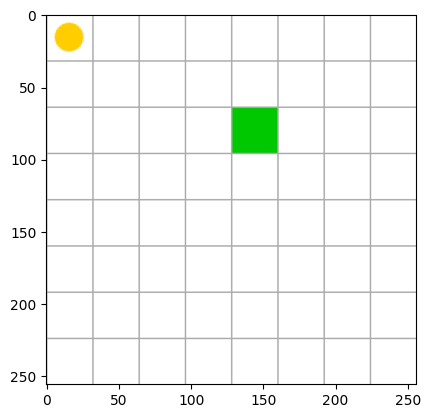

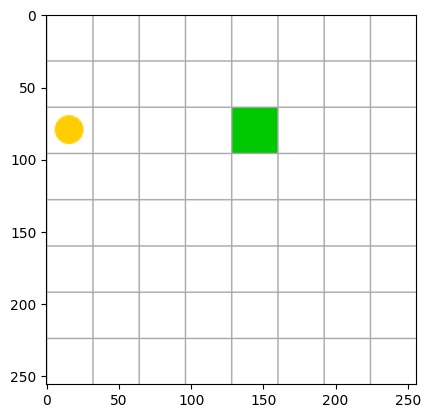

In [16]:
ENV = EnvFactory.Grid_2D_8x8_discrete

OBSTACLE = ObstacleTypes.obst_free_8x8
INITIAL_STATE_POLICY_I = (0, 0)
INITIAL_STATE_POLICY_II = (2, 0)
FINAL_STATE_POLICY = (2, 4)


env_2D_grid_initial_config_I = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_I,
    target_state=FINAL_STATE_POLICY,
)

env_2D_grid_initial_config_II = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE_POLICY_II,
    target_state=FINAL_STATE_POLICY,
)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config_I)
snapshot_env(env)

env = ENV.get_env(render_mode=render_mode, grid_config=env_2D_grid_initial_config_II)
snapshot_env(env)

### STEP 2: Create Minari datasets

**Let's see how well offline RL algorithms can deal with the stitching property. We will examine some edge cases to compare them with some of the algorithms we have already studied before.**

In [17]:
IDENTIFIER_COMBINED_DATASETS = "_stiching_property_I"

# Dataset I with 2000 collected points
BEHAVIOR_POLICY_I = BehaviorPolicy2dGridFactory.deterministic_8x8
DATA_SET_IDENTIFIER_I = "_longer_path"
NUM_STEPS_I = 2000

# Dataset II with 1000 points
# BEHAVIOR_POLICY_II = BehaviorPolicyType.behavior_8x8_eps_greedy_4_0_to_7_7
BEHAVIOR_POLICY_II = BehaviorPolicy2dGridFactory.move_right
DATA_SET_IDENTIFIER_II = "_short_path"
NUM_STEPS_II = 1000

In [18]:
select_policy_to_render = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

Dropdown(options=(<BehaviorPolicy2dGridFactory.deterministic_8x8: 'deterministic_8x8'>, <BehaviorPolicy2dGridF…

In [19]:
env_2D_grid_initial_config = (
    env_2D_grid_initial_config_I
    if select_policy_to_render.value == BEHAVIOR_POLICY_I
    else env_2D_grid_initial_config_II
)

offpolicy_rendering(
    env_or_env_name=ENV,
    render_mode=render_mode,
    policy_model=select_policy_to_render.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
)

**Create datasets**

In [20]:
config_combined_data = create_combined_minari_dataset(
    env_name=ENV,
    dataset_identifiers=(DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
    num_collected_points=(NUM_STEPS_I, NUM_STEPS_II),
    behavior_policies=(BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
    combined_dataset_identifier="combined_dataset",
    env_2d_grid_initial_config=(env_2D_grid_initial_config_I, env_2D_grid_initial_config_II),
)
buffer_data = load_buffer_minari(config_combined_data.data_set_name)
data_size = len(buffer_data)

Number of episodes in dataset I:125, in dataset II:250 and  in the combined dataset: 375
Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


In [21]:
dataset_availables = [
    config_combined_data.data_set_name
] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

Dropdown(options=('Grid_2D_8x8_discrete-combined_dataset-v0', 'Grid_2D_8x8_discrete-data_obst_free_8x8_start_0…

### STEP 3: Feed data into replay buffer

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


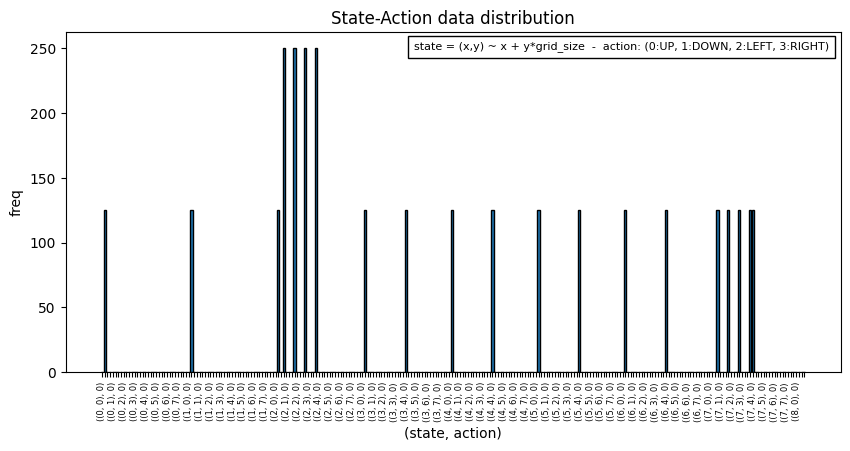

In [22]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(
    buffer_data, env, normalized=False
)

if "start_0_0" in selected_data_set.value:
    env.set_starting_point((0, 0))
    snapshot_env(env)
elif "start_2_0" in selected_data_set.value:
    env.set_starting_point((2, 0))
    snapshot_env(env)

### STEP 4: Select offline policies and training

In [23]:
offline_rl_policies = [RLPolicyFactory.bcq_discrete, RLPolicyFactory.cql_discrete]
selected_offline_rl_policy = widget_list(offline_rl_policies)

Dropdown(options=(<RLPolicyFactory.bcq_discrete: 'bcq_discrete'>, <RLPolicyFactory.cql_discrete: 'cql_discrete…

In [24]:
# Offiline - Training

NUM_EPOCHS = 2
BATCH_SIZE = 128
STEP_PER_EPOCH = 1.0 * len_buffer
NUMBER_TEST_ENVS = 1


offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)


# Hyperparameters to be used in the training.
offline_training_hyperparams = OfflineTrainingHyperparams(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
)

In [25]:
conditional_capture(OfflineRLTraining.training(offline_training_hyperparams))

Dataset /workspace/src/offline_rl/data/offline_data/Grid_2D_8x8_discrete-combined_dataset-v0 downloaded. number of episodes: 375


Epoch #1:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch #1:   0%|          | 1/3000 [00:00<00:27, 108.76it/s, gradient_step=1]

Epoch #1:   0%|          | 2/3000 [00:00<00:22, 130.53it/s, gradient_step=2]

Epoch #1:   0%|          | 3/3000 [00:00<00:20, 143.70it/s, gradient_step=3]

Epoch #1:   0%|          | 4/3000 [00:00<00:19, 154.43it/s, gradient_step=4]

Epoch #1:   0%|          | 5/3000 [00:00<00:18, 162.09it/s, gradient_step=5]

Epoch #1:   0%|          | 6/3000 [00:00<00:17, 168.39it/s, gradient_step=6]

Epoch #1:   0%|          | 7/3000 [00:00<00:17, 173.09it/s, gradient_step=7]

Epoch #1:   0%|          | 8/3000 [00:00<00:16, 176.45it/s, gradient_step=8]

Epoch #1:   0%|          | 9/3000 [00:00<00:16, 179.22it/s, gradient_step=9]

Epoch #1:   0%|          | 10/3000 [00:00<00:16, 181.45it/s, gradient_step=10]

Epoch #1:   0%|          | 11/3000 [00:00<00:16, 183.17it/s, gradient_step=11]

Epoch #1:   0%|          | 12/3000 [00:00<00:16, 185.19it/s, gradient_step=12]

Epoch #1:   0%|          | 13/3000 [00:00<00:16, 186.16it/s, gradient_step=13]

Epoch #1:   0%|          | 14/3000 [00:00<00:15, 187.65it/s, gradient_step=14]

Epoch #1:   0%|          | 15/3000 [00:00<00:15, 188.61it/s, gradient_step=15]

Epoch #1:   1%|          | 16/3000 [00:00<00:15, 189.65it/s, gradient_step=16]

Epoch #1:   1%|          | 17/3000 [00:00<00:15, 190.38it/s, gradient_step=17]

Epoch #1:   1%|          | 18/3000 [00:00<00:15, 190.88it/s, gradient_step=18]

Epoch #1:   1%|          | 19/3000 [00:00<00:15, 191.54it/s, gradient_step=19]

Epoch #1:   1%|          | 20/3000 [00:00<00:15, 192.12it/s, gradient_step=20]

Epoch #1:   1%|          | 21/3000 [00:00<00:14, 201.06it/s, gradient_step=20]

Epoch #1:   1%|          | 21/3000 [00:00<00:14, 201.06it/s, gradient_step=21]

Epoch #1:   1%|          | 22/3000 [00:00<00:14, 201.06it/s, gradient_step=22]

Epoch #1:   1%|          | 23/3000 [00:00<00:14, 201.06it/s, gradient_step=23]

Epoch #1:   1%|          | 24/3000 [00:00<00:14, 201.06it/s, gradient_step=24]

Epoch #1:   1%|          | 25/3000 [00:00<00:14, 201.06it/s, gradient_step=25]

Epoch #1:   1%|          | 26/3000 [00:00<00:14, 201.06it/s, gradient_step=26]

Epoch #1:   1%|          | 27/3000 [00:00<00:14, 201.06it/s, gradient_step=27]

Epoch #1:   1%|          | 28/3000 [00:00<00:14, 201.06it/s, gradient_step=28]

Epoch #1:   1%|          | 29/3000 [00:00<00:14, 201.06it/s, gradient_step=29]

Epoch #1:   1%|1         | 30/3000 [00:00<00:14, 201.06it/s, gradient_step=30]

Epoch #1:   1%|1         | 31/3000 [00:00<00:14, 201.06it/s, gradient_step=31]

Epoch #1:   1%|1         | 32/3000 [00:00<00:14, 201.06it/s, gradient_step=32]

Epoch #1:   1%|1         | 33/3000 [00:00<00:14, 201.06it/s, gradient_step=33]

Epoch #1:   1%|1         | 34/3000 [00:00<00:14, 201.06it/s, gradient_step=34]

Epoch #1:   1%|1         | 35/3000 [00:00<00:14, 201.06it/s, gradient_step=35]

Epoch #1:   1%|1         | 36/3000 [00:00<00:14, 201.06it/s, gradient_step=36]

Epoch #1:   1%|1         | 37/3000 [00:00<00:14, 201.06it/s, gradient_step=37]

Epoch #1:   1%|1         | 38/3000 [00:00<00:14, 201.06it/s, gradient_step=38]

Epoch #1:   1%|1         | 39/3000 [00:00<00:14, 201.06it/s, gradient_step=39]

Epoch #1:   1%|1         | 40/3000 [00:00<00:14, 201.06it/s, gradient_step=40]

Epoch #1:   1%|1         | 41/3000 [00:00<00:14, 201.06it/s, gradient_step=41]

Epoch #1:   1%|1         | 42/3000 [00:00<00:14, 203.22it/s, gradient_step=41]

Epoch #1:   1%|1         | 42/3000 [00:00<00:14, 203.22it/s, gradient_step=42]

Epoch #1:   1%|1         | 43/3000 [00:00<00:14, 203.22it/s, gradient_step=43]

Epoch #1:   1%|1         | 44/3000 [00:00<00:14, 203.22it/s, gradient_step=44]

Epoch #1:   2%|1         | 45/3000 [00:00<00:14, 203.22it/s, gradient_step=45]

Epoch #1:   2%|1         | 46/3000 [00:00<00:14, 203.22it/s, gradient_step=46]

Epoch #1:   2%|1         | 47/3000 [00:00<00:14, 203.22it/s, gradient_step=47]

Epoch #1:   2%|1         | 48/3000 [00:00<00:14, 203.22it/s, gradient_step=48]

Epoch #1:   2%|1         | 49/3000 [00:00<00:14, 203.22it/s, gradient_step=49]

Epoch #1:   2%|1         | 50/3000 [00:00<00:14, 203.22it/s, gradient_step=50]

Epoch #1:   2%|1         | 51/3000 [00:00<00:14, 203.22it/s, gradient_step=51]

Epoch #1:   2%|1         | 52/3000 [00:00<00:14, 203.22it/s, gradient_step=52]

Epoch #1:   2%|1         | 53/3000 [00:00<00:14, 203.22it/s, gradient_step=53]

Epoch #1:   2%|1         | 54/3000 [00:00<00:14, 203.22it/s, gradient_step=54]

Epoch #1:   2%|1         | 55/3000 [00:00<00:14, 203.22it/s, gradient_step=55]

Epoch #1:   2%|1         | 56/3000 [00:00<00:14, 203.22it/s, gradient_step=56]

Epoch #1:   2%|1         | 57/3000 [00:00<00:14, 203.22it/s, gradient_step=57]

Epoch #1:   2%|1         | 58/3000 [00:00<00:14, 203.22it/s, gradient_step=58]

Epoch #1:   2%|1         | 59/3000 [00:00<00:14, 203.22it/s, gradient_step=59]

Epoch #1:   2%|2         | 60/3000 [00:00<00:14, 203.22it/s, gradient_step=60]

Epoch #1:   2%|2         | 61/3000 [00:00<00:14, 203.22it/s, gradient_step=61]

Epoch #1:   2%|2         | 62/3000 [00:00<00:14, 203.22it/s, gradient_step=62]

Epoch #1:   2%|2         | 63/3000 [00:00<00:14, 205.85it/s, gradient_step=62]

Epoch #1:   2%|2         | 63/3000 [00:00<00:14, 205.85it/s, gradient_step=63]

Epoch #1:   2%|2         | 64/3000 [00:00<00:14, 205.85it/s, gradient_step=64]

Epoch #1:   2%|2         | 65/3000 [00:00<00:14, 205.85it/s, gradient_step=65]

Epoch #1:   2%|2         | 66/3000 [00:00<00:14, 205.85it/s, gradient_step=66]

Epoch #1:   2%|2         | 67/3000 [00:00<00:14, 205.85it/s, gradient_step=67]

Epoch #1:   2%|2         | 68/3000 [00:00<00:14, 205.85it/s, gradient_step=68]

Epoch #1:   2%|2         | 69/3000 [00:00<00:14, 205.85it/s, gradient_step=69]

Epoch #1:   2%|2         | 70/3000 [00:00<00:14, 205.85it/s, gradient_step=70]

Epoch #1:   2%|2         | 71/3000 [00:00<00:14, 205.85it/s, gradient_step=71]

Epoch #1:   2%|2         | 72/3000 [00:00<00:14, 205.85it/s, gradient_step=72]

Epoch #1:   2%|2         | 73/3000 [00:00<00:14, 205.85it/s, gradient_step=73]

Epoch #1:   2%|2         | 74/3000 [00:00<00:14, 205.85it/s, gradient_step=74]

Epoch #1:   2%|2         | 75/3000 [00:00<00:14, 205.85it/s, gradient_step=75]

Epoch #1:   3%|2         | 76/3000 [00:00<00:14, 205.85it/s, gradient_step=76]

Epoch #1:   3%|2         | 77/3000 [00:00<00:14, 205.85it/s, gradient_step=77]

Epoch #1:   3%|2         | 78/3000 [00:00<00:14, 205.85it/s, gradient_step=78]

Epoch #1:   3%|2         | 79/3000 [00:00<00:14, 205.85it/s, gradient_step=79]

Epoch #1:   3%|2         | 80/3000 [00:00<00:14, 205.85it/s, gradient_step=80]

Epoch #1:   3%|2         | 81/3000 [00:00<00:14, 205.85it/s, gradient_step=81]

Epoch #1:   3%|2         | 82/3000 [00:00<00:14, 205.85it/s, gradient_step=82]

Epoch #1:   3%|2         | 83/3000 [00:00<00:14, 205.85it/s, gradient_step=83]

Epoch #1:   3%|2         | 84/3000 [00:00<00:14, 207.35it/s, gradient_step=83]

Epoch #1:   3%|2         | 84/3000 [00:00<00:14, 207.35it/s, gradient_step=84]

Epoch #1:   3%|2         | 85/3000 [00:00<00:14, 207.35it/s, gradient_step=85]

Epoch #1:   3%|2         | 86/3000 [00:00<00:14, 207.35it/s, gradient_step=86]

Epoch #1:   3%|2         | 87/3000 [00:00<00:14, 207.35it/s, gradient_step=87]

Epoch #1:   3%|2         | 88/3000 [00:00<00:14, 207.35it/s, gradient_step=88]

Epoch #1:   3%|2         | 89/3000 [00:00<00:14, 207.35it/s, gradient_step=89]

Epoch #1:   3%|3         | 90/3000 [00:00<00:14, 207.35it/s, gradient_step=90]

Epoch #1:   3%|3         | 91/3000 [00:00<00:14, 207.35it/s, gradient_step=91]

Epoch #1:   3%|3         | 92/3000 [00:00<00:14, 207.35it/s, gradient_step=92]

Epoch #1:   3%|3         | 93/3000 [00:00<00:14, 207.35it/s, gradient_step=93]

Epoch #1:   3%|3         | 94/3000 [00:00<00:14, 207.35it/s, gradient_step=94]

Epoch #1:   3%|3         | 95/3000 [00:00<00:14, 207.35it/s, gradient_step=95]

Epoch #1:   3%|3         | 96/3000 [00:00<00:14, 207.35it/s, gradient_step=96]

Epoch #1:   3%|3         | 97/3000 [00:00<00:14, 207.35it/s, gradient_step=97]

Epoch #1:   3%|3         | 98/3000 [00:00<00:13, 207.35it/s, gradient_step=98]

Epoch #1:   3%|3         | 99/3000 [00:00<00:13, 207.35it/s, gradient_step=99]

Epoch #1:   3%|3         | 100/3000 [00:00<00:13, 207.35it/s, gradient_step=100]

Epoch #1:   3%|3         | 101/3000 [00:00<00:13, 207.35it/s, gradient_step=101]

Epoch #1:   3%|3         | 102/3000 [00:00<00:13, 207.35it/s, gradient_step=102]

Epoch #1:   3%|3         | 103/3000 [00:00<00:13, 207.35it/s, gradient_step=103]

Epoch #1:   3%|3         | 104/3000 [00:00<00:13, 207.35it/s, gradient_step=104]

Epoch #1:   4%|3         | 105/3000 [00:00<00:13, 206.81it/s, gradient_step=104]

Epoch #1:   4%|3         | 105/3000 [00:00<00:13, 206.81it/s, gradient_step=105]

Epoch #1:   4%|3         | 106/3000 [00:00<00:13, 206.81it/s, gradient_step=106]

Epoch #1:   4%|3         | 107/3000 [00:00<00:13, 206.81it/s, gradient_step=107]

Epoch #1:   4%|3         | 108/3000 [00:00<00:13, 206.81it/s, gradient_step=108]

Epoch #1:   4%|3         | 109/3000 [00:00<00:13, 206.81it/s, gradient_step=109]

Epoch #1:   4%|3         | 110/3000 [00:00<00:13, 206.81it/s, gradient_step=110]

Epoch #1:   4%|3         | 111/3000 [00:00<00:13, 206.81it/s, gradient_step=111]

Epoch #1:   4%|3         | 112/3000 [00:00<00:13, 206.81it/s, gradient_step=112]

Epoch #1:   4%|3         | 113/3000 [00:00<00:13, 206.81it/s, gradient_step=113]

Epoch #1:   4%|3         | 114/3000 [00:00<00:13, 206.81it/s, gradient_step=114]

Epoch #1:   4%|3         | 115/3000 [00:00<00:13, 206.81it/s, gradient_step=115]

Epoch #1:   4%|3         | 116/3000 [00:00<00:13, 206.81it/s, gradient_step=116]

Epoch #1:   4%|3         | 117/3000 [00:00<00:13, 206.81it/s, gradient_step=117]

Epoch #1:   4%|3         | 118/3000 [00:00<00:13, 206.81it/s, gradient_step=118]

Epoch #1:   4%|3         | 119/3000 [00:00<00:13, 206.81it/s, gradient_step=119]

Epoch #1:   4%|4         | 120/3000 [00:00<00:13, 206.81it/s, gradient_step=120]

Epoch #1:   4%|4         | 121/3000 [00:00<00:13, 206.81it/s, gradient_step=121]

Epoch #1:   4%|4         | 122/3000 [00:00<00:13, 206.81it/s, gradient_step=122]

Epoch #1:   4%|4         | 123/3000 [00:00<00:13, 206.81it/s, gradient_step=123]

Epoch #1:   4%|4         | 124/3000 [00:00<00:13, 206.81it/s, gradient_step=124]

Epoch #1:   4%|4         | 125/3000 [00:00<00:13, 206.81it/s, gradient_step=125]

Epoch #1:   4%|4         | 126/3000 [00:00<00:14, 201.85it/s, gradient_step=125]

Epoch #1:   4%|4         | 126/3000 [00:00<00:14, 201.85it/s, gradient_step=126]

Epoch #1:   4%|4         | 127/3000 [00:00<00:14, 201.85it/s, gradient_step=127]

Epoch #1:   4%|4         | 128/3000 [00:00<00:14, 201.85it/s, gradient_step=128]

Epoch #1:   4%|4         | 129/3000 [00:00<00:14, 201.85it/s, gradient_step=129]

Epoch #1:   4%|4         | 130/3000 [00:00<00:14, 201.85it/s, gradient_step=130]

Epoch #1:   4%|4         | 131/3000 [00:00<00:14, 201.85it/s, gradient_step=131]

Epoch #1:   4%|4         | 132/3000 [00:00<00:14, 201.85it/s, gradient_step=132]

Epoch #1:   4%|4         | 133/3000 [00:00<00:14, 201.85it/s, gradient_step=133]

Epoch #1:   4%|4         | 134/3000 [00:00<00:14, 201.85it/s, gradient_step=134]

Epoch #1:   4%|4         | 135/3000 [00:00<00:14, 201.85it/s, gradient_step=135]

Epoch #1:   5%|4         | 136/3000 [00:00<00:14, 201.85it/s, gradient_step=136]

Epoch #1:   5%|4         | 137/3000 [00:00<00:14, 201.85it/s, gradient_step=137]

Epoch #1:   5%|4         | 138/3000 [00:00<00:14, 201.85it/s, gradient_step=138]

Epoch #1:   5%|4         | 139/3000 [00:00<00:14, 201.85it/s, gradient_step=139]

Epoch #1:   5%|4         | 140/3000 [00:00<00:14, 201.85it/s, gradient_step=140]

Epoch #1:   5%|4         | 141/3000 [00:00<00:14, 201.85it/s, gradient_step=141]

Epoch #1:   5%|4         | 142/3000 [00:00<00:14, 201.85it/s, gradient_step=142]

Epoch #1:   5%|4         | 143/3000 [00:00<00:14, 201.85it/s, gradient_step=143]

Epoch #1:   5%|4         | 144/3000 [00:00<00:14, 201.85it/s, gradient_step=144]

Epoch #1:   5%|4         | 145/3000 [00:00<00:14, 201.85it/s, gradient_step=145]

Epoch #1:   5%|4         | 146/3000 [00:00<00:14, 201.85it/s, gradient_step=146]

Epoch #1:   5%|4         | 147/3000 [00:00<00:14, 201.85it/s, gradient_step=147]

Epoch #1:   5%|4         | 148/3000 [00:00<00:13, 207.62it/s, gradient_step=147]

Epoch #1:   5%|4         | 148/3000 [00:00<00:13, 207.62it/s, gradient_step=148]

Epoch #1:   5%|4         | 149/3000 [00:00<00:13, 207.62it/s, gradient_step=149]

Epoch #1:   5%|5         | 150/3000 [00:00<00:13, 207.62it/s, gradient_step=150]

Epoch #1:   5%|5         | 151/3000 [00:00<00:13, 207.62it/s, gradient_step=151]

Epoch #1:   5%|5         | 152/3000 [00:00<00:13, 207.62it/s, gradient_step=152]

Epoch #1:   5%|5         | 153/3000 [00:00<00:13, 207.62it/s, gradient_step=153]

Epoch #1:   5%|5         | 154/3000 [00:00<00:13, 207.62it/s, gradient_step=154]

Epoch #1:   5%|5         | 155/3000 [00:00<00:13, 207.62it/s, gradient_step=155]

Epoch #1:   5%|5         | 156/3000 [00:00<00:13, 207.62it/s, gradient_step=156]

Epoch #1:   5%|5         | 157/3000 [00:00<00:13, 207.62it/s, gradient_step=157]

Epoch #1:   5%|5         | 158/3000 [00:00<00:13, 207.62it/s, gradient_step=158]

Epoch #1:   5%|5         | 159/3000 [00:00<00:13, 207.62it/s, gradient_step=159]

Epoch #1:   5%|5         | 160/3000 [00:00<00:13, 207.62it/s, gradient_step=160]

Epoch #1:   5%|5         | 161/3000 [00:00<00:13, 207.62it/s, gradient_step=161]

Epoch #1:   5%|5         | 162/3000 [00:00<00:13, 207.62it/s, gradient_step=162]

Epoch #1:   5%|5         | 163/3000 [00:00<00:13, 207.62it/s, gradient_step=163]

Epoch #1:   5%|5         | 164/3000 [00:00<00:13, 207.62it/s, gradient_step=164]

Epoch #1:   6%|5         | 165/3000 [00:00<00:13, 207.62it/s, gradient_step=165]

Epoch #1:   6%|5         | 166/3000 [00:00<00:13, 207.62it/s, gradient_step=166]

Epoch #1:   6%|5         | 167/3000 [00:00<00:13, 207.62it/s, gradient_step=167]

Epoch #1:   6%|5         | 168/3000 [00:00<00:13, 207.62it/s, gradient_step=168]

Epoch #1:   6%|5         | 169/3000 [00:00<00:13, 207.62it/s, gradient_step=169]

Epoch #1:   6%|5         | 170/3000 [00:00<00:13, 209.24it/s, gradient_step=169]

Epoch #1:   6%|5         | 170/3000 [00:00<00:13, 209.24it/s, gradient_step=170]

Epoch #1:   6%|5         | 171/3000 [00:00<00:13, 209.24it/s, gradient_step=171]

Epoch #1:   6%|5         | 172/3000 [00:00<00:13, 209.24it/s, gradient_step=172]

Epoch #1:   6%|5         | 173/3000 [00:00<00:13, 209.24it/s, gradient_step=173]

Epoch #1:   6%|5         | 174/3000 [00:00<00:13, 209.24it/s, gradient_step=174]

Epoch #1:   6%|5         | 175/3000 [00:00<00:13, 209.24it/s, gradient_step=175]

Epoch #1:   6%|5         | 176/3000 [00:00<00:13, 209.24it/s, gradient_step=176]

Epoch #1:   6%|5         | 177/3000 [00:00<00:13, 209.24it/s, gradient_step=177]

Epoch #1:   6%|5         | 178/3000 [00:00<00:13, 209.24it/s, gradient_step=178]

Epoch #1:   6%|5         | 179/3000 [00:00<00:13, 209.24it/s, gradient_step=179]

Epoch #1:   6%|6         | 180/3000 [00:00<00:13, 209.24it/s, gradient_step=180]

Epoch #1:   6%|6         | 181/3000 [00:00<00:13, 209.24it/s, gradient_step=181]

Epoch #1:   6%|6         | 182/3000 [00:00<00:13, 209.24it/s, gradient_step=182]

Epoch #1:   6%|6         | 183/3000 [00:00<00:13, 209.24it/s, gradient_step=183]

Epoch #1:   6%|6         | 184/3000 [00:00<00:13, 209.24it/s, gradient_step=184]

Epoch #1:   6%|6         | 185/3000 [00:00<00:13, 209.24it/s, gradient_step=185]

Epoch #1:   6%|6         | 186/3000 [00:00<00:13, 209.24it/s, gradient_step=186]

Epoch #1:   6%|6         | 187/3000 [00:00<00:13, 209.24it/s, gradient_step=187]

Epoch #1:   6%|6         | 188/3000 [00:00<00:13, 209.24it/s, gradient_step=188]

Epoch #1:   6%|6         | 189/3000 [00:00<00:13, 209.24it/s, gradient_step=189]

Epoch #1:   6%|6         | 190/3000 [00:00<00:13, 209.24it/s, gradient_step=190]

Epoch #1:   6%|6         | 191/3000 [00:00<00:13, 208.15it/s, gradient_step=190]

Epoch #1:   6%|6         | 191/3000 [00:00<00:13, 208.15it/s, gradient_step=191]

Epoch #1:   6%|6         | 192/3000 [00:00<00:13, 208.15it/s, gradient_step=192]

Epoch #1:   6%|6         | 193/3000 [00:00<00:13, 208.15it/s, gradient_step=193]

Epoch #1:   6%|6         | 194/3000 [00:00<00:13, 208.15it/s, gradient_step=194]

Epoch #1:   6%|6         | 195/3000 [00:00<00:13, 208.15it/s, gradient_step=195]

Epoch #1:   7%|6         | 196/3000 [00:00<00:13, 208.15it/s, gradient_step=196]

Epoch #1:   7%|6         | 197/3000 [00:00<00:13, 208.15it/s, gradient_step=197]

Epoch #1:   7%|6         | 198/3000 [00:00<00:13, 208.15it/s, gradient_step=198]

Epoch #1:   7%|6         | 199/3000 [00:00<00:13, 208.15it/s, gradient_step=199]

Epoch #1:   7%|6         | 200/3000 [00:00<00:13, 208.15it/s, gradient_step=200]

Epoch #1:   7%|6         | 201/3000 [00:00<00:13, 208.15it/s, gradient_step=201]

Epoch #1:   7%|6         | 202/3000 [00:00<00:13, 208.15it/s, gradient_step=202]

Epoch #1:   7%|6         | 203/3000 [00:00<00:13, 208.15it/s, gradient_step=203]

Epoch #1:   7%|6         | 204/3000 [00:00<00:13, 208.15it/s, gradient_step=204]

Epoch #1:   7%|6         | 205/3000 [00:00<00:13, 208.15it/s, gradient_step=205]

Epoch #1:   7%|6         | 206/3000 [00:00<00:13, 208.15it/s, gradient_step=206]

Epoch #1:   7%|6         | 207/3000 [00:01<00:13, 208.15it/s, gradient_step=207]

Epoch #1:   7%|6         | 208/3000 [00:01<00:13, 208.15it/s, gradient_step=208]

Epoch #1:   7%|6         | 209/3000 [00:01<00:13, 208.15it/s, gradient_step=209]

Epoch #1:   7%|7         | 210/3000 [00:01<00:13, 208.15it/s, gradient_step=210]

Epoch #1:   7%|7         | 211/3000 [00:01<00:13, 208.15it/s, gradient_step=211]

Epoch #1:   7%|7         | 212/3000 [00:01<00:13, 208.15it/s, gradient_step=212]

Epoch #1:   7%|7         | 213/3000 [00:01<00:13, 209.63it/s, gradient_step=212]

Epoch #1:   7%|7         | 213/3000 [00:01<00:13, 209.63it/s, gradient_step=213]

Epoch #1:   7%|7         | 214/3000 [00:01<00:13, 209.63it/s, gradient_step=214]

Epoch #1:   7%|7         | 215/3000 [00:01<00:13, 209.63it/s, gradient_step=215]

Epoch #1:   7%|7         | 216/3000 [00:01<00:13, 209.63it/s, gradient_step=216]

Epoch #1:   7%|7         | 217/3000 [00:01<00:13, 209.63it/s, gradient_step=217]

Epoch #1:   7%|7         | 218/3000 [00:01<00:13, 209.63it/s, gradient_step=218]

Epoch #1:   7%|7         | 219/3000 [00:01<00:13, 209.63it/s, gradient_step=219]

Epoch #1:   7%|7         | 220/3000 [00:01<00:13, 209.63it/s, gradient_step=220]

Epoch #1:   7%|7         | 221/3000 [00:01<00:13, 209.63it/s, gradient_step=221]

Epoch #1:   7%|7         | 222/3000 [00:01<00:13, 209.63it/s, gradient_step=222]

Epoch #1:   7%|7         | 223/3000 [00:01<00:13, 209.63it/s, gradient_step=223]

Epoch #1:   7%|7         | 224/3000 [00:01<00:13, 209.63it/s, gradient_step=224]

Epoch #1:   8%|7         | 225/3000 [00:01<00:13, 209.63it/s, gradient_step=225]

Epoch #1:   8%|7         | 226/3000 [00:01<00:13, 209.63it/s, gradient_step=226]

Epoch #1:   8%|7         | 227/3000 [00:01<00:13, 209.63it/s, gradient_step=227]

Epoch #1:   8%|7         | 228/3000 [00:01<00:13, 209.63it/s, gradient_step=228]

Epoch #1:   8%|7         | 229/3000 [00:01<00:13, 209.63it/s, gradient_step=229]

Epoch #1:   8%|7         | 230/3000 [00:01<00:13, 209.63it/s, gradient_step=230]

Epoch #1:   8%|7         | 231/3000 [00:01<00:13, 209.63it/s, gradient_step=231]

Epoch #1:   8%|7         | 232/3000 [00:01<00:13, 209.63it/s, gradient_step=232]

Epoch #1:   8%|7         | 233/3000 [00:01<00:13, 209.63it/s, gradient_step=233]

Epoch #1:   8%|7         | 234/3000 [00:01<00:13, 209.63it/s, gradient_step=234]

Epoch #1:   8%|7         | 235/3000 [00:01<00:13, 211.62it/s, gradient_step=234]

Epoch #1:   8%|7         | 235/3000 [00:01<00:13, 211.62it/s, gradient_step=235]

Epoch #1:   8%|7         | 236/3000 [00:01<00:13, 211.62it/s, gradient_step=236]

Epoch #1:   8%|7         | 237/3000 [00:01<00:13, 211.62it/s, gradient_step=237]

Epoch #1:   8%|7         | 238/3000 [00:01<00:13, 211.62it/s, gradient_step=238]

Epoch #1:   8%|7         | 239/3000 [00:01<00:13, 211.62it/s, gradient_step=239]

Epoch #1:   8%|8         | 240/3000 [00:01<00:13, 211.62it/s, gradient_step=240]

Epoch #1:   8%|8         | 241/3000 [00:01<00:13, 211.62it/s, gradient_step=241]

Epoch #1:   8%|8         | 242/3000 [00:01<00:13, 211.62it/s, gradient_step=242]

Epoch #1:   8%|8         | 243/3000 [00:01<00:13, 211.62it/s, gradient_step=243]

Epoch #1:   8%|8         | 244/3000 [00:01<00:13, 211.62it/s, gradient_step=244]

Epoch #1:   8%|8         | 245/3000 [00:01<00:13, 211.62it/s, gradient_step=245]

Epoch #1:   8%|8         | 246/3000 [00:01<00:13, 211.62it/s, gradient_step=246]

Epoch #1:   8%|8         | 247/3000 [00:01<00:13, 211.62it/s, gradient_step=247]

Epoch #1:   8%|8         | 248/3000 [00:01<00:13, 211.62it/s, gradient_step=248]

Epoch #1:   8%|8         | 249/3000 [00:01<00:12, 211.62it/s, gradient_step=249]

Epoch #1:   8%|8         | 250/3000 [00:01<00:12, 211.62it/s, gradient_step=250]

Epoch #1:   8%|8         | 251/3000 [00:01<00:12, 211.62it/s, gradient_step=251]

Epoch #1:   8%|8         | 252/3000 [00:01<00:12, 211.62it/s, gradient_step=252]

Epoch #1:   8%|8         | 253/3000 [00:01<00:12, 211.62it/s, gradient_step=253]

Epoch #1:   8%|8         | 254/3000 [00:01<00:12, 211.62it/s, gradient_step=254]

Epoch #1:   8%|8         | 255/3000 [00:01<00:12, 211.62it/s, gradient_step=255]

Epoch #1:   9%|8         | 256/3000 [00:01<00:12, 211.62it/s, gradient_step=256]

Epoch #1:   9%|8         | 257/3000 [00:01<00:12, 213.21it/s, gradient_step=256]

Epoch #1:   9%|8         | 257/3000 [00:01<00:12, 213.21it/s, gradient_step=257]

Epoch #1:   9%|8         | 258/3000 [00:01<00:12, 213.21it/s, gradient_step=258]

Epoch #1:   9%|8         | 259/3000 [00:01<00:12, 213.21it/s, gradient_step=259]

Epoch #1:   9%|8         | 260/3000 [00:01<00:12, 213.21it/s, gradient_step=260]

Epoch #1:   9%|8         | 261/3000 [00:01<00:12, 213.21it/s, gradient_step=261]

Epoch #1:   9%|8         | 262/3000 [00:01<00:12, 213.21it/s, gradient_step=262]

Epoch #1:   9%|8         | 263/3000 [00:01<00:12, 213.21it/s, gradient_step=263]

Epoch #1:   9%|8         | 264/3000 [00:01<00:12, 213.21it/s, gradient_step=264]

Epoch #1:   9%|8         | 265/3000 [00:01<00:12, 213.21it/s, gradient_step=265]

Epoch #1:   9%|8         | 266/3000 [00:01<00:12, 213.21it/s, gradient_step=266]

Epoch #1:   9%|8         | 267/3000 [00:01<00:12, 213.21it/s, gradient_step=267]

Epoch #1:   9%|8         | 268/3000 [00:01<00:12, 213.21it/s, gradient_step=268]

Epoch #1:   9%|8         | 269/3000 [00:01<00:12, 213.21it/s, gradient_step=269]

Epoch #1:   9%|9         | 270/3000 [00:01<00:12, 213.21it/s, gradient_step=270]

Epoch #1:   9%|9         | 271/3000 [00:01<00:12, 213.21it/s, gradient_step=271]

Epoch #1:   9%|9         | 272/3000 [00:01<00:12, 213.21it/s, gradient_step=272]

Epoch #1:   9%|9         | 273/3000 [00:01<00:12, 213.21it/s, gradient_step=273]

Epoch #1:   9%|9         | 274/3000 [00:01<00:12, 213.21it/s, gradient_step=274]

Epoch #1:   9%|9         | 275/3000 [00:01<00:12, 213.21it/s, gradient_step=275]

Epoch #1:   9%|9         | 276/3000 [00:01<00:12, 213.21it/s, gradient_step=276]

Epoch #1:   9%|9         | 277/3000 [00:01<00:12, 213.21it/s, gradient_step=277]

Epoch #1:   9%|9         | 278/3000 [00:01<00:12, 213.21it/s, gradient_step=278]

Epoch #1:   9%|9         | 279/3000 [00:01<00:12, 213.02it/s, gradient_step=278]

Epoch #1:   9%|9         | 279/3000 [00:01<00:12, 213.02it/s, gradient_step=279]

Epoch #1:   9%|9         | 280/3000 [00:01<00:12, 213.02it/s, gradient_step=280]

Epoch #1:   9%|9         | 281/3000 [00:01<00:12, 213.02it/s, gradient_step=281]

Epoch #1:   9%|9         | 282/3000 [00:01<00:12, 213.02it/s, gradient_step=282]

Epoch #1:   9%|9         | 283/3000 [00:01<00:12, 213.02it/s, gradient_step=283]

Epoch #1:   9%|9         | 284/3000 [00:01<00:12, 213.02it/s, gradient_step=284]

Epoch #1:  10%|9         | 285/3000 [00:01<00:12, 213.02it/s, gradient_step=285]

Epoch #1:  10%|9         | 286/3000 [00:01<00:12, 213.02it/s, gradient_step=286]

Epoch #1:  10%|9         | 287/3000 [00:01<00:12, 213.02it/s, gradient_step=287]

Epoch #1:  10%|9         | 288/3000 [00:01<00:12, 213.02it/s, gradient_step=288]

Epoch #1:  10%|9         | 289/3000 [00:01<00:12, 213.02it/s, gradient_step=289]

Epoch #1:  10%|9         | 290/3000 [00:01<00:12, 213.02it/s, gradient_step=290]

Epoch #1:  10%|9         | 291/3000 [00:01<00:12, 213.02it/s, gradient_step=291]

Epoch #1:  10%|9         | 292/3000 [00:01<00:12, 213.02it/s, gradient_step=292]

Epoch #1:  10%|9         | 293/3000 [00:01<00:12, 213.02it/s, gradient_step=293]

Epoch #1:  10%|9         | 294/3000 [00:01<00:12, 213.02it/s, gradient_step=294]

Epoch #1:  10%|9         | 295/3000 [00:01<00:12, 213.02it/s, gradient_step=295]

Epoch #1:  10%|9         | 296/3000 [00:01<00:12, 213.02it/s, gradient_step=296]

Epoch #1:  10%|9         | 297/3000 [00:01<00:12, 213.02it/s, gradient_step=297]

Epoch #1:  10%|9         | 298/3000 [00:01<00:12, 213.02it/s, gradient_step=298]

Epoch #1:  10%|9         | 299/3000 [00:01<00:12, 213.02it/s, gradient_step=299]

Epoch #1:  10%|#         | 300/3000 [00:01<00:12, 213.02it/s, gradient_step=300]

Epoch #1:  10%|#         | 301/3000 [00:01<00:12, 213.53it/s, gradient_step=300]

Epoch #1:  10%|#         | 301/3000 [00:01<00:12, 213.53it/s, gradient_step=301]

Epoch #1:  10%|#         | 302/3000 [00:01<00:12, 213.53it/s, gradient_step=302]

Epoch #1:  10%|#         | 303/3000 [00:01<00:12, 213.53it/s, gradient_step=303]

Epoch #1:  10%|#         | 304/3000 [00:01<00:12, 213.53it/s, gradient_step=304]

Epoch #1:  10%|#         | 305/3000 [00:01<00:12, 213.53it/s, gradient_step=305]

Epoch #1:  10%|#         | 306/3000 [00:01<00:12, 213.53it/s, gradient_step=306]

Epoch #1:  10%|#         | 307/3000 [00:01<00:12, 213.53it/s, gradient_step=307]

Epoch #1:  10%|#         | 308/3000 [00:01<00:12, 213.53it/s, gradient_step=308]

Epoch #1:  10%|#         | 309/3000 [00:01<00:12, 213.53it/s, gradient_step=309]

Epoch #1:  10%|#         | 310/3000 [00:01<00:12, 213.53it/s, gradient_step=310]

Epoch #1:  10%|#         | 311/3000 [00:01<00:12, 213.53it/s, gradient_step=311]

Epoch #1:  10%|#         | 312/3000 [00:01<00:12, 213.53it/s, gradient_step=312]

Epoch #1:  10%|#         | 313/3000 [00:01<00:12, 213.53it/s, gradient_step=313]

Epoch #1:  10%|#         | 314/3000 [00:01<00:12, 213.53it/s, gradient_step=314]

Epoch #1:  10%|#         | 315/3000 [00:01<00:12, 213.53it/s, gradient_step=315]

Epoch #1:  11%|#         | 316/3000 [00:01<00:12, 213.53it/s, gradient_step=316]

Epoch #1:  11%|#         | 317/3000 [00:01<00:12, 213.53it/s, gradient_step=317]

Epoch #1:  11%|#         | 318/3000 [00:01<00:12, 213.53it/s, gradient_step=318]

Epoch #1:  11%|#         | 319/3000 [00:01<00:12, 213.53it/s, gradient_step=319]

Epoch #1:  11%|#         | 320/3000 [00:01<00:12, 213.53it/s, gradient_step=320]

Epoch #1:  11%|#         | 321/3000 [00:01<00:12, 213.53it/s, gradient_step=321]

Epoch #1:  11%|#         | 322/3000 [00:01<00:12, 213.53it/s, gradient_step=322]

Epoch #1:  11%|#         | 323/3000 [00:01<00:12, 212.54it/s, gradient_step=322]

Epoch #1:  11%|#         | 323/3000 [00:01<00:12, 212.54it/s, gradient_step=323]

Epoch #1:  11%|#         | 324/3000 [00:01<00:12, 212.54it/s, gradient_step=324]

Epoch #1:  11%|#         | 325/3000 [00:01<00:12, 212.54it/s, gradient_step=325]

Epoch #1:  11%|#         | 326/3000 [00:01<00:12, 212.54it/s, gradient_step=326]

Epoch #1:  11%|#         | 327/3000 [00:01<00:12, 212.54it/s, gradient_step=327]

Epoch #1:  11%|#         | 328/3000 [00:01<00:12, 212.54it/s, gradient_step=328]

Epoch #1:  11%|#         | 329/3000 [00:01<00:12, 212.54it/s, gradient_step=329]

Epoch #1:  11%|#1        | 330/3000 [00:01<00:12, 212.54it/s, gradient_step=330]

Epoch #1:  11%|#1        | 331/3000 [00:01<00:12, 212.54it/s, gradient_step=331]

Epoch #1:  11%|#1        | 332/3000 [00:01<00:12, 212.54it/s, gradient_step=332]

Epoch #1:  11%|#1        | 333/3000 [00:01<00:12, 212.54it/s, gradient_step=333]

Epoch #1:  11%|#1        | 334/3000 [00:01<00:12, 212.54it/s, gradient_step=334]

Epoch #1:  11%|#1        | 335/3000 [00:01<00:12, 212.54it/s, gradient_step=335]

Epoch #1:  11%|#1        | 336/3000 [00:01<00:12, 212.54it/s, gradient_step=336]

Epoch #1:  11%|#1        | 337/3000 [00:01<00:12, 212.54it/s, gradient_step=337]

Epoch #1:  11%|#1        | 338/3000 [00:01<00:12, 212.54it/s, gradient_step=338]

Epoch #1:  11%|#1        | 339/3000 [00:01<00:12, 212.54it/s, gradient_step=339]

Epoch #1:  11%|#1        | 340/3000 [00:01<00:12, 212.54it/s, gradient_step=340]

Epoch #1:  11%|#1        | 341/3000 [00:01<00:12, 212.54it/s, gradient_step=341]

Epoch #1:  11%|#1        | 342/3000 [00:01<00:12, 212.54it/s, gradient_step=342]

Epoch #1:  11%|#1        | 343/3000 [00:01<00:12, 212.54it/s, gradient_step=343]

Epoch #1:  11%|#1        | 344/3000 [00:01<00:12, 212.54it/s, gradient_step=344]

Epoch #1:  12%|#1        | 345/3000 [00:01<00:12, 211.23it/s, gradient_step=344]

Epoch #1:  12%|#1        | 345/3000 [00:01<00:12, 211.23it/s, gradient_step=345]

Epoch #1:  12%|#1        | 346/3000 [00:01<00:12, 211.23it/s, gradient_step=346]

Epoch #1:  12%|#1        | 347/3000 [00:01<00:12, 211.23it/s, gradient_step=347]

Epoch #1:  12%|#1        | 348/3000 [00:01<00:12, 211.23it/s, gradient_step=348]

Epoch #1:  12%|#1        | 349/3000 [00:01<00:12, 211.23it/s, gradient_step=349]

Epoch #1:  12%|#1        | 350/3000 [00:01<00:12, 211.23it/s, gradient_step=350]

Epoch #1:  12%|#1        | 351/3000 [00:01<00:12, 211.23it/s, gradient_step=351]

Epoch #1:  12%|#1        | 352/3000 [00:01<00:12, 211.23it/s, gradient_step=352]

Epoch #1:  12%|#1        | 353/3000 [00:01<00:12, 211.23it/s, gradient_step=353]

Epoch #1:  12%|#1        | 354/3000 [00:01<00:12, 211.23it/s, gradient_step=354]

Epoch #1:  12%|#1        | 355/3000 [00:01<00:12, 211.23it/s, gradient_step=355]

Epoch #1:  12%|#1        | 356/3000 [00:01<00:12, 211.23it/s, gradient_step=356]

Epoch #1:  12%|#1        | 357/3000 [00:01<00:12, 211.23it/s, gradient_step=357]

Epoch #1:  12%|#1        | 358/3000 [00:01<00:12, 211.23it/s, gradient_step=358]

Epoch #1:  12%|#1        | 359/3000 [00:01<00:12, 211.23it/s, gradient_step=359]

Epoch #1:  12%|#2        | 360/3000 [00:01<00:12, 211.23it/s, gradient_step=360]

Epoch #1:  12%|#2        | 361/3000 [00:01<00:12, 211.23it/s, gradient_step=361]

Epoch #1:  12%|#2        | 362/3000 [00:01<00:12, 211.23it/s, gradient_step=362]

Epoch #1:  12%|#2        | 363/3000 [00:01<00:12, 211.23it/s, gradient_step=363]

Epoch #1:  12%|#2        | 364/3000 [00:01<00:12, 211.23it/s, gradient_step=364]

Epoch #1:  12%|#2        | 365/3000 [00:01<00:12, 211.23it/s, gradient_step=365]

Epoch #1:  12%|#2        | 366/3000 [00:01<00:12, 211.23it/s, gradient_step=366]

Epoch #1:  12%|#2        | 367/3000 [00:01<00:12, 204.69it/s, gradient_step=366]

Epoch #1:  12%|#2        | 367/3000 [00:01<00:12, 204.69it/s, gradient_step=367]

Epoch #1:  12%|#2        | 368/3000 [00:01<00:12, 204.69it/s, gradient_step=368]

Epoch #1:  12%|#2        | 369/3000 [00:01<00:12, 204.69it/s, gradient_step=369]

Epoch #1:  12%|#2        | 370/3000 [00:01<00:12, 204.69it/s, gradient_step=370]

Epoch #1:  12%|#2        | 371/3000 [00:01<00:12, 204.69it/s, gradient_step=371]

Epoch #1:  12%|#2        | 372/3000 [00:01<00:12, 204.69it/s, gradient_step=372]

Epoch #1:  12%|#2        | 373/3000 [00:01<00:12, 204.69it/s, gradient_step=373]

Epoch #1:  12%|#2        | 374/3000 [00:01<00:12, 204.69it/s, gradient_step=374]

Epoch #1:  12%|#2        | 375/3000 [00:01<00:12, 204.69it/s, gradient_step=375]

Epoch #1:  13%|#2        | 376/3000 [00:01<00:12, 204.69it/s, gradient_step=376]

Epoch #1:  13%|#2        | 377/3000 [00:01<00:12, 204.69it/s, gradient_step=377]

Epoch #1:  13%|#2        | 378/3000 [00:01<00:12, 204.69it/s, gradient_step=378]

Epoch #1:  13%|#2        | 379/3000 [00:01<00:12, 204.69it/s, gradient_step=379]

Epoch #1:  13%|#2        | 380/3000 [00:01<00:12, 204.69it/s, gradient_step=380]

Epoch #1:  13%|#2        | 381/3000 [00:01<00:12, 204.69it/s, gradient_step=381]

Epoch #1:  13%|#2        | 382/3000 [00:01<00:12, 204.69it/s, gradient_step=382]

Epoch #1:  13%|#2        | 383/3000 [00:01<00:12, 204.69it/s, gradient_step=383]

Epoch #1:  13%|#2        | 384/3000 [00:01<00:12, 204.69it/s, gradient_step=384]

Epoch #1:  13%|#2        | 385/3000 [00:01<00:12, 204.69it/s, gradient_step=385]

Epoch #1:  13%|#2        | 386/3000 [00:01<00:12, 204.69it/s, gradient_step=386]

Epoch #1:  13%|#2        | 387/3000 [00:01<00:12, 204.69it/s, gradient_step=387]

Epoch #1:  13%|#2        | 388/3000 [00:01<00:12, 203.06it/s, gradient_step=387]

Epoch #1:  13%|#2        | 388/3000 [00:01<00:12, 203.06it/s, gradient_step=388]

Epoch #1:  13%|#2        | 389/3000 [00:01<00:12, 203.06it/s, gradient_step=389]

Epoch #1:  13%|#3        | 390/3000 [00:01<00:12, 203.06it/s, gradient_step=390]

Epoch #1:  13%|#3        | 391/3000 [00:01<00:12, 203.06it/s, gradient_step=391]

Epoch #1:  13%|#3        | 392/3000 [00:01<00:12, 203.06it/s, gradient_step=392]

Epoch #1:  13%|#3        | 393/3000 [00:01<00:12, 203.06it/s, gradient_step=393]

Epoch #1:  13%|#3        | 394/3000 [00:01<00:12, 203.06it/s, gradient_step=394]

Epoch #1:  13%|#3        | 395/3000 [00:01<00:12, 203.06it/s, gradient_step=395]

Epoch #1:  13%|#3        | 396/3000 [00:01<00:12, 203.06it/s, gradient_step=396]

Epoch #1:  13%|#3        | 397/3000 [00:01<00:12, 203.06it/s, gradient_step=397]

Epoch #1:  13%|#3        | 398/3000 [00:01<00:12, 203.06it/s, gradient_step=398]

Epoch #1:  13%|#3        | 399/3000 [00:01<00:12, 203.06it/s, gradient_step=399]

Epoch #1:  13%|#3        | 400/3000 [00:01<00:12, 203.06it/s, gradient_step=400]

Epoch #1:  13%|#3        | 401/3000 [00:01<00:12, 203.06it/s, gradient_step=401]

Epoch #1:  13%|#3        | 402/3000 [00:01<00:12, 203.06it/s, gradient_step=402]

Epoch #1:  13%|#3        | 403/3000 [00:01<00:12, 203.06it/s, gradient_step=403]

Epoch #1:  13%|#3        | 404/3000 [00:01<00:12, 203.06it/s, gradient_step=404]

Epoch #1:  14%|#3        | 405/3000 [00:01<00:12, 203.06it/s, gradient_step=405]

Epoch #1:  14%|#3        | 406/3000 [00:01<00:12, 203.06it/s, gradient_step=406]

Epoch #1:  14%|#3        | 407/3000 [00:01<00:12, 203.06it/s, gradient_step=407]

Epoch #1:  14%|#3        | 408/3000 [00:01<00:12, 203.06it/s, gradient_step=408]

Epoch #1:  14%|#3        | 409/3000 [00:01<00:13, 189.32it/s, gradient_step=408]

Epoch #1:  14%|#3        | 409/3000 [00:02<00:13, 189.32it/s, gradient_step=409]

Epoch #1:  14%|#3        | 410/3000 [00:02<00:13, 189.32it/s, gradient_step=410]

Epoch #1:  14%|#3        | 411/3000 [00:02<00:13, 189.32it/s, gradient_step=411]

Epoch #1:  14%|#3        | 412/3000 [00:02<00:13, 189.32it/s, gradient_step=412]

Epoch #1:  14%|#3        | 413/3000 [00:02<00:13, 189.32it/s, gradient_step=413]

Epoch #1:  14%|#3        | 414/3000 [00:02<00:13, 189.32it/s, gradient_step=414]

Epoch #1:  14%|#3        | 415/3000 [00:02<00:13, 189.32it/s, gradient_step=415]

Epoch #1:  14%|#3        | 416/3000 [00:02<00:13, 189.32it/s, gradient_step=416]

Epoch #1:  14%|#3        | 417/3000 [00:02<00:13, 189.32it/s, gradient_step=417]

Epoch #1:  14%|#3        | 418/3000 [00:02<00:13, 189.32it/s, gradient_step=418]

Epoch #1:  14%|#3        | 419/3000 [00:02<00:13, 189.32it/s, gradient_step=419]

Epoch #1:  14%|#4        | 420/3000 [00:02<00:13, 189.32it/s, gradient_step=420]

Epoch #1:  14%|#4        | 421/3000 [00:02<00:13, 189.32it/s, gradient_step=421]

Epoch #1:  14%|#4        | 422/3000 [00:02<00:13, 189.32it/s, gradient_step=422]

Epoch #1:  14%|#4        | 423/3000 [00:02<00:13, 189.32it/s, gradient_step=423]

Epoch #1:  14%|#4        | 424/3000 [00:02<00:13, 189.32it/s, gradient_step=424]

Epoch #1:  14%|#4        | 425/3000 [00:02<00:13, 189.32it/s, gradient_step=425]

Epoch #1:  14%|#4        | 426/3000 [00:02<00:13, 189.32it/s, gradient_step=426]

Epoch #1:  14%|#4        | 427/3000 [00:02<00:13, 189.32it/s, gradient_step=427]

Epoch #1:  14%|#4        | 428/3000 [00:02<00:13, 189.32it/s, gradient_step=428]

Epoch #1:  14%|#4        | 429/3000 [00:02<00:13, 191.84it/s, gradient_step=428]

Epoch #1:  14%|#4        | 429/3000 [00:02<00:13, 191.84it/s, gradient_step=429]

Epoch #1:  14%|#4        | 430/3000 [00:02<00:13, 191.84it/s, gradient_step=430]

Epoch #1:  14%|#4        | 431/3000 [00:02<00:13, 191.84it/s, gradient_step=431]

Epoch #1:  14%|#4        | 432/3000 [00:02<00:13, 191.84it/s, gradient_step=432]

Epoch #1:  14%|#4        | 433/3000 [00:02<00:13, 191.84it/s, gradient_step=433]

Epoch #1:  14%|#4        | 434/3000 [00:02<00:13, 191.84it/s, gradient_step=434]

Epoch #1:  14%|#4        | 435/3000 [00:02<00:13, 191.84it/s, gradient_step=435]

Epoch #1:  15%|#4        | 436/3000 [00:02<00:13, 191.84it/s, gradient_step=436]

Epoch #1:  15%|#4        | 437/3000 [00:02<00:13, 191.84it/s, gradient_step=437]

Epoch #1:  15%|#4        | 438/3000 [00:02<00:13, 191.84it/s, gradient_step=438]

Epoch #1:  15%|#4        | 439/3000 [00:02<00:13, 191.84it/s, gradient_step=439]

Epoch #1:  15%|#4        | 440/3000 [00:02<00:13, 191.84it/s, gradient_step=440]

Epoch #1:  15%|#4        | 441/3000 [00:02<00:13, 191.84it/s, gradient_step=441]

Epoch #1:  15%|#4        | 442/3000 [00:02<00:13, 191.84it/s, gradient_step=442]

Epoch #1:  15%|#4        | 443/3000 [00:02<00:13, 191.84it/s, gradient_step=443]

Epoch #1:  15%|#4        | 444/3000 [00:02<00:13, 191.84it/s, gradient_step=444]

Epoch #1:  15%|#4        | 445/3000 [00:02<00:13, 191.84it/s, gradient_step=445]

Epoch #1:  15%|#4        | 446/3000 [00:02<00:13, 191.84it/s, gradient_step=446]

Epoch #1:  15%|#4        | 447/3000 [00:02<00:13, 191.84it/s, gradient_step=447]

Epoch #1:  15%|#4        | 448/3000 [00:02<00:13, 191.84it/s, gradient_step=448]

Epoch #1:  15%|#4        | 449/3000 [00:02<00:13, 191.84it/s, gradient_step=449]

Epoch #1:  15%|#5        | 450/3000 [00:02<00:13, 191.84it/s, gradient_step=450]

Epoch #1:  15%|#5        | 451/3000 [00:02<00:12, 197.95it/s, gradient_step=450]

Epoch #1:  15%|#5        | 451/3000 [00:02<00:12, 197.95it/s, gradient_step=451]

Epoch #1:  15%|#5        | 452/3000 [00:02<00:12, 197.95it/s, gradient_step=452]

Epoch #1:  15%|#5        | 453/3000 [00:02<00:12, 197.95it/s, gradient_step=453]

Epoch #1:  15%|#5        | 454/3000 [00:02<00:12, 197.95it/s, gradient_step=454]

Epoch #1:  15%|#5        | 455/3000 [00:02<00:12, 197.95it/s, gradient_step=455]

Epoch #1:  15%|#5        | 456/3000 [00:02<00:12, 197.95it/s, gradient_step=456]

Epoch #1:  15%|#5        | 457/3000 [00:02<00:12, 197.95it/s, gradient_step=457]

Epoch #1:  15%|#5        | 458/3000 [00:02<00:12, 197.95it/s, gradient_step=458]

Epoch #1:  15%|#5        | 459/3000 [00:02<00:12, 197.95it/s, gradient_step=459]

Epoch #1:  15%|#5        | 460/3000 [00:02<00:12, 197.95it/s, gradient_step=460]

Epoch #1:  15%|#5        | 461/3000 [00:02<00:12, 197.95it/s, gradient_step=461]

Epoch #1:  15%|#5        | 462/3000 [00:02<00:12, 197.95it/s, gradient_step=462]

Epoch #1:  15%|#5        | 463/3000 [00:02<00:12, 197.95it/s, gradient_step=463]

Epoch #1:  15%|#5        | 464/3000 [00:02<00:12, 197.95it/s, gradient_step=464]

Epoch #1:  16%|#5        | 465/3000 [00:02<00:12, 197.95it/s, gradient_step=465]

Epoch #1:  16%|#5        | 466/3000 [00:02<00:12, 197.95it/s, gradient_step=466]

Epoch #1:  16%|#5        | 467/3000 [00:02<00:12, 197.95it/s, gradient_step=467]

Epoch #1:  16%|#5        | 468/3000 [00:02<00:12, 197.95it/s, gradient_step=468]

Epoch #1:  16%|#5        | 469/3000 [00:02<00:12, 197.95it/s, gradient_step=469]

Epoch #1:  16%|#5        | 470/3000 [00:02<00:12, 197.95it/s, gradient_step=470]

Epoch #1:  16%|#5        | 471/3000 [00:02<00:12, 197.95it/s, gradient_step=471]

Epoch #1:  16%|#5        | 472/3000 [00:02<00:12, 201.33it/s, gradient_step=471]

Epoch #1:  16%|#5        | 472/3000 [00:02<00:12, 201.33it/s, gradient_step=472]

Epoch #1:  16%|#5        | 473/3000 [00:02<00:12, 201.33it/s, gradient_step=473]

Epoch #1:  16%|#5        | 474/3000 [00:02<00:12, 201.33it/s, gradient_step=474]

Epoch #1:  16%|#5        | 475/3000 [00:02<00:12, 201.33it/s, gradient_step=475]

Epoch #1:  16%|#5        | 476/3000 [00:02<00:12, 201.33it/s, gradient_step=476]

Epoch #1:  16%|#5        | 477/3000 [00:02<00:12, 201.33it/s, gradient_step=477]

Epoch #1:  16%|#5        | 478/3000 [00:02<00:12, 201.33it/s, gradient_step=478]

Epoch #1:  16%|#5        | 479/3000 [00:02<00:12, 201.33it/s, gradient_step=479]

Epoch #1:  16%|#6        | 480/3000 [00:02<00:12, 201.33it/s, gradient_step=480]

Epoch #1:  16%|#6        | 481/3000 [00:02<00:12, 201.33it/s, gradient_step=481]

Epoch #1:  16%|#6        | 482/3000 [00:02<00:12, 201.33it/s, gradient_step=482]

Epoch #1:  16%|#6        | 483/3000 [00:02<00:12, 201.33it/s, gradient_step=483]

Epoch #1:  16%|#6        | 484/3000 [00:02<00:12, 201.33it/s, gradient_step=484]

Epoch #1:  16%|#6        | 485/3000 [00:02<00:12, 201.33it/s, gradient_step=485]

Epoch #1:  16%|#6        | 486/3000 [00:02<00:12, 201.33it/s, gradient_step=486]

Epoch #1:  16%|#6        | 487/3000 [00:02<00:12, 201.33it/s, gradient_step=487]

Epoch #1:  16%|#6        | 488/3000 [00:02<00:12, 201.33it/s, gradient_step=488]

Epoch #1:  16%|#6        | 489/3000 [00:02<00:12, 201.33it/s, gradient_step=489]

Epoch #1:  16%|#6        | 490/3000 [00:02<00:12, 201.33it/s, gradient_step=490]

Epoch #1:  16%|#6        | 491/3000 [00:02<00:12, 201.33it/s, gradient_step=491]

Epoch #1:  16%|#6        | 492/3000 [00:02<00:12, 201.33it/s, gradient_step=492]

Epoch #1:  16%|#6        | 493/3000 [00:02<00:12, 201.33it/s, gradient_step=493]

Epoch #1:  16%|#6        | 494/3000 [00:02<00:12, 204.55it/s, gradient_step=493]

Epoch #1:  16%|#6        | 494/3000 [00:02<00:12, 204.55it/s, gradient_step=494]

Epoch #1:  16%|#6        | 495/3000 [00:02<00:12, 204.55it/s, gradient_step=495]

Epoch #1:  17%|#6        | 496/3000 [00:02<00:12, 204.55it/s, gradient_step=496]

Epoch #1:  17%|#6        | 497/3000 [00:02<00:12, 204.55it/s, gradient_step=497]

Epoch #1:  17%|#6        | 498/3000 [00:02<00:12, 204.55it/s, gradient_step=498]

Epoch #1:  17%|#6        | 499/3000 [00:02<00:12, 204.55it/s, gradient_step=499]

Epoch #1:  17%|#6        | 500/3000 [00:02<00:12, 204.55it/s, gradient_step=500]

Epoch #1:  17%|#6        | 501/3000 [00:02<00:12, 204.55it/s, gradient_step=501]

Epoch #1:  17%|#6        | 502/3000 [00:02<00:12, 204.55it/s, gradient_step=502]

Epoch #1:  17%|#6        | 503/3000 [00:02<00:12, 204.55it/s, gradient_step=503]

Epoch #1:  17%|#6        | 504/3000 [00:02<00:12, 204.55it/s, gradient_step=504]

Epoch #1:  17%|#6        | 505/3000 [00:02<00:12, 204.55it/s, gradient_step=505]

Epoch #1:  17%|#6        | 506/3000 [00:02<00:12, 204.55it/s, gradient_step=506]

Epoch #1:  17%|#6        | 507/3000 [00:02<00:12, 204.55it/s, gradient_step=507]

Epoch #1:  17%|#6        | 508/3000 [00:02<00:12, 204.55it/s, gradient_step=508]

Epoch #1:  17%|#6        | 509/3000 [00:02<00:12, 204.55it/s, gradient_step=509]

Epoch #1:  17%|#7        | 510/3000 [00:02<00:12, 204.55it/s, gradient_step=510]

Epoch #1:  17%|#7        | 511/3000 [00:02<00:12, 204.55it/s, gradient_step=511]

Epoch #1:  17%|#7        | 512/3000 [00:02<00:12, 204.55it/s, gradient_step=512]

Epoch #1:  17%|#7        | 513/3000 [00:02<00:12, 204.55it/s, gradient_step=513]

Epoch #1:  17%|#7        | 514/3000 [00:02<00:12, 204.55it/s, gradient_step=514]

Epoch #1:  17%|#7        | 515/3000 [00:02<00:12, 204.55it/s, gradient_step=515]

Epoch #1:  17%|#7        | 516/3000 [00:02<00:11, 207.34it/s, gradient_step=515]

Epoch #1:  17%|#7        | 516/3000 [00:02<00:11, 207.34it/s, gradient_step=516]

Epoch #1:  17%|#7        | 517/3000 [00:02<00:11, 207.34it/s, gradient_step=517]

Epoch #1:  17%|#7        | 518/3000 [00:02<00:11, 207.34it/s, gradient_step=518]

Epoch #1:  17%|#7        | 519/3000 [00:02<00:11, 207.34it/s, gradient_step=519]

Epoch #1:  17%|#7        | 520/3000 [00:02<00:11, 207.34it/s, gradient_step=520]

Epoch #1:  17%|#7        | 521/3000 [00:02<00:11, 207.34it/s, gradient_step=521]

Epoch #1:  17%|#7        | 522/3000 [00:02<00:11, 207.34it/s, gradient_step=522]

Epoch #1:  17%|#7        | 523/3000 [00:02<00:11, 207.34it/s, gradient_step=523]

Epoch #1:  17%|#7        | 524/3000 [00:02<00:11, 207.34it/s, gradient_step=524]

Epoch #1:  18%|#7        | 525/3000 [00:02<00:11, 207.34it/s, gradient_step=525]

Epoch #1:  18%|#7        | 526/3000 [00:02<00:11, 207.34it/s, gradient_step=526]

Epoch #1:  18%|#7        | 527/3000 [00:02<00:11, 207.34it/s, gradient_step=527]

Epoch #1:  18%|#7        | 528/3000 [00:02<00:11, 207.34it/s, gradient_step=528]

Epoch #1:  18%|#7        | 529/3000 [00:02<00:11, 207.34it/s, gradient_step=529]

Epoch #1:  18%|#7        | 530/3000 [00:02<00:11, 207.34it/s, gradient_step=530]

Epoch #1:  18%|#7        | 531/3000 [00:02<00:11, 207.34it/s, gradient_step=531]

Epoch #1:  18%|#7        | 532/3000 [00:02<00:11, 207.34it/s, gradient_step=532]

Epoch #1:  18%|#7        | 533/3000 [00:02<00:11, 207.34it/s, gradient_step=533]

Epoch #1:  18%|#7        | 534/3000 [00:02<00:11, 207.34it/s, gradient_step=534]

Epoch #1:  18%|#7        | 535/3000 [00:02<00:11, 207.34it/s, gradient_step=535]

Epoch #1:  18%|#7        | 536/3000 [00:02<00:11, 207.34it/s, gradient_step=536]

Epoch #1:  18%|#7        | 537/3000 [00:02<00:12, 205.05it/s, gradient_step=536]

Epoch #1:  18%|#7        | 537/3000 [00:02<00:12, 205.05it/s, gradient_step=537]

Epoch #1:  18%|#7        | 538/3000 [00:02<00:12, 205.05it/s, gradient_step=538]

Epoch #1:  18%|#7        | 539/3000 [00:02<00:12, 205.05it/s, gradient_step=539]

Epoch #1:  18%|#8        | 540/3000 [00:02<00:11, 205.05it/s, gradient_step=540]

Epoch #1:  18%|#8        | 541/3000 [00:02<00:11, 205.05it/s, gradient_step=541]

Epoch #1:  18%|#8        | 542/3000 [00:02<00:11, 205.05it/s, gradient_step=542]

Epoch #1:  18%|#8        | 543/3000 [00:02<00:11, 205.05it/s, gradient_step=543]

Epoch #1:  18%|#8        | 544/3000 [00:02<00:11, 205.05it/s, gradient_step=544]

Epoch #1:  18%|#8        | 545/3000 [00:02<00:11, 205.05it/s, gradient_step=545]

Epoch #1:  18%|#8        | 546/3000 [00:02<00:11, 205.05it/s, gradient_step=546]

Epoch #1:  18%|#8        | 547/3000 [00:02<00:11, 205.05it/s, gradient_step=547]

Epoch #1:  18%|#8        | 548/3000 [00:02<00:11, 205.05it/s, gradient_step=548]

Epoch #1:  18%|#8        | 549/3000 [00:02<00:11, 205.05it/s, gradient_step=549]

Epoch #1:  18%|#8        | 550/3000 [00:02<00:11, 205.05it/s, gradient_step=550]

Epoch #1:  18%|#8        | 551/3000 [00:02<00:11, 205.05it/s, gradient_step=551]

Epoch #1:  18%|#8        | 552/3000 [00:02<00:11, 205.05it/s, gradient_step=552]

Epoch #1:  18%|#8        | 553/3000 [00:02<00:11, 205.05it/s, gradient_step=553]

Epoch #1:  18%|#8        | 554/3000 [00:02<00:11, 205.05it/s, gradient_step=554]

Epoch #1:  18%|#8        | 555/3000 [00:02<00:11, 205.05it/s, gradient_step=555]

Epoch #1:  19%|#8        | 556/3000 [00:02<00:11, 205.05it/s, gradient_step=556]

Epoch #1:  19%|#8        | 557/3000 [00:02<00:11, 205.05it/s, gradient_step=557]

Epoch #1:  19%|#8        | 558/3000 [00:02<00:11, 206.11it/s, gradient_step=557]

Epoch #1:  19%|#8        | 558/3000 [00:02<00:11, 206.11it/s, gradient_step=558]

Epoch #1:  19%|#8        | 559/3000 [00:02<00:11, 206.11it/s, gradient_step=559]

Epoch #1:  19%|#8        | 560/3000 [00:02<00:11, 206.11it/s, gradient_step=560]

Epoch #1:  19%|#8        | 561/3000 [00:02<00:11, 206.11it/s, gradient_step=561]

Epoch #1:  19%|#8        | 562/3000 [00:02<00:11, 206.11it/s, gradient_step=562]

Epoch #1:  19%|#8        | 563/3000 [00:02<00:11, 206.11it/s, gradient_step=563]

Epoch #1:  19%|#8        | 564/3000 [00:02<00:11, 206.11it/s, gradient_step=564]

Epoch #1:  19%|#8        | 565/3000 [00:02<00:11, 206.11it/s, gradient_step=565]

Epoch #1:  19%|#8        | 566/3000 [00:02<00:11, 206.11it/s, gradient_step=566]

Epoch #1:  19%|#8        | 567/3000 [00:02<00:11, 206.11it/s, gradient_step=567]

Epoch #1:  19%|#8        | 568/3000 [00:02<00:11, 206.11it/s, gradient_step=568]

Epoch #1:  19%|#8        | 569/3000 [00:02<00:11, 206.11it/s, gradient_step=569]

Epoch #1:  19%|#9        | 570/3000 [00:02<00:11, 206.11it/s, gradient_step=570]

Epoch #1:  19%|#9        | 571/3000 [00:02<00:11, 206.11it/s, gradient_step=571]

Epoch #1:  19%|#9        | 572/3000 [00:02<00:11, 206.11it/s, gradient_step=572]

Epoch #1:  19%|#9        | 573/3000 [00:02<00:11, 206.11it/s, gradient_step=573]

Epoch #1:  19%|#9        | 574/3000 [00:02<00:11, 206.11it/s, gradient_step=574]

Epoch #1:  19%|#9        | 575/3000 [00:02<00:11, 206.11it/s, gradient_step=575]

Epoch #1:  19%|#9        | 576/3000 [00:02<00:11, 206.11it/s, gradient_step=576]

Epoch #1:  19%|#9        | 577/3000 [00:02<00:11, 206.11it/s, gradient_step=577]

Epoch #1:  19%|#9        | 578/3000 [00:02<00:11, 206.11it/s, gradient_step=578]

Epoch #1:  19%|#9        | 579/3000 [00:02<00:11, 206.11it/s, gradient_step=579]

Epoch #1:  19%|#9        | 580/3000 [00:02<00:11, 209.64it/s, gradient_step=579]

Epoch #1:  19%|#9        | 580/3000 [00:02<00:11, 209.64it/s, gradient_step=580]

Epoch #1:  19%|#9        | 581/3000 [00:02<00:11, 209.64it/s, gradient_step=581]

Epoch #1:  19%|#9        | 582/3000 [00:02<00:11, 209.64it/s, gradient_step=582]

Epoch #1:  19%|#9        | 583/3000 [00:02<00:11, 209.64it/s, gradient_step=583]

Epoch #1:  19%|#9        | 584/3000 [00:02<00:11, 209.64it/s, gradient_step=584]

Epoch #1:  20%|#9        | 585/3000 [00:02<00:11, 209.64it/s, gradient_step=585]

Epoch #1:  20%|#9        | 586/3000 [00:02<00:11, 209.64it/s, gradient_step=586]

Epoch #1:  20%|#9        | 587/3000 [00:02<00:11, 209.64it/s, gradient_step=587]

Epoch #1:  20%|#9        | 588/3000 [00:02<00:11, 209.64it/s, gradient_step=588]

Epoch #1:  20%|#9        | 589/3000 [00:02<00:11, 209.64it/s, gradient_step=589]

Epoch #1:  20%|#9        | 590/3000 [00:02<00:11, 209.64it/s, gradient_step=590]

Epoch #1:  20%|#9        | 591/3000 [00:02<00:11, 209.64it/s, gradient_step=591]

Epoch #1:  20%|#9        | 592/3000 [00:02<00:11, 209.64it/s, gradient_step=592]

Epoch #1:  20%|#9        | 593/3000 [00:02<00:11, 209.64it/s, gradient_step=593]

Epoch #1:  20%|#9        | 594/3000 [00:02<00:11, 209.64it/s, gradient_step=594]

Epoch #1:  20%|#9        | 595/3000 [00:02<00:11, 209.64it/s, gradient_step=595]

Epoch #1:  20%|#9        | 596/3000 [00:02<00:11, 209.64it/s, gradient_step=596]

Epoch #1:  20%|#9        | 597/3000 [00:02<00:11, 209.64it/s, gradient_step=597]

Epoch #1:  20%|#9        | 598/3000 [00:02<00:11, 209.64it/s, gradient_step=598]

Epoch #1:  20%|#9        | 599/3000 [00:02<00:11, 209.64it/s, gradient_step=599]

Epoch #1:  20%|##        | 600/3000 [00:02<00:11, 209.64it/s, gradient_step=600]

Epoch #1:  20%|##        | 601/3000 [00:02<00:11, 209.64it/s, gradient_step=601]

Epoch #1:  20%|##        | 602/3000 [00:02<00:11, 209.77it/s, gradient_step=601]

Epoch #1:  20%|##        | 602/3000 [00:02<00:11, 209.77it/s, gradient_step=602]

Epoch #1:  20%|##        | 603/3000 [00:02<00:11, 209.77it/s, gradient_step=603]

Epoch #1:  20%|##        | 604/3000 [00:02<00:11, 209.77it/s, gradient_step=604]

Epoch #1:  20%|##        | 605/3000 [00:02<00:11, 209.77it/s, gradient_step=605]

Epoch #1:  20%|##        | 606/3000 [00:02<00:11, 209.77it/s, gradient_step=606]

Epoch #1:  20%|##        | 607/3000 [00:02<00:11, 209.77it/s, gradient_step=607]

Epoch #1:  20%|##        | 608/3000 [00:02<00:11, 209.77it/s, gradient_step=608]

Epoch #1:  20%|##        | 609/3000 [00:02<00:11, 209.77it/s, gradient_step=609]

Epoch #1:  20%|##        | 610/3000 [00:02<00:11, 209.77it/s, gradient_step=610]

Epoch #1:  20%|##        | 611/3000 [00:02<00:11, 209.77it/s, gradient_step=611]

Epoch #1:  20%|##        | 612/3000 [00:02<00:11, 209.77it/s, gradient_step=612]

Epoch #1:  20%|##        | 613/3000 [00:02<00:11, 209.77it/s, gradient_step=613]

Epoch #1:  20%|##        | 614/3000 [00:02<00:11, 209.77it/s, gradient_step=614]

Epoch #1:  20%|##        | 615/3000 [00:02<00:11, 209.77it/s, gradient_step=615]

Epoch #1:  21%|##        | 616/3000 [00:02<00:11, 209.77it/s, gradient_step=616]

Epoch #1:  21%|##        | 617/3000 [00:02<00:11, 209.77it/s, gradient_step=617]

Epoch #1:  21%|##        | 618/3000 [00:02<00:11, 209.77it/s, gradient_step=618]

Epoch #1:  21%|##        | 619/3000 [00:03<00:11, 209.77it/s, gradient_step=619]

Epoch #1:  21%|##        | 620/3000 [00:03<00:11, 209.77it/s, gradient_step=620]

Epoch #1:  21%|##        | 621/3000 [00:03<00:11, 209.77it/s, gradient_step=621]

Epoch #1:  21%|##        | 622/3000 [00:03<00:11, 209.77it/s, gradient_step=622]

Epoch #1:  21%|##        | 623/3000 [00:03<00:11, 209.77it/s, gradient_step=623]

Epoch #1:  21%|##        | 624/3000 [00:03<00:11, 209.88it/s, gradient_step=623]

Epoch #1:  21%|##        | 624/3000 [00:03<00:11, 209.88it/s, gradient_step=624]

Epoch #1:  21%|##        | 625/3000 [00:03<00:11, 209.88it/s, gradient_step=625]

Epoch #1:  21%|##        | 626/3000 [00:03<00:11, 209.88it/s, gradient_step=626]

Epoch #1:  21%|##        | 627/3000 [00:03<00:11, 209.88it/s, gradient_step=627]

Epoch #1:  21%|##        | 628/3000 [00:03<00:11, 209.88it/s, gradient_step=628]

Epoch #1:  21%|##        | 629/3000 [00:03<00:11, 209.88it/s, gradient_step=629]

Epoch #1:  21%|##1       | 630/3000 [00:03<00:11, 209.88it/s, gradient_step=630]

Epoch #1:  21%|##1       | 631/3000 [00:03<00:11, 209.88it/s, gradient_step=631]

Epoch #1:  21%|##1       | 632/3000 [00:03<00:11, 209.88it/s, gradient_step=632]

Epoch #1:  21%|##1       | 633/3000 [00:03<00:11, 209.88it/s, gradient_step=633]

Epoch #1:  21%|##1       | 634/3000 [00:03<00:11, 209.88it/s, gradient_step=634]

Epoch #1:  21%|##1       | 635/3000 [00:03<00:11, 209.88it/s, gradient_step=635]

Epoch #1:  21%|##1       | 636/3000 [00:03<00:11, 209.88it/s, gradient_step=636]

Epoch #1:  21%|##1       | 637/3000 [00:03<00:11, 209.88it/s, gradient_step=637]

Epoch #1:  21%|##1       | 638/3000 [00:03<00:11, 209.88it/s, gradient_step=638]

Epoch #1:  21%|##1       | 639/3000 [00:03<00:11, 209.88it/s, gradient_step=639]

Epoch #1:  21%|##1       | 640/3000 [00:03<00:11, 209.88it/s, gradient_step=640]

Epoch #1:  21%|##1       | 641/3000 [00:03<00:11, 209.88it/s, gradient_step=641]

Epoch #1:  21%|##1       | 642/3000 [00:03<00:11, 209.88it/s, gradient_step=642]

Epoch #1:  21%|##1       | 643/3000 [00:03<00:11, 209.88it/s, gradient_step=643]

Epoch #1:  21%|##1       | 644/3000 [00:03<00:11, 209.88it/s, gradient_step=644]

Epoch #1:  22%|##1       | 645/3000 [00:03<00:11, 209.88it/s, gradient_step=645]

Epoch #1:  22%|##1       | 646/3000 [00:03<00:11, 209.81it/s, gradient_step=645]

Epoch #1:  22%|##1       | 646/3000 [00:03<00:11, 209.81it/s, gradient_step=646]

Epoch #1:  22%|##1       | 647/3000 [00:03<00:11, 209.81it/s, gradient_step=647]

Epoch #1:  22%|##1       | 648/3000 [00:03<00:11, 209.81it/s, gradient_step=648]

Epoch #1:  22%|##1       | 649/3000 [00:03<00:11, 209.81it/s, gradient_step=649]

Epoch #1:  22%|##1       | 650/3000 [00:03<00:11, 209.81it/s, gradient_step=650]

Epoch #1:  22%|##1       | 651/3000 [00:03<00:11, 209.81it/s, gradient_step=651]

Epoch #1:  22%|##1       | 652/3000 [00:03<00:11, 209.81it/s, gradient_step=652]

Epoch #1:  22%|##1       | 653/3000 [00:03<00:11, 209.81it/s, gradient_step=653]

Epoch #1:  22%|##1       | 654/3000 [00:03<00:11, 209.81it/s, gradient_step=654]

Epoch #1:  22%|##1       | 655/3000 [00:03<00:11, 209.81it/s, gradient_step=655]

Epoch #1:  22%|##1       | 656/3000 [00:03<00:11, 209.81it/s, gradient_step=656]

Epoch #1:  22%|##1       | 657/3000 [00:03<00:11, 209.81it/s, gradient_step=657]

Epoch #1:  22%|##1       | 658/3000 [00:03<00:11, 209.81it/s, gradient_step=658]

Epoch #1:  22%|##1       | 659/3000 [00:03<00:11, 209.81it/s, gradient_step=659]

Epoch #1:  22%|##2       | 660/3000 [00:03<00:11, 209.81it/s, gradient_step=660]

Epoch #1:  22%|##2       | 661/3000 [00:03<00:11, 209.81it/s, gradient_step=661]

Epoch #1:  22%|##2       | 662/3000 [00:03<00:11, 209.81it/s, gradient_step=662]

Epoch #1:  22%|##2       | 663/3000 [00:03<00:11, 209.81it/s, gradient_step=663]

Epoch #1:  22%|##2       | 664/3000 [00:03<00:11, 209.81it/s, gradient_step=664]

Epoch #1:  22%|##2       | 665/3000 [00:03<00:11, 209.81it/s, gradient_step=665]

Epoch #1:  22%|##2       | 666/3000 [00:03<00:11, 209.81it/s, gradient_step=666]

Epoch #1:  22%|##2       | 667/3000 [00:03<00:11, 203.90it/s, gradient_step=666]

Epoch #1:  22%|##2       | 667/3000 [00:03<00:11, 203.90it/s, gradient_step=667]

Epoch #1:  22%|##2       | 668/3000 [00:03<00:11, 203.90it/s, gradient_step=668]

Epoch #1:  22%|##2       | 669/3000 [00:03<00:11, 203.90it/s, gradient_step=669]

Epoch #1:  22%|##2       | 670/3000 [00:03<00:11, 203.90it/s, gradient_step=670]

Epoch #1:  22%|##2       | 671/3000 [00:03<00:11, 203.90it/s, gradient_step=671]

Epoch #1:  22%|##2       | 672/3000 [00:03<00:11, 203.90it/s, gradient_step=672]

Epoch #1:  22%|##2       | 673/3000 [00:03<00:11, 203.90it/s, gradient_step=673]

Epoch #1:  22%|##2       | 674/3000 [00:03<00:11, 203.90it/s, gradient_step=674]

Epoch #1:  22%|##2       | 675/3000 [00:03<00:11, 203.90it/s, gradient_step=675]

Epoch #1:  23%|##2       | 676/3000 [00:03<00:11, 203.90it/s, gradient_step=676]

Epoch #1:  23%|##2       | 677/3000 [00:03<00:11, 203.90it/s, gradient_step=677]

Epoch #1:  23%|##2       | 678/3000 [00:03<00:11, 203.90it/s, gradient_step=678]

Epoch #1:  23%|##2       | 679/3000 [00:03<00:11, 203.90it/s, gradient_step=679]

Epoch #1:  23%|##2       | 680/3000 [00:03<00:11, 203.90it/s, gradient_step=680]

Epoch #1:  23%|##2       | 681/3000 [00:03<00:11, 203.90it/s, gradient_step=681]

Epoch #1:  23%|##2       | 682/3000 [00:03<00:11, 203.90it/s, gradient_step=682]

Epoch #1:  23%|##2       | 683/3000 [00:03<00:11, 203.90it/s, gradient_step=683]

Epoch #1:  23%|##2       | 684/3000 [00:03<00:11, 203.90it/s, gradient_step=684]

Epoch #1:  23%|##2       | 685/3000 [00:03<00:11, 203.90it/s, gradient_step=685]

Epoch #1:  23%|##2       | 686/3000 [00:03<00:11, 203.90it/s, gradient_step=686]

Epoch #1:  23%|##2       | 687/3000 [00:03<00:11, 203.90it/s, gradient_step=687]

Epoch #1:  23%|##2       | 688/3000 [00:03<00:11, 201.45it/s, gradient_step=687]

Epoch #1:  23%|##2       | 688/3000 [00:03<00:11, 201.45it/s, gradient_step=688]

Epoch #1:  23%|##2       | 689/3000 [00:03<00:11, 201.45it/s, gradient_step=689]

Epoch #1:  23%|##3       | 690/3000 [00:03<00:11, 201.45it/s, gradient_step=690]

Epoch #1:  23%|##3       | 691/3000 [00:03<00:11, 201.45it/s, gradient_step=691]

Epoch #1:  23%|##3       | 692/3000 [00:03<00:11, 201.45it/s, gradient_step=692]

Epoch #1:  23%|##3       | 693/3000 [00:03<00:11, 201.45it/s, gradient_step=693]

Epoch #1:  23%|##3       | 694/3000 [00:03<00:11, 201.45it/s, gradient_step=694]

Epoch #1:  23%|##3       | 695/3000 [00:03<00:11, 201.45it/s, gradient_step=695]

Epoch #1:  23%|##3       | 696/3000 [00:03<00:11, 201.45it/s, gradient_step=696]

Epoch #1:  23%|##3       | 697/3000 [00:03<00:11, 201.45it/s, gradient_step=697]

Epoch #1:  23%|##3       | 698/3000 [00:03<00:11, 201.45it/s, gradient_step=698]

Epoch #1:  23%|##3       | 699/3000 [00:03<00:11, 201.45it/s, gradient_step=699]

Epoch #1:  23%|##3       | 700/3000 [00:03<00:11, 201.45it/s, gradient_step=700]

Epoch #1:  23%|##3       | 701/3000 [00:03<00:11, 201.45it/s, gradient_step=701]

Epoch #1:  23%|##3       | 702/3000 [00:03<00:11, 201.45it/s, gradient_step=702]

Epoch #1:  23%|##3       | 703/3000 [00:03<00:11, 201.45it/s, gradient_step=703]

Epoch #1:  23%|##3       | 704/3000 [00:03<00:11, 201.45it/s, gradient_step=704]

Epoch #1:  24%|##3       | 705/3000 [00:03<00:11, 201.45it/s, gradient_step=705]

Epoch #1:  24%|##3       | 706/3000 [00:03<00:11, 201.45it/s, gradient_step=706]

Epoch #1:  24%|##3       | 707/3000 [00:03<00:11, 201.45it/s, gradient_step=707]

Epoch #1:  24%|##3       | 708/3000 [00:03<00:11, 201.45it/s, gradient_step=708]

Epoch #1:  24%|##3       | 709/3000 [00:03<00:11, 195.70it/s, gradient_step=708]

Epoch #1:  24%|##3       | 709/3000 [00:03<00:11, 195.70it/s, gradient_step=709]

Epoch #1:  24%|##3       | 710/3000 [00:03<00:11, 195.70it/s, gradient_step=710]

Epoch #1:  24%|##3       | 711/3000 [00:03<00:11, 195.70it/s, gradient_step=711]

Epoch #1:  24%|##3       | 712/3000 [00:03<00:11, 195.70it/s, gradient_step=712]

Epoch #1:  24%|##3       | 713/3000 [00:03<00:11, 195.70it/s, gradient_step=713]

Epoch #1:  24%|##3       | 714/3000 [00:03<00:11, 195.70it/s, gradient_step=714]

Epoch #1:  24%|##3       | 715/3000 [00:03<00:11, 195.70it/s, gradient_step=715]

Epoch #1:  24%|##3       | 716/3000 [00:03<00:11, 195.70it/s, gradient_step=716]

Epoch #1:  24%|##3       | 717/3000 [00:03<00:11, 195.70it/s, gradient_step=717]

Epoch #1:  24%|##3       | 718/3000 [00:03<00:11, 195.70it/s, gradient_step=718]

Epoch #1:  24%|##3       | 719/3000 [00:03<00:11, 195.70it/s, gradient_step=719]

Epoch #1:  24%|##4       | 720/3000 [00:03<00:11, 195.70it/s, gradient_step=720]

Epoch #1:  24%|##4       | 721/3000 [00:03<00:11, 195.70it/s, gradient_step=721]

Epoch #1:  24%|##4       | 722/3000 [00:03<00:11, 195.70it/s, gradient_step=722]

Epoch #1:  24%|##4       | 723/3000 [00:03<00:11, 195.70it/s, gradient_step=723]

Epoch #1:  24%|##4       | 724/3000 [00:03<00:11, 195.70it/s, gradient_step=724]

Epoch #1:  24%|##4       | 725/3000 [00:03<00:11, 195.70it/s, gradient_step=725]

Epoch #1:  24%|##4       | 726/3000 [00:03<00:11, 195.70it/s, gradient_step=726]

Epoch #1:  24%|##4       | 727/3000 [00:03<00:11, 195.70it/s, gradient_step=727]

Epoch #1:  24%|##4       | 728/3000 [00:03<00:11, 195.70it/s, gradient_step=728]

Epoch #1:  24%|##4       | 729/3000 [00:03<00:11, 195.19it/s, gradient_step=728]

Epoch #1:  24%|##4       | 729/3000 [00:03<00:11, 195.19it/s, gradient_step=729]

Epoch #1:  24%|##4       | 730/3000 [00:03<00:11, 195.19it/s, gradient_step=730]

Epoch #1:  24%|##4       | 731/3000 [00:03<00:11, 195.19it/s, gradient_step=731]

Epoch #1:  24%|##4       | 732/3000 [00:03<00:11, 195.19it/s, gradient_step=732]

Epoch #1:  24%|##4       | 733/3000 [00:03<00:11, 195.19it/s, gradient_step=733]

Epoch #1:  24%|##4       | 734/3000 [00:03<00:11, 195.19it/s, gradient_step=734]

Epoch #1:  24%|##4       | 735/3000 [00:03<00:11, 195.19it/s, gradient_step=735]

Epoch #1:  25%|##4       | 736/3000 [00:03<00:11, 195.19it/s, gradient_step=736]

Epoch #1:  25%|##4       | 737/3000 [00:03<00:11, 195.19it/s, gradient_step=737]

Epoch #1:  25%|##4       | 738/3000 [00:03<00:11, 195.19it/s, gradient_step=738]

Epoch #1:  25%|##4       | 739/3000 [00:03<00:11, 195.19it/s, gradient_step=739]

Epoch #1:  25%|##4       | 740/3000 [00:03<00:11, 195.19it/s, gradient_step=740]

Epoch #1:  25%|##4       | 741/3000 [00:03<00:11, 195.19it/s, gradient_step=741]

Epoch #1:  25%|##4       | 742/3000 [00:03<00:11, 195.19it/s, gradient_step=742]

Epoch #1:  25%|##4       | 743/3000 [00:03<00:11, 195.19it/s, gradient_step=743]

Epoch #1:  25%|##4       | 744/3000 [00:03<00:11, 195.19it/s, gradient_step=744]

Epoch #1:  25%|##4       | 745/3000 [00:03<00:11, 195.19it/s, gradient_step=745]

Epoch #1:  25%|##4       | 746/3000 [00:03<00:11, 195.19it/s, gradient_step=746]

Epoch #1:  25%|##4       | 747/3000 [00:03<00:11, 195.19it/s, gradient_step=747]

Epoch #1:  25%|##4       | 748/3000 [00:03<00:11, 195.19it/s, gradient_step=748]

Epoch #1:  25%|##4       | 749/3000 [00:03<00:11, 191.08it/s, gradient_step=748]

Epoch #1:  25%|##4       | 749/3000 [00:03<00:11, 191.08it/s, gradient_step=749]

Epoch #1:  25%|##5       | 750/3000 [00:03<00:11, 191.08it/s, gradient_step=750]

Epoch #1:  25%|##5       | 751/3000 [00:03<00:11, 191.08it/s, gradient_step=751]

Epoch #1:  25%|##5       | 752/3000 [00:03<00:11, 191.08it/s, gradient_step=752]

Epoch #1:  25%|##5       | 753/3000 [00:03<00:11, 191.08it/s, gradient_step=753]

Epoch #1:  25%|##5       | 754/3000 [00:03<00:11, 191.08it/s, gradient_step=754]

Epoch #1:  25%|##5       | 755/3000 [00:03<00:11, 191.08it/s, gradient_step=755]

Epoch #1:  25%|##5       | 756/3000 [00:03<00:11, 191.08it/s, gradient_step=756]

Epoch #1:  25%|##5       | 757/3000 [00:03<00:11, 191.08it/s, gradient_step=757]

Epoch #1:  25%|##5       | 758/3000 [00:03<00:11, 191.08it/s, gradient_step=758]

Epoch #1:  25%|##5       | 759/3000 [00:03<00:11, 191.08it/s, gradient_step=759]

Epoch #1:  25%|##5       | 760/3000 [00:03<00:11, 191.08it/s, gradient_step=760]

Epoch #1:  25%|##5       | 761/3000 [00:03<00:11, 191.08it/s, gradient_step=761]

Epoch #1:  25%|##5       | 762/3000 [00:03<00:11, 191.08it/s, gradient_step=762]

Epoch #1:  25%|##5       | 763/3000 [00:03<00:11, 191.08it/s, gradient_step=763]

Epoch #1:  25%|##5       | 764/3000 [00:03<00:11, 191.08it/s, gradient_step=764]

Epoch #1:  26%|##5       | 765/3000 [00:03<00:11, 191.08it/s, gradient_step=765]

Epoch #1:  26%|##5       | 766/3000 [00:03<00:11, 191.08it/s, gradient_step=766]

Epoch #1:  26%|##5       | 767/3000 [00:03<00:11, 191.08it/s, gradient_step=767]

Epoch #1:  26%|##5       | 768/3000 [00:03<00:11, 191.08it/s, gradient_step=768]

Epoch #1:  26%|##5       | 769/3000 [00:03<00:11, 191.08it/s, gradient_step=769]

Epoch #1:  26%|##5       | 770/3000 [00:03<00:11, 191.08it/s, gradient_step=770]

Epoch #1:  26%|##5       | 771/3000 [00:03<00:11, 197.67it/s, gradient_step=770]

Epoch #1:  26%|##5       | 771/3000 [00:03<00:11, 197.67it/s, gradient_step=771]

Epoch #1:  26%|##5       | 772/3000 [00:03<00:11, 197.67it/s, gradient_step=772]

Epoch #1:  26%|##5       | 773/3000 [00:03<00:11, 197.67it/s, gradient_step=773]

Epoch #1:  26%|##5       | 774/3000 [00:03<00:11, 197.67it/s, gradient_step=774]

Epoch #1:  26%|##5       | 775/3000 [00:03<00:11, 197.67it/s, gradient_step=775]

Epoch #1:  26%|##5       | 776/3000 [00:03<00:11, 197.67it/s, gradient_step=776]

Epoch #1:  26%|##5       | 777/3000 [00:03<00:11, 197.67it/s, gradient_step=777]

Epoch #1:  26%|##5       | 778/3000 [00:03<00:11, 197.67it/s, gradient_step=778]

Epoch #1:  26%|##5       | 779/3000 [00:03<00:11, 197.67it/s, gradient_step=779]

Epoch #1:  26%|##6       | 780/3000 [00:03<00:11, 197.67it/s, gradient_step=780]

Epoch #1:  26%|##6       | 781/3000 [00:03<00:11, 197.67it/s, gradient_step=781]

Epoch #1:  26%|##6       | 782/3000 [00:03<00:11, 197.67it/s, gradient_step=782]

Epoch #1:  26%|##6       | 783/3000 [00:03<00:11, 197.67it/s, gradient_step=783]

Epoch #1:  26%|##6       | 784/3000 [00:03<00:11, 197.67it/s, gradient_step=784]

Epoch #1:  26%|##6       | 785/3000 [00:03<00:11, 197.67it/s, gradient_step=785]

Epoch #1:  26%|##6       | 786/3000 [00:03<00:11, 197.67it/s, gradient_step=786]

Epoch #1:  26%|##6       | 787/3000 [00:03<00:11, 197.67it/s, gradient_step=787]

Epoch #1:  26%|##6       | 788/3000 [00:03<00:11, 197.67it/s, gradient_step=788]

Epoch #1:  26%|##6       | 789/3000 [00:03<00:11, 197.67it/s, gradient_step=789]

Epoch #1:  26%|##6       | 790/3000 [00:03<00:11, 197.67it/s, gradient_step=790]

Epoch #1:  26%|##6       | 791/3000 [00:03<00:11, 197.67it/s, gradient_step=791]

Epoch #1:  26%|##6       | 792/3000 [00:03<00:11, 200.27it/s, gradient_step=791]

Epoch #1:  26%|##6       | 792/3000 [00:03<00:11, 200.27it/s, gradient_step=792]

Epoch #1:  26%|##6       | 793/3000 [00:03<00:11, 200.27it/s, gradient_step=793]

Epoch #1:  26%|##6       | 794/3000 [00:03<00:11, 200.27it/s, gradient_step=794]

Epoch #1:  26%|##6       | 795/3000 [00:03<00:11, 200.27it/s, gradient_step=795]

Epoch #1:  27%|##6       | 796/3000 [00:03<00:11, 200.27it/s, gradient_step=796]

Epoch #1:  27%|##6       | 797/3000 [00:03<00:11, 200.27it/s, gradient_step=797]

Epoch #1:  27%|##6       | 798/3000 [00:03<00:10, 200.27it/s, gradient_step=798]

Epoch #1:  27%|##6       | 799/3000 [00:03<00:10, 200.27it/s, gradient_step=799]

Epoch #1:  27%|##6       | 800/3000 [00:03<00:10, 200.27it/s, gradient_step=800]

Epoch #1:  27%|##6       | 801/3000 [00:03<00:10, 200.27it/s, gradient_step=801]

Epoch #1:  27%|##6       | 802/3000 [00:03<00:10, 200.27it/s, gradient_step=802]

Epoch #1:  27%|##6       | 803/3000 [00:03<00:10, 200.27it/s, gradient_step=803]

Epoch #1:  27%|##6       | 804/3000 [00:03<00:10, 200.27it/s, gradient_step=804]

Epoch #1:  27%|##6       | 805/3000 [00:03<00:10, 200.27it/s, gradient_step=805]

Epoch #1:  27%|##6       | 806/3000 [00:03<00:10, 200.27it/s, gradient_step=806]

Epoch #1:  27%|##6       | 807/3000 [00:03<00:10, 200.27it/s, gradient_step=807]

Epoch #1:  27%|##6       | 808/3000 [00:03<00:10, 200.27it/s, gradient_step=808]

Epoch #1:  27%|##6       | 809/3000 [00:03<00:10, 200.27it/s, gradient_step=809]

Epoch #1:  27%|##7       | 810/3000 [00:03<00:10, 200.27it/s, gradient_step=810]

Epoch #1:  27%|##7       | 811/3000 [00:03<00:10, 200.27it/s, gradient_step=811]

Epoch #1:  27%|##7       | 812/3000 [00:03<00:10, 200.27it/s, gradient_step=812]

Epoch #1:  27%|##7       | 813/3000 [00:03<00:10, 202.50it/s, gradient_step=812]

Epoch #1:  27%|##7       | 813/3000 [00:03<00:10, 202.50it/s, gradient_step=813]

Epoch #1:  27%|##7       | 814/3000 [00:03<00:10, 202.50it/s, gradient_step=814]

Epoch #1:  27%|##7       | 815/3000 [00:03<00:10, 202.50it/s, gradient_step=815]

Epoch #1:  27%|##7       | 816/3000 [00:03<00:10, 202.50it/s, gradient_step=816]

Epoch #1:  27%|##7       | 817/3000 [00:04<00:10, 202.50it/s, gradient_step=817]

Epoch #1:  27%|##7       | 818/3000 [00:04<00:10, 202.50it/s, gradient_step=818]

Epoch #1:  27%|##7       | 819/3000 [00:04<00:10, 202.50it/s, gradient_step=819]

Epoch #1:  27%|##7       | 820/3000 [00:04<00:10, 202.50it/s, gradient_step=820]

Epoch #1:  27%|##7       | 821/3000 [00:04<00:10, 202.50it/s, gradient_step=821]

Epoch #1:  27%|##7       | 822/3000 [00:04<00:10, 202.50it/s, gradient_step=822]

Epoch #1:  27%|##7       | 823/3000 [00:04<00:10, 202.50it/s, gradient_step=823]

Epoch #1:  27%|##7       | 824/3000 [00:04<00:10, 202.50it/s, gradient_step=824]

Epoch #1:  28%|##7       | 825/3000 [00:04<00:10, 202.50it/s, gradient_step=825]

Epoch #1:  28%|##7       | 826/3000 [00:04<00:10, 202.50it/s, gradient_step=826]

Epoch #1:  28%|##7       | 827/3000 [00:04<00:10, 202.50it/s, gradient_step=827]

Epoch #1:  28%|##7       | 828/3000 [00:04<00:10, 202.50it/s, gradient_step=828]

Epoch #1:  28%|##7       | 829/3000 [00:04<00:10, 202.50it/s, gradient_step=829]

Epoch #1:  28%|##7       | 830/3000 [00:04<00:10, 202.50it/s, gradient_step=830]

Epoch #1:  28%|##7       | 831/3000 [00:04<00:10, 202.50it/s, gradient_step=831]

Epoch #1:  28%|##7       | 832/3000 [00:04<00:10, 202.50it/s, gradient_step=832]

Epoch #1:  28%|##7       | 833/3000 [00:04<00:10, 202.50it/s, gradient_step=833]

Epoch #1:  28%|##7       | 834/3000 [00:04<00:10, 202.50it/s, gradient_step=834]

Epoch #1:  28%|##7       | 835/3000 [00:04<00:10, 205.88it/s, gradient_step=834]

Epoch #1:  28%|##7       | 835/3000 [00:04<00:10, 205.88it/s, gradient_step=835]

Epoch #1:  28%|##7       | 836/3000 [00:04<00:10, 205.88it/s, gradient_step=836]

Epoch #1:  28%|##7       | 837/3000 [00:04<00:10, 205.88it/s, gradient_step=837]

Epoch #1:  28%|##7       | 838/3000 [00:04<00:10, 205.88it/s, gradient_step=838]

Epoch #1:  28%|##7       | 839/3000 [00:04<00:10, 205.88it/s, gradient_step=839]

Epoch #1:  28%|##8       | 840/3000 [00:04<00:10, 205.88it/s, gradient_step=840]

Epoch #1:  28%|##8       | 841/3000 [00:04<00:10, 205.88it/s, gradient_step=841]

Epoch #1:  28%|##8       | 842/3000 [00:04<00:10, 205.88it/s, gradient_step=842]

Epoch #1:  28%|##8       | 843/3000 [00:04<00:10, 205.88it/s, gradient_step=843]

Epoch #1:  28%|##8       | 844/3000 [00:04<00:10, 205.88it/s, gradient_step=844]

Epoch #1:  28%|##8       | 845/3000 [00:04<00:10, 205.88it/s, gradient_step=845]

Epoch #1:  28%|##8       | 846/3000 [00:04<00:10, 205.88it/s, gradient_step=846]

Epoch #1:  28%|##8       | 847/3000 [00:04<00:10, 205.88it/s, gradient_step=847]

Epoch #1:  28%|##8       | 848/3000 [00:04<00:10, 205.88it/s, gradient_step=848]

Epoch #1:  28%|##8       | 849/3000 [00:04<00:10, 205.88it/s, gradient_step=849]

Epoch #1:  28%|##8       | 850/3000 [00:04<00:10, 205.88it/s, gradient_step=850]

Epoch #1:  28%|##8       | 851/3000 [00:04<00:10, 205.88it/s, gradient_step=851]

Epoch #1:  28%|##8       | 852/3000 [00:04<00:10, 205.88it/s, gradient_step=852]

Epoch #1:  28%|##8       | 853/3000 [00:04<00:10, 205.88it/s, gradient_step=853]

Epoch #1:  28%|##8       | 854/3000 [00:04<00:10, 205.88it/s, gradient_step=854]

Epoch #1:  28%|##8       | 855/3000 [00:04<00:10, 205.88it/s, gradient_step=855]

Epoch #1:  29%|##8       | 856/3000 [00:04<00:10, 205.88it/s, gradient_step=856]

Epoch #1:  29%|##8       | 857/3000 [00:04<00:10, 207.19it/s, gradient_step=856]

Epoch #1:  29%|##8       | 857/3000 [00:04<00:10, 207.19it/s, gradient_step=857]

Epoch #1:  29%|##8       | 858/3000 [00:04<00:10, 207.19it/s, gradient_step=858]

Epoch #1:  29%|##8       | 859/3000 [00:04<00:10, 207.19it/s, gradient_step=859]

Epoch #1:  29%|##8       | 860/3000 [00:04<00:10, 207.19it/s, gradient_step=860]

Epoch #1:  29%|##8       | 861/3000 [00:04<00:10, 207.19it/s, gradient_step=861]

Epoch #1:  29%|##8       | 862/3000 [00:04<00:10, 207.19it/s, gradient_step=862]

Epoch #1:  29%|##8       | 863/3000 [00:04<00:10, 207.19it/s, gradient_step=863]

Epoch #1:  29%|##8       | 864/3000 [00:04<00:10, 207.19it/s, gradient_step=864]

Epoch #1:  29%|##8       | 865/3000 [00:04<00:10, 207.19it/s, gradient_step=865]

Epoch #1:  29%|##8       | 866/3000 [00:04<00:10, 207.19it/s, gradient_step=866]

Epoch #1:  29%|##8       | 867/3000 [00:04<00:10, 207.19it/s, gradient_step=867]

Epoch #1:  29%|##8       | 868/3000 [00:04<00:10, 207.19it/s, gradient_step=868]

Epoch #1:  29%|##8       | 869/3000 [00:04<00:10, 207.19it/s, gradient_step=869]

Epoch #1:  29%|##9       | 870/3000 [00:04<00:10, 207.19it/s, gradient_step=870]

Epoch #1:  29%|##9       | 871/3000 [00:04<00:10, 207.19it/s, gradient_step=871]

Epoch #1:  29%|##9       | 872/3000 [00:04<00:10, 207.19it/s, gradient_step=872]

Epoch #1:  29%|##9       | 873/3000 [00:04<00:10, 207.19it/s, gradient_step=873]

Epoch #1:  29%|##9       | 874/3000 [00:04<00:10, 207.19it/s, gradient_step=874]

Epoch #1:  29%|##9       | 875/3000 [00:04<00:10, 207.19it/s, gradient_step=875]

Epoch #1:  29%|##9       | 876/3000 [00:04<00:10, 207.19it/s, gradient_step=876]

Epoch #1:  29%|##9       | 877/3000 [00:04<00:10, 207.19it/s, gradient_step=877]

Epoch #1:  29%|##9       | 878/3000 [00:04<00:10, 207.19it/s, gradient_step=878]

Epoch #1:  29%|##9       | 879/3000 [00:04<00:10, 208.91it/s, gradient_step=878]

Epoch #1:  29%|##9       | 879/3000 [00:04<00:10, 208.91it/s, gradient_step=879]

Epoch #1:  29%|##9       | 880/3000 [00:04<00:10, 208.91it/s, gradient_step=880]

Epoch #1:  29%|##9       | 881/3000 [00:04<00:10, 208.91it/s, gradient_step=881]

Epoch #1:  29%|##9       | 882/3000 [00:04<00:10, 208.91it/s, gradient_step=882]

Epoch #1:  29%|##9       | 883/3000 [00:04<00:10, 208.91it/s, gradient_step=883]

Epoch #1:  29%|##9       | 884/3000 [00:04<00:10, 208.91it/s, gradient_step=884]

Epoch #1:  30%|##9       | 885/3000 [00:04<00:10, 208.91it/s, gradient_step=885]

Epoch #1:  30%|##9       | 886/3000 [00:04<00:10, 208.91it/s, gradient_step=886]

Epoch #1:  30%|##9       | 887/3000 [00:04<00:10, 208.91it/s, gradient_step=887]

Epoch #1:  30%|##9       | 888/3000 [00:04<00:10, 208.91it/s, gradient_step=888]

Epoch #1:  30%|##9       | 889/3000 [00:04<00:10, 208.91it/s, gradient_step=889]

Epoch #1:  30%|##9       | 890/3000 [00:04<00:10, 208.91it/s, gradient_step=890]

Epoch #1:  30%|##9       | 891/3000 [00:04<00:10, 208.91it/s, gradient_step=891]

Epoch #1:  30%|##9       | 892/3000 [00:04<00:10, 208.91it/s, gradient_step=892]

Epoch #1:  30%|##9       | 893/3000 [00:04<00:10, 208.91it/s, gradient_step=893]

Epoch #1:  30%|##9       | 894/3000 [00:04<00:10, 208.91it/s, gradient_step=894]

Epoch #1:  30%|##9       | 895/3000 [00:04<00:10, 208.91it/s, gradient_step=895]

Epoch #1:  30%|##9       | 896/3000 [00:04<00:10, 208.91it/s, gradient_step=896]

Epoch #1:  30%|##9       | 897/3000 [00:04<00:10, 208.91it/s, gradient_step=897]

Epoch #1:  30%|##9       | 898/3000 [00:04<00:10, 208.91it/s, gradient_step=898]

Epoch #1:  30%|##9       | 899/3000 [00:04<00:10, 208.91it/s, gradient_step=899]

Epoch #1:  30%|###       | 900/3000 [00:04<00:10, 208.91it/s, gradient_step=900]

Epoch #1:  30%|###       | 901/3000 [00:04<00:10, 209.80it/s, gradient_step=900]

Epoch #1:  30%|###       | 901/3000 [00:04<00:10, 209.80it/s, gradient_step=901]

Epoch #1:  30%|###       | 902/3000 [00:04<00:09, 209.80it/s, gradient_step=902]

Epoch #1:  30%|###       | 903/3000 [00:04<00:09, 209.80it/s, gradient_step=903]

Epoch #1:  30%|###       | 904/3000 [00:04<00:09, 209.80it/s, gradient_step=904]

Epoch #1:  30%|###       | 905/3000 [00:04<00:09, 209.80it/s, gradient_step=905]

Epoch #1:  30%|###       | 906/3000 [00:04<00:09, 209.80it/s, gradient_step=906]

Epoch #1:  30%|###       | 907/3000 [00:04<00:09, 209.80it/s, gradient_step=907]

Epoch #1:  30%|###       | 908/3000 [00:04<00:09, 209.80it/s, gradient_step=908]

Epoch #1:  30%|###       | 909/3000 [00:04<00:09, 209.80it/s, gradient_step=909]

Epoch #1:  30%|###       | 910/3000 [00:04<00:09, 209.80it/s, gradient_step=910]

Epoch #1:  30%|###       | 911/3000 [00:04<00:09, 209.80it/s, gradient_step=911]

Epoch #1:  30%|###       | 912/3000 [00:04<00:09, 209.80it/s, gradient_step=912]

Epoch #1:  30%|###       | 913/3000 [00:04<00:09, 209.80it/s, gradient_step=913]

Epoch #1:  30%|###       | 914/3000 [00:04<00:09, 209.80it/s, gradient_step=914]

Epoch #1:  30%|###       | 915/3000 [00:04<00:09, 209.80it/s, gradient_step=915]

Epoch #1:  31%|###       | 916/3000 [00:04<00:09, 209.80it/s, gradient_step=916]

Epoch #1:  31%|###       | 917/3000 [00:04<00:09, 209.80it/s, gradient_step=917]

Epoch #1:  31%|###       | 918/3000 [00:04<00:09, 209.80it/s, gradient_step=918]

Epoch #1:  31%|###       | 919/3000 [00:04<00:09, 209.80it/s, gradient_step=919]

Epoch #1:  31%|###       | 920/3000 [00:04<00:09, 209.80it/s, gradient_step=920]

Epoch #1:  31%|###       | 921/3000 [00:04<00:09, 209.80it/s, gradient_step=921]

Epoch #1:  31%|###       | 922/3000 [00:04<00:09, 209.62it/s, gradient_step=921]

Epoch #1:  31%|###       | 922/3000 [00:04<00:09, 209.62it/s, gradient_step=922]

Epoch #1:  31%|###       | 923/3000 [00:04<00:09, 209.62it/s, gradient_step=923]

Epoch #1:  31%|###       | 924/3000 [00:04<00:09, 209.62it/s, gradient_step=924]

Epoch #1:  31%|###       | 925/3000 [00:04<00:09, 209.62it/s, gradient_step=925]

Epoch #1:  31%|###       | 926/3000 [00:04<00:09, 209.62it/s, gradient_step=926]

Epoch #1:  31%|###       | 927/3000 [00:04<00:09, 209.62it/s, gradient_step=927]

Epoch #1:  31%|###       | 928/3000 [00:04<00:09, 209.62it/s, gradient_step=928]

Epoch #1:  31%|###       | 929/3000 [00:04<00:09, 209.62it/s, gradient_step=929]

Epoch #1:  31%|###1      | 930/3000 [00:04<00:09, 209.62it/s, gradient_step=930]

Epoch #1:  31%|###1      | 931/3000 [00:04<00:09, 209.62it/s, gradient_step=931]

Epoch #1:  31%|###1      | 932/3000 [00:04<00:09, 209.62it/s, gradient_step=932]

Epoch #1:  31%|###1      | 933/3000 [00:04<00:09, 209.62it/s, gradient_step=933]

Epoch #1:  31%|###1      | 934/3000 [00:04<00:09, 209.62it/s, gradient_step=934]

Epoch #1:  31%|###1      | 935/3000 [00:04<00:09, 209.62it/s, gradient_step=935]

Epoch #1:  31%|###1      | 936/3000 [00:04<00:09, 209.62it/s, gradient_step=936]

Epoch #1:  31%|###1      | 937/3000 [00:04<00:09, 209.62it/s, gradient_step=937]

Epoch #1:  31%|###1      | 938/3000 [00:04<00:09, 209.62it/s, gradient_step=938]

Epoch #1:  31%|###1      | 939/3000 [00:04<00:09, 209.62it/s, gradient_step=939]

Epoch #1:  31%|###1      | 940/3000 [00:04<00:09, 209.62it/s, gradient_step=940]

Epoch #1:  31%|###1      | 941/3000 [00:04<00:09, 209.62it/s, gradient_step=941]

Epoch #1:  31%|###1      | 942/3000 [00:04<00:09, 209.62it/s, gradient_step=942]

Epoch #1:  31%|###1      | 943/3000 [00:04<00:09, 208.96it/s, gradient_step=942]

Epoch #1:  31%|###1      | 943/3000 [00:04<00:09, 208.96it/s, gradient_step=943]

Epoch #1:  31%|###1      | 944/3000 [00:04<00:09, 208.96it/s, gradient_step=944]

Epoch #1:  32%|###1      | 945/3000 [00:04<00:09, 208.96it/s, gradient_step=945]

Epoch #1:  32%|###1      | 946/3000 [00:04<00:09, 208.96it/s, gradient_step=946]

Epoch #1:  32%|###1      | 947/3000 [00:04<00:09, 208.96it/s, gradient_step=947]

Epoch #1:  32%|###1      | 948/3000 [00:04<00:09, 208.96it/s, gradient_step=948]

Epoch #1:  32%|###1      | 949/3000 [00:04<00:09, 208.96it/s, gradient_step=949]

Epoch #1:  32%|###1      | 950/3000 [00:04<00:09, 208.96it/s, gradient_step=950]

Epoch #1:  32%|###1      | 951/3000 [00:04<00:09, 208.96it/s, gradient_step=951]

Epoch #1:  32%|###1      | 952/3000 [00:04<00:09, 208.96it/s, gradient_step=952]

Epoch #1:  32%|###1      | 953/3000 [00:04<00:09, 208.96it/s, gradient_step=953]

Epoch #1:  32%|###1      | 954/3000 [00:04<00:09, 208.96it/s, gradient_step=954]

Epoch #1:  32%|###1      | 955/3000 [00:04<00:09, 208.96it/s, gradient_step=955]

Epoch #1:  32%|###1      | 956/3000 [00:04<00:09, 208.96it/s, gradient_step=956]

Epoch #1:  32%|###1      | 957/3000 [00:04<00:09, 208.96it/s, gradient_step=957]

Epoch #1:  32%|###1      | 958/3000 [00:04<00:09, 208.96it/s, gradient_step=958]

Epoch #1:  32%|###1      | 959/3000 [00:04<00:09, 208.96it/s, gradient_step=959]

Epoch #1:  32%|###2      | 960/3000 [00:04<00:09, 208.96it/s, gradient_step=960]

Epoch #1:  32%|###2      | 961/3000 [00:04<00:09, 208.96it/s, gradient_step=961]

Epoch #1:  32%|###2      | 962/3000 [00:04<00:09, 208.96it/s, gradient_step=962]

Epoch #1:  32%|###2      | 963/3000 [00:04<00:09, 208.96it/s, gradient_step=963]

Epoch #1:  32%|###2      | 964/3000 [00:04<00:09, 209.07it/s, gradient_step=963]

Epoch #1:  32%|###2      | 964/3000 [00:04<00:09, 209.07it/s, gradient_step=964]

Epoch #1:  32%|###2      | 965/3000 [00:04<00:09, 209.07it/s, gradient_step=965]

Epoch #1:  32%|###2      | 966/3000 [00:04<00:09, 209.07it/s, gradient_step=966]

Epoch #1:  32%|###2      | 967/3000 [00:04<00:09, 209.07it/s, gradient_step=967]

Epoch #1:  32%|###2      | 968/3000 [00:04<00:09, 209.07it/s, gradient_step=968]

Epoch #1:  32%|###2      | 969/3000 [00:04<00:09, 209.07it/s, gradient_step=969]

Epoch #1:  32%|###2      | 970/3000 [00:04<00:09, 209.07it/s, gradient_step=970]

Epoch #1:  32%|###2      | 971/3000 [00:04<00:09, 209.07it/s, gradient_step=971]

Epoch #1:  32%|###2      | 972/3000 [00:04<00:09, 209.07it/s, gradient_step=972]

Epoch #1:  32%|###2      | 973/3000 [00:04<00:09, 209.07it/s, gradient_step=973]

Epoch #1:  32%|###2      | 974/3000 [00:04<00:09, 209.07it/s, gradient_step=974]

Epoch #1:  32%|###2      | 975/3000 [00:04<00:09, 209.07it/s, gradient_step=975]

Epoch #1:  33%|###2      | 976/3000 [00:04<00:09, 209.07it/s, gradient_step=976]

Epoch #1:  33%|###2      | 977/3000 [00:04<00:09, 209.07it/s, gradient_step=977]

Epoch #1:  33%|###2      | 978/3000 [00:04<00:09, 209.07it/s, gradient_step=978]

Epoch #1:  33%|###2      | 979/3000 [00:04<00:09, 209.07it/s, gradient_step=979]

Epoch #1:  33%|###2      | 980/3000 [00:04<00:09, 209.07it/s, gradient_step=980]

Epoch #1:  33%|###2      | 981/3000 [00:04<00:09, 209.07it/s, gradient_step=981]

Epoch #1:  33%|###2      | 982/3000 [00:04<00:09, 209.07it/s, gradient_step=982]

Epoch #1:  33%|###2      | 983/3000 [00:04<00:09, 209.07it/s, gradient_step=983]

Epoch #1:  33%|###2      | 984/3000 [00:04<00:09, 209.07it/s, gradient_step=984]

Epoch #1:  33%|###2      | 985/3000 [00:04<00:09, 209.07it/s, gradient_step=985]

Epoch #1:  33%|###2      | 986/3000 [00:04<00:09, 210.24it/s, gradient_step=985]

Epoch #1:  33%|###2      | 986/3000 [00:04<00:09, 210.24it/s, gradient_step=986]

Epoch #1:  33%|###2      | 987/3000 [00:04<00:09, 210.24it/s, gradient_step=987]

Epoch #1:  33%|###2      | 988/3000 [00:04<00:09, 210.24it/s, gradient_step=988]

Epoch #1:  33%|###2      | 989/3000 [00:04<00:09, 210.24it/s, gradient_step=989]

Epoch #1:  33%|###3      | 990/3000 [00:04<00:09, 210.24it/s, gradient_step=990]

Epoch #1:  33%|###3      | 991/3000 [00:04<00:09, 210.24it/s, gradient_step=991]

Epoch #1:  33%|###3      | 992/3000 [00:04<00:09, 210.24it/s, gradient_step=992]

Epoch #1:  33%|###3      | 993/3000 [00:04<00:09, 210.24it/s, gradient_step=993]

Epoch #1:  33%|###3      | 994/3000 [00:04<00:09, 210.24it/s, gradient_step=994]

Epoch #1:  33%|###3      | 995/3000 [00:04<00:09, 210.24it/s, gradient_step=995]

Epoch #1:  33%|###3      | 996/3000 [00:04<00:09, 210.24it/s, gradient_step=996]

Epoch #1:  33%|###3      | 997/3000 [00:04<00:09, 210.24it/s, gradient_step=997]

Epoch #1:  33%|###3      | 998/3000 [00:04<00:09, 210.24it/s, gradient_step=998]

Epoch #1:  33%|###3      | 999/3000 [00:04<00:09, 210.24it/s, gradient_step=999]

Epoch #1:  33%|###3      | 1000/3000 [00:04<00:09, 210.24it/s, gradient_step=1000]

Epoch #1:  33%|###3      | 1001/3000 [00:04<00:09, 210.24it/s, gradient_step=1001]

Epoch #1:  33%|###3      | 1002/3000 [00:04<00:09, 210.24it/s, gradient_step=1002]

Epoch #1:  33%|###3      | 1003/3000 [00:04<00:09, 210.24it/s, gradient_step=1003]

Epoch #1:  33%|###3      | 1004/3000 [00:04<00:09, 210.24it/s, gradient_step=1004]

Epoch #1:  34%|###3      | 1005/3000 [00:04<00:09, 210.24it/s, gradient_step=1005]

Epoch #1:  34%|###3      | 1006/3000 [00:04<00:09, 210.24it/s, gradient_step=1006]

Epoch #1:  34%|###3      | 1007/3000 [00:04<00:09, 210.24it/s, gradient_step=1007]

Epoch #1:  34%|###3      | 1008/3000 [00:04<00:09, 209.62it/s, gradient_step=1007]

Epoch #1:  34%|###3      | 1008/3000 [00:04<00:09, 209.62it/s, gradient_step=1008]

Epoch #1:  34%|###3      | 1009/3000 [00:04<00:09, 209.62it/s, gradient_step=1009]

Epoch #1:  34%|###3      | 1010/3000 [00:04<00:09, 209.62it/s, gradient_step=1010]

Epoch #1:  34%|###3      | 1011/3000 [00:04<00:09, 209.62it/s, gradient_step=1011]

Epoch #1:  34%|###3      | 1012/3000 [00:04<00:09, 209.62it/s, gradient_step=1012]

Epoch #1:  34%|###3      | 1013/3000 [00:04<00:09, 209.62it/s, gradient_step=1013]

Epoch #1:  34%|###3      | 1014/3000 [00:04<00:09, 209.62it/s, gradient_step=1014]

Epoch #1:  34%|###3      | 1015/3000 [00:04<00:09, 209.62it/s, gradient_step=1015]

Epoch #1:  34%|###3      | 1016/3000 [00:04<00:09, 209.62it/s, gradient_step=1016]

Epoch #1:  34%|###3      | 1017/3000 [00:04<00:09, 209.62it/s, gradient_step=1017]

Epoch #1:  34%|###3      | 1018/3000 [00:04<00:09, 209.62it/s, gradient_step=1018]

Epoch #1:  34%|###3      | 1019/3000 [00:04<00:09, 209.62it/s, gradient_step=1019]

Epoch #1:  34%|###4      | 1020/3000 [00:04<00:09, 209.62it/s, gradient_step=1020]

Epoch #1:  34%|###4      | 1021/3000 [00:04<00:09, 209.62it/s, gradient_step=1021]

Epoch #1:  34%|###4      | 1022/3000 [00:04<00:09, 209.62it/s, gradient_step=1022]

Epoch #1:  34%|###4      | 1023/3000 [00:04<00:09, 209.62it/s, gradient_step=1023]

Epoch #1:  34%|###4      | 1024/3000 [00:04<00:09, 209.62it/s, gradient_step=1024]

Epoch #1:  34%|###4      | 1025/3000 [00:04<00:09, 209.62it/s, gradient_step=1025]

Epoch #1:  34%|###4      | 1026/3000 [00:04<00:09, 209.62it/s, gradient_step=1026]

Epoch #1:  34%|###4      | 1027/3000 [00:05<00:09, 209.62it/s, gradient_step=1027]

Epoch #1:  34%|###4      | 1028/3000 [00:05<00:09, 209.62it/s, gradient_step=1028]

Epoch #1:  34%|###4      | 1029/3000 [00:05<00:09, 209.02it/s, gradient_step=1028]

Epoch #1:  34%|###4      | 1029/3000 [00:05<00:09, 209.02it/s, gradient_step=1029]

Epoch #1:  34%|###4      | 1030/3000 [00:05<00:09, 209.02it/s, gradient_step=1030]

Epoch #1:  34%|###4      | 1031/3000 [00:05<00:09, 209.02it/s, gradient_step=1031]

Epoch #1:  34%|###4      | 1032/3000 [00:05<00:09, 209.02it/s, gradient_step=1032]

Epoch #1:  34%|###4      | 1033/3000 [00:05<00:09, 209.02it/s, gradient_step=1033]

Epoch #1:  34%|###4      | 1034/3000 [00:05<00:09, 209.02it/s, gradient_step=1034]

Epoch #1:  34%|###4      | 1035/3000 [00:05<00:09, 209.02it/s, gradient_step=1035]

Epoch #1:  35%|###4      | 1036/3000 [00:05<00:09, 209.02it/s, gradient_step=1036]

Epoch #1:  35%|###4      | 1037/3000 [00:05<00:09, 209.02it/s, gradient_step=1037]

Epoch #1:  35%|###4      | 1038/3000 [00:05<00:09, 209.02it/s, gradient_step=1038]

Epoch #1:  35%|###4      | 1039/3000 [00:05<00:09, 209.02it/s, gradient_step=1039]

Epoch #1:  35%|###4      | 1040/3000 [00:05<00:09, 209.02it/s, gradient_step=1040]

Epoch #1:  35%|###4      | 1041/3000 [00:05<00:09, 209.02it/s, gradient_step=1041]

Epoch #1:  35%|###4      | 1042/3000 [00:05<00:09, 209.02it/s, gradient_step=1042]

Epoch #1:  35%|###4      | 1043/3000 [00:05<00:09, 209.02it/s, gradient_step=1043]

Epoch #1:  35%|###4      | 1044/3000 [00:05<00:09, 209.02it/s, gradient_step=1044]

Epoch #1:  35%|###4      | 1045/3000 [00:05<00:09, 209.02it/s, gradient_step=1045]

Epoch #1:  35%|###4      | 1046/3000 [00:05<00:09, 209.02it/s, gradient_step=1046]

Epoch #1:  35%|###4      | 1047/3000 [00:05<00:09, 209.02it/s, gradient_step=1047]

Epoch #1:  35%|###4      | 1048/3000 [00:05<00:09, 209.02it/s, gradient_step=1048]

Epoch #1:  35%|###4      | 1049/3000 [00:05<00:09, 209.02it/s, gradient_step=1049]

Epoch #1:  35%|###5      | 1050/3000 [00:05<00:09, 209.02it/s, gradient_step=1050]

Epoch #1:  35%|###5      | 1051/3000 [00:05<00:09, 209.78it/s, gradient_step=1050]

Epoch #1:  35%|###5      | 1051/3000 [00:05<00:09, 209.78it/s, gradient_step=1051]

Epoch #1:  35%|###5      | 1052/3000 [00:05<00:09, 209.78it/s, gradient_step=1052]

Epoch #1:  35%|###5      | 1053/3000 [00:05<00:09, 209.78it/s, gradient_step=1053]

Epoch #1:  35%|###5      | 1054/3000 [00:05<00:09, 209.78it/s, gradient_step=1054]

Epoch #1:  35%|###5      | 1055/3000 [00:05<00:09, 209.78it/s, gradient_step=1055]

Epoch #1:  35%|###5      | 1056/3000 [00:05<00:09, 209.78it/s, gradient_step=1056]

Epoch #1:  35%|###5      | 1057/3000 [00:05<00:09, 209.78it/s, gradient_step=1057]

Epoch #1:  35%|###5      | 1058/3000 [00:05<00:09, 209.78it/s, gradient_step=1058]

Epoch #1:  35%|###5      | 1059/3000 [00:05<00:09, 209.78it/s, gradient_step=1059]

Epoch #1:  35%|###5      | 1060/3000 [00:05<00:09, 209.78it/s, gradient_step=1060]

Epoch #1:  35%|###5      | 1061/3000 [00:05<00:09, 209.78it/s, gradient_step=1061]

Epoch #1:  35%|###5      | 1062/3000 [00:05<00:09, 209.78it/s, gradient_step=1062]

Epoch #1:  35%|###5      | 1063/3000 [00:05<00:09, 209.78it/s, gradient_step=1063]

Epoch #1:  35%|###5      | 1064/3000 [00:05<00:09, 209.78it/s, gradient_step=1064]

Epoch #1:  36%|###5      | 1065/3000 [00:05<00:09, 209.78it/s, gradient_step=1065]

Epoch #1:  36%|###5      | 1066/3000 [00:05<00:09, 209.78it/s, gradient_step=1066]

Epoch #1:  36%|###5      | 1067/3000 [00:05<00:09, 209.78it/s, gradient_step=1067]

Epoch #1:  36%|###5      | 1068/3000 [00:05<00:09, 209.78it/s, gradient_step=1068]

Epoch #1:  36%|###5      | 1069/3000 [00:05<00:09, 209.78it/s, gradient_step=1069]

Epoch #1:  36%|###5      | 1070/3000 [00:05<00:09, 209.78it/s, gradient_step=1070]

Epoch #1:  36%|###5      | 1071/3000 [00:05<00:09, 209.78it/s, gradient_step=1071]

Epoch #1:  36%|###5      | 1072/3000 [00:05<00:09, 208.67it/s, gradient_step=1071]

Epoch #1:  36%|###5      | 1072/3000 [00:05<00:09, 208.67it/s, gradient_step=1072]

Epoch #1:  36%|###5      | 1073/3000 [00:05<00:09, 208.67it/s, gradient_step=1073]

Epoch #1:  36%|###5      | 1074/3000 [00:05<00:09, 208.67it/s, gradient_step=1074]

Epoch #1:  36%|###5      | 1075/3000 [00:05<00:09, 208.67it/s, gradient_step=1075]

Epoch #1:  36%|###5      | 1076/3000 [00:05<00:09, 208.67it/s, gradient_step=1076]

Epoch #1:  36%|###5      | 1077/3000 [00:05<00:09, 208.67it/s, gradient_step=1077]

Epoch #1:  36%|###5      | 1078/3000 [00:05<00:09, 208.67it/s, gradient_step=1078]

Epoch #1:  36%|###5      | 1079/3000 [00:05<00:09, 208.67it/s, gradient_step=1079]

Epoch #1:  36%|###6      | 1080/3000 [00:05<00:09, 208.67it/s, gradient_step=1080]

Epoch #1:  36%|###6      | 1081/3000 [00:05<00:09, 208.67it/s, gradient_step=1081]

Epoch #1:  36%|###6      | 1082/3000 [00:05<00:09, 208.67it/s, gradient_step=1082]

Epoch #1:  36%|###6      | 1083/3000 [00:05<00:09, 208.67it/s, gradient_step=1083]

Epoch #1:  36%|###6      | 1084/3000 [00:05<00:09, 208.67it/s, gradient_step=1084]

Epoch #1:  36%|###6      | 1085/3000 [00:05<00:09, 208.67it/s, gradient_step=1085]

Epoch #1:  36%|###6      | 1086/3000 [00:05<00:09, 208.67it/s, gradient_step=1086]

Epoch #1:  36%|###6      | 1087/3000 [00:05<00:09, 208.67it/s, gradient_step=1087]

Epoch #1:  36%|###6      | 1088/3000 [00:05<00:09, 208.67it/s, gradient_step=1088]

Epoch #1:  36%|###6      | 1089/3000 [00:05<00:09, 208.67it/s, gradient_step=1089]

Epoch #1:  36%|###6      | 1090/3000 [00:05<00:09, 208.67it/s, gradient_step=1090]

Epoch #1:  36%|###6      | 1091/3000 [00:05<00:09, 208.67it/s, gradient_step=1091]

Epoch #1:  36%|###6      | 1092/3000 [00:05<00:09, 208.67it/s, gradient_step=1092]

Epoch #1:  36%|###6      | 1093/3000 [00:05<00:09, 208.67it/s, gradient_step=1093]

Epoch #1:  36%|###6      | 1094/3000 [00:05<00:09, 209.61it/s, gradient_step=1093]

Epoch #1:  36%|###6      | 1094/3000 [00:05<00:09, 209.61it/s, gradient_step=1094]

Epoch #1:  36%|###6      | 1095/3000 [00:05<00:09, 209.61it/s, gradient_step=1095]

Epoch #1:  37%|###6      | 1096/3000 [00:05<00:09, 209.61it/s, gradient_step=1096]

Epoch #1:  37%|###6      | 1097/3000 [00:05<00:09, 209.61it/s, gradient_step=1097]

Epoch #1:  37%|###6      | 1098/3000 [00:05<00:09, 209.61it/s, gradient_step=1098]

Epoch #1:  37%|###6      | 1099/3000 [00:05<00:09, 209.61it/s, gradient_step=1099]

Epoch #1:  37%|###6      | 1100/3000 [00:05<00:09, 209.61it/s, gradient_step=1100]

Epoch #1:  37%|###6      | 1101/3000 [00:05<00:09, 209.61it/s, gradient_step=1101]

Epoch #1:  37%|###6      | 1102/3000 [00:05<00:09, 209.61it/s, gradient_step=1102]

Epoch #1:  37%|###6      | 1103/3000 [00:05<00:09, 209.61it/s, gradient_step=1103]

Epoch #1:  37%|###6      | 1104/3000 [00:05<00:09, 209.61it/s, gradient_step=1104]

Epoch #1:  37%|###6      | 1105/3000 [00:05<00:09, 209.61it/s, gradient_step=1105]

Epoch #1:  37%|###6      | 1106/3000 [00:05<00:09, 209.61it/s, gradient_step=1106]

Epoch #1:  37%|###6      | 1107/3000 [00:05<00:09, 209.61it/s, gradient_step=1107]

Epoch #1:  37%|###6      | 1108/3000 [00:05<00:09, 209.61it/s, gradient_step=1108]

Epoch #1:  37%|###6      | 1109/3000 [00:05<00:09, 209.61it/s, gradient_step=1109]

Epoch #1:  37%|###7      | 1110/3000 [00:05<00:09, 209.61it/s, gradient_step=1110]

Epoch #1:  37%|###7      | 1111/3000 [00:05<00:09, 209.61it/s, gradient_step=1111]

Epoch #1:  37%|###7      | 1112/3000 [00:05<00:09, 209.61it/s, gradient_step=1112]

Epoch #1:  37%|###7      | 1113/3000 [00:05<00:09, 209.61it/s, gradient_step=1113]

Epoch #1:  37%|###7      | 1114/3000 [00:05<00:08, 209.61it/s, gradient_step=1114]

Epoch #1:  37%|###7      | 1115/3000 [00:05<00:08, 209.67it/s, gradient_step=1114]

Epoch #1:  37%|###7      | 1115/3000 [00:05<00:08, 209.67it/s, gradient_step=1115]

Epoch #1:  37%|###7      | 1116/3000 [00:05<00:08, 209.67it/s, gradient_step=1116]

Epoch #1:  37%|###7      | 1117/3000 [00:05<00:08, 209.67it/s, gradient_step=1117]

Epoch #1:  37%|###7      | 1118/3000 [00:05<00:08, 209.67it/s, gradient_step=1118]

Epoch #1:  37%|###7      | 1119/3000 [00:05<00:08, 209.67it/s, gradient_step=1119]

Epoch #1:  37%|###7      | 1120/3000 [00:05<00:08, 209.67it/s, gradient_step=1120]

Epoch #1:  37%|###7      | 1121/3000 [00:05<00:08, 209.67it/s, gradient_step=1121]

Epoch #1:  37%|###7      | 1122/3000 [00:05<00:08, 209.67it/s, gradient_step=1122]

Epoch #1:  37%|###7      | 1123/3000 [00:05<00:08, 209.67it/s, gradient_step=1123]

Epoch #1:  37%|###7      | 1124/3000 [00:05<00:08, 209.67it/s, gradient_step=1124]

Epoch #1:  38%|###7      | 1125/3000 [00:05<00:08, 209.67it/s, gradient_step=1125]

Epoch #1:  38%|###7      | 1126/3000 [00:05<00:08, 209.67it/s, gradient_step=1126]

Epoch #1:  38%|###7      | 1127/3000 [00:05<00:08, 209.67it/s, gradient_step=1127]

Epoch #1:  38%|###7      | 1128/3000 [00:05<00:08, 209.67it/s, gradient_step=1128]

Epoch #1:  38%|###7      | 1129/3000 [00:05<00:08, 209.67it/s, gradient_step=1129]

Epoch #1:  38%|###7      | 1130/3000 [00:05<00:08, 209.67it/s, gradient_step=1130]

Epoch #1:  38%|###7      | 1131/3000 [00:05<00:08, 209.67it/s, gradient_step=1131]

Epoch #1:  38%|###7      | 1132/3000 [00:05<00:08, 209.67it/s, gradient_step=1132]

Epoch #1:  38%|###7      | 1133/3000 [00:05<00:08, 209.67it/s, gradient_step=1133]

Epoch #1:  38%|###7      | 1134/3000 [00:05<00:08, 209.67it/s, gradient_step=1134]

Epoch #1:  38%|###7      | 1135/3000 [00:05<00:08, 209.67it/s, gradient_step=1135]

Epoch #1:  38%|###7      | 1136/3000 [00:05<00:08, 209.67it/s, gradient_step=1136]

Epoch #1:  38%|###7      | 1137/3000 [00:05<00:08, 210.19it/s, gradient_step=1136]

Epoch #1:  38%|###7      | 1137/3000 [00:05<00:08, 210.19it/s, gradient_step=1137]

Epoch #1:  38%|###7      | 1138/3000 [00:05<00:08, 210.19it/s, gradient_step=1138]

Epoch #1:  38%|###7      | 1139/3000 [00:05<00:08, 210.19it/s, gradient_step=1139]

Epoch #1:  38%|###8      | 1140/3000 [00:05<00:08, 210.19it/s, gradient_step=1140]

Epoch #1:  38%|###8      | 1141/3000 [00:05<00:08, 210.19it/s, gradient_step=1141]

Epoch #1:  38%|###8      | 1142/3000 [00:05<00:08, 210.19it/s, gradient_step=1142]

Epoch #1:  38%|###8      | 1143/3000 [00:05<00:08, 210.19it/s, gradient_step=1143]

Epoch #1:  38%|###8      | 1144/3000 [00:05<00:08, 210.19it/s, gradient_step=1144]

Epoch #1:  38%|###8      | 1145/3000 [00:05<00:08, 210.19it/s, gradient_step=1145]

Epoch #1:  38%|###8      | 1146/3000 [00:05<00:08, 210.19it/s, gradient_step=1146]

Epoch #1:  38%|###8      | 1147/3000 [00:05<00:08, 210.19it/s, gradient_step=1147]

Epoch #1:  38%|###8      | 1148/3000 [00:05<00:08, 210.19it/s, gradient_step=1148]

Epoch #1:  38%|###8      | 1149/3000 [00:05<00:08, 210.19it/s, gradient_step=1149]

Epoch #1:  38%|###8      | 1150/3000 [00:05<00:08, 210.19it/s, gradient_step=1150]

Epoch #1:  38%|###8      | 1151/3000 [00:05<00:08, 210.19it/s, gradient_step=1151]

Epoch #1:  38%|###8      | 1152/3000 [00:05<00:08, 210.19it/s, gradient_step=1152]

Epoch #1:  38%|###8      | 1153/3000 [00:05<00:08, 210.19it/s, gradient_step=1153]

Epoch #1:  38%|###8      | 1154/3000 [00:05<00:08, 210.19it/s, gradient_step=1154]

Epoch #1:  38%|###8      | 1155/3000 [00:05<00:08, 210.19it/s, gradient_step=1155]

Epoch #1:  39%|###8      | 1156/3000 [00:05<00:08, 210.19it/s, gradient_step=1156]

Epoch #1:  39%|###8      | 1157/3000 [00:05<00:08, 210.19it/s, gradient_step=1157]

Epoch #1:  39%|###8      | 1158/3000 [00:05<00:08, 210.19it/s, gradient_step=1158]

Epoch #1:  39%|###8      | 1159/3000 [00:05<00:08, 210.35it/s, gradient_step=1158]

Epoch #1:  39%|###8      | 1159/3000 [00:05<00:08, 210.35it/s, gradient_step=1159]

Epoch #1:  39%|###8      | 1160/3000 [00:05<00:08, 210.35it/s, gradient_step=1160]

Epoch #1:  39%|###8      | 1161/3000 [00:05<00:08, 210.35it/s, gradient_step=1161]

Epoch #1:  39%|###8      | 1162/3000 [00:05<00:08, 210.35it/s, gradient_step=1162]

Epoch #1:  39%|###8      | 1163/3000 [00:05<00:08, 210.35it/s, gradient_step=1163]

Epoch #1:  39%|###8      | 1164/3000 [00:05<00:08, 210.35it/s, gradient_step=1164]

Epoch #1:  39%|###8      | 1165/3000 [00:05<00:08, 210.35it/s, gradient_step=1165]

Epoch #1:  39%|###8      | 1166/3000 [00:05<00:08, 210.35it/s, gradient_step=1166]

Epoch #1:  39%|###8      | 1167/3000 [00:05<00:08, 210.35it/s, gradient_step=1167]

Epoch #1:  39%|###8      | 1168/3000 [00:05<00:08, 210.35it/s, gradient_step=1168]

Epoch #1:  39%|###8      | 1169/3000 [00:05<00:08, 210.35it/s, gradient_step=1169]

Epoch #1:  39%|###9      | 1170/3000 [00:05<00:08, 210.35it/s, gradient_step=1170]

Epoch #1:  39%|###9      | 1171/3000 [00:05<00:08, 210.35it/s, gradient_step=1171]

Epoch #1:  39%|###9      | 1172/3000 [00:05<00:08, 210.35it/s, gradient_step=1172]

Epoch #1:  39%|###9      | 1173/3000 [00:05<00:08, 210.35it/s, gradient_step=1173]

Epoch #1:  39%|###9      | 1174/3000 [00:05<00:08, 210.35it/s, gradient_step=1174]

Epoch #1:  39%|###9      | 1175/3000 [00:05<00:08, 210.35it/s, gradient_step=1175]

Epoch #1:  39%|###9      | 1176/3000 [00:05<00:08, 210.35it/s, gradient_step=1176]

Epoch #1:  39%|###9      | 1177/3000 [00:05<00:08, 210.35it/s, gradient_step=1177]

Epoch #1:  39%|###9      | 1178/3000 [00:05<00:08, 210.35it/s, gradient_step=1178]

Epoch #1:  39%|###9      | 1179/3000 [00:05<00:08, 210.35it/s, gradient_step=1179]

Epoch #1:  39%|###9      | 1180/3000 [00:05<00:08, 210.35it/s, gradient_step=1180]

Epoch #1:  39%|###9      | 1181/3000 [00:05<00:08, 211.59it/s, gradient_step=1180]

Epoch #1:  39%|###9      | 1181/3000 [00:05<00:08, 211.59it/s, gradient_step=1181]

Epoch #1:  39%|###9      | 1182/3000 [00:05<00:08, 211.59it/s, gradient_step=1182]

Epoch #1:  39%|###9      | 1183/3000 [00:05<00:08, 211.59it/s, gradient_step=1183]

Epoch #1:  39%|###9      | 1184/3000 [00:05<00:08, 211.59it/s, gradient_step=1184]

Epoch #1:  40%|###9      | 1185/3000 [00:05<00:08, 211.59it/s, gradient_step=1185]

Epoch #1:  40%|###9      | 1186/3000 [00:05<00:08, 211.59it/s, gradient_step=1186]

Epoch #1:  40%|###9      | 1187/3000 [00:05<00:08, 211.59it/s, gradient_step=1187]

Epoch #1:  40%|###9      | 1188/3000 [00:05<00:08, 211.59it/s, gradient_step=1188]

Epoch #1:  40%|###9      | 1189/3000 [00:05<00:08, 211.59it/s, gradient_step=1189]

Epoch #1:  40%|###9      | 1190/3000 [00:05<00:08, 211.59it/s, gradient_step=1190]

Epoch #1:  40%|###9      | 1191/3000 [00:05<00:08, 211.59it/s, gradient_step=1191]

Epoch #1:  40%|###9      | 1192/3000 [00:05<00:08, 211.59it/s, gradient_step=1192]

Epoch #1:  40%|###9      | 1193/3000 [00:05<00:08, 211.59it/s, gradient_step=1193]

Epoch #1:  40%|###9      | 1194/3000 [00:05<00:08, 211.59it/s, gradient_step=1194]

Epoch #1:  40%|###9      | 1195/3000 [00:05<00:08, 211.59it/s, gradient_step=1195]

Epoch #1:  40%|###9      | 1196/3000 [00:05<00:08, 211.59it/s, gradient_step=1196]

Epoch #1:  40%|###9      | 1197/3000 [00:05<00:08, 211.59it/s, gradient_step=1197]

Epoch #1:  40%|###9      | 1198/3000 [00:05<00:08, 211.59it/s, gradient_step=1198]

Epoch #1:  40%|###9      | 1199/3000 [00:05<00:08, 211.59it/s, gradient_step=1199]

Epoch #1:  40%|####      | 1200/3000 [00:05<00:08, 211.59it/s, gradient_step=1200]

Epoch #1:  40%|####      | 1201/3000 [00:05<00:08, 211.59it/s, gradient_step=1201]

Epoch #1:  40%|####      | 1202/3000 [00:05<00:08, 211.59it/s, gradient_step=1202]

Epoch #1:  40%|####      | 1203/3000 [00:05<00:08, 212.12it/s, gradient_step=1202]

Epoch #1:  40%|####      | 1203/3000 [00:05<00:08, 212.12it/s, gradient_step=1203]

Epoch #1:  40%|####      | 1204/3000 [00:05<00:08, 212.12it/s, gradient_step=1204]

Epoch #1:  40%|####      | 1205/3000 [00:05<00:08, 212.12it/s, gradient_step=1205]

Epoch #1:  40%|####      | 1206/3000 [00:05<00:08, 212.12it/s, gradient_step=1206]

Epoch #1:  40%|####      | 1207/3000 [00:05<00:08, 212.12it/s, gradient_step=1207]

Epoch #1:  40%|####      | 1208/3000 [00:05<00:08, 212.12it/s, gradient_step=1208]

Epoch #1:  40%|####      | 1209/3000 [00:05<00:08, 212.12it/s, gradient_step=1209]

Epoch #1:  40%|####      | 1210/3000 [00:05<00:08, 212.12it/s, gradient_step=1210]

Epoch #1:  40%|####      | 1211/3000 [00:05<00:08, 212.12it/s, gradient_step=1211]

Epoch #1:  40%|####      | 1212/3000 [00:05<00:08, 212.12it/s, gradient_step=1212]

Epoch #1:  40%|####      | 1213/3000 [00:05<00:08, 212.12it/s, gradient_step=1213]

Epoch #1:  40%|####      | 1214/3000 [00:05<00:08, 212.12it/s, gradient_step=1214]

Epoch #1:  40%|####      | 1215/3000 [00:05<00:08, 212.12it/s, gradient_step=1215]

Epoch #1:  41%|####      | 1216/3000 [00:05<00:08, 212.12it/s, gradient_step=1216]

Epoch #1:  41%|####      | 1217/3000 [00:05<00:08, 212.12it/s, gradient_step=1217]

Epoch #1:  41%|####      | 1218/3000 [00:05<00:08, 212.12it/s, gradient_step=1218]

Epoch #1:  41%|####      | 1219/3000 [00:05<00:08, 212.12it/s, gradient_step=1219]

Epoch #1:  41%|####      | 1220/3000 [00:05<00:08, 212.12it/s, gradient_step=1220]

Epoch #1:  41%|####      | 1221/3000 [00:05<00:08, 212.12it/s, gradient_step=1221]

Epoch #1:  41%|####      | 1222/3000 [00:05<00:08, 212.12it/s, gradient_step=1222]

Epoch #1:  41%|####      | 1223/3000 [00:05<00:08, 212.12it/s, gradient_step=1223]

Epoch #1:  41%|####      | 1224/3000 [00:05<00:08, 212.12it/s, gradient_step=1224]

Epoch #1:  41%|####      | 1225/3000 [00:05<00:08, 214.08it/s, gradient_step=1224]

Epoch #1:  41%|####      | 1225/3000 [00:05<00:08, 214.08it/s, gradient_step=1225]

Epoch #1:  41%|####      | 1226/3000 [00:05<00:08, 214.08it/s, gradient_step=1226]

Epoch #1:  41%|####      | 1227/3000 [00:05<00:08, 214.08it/s, gradient_step=1227]

Epoch #1:  41%|####      | 1228/3000 [00:05<00:08, 214.08it/s, gradient_step=1228]

Epoch #1:  41%|####      | 1229/3000 [00:05<00:08, 214.08it/s, gradient_step=1229]

Epoch #1:  41%|####1     | 1230/3000 [00:05<00:08, 214.08it/s, gradient_step=1230]

Epoch #1:  41%|####1     | 1231/3000 [00:05<00:08, 214.08it/s, gradient_step=1231]

Epoch #1:  41%|####1     | 1232/3000 [00:05<00:08, 214.08it/s, gradient_step=1232]

Epoch #1:  41%|####1     | 1233/3000 [00:05<00:08, 214.08it/s, gradient_step=1233]

Epoch #1:  41%|####1     | 1234/3000 [00:05<00:08, 214.08it/s, gradient_step=1234]

Epoch #1:  41%|####1     | 1235/3000 [00:05<00:08, 214.08it/s, gradient_step=1235]

Epoch #1:  41%|####1     | 1236/3000 [00:05<00:08, 214.08it/s, gradient_step=1236]

Epoch #1:  41%|####1     | 1237/3000 [00:05<00:08, 214.08it/s, gradient_step=1237]

Epoch #1:  41%|####1     | 1238/3000 [00:05<00:08, 214.08it/s, gradient_step=1238]

Epoch #1:  41%|####1     | 1239/3000 [00:06<00:08, 214.08it/s, gradient_step=1239]

Epoch #1:  41%|####1     | 1240/3000 [00:06<00:08, 214.08it/s, gradient_step=1240]

Epoch #1:  41%|####1     | 1241/3000 [00:06<00:08, 214.08it/s, gradient_step=1241]

Epoch #1:  41%|####1     | 1242/3000 [00:06<00:08, 214.08it/s, gradient_step=1242]

Epoch #1:  41%|####1     | 1243/3000 [00:06<00:08, 214.08it/s, gradient_step=1243]

Epoch #1:  41%|####1     | 1244/3000 [00:06<00:08, 214.08it/s, gradient_step=1244]

Epoch #1:  42%|####1     | 1245/3000 [00:06<00:08, 214.08it/s, gradient_step=1245]

Epoch #1:  42%|####1     | 1246/3000 [00:06<00:08, 214.08it/s, gradient_step=1246]

Epoch #1:  42%|####1     | 1247/3000 [00:06<00:08, 213.61it/s, gradient_step=1246]

Epoch #1:  42%|####1     | 1247/3000 [00:06<00:08, 213.61it/s, gradient_step=1247]

Epoch #1:  42%|####1     | 1248/3000 [00:06<00:08, 213.61it/s, gradient_step=1248]

Epoch #1:  42%|####1     | 1249/3000 [00:06<00:08, 213.61it/s, gradient_step=1249]

Epoch #1:  42%|####1     | 1250/3000 [00:06<00:08, 213.61it/s, gradient_step=1250]

Epoch #1:  42%|####1     | 1251/3000 [00:06<00:08, 213.61it/s, gradient_step=1251]

Epoch #1:  42%|####1     | 1252/3000 [00:06<00:08, 213.61it/s, gradient_step=1252]

Epoch #1:  42%|####1     | 1253/3000 [00:06<00:08, 213.61it/s, gradient_step=1253]

Epoch #1:  42%|####1     | 1254/3000 [00:06<00:08, 213.61it/s, gradient_step=1254]

Epoch #1:  42%|####1     | 1255/3000 [00:06<00:08, 213.61it/s, gradient_step=1255]

Epoch #1:  42%|####1     | 1256/3000 [00:06<00:08, 213.61it/s, gradient_step=1256]

Epoch #1:  42%|####1     | 1257/3000 [00:06<00:08, 213.61it/s, gradient_step=1257]

Epoch #1:  42%|####1     | 1258/3000 [00:06<00:08, 213.61it/s, gradient_step=1258]

Epoch #1:  42%|####1     | 1259/3000 [00:06<00:08, 213.61it/s, gradient_step=1259]

Epoch #1:  42%|####2     | 1260/3000 [00:06<00:08, 213.61it/s, gradient_step=1260]

Epoch #1:  42%|####2     | 1261/3000 [00:06<00:08, 213.61it/s, gradient_step=1261]

Epoch #1:  42%|####2     | 1262/3000 [00:06<00:08, 213.61it/s, gradient_step=1262]

Epoch #1:  42%|####2     | 1263/3000 [00:06<00:08, 213.61it/s, gradient_step=1263]

Epoch #1:  42%|####2     | 1264/3000 [00:06<00:08, 213.61it/s, gradient_step=1264]

Epoch #1:  42%|####2     | 1265/3000 [00:06<00:08, 213.61it/s, gradient_step=1265]

Epoch #1:  42%|####2     | 1266/3000 [00:06<00:08, 213.61it/s, gradient_step=1266]

Epoch #1:  42%|####2     | 1267/3000 [00:06<00:08, 213.61it/s, gradient_step=1267]

Epoch #1:  42%|####2     | 1268/3000 [00:06<00:08, 213.61it/s, gradient_step=1268]

Epoch #1:  42%|####2     | 1269/3000 [00:06<00:08, 213.20it/s, gradient_step=1268]

Epoch #1:  42%|####2     | 1269/3000 [00:06<00:08, 213.20it/s, gradient_step=1269]

Epoch #1:  42%|####2     | 1270/3000 [00:06<00:08, 213.20it/s, gradient_step=1270]

Epoch #1:  42%|####2     | 1271/3000 [00:06<00:08, 213.20it/s, gradient_step=1271]

Epoch #1:  42%|####2     | 1272/3000 [00:06<00:08, 213.20it/s, gradient_step=1272]

Epoch #1:  42%|####2     | 1273/3000 [00:06<00:08, 213.20it/s, gradient_step=1273]

Epoch #1:  42%|####2     | 1274/3000 [00:06<00:08, 213.20it/s, gradient_step=1274]

Epoch #1:  42%|####2     | 1275/3000 [00:06<00:08, 213.20it/s, gradient_step=1275]

Epoch #1:  43%|####2     | 1276/3000 [00:06<00:08, 213.20it/s, gradient_step=1276]

Epoch #1:  43%|####2     | 1277/3000 [00:06<00:08, 213.20it/s, gradient_step=1277]

Epoch #1:  43%|####2     | 1278/3000 [00:06<00:08, 213.20it/s, gradient_step=1278]

Epoch #1:  43%|####2     | 1279/3000 [00:06<00:08, 213.20it/s, gradient_step=1279]

Epoch #1:  43%|####2     | 1280/3000 [00:06<00:08, 213.20it/s, gradient_step=1280]

Epoch #1:  43%|####2     | 1281/3000 [00:06<00:08, 213.20it/s, gradient_step=1281]

Epoch #1:  43%|####2     | 1282/3000 [00:06<00:08, 213.20it/s, gradient_step=1282]

Epoch #1:  43%|####2     | 1283/3000 [00:06<00:08, 213.20it/s, gradient_step=1283]

Epoch #1:  43%|####2     | 1284/3000 [00:06<00:08, 213.20it/s, gradient_step=1284]

Epoch #1:  43%|####2     | 1285/3000 [00:06<00:08, 213.20it/s, gradient_step=1285]

Epoch #1:  43%|####2     | 1286/3000 [00:06<00:08, 213.20it/s, gradient_step=1286]

Epoch #1:  43%|####2     | 1287/3000 [00:06<00:08, 213.20it/s, gradient_step=1287]

Epoch #1:  43%|####2     | 1288/3000 [00:06<00:08, 213.20it/s, gradient_step=1288]

Epoch #1:  43%|####2     | 1289/3000 [00:06<00:08, 213.20it/s, gradient_step=1289]

Epoch #1:  43%|####3     | 1290/3000 [00:06<00:08, 213.20it/s, gradient_step=1290]

Epoch #1:  43%|####3     | 1291/3000 [00:06<00:08, 212.49it/s, gradient_step=1290]

Epoch #1:  43%|####3     | 1291/3000 [00:06<00:08, 212.49it/s, gradient_step=1291]

Epoch #1:  43%|####3     | 1292/3000 [00:06<00:08, 212.49it/s, gradient_step=1292]

Epoch #1:  43%|####3     | 1293/3000 [00:06<00:08, 212.49it/s, gradient_step=1293]

Epoch #1:  43%|####3     | 1294/3000 [00:06<00:08, 212.49it/s, gradient_step=1294]

Epoch #1:  43%|####3     | 1295/3000 [00:06<00:08, 212.49it/s, gradient_step=1295]

Epoch #1:  43%|####3     | 1296/3000 [00:06<00:08, 212.49it/s, gradient_step=1296]

Epoch #1:  43%|####3     | 1297/3000 [00:06<00:08, 212.49it/s, gradient_step=1297]

Epoch #1:  43%|####3     | 1298/3000 [00:06<00:08, 212.49it/s, gradient_step=1298]

Epoch #1:  43%|####3     | 1299/3000 [00:06<00:08, 212.49it/s, gradient_step=1299]

Epoch #1:  43%|####3     | 1300/3000 [00:06<00:08, 212.49it/s, gradient_step=1300]

Epoch #1:  43%|####3     | 1301/3000 [00:06<00:07, 212.49it/s, gradient_step=1301]

Epoch #1:  43%|####3     | 1302/3000 [00:06<00:07, 212.49it/s, gradient_step=1302]

Epoch #1:  43%|####3     | 1303/3000 [00:06<00:07, 212.49it/s, gradient_step=1303]

Epoch #1:  43%|####3     | 1304/3000 [00:06<00:07, 212.49it/s, gradient_step=1304]

Epoch #1:  44%|####3     | 1305/3000 [00:06<00:07, 212.49it/s, gradient_step=1305]

Epoch #1:  44%|####3     | 1306/3000 [00:06<00:07, 212.49it/s, gradient_step=1306]

Epoch #1:  44%|####3     | 1307/3000 [00:06<00:07, 212.49it/s, gradient_step=1307]

Epoch #1:  44%|####3     | 1308/3000 [00:06<00:07, 212.49it/s, gradient_step=1308]

Epoch #1:  44%|####3     | 1309/3000 [00:06<00:07, 212.49it/s, gradient_step=1309]

Epoch #1:  44%|####3     | 1310/3000 [00:06<00:07, 212.49it/s, gradient_step=1310]

Epoch #1:  44%|####3     | 1311/3000 [00:06<00:07, 212.49it/s, gradient_step=1311]

Epoch #1:  44%|####3     | 1312/3000 [00:06<00:07, 212.49it/s, gradient_step=1312]

Epoch #1:  44%|####3     | 1313/3000 [00:06<00:07, 211.56it/s, gradient_step=1312]

Epoch #1:  44%|####3     | 1313/3000 [00:06<00:07, 211.56it/s, gradient_step=1313]

Epoch #1:  44%|####3     | 1314/3000 [00:06<00:07, 211.56it/s, gradient_step=1314]

Epoch #1:  44%|####3     | 1315/3000 [00:06<00:07, 211.56it/s, gradient_step=1315]

Epoch #1:  44%|####3     | 1316/3000 [00:06<00:07, 211.56it/s, gradient_step=1316]

Epoch #1:  44%|####3     | 1317/3000 [00:06<00:07, 211.56it/s, gradient_step=1317]

Epoch #1:  44%|####3     | 1318/3000 [00:06<00:07, 211.56it/s, gradient_step=1318]

Epoch #1:  44%|####3     | 1319/3000 [00:06<00:07, 211.56it/s, gradient_step=1319]

Epoch #1:  44%|####4     | 1320/3000 [00:06<00:07, 211.56it/s, gradient_step=1320]

Epoch #1:  44%|####4     | 1321/3000 [00:06<00:07, 211.56it/s, gradient_step=1321]

Epoch #1:  44%|####4     | 1322/3000 [00:06<00:07, 211.56it/s, gradient_step=1322]

Epoch #1:  44%|####4     | 1323/3000 [00:06<00:07, 211.56it/s, gradient_step=1323]

Epoch #1:  44%|####4     | 1324/3000 [00:06<00:07, 211.56it/s, gradient_step=1324]

Epoch #1:  44%|####4     | 1325/3000 [00:06<00:07, 211.56it/s, gradient_step=1325]

Epoch #1:  44%|####4     | 1326/3000 [00:06<00:07, 211.56it/s, gradient_step=1326]

Epoch #1:  44%|####4     | 1327/3000 [00:06<00:07, 211.56it/s, gradient_step=1327]

Epoch #1:  44%|####4     | 1328/3000 [00:06<00:07, 211.56it/s, gradient_step=1328]

Epoch #1:  44%|####4     | 1329/3000 [00:06<00:07, 211.56it/s, gradient_step=1329]

Epoch #1:  44%|####4     | 1330/3000 [00:06<00:07, 211.56it/s, gradient_step=1330]

Epoch #1:  44%|####4     | 1331/3000 [00:06<00:07, 211.56it/s, gradient_step=1331]

Epoch #1:  44%|####4     | 1332/3000 [00:06<00:07, 211.56it/s, gradient_step=1332]

Epoch #1:  44%|####4     | 1333/3000 [00:06<00:07, 211.56it/s, gradient_step=1333]

Epoch #1:  44%|####4     | 1334/3000 [00:06<00:07, 211.56it/s, gradient_step=1334]

Epoch #1:  44%|####4     | 1335/3000 [00:06<00:07, 211.88it/s, gradient_step=1334]

Epoch #1:  44%|####4     | 1335/3000 [00:06<00:07, 211.88it/s, gradient_step=1335]

Epoch #1:  45%|####4     | 1336/3000 [00:06<00:07, 211.88it/s, gradient_step=1336]

Epoch #1:  45%|####4     | 1337/3000 [00:06<00:07, 211.88it/s, gradient_step=1337]

Epoch #1:  45%|####4     | 1338/3000 [00:06<00:07, 211.88it/s, gradient_step=1338]

Epoch #1:  45%|####4     | 1339/3000 [00:06<00:07, 211.88it/s, gradient_step=1339]

Epoch #1:  45%|####4     | 1340/3000 [00:06<00:07, 211.88it/s, gradient_step=1340]

Epoch #1:  45%|####4     | 1341/3000 [00:06<00:07, 211.88it/s, gradient_step=1341]

Epoch #1:  45%|####4     | 1342/3000 [00:06<00:07, 211.88it/s, gradient_step=1342]

Epoch #1:  45%|####4     | 1343/3000 [00:06<00:07, 211.88it/s, gradient_step=1343]

Epoch #1:  45%|####4     | 1344/3000 [00:06<00:07, 211.88it/s, gradient_step=1344]

Epoch #1:  45%|####4     | 1345/3000 [00:06<00:07, 211.88it/s, gradient_step=1345]

Epoch #1:  45%|####4     | 1346/3000 [00:06<00:07, 211.88it/s, gradient_step=1346]

Epoch #1:  45%|####4     | 1347/3000 [00:06<00:07, 211.88it/s, gradient_step=1347]

Epoch #1:  45%|####4     | 1348/3000 [00:06<00:07, 211.88it/s, gradient_step=1348]

Epoch #1:  45%|####4     | 1349/3000 [00:06<00:07, 211.88it/s, gradient_step=1349]

Epoch #1:  45%|####5     | 1350/3000 [00:06<00:07, 211.88it/s, gradient_step=1350]

Epoch #1:  45%|####5     | 1351/3000 [00:06<00:07, 211.88it/s, gradient_step=1351]

Epoch #1:  45%|####5     | 1352/3000 [00:06<00:07, 211.88it/s, gradient_step=1352]

Epoch #1:  45%|####5     | 1353/3000 [00:06<00:07, 211.88it/s, gradient_step=1353]

Epoch #1:  45%|####5     | 1354/3000 [00:06<00:07, 211.88it/s, gradient_step=1354]

Epoch #1:  45%|####5     | 1355/3000 [00:06<00:07, 211.88it/s, gradient_step=1355]

Epoch #1:  45%|####5     | 1356/3000 [00:06<00:07, 211.88it/s, gradient_step=1356]

Epoch #1:  45%|####5     | 1357/3000 [00:06<00:07, 212.19it/s, gradient_step=1356]

Epoch #1:  45%|####5     | 1357/3000 [00:06<00:07, 212.19it/s, gradient_step=1357]

Epoch #1:  45%|####5     | 1358/3000 [00:06<00:07, 212.19it/s, gradient_step=1358]

Epoch #1:  45%|####5     | 1359/3000 [00:06<00:07, 212.19it/s, gradient_step=1359]

Epoch #1:  45%|####5     | 1360/3000 [00:06<00:07, 212.19it/s, gradient_step=1360]

Epoch #1:  45%|####5     | 1361/3000 [00:06<00:07, 212.19it/s, gradient_step=1361]

Epoch #1:  45%|####5     | 1362/3000 [00:06<00:07, 212.19it/s, gradient_step=1362]

Epoch #1:  45%|####5     | 1363/3000 [00:06<00:07, 212.19it/s, gradient_step=1363]

Epoch #1:  45%|####5     | 1364/3000 [00:06<00:07, 212.19it/s, gradient_step=1364]

Epoch #1:  46%|####5     | 1365/3000 [00:06<00:07, 212.19it/s, gradient_step=1365]

Epoch #1:  46%|####5     | 1366/3000 [00:06<00:07, 212.19it/s, gradient_step=1366]

Epoch #1:  46%|####5     | 1367/3000 [00:06<00:07, 212.19it/s, gradient_step=1367]

Epoch #1:  46%|####5     | 1368/3000 [00:06<00:07, 212.19it/s, gradient_step=1368]

Epoch #1:  46%|####5     | 1369/3000 [00:06<00:07, 212.19it/s, gradient_step=1369]

Epoch #1:  46%|####5     | 1370/3000 [00:06<00:07, 212.19it/s, gradient_step=1370]

Epoch #1:  46%|####5     | 1371/3000 [00:06<00:07, 212.19it/s, gradient_step=1371]

Epoch #1:  46%|####5     | 1372/3000 [00:06<00:07, 212.19it/s, gradient_step=1372]

Epoch #1:  46%|####5     | 1373/3000 [00:06<00:07, 212.19it/s, gradient_step=1373]

Epoch #1:  46%|####5     | 1374/3000 [00:06<00:07, 212.19it/s, gradient_step=1374]

Epoch #1:  46%|####5     | 1375/3000 [00:06<00:07, 212.19it/s, gradient_step=1375]

Epoch #1:  46%|####5     | 1376/3000 [00:06<00:07, 212.19it/s, gradient_step=1376]

Epoch #1:  46%|####5     | 1377/3000 [00:06<00:07, 212.19it/s, gradient_step=1377]

Epoch #1:  46%|####5     | 1378/3000 [00:06<00:07, 212.19it/s, gradient_step=1378]

Epoch #1:  46%|####5     | 1379/3000 [00:06<00:07, 210.53it/s, gradient_step=1378]

Epoch #1:  46%|####5     | 1379/3000 [00:06<00:07, 210.53it/s, gradient_step=1379]

Epoch #1:  46%|####6     | 1380/3000 [00:06<00:07, 210.53it/s, gradient_step=1380]

Epoch #1:  46%|####6     | 1381/3000 [00:06<00:07, 210.53it/s, gradient_step=1381]

Epoch #1:  46%|####6     | 1382/3000 [00:06<00:07, 210.53it/s, gradient_step=1382]

Epoch #1:  46%|####6     | 1383/3000 [00:06<00:07, 210.53it/s, gradient_step=1383]

Epoch #1:  46%|####6     | 1384/3000 [00:06<00:07, 210.53it/s, gradient_step=1384]

Epoch #1:  46%|####6     | 1385/3000 [00:06<00:07, 210.53it/s, gradient_step=1385]

Epoch #1:  46%|####6     | 1386/3000 [00:06<00:07, 210.53it/s, gradient_step=1386]

Epoch #1:  46%|####6     | 1387/3000 [00:06<00:07, 210.53it/s, gradient_step=1387]

Epoch #1:  46%|####6     | 1388/3000 [00:06<00:07, 210.53it/s, gradient_step=1388]

Epoch #1:  46%|####6     | 1389/3000 [00:06<00:07, 210.53it/s, gradient_step=1389]

Epoch #1:  46%|####6     | 1390/3000 [00:06<00:07, 210.53it/s, gradient_step=1390]

Epoch #1:  46%|####6     | 1391/3000 [00:06<00:07, 210.53it/s, gradient_step=1391]

Epoch #1:  46%|####6     | 1392/3000 [00:06<00:07, 210.53it/s, gradient_step=1392]

Epoch #1:  46%|####6     | 1393/3000 [00:06<00:07, 210.53it/s, gradient_step=1393]

Epoch #1:  46%|####6     | 1394/3000 [00:06<00:07, 210.53it/s, gradient_step=1394]

Epoch #1:  46%|####6     | 1395/3000 [00:06<00:07, 210.53it/s, gradient_step=1395]

Epoch #1:  47%|####6     | 1396/3000 [00:06<00:07, 210.53it/s, gradient_step=1396]

Epoch #1:  47%|####6     | 1397/3000 [00:06<00:07, 210.53it/s, gradient_step=1397]

Epoch #1:  47%|####6     | 1398/3000 [00:06<00:07, 210.53it/s, gradient_step=1398]

Epoch #1:  47%|####6     | 1399/3000 [00:06<00:07, 210.53it/s, gradient_step=1399]

Epoch #1:  47%|####6     | 1400/3000 [00:06<00:07, 210.53it/s, gradient_step=1400]

Epoch #1:  47%|####6     | 1401/3000 [00:06<00:07, 211.51it/s, gradient_step=1400]

Epoch #1:  47%|####6     | 1401/3000 [00:06<00:07, 211.51it/s, gradient_step=1401]

Epoch #1:  47%|####6     | 1402/3000 [00:06<00:07, 211.51it/s, gradient_step=1402]

Epoch #1:  47%|####6     | 1403/3000 [00:06<00:07, 211.51it/s, gradient_step=1403]

Epoch #1:  47%|####6     | 1404/3000 [00:06<00:07, 211.51it/s, gradient_step=1404]

Epoch #1:  47%|####6     | 1405/3000 [00:06<00:07, 211.51it/s, gradient_step=1405]

Epoch #1:  47%|####6     | 1406/3000 [00:06<00:07, 211.51it/s, gradient_step=1406]

Epoch #1:  47%|####6     | 1407/3000 [00:06<00:07, 211.51it/s, gradient_step=1407]

Epoch #1:  47%|####6     | 1408/3000 [00:06<00:07, 211.51it/s, gradient_step=1408]

Epoch #1:  47%|####6     | 1409/3000 [00:06<00:07, 211.51it/s, gradient_step=1409]

Epoch #1:  47%|####6     | 1410/3000 [00:06<00:07, 211.51it/s, gradient_step=1410]

Epoch #1:  47%|####7     | 1411/3000 [00:06<00:07, 211.51it/s, gradient_step=1411]

Epoch #1:  47%|####7     | 1412/3000 [00:06<00:07, 211.51it/s, gradient_step=1412]

Epoch #1:  47%|####7     | 1413/3000 [00:06<00:07, 211.51it/s, gradient_step=1413]

Epoch #1:  47%|####7     | 1414/3000 [00:06<00:07, 211.51it/s, gradient_step=1414]

Epoch #1:  47%|####7     | 1415/3000 [00:06<00:07, 211.51it/s, gradient_step=1415]

Epoch #1:  47%|####7     | 1416/3000 [00:06<00:07, 211.51it/s, gradient_step=1416]

Epoch #1:  47%|####7     | 1417/3000 [00:06<00:07, 211.51it/s, gradient_step=1417]

Epoch #1:  47%|####7     | 1418/3000 [00:06<00:07, 211.51it/s, gradient_step=1418]

Epoch #1:  47%|####7     | 1419/3000 [00:06<00:07, 211.51it/s, gradient_step=1419]

Epoch #1:  47%|####7     | 1420/3000 [00:06<00:07, 211.51it/s, gradient_step=1420]

Epoch #1:  47%|####7     | 1421/3000 [00:06<00:07, 211.51it/s, gradient_step=1421]

Epoch #1:  47%|####7     | 1422/3000 [00:06<00:07, 211.51it/s, gradient_step=1422]

Epoch #1:  47%|####7     | 1423/3000 [00:06<00:07, 210.46it/s, gradient_step=1422]

Epoch #1:  47%|####7     | 1423/3000 [00:06<00:07, 210.46it/s, gradient_step=1423]

Epoch #1:  47%|####7     | 1424/3000 [00:06<00:07, 210.46it/s, gradient_step=1424]

Epoch #1:  48%|####7     | 1425/3000 [00:06<00:07, 210.46it/s, gradient_step=1425]

Epoch #1:  48%|####7     | 1426/3000 [00:06<00:07, 210.46it/s, gradient_step=1426]

Epoch #1:  48%|####7     | 1427/3000 [00:06<00:07, 210.46it/s, gradient_step=1427]

Epoch #1:  48%|####7     | 1428/3000 [00:06<00:07, 210.46it/s, gradient_step=1428]

Epoch #1:  48%|####7     | 1429/3000 [00:06<00:07, 210.46it/s, gradient_step=1429]

Epoch #1:  48%|####7     | 1430/3000 [00:06<00:07, 210.46it/s, gradient_step=1430]

Epoch #1:  48%|####7     | 1431/3000 [00:06<00:07, 210.46it/s, gradient_step=1431]

Epoch #1:  48%|####7     | 1432/3000 [00:06<00:07, 210.46it/s, gradient_step=1432]

Epoch #1:  48%|####7     | 1433/3000 [00:06<00:07, 210.46it/s, gradient_step=1433]

Epoch #1:  48%|####7     | 1434/3000 [00:06<00:07, 210.46it/s, gradient_step=1434]

Epoch #1:  48%|####7     | 1435/3000 [00:06<00:07, 210.46it/s, gradient_step=1435]

Epoch #1:  48%|####7     | 1436/3000 [00:06<00:07, 210.46it/s, gradient_step=1436]

Epoch #1:  48%|####7     | 1437/3000 [00:06<00:07, 210.46it/s, gradient_step=1437]

Epoch #1:  48%|####7     | 1438/3000 [00:06<00:07, 210.46it/s, gradient_step=1438]

Epoch #1:  48%|####7     | 1439/3000 [00:06<00:07, 210.46it/s, gradient_step=1439]

Epoch #1:  48%|####8     | 1440/3000 [00:06<00:07, 210.46it/s, gradient_step=1440]

Epoch #1:  48%|####8     | 1441/3000 [00:06<00:07, 210.46it/s, gradient_step=1441]

Epoch #1:  48%|####8     | 1442/3000 [00:06<00:07, 210.46it/s, gradient_step=1442]

Epoch #1:  48%|####8     | 1443/3000 [00:06<00:07, 210.46it/s, gradient_step=1443]

Epoch #1:  48%|####8     | 1444/3000 [00:06<00:07, 210.46it/s, gradient_step=1444]

Epoch #1:  48%|####8     | 1445/3000 [00:06<00:07, 206.28it/s, gradient_step=1444]

Epoch #1:  48%|####8     | 1445/3000 [00:06<00:07, 206.28it/s, gradient_step=1445]

Epoch #1:  48%|####8     | 1446/3000 [00:06<00:07, 206.28it/s, gradient_step=1446]

Epoch #1:  48%|####8     | 1447/3000 [00:06<00:07, 206.28it/s, gradient_step=1447]

Epoch #1:  48%|####8     | 1448/3000 [00:06<00:07, 206.28it/s, gradient_step=1448]

Epoch #1:  48%|####8     | 1449/3000 [00:07<00:07, 206.28it/s, gradient_step=1449]

Epoch #1:  48%|####8     | 1450/3000 [00:07<00:07, 206.28it/s, gradient_step=1450]

Epoch #1:  48%|####8     | 1451/3000 [00:07<00:07, 206.28it/s, gradient_step=1451]

Epoch #1:  48%|####8     | 1452/3000 [00:07<00:07, 206.28it/s, gradient_step=1452]

Epoch #1:  48%|####8     | 1453/3000 [00:07<00:07, 206.28it/s, gradient_step=1453]

Epoch #1:  48%|####8     | 1454/3000 [00:07<00:07, 206.28it/s, gradient_step=1454]

Epoch #1:  48%|####8     | 1455/3000 [00:07<00:07, 206.28it/s, gradient_step=1455]

Epoch #1:  49%|####8     | 1456/3000 [00:07<00:07, 206.28it/s, gradient_step=1456]

Epoch #1:  49%|####8     | 1457/3000 [00:07<00:07, 206.28it/s, gradient_step=1457]

Epoch #1:  49%|####8     | 1458/3000 [00:07<00:07, 206.28it/s, gradient_step=1458]

Epoch #1:  49%|####8     | 1459/3000 [00:07<00:07, 206.28it/s, gradient_step=1459]

Epoch #1:  49%|####8     | 1460/3000 [00:07<00:07, 206.28it/s, gradient_step=1460]

Epoch #1:  49%|####8     | 1461/3000 [00:07<00:07, 206.28it/s, gradient_step=1461]

Epoch #1:  49%|####8     | 1462/3000 [00:07<00:07, 206.28it/s, gradient_step=1462]

Epoch #1:  49%|####8     | 1463/3000 [00:07<00:07, 206.28it/s, gradient_step=1463]

Epoch #1:  49%|####8     | 1464/3000 [00:07<00:07, 206.28it/s, gradient_step=1464]

Epoch #1:  49%|####8     | 1465/3000 [00:07<00:07, 206.28it/s, gradient_step=1465]

Epoch #1:  49%|####8     | 1466/3000 [00:07<00:07, 200.28it/s, gradient_step=1465]

Epoch #1:  49%|####8     | 1466/3000 [00:07<00:07, 200.28it/s, gradient_step=1466]

Epoch #1:  49%|####8     | 1467/3000 [00:07<00:07, 200.28it/s, gradient_step=1467]

Epoch #1:  49%|####8     | 1468/3000 [00:07<00:07, 200.28it/s, gradient_step=1468]

Epoch #1:  49%|####8     | 1469/3000 [00:07<00:07, 200.28it/s, gradient_step=1469]

Epoch #1:  49%|####9     | 1470/3000 [00:07<00:07, 200.28it/s, gradient_step=1470]

Epoch #1:  49%|####9     | 1471/3000 [00:07<00:07, 200.28it/s, gradient_step=1471]

Epoch #1:  49%|####9     | 1472/3000 [00:07<00:07, 200.28it/s, gradient_step=1472]

Epoch #1:  49%|####9     | 1473/3000 [00:07<00:07, 200.28it/s, gradient_step=1473]

Epoch #1:  49%|####9     | 1474/3000 [00:07<00:07, 200.28it/s, gradient_step=1474]

Epoch #1:  49%|####9     | 1475/3000 [00:07<00:07, 200.28it/s, gradient_step=1475]

Epoch #1:  49%|####9     | 1476/3000 [00:07<00:07, 200.28it/s, gradient_step=1476]

Epoch #1:  49%|####9     | 1477/3000 [00:07<00:07, 200.28it/s, gradient_step=1477]

Epoch #1:  49%|####9     | 1478/3000 [00:07<00:07, 200.28it/s, gradient_step=1478]

Epoch #1:  49%|####9     | 1479/3000 [00:07<00:07, 200.28it/s, gradient_step=1479]

Epoch #1:  49%|####9     | 1480/3000 [00:07<00:07, 200.28it/s, gradient_step=1480]

Epoch #1:  49%|####9     | 1481/3000 [00:07<00:07, 200.28it/s, gradient_step=1481]

Epoch #1:  49%|####9     | 1482/3000 [00:07<00:07, 200.28it/s, gradient_step=1482]

Epoch #1:  49%|####9     | 1483/3000 [00:07<00:07, 200.28it/s, gradient_step=1483]

Epoch #1:  49%|####9     | 1484/3000 [00:07<00:07, 200.28it/s, gradient_step=1484]

Epoch #1:  50%|####9     | 1485/3000 [00:07<00:07, 200.28it/s, gradient_step=1485]

Epoch #1:  50%|####9     | 1486/3000 [00:07<00:07, 200.28it/s, gradient_step=1486]

Epoch #1:  50%|####9     | 1487/3000 [00:07<00:07, 199.42it/s, gradient_step=1486]

Epoch #1:  50%|####9     | 1487/3000 [00:07<00:07, 199.42it/s, gradient_step=1487]

Epoch #1:  50%|####9     | 1488/3000 [00:07<00:07, 199.42it/s, gradient_step=1488]

Epoch #1:  50%|####9     | 1489/3000 [00:07<00:07, 199.42it/s, gradient_step=1489]

Epoch #1:  50%|####9     | 1490/3000 [00:07<00:07, 199.42it/s, gradient_step=1490]

Epoch #1:  50%|####9     | 1491/3000 [00:07<00:07, 199.42it/s, gradient_step=1491]

Epoch #1:  50%|####9     | 1492/3000 [00:07<00:07, 199.42it/s, gradient_step=1492]

Epoch #1:  50%|####9     | 1493/3000 [00:07<00:07, 199.42it/s, gradient_step=1493]

Epoch #1:  50%|####9     | 1494/3000 [00:07<00:07, 199.42it/s, gradient_step=1494]

Epoch #1:  50%|####9     | 1495/3000 [00:07<00:07, 199.42it/s, gradient_step=1495]

Epoch #1:  50%|####9     | 1496/3000 [00:07<00:07, 199.42it/s, gradient_step=1496]

Epoch #1:  50%|####9     | 1497/3000 [00:07<00:07, 199.42it/s, gradient_step=1497]

Epoch #1:  50%|####9     | 1498/3000 [00:07<00:07, 199.42it/s, gradient_step=1498]

Epoch #1:  50%|####9     | 1499/3000 [00:07<00:07, 199.42it/s, gradient_step=1499]

Epoch #1:  50%|#####     | 1500/3000 [00:07<00:07, 199.42it/s, gradient_step=1500]

Epoch #1:  50%|#####     | 1501/3000 [00:07<00:07, 199.42it/s, gradient_step=1501]

Epoch #1:  50%|#####     | 1502/3000 [00:07<00:07, 199.42it/s, gradient_step=1502]

Epoch #1:  50%|#####     | 1503/3000 [00:07<00:07, 199.42it/s, gradient_step=1503]

Epoch #1:  50%|#####     | 1504/3000 [00:07<00:07, 199.42it/s, gradient_step=1504]

Epoch #1:  50%|#####     | 1505/3000 [00:07<00:07, 199.42it/s, gradient_step=1505]

Epoch #1:  50%|#####     | 1506/3000 [00:07<00:07, 199.42it/s, gradient_step=1506]

Epoch #1:  50%|#####     | 1507/3000 [00:07<00:07, 199.42it/s, gradient_step=1507]

Epoch #1:  50%|#####     | 1508/3000 [00:07<00:07, 201.00it/s, gradient_step=1507]

Epoch #1:  50%|#####     | 1508/3000 [00:07<00:07, 201.00it/s, gradient_step=1508]

Epoch #1:  50%|#####     | 1509/3000 [00:07<00:07, 201.00it/s, gradient_step=1509]

Epoch #1:  50%|#####     | 1510/3000 [00:07<00:07, 201.00it/s, gradient_step=1510]

Epoch #1:  50%|#####     | 1511/3000 [00:07<00:07, 201.00it/s, gradient_step=1511]

Epoch #1:  50%|#####     | 1512/3000 [00:07<00:07, 201.00it/s, gradient_step=1512]

Epoch #1:  50%|#####     | 1513/3000 [00:07<00:07, 201.00it/s, gradient_step=1513]

Epoch #1:  50%|#####     | 1514/3000 [00:07<00:07, 201.00it/s, gradient_step=1514]

Epoch #1:  50%|#####     | 1515/3000 [00:07<00:07, 201.00it/s, gradient_step=1515]

Epoch #1:  51%|#####     | 1516/3000 [00:07<00:07, 201.00it/s, gradient_step=1516]

Epoch #1:  51%|#####     | 1517/3000 [00:07<00:07, 201.00it/s, gradient_step=1517]

Epoch #1:  51%|#####     | 1518/3000 [00:07<00:07, 201.00it/s, gradient_step=1518]

Epoch #1:  51%|#####     | 1519/3000 [00:07<00:07, 201.00it/s, gradient_step=1519]

Epoch #1:  51%|#####     | 1520/3000 [00:07<00:07, 201.00it/s, gradient_step=1520]

Epoch #1:  51%|#####     | 1521/3000 [00:07<00:07, 201.00it/s, gradient_step=1521]

Epoch #1:  51%|#####     | 1522/3000 [00:07<00:07, 201.00it/s, gradient_step=1522]

Epoch #1:  51%|#####     | 1523/3000 [00:07<00:07, 201.00it/s, gradient_step=1523]

Epoch #1:  51%|#####     | 1524/3000 [00:07<00:07, 201.00it/s, gradient_step=1524]

Epoch #1:  51%|#####     | 1525/3000 [00:07<00:07, 201.00it/s, gradient_step=1525]

Epoch #1:  51%|#####     | 1526/3000 [00:07<00:07, 201.00it/s, gradient_step=1526]

Epoch #1:  51%|#####     | 1527/3000 [00:07<00:07, 201.00it/s, gradient_step=1527]

Epoch #1:  51%|#####     | 1528/3000 [00:07<00:07, 201.00it/s, gradient_step=1528]

Epoch #1:  51%|#####     | 1529/3000 [00:07<00:07, 198.51it/s, gradient_step=1528]

Epoch #1:  51%|#####     | 1529/3000 [00:07<00:07, 198.51it/s, gradient_step=1529]

Epoch #1:  51%|#####1    | 1530/3000 [00:07<00:07, 198.51it/s, gradient_step=1530]

Epoch #1:  51%|#####1    | 1531/3000 [00:07<00:07, 198.51it/s, gradient_step=1531]

Epoch #1:  51%|#####1    | 1532/3000 [00:07<00:07, 198.51it/s, gradient_step=1532]

Epoch #1:  51%|#####1    | 1533/3000 [00:07<00:07, 198.51it/s, gradient_step=1533]

Epoch #1:  51%|#####1    | 1534/3000 [00:07<00:07, 198.51it/s, gradient_step=1534]

Epoch #1:  51%|#####1    | 1535/3000 [00:07<00:07, 198.51it/s, gradient_step=1535]

Epoch #1:  51%|#####1    | 1536/3000 [00:07<00:07, 198.51it/s, gradient_step=1536]

Epoch #1:  51%|#####1    | 1537/3000 [00:07<00:07, 198.51it/s, gradient_step=1537]

Epoch #1:  51%|#####1    | 1538/3000 [00:07<00:07, 198.51it/s, gradient_step=1538]

Epoch #1:  51%|#####1    | 1539/3000 [00:07<00:07, 198.51it/s, gradient_step=1539]

Epoch #1:  51%|#####1    | 1540/3000 [00:07<00:07, 198.51it/s, gradient_step=1540]

Epoch #1:  51%|#####1    | 1541/3000 [00:07<00:07, 198.51it/s, gradient_step=1541]

Epoch #1:  51%|#####1    | 1542/3000 [00:07<00:07, 198.51it/s, gradient_step=1542]

Epoch #1:  51%|#####1    | 1543/3000 [00:07<00:07, 198.51it/s, gradient_step=1543]

Epoch #1:  51%|#####1    | 1544/3000 [00:07<00:07, 198.51it/s, gradient_step=1544]

Epoch #1:  52%|#####1    | 1545/3000 [00:07<00:07, 198.51it/s, gradient_step=1545]

Epoch #1:  52%|#####1    | 1546/3000 [00:07<00:07, 198.51it/s, gradient_step=1546]

Epoch #1:  52%|#####1    | 1547/3000 [00:07<00:07, 198.51it/s, gradient_step=1547]

Epoch #1:  52%|#####1    | 1548/3000 [00:07<00:07, 198.51it/s, gradient_step=1548]

Epoch #1:  52%|#####1    | 1549/3000 [00:07<00:07, 198.02it/s, gradient_step=1548]

Epoch #1:  52%|#####1    | 1549/3000 [00:07<00:07, 198.02it/s, gradient_step=1549]

Epoch #1:  52%|#####1    | 1550/3000 [00:07<00:07, 198.02it/s, gradient_step=1550]

Epoch #1:  52%|#####1    | 1551/3000 [00:07<00:07, 198.02it/s, gradient_step=1551]

Epoch #1:  52%|#####1    | 1552/3000 [00:07<00:07, 198.02it/s, gradient_step=1552]

Epoch #1:  52%|#####1    | 1553/3000 [00:07<00:07, 198.02it/s, gradient_step=1553]

Epoch #1:  52%|#####1    | 1554/3000 [00:07<00:07, 198.02it/s, gradient_step=1554]

Epoch #1:  52%|#####1    | 1555/3000 [00:07<00:07, 198.02it/s, gradient_step=1555]

Epoch #1:  52%|#####1    | 1556/3000 [00:07<00:07, 198.02it/s, gradient_step=1556]

Epoch #1:  52%|#####1    | 1557/3000 [00:07<00:07, 198.02it/s, gradient_step=1557]

Epoch #1:  52%|#####1    | 1558/3000 [00:07<00:07, 198.02it/s, gradient_step=1558]

Epoch #1:  52%|#####1    | 1559/3000 [00:07<00:07, 198.02it/s, gradient_step=1559]

Epoch #1:  52%|#####2    | 1560/3000 [00:07<00:07, 198.02it/s, gradient_step=1560]

Epoch #1:  52%|#####2    | 1561/3000 [00:07<00:07, 198.02it/s, gradient_step=1561]

Epoch #1:  52%|#####2    | 1562/3000 [00:07<00:07, 198.02it/s, gradient_step=1562]

Epoch #1:  52%|#####2    | 1563/3000 [00:07<00:07, 198.02it/s, gradient_step=1563]

Epoch #1:  52%|#####2    | 1564/3000 [00:07<00:07, 198.02it/s, gradient_step=1564]

Epoch #1:  52%|#####2    | 1565/3000 [00:07<00:07, 198.02it/s, gradient_step=1565]

Epoch #1:  52%|#####2    | 1566/3000 [00:07<00:07, 198.02it/s, gradient_step=1566]

Epoch #1:  52%|#####2    | 1567/3000 [00:07<00:07, 198.02it/s, gradient_step=1567]

Epoch #1:  52%|#####2    | 1568/3000 [00:07<00:07, 198.02it/s, gradient_step=1568]

Epoch #1:  52%|#####2    | 1569/3000 [00:07<00:07, 198.02it/s, gradient_step=1569]

Epoch #1:  52%|#####2    | 1570/3000 [00:07<00:07, 198.02it/s, gradient_step=1570]

Epoch #1:  52%|#####2    | 1571/3000 [00:07<00:06, 204.32it/s, gradient_step=1570]

Epoch #1:  52%|#####2    | 1571/3000 [00:07<00:06, 204.32it/s, gradient_step=1571]

Epoch #1:  52%|#####2    | 1572/3000 [00:07<00:06, 204.32it/s, gradient_step=1572]

Epoch #1:  52%|#####2    | 1573/3000 [00:07<00:06, 204.32it/s, gradient_step=1573]

Epoch #1:  52%|#####2    | 1574/3000 [00:07<00:06, 204.32it/s, gradient_step=1574]

Epoch #1:  52%|#####2    | 1575/3000 [00:07<00:06, 204.32it/s, gradient_step=1575]

Epoch #1:  53%|#####2    | 1576/3000 [00:07<00:06, 204.32it/s, gradient_step=1576]

Epoch #1:  53%|#####2    | 1577/3000 [00:07<00:06, 204.32it/s, gradient_step=1577]

Epoch #1:  53%|#####2    | 1578/3000 [00:07<00:06, 204.32it/s, gradient_step=1578]

Epoch #1:  53%|#####2    | 1579/3000 [00:07<00:06, 204.32it/s, gradient_step=1579]

Epoch #1:  53%|#####2    | 1580/3000 [00:07<00:06, 204.32it/s, gradient_step=1580]

Epoch #1:  53%|#####2    | 1581/3000 [00:07<00:06, 204.32it/s, gradient_step=1581]

Epoch #1:  53%|#####2    | 1582/3000 [00:07<00:06, 204.32it/s, gradient_step=1582]

Epoch #1:  53%|#####2    | 1583/3000 [00:07<00:06, 204.32it/s, gradient_step=1583]

Epoch #1:  53%|#####2    | 1584/3000 [00:07<00:06, 204.32it/s, gradient_step=1584]

Epoch #1:  53%|#####2    | 1585/3000 [00:07<00:06, 204.32it/s, gradient_step=1585]

Epoch #1:  53%|#####2    | 1586/3000 [00:07<00:06, 204.32it/s, gradient_step=1586]

Epoch #1:  53%|#####2    | 1587/3000 [00:07<00:06, 204.32it/s, gradient_step=1587]

Epoch #1:  53%|#####2    | 1588/3000 [00:07<00:06, 204.32it/s, gradient_step=1588]

Epoch #1:  53%|#####2    | 1589/3000 [00:07<00:06, 204.32it/s, gradient_step=1589]

Epoch #1:  53%|#####3    | 1590/3000 [00:07<00:06, 204.32it/s, gradient_step=1590]

Epoch #1:  53%|#####3    | 1591/3000 [00:07<00:06, 204.32it/s, gradient_step=1591]

Epoch #1:  53%|#####3    | 1592/3000 [00:07<00:06, 205.45it/s, gradient_step=1591]

Epoch #1:  53%|#####3    | 1592/3000 [00:07<00:06, 205.45it/s, gradient_step=1592]

Epoch #1:  53%|#####3    | 1593/3000 [00:07<00:06, 205.45it/s, gradient_step=1593]

Epoch #1:  53%|#####3    | 1594/3000 [00:07<00:06, 205.45it/s, gradient_step=1594]

Epoch #1:  53%|#####3    | 1595/3000 [00:07<00:06, 205.45it/s, gradient_step=1595]

Epoch #1:  53%|#####3    | 1596/3000 [00:07<00:06, 205.45it/s, gradient_step=1596]

Epoch #1:  53%|#####3    | 1597/3000 [00:07<00:06, 205.45it/s, gradient_step=1597]

Epoch #1:  53%|#####3    | 1598/3000 [00:07<00:06, 205.45it/s, gradient_step=1598]

Epoch #1:  53%|#####3    | 1599/3000 [00:07<00:06, 205.45it/s, gradient_step=1599]

Epoch #1:  53%|#####3    | 1600/3000 [00:07<00:06, 205.45it/s, gradient_step=1600]

Epoch #1:  53%|#####3    | 1601/3000 [00:07<00:06, 205.45it/s, gradient_step=1601]

Epoch #1:  53%|#####3    | 1602/3000 [00:07<00:06, 205.45it/s, gradient_step=1602]

Epoch #1:  53%|#####3    | 1603/3000 [00:07<00:06, 205.45it/s, gradient_step=1603]

Epoch #1:  53%|#####3    | 1604/3000 [00:07<00:06, 205.45it/s, gradient_step=1604]

Epoch #1:  54%|#####3    | 1605/3000 [00:07<00:06, 205.45it/s, gradient_step=1605]

Epoch #1:  54%|#####3    | 1606/3000 [00:07<00:06, 205.45it/s, gradient_step=1606]

Epoch #1:  54%|#####3    | 1607/3000 [00:07<00:06, 205.45it/s, gradient_step=1607]

Epoch #1:  54%|#####3    | 1608/3000 [00:07<00:06, 205.45it/s, gradient_step=1608]

Epoch #1:  54%|#####3    | 1609/3000 [00:07<00:06, 205.45it/s, gradient_step=1609]

Epoch #1:  54%|#####3    | 1610/3000 [00:07<00:06, 205.45it/s, gradient_step=1610]

Epoch #1:  54%|#####3    | 1611/3000 [00:07<00:06, 205.45it/s, gradient_step=1611]

Epoch #1:  54%|#####3    | 1612/3000 [00:07<00:06, 205.45it/s, gradient_step=1612]

Epoch #1:  54%|#####3    | 1613/3000 [00:07<00:06, 204.97it/s, gradient_step=1612]

Epoch #1:  54%|#####3    | 1613/3000 [00:07<00:06, 204.97it/s, gradient_step=1613]

Epoch #1:  54%|#####3    | 1614/3000 [00:07<00:06, 204.97it/s, gradient_step=1614]

Epoch #1:  54%|#####3    | 1615/3000 [00:07<00:06, 204.97it/s, gradient_step=1615]

Epoch #1:  54%|#####3    | 1616/3000 [00:07<00:06, 204.97it/s, gradient_step=1616]

Epoch #1:  54%|#####3    | 1617/3000 [00:07<00:06, 204.97it/s, gradient_step=1617]

Epoch #1:  54%|#####3    | 1618/3000 [00:07<00:06, 204.97it/s, gradient_step=1618]

Epoch #1:  54%|#####3    | 1619/3000 [00:07<00:06, 204.97it/s, gradient_step=1619]

Epoch #1:  54%|#####4    | 1620/3000 [00:07<00:06, 204.97it/s, gradient_step=1620]

Epoch #1:  54%|#####4    | 1621/3000 [00:07<00:06, 204.97it/s, gradient_step=1621]

Epoch #1:  54%|#####4    | 1622/3000 [00:07<00:06, 204.97it/s, gradient_step=1622]

Epoch #1:  54%|#####4    | 1623/3000 [00:07<00:06, 204.97it/s, gradient_step=1623]

Epoch #1:  54%|#####4    | 1624/3000 [00:07<00:06, 204.97it/s, gradient_step=1624]

Epoch #1:  54%|#####4    | 1625/3000 [00:07<00:06, 204.97it/s, gradient_step=1625]

Epoch #1:  54%|#####4    | 1626/3000 [00:07<00:06, 204.97it/s, gradient_step=1626]

Epoch #1:  54%|#####4    | 1627/3000 [00:07<00:06, 204.97it/s, gradient_step=1627]

Epoch #1:  54%|#####4    | 1628/3000 [00:07<00:06, 204.97it/s, gradient_step=1628]

Epoch #1:  54%|#####4    | 1629/3000 [00:07<00:06, 204.97it/s, gradient_step=1629]

Epoch #1:  54%|#####4    | 1630/3000 [00:07<00:06, 204.97it/s, gradient_step=1630]

Epoch #1:  54%|#####4    | 1631/3000 [00:07<00:06, 204.97it/s, gradient_step=1631]

Epoch #1:  54%|#####4    | 1632/3000 [00:07<00:06, 204.97it/s, gradient_step=1632]

Epoch #1:  54%|#####4    | 1633/3000 [00:07<00:06, 204.97it/s, gradient_step=1633]

Epoch #1:  54%|#####4    | 1634/3000 [00:07<00:06, 201.42it/s, gradient_step=1633]

Epoch #1:  54%|#####4    | 1634/3000 [00:07<00:06, 201.42it/s, gradient_step=1634]

Epoch #1:  55%|#####4    | 1635/3000 [00:07<00:06, 201.42it/s, gradient_step=1635]

Epoch #1:  55%|#####4    | 1636/3000 [00:07<00:06, 201.42it/s, gradient_step=1636]

Epoch #1:  55%|#####4    | 1637/3000 [00:07<00:06, 201.42it/s, gradient_step=1637]

Epoch #1:  55%|#####4    | 1638/3000 [00:07<00:06, 201.42it/s, gradient_step=1638]

Epoch #1:  55%|#####4    | 1639/3000 [00:07<00:06, 201.42it/s, gradient_step=1639]

Epoch #1:  55%|#####4    | 1640/3000 [00:07<00:06, 201.42it/s, gradient_step=1640]

Epoch #1:  55%|#####4    | 1641/3000 [00:07<00:06, 201.42it/s, gradient_step=1641]

Epoch #1:  55%|#####4    | 1642/3000 [00:07<00:06, 201.42it/s, gradient_step=1642]

Epoch #1:  55%|#####4    | 1643/3000 [00:07<00:06, 201.42it/s, gradient_step=1643]

Epoch #1:  55%|#####4    | 1644/3000 [00:07<00:06, 201.42it/s, gradient_step=1644]

Epoch #1:  55%|#####4    | 1645/3000 [00:07<00:06, 201.42it/s, gradient_step=1645]

Epoch #1:  55%|#####4    | 1646/3000 [00:07<00:06, 201.42it/s, gradient_step=1646]

Epoch #1:  55%|#####4    | 1647/3000 [00:07<00:06, 201.42it/s, gradient_step=1647]

Epoch #1:  55%|#####4    | 1648/3000 [00:07<00:06, 201.42it/s, gradient_step=1648]

Epoch #1:  55%|#####4    | 1649/3000 [00:07<00:06, 201.42it/s, gradient_step=1649]

Epoch #1:  55%|#####5    | 1650/3000 [00:08<00:06, 201.42it/s, gradient_step=1650]

Epoch #1:  55%|#####5    | 1651/3000 [00:08<00:06, 201.42it/s, gradient_step=1651]

Epoch #1:  55%|#####5    | 1652/3000 [00:08<00:06, 201.42it/s, gradient_step=1652]

Epoch #1:  55%|#####5    | 1653/3000 [00:08<00:06, 201.42it/s, gradient_step=1653]

Epoch #1:  55%|#####5    | 1654/3000 [00:08<00:06, 201.42it/s, gradient_step=1654]

Epoch #1:  55%|#####5    | 1655/3000 [00:08<00:06, 201.42it/s, gradient_step=1655]

Epoch #1:  55%|#####5    | 1656/3000 [00:08<00:06, 204.76it/s, gradient_step=1655]

Epoch #1:  55%|#####5    | 1656/3000 [00:08<00:06, 204.76it/s, gradient_step=1656]

Epoch #1:  55%|#####5    | 1657/3000 [00:08<00:06, 204.76it/s, gradient_step=1657]

Epoch #1:  55%|#####5    | 1658/3000 [00:08<00:06, 204.76it/s, gradient_step=1658]

Epoch #1:  55%|#####5    | 1659/3000 [00:08<00:06, 204.76it/s, gradient_step=1659]

Epoch #1:  55%|#####5    | 1660/3000 [00:08<00:06, 204.76it/s, gradient_step=1660]

Epoch #1:  55%|#####5    | 1661/3000 [00:08<00:06, 204.76it/s, gradient_step=1661]

Epoch #1:  55%|#####5    | 1662/3000 [00:08<00:06, 204.76it/s, gradient_step=1662]

Epoch #1:  55%|#####5    | 1663/3000 [00:08<00:06, 204.76it/s, gradient_step=1663]

Epoch #1:  55%|#####5    | 1664/3000 [00:08<00:06, 204.76it/s, gradient_step=1664]

Epoch #1:  56%|#####5    | 1665/3000 [00:08<00:06, 204.76it/s, gradient_step=1665]

Epoch #1:  56%|#####5    | 1666/3000 [00:08<00:06, 204.76it/s, gradient_step=1666]

Epoch #1:  56%|#####5    | 1667/3000 [00:08<00:06, 204.76it/s, gradient_step=1667]

Epoch #1:  56%|#####5    | 1668/3000 [00:08<00:06, 204.76it/s, gradient_step=1668]

Epoch #1:  56%|#####5    | 1669/3000 [00:08<00:06, 204.76it/s, gradient_step=1669]

Epoch #1:  56%|#####5    | 1670/3000 [00:08<00:06, 204.76it/s, gradient_step=1670]

Epoch #1:  56%|#####5    | 1671/3000 [00:08<00:06, 204.76it/s, gradient_step=1671]

Epoch #1:  56%|#####5    | 1672/3000 [00:08<00:06, 204.76it/s, gradient_step=1672]

Epoch #1:  56%|#####5    | 1673/3000 [00:08<00:06, 204.76it/s, gradient_step=1673]

Epoch #1:  56%|#####5    | 1674/3000 [00:08<00:06, 204.76it/s, gradient_step=1674]

Epoch #1:  56%|#####5    | 1675/3000 [00:08<00:06, 204.76it/s, gradient_step=1675]

Epoch #1:  56%|#####5    | 1676/3000 [00:08<00:06, 204.76it/s, gradient_step=1676]

Epoch #1:  56%|#####5    | 1677/3000 [00:08<00:06, 204.76it/s, gradient_step=1677]

Epoch #1:  56%|#####5    | 1678/3000 [00:08<00:06, 207.19it/s, gradient_step=1677]

Epoch #1:  56%|#####5    | 1678/3000 [00:08<00:06, 207.19it/s, gradient_step=1678]

Epoch #1:  56%|#####5    | 1679/3000 [00:08<00:06, 207.19it/s, gradient_step=1679]

Epoch #1:  56%|#####6    | 1680/3000 [00:08<00:06, 207.19it/s, gradient_step=1680]

Epoch #1:  56%|#####6    | 1681/3000 [00:08<00:06, 207.19it/s, gradient_step=1681]

Epoch #1:  56%|#####6    | 1682/3000 [00:08<00:06, 207.19it/s, gradient_step=1682]

Epoch #1:  56%|#####6    | 1683/3000 [00:08<00:06, 207.19it/s, gradient_step=1683]

Epoch #1:  56%|#####6    | 1684/3000 [00:08<00:06, 207.19it/s, gradient_step=1684]

Epoch #1:  56%|#####6    | 1685/3000 [00:08<00:06, 207.19it/s, gradient_step=1685]

Epoch #1:  56%|#####6    | 1686/3000 [00:08<00:06, 207.19it/s, gradient_step=1686]

Epoch #1:  56%|#####6    | 1687/3000 [00:08<00:06, 207.19it/s, gradient_step=1687]

Epoch #1:  56%|#####6    | 1688/3000 [00:08<00:06, 207.19it/s, gradient_step=1688]

Epoch #1:  56%|#####6    | 1689/3000 [00:08<00:06, 207.19it/s, gradient_step=1689]

Epoch #1:  56%|#####6    | 1690/3000 [00:08<00:06, 207.19it/s, gradient_step=1690]

Epoch #1:  56%|#####6    | 1691/3000 [00:08<00:06, 207.19it/s, gradient_step=1691]

Epoch #1:  56%|#####6    | 1692/3000 [00:08<00:06, 207.19it/s, gradient_step=1692]

Epoch #1:  56%|#####6    | 1693/3000 [00:08<00:06, 207.19it/s, gradient_step=1693]

Epoch #1:  56%|#####6    | 1694/3000 [00:08<00:06, 207.19it/s, gradient_step=1694]

Epoch #1:  56%|#####6    | 1695/3000 [00:08<00:06, 207.19it/s, gradient_step=1695]

Epoch #1:  57%|#####6    | 1696/3000 [00:08<00:06, 207.19it/s, gradient_step=1696]

Epoch #1:  57%|#####6    | 1697/3000 [00:08<00:06, 207.19it/s, gradient_step=1697]

Epoch #1:  57%|#####6    | 1698/3000 [00:08<00:06, 207.19it/s, gradient_step=1698]

Epoch #1:  57%|#####6    | 1699/3000 [00:08<00:06, 207.22it/s, gradient_step=1698]

Epoch #1:  57%|#####6    | 1699/3000 [00:08<00:06, 207.22it/s, gradient_step=1699]

Epoch #1:  57%|#####6    | 1700/3000 [00:08<00:06, 207.22it/s, gradient_step=1700]

Epoch #1:  57%|#####6    | 1701/3000 [00:08<00:06, 207.22it/s, gradient_step=1701]

Epoch #1:  57%|#####6    | 1702/3000 [00:08<00:06, 207.22it/s, gradient_step=1702]

Epoch #1:  57%|#####6    | 1703/3000 [00:08<00:06, 207.22it/s, gradient_step=1703]

Epoch #1:  57%|#####6    | 1704/3000 [00:08<00:06, 207.22it/s, gradient_step=1704]

Epoch #1:  57%|#####6    | 1705/3000 [00:08<00:06, 207.22it/s, gradient_step=1705]

Epoch #1:  57%|#####6    | 1706/3000 [00:08<00:06, 207.22it/s, gradient_step=1706]

Epoch #1:  57%|#####6    | 1707/3000 [00:08<00:06, 207.22it/s, gradient_step=1707]

Epoch #1:  57%|#####6    | 1708/3000 [00:08<00:06, 207.22it/s, gradient_step=1708]

Epoch #1:  57%|#####6    | 1709/3000 [00:08<00:06, 207.22it/s, gradient_step=1709]

Epoch #1:  57%|#####6    | 1710/3000 [00:08<00:06, 207.22it/s, gradient_step=1710]

Epoch #1:  57%|#####7    | 1711/3000 [00:08<00:06, 207.22it/s, gradient_step=1711]

Epoch #1:  57%|#####7    | 1712/3000 [00:08<00:06, 207.22it/s, gradient_step=1712]

Epoch #1:  57%|#####7    | 1713/3000 [00:08<00:06, 207.22it/s, gradient_step=1713]

Epoch #1:  57%|#####7    | 1714/3000 [00:08<00:06, 207.22it/s, gradient_step=1714]

Epoch #1:  57%|#####7    | 1715/3000 [00:08<00:06, 207.22it/s, gradient_step=1715]

Epoch #1:  57%|#####7    | 1716/3000 [00:08<00:06, 207.22it/s, gradient_step=1716]

Epoch #1:  57%|#####7    | 1717/3000 [00:08<00:06, 207.22it/s, gradient_step=1717]

Epoch #1:  57%|#####7    | 1718/3000 [00:08<00:06, 207.22it/s, gradient_step=1718]

Epoch #1:  57%|#####7    | 1719/3000 [00:08<00:06, 207.22it/s, gradient_step=1719]

Epoch #1:  57%|#####7    | 1720/3000 [00:08<00:06, 207.37it/s, gradient_step=1719]

Epoch #1:  57%|#####7    | 1720/3000 [00:08<00:06, 207.37it/s, gradient_step=1720]

Epoch #1:  57%|#####7    | 1721/3000 [00:08<00:06, 207.37it/s, gradient_step=1721]

Epoch #1:  57%|#####7    | 1722/3000 [00:08<00:06, 207.37it/s, gradient_step=1722]

Epoch #1:  57%|#####7    | 1723/3000 [00:08<00:06, 207.37it/s, gradient_step=1723]

Epoch #1:  57%|#####7    | 1724/3000 [00:08<00:06, 207.37it/s, gradient_step=1724]

Epoch #1:  57%|#####7    | 1725/3000 [00:08<00:06, 207.37it/s, gradient_step=1725]

Epoch #1:  58%|#####7    | 1726/3000 [00:08<00:06, 207.37it/s, gradient_step=1726]

Epoch #1:  58%|#####7    | 1727/3000 [00:08<00:06, 207.37it/s, gradient_step=1727]

Epoch #1:  58%|#####7    | 1728/3000 [00:08<00:06, 207.37it/s, gradient_step=1728]

Epoch #1:  58%|#####7    | 1729/3000 [00:08<00:06, 207.37it/s, gradient_step=1729]

Epoch #1:  58%|#####7    | 1730/3000 [00:08<00:06, 207.37it/s, gradient_step=1730]

Epoch #1:  58%|#####7    | 1731/3000 [00:08<00:06, 207.37it/s, gradient_step=1731]

Epoch #1:  58%|#####7    | 1732/3000 [00:08<00:06, 207.37it/s, gradient_step=1732]

Epoch #1:  58%|#####7    | 1733/3000 [00:08<00:06, 207.37it/s, gradient_step=1733]

Epoch #1:  58%|#####7    | 1734/3000 [00:08<00:06, 207.37it/s, gradient_step=1734]

Epoch #1:  58%|#####7    | 1735/3000 [00:08<00:06, 207.37it/s, gradient_step=1735]

Epoch #1:  58%|#####7    | 1736/3000 [00:08<00:06, 207.37it/s, gradient_step=1736]

Epoch #1:  58%|#####7    | 1737/3000 [00:08<00:06, 207.37it/s, gradient_step=1737]

Epoch #1:  58%|#####7    | 1738/3000 [00:08<00:06, 207.37it/s, gradient_step=1738]

Epoch #1:  58%|#####7    | 1739/3000 [00:08<00:06, 207.37it/s, gradient_step=1739]

Epoch #1:  58%|#####8    | 1740/3000 [00:08<00:06, 207.37it/s, gradient_step=1740]

Epoch #1:  58%|#####8    | 1741/3000 [00:08<00:06, 207.37it/s, gradient_step=1741]

Epoch #1:  58%|#####8    | 1742/3000 [00:08<00:05, 210.00it/s, gradient_step=1741]

Epoch #1:  58%|#####8    | 1742/3000 [00:08<00:05, 210.00it/s, gradient_step=1742]

Epoch #1:  58%|#####8    | 1743/3000 [00:08<00:05, 210.00it/s, gradient_step=1743]

Epoch #1:  58%|#####8    | 1744/3000 [00:08<00:05, 210.00it/s, gradient_step=1744]

Epoch #1:  58%|#####8    | 1745/3000 [00:08<00:05, 210.00it/s, gradient_step=1745]

Epoch #1:  58%|#####8    | 1746/3000 [00:08<00:05, 210.00it/s, gradient_step=1746]

Epoch #1:  58%|#####8    | 1747/3000 [00:08<00:05, 210.00it/s, gradient_step=1747]

Epoch #1:  58%|#####8    | 1748/3000 [00:08<00:05, 210.00it/s, gradient_step=1748]

Epoch #1:  58%|#####8    | 1749/3000 [00:08<00:05, 210.00it/s, gradient_step=1749]

Epoch #1:  58%|#####8    | 1750/3000 [00:08<00:05, 210.00it/s, gradient_step=1750]

Epoch #1:  58%|#####8    | 1751/3000 [00:08<00:05, 210.00it/s, gradient_step=1751]

Epoch #1:  58%|#####8    | 1752/3000 [00:08<00:05, 210.00it/s, gradient_step=1752]

Epoch #1:  58%|#####8    | 1753/3000 [00:08<00:05, 210.00it/s, gradient_step=1753]

Epoch #1:  58%|#####8    | 1754/3000 [00:08<00:05, 210.00it/s, gradient_step=1754]

Epoch #1:  58%|#####8    | 1755/3000 [00:08<00:05, 210.00it/s, gradient_step=1755]

Epoch #1:  59%|#####8    | 1756/3000 [00:08<00:05, 210.00it/s, gradient_step=1756]

Epoch #1:  59%|#####8    | 1757/3000 [00:08<00:05, 210.00it/s, gradient_step=1757]

Epoch #1:  59%|#####8    | 1758/3000 [00:08<00:05, 210.00it/s, gradient_step=1758]

Epoch #1:  59%|#####8    | 1759/3000 [00:08<00:05, 210.00it/s, gradient_step=1759]

Epoch #1:  59%|#####8    | 1760/3000 [00:08<00:05, 210.00it/s, gradient_step=1760]

Epoch #1:  59%|#####8    | 1761/3000 [00:08<00:05, 210.00it/s, gradient_step=1761]

Epoch #1:  59%|#####8    | 1762/3000 [00:08<00:05, 210.00it/s, gradient_step=1762]

Epoch #1:  59%|#####8    | 1763/3000 [00:08<00:05, 210.00it/s, gradient_step=1763]

Epoch #1:  59%|#####8    | 1764/3000 [00:08<00:06, 204.45it/s, gradient_step=1763]

Epoch #1:  59%|#####8    | 1764/3000 [00:08<00:06, 204.45it/s, gradient_step=1764]

Epoch #1:  59%|#####8    | 1765/3000 [00:08<00:06, 204.45it/s, gradient_step=1765]

Epoch #1:  59%|#####8    | 1766/3000 [00:08<00:06, 204.45it/s, gradient_step=1766]

Epoch #1:  59%|#####8    | 1767/3000 [00:08<00:06, 204.45it/s, gradient_step=1767]

Epoch #1:  59%|#####8    | 1768/3000 [00:08<00:06, 204.45it/s, gradient_step=1768]

Epoch #1:  59%|#####8    | 1769/3000 [00:08<00:06, 204.45it/s, gradient_step=1769]

Epoch #1:  59%|#####8    | 1770/3000 [00:08<00:06, 204.45it/s, gradient_step=1770]

Epoch #1:  59%|#####9    | 1771/3000 [00:08<00:06, 204.45it/s, gradient_step=1771]

Epoch #1:  59%|#####9    | 1772/3000 [00:08<00:06, 204.45it/s, gradient_step=1772]

Epoch #1:  59%|#####9    | 1773/3000 [00:08<00:06, 204.45it/s, gradient_step=1773]

Epoch #1:  59%|#####9    | 1774/3000 [00:08<00:05, 204.45it/s, gradient_step=1774]

Epoch #1:  59%|#####9    | 1775/3000 [00:08<00:05, 204.45it/s, gradient_step=1775]

Epoch #1:  59%|#####9    | 1776/3000 [00:08<00:05, 204.45it/s, gradient_step=1776]

Epoch #1:  59%|#####9    | 1777/3000 [00:08<00:05, 204.45it/s, gradient_step=1777]

Epoch #1:  59%|#####9    | 1778/3000 [00:08<00:05, 204.45it/s, gradient_step=1778]

Epoch #1:  59%|#####9    | 1779/3000 [00:08<00:05, 204.45it/s, gradient_step=1779]

Epoch #1:  59%|#####9    | 1780/3000 [00:08<00:05, 204.45it/s, gradient_step=1780]

Epoch #1:  59%|#####9    | 1781/3000 [00:08<00:05, 204.45it/s, gradient_step=1781]

Epoch #1:  59%|#####9    | 1782/3000 [00:08<00:05, 204.45it/s, gradient_step=1782]

Epoch #1:  59%|#####9    | 1783/3000 [00:08<00:05, 204.45it/s, gradient_step=1783]

Epoch #1:  59%|#####9    | 1784/3000 [00:08<00:05, 204.45it/s, gradient_step=1784]

Epoch #1:  60%|#####9    | 1785/3000 [00:08<00:06, 199.28it/s, gradient_step=1784]

Epoch #1:  60%|#####9    | 1785/3000 [00:08<00:06, 199.28it/s, gradient_step=1785]

Epoch #1:  60%|#####9    | 1786/3000 [00:08<00:06, 199.28it/s, gradient_step=1786]

Epoch #1:  60%|#####9    | 1787/3000 [00:08<00:06, 199.28it/s, gradient_step=1787]

Epoch #1:  60%|#####9    | 1788/3000 [00:08<00:06, 199.28it/s, gradient_step=1788]

Epoch #1:  60%|#####9    | 1789/3000 [00:08<00:06, 199.28it/s, gradient_step=1789]

Epoch #1:  60%|#####9    | 1790/3000 [00:08<00:06, 199.28it/s, gradient_step=1790]

Epoch #1:  60%|#####9    | 1791/3000 [00:08<00:06, 199.28it/s, gradient_step=1791]

Epoch #1:  60%|#####9    | 1792/3000 [00:08<00:06, 199.28it/s, gradient_step=1792]

Epoch #1:  60%|#####9    | 1793/3000 [00:08<00:06, 199.28it/s, gradient_step=1793]

Epoch #1:  60%|#####9    | 1794/3000 [00:08<00:06, 199.28it/s, gradient_step=1794]

Epoch #1:  60%|#####9    | 1795/3000 [00:08<00:06, 199.28it/s, gradient_step=1795]

Epoch #1:  60%|#####9    | 1796/3000 [00:08<00:06, 199.28it/s, gradient_step=1796]

Epoch #1:  60%|#####9    | 1797/3000 [00:08<00:06, 199.28it/s, gradient_step=1797]

Epoch #1:  60%|#####9    | 1798/3000 [00:08<00:06, 199.28it/s, gradient_step=1798]

Epoch #1:  60%|#####9    | 1799/3000 [00:08<00:06, 199.28it/s, gradient_step=1799]

Epoch #1:  60%|######    | 1800/3000 [00:08<00:06, 199.28it/s, gradient_step=1800]

Epoch #1:  60%|######    | 1801/3000 [00:08<00:06, 199.28it/s, gradient_step=1801]

Epoch #1:  60%|######    | 1802/3000 [00:08<00:06, 199.28it/s, gradient_step=1802]

Epoch #1:  60%|######    | 1803/3000 [00:08<00:06, 199.28it/s, gradient_step=1803]

Epoch #1:  60%|######    | 1804/3000 [00:08<00:06, 199.28it/s, gradient_step=1804]

Epoch #1:  60%|######    | 1805/3000 [00:08<00:05, 199.28it/s, gradient_step=1805]

Epoch #1:  60%|######    | 1806/3000 [00:08<00:05, 199.28it/s, gradient_step=1806]

Epoch #1:  60%|######    | 1807/3000 [00:08<00:05, 202.72it/s, gradient_step=1806]

Epoch #1:  60%|######    | 1807/3000 [00:08<00:05, 202.72it/s, gradient_step=1807]

Epoch #1:  60%|######    | 1808/3000 [00:08<00:05, 202.72it/s, gradient_step=1808]

Epoch #1:  60%|######    | 1809/3000 [00:08<00:05, 202.72it/s, gradient_step=1809]

Epoch #1:  60%|######    | 1810/3000 [00:08<00:05, 202.72it/s, gradient_step=1810]

Epoch #1:  60%|######    | 1811/3000 [00:08<00:05, 202.72it/s, gradient_step=1811]

Epoch #1:  60%|######    | 1812/3000 [00:08<00:05, 202.72it/s, gradient_step=1812]

Epoch #1:  60%|######    | 1813/3000 [00:08<00:05, 202.72it/s, gradient_step=1813]

Epoch #1:  60%|######    | 1814/3000 [00:08<00:05, 202.72it/s, gradient_step=1814]

Epoch #1:  60%|######    | 1815/3000 [00:08<00:05, 202.72it/s, gradient_step=1815]

Epoch #1:  61%|######    | 1816/3000 [00:08<00:05, 202.72it/s, gradient_step=1816]

Epoch #1:  61%|######    | 1817/3000 [00:08<00:05, 202.72it/s, gradient_step=1817]

Epoch #1:  61%|######    | 1818/3000 [00:08<00:05, 202.72it/s, gradient_step=1818]

Epoch #1:  61%|######    | 1819/3000 [00:08<00:05, 202.72it/s, gradient_step=1819]

Epoch #1:  61%|######    | 1820/3000 [00:08<00:05, 202.72it/s, gradient_step=1820]

Epoch #1:  61%|######    | 1821/3000 [00:08<00:05, 202.72it/s, gradient_step=1821]

Epoch #1:  61%|######    | 1822/3000 [00:08<00:05, 202.72it/s, gradient_step=1822]

Epoch #1:  61%|######    | 1823/3000 [00:08<00:05, 202.72it/s, gradient_step=1823]

Epoch #1:  61%|######    | 1824/3000 [00:08<00:05, 202.72it/s, gradient_step=1824]

Epoch #1:  61%|######    | 1825/3000 [00:08<00:05, 202.72it/s, gradient_step=1825]

Epoch #1:  61%|######    | 1826/3000 [00:08<00:05, 202.72it/s, gradient_step=1826]

Epoch #1:  61%|######    | 1827/3000 [00:08<00:05, 202.72it/s, gradient_step=1827]

Epoch #1:  61%|######    | 1828/3000 [00:08<00:05, 202.72it/s, gradient_step=1828]

Epoch #1:  61%|######    | 1829/3000 [00:08<00:05, 205.47it/s, gradient_step=1828]

Epoch #1:  61%|######    | 1829/3000 [00:08<00:05, 205.47it/s, gradient_step=1829]

Epoch #1:  61%|######1   | 1830/3000 [00:08<00:05, 205.47it/s, gradient_step=1830]

Epoch #1:  61%|######1   | 1831/3000 [00:08<00:05, 205.47it/s, gradient_step=1831]

Epoch #1:  61%|######1   | 1832/3000 [00:08<00:05, 205.47it/s, gradient_step=1832]

Epoch #1:  61%|######1   | 1833/3000 [00:08<00:05, 205.47it/s, gradient_step=1833]

Epoch #1:  61%|######1   | 1834/3000 [00:08<00:05, 205.47it/s, gradient_step=1834]

Epoch #1:  61%|######1   | 1835/3000 [00:08<00:05, 205.47it/s, gradient_step=1835]

Epoch #1:  61%|######1   | 1836/3000 [00:08<00:05, 205.47it/s, gradient_step=1836]

Epoch #1:  61%|######1   | 1837/3000 [00:08<00:05, 205.47it/s, gradient_step=1837]

Epoch #1:  61%|######1   | 1838/3000 [00:08<00:05, 205.47it/s, gradient_step=1838]

Epoch #1:  61%|######1   | 1839/3000 [00:08<00:05, 205.47it/s, gradient_step=1839]

Epoch #1:  61%|######1   | 1840/3000 [00:08<00:05, 205.47it/s, gradient_step=1840]

Epoch #1:  61%|######1   | 1841/3000 [00:08<00:05, 205.47it/s, gradient_step=1841]

Epoch #1:  61%|######1   | 1842/3000 [00:08<00:05, 205.47it/s, gradient_step=1842]

Epoch #1:  61%|######1   | 1843/3000 [00:08<00:05, 205.47it/s, gradient_step=1843]

Epoch #1:  61%|######1   | 1844/3000 [00:08<00:05, 205.47it/s, gradient_step=1844]

Epoch #1:  62%|######1   | 1845/3000 [00:08<00:05, 205.47it/s, gradient_step=1845]

Epoch #1:  62%|######1   | 1846/3000 [00:08<00:05, 205.47it/s, gradient_step=1846]

Epoch #1:  62%|######1   | 1847/3000 [00:08<00:05, 205.47it/s, gradient_step=1847]

Epoch #1:  62%|######1   | 1848/3000 [00:08<00:05, 205.47it/s, gradient_step=1848]

Epoch #1:  62%|######1   | 1849/3000 [00:08<00:05, 205.47it/s, gradient_step=1849]

Epoch #1:  62%|######1   | 1850/3000 [00:08<00:05, 205.47it/s, gradient_step=1850]

Epoch #1:  62%|######1   | 1851/3000 [00:08<00:05, 207.43it/s, gradient_step=1850]

Epoch #1:  62%|######1   | 1851/3000 [00:08<00:05, 207.43it/s, gradient_step=1851]

Epoch #1:  62%|######1   | 1852/3000 [00:08<00:05, 207.43it/s, gradient_step=1852]

Epoch #1:  62%|######1   | 1853/3000 [00:08<00:05, 207.43it/s, gradient_step=1853]

Epoch #1:  62%|######1   | 1854/3000 [00:08<00:05, 207.43it/s, gradient_step=1854]

Epoch #1:  62%|######1   | 1855/3000 [00:08<00:05, 207.43it/s, gradient_step=1855]

Epoch #1:  62%|######1   | 1856/3000 [00:09<00:05, 207.43it/s, gradient_step=1856]

Epoch #1:  62%|######1   | 1857/3000 [00:09<00:05, 207.43it/s, gradient_step=1857]

Epoch #1:  62%|######1   | 1858/3000 [00:09<00:05, 207.43it/s, gradient_step=1858]

Epoch #1:  62%|######1   | 1859/3000 [00:09<00:05, 207.43it/s, gradient_step=1859]

Epoch #1:  62%|######2   | 1860/3000 [00:09<00:05, 207.43it/s, gradient_step=1860]

Epoch #1:  62%|######2   | 1861/3000 [00:09<00:05, 207.43it/s, gradient_step=1861]

Epoch #1:  62%|######2   | 1862/3000 [00:09<00:05, 207.43it/s, gradient_step=1862]

Epoch #1:  62%|######2   | 1863/3000 [00:09<00:05, 207.43it/s, gradient_step=1863]

Epoch #1:  62%|######2   | 1864/3000 [00:09<00:05, 207.43it/s, gradient_step=1864]

Epoch #1:  62%|######2   | 1865/3000 [00:09<00:05, 207.43it/s, gradient_step=1865]

Epoch #1:  62%|######2   | 1866/3000 [00:09<00:05, 207.43it/s, gradient_step=1866]

Epoch #1:  62%|######2   | 1867/3000 [00:09<00:05, 207.43it/s, gradient_step=1867]

Epoch #1:  62%|######2   | 1868/3000 [00:09<00:05, 207.43it/s, gradient_step=1868]

Epoch #1:  62%|######2   | 1869/3000 [00:09<00:05, 207.43it/s, gradient_step=1869]

Epoch #1:  62%|######2   | 1870/3000 [00:09<00:05, 207.43it/s, gradient_step=1870]

Epoch #1:  62%|######2   | 1871/3000 [00:09<00:05, 207.43it/s, gradient_step=1871]

Epoch #1:  62%|######2   | 1872/3000 [00:09<00:05, 207.43it/s, gradient_step=1872]

Epoch #1:  62%|######2   | 1873/3000 [00:09<00:05, 210.85it/s, gradient_step=1872]

Epoch #1:  62%|######2   | 1873/3000 [00:09<00:05, 210.85it/s, gradient_step=1873]

Epoch #1:  62%|######2   | 1874/3000 [00:09<00:05, 210.85it/s, gradient_step=1874]

Epoch #1:  62%|######2   | 1875/3000 [00:09<00:05, 210.85it/s, gradient_step=1875]

Epoch #1:  63%|######2   | 1876/3000 [00:09<00:05, 210.85it/s, gradient_step=1876]

Epoch #1:  63%|######2   | 1877/3000 [00:09<00:05, 210.85it/s, gradient_step=1877]

Epoch #1:  63%|######2   | 1878/3000 [00:09<00:05, 210.85it/s, gradient_step=1878]

Epoch #1:  63%|######2   | 1879/3000 [00:09<00:05, 210.85it/s, gradient_step=1879]

Epoch #1:  63%|######2   | 1880/3000 [00:09<00:05, 210.85it/s, gradient_step=1880]

Epoch #1:  63%|######2   | 1881/3000 [00:09<00:05, 210.85it/s, gradient_step=1881]

Epoch #1:  63%|######2   | 1882/3000 [00:09<00:05, 210.85it/s, gradient_step=1882]

Epoch #1:  63%|######2   | 1883/3000 [00:09<00:05, 210.85it/s, gradient_step=1883]

Epoch #1:  63%|######2   | 1884/3000 [00:09<00:05, 210.85it/s, gradient_step=1884]

Epoch #1:  63%|######2   | 1885/3000 [00:09<00:05, 210.85it/s, gradient_step=1885]

Epoch #1:  63%|######2   | 1886/3000 [00:09<00:05, 210.85it/s, gradient_step=1886]

Epoch #1:  63%|######2   | 1887/3000 [00:09<00:05, 210.85it/s, gradient_step=1887]

Epoch #1:  63%|######2   | 1888/3000 [00:09<00:05, 210.85it/s, gradient_step=1888]

Epoch #1:  63%|######2   | 1889/3000 [00:09<00:05, 210.85it/s, gradient_step=1889]

Epoch #1:  63%|######3   | 1890/3000 [00:09<00:05, 210.85it/s, gradient_step=1890]

Epoch #1:  63%|######3   | 1891/3000 [00:09<00:05, 210.85it/s, gradient_step=1891]

Epoch #1:  63%|######3   | 1892/3000 [00:09<00:05, 210.85it/s, gradient_step=1892]

Epoch #1:  63%|######3   | 1893/3000 [00:09<00:05, 210.85it/s, gradient_step=1893]

Epoch #1:  63%|######3   | 1894/3000 [00:09<00:05, 210.85it/s, gradient_step=1894]

Epoch #1:  63%|######3   | 1895/3000 [00:09<00:05, 211.45it/s, gradient_step=1894]

Epoch #1:  63%|######3   | 1895/3000 [00:09<00:05, 211.45it/s, gradient_step=1895]

Epoch #1:  63%|######3   | 1896/3000 [00:09<00:05, 211.45it/s, gradient_step=1896]

Epoch #1:  63%|######3   | 1897/3000 [00:09<00:05, 211.45it/s, gradient_step=1897]

Epoch #1:  63%|######3   | 1898/3000 [00:09<00:05, 211.45it/s, gradient_step=1898]

Epoch #1:  63%|######3   | 1899/3000 [00:09<00:05, 211.45it/s, gradient_step=1899]

Epoch #1:  63%|######3   | 1900/3000 [00:09<00:05, 211.45it/s, gradient_step=1900]

Epoch #1:  63%|######3   | 1901/3000 [00:09<00:05, 211.45it/s, gradient_step=1901]

Epoch #1:  63%|######3   | 1902/3000 [00:09<00:05, 211.45it/s, gradient_step=1902]

Epoch #1:  63%|######3   | 1903/3000 [00:09<00:05, 211.45it/s, gradient_step=1903]

Epoch #1:  63%|######3   | 1904/3000 [00:09<00:05, 211.45it/s, gradient_step=1904]

Epoch #1:  64%|######3   | 1905/3000 [00:09<00:05, 211.45it/s, gradient_step=1905]

Epoch #1:  64%|######3   | 1906/3000 [00:09<00:05, 211.45it/s, gradient_step=1906]

Epoch #1:  64%|######3   | 1907/3000 [00:09<00:05, 211.45it/s, gradient_step=1907]

Epoch #1:  64%|######3   | 1908/3000 [00:09<00:05, 211.45it/s, gradient_step=1908]

Epoch #1:  64%|######3   | 1909/3000 [00:09<00:05, 211.45it/s, gradient_step=1909]

Epoch #1:  64%|######3   | 1910/3000 [00:09<00:05, 211.45it/s, gradient_step=1910]

Epoch #1:  64%|######3   | 1911/3000 [00:09<00:05, 211.45it/s, gradient_step=1911]

Epoch #1:  64%|######3   | 1912/3000 [00:09<00:05, 211.45it/s, gradient_step=1912]

Epoch #1:  64%|######3   | 1913/3000 [00:09<00:05, 211.45it/s, gradient_step=1913]

Epoch #1:  64%|######3   | 1914/3000 [00:09<00:05, 211.45it/s, gradient_step=1914]

Epoch #1:  64%|######3   | 1915/3000 [00:09<00:05, 211.45it/s, gradient_step=1915]

Epoch #1:  64%|######3   | 1916/3000 [00:09<00:05, 211.45it/s, gradient_step=1916]

Epoch #1:  64%|######3   | 1917/3000 [00:09<00:05, 211.37it/s, gradient_step=1916]

Epoch #1:  64%|######3   | 1917/3000 [00:09<00:05, 211.37it/s, gradient_step=1917]

Epoch #1:  64%|######3   | 1918/3000 [00:09<00:05, 211.37it/s, gradient_step=1918]

Epoch #1:  64%|######3   | 1919/3000 [00:09<00:05, 211.37it/s, gradient_step=1919]

Epoch #1:  64%|######4   | 1920/3000 [00:09<00:05, 211.37it/s, gradient_step=1920]

Epoch #1:  64%|######4   | 1921/3000 [00:09<00:05, 211.37it/s, gradient_step=1921]

Epoch #1:  64%|######4   | 1922/3000 [00:09<00:05, 211.37it/s, gradient_step=1922]

Epoch #1:  64%|######4   | 1923/3000 [00:09<00:05, 211.37it/s, gradient_step=1923]

Epoch #1:  64%|######4   | 1924/3000 [00:09<00:05, 211.37it/s, gradient_step=1924]

Epoch #1:  64%|######4   | 1925/3000 [00:09<00:05, 211.37it/s, gradient_step=1925]

Epoch #1:  64%|######4   | 1926/3000 [00:09<00:05, 211.37it/s, gradient_step=1926]

Epoch #1:  64%|######4   | 1927/3000 [00:09<00:05, 211.37it/s, gradient_step=1927]

Epoch #1:  64%|######4   | 1928/3000 [00:09<00:05, 211.37it/s, gradient_step=1928]

Epoch #1:  64%|######4   | 1929/3000 [00:09<00:05, 211.37it/s, gradient_step=1929]

Epoch #1:  64%|######4   | 1930/3000 [00:09<00:05, 211.37it/s, gradient_step=1930]

Epoch #1:  64%|######4   | 1931/3000 [00:09<00:05, 211.37it/s, gradient_step=1931]

Epoch #1:  64%|######4   | 1932/3000 [00:09<00:05, 211.37it/s, gradient_step=1932]

Epoch #1:  64%|######4   | 1933/3000 [00:09<00:05, 211.37it/s, gradient_step=1933]

Epoch #1:  64%|######4   | 1934/3000 [00:09<00:05, 211.37it/s, gradient_step=1934]

Epoch #1:  64%|######4   | 1935/3000 [00:09<00:05, 211.37it/s, gradient_step=1935]

Epoch #1:  65%|######4   | 1936/3000 [00:09<00:05, 211.37it/s, gradient_step=1936]

Epoch #1:  65%|######4   | 1937/3000 [00:09<00:05, 211.37it/s, gradient_step=1937]

Epoch #1:  65%|######4   | 1938/3000 [00:09<00:05, 211.37it/s, gradient_step=1938]

Epoch #1:  65%|######4   | 1939/3000 [00:09<00:05, 209.96it/s, gradient_step=1938]

Epoch #1:  65%|######4   | 1939/3000 [00:09<00:05, 209.96it/s, gradient_step=1939]

Epoch #1:  65%|######4   | 1940/3000 [00:09<00:05, 209.96it/s, gradient_step=1940]

Epoch #1:  65%|######4   | 1941/3000 [00:09<00:05, 209.96it/s, gradient_step=1941]

Epoch #1:  65%|######4   | 1942/3000 [00:09<00:05, 209.96it/s, gradient_step=1942]

Epoch #1:  65%|######4   | 1943/3000 [00:09<00:05, 209.96it/s, gradient_step=1943]

Epoch #1:  65%|######4   | 1944/3000 [00:09<00:05, 209.96it/s, gradient_step=1944]

Epoch #1:  65%|######4   | 1945/3000 [00:09<00:05, 209.96it/s, gradient_step=1945]

Epoch #1:  65%|######4   | 1946/3000 [00:09<00:05, 209.96it/s, gradient_step=1946]

Epoch #1:  65%|######4   | 1947/3000 [00:09<00:05, 209.96it/s, gradient_step=1947]

Epoch #1:  65%|######4   | 1948/3000 [00:09<00:05, 209.96it/s, gradient_step=1948]

Epoch #1:  65%|######4   | 1949/3000 [00:09<00:05, 209.96it/s, gradient_step=1949]

Epoch #1:  65%|######5   | 1950/3000 [00:09<00:05, 209.96it/s, gradient_step=1950]

Epoch #1:  65%|######5   | 1951/3000 [00:09<00:04, 209.96it/s, gradient_step=1951]

Epoch #1:  65%|######5   | 1952/3000 [00:09<00:04, 209.96it/s, gradient_step=1952]

Epoch #1:  65%|######5   | 1953/3000 [00:09<00:04, 209.96it/s, gradient_step=1953]

Epoch #1:  65%|######5   | 1954/3000 [00:09<00:04, 209.96it/s, gradient_step=1954]

Epoch #1:  65%|######5   | 1955/3000 [00:09<00:04, 209.96it/s, gradient_step=1955]

Epoch #1:  65%|######5   | 1956/3000 [00:09<00:04, 209.96it/s, gradient_step=1956]

Epoch #1:  65%|######5   | 1957/3000 [00:09<00:04, 209.96it/s, gradient_step=1957]

Epoch #1:  65%|######5   | 1958/3000 [00:09<00:04, 209.96it/s, gradient_step=1958]

Epoch #1:  65%|######5   | 1959/3000 [00:09<00:04, 209.96it/s, gradient_step=1959]

Epoch #1:  65%|######5   | 1960/3000 [00:09<00:04, 209.96it/s, gradient_step=1960]

Epoch #1:  65%|######5   | 1961/3000 [00:09<00:04, 212.28it/s, gradient_step=1960]

Epoch #1:  65%|######5   | 1961/3000 [00:09<00:04, 212.28it/s, gradient_step=1961]

Epoch #1:  65%|######5   | 1962/3000 [00:09<00:04, 212.28it/s, gradient_step=1962]

Epoch #1:  65%|######5   | 1963/3000 [00:09<00:04, 212.28it/s, gradient_step=1963]

Epoch #1:  65%|######5   | 1964/3000 [00:09<00:04, 212.28it/s, gradient_step=1964]

Epoch #1:  66%|######5   | 1965/3000 [00:09<00:04, 212.28it/s, gradient_step=1965]

Epoch #1:  66%|######5   | 1966/3000 [00:09<00:04, 212.28it/s, gradient_step=1966]

Epoch #1:  66%|######5   | 1967/3000 [00:09<00:04, 212.28it/s, gradient_step=1967]

Epoch #1:  66%|######5   | 1968/3000 [00:09<00:04, 212.28it/s, gradient_step=1968]

Epoch #1:  66%|######5   | 1969/3000 [00:09<00:04, 212.28it/s, gradient_step=1969]

Epoch #1:  66%|######5   | 1970/3000 [00:09<00:04, 212.28it/s, gradient_step=1970]

Epoch #1:  66%|######5   | 1971/3000 [00:09<00:04, 212.28it/s, gradient_step=1971]

Epoch #1:  66%|######5   | 1972/3000 [00:09<00:04, 212.28it/s, gradient_step=1972]

Epoch #1:  66%|######5   | 1973/3000 [00:09<00:04, 212.28it/s, gradient_step=1973]

Epoch #1:  66%|######5   | 1974/3000 [00:09<00:04, 212.28it/s, gradient_step=1974]

Epoch #1:  66%|######5   | 1975/3000 [00:09<00:04, 212.28it/s, gradient_step=1975]

Epoch #1:  66%|######5   | 1976/3000 [00:09<00:04, 212.28it/s, gradient_step=1976]

Epoch #1:  66%|######5   | 1977/3000 [00:09<00:04, 212.28it/s, gradient_step=1977]

Epoch #1:  66%|######5   | 1978/3000 [00:09<00:04, 212.28it/s, gradient_step=1978]

Epoch #1:  66%|######5   | 1979/3000 [00:09<00:04, 212.28it/s, gradient_step=1979]

Epoch #1:  66%|######6   | 1980/3000 [00:09<00:04, 212.28it/s, gradient_step=1980]

Epoch #1:  66%|######6   | 1981/3000 [00:09<00:04, 212.28it/s, gradient_step=1981]

Epoch #1:  66%|######6   | 1982/3000 [00:09<00:04, 212.28it/s, gradient_step=1982]

Epoch #1:  66%|######6   | 1983/3000 [00:09<00:04, 213.62it/s, gradient_step=1982]

Epoch #1:  66%|######6   | 1983/3000 [00:09<00:04, 213.62it/s, gradient_step=1983]

Epoch #1:  66%|######6   | 1984/3000 [00:09<00:04, 213.62it/s, gradient_step=1984]

Epoch #1:  66%|######6   | 1985/3000 [00:09<00:04, 213.62it/s, gradient_step=1985]

Epoch #1:  66%|######6   | 1986/3000 [00:09<00:04, 213.62it/s, gradient_step=1986]

Epoch #1:  66%|######6   | 1987/3000 [00:09<00:04, 213.62it/s, gradient_step=1987]

Epoch #1:  66%|######6   | 1988/3000 [00:09<00:04, 213.62it/s, gradient_step=1988]

Epoch #1:  66%|######6   | 1989/3000 [00:09<00:04, 213.62it/s, gradient_step=1989]

Epoch #1:  66%|######6   | 1990/3000 [00:09<00:04, 213.62it/s, gradient_step=1990]

Epoch #1:  66%|######6   | 1991/3000 [00:09<00:04, 213.62it/s, gradient_step=1991]

Epoch #1:  66%|######6   | 1992/3000 [00:09<00:04, 213.62it/s, gradient_step=1992]

Epoch #1:  66%|######6   | 1993/3000 [00:09<00:04, 213.62it/s, gradient_step=1993]

Epoch #1:  66%|######6   | 1994/3000 [00:09<00:04, 213.62it/s, gradient_step=1994]

Epoch #1:  66%|######6   | 1995/3000 [00:09<00:04, 213.62it/s, gradient_step=1995]

Epoch #1:  67%|######6   | 1996/3000 [00:09<00:04, 213.62it/s, gradient_step=1996]

Epoch #1:  67%|######6   | 1997/3000 [00:09<00:04, 213.62it/s, gradient_step=1997]

Epoch #1:  67%|######6   | 1998/3000 [00:09<00:04, 213.62it/s, gradient_step=1998]

Epoch #1:  67%|######6   | 1999/3000 [00:09<00:04, 213.62it/s, gradient_step=1999]

Epoch #1:  67%|######6   | 2000/3000 [00:09<00:04, 213.62it/s, gradient_step=2000]

Epoch #1:  67%|######6   | 2001/3000 [00:09<00:04, 213.62it/s, gradient_step=2001]

Epoch #1:  67%|######6   | 2002/3000 [00:09<00:04, 213.62it/s, gradient_step=2002]

Epoch #1:  67%|######6   | 2003/3000 [00:09<00:04, 213.62it/s, gradient_step=2003]

Epoch #1:  67%|######6   | 2004/3000 [00:09<00:04, 213.62it/s, gradient_step=2004]

Epoch #1:  67%|######6   | 2005/3000 [00:09<00:04, 206.77it/s, gradient_step=2004]

Epoch #1:  67%|######6   | 2005/3000 [00:09<00:04, 206.77it/s, gradient_step=2005]

Epoch #1:  67%|######6   | 2006/3000 [00:09<00:04, 206.77it/s, gradient_step=2006]

Epoch #1:  67%|######6   | 2007/3000 [00:09<00:04, 206.77it/s, gradient_step=2007]

Epoch #1:  67%|######6   | 2008/3000 [00:09<00:04, 206.77it/s, gradient_step=2008]

Epoch #1:  67%|######6   | 2009/3000 [00:09<00:04, 206.77it/s, gradient_step=2009]

Epoch #1:  67%|######7   | 2010/3000 [00:09<00:04, 206.77it/s, gradient_step=2010]

Epoch #1:  67%|######7   | 2011/3000 [00:09<00:04, 206.77it/s, gradient_step=2011]

Epoch #1:  67%|######7   | 2012/3000 [00:09<00:04, 206.77it/s, gradient_step=2012]

Epoch #1:  67%|######7   | 2013/3000 [00:09<00:04, 206.77it/s, gradient_step=2013]

Epoch #1:  67%|######7   | 2014/3000 [00:09<00:04, 206.77it/s, gradient_step=2014]

Epoch #1:  67%|######7   | 2015/3000 [00:09<00:04, 206.77it/s, gradient_step=2015]

Epoch #1:  67%|######7   | 2016/3000 [00:09<00:04, 206.77it/s, gradient_step=2016]

Epoch #1:  67%|######7   | 2017/3000 [00:09<00:04, 206.77it/s, gradient_step=2017]

Epoch #1:  67%|######7   | 2018/3000 [00:09<00:04, 206.77it/s, gradient_step=2018]

Epoch #1:  67%|######7   | 2019/3000 [00:09<00:04, 206.77it/s, gradient_step=2019]

Epoch #1:  67%|######7   | 2020/3000 [00:09<00:04, 206.77it/s, gradient_step=2020]

Epoch #1:  67%|######7   | 2021/3000 [00:09<00:04, 206.77it/s, gradient_step=2021]

Epoch #1:  67%|######7   | 2022/3000 [00:09<00:04, 206.77it/s, gradient_step=2022]

Epoch #1:  67%|######7   | 2023/3000 [00:09<00:04, 206.77it/s, gradient_step=2023]

Epoch #1:  67%|######7   | 2024/3000 [00:09<00:04, 206.77it/s, gradient_step=2024]

Epoch #1:  68%|######7   | 2025/3000 [00:09<00:04, 206.77it/s, gradient_step=2025]

Epoch #1:  68%|######7   | 2026/3000 [00:09<00:04, 207.67it/s, gradient_step=2025]

Epoch #1:  68%|######7   | 2026/3000 [00:09<00:04, 207.67it/s, gradient_step=2026]

Epoch #1:  68%|######7   | 2027/3000 [00:09<00:04, 207.67it/s, gradient_step=2027]

Epoch #1:  68%|######7   | 2028/3000 [00:09<00:04, 207.67it/s, gradient_step=2028]

Epoch #1:  68%|######7   | 2029/3000 [00:09<00:04, 207.67it/s, gradient_step=2029]

Epoch #1:  68%|######7   | 2030/3000 [00:09<00:04, 207.67it/s, gradient_step=2030]

Epoch #1:  68%|######7   | 2031/3000 [00:09<00:04, 207.67it/s, gradient_step=2031]

Epoch #1:  68%|######7   | 2032/3000 [00:09<00:04, 207.67it/s, gradient_step=2032]

Epoch #1:  68%|######7   | 2033/3000 [00:09<00:04, 207.67it/s, gradient_step=2033]

Epoch #1:  68%|######7   | 2034/3000 [00:09<00:04, 207.67it/s, gradient_step=2034]

Epoch #1:  68%|######7   | 2035/3000 [00:09<00:04, 207.67it/s, gradient_step=2035]

Epoch #1:  68%|######7   | 2036/3000 [00:09<00:04, 207.67it/s, gradient_step=2036]

Epoch #1:  68%|######7   | 2037/3000 [00:09<00:04, 207.67it/s, gradient_step=2037]

Epoch #1:  68%|######7   | 2038/3000 [00:09<00:04, 207.67it/s, gradient_step=2038]

Epoch #1:  68%|######7   | 2039/3000 [00:09<00:04, 207.67it/s, gradient_step=2039]

Epoch #1:  68%|######8   | 2040/3000 [00:09<00:04, 207.67it/s, gradient_step=2040]

Epoch #1:  68%|######8   | 2041/3000 [00:09<00:04, 207.67it/s, gradient_step=2041]

Epoch #1:  68%|######8   | 2042/3000 [00:09<00:04, 207.67it/s, gradient_step=2042]

Epoch #1:  68%|######8   | 2043/3000 [00:09<00:04, 207.67it/s, gradient_step=2043]

Epoch #1:  68%|######8   | 2044/3000 [00:09<00:04, 207.67it/s, gradient_step=2044]

Epoch #1:  68%|######8   | 2045/3000 [00:09<00:04, 207.67it/s, gradient_step=2045]

Epoch #1:  68%|######8   | 2046/3000 [00:09<00:04, 207.67it/s, gradient_step=2046]

Epoch #1:  68%|######8   | 2047/3000 [00:09<00:04, 207.67it/s, gradient_step=2047]

Epoch #1:  68%|######8   | 2048/3000 [00:09<00:04, 209.92it/s, gradient_step=2047]

Epoch #1:  68%|######8   | 2048/3000 [00:09<00:04, 209.92it/s, gradient_step=2048]

Epoch #1:  68%|######8   | 2049/3000 [00:09<00:04, 209.92it/s, gradient_step=2049]

Epoch #1:  68%|######8   | 2050/3000 [00:09<00:04, 209.92it/s, gradient_step=2050]

Epoch #1:  68%|######8   | 2051/3000 [00:09<00:04, 209.92it/s, gradient_step=2051]

Epoch #1:  68%|######8   | 2052/3000 [00:09<00:04, 209.92it/s, gradient_step=2052]

Epoch #1:  68%|######8   | 2053/3000 [00:09<00:04, 209.92it/s, gradient_step=2053]

Epoch #1:  68%|######8   | 2054/3000 [00:09<00:04, 209.92it/s, gradient_step=2054]

Epoch #1:  68%|######8   | 2055/3000 [00:09<00:04, 209.92it/s, gradient_step=2055]

Epoch #1:  69%|######8   | 2056/3000 [00:09<00:04, 209.92it/s, gradient_step=2056]

Epoch #1:  69%|######8   | 2057/3000 [00:09<00:04, 209.92it/s, gradient_step=2057]

Epoch #1:  69%|######8   | 2058/3000 [00:09<00:04, 209.92it/s, gradient_step=2058]

Epoch #1:  69%|######8   | 2059/3000 [00:09<00:04, 209.92it/s, gradient_step=2059]

Epoch #1:  69%|######8   | 2060/3000 [00:09<00:04, 209.92it/s, gradient_step=2060]

Epoch #1:  69%|######8   | 2061/3000 [00:09<00:04, 209.92it/s, gradient_step=2061]

Epoch #1:  69%|######8   | 2062/3000 [00:09<00:04, 209.92it/s, gradient_step=2062]

Epoch #1:  69%|######8   | 2063/3000 [00:09<00:04, 209.92it/s, gradient_step=2063]

Epoch #1:  69%|######8   | 2064/3000 [00:09<00:04, 209.92it/s, gradient_step=2064]

Epoch #1:  69%|######8   | 2065/3000 [00:09<00:04, 209.92it/s, gradient_step=2065]

Epoch #1:  69%|######8   | 2066/3000 [00:09<00:04, 209.92it/s, gradient_step=2066]

Epoch #1:  69%|######8   | 2067/3000 [00:10<00:04, 209.92it/s, gradient_step=2067]

Epoch #1:  69%|######8   | 2068/3000 [00:10<00:04, 209.92it/s, gradient_step=2068]

Epoch #1:  69%|######8   | 2069/3000 [00:10<00:04, 209.92it/s, gradient_step=2069]

Epoch #1:  69%|######9   | 2070/3000 [00:10<00:04, 209.77it/s, gradient_step=2069]

Epoch #1:  69%|######9   | 2070/3000 [00:10<00:04, 209.77it/s, gradient_step=2070]

Epoch #1:  69%|######9   | 2071/3000 [00:10<00:04, 209.77it/s, gradient_step=2071]

Epoch #1:  69%|######9   | 2072/3000 [00:10<00:04, 209.77it/s, gradient_step=2072]

Epoch #1:  69%|######9   | 2073/3000 [00:10<00:04, 209.77it/s, gradient_step=2073]

Epoch #1:  69%|######9   | 2074/3000 [00:10<00:04, 209.77it/s, gradient_step=2074]

Epoch #1:  69%|######9   | 2075/3000 [00:10<00:04, 209.77it/s, gradient_step=2075]

Epoch #1:  69%|######9   | 2076/3000 [00:10<00:04, 209.77it/s, gradient_step=2076]

Epoch #1:  69%|######9   | 2077/3000 [00:10<00:04, 209.77it/s, gradient_step=2077]

Epoch #1:  69%|######9   | 2078/3000 [00:10<00:04, 209.77it/s, gradient_step=2078]

Epoch #1:  69%|######9   | 2079/3000 [00:10<00:04, 209.77it/s, gradient_step=2079]

Epoch #1:  69%|######9   | 2080/3000 [00:10<00:04, 209.77it/s, gradient_step=2080]

Epoch #1:  69%|######9   | 2081/3000 [00:10<00:04, 209.77it/s, gradient_step=2081]

Epoch #1:  69%|######9   | 2082/3000 [00:10<00:04, 209.77it/s, gradient_step=2082]

Epoch #1:  69%|######9   | 2083/3000 [00:10<00:04, 209.77it/s, gradient_step=2083]

Epoch #1:  69%|######9   | 2084/3000 [00:10<00:04, 209.77it/s, gradient_step=2084]

Epoch #1:  70%|######9   | 2085/3000 [00:10<00:04, 209.77it/s, gradient_step=2085]

Epoch #1:  70%|######9   | 2086/3000 [00:10<00:04, 209.77it/s, gradient_step=2086]

Epoch #1:  70%|######9   | 2087/3000 [00:10<00:04, 209.77it/s, gradient_step=2087]

Epoch #1:  70%|######9   | 2088/3000 [00:10<00:04, 209.77it/s, gradient_step=2088]

Epoch #1:  70%|######9   | 2089/3000 [00:10<00:04, 209.77it/s, gradient_step=2089]

Epoch #1:  70%|######9   | 2090/3000 [00:10<00:04, 209.77it/s, gradient_step=2090]

Epoch #1:  70%|######9   | 2091/3000 [00:10<00:04, 209.77it/s, gradient_step=2091]

Epoch #1:  70%|######9   | 2092/3000 [00:10<00:04, 210.59it/s, gradient_step=2091]

Epoch #1:  70%|######9   | 2092/3000 [00:10<00:04, 210.59it/s, gradient_step=2092]

Epoch #1:  70%|######9   | 2093/3000 [00:10<00:04, 210.59it/s, gradient_step=2093]

Epoch #1:  70%|######9   | 2094/3000 [00:10<00:04, 210.59it/s, gradient_step=2094]

Epoch #1:  70%|######9   | 2095/3000 [00:10<00:04, 210.59it/s, gradient_step=2095]

Epoch #1:  70%|######9   | 2096/3000 [00:10<00:04, 210.59it/s, gradient_step=2096]

Epoch #1:  70%|######9   | 2097/3000 [00:10<00:04, 210.59it/s, gradient_step=2097]

Epoch #1:  70%|######9   | 2098/3000 [00:10<00:04, 210.59it/s, gradient_step=2098]

Epoch #1:  70%|######9   | 2099/3000 [00:10<00:04, 210.59it/s, gradient_step=2099]

Epoch #1:  70%|#######   | 2100/3000 [00:10<00:04, 210.59it/s, gradient_step=2100]

Epoch #1:  70%|#######   | 2101/3000 [00:10<00:04, 210.59it/s, gradient_step=2101]

Epoch #1:  70%|#######   | 2102/3000 [00:10<00:04, 210.59it/s, gradient_step=2102]

Epoch #1:  70%|#######   | 2103/3000 [00:10<00:04, 210.59it/s, gradient_step=2103]

Epoch #1:  70%|#######   | 2104/3000 [00:10<00:04, 210.59it/s, gradient_step=2104]

Epoch #1:  70%|#######   | 2105/3000 [00:10<00:04, 210.59it/s, gradient_step=2105]

Epoch #1:  70%|#######   | 2106/3000 [00:10<00:04, 210.59it/s, gradient_step=2106]

Epoch #1:  70%|#######   | 2107/3000 [00:10<00:04, 210.59it/s, gradient_step=2107]

Epoch #1:  70%|#######   | 2108/3000 [00:10<00:04, 210.59it/s, gradient_step=2108]

Epoch #1:  70%|#######   | 2109/3000 [00:10<00:04, 210.59it/s, gradient_step=2109]

Epoch #1:  70%|#######   | 2110/3000 [00:10<00:04, 210.59it/s, gradient_step=2110]

Epoch #1:  70%|#######   | 2111/3000 [00:10<00:04, 210.59it/s, gradient_step=2111]

Epoch #1:  70%|#######   | 2112/3000 [00:10<00:04, 210.59it/s, gradient_step=2112]

Epoch #1:  70%|#######   | 2113/3000 [00:10<00:04, 210.59it/s, gradient_step=2113]

Epoch #1:  70%|#######   | 2114/3000 [00:10<00:04, 209.59it/s, gradient_step=2113]

Epoch #1:  70%|#######   | 2114/3000 [00:10<00:04, 209.59it/s, gradient_step=2114]

Epoch #1:  70%|#######   | 2115/3000 [00:10<00:04, 209.59it/s, gradient_step=2115]

Epoch #1:  71%|#######   | 2116/3000 [00:10<00:04, 209.59it/s, gradient_step=2116]

Epoch #1:  71%|#######   | 2117/3000 [00:10<00:04, 209.59it/s, gradient_step=2117]

Epoch #1:  71%|#######   | 2118/3000 [00:10<00:04, 209.59it/s, gradient_step=2118]

Epoch #1:  71%|#######   | 2119/3000 [00:10<00:04, 209.59it/s, gradient_step=2119]

Epoch #1:  71%|#######   | 2120/3000 [00:10<00:04, 209.59it/s, gradient_step=2120]

Epoch #1:  71%|#######   | 2121/3000 [00:10<00:04, 209.59it/s, gradient_step=2121]

Epoch #1:  71%|#######   | 2122/3000 [00:10<00:04, 209.59it/s, gradient_step=2122]

Epoch #1:  71%|#######   | 2123/3000 [00:10<00:04, 209.59it/s, gradient_step=2123]

Epoch #1:  71%|#######   | 2124/3000 [00:10<00:04, 209.59it/s, gradient_step=2124]

Epoch #1:  71%|#######   | 2125/3000 [00:10<00:04, 209.59it/s, gradient_step=2125]

Epoch #1:  71%|#######   | 2126/3000 [00:10<00:04, 209.59it/s, gradient_step=2126]

Epoch #1:  71%|#######   | 2127/3000 [00:10<00:04, 209.59it/s, gradient_step=2127]

Epoch #1:  71%|#######   | 2128/3000 [00:10<00:04, 209.59it/s, gradient_step=2128]

Epoch #1:  71%|#######   | 2129/3000 [00:10<00:04, 209.59it/s, gradient_step=2129]

Epoch #1:  71%|#######1  | 2130/3000 [00:10<00:04, 209.59it/s, gradient_step=2130]

Epoch #1:  71%|#######1  | 2131/3000 [00:10<00:04, 209.59it/s, gradient_step=2131]

Epoch #1:  71%|#######1  | 2132/3000 [00:10<00:04, 209.59it/s, gradient_step=2132]

Epoch #1:  71%|#######1  | 2133/3000 [00:10<00:04, 209.59it/s, gradient_step=2133]

Epoch #1:  71%|#######1  | 2134/3000 [00:10<00:04, 209.59it/s, gradient_step=2134]

Epoch #1:  71%|#######1  | 2135/3000 [00:10<00:04, 208.50it/s, gradient_step=2134]

Epoch #1:  71%|#######1  | 2135/3000 [00:10<00:04, 208.50it/s, gradient_step=2135]

Epoch #1:  71%|#######1  | 2136/3000 [00:10<00:04, 208.50it/s, gradient_step=2136]

Epoch #1:  71%|#######1  | 2137/3000 [00:10<00:04, 208.50it/s, gradient_step=2137]

Epoch #1:  71%|#######1  | 2138/3000 [00:10<00:04, 208.50it/s, gradient_step=2138]

Epoch #1:  71%|#######1  | 2139/3000 [00:10<00:04, 208.50it/s, gradient_step=2139]

Epoch #1:  71%|#######1  | 2140/3000 [00:10<00:04, 208.50it/s, gradient_step=2140]

Epoch #1:  71%|#######1  | 2141/3000 [00:10<00:04, 208.50it/s, gradient_step=2141]

Epoch #1:  71%|#######1  | 2142/3000 [00:10<00:04, 208.50it/s, gradient_step=2142]

Epoch #1:  71%|#######1  | 2143/3000 [00:10<00:04, 208.50it/s, gradient_step=2143]

Epoch #1:  71%|#######1  | 2144/3000 [00:10<00:04, 208.50it/s, gradient_step=2144]

Epoch #1:  72%|#######1  | 2145/3000 [00:10<00:04, 208.50it/s, gradient_step=2145]

Epoch #1:  72%|#######1  | 2146/3000 [00:10<00:04, 208.50it/s, gradient_step=2146]

Epoch #1:  72%|#######1  | 2147/3000 [00:10<00:04, 208.50it/s, gradient_step=2147]

Epoch #1:  72%|#######1  | 2148/3000 [00:10<00:04, 208.50it/s, gradient_step=2148]

Epoch #1:  72%|#######1  | 2149/3000 [00:10<00:04, 208.50it/s, gradient_step=2149]

Epoch #1:  72%|#######1  | 2150/3000 [00:10<00:04, 208.50it/s, gradient_step=2150]

Epoch #1:  72%|#######1  | 2151/3000 [00:10<00:04, 208.50it/s, gradient_step=2151]

Epoch #1:  72%|#######1  | 2152/3000 [00:10<00:04, 208.50it/s, gradient_step=2152]

Epoch #1:  72%|#######1  | 2153/3000 [00:10<00:04, 208.50it/s, gradient_step=2153]

Epoch #1:  72%|#######1  | 2154/3000 [00:10<00:04, 208.50it/s, gradient_step=2154]

Epoch #1:  72%|#######1  | 2155/3000 [00:10<00:04, 208.50it/s, gradient_step=2155]

Epoch #1:  72%|#######1  | 2156/3000 [00:10<00:04, 208.54it/s, gradient_step=2155]

Epoch #1:  72%|#######1  | 2156/3000 [00:10<00:04, 208.54it/s, gradient_step=2156]

Epoch #1:  72%|#######1  | 2157/3000 [00:10<00:04, 208.54it/s, gradient_step=2157]

Epoch #1:  72%|#######1  | 2158/3000 [00:10<00:04, 208.54it/s, gradient_step=2158]

Epoch #1:  72%|#######1  | 2159/3000 [00:10<00:04, 208.54it/s, gradient_step=2159]

Epoch #1:  72%|#######2  | 2160/3000 [00:10<00:04, 208.54it/s, gradient_step=2160]

Epoch #1:  72%|#######2  | 2161/3000 [00:10<00:04, 208.54it/s, gradient_step=2161]

Epoch #1:  72%|#######2  | 2162/3000 [00:10<00:04, 208.54it/s, gradient_step=2162]

Epoch #1:  72%|#######2  | 2163/3000 [00:10<00:04, 208.54it/s, gradient_step=2163]

Epoch #1:  72%|#######2  | 2164/3000 [00:10<00:04, 208.54it/s, gradient_step=2164]

Epoch #1:  72%|#######2  | 2165/3000 [00:10<00:04, 208.54it/s, gradient_step=2165]

Epoch #1:  72%|#######2  | 2166/3000 [00:10<00:03, 208.54it/s, gradient_step=2166]

Epoch #1:  72%|#######2  | 2167/3000 [00:10<00:03, 208.54it/s, gradient_step=2167]

Epoch #1:  72%|#######2  | 2168/3000 [00:10<00:03, 208.54it/s, gradient_step=2168]

Epoch #1:  72%|#######2  | 2169/3000 [00:10<00:03, 208.54it/s, gradient_step=2169]

Epoch #1:  72%|#######2  | 2170/3000 [00:10<00:03, 208.54it/s, gradient_step=2170]

Epoch #1:  72%|#######2  | 2171/3000 [00:10<00:03, 208.54it/s, gradient_step=2171]

Epoch #1:  72%|#######2  | 2172/3000 [00:10<00:03, 208.54it/s, gradient_step=2172]

Epoch #1:  72%|#######2  | 2173/3000 [00:10<00:03, 208.54it/s, gradient_step=2173]

Epoch #1:  72%|#######2  | 2174/3000 [00:10<00:03, 208.54it/s, gradient_step=2174]

Epoch #1:  72%|#######2  | 2175/3000 [00:10<00:03, 208.54it/s, gradient_step=2175]

Epoch #1:  73%|#######2  | 2176/3000 [00:10<00:03, 208.54it/s, gradient_step=2176]

Epoch #1:  73%|#######2  | 2177/3000 [00:10<00:04, 205.38it/s, gradient_step=2176]

Epoch #1:  73%|#######2  | 2177/3000 [00:10<00:04, 205.38it/s, gradient_step=2177]

Epoch #1:  73%|#######2  | 2178/3000 [00:10<00:04, 205.38it/s, gradient_step=2178]

Epoch #1:  73%|#######2  | 2179/3000 [00:10<00:03, 205.38it/s, gradient_step=2179]

Epoch #1:  73%|#######2  | 2180/3000 [00:10<00:03, 205.38it/s, gradient_step=2180]

Epoch #1:  73%|#######2  | 2181/3000 [00:10<00:03, 205.38it/s, gradient_step=2181]

Epoch #1:  73%|#######2  | 2182/3000 [00:10<00:03, 205.38it/s, gradient_step=2182]

Epoch #1:  73%|#######2  | 2183/3000 [00:10<00:03, 205.38it/s, gradient_step=2183]

Epoch #1:  73%|#######2  | 2184/3000 [00:10<00:03, 205.38it/s, gradient_step=2184]

Epoch #1:  73%|#######2  | 2185/3000 [00:10<00:03, 205.38it/s, gradient_step=2185]

Epoch #1:  73%|#######2  | 2186/3000 [00:10<00:03, 205.38it/s, gradient_step=2186]

Epoch #1:  73%|#######2  | 2187/3000 [00:10<00:03, 205.38it/s, gradient_step=2187]

Epoch #1:  73%|#######2  | 2188/3000 [00:10<00:03, 205.38it/s, gradient_step=2188]

Epoch #1:  73%|#######2  | 2189/3000 [00:10<00:03, 205.38it/s, gradient_step=2189]

Epoch #1:  73%|#######3  | 2190/3000 [00:10<00:03, 205.38it/s, gradient_step=2190]

Epoch #1:  73%|#######3  | 2191/3000 [00:10<00:03, 205.38it/s, gradient_step=2191]

Epoch #1:  73%|#######3  | 2192/3000 [00:10<00:03, 205.38it/s, gradient_step=2192]

Epoch #1:  73%|#######3  | 2193/3000 [00:10<00:03, 205.38it/s, gradient_step=2193]

Epoch #1:  73%|#######3  | 2194/3000 [00:10<00:03, 205.38it/s, gradient_step=2194]

Epoch #1:  73%|#######3  | 2195/3000 [00:10<00:03, 205.38it/s, gradient_step=2195]

Epoch #1:  73%|#######3  | 2196/3000 [00:10<00:03, 205.38it/s, gradient_step=2196]

Epoch #1:  73%|#######3  | 2197/3000 [00:10<00:03, 205.38it/s, gradient_step=2197]

Epoch #1:  73%|#######3  | 2198/3000 [00:10<00:03, 203.02it/s, gradient_step=2197]

Epoch #1:  73%|#######3  | 2198/3000 [00:10<00:03, 203.02it/s, gradient_step=2198]

Epoch #1:  73%|#######3  | 2199/3000 [00:10<00:03, 203.02it/s, gradient_step=2199]

Epoch #1:  73%|#######3  | 2200/3000 [00:10<00:03, 203.02it/s, gradient_step=2200]

Epoch #1:  73%|#######3  | 2201/3000 [00:10<00:03, 203.02it/s, gradient_step=2201]

Epoch #1:  73%|#######3  | 2202/3000 [00:10<00:03, 203.02it/s, gradient_step=2202]

Epoch #1:  73%|#######3  | 2203/3000 [00:10<00:03, 203.02it/s, gradient_step=2203]

Epoch #1:  73%|#######3  | 2204/3000 [00:10<00:03, 203.02it/s, gradient_step=2204]

Epoch #1:  74%|#######3  | 2205/3000 [00:10<00:03, 203.02it/s, gradient_step=2205]

Epoch #1:  74%|#######3  | 2206/3000 [00:10<00:03, 203.02it/s, gradient_step=2206]

Epoch #1:  74%|#######3  | 2207/3000 [00:10<00:03, 203.02it/s, gradient_step=2207]

Epoch #1:  74%|#######3  | 2208/3000 [00:10<00:03, 203.02it/s, gradient_step=2208]

Epoch #1:  74%|#######3  | 2209/3000 [00:10<00:03, 203.02it/s, gradient_step=2209]

Epoch #1:  74%|#######3  | 2210/3000 [00:10<00:03, 203.02it/s, gradient_step=2210]

Epoch #1:  74%|#######3  | 2211/3000 [00:10<00:03, 203.02it/s, gradient_step=2211]

Epoch #1:  74%|#######3  | 2212/3000 [00:10<00:03, 203.02it/s, gradient_step=2212]

Epoch #1:  74%|#######3  | 2213/3000 [00:10<00:03, 203.02it/s, gradient_step=2213]

Epoch #1:  74%|#######3  | 2214/3000 [00:10<00:03, 203.02it/s, gradient_step=2214]

Epoch #1:  74%|#######3  | 2215/3000 [00:10<00:03, 203.02it/s, gradient_step=2215]

Epoch #1:  74%|#######3  | 2216/3000 [00:10<00:03, 203.02it/s, gradient_step=2216]

Epoch #1:  74%|#######3  | 2217/3000 [00:10<00:03, 203.02it/s, gradient_step=2217]

Epoch #1:  74%|#######3  | 2218/3000 [00:10<00:03, 203.02it/s, gradient_step=2218]

Epoch #1:  74%|#######3  | 2219/3000 [00:10<00:03, 204.11it/s, gradient_step=2218]

Epoch #1:  74%|#######3  | 2219/3000 [00:10<00:03, 204.11it/s, gradient_step=2219]

Epoch #1:  74%|#######4  | 2220/3000 [00:10<00:03, 204.11it/s, gradient_step=2220]

Epoch #1:  74%|#######4  | 2221/3000 [00:10<00:03, 204.11it/s, gradient_step=2221]

Epoch #1:  74%|#######4  | 2222/3000 [00:10<00:03, 204.11it/s, gradient_step=2222]

Epoch #1:  74%|#######4  | 2223/3000 [00:10<00:03, 204.11it/s, gradient_step=2223]

Epoch #1:  74%|#######4  | 2224/3000 [00:10<00:03, 204.11it/s, gradient_step=2224]

Epoch #1:  74%|#######4  | 2225/3000 [00:10<00:03, 204.11it/s, gradient_step=2225]

Epoch #1:  74%|#######4  | 2226/3000 [00:10<00:03, 204.11it/s, gradient_step=2226]

Epoch #1:  74%|#######4  | 2227/3000 [00:10<00:03, 204.11it/s, gradient_step=2227]

Epoch #1:  74%|#######4  | 2228/3000 [00:10<00:03, 204.11it/s, gradient_step=2228]

Epoch #1:  74%|#######4  | 2229/3000 [00:10<00:03, 204.11it/s, gradient_step=2229]

Epoch #1:  74%|#######4  | 2230/3000 [00:10<00:03, 204.11it/s, gradient_step=2230]

Epoch #1:  74%|#######4  | 2231/3000 [00:10<00:03, 204.11it/s, gradient_step=2231]

Epoch #1:  74%|#######4  | 2232/3000 [00:10<00:03, 204.11it/s, gradient_step=2232]

Epoch #1:  74%|#######4  | 2233/3000 [00:10<00:03, 204.11it/s, gradient_step=2233]

Epoch #1:  74%|#######4  | 2234/3000 [00:10<00:03, 204.11it/s, gradient_step=2234]

Epoch #1:  74%|#######4  | 2235/3000 [00:10<00:03, 204.11it/s, gradient_step=2235]

Epoch #1:  75%|#######4  | 2236/3000 [00:10<00:03, 204.11it/s, gradient_step=2236]

Epoch #1:  75%|#######4  | 2237/3000 [00:10<00:03, 204.11it/s, gradient_step=2237]

Epoch #1:  75%|#######4  | 2238/3000 [00:10<00:03, 204.11it/s, gradient_step=2238]

Epoch #1:  75%|#######4  | 2239/3000 [00:10<00:03, 204.11it/s, gradient_step=2239]

Epoch #1:  75%|#######4  | 2240/3000 [00:10<00:03, 202.30it/s, gradient_step=2239]

Epoch #1:  75%|#######4  | 2240/3000 [00:10<00:03, 202.30it/s, gradient_step=2240]

Epoch #1:  75%|#######4  | 2241/3000 [00:10<00:03, 202.30it/s, gradient_step=2241]

Epoch #1:  75%|#######4  | 2242/3000 [00:10<00:03, 202.30it/s, gradient_step=2242]

Epoch #1:  75%|#######4  | 2243/3000 [00:10<00:03, 202.30it/s, gradient_step=2243]

Epoch #1:  75%|#######4  | 2244/3000 [00:10<00:03, 202.30it/s, gradient_step=2244]

Epoch #1:  75%|#######4  | 2245/3000 [00:10<00:03, 202.30it/s, gradient_step=2245]

Epoch #1:  75%|#######4  | 2246/3000 [00:10<00:03, 202.30it/s, gradient_step=2246]

Epoch #1:  75%|#######4  | 2247/3000 [00:10<00:03, 202.30it/s, gradient_step=2247]

Epoch #1:  75%|#######4  | 2248/3000 [00:10<00:03, 202.30it/s, gradient_step=2248]

Epoch #1:  75%|#######4  | 2249/3000 [00:10<00:03, 202.30it/s, gradient_step=2249]

Epoch #1:  75%|#######5  | 2250/3000 [00:10<00:03, 202.30it/s, gradient_step=2250]

Epoch #1:  75%|#######5  | 2251/3000 [00:10<00:03, 202.30it/s, gradient_step=2251]

Epoch #1:  75%|#######5  | 2252/3000 [00:10<00:03, 202.30it/s, gradient_step=2252]

Epoch #1:  75%|#######5  | 2253/3000 [00:10<00:03, 202.30it/s, gradient_step=2253]

Epoch #1:  75%|#######5  | 2254/3000 [00:10<00:03, 202.30it/s, gradient_step=2254]

Epoch #1:  75%|#######5  | 2255/3000 [00:10<00:03, 202.30it/s, gradient_step=2255]

Epoch #1:  75%|#######5  | 2256/3000 [00:10<00:03, 202.30it/s, gradient_step=2256]

Epoch #1:  75%|#######5  | 2257/3000 [00:10<00:03, 202.30it/s, gradient_step=2257]

Epoch #1:  75%|#######5  | 2258/3000 [00:10<00:03, 202.30it/s, gradient_step=2258]

Epoch #1:  75%|#######5  | 2259/3000 [00:10<00:03, 202.30it/s, gradient_step=2259]

Epoch #1:  75%|#######5  | 2260/3000 [00:10<00:03, 202.30it/s, gradient_step=2260]

Epoch #1:  75%|#######5  | 2261/3000 [00:10<00:03, 189.16it/s, gradient_step=2260]

Epoch #1:  75%|#######5  | 2261/3000 [00:10<00:03, 189.16it/s, gradient_step=2261]

Epoch #1:  75%|#######5  | 2262/3000 [00:10<00:03, 189.16it/s, gradient_step=2262]

Epoch #1:  75%|#######5  | 2263/3000 [00:10<00:03, 189.16it/s, gradient_step=2263]

Epoch #1:  75%|#######5  | 2264/3000 [00:10<00:03, 189.16it/s, gradient_step=2264]

Epoch #1:  76%|#######5  | 2265/3000 [00:10<00:03, 189.16it/s, gradient_step=2265]

Epoch #1:  76%|#######5  | 2266/3000 [00:10<00:03, 189.16it/s, gradient_step=2266]

Epoch #1:  76%|#######5  | 2267/3000 [00:11<00:03, 189.16it/s, gradient_step=2267]

Epoch #1:  76%|#######5  | 2268/3000 [00:11<00:03, 189.16it/s, gradient_step=2268]

Epoch #1:  76%|#######5  | 2269/3000 [00:11<00:03, 189.16it/s, gradient_step=2269]

Epoch #1:  76%|#######5  | 2270/3000 [00:11<00:03, 189.16it/s, gradient_step=2270]

Epoch #1:  76%|#######5  | 2271/3000 [00:11<00:03, 189.16it/s, gradient_step=2271]

Epoch #1:  76%|#######5  | 2272/3000 [00:11<00:03, 189.16it/s, gradient_step=2272]

Epoch #1:  76%|#######5  | 2273/3000 [00:11<00:03, 189.16it/s, gradient_step=2273]

Epoch #1:  76%|#######5  | 2274/3000 [00:11<00:03, 189.16it/s, gradient_step=2274]

Epoch #1:  76%|#######5  | 2275/3000 [00:11<00:03, 189.16it/s, gradient_step=2275]

Epoch #1:  76%|#######5  | 2276/3000 [00:11<00:03, 189.16it/s, gradient_step=2276]

Epoch #1:  76%|#######5  | 2277/3000 [00:11<00:03, 189.16it/s, gradient_step=2277]

Epoch #1:  76%|#######5  | 2278/3000 [00:11<00:03, 189.16it/s, gradient_step=2278]

Epoch #1:  76%|#######5  | 2279/3000 [00:11<00:03, 189.16it/s, gradient_step=2279]

Epoch #1:  76%|#######6  | 2280/3000 [00:11<00:03, 189.16it/s, gradient_step=2280]

Epoch #1:  76%|#######6  | 2281/3000 [00:11<00:03, 189.16it/s, gradient_step=2281]

Epoch #1:  76%|#######6  | 2282/3000 [00:11<00:03, 189.16it/s, gradient_step=2282]

Epoch #1:  76%|#######6  | 2283/3000 [00:11<00:03, 196.39it/s, gradient_step=2282]

Epoch #1:  76%|#######6  | 2283/3000 [00:11<00:03, 196.39it/s, gradient_step=2283]

Epoch #1:  76%|#######6  | 2284/3000 [00:11<00:03, 196.39it/s, gradient_step=2284]

Epoch #1:  76%|#######6  | 2285/3000 [00:11<00:03, 196.39it/s, gradient_step=2285]

Epoch #1:  76%|#######6  | 2286/3000 [00:11<00:03, 196.39it/s, gradient_step=2286]

Epoch #1:  76%|#######6  | 2287/3000 [00:11<00:03, 196.39it/s, gradient_step=2287]

Epoch #1:  76%|#######6  | 2288/3000 [00:11<00:03, 196.39it/s, gradient_step=2288]

Epoch #1:  76%|#######6  | 2289/3000 [00:11<00:03, 196.39it/s, gradient_step=2289]

Epoch #1:  76%|#######6  | 2290/3000 [00:11<00:03, 196.39it/s, gradient_step=2290]

Epoch #1:  76%|#######6  | 2291/3000 [00:11<00:03, 196.39it/s, gradient_step=2291]

Epoch #1:  76%|#######6  | 2292/3000 [00:11<00:03, 196.39it/s, gradient_step=2292]

Epoch #1:  76%|#######6  | 2293/3000 [00:11<00:03, 196.39it/s, gradient_step=2293]

Epoch #1:  76%|#######6  | 2294/3000 [00:11<00:03, 196.39it/s, gradient_step=2294]

Epoch #1:  76%|#######6  | 2295/3000 [00:11<00:03, 196.39it/s, gradient_step=2295]

Epoch #1:  77%|#######6  | 2296/3000 [00:11<00:03, 196.39it/s, gradient_step=2296]

Epoch #1:  77%|#######6  | 2297/3000 [00:11<00:03, 196.39it/s, gradient_step=2297]

Epoch #1:  77%|#######6  | 2298/3000 [00:11<00:03, 196.39it/s, gradient_step=2298]

Epoch #1:  77%|#######6  | 2299/3000 [00:11<00:03, 196.39it/s, gradient_step=2299]

Epoch #1:  77%|#######6  | 2300/3000 [00:11<00:03, 196.39it/s, gradient_step=2300]

Epoch #1:  77%|#######6  | 2301/3000 [00:11<00:03, 196.39it/s, gradient_step=2301]

Epoch #1:  77%|#######6  | 2302/3000 [00:11<00:03, 196.39it/s, gradient_step=2302]

Epoch #1:  77%|#######6  | 2303/3000 [00:11<00:03, 196.39it/s, gradient_step=2303]

Epoch #1:  77%|#######6  | 2304/3000 [00:11<00:03, 196.39it/s, gradient_step=2304]

Epoch #1:  77%|#######6  | 2305/3000 [00:11<00:03, 202.54it/s, gradient_step=2304]

Epoch #1:  77%|#######6  | 2305/3000 [00:11<00:03, 202.54it/s, gradient_step=2305]

Epoch #1:  77%|#######6  | 2306/3000 [00:11<00:03, 202.54it/s, gradient_step=2306]

Epoch #1:  77%|#######6  | 2307/3000 [00:11<00:03, 202.54it/s, gradient_step=2307]

Epoch #1:  77%|#######6  | 2308/3000 [00:11<00:03, 202.54it/s, gradient_step=2308]

Epoch #1:  77%|#######6  | 2309/3000 [00:11<00:03, 202.54it/s, gradient_step=2309]

Epoch #1:  77%|#######7  | 2310/3000 [00:11<00:03, 202.54it/s, gradient_step=2310]

Epoch #1:  77%|#######7  | 2311/3000 [00:11<00:03, 202.54it/s, gradient_step=2311]

Epoch #1:  77%|#######7  | 2312/3000 [00:11<00:03, 202.54it/s, gradient_step=2312]

Epoch #1:  77%|#######7  | 2313/3000 [00:11<00:03, 202.54it/s, gradient_step=2313]

Epoch #1:  77%|#######7  | 2314/3000 [00:11<00:03, 202.54it/s, gradient_step=2314]

Epoch #1:  77%|#######7  | 2315/3000 [00:11<00:03, 202.54it/s, gradient_step=2315]

Epoch #1:  77%|#######7  | 2316/3000 [00:11<00:03, 202.54it/s, gradient_step=2316]

Epoch #1:  77%|#######7  | 2317/3000 [00:11<00:03, 202.54it/s, gradient_step=2317]

Epoch #1:  77%|#######7  | 2318/3000 [00:11<00:03, 202.54it/s, gradient_step=2318]

Epoch #1:  77%|#######7  | 2319/3000 [00:11<00:03, 202.54it/s, gradient_step=2319]

Epoch #1:  77%|#######7  | 2320/3000 [00:11<00:03, 202.54it/s, gradient_step=2320]

Epoch #1:  77%|#######7  | 2321/3000 [00:11<00:03, 202.54it/s, gradient_step=2321]

Epoch #1:  77%|#######7  | 2322/3000 [00:11<00:03, 202.54it/s, gradient_step=2322]

Epoch #1:  77%|#######7  | 2323/3000 [00:11<00:03, 202.54it/s, gradient_step=2323]

Epoch #1:  77%|#######7  | 2324/3000 [00:11<00:03, 202.54it/s, gradient_step=2324]

Epoch #1:  78%|#######7  | 2325/3000 [00:11<00:03, 202.54it/s, gradient_step=2325]

Epoch #1:  78%|#######7  | 2326/3000 [00:11<00:03, 202.54it/s, gradient_step=2326]

Epoch #1:  78%|#######7  | 2327/3000 [00:11<00:03, 202.54it/s, gradient_step=2327]

Epoch #1:  78%|#######7  | 2328/3000 [00:11<00:03, 208.65it/s, gradient_step=2327]

Epoch #1:  78%|#######7  | 2328/3000 [00:11<00:03, 208.65it/s, gradient_step=2328]

Epoch #1:  78%|#######7  | 2329/3000 [00:11<00:03, 208.65it/s, gradient_step=2329]

Epoch #1:  78%|#######7  | 2330/3000 [00:11<00:03, 208.65it/s, gradient_step=2330]

Epoch #1:  78%|#######7  | 2331/3000 [00:11<00:03, 208.65it/s, gradient_step=2331]

Epoch #1:  78%|#######7  | 2332/3000 [00:11<00:03, 208.65it/s, gradient_step=2332]

Epoch #1:  78%|#######7  | 2333/3000 [00:11<00:03, 208.65it/s, gradient_step=2333]

Epoch #1:  78%|#######7  | 2334/3000 [00:11<00:03, 208.65it/s, gradient_step=2334]

Epoch #1:  78%|#######7  | 2335/3000 [00:11<00:03, 208.65it/s, gradient_step=2335]

Epoch #1:  78%|#######7  | 2336/3000 [00:11<00:03, 208.65it/s, gradient_step=2336]

Epoch #1:  78%|#######7  | 2337/3000 [00:11<00:03, 208.65it/s, gradient_step=2337]

Epoch #1:  78%|#######7  | 2338/3000 [00:11<00:03, 208.65it/s, gradient_step=2338]

Epoch #1:  78%|#######7  | 2339/3000 [00:11<00:03, 208.65it/s, gradient_step=2339]

Epoch #1:  78%|#######8  | 2340/3000 [00:11<00:03, 208.65it/s, gradient_step=2340]

Epoch #1:  78%|#######8  | 2341/3000 [00:11<00:03, 208.65it/s, gradient_step=2341]

Epoch #1:  78%|#######8  | 2342/3000 [00:11<00:03, 208.65it/s, gradient_step=2342]

Epoch #1:  78%|#######8  | 2343/3000 [00:11<00:03, 208.65it/s, gradient_step=2343]

Epoch #1:  78%|#######8  | 2344/3000 [00:11<00:03, 208.65it/s, gradient_step=2344]

Epoch #1:  78%|#######8  | 2345/3000 [00:11<00:03, 208.65it/s, gradient_step=2345]

Epoch #1:  78%|#######8  | 2346/3000 [00:11<00:03, 208.65it/s, gradient_step=2346]

Epoch #1:  78%|#######8  | 2347/3000 [00:11<00:03, 208.65it/s, gradient_step=2347]

Epoch #1:  78%|#######8  | 2348/3000 [00:11<00:03, 208.65it/s, gradient_step=2348]

Epoch #1:  78%|#######8  | 2349/3000 [00:11<00:03, 208.65it/s, gradient_step=2349]

Epoch #1:  78%|#######8  | 2350/3000 [00:11<00:03, 210.05it/s, gradient_step=2349]

Epoch #1:  78%|#######8  | 2350/3000 [00:11<00:03, 210.05it/s, gradient_step=2350]

Epoch #1:  78%|#######8  | 2351/3000 [00:11<00:03, 210.05it/s, gradient_step=2351]

Epoch #1:  78%|#######8  | 2352/3000 [00:11<00:03, 210.05it/s, gradient_step=2352]

Epoch #1:  78%|#######8  | 2353/3000 [00:11<00:03, 210.05it/s, gradient_step=2353]

Epoch #1:  78%|#######8  | 2354/3000 [00:11<00:03, 210.05it/s, gradient_step=2354]

Epoch #1:  78%|#######8  | 2355/3000 [00:11<00:03, 210.05it/s, gradient_step=2355]

Epoch #1:  79%|#######8  | 2356/3000 [00:11<00:03, 210.05it/s, gradient_step=2356]

Epoch #1:  79%|#######8  | 2357/3000 [00:11<00:03, 210.05it/s, gradient_step=2357]

Epoch #1:  79%|#######8  | 2358/3000 [00:11<00:03, 210.05it/s, gradient_step=2358]

Epoch #1:  79%|#######8  | 2359/3000 [00:11<00:03, 210.05it/s, gradient_step=2359]

Epoch #1:  79%|#######8  | 2360/3000 [00:11<00:03, 210.05it/s, gradient_step=2360]

Epoch #1:  79%|#######8  | 2361/3000 [00:11<00:03, 210.05it/s, gradient_step=2361]

Epoch #1:  79%|#######8  | 2362/3000 [00:11<00:03, 210.05it/s, gradient_step=2362]

Epoch #1:  79%|#######8  | 2363/3000 [00:11<00:03, 210.05it/s, gradient_step=2363]

Epoch #1:  79%|#######8  | 2364/3000 [00:11<00:03, 210.05it/s, gradient_step=2364]

Epoch #1:  79%|#######8  | 2365/3000 [00:11<00:03, 210.05it/s, gradient_step=2365]

Epoch #1:  79%|#######8  | 2366/3000 [00:11<00:03, 210.05it/s, gradient_step=2366]

Epoch #1:  79%|#######8  | 2367/3000 [00:11<00:03, 210.05it/s, gradient_step=2367]

Epoch #1:  79%|#######8  | 2368/3000 [00:11<00:03, 210.05it/s, gradient_step=2368]

Epoch #1:  79%|#######8  | 2369/3000 [00:11<00:03, 210.05it/s, gradient_step=2369]

Epoch #1:  79%|#######9  | 2370/3000 [00:11<00:02, 210.05it/s, gradient_step=2370]

Epoch #1:  79%|#######9  | 2371/3000 [00:11<00:02, 210.05it/s, gradient_step=2371]

Epoch #1:  79%|#######9  | 2372/3000 [00:11<00:02, 210.05it/s, gradient_step=2372]

Epoch #1:  79%|#######9  | 2373/3000 [00:11<00:02, 213.39it/s, gradient_step=2372]

Epoch #1:  79%|#######9  | 2373/3000 [00:11<00:02, 213.39it/s, gradient_step=2373]

Epoch #1:  79%|#######9  | 2374/3000 [00:11<00:02, 213.39it/s, gradient_step=2374]

Epoch #1:  79%|#######9  | 2375/3000 [00:11<00:02, 213.39it/s, gradient_step=2375]

Epoch #1:  79%|#######9  | 2376/3000 [00:11<00:02, 213.39it/s, gradient_step=2376]

Epoch #1:  79%|#######9  | 2377/3000 [00:11<00:02, 213.39it/s, gradient_step=2377]

Epoch #1:  79%|#######9  | 2378/3000 [00:11<00:02, 213.39it/s, gradient_step=2378]

Epoch #1:  79%|#######9  | 2379/3000 [00:11<00:02, 213.39it/s, gradient_step=2379]

Epoch #1:  79%|#######9  | 2380/3000 [00:11<00:02, 213.39it/s, gradient_step=2380]

Epoch #1:  79%|#######9  | 2381/3000 [00:11<00:02, 213.39it/s, gradient_step=2381]

Epoch #1:  79%|#######9  | 2382/3000 [00:11<00:02, 213.39it/s, gradient_step=2382]

Epoch #1:  79%|#######9  | 2383/3000 [00:11<00:02, 213.39it/s, gradient_step=2383]

Epoch #1:  79%|#######9  | 2384/3000 [00:11<00:02, 213.39it/s, gradient_step=2384]

Epoch #1:  80%|#######9  | 2385/3000 [00:11<00:02, 213.39it/s, gradient_step=2385]

Epoch #1:  80%|#######9  | 2386/3000 [00:11<00:02, 213.39it/s, gradient_step=2386]

Epoch #1:  80%|#######9  | 2387/3000 [00:11<00:02, 213.39it/s, gradient_step=2387]

Epoch #1:  80%|#######9  | 2388/3000 [00:11<00:02, 213.39it/s, gradient_step=2388]

Epoch #1:  80%|#######9  | 2389/3000 [00:11<00:02, 213.39it/s, gradient_step=2389]

Epoch #1:  80%|#######9  | 2390/3000 [00:11<00:02, 213.39it/s, gradient_step=2390]

Epoch #1:  80%|#######9  | 2391/3000 [00:11<00:02, 213.39it/s, gradient_step=2391]

Epoch #1:  80%|#######9  | 2392/3000 [00:11<00:02, 213.39it/s, gradient_step=2392]

Epoch #1:  80%|#######9  | 2393/3000 [00:11<00:02, 213.39it/s, gradient_step=2393]

Epoch #1:  80%|#######9  | 2394/3000 [00:11<00:02, 213.39it/s, gradient_step=2394]

Epoch #1:  80%|#######9  | 2395/3000 [00:11<00:02, 213.64it/s, gradient_step=2394]

Epoch #1:  80%|#######9  | 2395/3000 [00:11<00:02, 213.64it/s, gradient_step=2395]

Epoch #1:  80%|#######9  | 2396/3000 [00:11<00:02, 213.64it/s, gradient_step=2396]

Epoch #1:  80%|#######9  | 2397/3000 [00:11<00:02, 213.64it/s, gradient_step=2397]

Epoch #1:  80%|#######9  | 2398/3000 [00:11<00:02, 213.64it/s, gradient_step=2398]

Epoch #1:  80%|#######9  | 2399/3000 [00:11<00:02, 213.64it/s, gradient_step=2399]

Epoch #1:  80%|########  | 2400/3000 [00:11<00:02, 213.64it/s, gradient_step=2400]

Epoch #1:  80%|########  | 2401/3000 [00:11<00:02, 213.64it/s, gradient_step=2401]

Epoch #1:  80%|########  | 2402/3000 [00:11<00:02, 213.64it/s, gradient_step=2402]

Epoch #1:  80%|########  | 2403/3000 [00:11<00:02, 213.64it/s, gradient_step=2403]

Epoch #1:  80%|########  | 2404/3000 [00:11<00:02, 213.64it/s, gradient_step=2404]

Epoch #1:  80%|########  | 2405/3000 [00:11<00:02, 213.64it/s, gradient_step=2405]

Epoch #1:  80%|########  | 2406/3000 [00:11<00:02, 213.64it/s, gradient_step=2406]

Epoch #1:  80%|########  | 2407/3000 [00:11<00:02, 213.64it/s, gradient_step=2407]

Epoch #1:  80%|########  | 2408/3000 [00:11<00:02, 213.64it/s, gradient_step=2408]

Epoch #1:  80%|########  | 2409/3000 [00:11<00:02, 213.64it/s, gradient_step=2409]

Epoch #1:  80%|########  | 2410/3000 [00:11<00:02, 213.64it/s, gradient_step=2410]

Epoch #1:  80%|########  | 2411/3000 [00:11<00:02, 213.64it/s, gradient_step=2411]

Epoch #1:  80%|########  | 2412/3000 [00:11<00:02, 213.64it/s, gradient_step=2412]

Epoch #1:  80%|########  | 2413/3000 [00:11<00:02, 213.64it/s, gradient_step=2413]

Epoch #1:  80%|########  | 2414/3000 [00:11<00:02, 213.64it/s, gradient_step=2414]

Epoch #1:  80%|########  | 2415/3000 [00:11<00:02, 213.64it/s, gradient_step=2415]

Epoch #1:  81%|########  | 2416/3000 [00:11<00:02, 213.64it/s, gradient_step=2416]

Epoch #1:  81%|########  | 2417/3000 [00:11<00:02, 211.31it/s, gradient_step=2416]

Epoch #1:  81%|########  | 2417/3000 [00:11<00:02, 211.31it/s, gradient_step=2417]

Epoch #1:  81%|########  | 2418/3000 [00:11<00:02, 211.31it/s, gradient_step=2418]

Epoch #1:  81%|########  | 2419/3000 [00:11<00:02, 211.31it/s, gradient_step=2419]

Epoch #1:  81%|########  | 2420/3000 [00:11<00:02, 211.31it/s, gradient_step=2420]

Epoch #1:  81%|########  | 2421/3000 [00:11<00:02, 211.31it/s, gradient_step=2421]

Epoch #1:  81%|########  | 2422/3000 [00:11<00:02, 211.31it/s, gradient_step=2422]

Epoch #1:  81%|########  | 2423/3000 [00:11<00:02, 211.31it/s, gradient_step=2423]

Epoch #1:  81%|########  | 2424/3000 [00:11<00:02, 211.31it/s, gradient_step=2424]

Epoch #1:  81%|########  | 2425/3000 [00:11<00:02, 211.31it/s, gradient_step=2425]

Epoch #1:  81%|########  | 2426/3000 [00:11<00:02, 211.31it/s, gradient_step=2426]

Epoch #1:  81%|########  | 2427/3000 [00:11<00:02, 211.31it/s, gradient_step=2427]

Epoch #1:  81%|########  | 2428/3000 [00:11<00:02, 211.31it/s, gradient_step=2428]

Epoch #1:  81%|########  | 2429/3000 [00:11<00:02, 211.31it/s, gradient_step=2429]

Epoch #1:  81%|########1 | 2430/3000 [00:11<00:02, 211.31it/s, gradient_step=2430]

Epoch #1:  81%|########1 | 2431/3000 [00:11<00:02, 211.31it/s, gradient_step=2431]

Epoch #1:  81%|########1 | 2432/3000 [00:11<00:02, 211.31it/s, gradient_step=2432]

Epoch #1:  81%|########1 | 2433/3000 [00:11<00:02, 211.31it/s, gradient_step=2433]

Epoch #1:  81%|########1 | 2434/3000 [00:11<00:02, 211.31it/s, gradient_step=2434]

Epoch #1:  81%|########1 | 2435/3000 [00:11<00:02, 211.31it/s, gradient_step=2435]

Epoch #1:  81%|########1 | 2436/3000 [00:11<00:02, 211.31it/s, gradient_step=2436]

Epoch #1:  81%|########1 | 2437/3000 [00:11<00:02, 211.31it/s, gradient_step=2437]

Epoch #1:  81%|########1 | 2438/3000 [00:11<00:02, 211.31it/s, gradient_step=2438]

Epoch #1:  81%|########1 | 2439/3000 [00:11<00:02, 209.50it/s, gradient_step=2438]

Epoch #1:  81%|########1 | 2439/3000 [00:11<00:02, 209.50it/s, gradient_step=2439]

Epoch #1:  81%|########1 | 2440/3000 [00:11<00:02, 209.50it/s, gradient_step=2440]

Epoch #1:  81%|########1 | 2441/3000 [00:11<00:02, 209.50it/s, gradient_step=2441]

Epoch #1:  81%|########1 | 2442/3000 [00:11<00:02, 209.50it/s, gradient_step=2442]

Epoch #1:  81%|########1 | 2443/3000 [00:11<00:02, 209.50it/s, gradient_step=2443]

Epoch #1:  81%|########1 | 2444/3000 [00:11<00:02, 209.50it/s, gradient_step=2444]

Epoch #1:  82%|########1 | 2445/3000 [00:11<00:02, 209.50it/s, gradient_step=2445]

Epoch #1:  82%|########1 | 2446/3000 [00:11<00:02, 209.50it/s, gradient_step=2446]

Epoch #1:  82%|########1 | 2447/3000 [00:11<00:02, 209.50it/s, gradient_step=2447]

Epoch #1:  82%|########1 | 2448/3000 [00:11<00:02, 209.50it/s, gradient_step=2448]

Epoch #1:  82%|########1 | 2449/3000 [00:11<00:02, 209.50it/s, gradient_step=2449]

Epoch #1:  82%|########1 | 2450/3000 [00:11<00:02, 209.50it/s, gradient_step=2450]

Epoch #1:  82%|########1 | 2451/3000 [00:11<00:02, 209.50it/s, gradient_step=2451]

Epoch #1:  82%|########1 | 2452/3000 [00:11<00:02, 209.50it/s, gradient_step=2452]

Epoch #1:  82%|########1 | 2453/3000 [00:11<00:02, 209.50it/s, gradient_step=2453]

Epoch #1:  82%|########1 | 2454/3000 [00:11<00:02, 209.50it/s, gradient_step=2454]

Epoch #1:  82%|########1 | 2455/3000 [00:11<00:02, 209.50it/s, gradient_step=2455]

Epoch #1:  82%|########1 | 2456/3000 [00:11<00:02, 209.50it/s, gradient_step=2456]

Epoch #1:  82%|########1 | 2457/3000 [00:11<00:02, 209.50it/s, gradient_step=2457]

Epoch #1:  82%|########1 | 2458/3000 [00:11<00:02, 209.50it/s, gradient_step=2458]

Epoch #1:  82%|########1 | 2459/3000 [00:11<00:02, 209.50it/s, gradient_step=2459]

Epoch #1:  82%|########2 | 2460/3000 [00:11<00:02, 209.50it/s, gradient_step=2460]

Epoch #1:  82%|########2 | 2461/3000 [00:11<00:02, 212.18it/s, gradient_step=2460]

Epoch #1:  82%|########2 | 2461/3000 [00:11<00:02, 212.18it/s, gradient_step=2461]

Epoch #1:  82%|########2 | 2462/3000 [00:11<00:02, 212.18it/s, gradient_step=2462]

Epoch #1:  82%|########2 | 2463/3000 [00:11<00:02, 212.18it/s, gradient_step=2463]

Epoch #1:  82%|########2 | 2464/3000 [00:11<00:02, 212.18it/s, gradient_step=2464]

Epoch #1:  82%|########2 | 2465/3000 [00:11<00:02, 212.18it/s, gradient_step=2465]

Epoch #1:  82%|########2 | 2466/3000 [00:11<00:02, 212.18it/s, gradient_step=2466]

Epoch #1:  82%|########2 | 2467/3000 [00:11<00:02, 212.18it/s, gradient_step=2467]

Epoch #1:  82%|########2 | 2468/3000 [00:11<00:02, 212.18it/s, gradient_step=2468]

Epoch #1:  82%|########2 | 2469/3000 [00:11<00:02, 212.18it/s, gradient_step=2469]

Epoch #1:  82%|########2 | 2470/3000 [00:11<00:02, 212.18it/s, gradient_step=2470]

Epoch #1:  82%|########2 | 2471/3000 [00:11<00:02, 212.18it/s, gradient_step=2471]

Epoch #1:  82%|########2 | 2472/3000 [00:11<00:02, 212.18it/s, gradient_step=2472]

Epoch #1:  82%|########2 | 2473/3000 [00:11<00:02, 212.18it/s, gradient_step=2473]

Epoch #1:  82%|########2 | 2474/3000 [00:11<00:02, 212.18it/s, gradient_step=2474]

Epoch #1:  82%|########2 | 2475/3000 [00:11<00:02, 212.18it/s, gradient_step=2475]

Epoch #1:  83%|########2 | 2476/3000 [00:11<00:02, 212.18it/s, gradient_step=2476]

Epoch #1:  83%|########2 | 2477/3000 [00:11<00:02, 212.18it/s, gradient_step=2477]

Epoch #1:  83%|########2 | 2478/3000 [00:11<00:02, 212.18it/s, gradient_step=2478]

Epoch #1:  83%|########2 | 2479/3000 [00:11<00:02, 212.18it/s, gradient_step=2479]

Epoch #1:  83%|########2 | 2480/3000 [00:11<00:02, 212.18it/s, gradient_step=2480]

Epoch #1:  83%|########2 | 2481/3000 [00:12<00:02, 212.18it/s, gradient_step=2481]

Epoch #1:  83%|########2 | 2482/3000 [00:12<00:02, 212.18it/s, gradient_step=2482]

Epoch #1:  83%|########2 | 2483/3000 [00:12<00:02, 211.87it/s, gradient_step=2482]

Epoch #1:  83%|########2 | 2483/3000 [00:12<00:02, 211.87it/s, gradient_step=2483]

Epoch #1:  83%|########2 | 2484/3000 [00:12<00:02, 211.87it/s, gradient_step=2484]

Epoch #1:  83%|########2 | 2485/3000 [00:12<00:02, 211.87it/s, gradient_step=2485]

Epoch #1:  83%|########2 | 2486/3000 [00:12<00:02, 211.87it/s, gradient_step=2486]

Epoch #1:  83%|########2 | 2487/3000 [00:12<00:02, 211.87it/s, gradient_step=2487]

Epoch #1:  83%|########2 | 2488/3000 [00:12<00:02, 211.87it/s, gradient_step=2488]

Epoch #1:  83%|########2 | 2489/3000 [00:12<00:02, 211.87it/s, gradient_step=2489]

Epoch #1:  83%|########2 | 2490/3000 [00:12<00:02, 211.87it/s, gradient_step=2490]

Epoch #1:  83%|########3 | 2491/3000 [00:12<00:02, 211.87it/s, gradient_step=2491]

Epoch #1:  83%|########3 | 2492/3000 [00:12<00:02, 211.87it/s, gradient_step=2492]

Epoch #1:  83%|########3 | 2493/3000 [00:12<00:02, 211.87it/s, gradient_step=2493]

Epoch #1:  83%|########3 | 2494/3000 [00:12<00:02, 211.87it/s, gradient_step=2494]

Epoch #1:  83%|########3 | 2495/3000 [00:12<00:02, 211.87it/s, gradient_step=2495]

Epoch #1:  83%|########3 | 2496/3000 [00:12<00:02, 211.87it/s, gradient_step=2496]

Epoch #1:  83%|########3 | 2497/3000 [00:12<00:02, 211.87it/s, gradient_step=2497]

Epoch #1:  83%|########3 | 2498/3000 [00:12<00:02, 211.87it/s, gradient_step=2498]

Epoch #1:  83%|########3 | 2499/3000 [00:12<00:02, 211.87it/s, gradient_step=2499]

Epoch #1:  83%|########3 | 2500/3000 [00:12<00:02, 211.87it/s, gradient_step=2500]

Epoch #1:  83%|########3 | 2501/3000 [00:12<00:02, 211.87it/s, gradient_step=2501]

Epoch #1:  83%|########3 | 2502/3000 [00:12<00:02, 211.87it/s, gradient_step=2502]

Epoch #1:  83%|########3 | 2503/3000 [00:12<00:02, 211.87it/s, gradient_step=2503]

Epoch #1:  83%|########3 | 2504/3000 [00:12<00:02, 211.87it/s, gradient_step=2504]

Epoch #1:  84%|########3 | 2505/3000 [00:12<00:02, 211.88it/s, gradient_step=2504]

Epoch #1:  84%|########3 | 2505/3000 [00:12<00:02, 211.88it/s, gradient_step=2505]

Epoch #1:  84%|########3 | 2506/3000 [00:12<00:02, 211.88it/s, gradient_step=2506]

Epoch #1:  84%|########3 | 2507/3000 [00:12<00:02, 211.88it/s, gradient_step=2507]

Epoch #1:  84%|########3 | 2508/3000 [00:12<00:02, 211.88it/s, gradient_step=2508]

Epoch #1:  84%|########3 | 2509/3000 [00:12<00:02, 211.88it/s, gradient_step=2509]

Epoch #1:  84%|########3 | 2510/3000 [00:12<00:02, 211.88it/s, gradient_step=2510]

Epoch #1:  84%|########3 | 2511/3000 [00:12<00:02, 211.88it/s, gradient_step=2511]

Epoch #1:  84%|########3 | 2512/3000 [00:12<00:02, 211.88it/s, gradient_step=2512]

Epoch #1:  84%|########3 | 2513/3000 [00:12<00:02, 211.88it/s, gradient_step=2513]

Epoch #1:  84%|########3 | 2514/3000 [00:12<00:02, 211.88it/s, gradient_step=2514]

Epoch #1:  84%|########3 | 2515/3000 [00:12<00:02, 211.88it/s, gradient_step=2515]

Epoch #1:  84%|########3 | 2516/3000 [00:12<00:02, 211.88it/s, gradient_step=2516]

Epoch #1:  84%|########3 | 2517/3000 [00:12<00:02, 211.88it/s, gradient_step=2517]

Epoch #1:  84%|########3 | 2518/3000 [00:12<00:02, 211.88it/s, gradient_step=2518]

Epoch #1:  84%|########3 | 2519/3000 [00:12<00:02, 211.88it/s, gradient_step=2519]

Epoch #1:  84%|########4 | 2520/3000 [00:12<00:02, 211.88it/s, gradient_step=2520]

Epoch #1:  84%|########4 | 2521/3000 [00:12<00:02, 211.88it/s, gradient_step=2521]

Epoch #1:  84%|########4 | 2522/3000 [00:12<00:02, 211.88it/s, gradient_step=2522]

Epoch #1:  84%|########4 | 2523/3000 [00:12<00:02, 211.88it/s, gradient_step=2523]

Epoch #1:  84%|########4 | 2524/3000 [00:12<00:02, 211.88it/s, gradient_step=2524]

Epoch #1:  84%|########4 | 2525/3000 [00:12<00:02, 211.88it/s, gradient_step=2525]

Epoch #1:  84%|########4 | 2526/3000 [00:12<00:02, 211.88it/s, gradient_step=2526]

Epoch #1:  84%|########4 | 2527/3000 [00:12<00:02, 208.95it/s, gradient_step=2526]

Epoch #1:  84%|########4 | 2527/3000 [00:12<00:02, 208.95it/s, gradient_step=2527]

Epoch #1:  84%|########4 | 2528/3000 [00:12<00:02, 208.95it/s, gradient_step=2528]

Epoch #1:  84%|########4 | 2529/3000 [00:12<00:02, 208.95it/s, gradient_step=2529]

Epoch #1:  84%|########4 | 2530/3000 [00:12<00:02, 208.95it/s, gradient_step=2530]

Epoch #1:  84%|########4 | 2531/3000 [00:12<00:02, 208.95it/s, gradient_step=2531]

Epoch #1:  84%|########4 | 2532/3000 [00:12<00:02, 208.95it/s, gradient_step=2532]

Epoch #1:  84%|########4 | 2533/3000 [00:12<00:02, 208.95it/s, gradient_step=2533]

Epoch #1:  84%|########4 | 2534/3000 [00:12<00:02, 208.95it/s, gradient_step=2534]

Epoch #1:  84%|########4 | 2535/3000 [00:12<00:02, 208.95it/s, gradient_step=2535]

Epoch #1:  85%|########4 | 2536/3000 [00:12<00:02, 208.95it/s, gradient_step=2536]

Epoch #1:  85%|########4 | 2537/3000 [00:12<00:02, 208.95it/s, gradient_step=2537]

Epoch #1:  85%|########4 | 2538/3000 [00:12<00:02, 208.95it/s, gradient_step=2538]

Epoch #1:  85%|########4 | 2539/3000 [00:12<00:02, 208.95it/s, gradient_step=2539]

Epoch #1:  85%|########4 | 2540/3000 [00:12<00:02, 208.95it/s, gradient_step=2540]

Epoch #1:  85%|########4 | 2541/3000 [00:12<00:02, 208.95it/s, gradient_step=2541]

Epoch #1:  85%|########4 | 2542/3000 [00:12<00:02, 208.95it/s, gradient_step=2542]

Epoch #1:  85%|########4 | 2543/3000 [00:12<00:02, 208.95it/s, gradient_step=2543]

Epoch #1:  85%|########4 | 2544/3000 [00:12<00:02, 208.95it/s, gradient_step=2544]

Epoch #1:  85%|########4 | 2545/3000 [00:12<00:02, 208.95it/s, gradient_step=2545]

Epoch #1:  85%|########4 | 2546/3000 [00:12<00:02, 208.95it/s, gradient_step=2546]

Epoch #1:  85%|########4 | 2547/3000 [00:12<00:02, 208.95it/s, gradient_step=2547]

Epoch #1:  85%|########4 | 2548/3000 [00:12<00:02, 196.15it/s, gradient_step=2547]

Epoch #1:  85%|########4 | 2548/3000 [00:12<00:02, 196.15it/s, gradient_step=2548]

Epoch #1:  85%|########4 | 2549/3000 [00:12<00:02, 196.15it/s, gradient_step=2549]

Epoch #1:  85%|########5 | 2550/3000 [00:12<00:02, 196.15it/s, gradient_step=2550]

Epoch #1:  85%|########5 | 2551/3000 [00:12<00:02, 196.15it/s, gradient_step=2551]

Epoch #1:  85%|########5 | 2552/3000 [00:12<00:02, 196.15it/s, gradient_step=2552]

Epoch #1:  85%|########5 | 2553/3000 [00:12<00:02, 196.15it/s, gradient_step=2553]

Epoch #1:  85%|########5 | 2554/3000 [00:12<00:02, 196.15it/s, gradient_step=2554]

Epoch #1:  85%|########5 | 2555/3000 [00:12<00:02, 196.15it/s, gradient_step=2555]

Epoch #1:  85%|########5 | 2556/3000 [00:12<00:02, 196.15it/s, gradient_step=2556]

Epoch #1:  85%|########5 | 2557/3000 [00:12<00:02, 196.15it/s, gradient_step=2557]

Epoch #1:  85%|########5 | 2558/3000 [00:12<00:02, 196.15it/s, gradient_step=2558]

Epoch #1:  85%|########5 | 2559/3000 [00:12<00:02, 196.15it/s, gradient_step=2559]

Epoch #1:  85%|########5 | 2560/3000 [00:12<00:02, 196.15it/s, gradient_step=2560]

Epoch #1:  85%|########5 | 2561/3000 [00:12<00:02, 196.15it/s, gradient_step=2561]

Epoch #1:  85%|########5 | 2562/3000 [00:12<00:02, 196.15it/s, gradient_step=2562]

Epoch #1:  85%|########5 | 2563/3000 [00:12<00:02, 196.15it/s, gradient_step=2563]

Epoch #1:  85%|########5 | 2564/3000 [00:12<00:02, 196.15it/s, gradient_step=2564]

Epoch #1:  86%|########5 | 2565/3000 [00:12<00:02, 196.15it/s, gradient_step=2565]

Epoch #1:  86%|########5 | 2566/3000 [00:12<00:02, 196.15it/s, gradient_step=2566]

Epoch #1:  86%|########5 | 2567/3000 [00:12<00:02, 196.15it/s, gradient_step=2567]

Epoch #1:  86%|########5 | 2568/3000 [00:12<00:02, 194.13it/s, gradient_step=2567]

Epoch #1:  86%|########5 | 2568/3000 [00:12<00:02, 194.13it/s, gradient_step=2568]

Epoch #1:  86%|########5 | 2569/3000 [00:12<00:02, 194.13it/s, gradient_step=2569]

Epoch #1:  86%|########5 | 2570/3000 [00:12<00:02, 194.13it/s, gradient_step=2570]

Epoch #1:  86%|########5 | 2571/3000 [00:12<00:02, 194.13it/s, gradient_step=2571]

Epoch #1:  86%|########5 | 2572/3000 [00:12<00:02, 194.13it/s, gradient_step=2572]

Epoch #1:  86%|########5 | 2573/3000 [00:12<00:02, 194.13it/s, gradient_step=2573]

Epoch #1:  86%|########5 | 2574/3000 [00:12<00:02, 194.13it/s, gradient_step=2574]

Epoch #1:  86%|########5 | 2575/3000 [00:12<00:02, 194.13it/s, gradient_step=2575]

Epoch #1:  86%|########5 | 2576/3000 [00:12<00:02, 194.13it/s, gradient_step=2576]

Epoch #1:  86%|########5 | 2577/3000 [00:12<00:02, 194.13it/s, gradient_step=2577]

Epoch #1:  86%|########5 | 2578/3000 [00:12<00:02, 194.13it/s, gradient_step=2578]

Epoch #1:  86%|########5 | 2579/3000 [00:12<00:02, 194.13it/s, gradient_step=2579]

Epoch #1:  86%|########6 | 2580/3000 [00:12<00:02, 194.13it/s, gradient_step=2580]

Epoch #1:  86%|########6 | 2581/3000 [00:12<00:02, 194.13it/s, gradient_step=2581]

Epoch #1:  86%|########6 | 2582/3000 [00:12<00:02, 194.13it/s, gradient_step=2582]

Epoch #1:  86%|########6 | 2583/3000 [00:12<00:02, 194.13it/s, gradient_step=2583]

Epoch #1:  86%|########6 | 2584/3000 [00:12<00:02, 194.13it/s, gradient_step=2584]

Epoch #1:  86%|########6 | 2585/3000 [00:12<00:02, 194.13it/s, gradient_step=2585]

Epoch #1:  86%|########6 | 2586/3000 [00:12<00:02, 194.13it/s, gradient_step=2586]

Epoch #1:  86%|########6 | 2587/3000 [00:12<00:02, 194.13it/s, gradient_step=2587]

Epoch #1:  86%|########6 | 2588/3000 [00:12<00:02, 194.13it/s, gradient_step=2588]

Epoch #1:  86%|########6 | 2589/3000 [00:12<00:02, 194.13it/s, gradient_step=2589]

Epoch #1:  86%|########6 | 2590/3000 [00:12<00:02, 199.37it/s, gradient_step=2589]

Epoch #1:  86%|########6 | 2590/3000 [00:12<00:02, 199.37it/s, gradient_step=2590]

Epoch #1:  86%|########6 | 2591/3000 [00:12<00:02, 199.37it/s, gradient_step=2591]

Epoch #1:  86%|########6 | 2592/3000 [00:12<00:02, 199.37it/s, gradient_step=2592]

Epoch #1:  86%|########6 | 2593/3000 [00:12<00:02, 199.37it/s, gradient_step=2593]

Epoch #1:  86%|########6 | 2594/3000 [00:12<00:02, 199.37it/s, gradient_step=2594]

Epoch #1:  86%|########6 | 2595/3000 [00:12<00:02, 199.37it/s, gradient_step=2595]

Epoch #1:  87%|########6 | 2596/3000 [00:12<00:02, 199.37it/s, gradient_step=2596]

Epoch #1:  87%|########6 | 2597/3000 [00:12<00:02, 199.37it/s, gradient_step=2597]

Epoch #1:  87%|########6 | 2598/3000 [00:12<00:02, 199.37it/s, gradient_step=2598]

Epoch #1:  87%|########6 | 2599/3000 [00:12<00:02, 199.37it/s, gradient_step=2599]

Epoch #1:  87%|########6 | 2600/3000 [00:12<00:02, 199.37it/s, gradient_step=2600]

Epoch #1:  87%|########6 | 2601/3000 [00:12<00:02, 199.37it/s, gradient_step=2601]

Epoch #1:  87%|########6 | 2602/3000 [00:12<00:01, 199.37it/s, gradient_step=2602]

Epoch #1:  87%|########6 | 2603/3000 [00:12<00:01, 199.37it/s, gradient_step=2603]

Epoch #1:  87%|########6 | 2604/3000 [00:12<00:01, 199.37it/s, gradient_step=2604]

Epoch #1:  87%|########6 | 2605/3000 [00:12<00:01, 199.37it/s, gradient_step=2605]

Epoch #1:  87%|########6 | 2606/3000 [00:12<00:01, 199.37it/s, gradient_step=2606]

Epoch #1:  87%|########6 | 2607/3000 [00:12<00:01, 199.37it/s, gradient_step=2607]

Epoch #1:  87%|########6 | 2608/3000 [00:12<00:01, 199.37it/s, gradient_step=2608]

Epoch #1:  87%|########6 | 2609/3000 [00:12<00:01, 199.37it/s, gradient_step=2609]

Epoch #1:  87%|########7 | 2610/3000 [00:12<00:01, 199.37it/s, gradient_step=2610]

Epoch #1:  87%|########7 | 2611/3000 [00:12<00:01, 199.37it/s, gradient_step=2611]

Epoch #1:  87%|########7 | 2612/3000 [00:12<00:01, 202.67it/s, gradient_step=2611]

Epoch #1:  87%|########7 | 2612/3000 [00:12<00:01, 202.67it/s, gradient_step=2612]

Epoch #1:  87%|########7 | 2613/3000 [00:12<00:01, 202.67it/s, gradient_step=2613]

Epoch #1:  87%|########7 | 2614/3000 [00:12<00:01, 202.67it/s, gradient_step=2614]

Epoch #1:  87%|########7 | 2615/3000 [00:12<00:01, 202.67it/s, gradient_step=2615]

Epoch #1:  87%|########7 | 2616/3000 [00:12<00:01, 202.67it/s, gradient_step=2616]

Epoch #1:  87%|########7 | 2617/3000 [00:12<00:01, 202.67it/s, gradient_step=2617]

Epoch #1:  87%|########7 | 2618/3000 [00:12<00:01, 202.67it/s, gradient_step=2618]

Epoch #1:  87%|########7 | 2619/3000 [00:12<00:01, 202.67it/s, gradient_step=2619]

Epoch #1:  87%|########7 | 2620/3000 [00:12<00:01, 202.67it/s, gradient_step=2620]

Epoch #1:  87%|########7 | 2621/3000 [00:12<00:01, 202.67it/s, gradient_step=2621]

Epoch #1:  87%|########7 | 2622/3000 [00:12<00:01, 202.67it/s, gradient_step=2622]

Epoch #1:  87%|########7 | 2623/3000 [00:12<00:01, 202.67it/s, gradient_step=2623]

Epoch #1:  87%|########7 | 2624/3000 [00:12<00:01, 202.67it/s, gradient_step=2624]

Epoch #1:  88%|########7 | 2625/3000 [00:12<00:01, 202.67it/s, gradient_step=2625]

Epoch #1:  88%|########7 | 2626/3000 [00:12<00:01, 202.67it/s, gradient_step=2626]

Epoch #1:  88%|########7 | 2627/3000 [00:12<00:01, 202.67it/s, gradient_step=2627]

Epoch #1:  88%|########7 | 2628/3000 [00:12<00:01, 202.67it/s, gradient_step=2628]

Epoch #1:  88%|########7 | 2629/3000 [00:12<00:01, 202.67it/s, gradient_step=2629]

Epoch #1:  88%|########7 | 2630/3000 [00:12<00:01, 202.67it/s, gradient_step=2630]

Epoch #1:  88%|########7 | 2631/3000 [00:12<00:01, 202.67it/s, gradient_step=2631]

Epoch #1:  88%|########7 | 2632/3000 [00:12<00:01, 202.67it/s, gradient_step=2632]

Epoch #1:  88%|########7 | 2633/3000 [00:12<00:01, 203.81it/s, gradient_step=2632]

Epoch #1:  88%|########7 | 2633/3000 [00:12<00:01, 203.81it/s, gradient_step=2633]

Epoch #1:  88%|########7 | 2634/3000 [00:12<00:01, 203.81it/s, gradient_step=2634]

Epoch #1:  88%|########7 | 2635/3000 [00:12<00:01, 203.81it/s, gradient_step=2635]

Epoch #1:  88%|########7 | 2636/3000 [00:12<00:01, 203.81it/s, gradient_step=2636]

Epoch #1:  88%|########7 | 2637/3000 [00:12<00:01, 203.81it/s, gradient_step=2637]

Epoch #1:  88%|########7 | 2638/3000 [00:12<00:01, 203.81it/s, gradient_step=2638]

Epoch #1:  88%|########7 | 2639/3000 [00:12<00:01, 203.81it/s, gradient_step=2639]

Epoch #1:  88%|########8 | 2640/3000 [00:12<00:01, 203.81it/s, gradient_step=2640]

Epoch #1:  88%|########8 | 2641/3000 [00:12<00:01, 203.81it/s, gradient_step=2641]

Epoch #1:  88%|########8 | 2642/3000 [00:12<00:01, 203.81it/s, gradient_step=2642]

Epoch #1:  88%|########8 | 2643/3000 [00:12<00:01, 203.81it/s, gradient_step=2643]

Epoch #1:  88%|########8 | 2644/3000 [00:12<00:01, 203.81it/s, gradient_step=2644]

Epoch #1:  88%|########8 | 2645/3000 [00:12<00:01, 203.81it/s, gradient_step=2645]

Epoch #1:  88%|########8 | 2646/3000 [00:12<00:01, 203.81it/s, gradient_step=2646]

Epoch #1:  88%|########8 | 2647/3000 [00:12<00:01, 203.81it/s, gradient_step=2647]

Epoch #1:  88%|########8 | 2648/3000 [00:12<00:01, 203.81it/s, gradient_step=2648]

Epoch #1:  88%|########8 | 2649/3000 [00:12<00:01, 203.81it/s, gradient_step=2649]

Epoch #1:  88%|########8 | 2650/3000 [00:12<00:01, 203.81it/s, gradient_step=2650]

Epoch #1:  88%|########8 | 2651/3000 [00:12<00:01, 203.81it/s, gradient_step=2651]

Epoch #1:  88%|########8 | 2652/3000 [00:12<00:01, 203.81it/s, gradient_step=2652]

Epoch #1:  88%|########8 | 2653/3000 [00:12<00:01, 203.81it/s, gradient_step=2653]

Epoch #1:  88%|########8 | 2654/3000 [00:12<00:01, 203.81it/s, gradient_step=2654]

Epoch #1:  88%|########8 | 2655/3000 [00:12<00:01, 206.31it/s, gradient_step=2654]

Epoch #1:  88%|########8 | 2655/3000 [00:12<00:01, 206.31it/s, gradient_step=2655]

Epoch #1:  89%|########8 | 2656/3000 [00:12<00:01, 206.31it/s, gradient_step=2656]

Epoch #1:  89%|########8 | 2657/3000 [00:12<00:01, 206.31it/s, gradient_step=2657]

Epoch #1:  89%|########8 | 2658/3000 [00:12<00:01, 206.31it/s, gradient_step=2658]

Epoch #1:  89%|########8 | 2659/3000 [00:12<00:01, 206.31it/s, gradient_step=2659]

Epoch #1:  89%|########8 | 2660/3000 [00:12<00:01, 206.31it/s, gradient_step=2660]

Epoch #1:  89%|########8 | 2661/3000 [00:12<00:01, 206.31it/s, gradient_step=2661]

Epoch #1:  89%|########8 | 2662/3000 [00:12<00:01, 206.31it/s, gradient_step=2662]

Epoch #1:  89%|########8 | 2663/3000 [00:12<00:01, 206.31it/s, gradient_step=2663]

Epoch #1:  89%|########8 | 2664/3000 [00:12<00:01, 206.31it/s, gradient_step=2664]

Epoch #1:  89%|########8 | 2665/3000 [00:12<00:01, 206.31it/s, gradient_step=2665]

Epoch #1:  89%|########8 | 2666/3000 [00:12<00:01, 206.31it/s, gradient_step=2666]

Epoch #1:  89%|########8 | 2667/3000 [00:12<00:01, 206.31it/s, gradient_step=2667]

Epoch #1:  89%|########8 | 2668/3000 [00:12<00:01, 206.31it/s, gradient_step=2668]

Epoch #1:  89%|########8 | 2669/3000 [00:12<00:01, 206.31it/s, gradient_step=2669]

Epoch #1:  89%|########9 | 2670/3000 [00:12<00:01, 206.31it/s, gradient_step=2670]

Epoch #1:  89%|########9 | 2671/3000 [00:12<00:01, 206.31it/s, gradient_step=2671]

Epoch #1:  89%|########9 | 2672/3000 [00:12<00:01, 206.31it/s, gradient_step=2672]

Epoch #1:  89%|########9 | 2673/3000 [00:12<00:01, 206.31it/s, gradient_step=2673]

Epoch #1:  89%|########9 | 2674/3000 [00:12<00:01, 206.31it/s, gradient_step=2674]

Epoch #1:  89%|########9 | 2675/3000 [00:12<00:01, 206.31it/s, gradient_step=2675]

Epoch #1:  89%|########9 | 2676/3000 [00:12<00:01, 206.31it/s, gradient_step=2676]

Epoch #1:  89%|########9 | 2677/3000 [00:12<00:01, 208.92it/s, gradient_step=2676]

Epoch #1:  89%|########9 | 2677/3000 [00:12<00:01, 208.92it/s, gradient_step=2677]

Epoch #1:  89%|########9 | 2678/3000 [00:12<00:01, 208.92it/s, gradient_step=2678]

Epoch #1:  89%|########9 | 2679/3000 [00:12<00:01, 208.92it/s, gradient_step=2679]

Epoch #1:  89%|########9 | 2680/3000 [00:12<00:01, 208.92it/s, gradient_step=2680]

Epoch #1:  89%|########9 | 2681/3000 [00:12<00:01, 208.92it/s, gradient_step=2681]

Epoch #1:  89%|########9 | 2682/3000 [00:12<00:01, 208.92it/s, gradient_step=2682]

Epoch #1:  89%|########9 | 2683/3000 [00:12<00:01, 208.92it/s, gradient_step=2683]

Epoch #1:  89%|########9 | 2684/3000 [00:13<00:01, 208.92it/s, gradient_step=2684]

Epoch #1:  90%|########9 | 2685/3000 [00:13<00:01, 208.92it/s, gradient_step=2685]

Epoch #1:  90%|########9 | 2686/3000 [00:13<00:01, 208.92it/s, gradient_step=2686]

Epoch #1:  90%|########9 | 2687/3000 [00:13<00:01, 208.92it/s, gradient_step=2687]

Epoch #1:  90%|########9 | 2688/3000 [00:13<00:01, 208.92it/s, gradient_step=2688]

Epoch #1:  90%|########9 | 2689/3000 [00:13<00:01, 208.92it/s, gradient_step=2689]

Epoch #1:  90%|########9 | 2690/3000 [00:13<00:01, 208.92it/s, gradient_step=2690]

Epoch #1:  90%|########9 | 2691/3000 [00:13<00:01, 208.92it/s, gradient_step=2691]

Epoch #1:  90%|########9 | 2692/3000 [00:13<00:01, 208.92it/s, gradient_step=2692]

Epoch #1:  90%|########9 | 2693/3000 [00:13<00:01, 208.92it/s, gradient_step=2693]

Epoch #1:  90%|########9 | 2694/3000 [00:13<00:01, 208.92it/s, gradient_step=2694]

Epoch #1:  90%|########9 | 2695/3000 [00:13<00:01, 208.92it/s, gradient_step=2695]

Epoch #1:  90%|########9 | 2696/3000 [00:13<00:01, 208.92it/s, gradient_step=2696]

Epoch #1:  90%|########9 | 2697/3000 [00:13<00:01, 208.92it/s, gradient_step=2697]

Epoch #1:  90%|########9 | 2698/3000 [00:13<00:01, 208.22it/s, gradient_step=2697]

Epoch #1:  90%|########9 | 2698/3000 [00:13<00:01, 208.22it/s, gradient_step=2698]

Epoch #1:  90%|########9 | 2699/3000 [00:13<00:01, 208.22it/s, gradient_step=2699]

Epoch #1:  90%|######### | 2700/3000 [00:13<00:01, 208.22it/s, gradient_step=2700]

Epoch #1:  90%|######### | 2701/3000 [00:13<00:01, 208.22it/s, gradient_step=2701]

Epoch #1:  90%|######### | 2702/3000 [00:13<00:01, 208.22it/s, gradient_step=2702]

Epoch #1:  90%|######### | 2703/3000 [00:13<00:01, 208.22it/s, gradient_step=2703]

Epoch #1:  90%|######### | 2704/3000 [00:13<00:01, 208.22it/s, gradient_step=2704]

Epoch #1:  90%|######### | 2705/3000 [00:13<00:01, 208.22it/s, gradient_step=2705]

Epoch #1:  90%|######### | 2706/3000 [00:13<00:01, 208.22it/s, gradient_step=2706]

Epoch #1:  90%|######### | 2707/3000 [00:13<00:01, 208.22it/s, gradient_step=2707]

Epoch #1:  90%|######### | 2708/3000 [00:13<00:01, 208.22it/s, gradient_step=2708]

Epoch #1:  90%|######### | 2709/3000 [00:13<00:01, 208.22it/s, gradient_step=2709]

Epoch #1:  90%|######### | 2710/3000 [00:13<00:01, 208.22it/s, gradient_step=2710]

Epoch #1:  90%|######### | 2711/3000 [00:13<00:01, 208.22it/s, gradient_step=2711]

Epoch #1:  90%|######### | 2712/3000 [00:13<00:01, 208.22it/s, gradient_step=2712]

Epoch #1:  90%|######### | 2713/3000 [00:13<00:01, 208.22it/s, gradient_step=2713]

Epoch #1:  90%|######### | 2714/3000 [00:13<00:01, 208.22it/s, gradient_step=2714]

Epoch #1:  90%|######### | 2715/3000 [00:13<00:01, 208.22it/s, gradient_step=2715]

Epoch #1:  91%|######### | 2716/3000 [00:13<00:01, 208.22it/s, gradient_step=2716]

Epoch #1:  91%|######### | 2717/3000 [00:13<00:01, 208.22it/s, gradient_step=2717]

Epoch #1:  91%|######### | 2718/3000 [00:13<00:01, 208.22it/s, gradient_step=2718]

Epoch #1:  91%|######### | 2719/3000 [00:13<00:01, 208.22it/s, gradient_step=2719]

Epoch #1:  91%|######### | 2720/3000 [00:13<00:01, 210.73it/s, gradient_step=2719]

Epoch #1:  91%|######### | 2720/3000 [00:13<00:01, 210.73it/s, gradient_step=2720]

Epoch #1:  91%|######### | 2721/3000 [00:13<00:01, 210.73it/s, gradient_step=2721]

Epoch #1:  91%|######### | 2722/3000 [00:13<00:01, 210.73it/s, gradient_step=2722]

Epoch #1:  91%|######### | 2723/3000 [00:13<00:01, 210.73it/s, gradient_step=2723]

Epoch #1:  91%|######### | 2724/3000 [00:13<00:01, 210.73it/s, gradient_step=2724]

Epoch #1:  91%|######### | 2725/3000 [00:13<00:01, 210.73it/s, gradient_step=2725]

Epoch #1:  91%|######### | 2726/3000 [00:13<00:01, 210.73it/s, gradient_step=2726]

Epoch #1:  91%|######### | 2727/3000 [00:13<00:01, 210.73it/s, gradient_step=2727]

Epoch #1:  91%|######### | 2728/3000 [00:13<00:01, 210.73it/s, gradient_step=2728]

Epoch #1:  91%|######### | 2729/3000 [00:13<00:01, 210.73it/s, gradient_step=2729]

Epoch #1:  91%|#########1| 2730/3000 [00:13<00:01, 210.73it/s, gradient_step=2730]

Epoch #1:  91%|#########1| 2731/3000 [00:13<00:01, 210.73it/s, gradient_step=2731]

Epoch #1:  91%|#########1| 2732/3000 [00:13<00:01, 210.73it/s, gradient_step=2732]

Epoch #1:  91%|#########1| 2733/3000 [00:13<00:01, 210.73it/s, gradient_step=2733]

Epoch #1:  91%|#########1| 2734/3000 [00:13<00:01, 210.73it/s, gradient_step=2734]

Epoch #1:  91%|#########1| 2735/3000 [00:13<00:01, 210.73it/s, gradient_step=2735]

Epoch #1:  91%|#########1| 2736/3000 [00:13<00:01, 210.73it/s, gradient_step=2736]

Epoch #1:  91%|#########1| 2737/3000 [00:13<00:01, 210.73it/s, gradient_step=2737]

Epoch #1:  91%|#########1| 2738/3000 [00:13<00:01, 210.73it/s, gradient_step=2738]

Epoch #1:  91%|#########1| 2739/3000 [00:13<00:01, 210.73it/s, gradient_step=2739]

Epoch #1:  91%|#########1| 2740/3000 [00:13<00:01, 210.73it/s, gradient_step=2740]

Epoch #1:  91%|#########1| 2741/3000 [00:13<00:01, 210.73it/s, gradient_step=2741]

Epoch #1:  91%|#########1| 2742/3000 [00:13<00:01, 208.91it/s, gradient_step=2741]

Epoch #1:  91%|#########1| 2742/3000 [00:13<00:01, 208.91it/s, gradient_step=2742]

Epoch #1:  91%|#########1| 2743/3000 [00:13<00:01, 208.91it/s, gradient_step=2743]

Epoch #1:  91%|#########1| 2744/3000 [00:13<00:01, 208.91it/s, gradient_step=2744]

Epoch #1:  92%|#########1| 2745/3000 [00:13<00:01, 208.91it/s, gradient_step=2745]

Epoch #1:  92%|#########1| 2746/3000 [00:13<00:01, 208.91it/s, gradient_step=2746]

Epoch #1:  92%|#########1| 2747/3000 [00:13<00:01, 208.91it/s, gradient_step=2747]

Epoch #1:  92%|#########1| 2748/3000 [00:13<00:01, 208.91it/s, gradient_step=2748]

Epoch #1:  92%|#########1| 2749/3000 [00:13<00:01, 208.91it/s, gradient_step=2749]

Epoch #1:  92%|#########1| 2750/3000 [00:13<00:01, 208.91it/s, gradient_step=2750]

Epoch #1:  92%|#########1| 2751/3000 [00:13<00:01, 208.91it/s, gradient_step=2751]

Epoch #1:  92%|#########1| 2752/3000 [00:13<00:01, 208.91it/s, gradient_step=2752]

Epoch #1:  92%|#########1| 2753/3000 [00:13<00:01, 208.91it/s, gradient_step=2753]

Epoch #1:  92%|#########1| 2754/3000 [00:13<00:01, 208.91it/s, gradient_step=2754]

Epoch #1:  92%|#########1| 2755/3000 [00:13<00:01, 208.91it/s, gradient_step=2755]

Epoch #1:  92%|#########1| 2756/3000 [00:13<00:01, 208.91it/s, gradient_step=2756]

Epoch #1:  92%|#########1| 2757/3000 [00:13<00:01, 208.91it/s, gradient_step=2757]

Epoch #1:  92%|#########1| 2758/3000 [00:13<00:01, 208.91it/s, gradient_step=2758]

Epoch #1:  92%|#########1| 2759/3000 [00:13<00:01, 208.91it/s, gradient_step=2759]

Epoch #1:  92%|#########2| 2760/3000 [00:13<00:01, 208.91it/s, gradient_step=2760]

Epoch #1:  92%|#########2| 2761/3000 [00:13<00:01, 208.91it/s, gradient_step=2761]

Epoch #1:  92%|#########2| 2762/3000 [00:13<00:01, 208.91it/s, gradient_step=2762]

Epoch #1:  92%|#########2| 2763/3000 [00:13<00:01, 208.91it/s, gradient_step=2763]

Epoch #1:  92%|#########2| 2764/3000 [00:13<00:01, 210.39it/s, gradient_step=2763]

Epoch #1:  92%|#########2| 2764/3000 [00:13<00:01, 210.39it/s, gradient_step=2764]

Epoch #1:  92%|#########2| 2765/3000 [00:13<00:01, 210.39it/s, gradient_step=2765]

Epoch #1:  92%|#########2| 2766/3000 [00:13<00:01, 210.39it/s, gradient_step=2766]

Epoch #1:  92%|#########2| 2767/3000 [00:13<00:01, 210.39it/s, gradient_step=2767]

Epoch #1:  92%|#########2| 2768/3000 [00:13<00:01, 210.39it/s, gradient_step=2768]

Epoch #1:  92%|#########2| 2769/3000 [00:13<00:01, 210.39it/s, gradient_step=2769]

Epoch #1:  92%|#########2| 2770/3000 [00:13<00:01, 210.39it/s, gradient_step=2770]

Epoch #1:  92%|#########2| 2771/3000 [00:13<00:01, 210.39it/s, gradient_step=2771]

Epoch #1:  92%|#########2| 2772/3000 [00:13<00:01, 210.39it/s, gradient_step=2772]

Epoch #1:  92%|#########2| 2773/3000 [00:13<00:01, 210.39it/s, gradient_step=2773]

Epoch #1:  92%|#########2| 2774/3000 [00:13<00:01, 210.39it/s, gradient_step=2774]

Epoch #1:  92%|#########2| 2775/3000 [00:13<00:01, 210.39it/s, gradient_step=2775]

Epoch #1:  93%|#########2| 2776/3000 [00:13<00:01, 210.39it/s, gradient_step=2776]

Epoch #1:  93%|#########2| 2777/3000 [00:13<00:01, 210.39it/s, gradient_step=2777]

Epoch #1:  93%|#########2| 2778/3000 [00:13<00:01, 210.39it/s, gradient_step=2778]

Epoch #1:  93%|#########2| 2779/3000 [00:13<00:01, 210.39it/s, gradient_step=2779]

Epoch #1:  93%|#########2| 2780/3000 [00:13<00:01, 210.39it/s, gradient_step=2780]

Epoch #1:  93%|#########2| 2781/3000 [00:13<00:01, 210.39it/s, gradient_step=2781]

Epoch #1:  93%|#########2| 2782/3000 [00:13<00:01, 210.39it/s, gradient_step=2782]

Epoch #1:  93%|#########2| 2783/3000 [00:13<00:01, 210.39it/s, gradient_step=2783]

Epoch #1:  93%|#########2| 2784/3000 [00:13<00:01, 210.39it/s, gradient_step=2784]

Epoch #1:  93%|#########2| 2785/3000 [00:13<00:01, 210.39it/s, gradient_step=2785]

Epoch #1:  93%|#########2| 2786/3000 [00:13<00:01, 210.57it/s, gradient_step=2785]

Epoch #1:  93%|#########2| 2786/3000 [00:13<00:01, 210.57it/s, gradient_step=2786]

Epoch #1:  93%|#########2| 2787/3000 [00:13<00:01, 210.57it/s, gradient_step=2787]

Epoch #1:  93%|#########2| 2788/3000 [00:13<00:01, 210.57it/s, gradient_step=2788]

Epoch #1:  93%|#########2| 2789/3000 [00:13<00:01, 210.57it/s, gradient_step=2789]

Epoch #1:  93%|#########3| 2790/3000 [00:13<00:00, 210.57it/s, gradient_step=2790]

Epoch #1:  93%|#########3| 2791/3000 [00:13<00:00, 210.57it/s, gradient_step=2791]

Epoch #1:  93%|#########3| 2792/3000 [00:13<00:00, 210.57it/s, gradient_step=2792]

Epoch #1:  93%|#########3| 2793/3000 [00:13<00:00, 210.57it/s, gradient_step=2793]

Epoch #1:  93%|#########3| 2794/3000 [00:13<00:00, 210.57it/s, gradient_step=2794]

Epoch #1:  93%|#########3| 2795/3000 [00:13<00:00, 210.57it/s, gradient_step=2795]

Epoch #1:  93%|#########3| 2796/3000 [00:13<00:00, 210.57it/s, gradient_step=2796]

Epoch #1:  93%|#########3| 2797/3000 [00:13<00:00, 210.57it/s, gradient_step=2797]

Epoch #1:  93%|#########3| 2798/3000 [00:13<00:00, 210.57it/s, gradient_step=2798]

Epoch #1:  93%|#########3| 2799/3000 [00:13<00:00, 210.57it/s, gradient_step=2799]

Epoch #1:  93%|#########3| 2800/3000 [00:13<00:00, 210.57it/s, gradient_step=2800]

Epoch #1:  93%|#########3| 2801/3000 [00:13<00:00, 210.57it/s, gradient_step=2801]

Epoch #1:  93%|#########3| 2802/3000 [00:13<00:00, 210.57it/s, gradient_step=2802]

Epoch #1:  93%|#########3| 2803/3000 [00:13<00:00, 210.57it/s, gradient_step=2803]

Epoch #1:  93%|#########3| 2804/3000 [00:13<00:00, 210.57it/s, gradient_step=2804]

Epoch #1:  94%|#########3| 2805/3000 [00:13<00:00, 210.57it/s, gradient_step=2805]

Epoch #1:  94%|#########3| 2806/3000 [00:13<00:00, 210.57it/s, gradient_step=2806]

Epoch #1:  94%|#########3| 2807/3000 [00:13<00:00, 210.57it/s, gradient_step=2807]

Epoch #1:  94%|#########3| 2808/3000 [00:13<00:00, 209.19it/s, gradient_step=2807]

Epoch #1:  94%|#########3| 2808/3000 [00:13<00:00, 209.19it/s, gradient_step=2808]

Epoch #1:  94%|#########3| 2809/3000 [00:13<00:00, 209.19it/s, gradient_step=2809]

Epoch #1:  94%|#########3| 2810/3000 [00:13<00:00, 209.19it/s, gradient_step=2810]

Epoch #1:  94%|#########3| 2811/3000 [00:13<00:00, 209.19it/s, gradient_step=2811]

Epoch #1:  94%|#########3| 2812/3000 [00:13<00:00, 209.19it/s, gradient_step=2812]

Epoch #1:  94%|#########3| 2813/3000 [00:13<00:00, 209.19it/s, gradient_step=2813]

Epoch #1:  94%|#########3| 2814/3000 [00:13<00:00, 209.19it/s, gradient_step=2814]

Epoch #1:  94%|#########3| 2815/3000 [00:13<00:00, 209.19it/s, gradient_step=2815]

Epoch #1:  94%|#########3| 2816/3000 [00:13<00:00, 209.19it/s, gradient_step=2816]

Epoch #1:  94%|#########3| 2817/3000 [00:13<00:00, 209.19it/s, gradient_step=2817]

Epoch #1:  94%|#########3| 2818/3000 [00:13<00:00, 209.19it/s, gradient_step=2818]

Epoch #1:  94%|#########3| 2819/3000 [00:13<00:00, 209.19it/s, gradient_step=2819]

Epoch #1:  94%|#########3| 2820/3000 [00:13<00:00, 209.19it/s, gradient_step=2820]

Epoch #1:  94%|#########4| 2821/3000 [00:13<00:00, 209.19it/s, gradient_step=2821]

Epoch #1:  94%|#########4| 2822/3000 [00:13<00:00, 209.19it/s, gradient_step=2822]

Epoch #1:  94%|#########4| 2823/3000 [00:13<00:00, 209.19it/s, gradient_step=2823]

Epoch #1:  94%|#########4| 2824/3000 [00:13<00:00, 209.19it/s, gradient_step=2824]

Epoch #1:  94%|#########4| 2825/3000 [00:13<00:00, 209.19it/s, gradient_step=2825]

Epoch #1:  94%|#########4| 2826/3000 [00:13<00:00, 209.19it/s, gradient_step=2826]

Epoch #1:  94%|#########4| 2827/3000 [00:13<00:00, 209.19it/s, gradient_step=2827]

Epoch #1:  94%|#########4| 2828/3000 [00:13<00:00, 209.19it/s, gradient_step=2828]

Epoch #1:  94%|#########4| 2829/3000 [00:13<00:00, 208.91it/s, gradient_step=2828]

Epoch #1:  94%|#########4| 2829/3000 [00:13<00:00, 208.91it/s, gradient_step=2829]

Epoch #1:  94%|#########4| 2830/3000 [00:13<00:00, 208.91it/s, gradient_step=2830]

Epoch #1:  94%|#########4| 2831/3000 [00:13<00:00, 208.91it/s, gradient_step=2831]

Epoch #1:  94%|#########4| 2832/3000 [00:13<00:00, 208.91it/s, gradient_step=2832]

Epoch #1:  94%|#########4| 2833/3000 [00:13<00:00, 208.91it/s, gradient_step=2833]

Epoch #1:  94%|#########4| 2834/3000 [00:13<00:00, 208.91it/s, gradient_step=2834]

Epoch #1:  94%|#########4| 2835/3000 [00:13<00:00, 208.91it/s, gradient_step=2835]

Epoch #1:  95%|#########4| 2836/3000 [00:13<00:00, 208.91it/s, gradient_step=2836]

Epoch #1:  95%|#########4| 2837/3000 [00:13<00:00, 208.91it/s, gradient_step=2837]

Epoch #1:  95%|#########4| 2838/3000 [00:13<00:00, 208.91it/s, gradient_step=2838]

Epoch #1:  95%|#########4| 2839/3000 [00:13<00:00, 208.91it/s, gradient_step=2839]

Epoch #1:  95%|#########4| 2840/3000 [00:13<00:00, 208.91it/s, gradient_step=2840]

Epoch #1:  95%|#########4| 2841/3000 [00:13<00:00, 208.91it/s, gradient_step=2841]

Epoch #1:  95%|#########4| 2842/3000 [00:13<00:00, 208.91it/s, gradient_step=2842]

Epoch #1:  95%|#########4| 2843/3000 [00:13<00:00, 208.91it/s, gradient_step=2843]

Epoch #1:  95%|#########4| 2844/3000 [00:13<00:00, 208.91it/s, gradient_step=2844]

Epoch #1:  95%|#########4| 2845/3000 [00:13<00:00, 208.91it/s, gradient_step=2845]

Epoch #1:  95%|#########4| 2846/3000 [00:13<00:00, 208.91it/s, gradient_step=2846]

Epoch #1:  95%|#########4| 2847/3000 [00:13<00:00, 208.91it/s, gradient_step=2847]

Epoch #1:  95%|#########4| 2848/3000 [00:13<00:00, 208.91it/s, gradient_step=2848]

Epoch #1:  95%|#########4| 2849/3000 [00:13<00:00, 208.91it/s, gradient_step=2849]

Epoch #1:  95%|#########5| 2850/3000 [00:13<00:00, 205.10it/s, gradient_step=2849]

Epoch #1:  95%|#########5| 2850/3000 [00:13<00:00, 205.10it/s, gradient_step=2850]

Epoch #1:  95%|#########5| 2851/3000 [00:13<00:00, 205.10it/s, gradient_step=2851]

Epoch #1:  95%|#########5| 2852/3000 [00:13<00:00, 205.10it/s, gradient_step=2852]

Epoch #1:  95%|#########5| 2853/3000 [00:13<00:00, 205.10it/s, gradient_step=2853]

Epoch #1:  95%|#########5| 2854/3000 [00:13<00:00, 205.10it/s, gradient_step=2854]

Epoch #1:  95%|#########5| 2855/3000 [00:13<00:00, 205.10it/s, gradient_step=2855]

Epoch #1:  95%|#########5| 2856/3000 [00:13<00:00, 205.10it/s, gradient_step=2856]

Epoch #1:  95%|#########5| 2857/3000 [00:13<00:00, 205.10it/s, gradient_step=2857]

Epoch #1:  95%|#########5| 2858/3000 [00:13<00:00, 205.10it/s, gradient_step=2858]

Epoch #1:  95%|#########5| 2859/3000 [00:13<00:00, 205.10it/s, gradient_step=2859]

Epoch #1:  95%|#########5| 2860/3000 [00:13<00:00, 205.10it/s, gradient_step=2860]

Epoch #1:  95%|#########5| 2861/3000 [00:13<00:00, 205.10it/s, gradient_step=2861]

Epoch #1:  95%|#########5| 2862/3000 [00:13<00:00, 205.10it/s, gradient_step=2862]

Epoch #1:  95%|#########5| 2863/3000 [00:13<00:00, 205.10it/s, gradient_step=2863]

Epoch #1:  95%|#########5| 2864/3000 [00:13<00:00, 205.10it/s, gradient_step=2864]

Epoch #1:  96%|#########5| 2865/3000 [00:13<00:00, 205.10it/s, gradient_step=2865]

Epoch #1:  96%|#########5| 2866/3000 [00:13<00:00, 205.10it/s, gradient_step=2866]

Epoch #1:  96%|#########5| 2867/3000 [00:13<00:00, 205.10it/s, gradient_step=2867]

Epoch #1:  96%|#########5| 2868/3000 [00:13<00:00, 205.10it/s, gradient_step=2868]

Epoch #1:  96%|#########5| 2869/3000 [00:13<00:00, 205.10it/s, gradient_step=2869]

Epoch #1:  96%|#########5| 2870/3000 [00:13<00:00, 205.10it/s, gradient_step=2870]

Epoch #1:  96%|#########5| 2871/3000 [00:13<00:00, 205.10it/s, gradient_step=2871]

Epoch #1:  96%|#########5| 2872/3000 [00:13<00:00, 208.35it/s, gradient_step=2871]

Epoch #1:  96%|#########5| 2872/3000 [00:13<00:00, 208.35it/s, gradient_step=2872]

Epoch #1:  96%|#########5| 2873/3000 [00:13<00:00, 208.35it/s, gradient_step=2873]

Epoch #1:  96%|#########5| 2874/3000 [00:13<00:00, 208.35it/s, gradient_step=2874]

Epoch #1:  96%|#########5| 2875/3000 [00:13<00:00, 208.35it/s, gradient_step=2875]

Epoch #1:  96%|#########5| 2876/3000 [00:13<00:00, 208.35it/s, gradient_step=2876]

Epoch #1:  96%|#########5| 2877/3000 [00:13<00:00, 208.35it/s, gradient_step=2877]

Epoch #1:  96%|#########5| 2878/3000 [00:13<00:00, 208.35it/s, gradient_step=2878]

Epoch #1:  96%|#########5| 2879/3000 [00:13<00:00, 208.35it/s, gradient_step=2879]

Epoch #1:  96%|#########6| 2880/3000 [00:13<00:00, 208.35it/s, gradient_step=2880]

Epoch #1:  96%|#########6| 2881/3000 [00:13<00:00, 208.35it/s, gradient_step=2881]

Epoch #1:  96%|#########6| 2882/3000 [00:13<00:00, 208.35it/s, gradient_step=2882]

Epoch #1:  96%|#########6| 2883/3000 [00:13<00:00, 208.35it/s, gradient_step=2883]

Epoch #1:  96%|#########6| 2884/3000 [00:13<00:00, 208.35it/s, gradient_step=2884]

Epoch #1:  96%|#########6| 2885/3000 [00:13<00:00, 208.35it/s, gradient_step=2885]

Epoch #1:  96%|#########6| 2886/3000 [00:13<00:00, 208.35it/s, gradient_step=2886]

Epoch #1:  96%|#########6| 2887/3000 [00:13<00:00, 208.35it/s, gradient_step=2887]

Epoch #1:  96%|#########6| 2888/3000 [00:13<00:00, 208.35it/s, gradient_step=2888]

Epoch #1:  96%|#########6| 2889/3000 [00:13<00:00, 208.35it/s, gradient_step=2889]

Epoch #1:  96%|#########6| 2890/3000 [00:13<00:00, 208.35it/s, gradient_step=2890]

Epoch #1:  96%|#########6| 2891/3000 [00:13<00:00, 208.35it/s, gradient_step=2891]

Epoch #1:  96%|#########6| 2892/3000 [00:13<00:00, 208.35it/s, gradient_step=2892]

Epoch #1:  96%|#########6| 2893/3000 [00:13<00:00, 208.37it/s, gradient_step=2892]

Epoch #1:  96%|#########6| 2893/3000 [00:14<00:00, 208.37it/s, gradient_step=2893]

Epoch #1:  96%|#########6| 2894/3000 [00:14<00:00, 208.37it/s, gradient_step=2894]

Epoch #1:  96%|#########6| 2895/3000 [00:14<00:00, 208.37it/s, gradient_step=2895]

Epoch #1:  97%|#########6| 2896/3000 [00:14<00:00, 208.37it/s, gradient_step=2896]

Epoch #1:  97%|#########6| 2897/3000 [00:14<00:00, 208.37it/s, gradient_step=2897]

Epoch #1:  97%|#########6| 2898/3000 [00:14<00:00, 208.37it/s, gradient_step=2898]

Epoch #1:  97%|#########6| 2899/3000 [00:14<00:00, 208.37it/s, gradient_step=2899]

Epoch #1:  97%|#########6| 2900/3000 [00:14<00:00, 208.37it/s, gradient_step=2900]

Epoch #1:  97%|#########6| 2901/3000 [00:14<00:00, 208.37it/s, gradient_step=2901]

Epoch #1:  97%|#########6| 2902/3000 [00:14<00:00, 208.37it/s, gradient_step=2902]

Epoch #1:  97%|#########6| 2903/3000 [00:14<00:00, 208.37it/s, gradient_step=2903]

Epoch #1:  97%|#########6| 2904/3000 [00:14<00:00, 208.37it/s, gradient_step=2904]

Epoch #1:  97%|#########6| 2905/3000 [00:14<00:00, 208.37it/s, gradient_step=2905]

Epoch #1:  97%|#########6| 2906/3000 [00:14<00:00, 208.37it/s, gradient_step=2906]

Epoch #1:  97%|#########6| 2907/3000 [00:14<00:00, 208.37it/s, gradient_step=2907]

Epoch #1:  97%|#########6| 2908/3000 [00:14<00:00, 208.37it/s, gradient_step=2908]

Epoch #1:  97%|#########6| 2909/3000 [00:14<00:00, 208.37it/s, gradient_step=2909]

Epoch #1:  97%|#########7| 2910/3000 [00:14<00:00, 208.37it/s, gradient_step=2910]

Epoch #1:  97%|#########7| 2911/3000 [00:14<00:00, 208.37it/s, gradient_step=2911]

Epoch #1:  97%|#########7| 2912/3000 [00:14<00:00, 208.37it/s, gradient_step=2912]

Epoch #1:  97%|#########7| 2913/3000 [00:14<00:00, 208.37it/s, gradient_step=2913]

Epoch #1:  97%|#########7| 2914/3000 [00:14<00:00, 207.67it/s, gradient_step=2913]

Epoch #1:  97%|#########7| 2914/3000 [00:14<00:00, 207.67it/s, gradient_step=2914]

Epoch #1:  97%|#########7| 2915/3000 [00:14<00:00, 207.67it/s, gradient_step=2915]

Epoch #1:  97%|#########7| 2916/3000 [00:14<00:00, 207.67it/s, gradient_step=2916]

Epoch #1:  97%|#########7| 2917/3000 [00:14<00:00, 207.67it/s, gradient_step=2917]

Epoch #1:  97%|#########7| 2918/3000 [00:14<00:00, 207.67it/s, gradient_step=2918]

Epoch #1:  97%|#########7| 2919/3000 [00:14<00:00, 207.67it/s, gradient_step=2919]

Epoch #1:  97%|#########7| 2920/3000 [00:14<00:00, 207.67it/s, gradient_step=2920]

Epoch #1:  97%|#########7| 2921/3000 [00:14<00:00, 207.67it/s, gradient_step=2921]

Epoch #1:  97%|#########7| 2922/3000 [00:14<00:00, 207.67it/s, gradient_step=2922]

Epoch #1:  97%|#########7| 2923/3000 [00:14<00:00, 207.67it/s, gradient_step=2923]

Epoch #1:  97%|#########7| 2924/3000 [00:14<00:00, 207.67it/s, gradient_step=2924]

Epoch #1:  98%|#########7| 2925/3000 [00:14<00:00, 207.67it/s, gradient_step=2925]

Epoch #1:  98%|#########7| 2926/3000 [00:14<00:00, 207.67it/s, gradient_step=2926]

Epoch #1:  98%|#########7| 2927/3000 [00:14<00:00, 207.67it/s, gradient_step=2927]

Epoch #1:  98%|#########7| 2928/3000 [00:14<00:00, 207.67it/s, gradient_step=2928]

Epoch #1:  98%|#########7| 2929/3000 [00:14<00:00, 207.67it/s, gradient_step=2929]

Epoch #1:  98%|#########7| 2930/3000 [00:14<00:00, 207.67it/s, gradient_step=2930]

Epoch #1:  98%|#########7| 2931/3000 [00:14<00:00, 207.67it/s, gradient_step=2931]

Epoch #1:  98%|#########7| 2932/3000 [00:14<00:00, 207.67it/s, gradient_step=2932]

Epoch #1:  98%|#########7| 2933/3000 [00:14<00:00, 207.67it/s, gradient_step=2933]

Epoch #1:  98%|#########7| 2934/3000 [00:14<00:00, 207.67it/s, gradient_step=2934]

Epoch #1:  98%|#########7| 2935/3000 [00:14<00:00, 207.67it/s, gradient_step=2935]

Epoch #1:  98%|#########7| 2936/3000 [00:14<00:00, 210.50it/s, gradient_step=2935]

Epoch #1:  98%|#########7| 2936/3000 [00:14<00:00, 210.50it/s, gradient_step=2936]

Epoch #1:  98%|#########7| 2937/3000 [00:14<00:00, 210.50it/s, gradient_step=2937]

Epoch #1:  98%|#########7| 2938/3000 [00:14<00:00, 210.50it/s, gradient_step=2938]

Epoch #1:  98%|#########7| 2939/3000 [00:14<00:00, 210.50it/s, gradient_step=2939]

Epoch #1:  98%|#########8| 2940/3000 [00:14<00:00, 210.50it/s, gradient_step=2940]

Epoch #1:  98%|#########8| 2941/3000 [00:14<00:00, 210.50it/s, gradient_step=2941]

Epoch #1:  98%|#########8| 2942/3000 [00:14<00:00, 210.50it/s, gradient_step=2942]

Epoch #1:  98%|#########8| 2943/3000 [00:14<00:00, 210.50it/s, gradient_step=2943]

Epoch #1:  98%|#########8| 2944/3000 [00:14<00:00, 210.50it/s, gradient_step=2944]

Epoch #1:  98%|#########8| 2945/3000 [00:14<00:00, 210.50it/s, gradient_step=2945]

Epoch #1:  98%|#########8| 2946/3000 [00:14<00:00, 210.50it/s, gradient_step=2946]

Epoch #1:  98%|#########8| 2947/3000 [00:14<00:00, 210.50it/s, gradient_step=2947]

Epoch #1:  98%|#########8| 2948/3000 [00:14<00:00, 210.50it/s, gradient_step=2948]

Epoch #1:  98%|#########8| 2949/3000 [00:14<00:00, 210.50it/s, gradient_step=2949]

Epoch #1:  98%|#########8| 2950/3000 [00:14<00:00, 210.50it/s, gradient_step=2950]

Epoch #1:  98%|#########8| 2951/3000 [00:14<00:00, 210.50it/s, gradient_step=2951]

Epoch #1:  98%|#########8| 2952/3000 [00:14<00:00, 210.50it/s, gradient_step=2952]

Epoch #1:  98%|#########8| 2953/3000 [00:14<00:00, 210.50it/s, gradient_step=2953]

Epoch #1:  98%|#########8| 2954/3000 [00:14<00:00, 210.50it/s, gradient_step=2954]

Epoch #1:  98%|#########8| 2955/3000 [00:14<00:00, 210.50it/s, gradient_step=2955]

Epoch #1:  99%|#########8| 2956/3000 [00:14<00:00, 210.50it/s, gradient_step=2956]

Epoch #1:  99%|#########8| 2957/3000 [00:14<00:00, 210.50it/s, gradient_step=2957]

Epoch #1:  99%|#########8| 2958/3000 [00:14<00:00, 211.17it/s, gradient_step=2957]

Epoch #1:  99%|#########8| 2958/3000 [00:14<00:00, 211.17it/s, gradient_step=2958]

Epoch #1:  99%|#########8| 2959/3000 [00:14<00:00, 211.17it/s, gradient_step=2959]

Epoch #1:  99%|#########8| 2960/3000 [00:14<00:00, 211.17it/s, gradient_step=2960]

Epoch #1:  99%|#########8| 2961/3000 [00:14<00:00, 211.17it/s, gradient_step=2961]

Epoch #1:  99%|#########8| 2962/3000 [00:14<00:00, 211.17it/s, gradient_step=2962]

Epoch #1:  99%|#########8| 2963/3000 [00:14<00:00, 211.17it/s, gradient_step=2963]

Epoch #1:  99%|#########8| 2964/3000 [00:14<00:00, 211.17it/s, gradient_step=2964]

Epoch #1:  99%|#########8| 2965/3000 [00:14<00:00, 211.17it/s, gradient_step=2965]

Epoch #1:  99%|#########8| 2966/3000 [00:14<00:00, 211.17it/s, gradient_step=2966]

Epoch #1:  99%|#########8| 2967/3000 [00:14<00:00, 211.17it/s, gradient_step=2967]

Epoch #1:  99%|#########8| 2968/3000 [00:14<00:00, 211.17it/s, gradient_step=2968]

Epoch #1:  99%|#########8| 2969/3000 [00:14<00:00, 211.17it/s, gradient_step=2969]

Epoch #1:  99%|#########9| 2970/3000 [00:14<00:00, 211.17it/s, gradient_step=2970]

Epoch #1:  99%|#########9| 2971/3000 [00:14<00:00, 211.17it/s, gradient_step=2971]

Epoch #1:  99%|#########9| 2972/3000 [00:14<00:00, 211.17it/s, gradient_step=2972]

Epoch #1:  99%|#########9| 2973/3000 [00:14<00:00, 211.17it/s, gradient_step=2973]

Epoch #1:  99%|#########9| 2974/3000 [00:14<00:00, 211.17it/s, gradient_step=2974]

Epoch #1:  99%|#########9| 2975/3000 [00:14<00:00, 211.17it/s, gradient_step=2975]

Epoch #1:  99%|#########9| 2976/3000 [00:14<00:00, 211.17it/s, gradient_step=2976]

Epoch #1:  99%|#########9| 2977/3000 [00:14<00:00, 211.17it/s, gradient_step=2977]

Epoch #1:  99%|#########9| 2978/3000 [00:14<00:00, 211.17it/s, gradient_step=2978]

Epoch #1:  99%|#########9| 2979/3000 [00:14<00:00, 211.17it/s, gradient_step=2979]

Epoch #1:  99%|#########9| 2980/3000 [00:14<00:00, 211.69it/s, gradient_step=2979]

Epoch #1:  99%|#########9| 2980/3000 [00:14<00:00, 211.69it/s, gradient_step=2980]

Epoch #1:  99%|#########9| 2981/3000 [00:14<00:00, 211.69it/s, gradient_step=2981]

Epoch #1:  99%|#########9| 2982/3000 [00:14<00:00, 211.69it/s, gradient_step=2982]

Epoch #1:  99%|#########9| 2983/3000 [00:14<00:00, 211.69it/s, gradient_step=2983]

Epoch #1:  99%|#########9| 2984/3000 [00:14<00:00, 211.69it/s, gradient_step=2984]

Epoch #1: 100%|#########9| 2985/3000 [00:14<00:00, 211.69it/s, gradient_step=2985]

Epoch #1: 100%|#########9| 2986/3000 [00:14<00:00, 211.69it/s, gradient_step=2986]

Epoch #1: 100%|#########9| 2987/3000 [00:14<00:00, 211.69it/s, gradient_step=2987]

Epoch #1: 100%|#########9| 2988/3000 [00:14<00:00, 211.69it/s, gradient_step=2988]

Epoch #1: 100%|#########9| 2989/3000 [00:14<00:00, 211.69it/s, gradient_step=2989]

Epoch #1: 100%|#########9| 2990/3000 [00:14<00:00, 211.69it/s, gradient_step=2990]

Epoch #1: 100%|#########9| 2991/3000 [00:14<00:00, 211.69it/s, gradient_step=2991]

Epoch #1: 100%|#########9| 2992/3000 [00:14<00:00, 211.69it/s, gradient_step=2992]

Epoch #1: 100%|#########9| 2993/3000 [00:14<00:00, 211.69it/s, gradient_step=2993]

Epoch #1: 100%|#########9| 2994/3000 [00:14<00:00, 211.69it/s, gradient_step=2994]

Epoch #1: 100%|#########9| 2995/3000 [00:14<00:00, 211.69it/s, gradient_step=2995]

Epoch #1: 100%|#########9| 2996/3000 [00:14<00:00, 211.69it/s, gradient_step=2996]

Epoch #1: 100%|#########9| 2997/3000 [00:14<00:00, 211.69it/s, gradient_step=2997]

Epoch #1: 100%|#########9| 2998/3000 [00:14<00:00, 211.69it/s, gradient_step=2998]

Epoch #1: 100%|#########9| 2999/3000 [00:14<00:00, 211.69it/s, gradient_step=2999]

Epoch #1: 100%|##########| 3000/3000 [00:14<00:00, 211.69it/s, gradient_step=3000]

Epoch #1: 3001it [00:14, 206.84it/s, gradient_step=3000]                          

Epoch #1: test_reward: -0.022067 ± 0.000000, best_reward: -0.022067 ± 0.000000 in #1


Epoch #2:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch #2:   0%|          | 1/3000 [00:00<00:14, 203.02it/s, gradient_step=3001]

Epoch #2:   0%|          | 2/3000 [00:00<00:14, 208.00it/s, gradient_step=3002]

Epoch #2:   0%|          | 3/3000 [00:00<00:14, 210.49it/s, gradient_step=3003]

Epoch #2:   0%|          | 4/3000 [00:00<00:14, 211.37it/s, gradient_step=3004]

Epoch #2:   0%|          | 5/3000 [00:00<00:14, 211.35it/s, gradient_step=3005]

Epoch #2:   0%|          | 6/3000 [00:00<00:14, 211.97it/s, gradient_step=3006]

Epoch #2:   0%|          | 7/3000 [00:00<00:14, 211.89it/s, gradient_step=3007]

Epoch #2:   0%|          | 8/3000 [00:00<00:14, 212.32it/s, gradient_step=3008]

Epoch #2:   0%|          | 9/3000 [00:00<00:14, 212.63it/s, gradient_step=3009]

Epoch #2:   0%|          | 10/3000 [00:00<00:14, 212.81it/s, gradient_step=3010]

Epoch #2:   0%|          | 11/3000 [00:00<00:14, 212.70it/s, gradient_step=3011]

Epoch #2:   0%|          | 12/3000 [00:00<00:14, 212.81it/s, gradient_step=3012]

Epoch #2:   0%|          | 13/3000 [00:00<00:14, 212.80it/s, gradient_step=3013]

Epoch #2:   0%|          | 14/3000 [00:00<00:14, 212.48it/s, gradient_step=3014]

Epoch #2:   0%|          | 15/3000 [00:00<00:14, 212.47it/s, gradient_step=3015]

Epoch #2:   1%|          | 16/3000 [00:00<00:14, 212.41it/s, gradient_step=3016]

Epoch #2:   1%|          | 17/3000 [00:00<00:14, 212.96it/s, gradient_step=3017]

Epoch #2:   1%|          | 18/3000 [00:00<00:14, 212.94it/s, gradient_step=3018]

Epoch #2:   1%|          | 19/3000 [00:00<00:13, 213.11it/s, gradient_step=3019]

Epoch #2:   1%|          | 20/3000 [00:00<00:13, 213.30it/s, gradient_step=3020]

Epoch #2:   1%|          | 21/3000 [00:00<00:13, 213.98it/s, gradient_step=3021]

Epoch #2:   1%|          | 22/3000 [00:00<00:13, 214.67it/s, gradient_step=3022]

Epoch #2:   1%|          | 23/3000 [00:00<00:13, 223.60it/s, gradient_step=3022]

Epoch #2:   1%|          | 23/3000 [00:00<00:13, 223.60it/s, gradient_step=3023]

Epoch #2:   1%|          | 24/3000 [00:00<00:13, 223.60it/s, gradient_step=3024]

Epoch #2:   1%|          | 25/3000 [00:00<00:13, 223.60it/s, gradient_step=3025]

Epoch #2:   1%|          | 26/3000 [00:00<00:13, 223.60it/s, gradient_step=3026]

Epoch #2:   1%|          | 27/3000 [00:00<00:13, 223.60it/s, gradient_step=3027]

Epoch #2:   1%|          | 28/3000 [00:00<00:13, 223.60it/s, gradient_step=3028]

Epoch #2:   1%|          | 29/3000 [00:00<00:13, 223.60it/s, gradient_step=3029]

Epoch #2:   1%|1         | 30/3000 [00:00<00:13, 223.60it/s, gradient_step=3030]

Epoch #2:   1%|1         | 31/3000 [00:00<00:13, 223.60it/s, gradient_step=3031]

Epoch #2:   1%|1         | 32/3000 [00:00<00:13, 223.60it/s, gradient_step=3032]

Epoch #2:   1%|1         | 33/3000 [00:00<00:13, 223.60it/s, gradient_step=3033]

Epoch #2:   1%|1         | 34/3000 [00:00<00:13, 223.60it/s, gradient_step=3034]

Epoch #2:   1%|1         | 35/3000 [00:00<00:13, 223.60it/s, gradient_step=3035]

Epoch #2:   1%|1         | 36/3000 [00:00<00:13, 223.60it/s, gradient_step=3036]

Epoch #2:   1%|1         | 37/3000 [00:00<00:13, 223.60it/s, gradient_step=3037]

Epoch #2:   1%|1         | 38/3000 [00:00<00:13, 223.60it/s, gradient_step=3038]

Epoch #2:   1%|1         | 39/3000 [00:00<00:13, 223.60it/s, gradient_step=3039]

Epoch #2:   1%|1         | 40/3000 [00:00<00:13, 223.60it/s, gradient_step=3040]

Epoch #2:   1%|1         | 41/3000 [00:00<00:13, 223.60it/s, gradient_step=3041]

Epoch #2:   1%|1         | 42/3000 [00:00<00:13, 223.60it/s, gradient_step=3042]

Epoch #2:   1%|1         | 43/3000 [00:00<00:13, 223.60it/s, gradient_step=3043]

Epoch #2:   1%|1         | 44/3000 [00:00<00:13, 223.60it/s, gradient_step=3044]

Epoch #2:   2%|1         | 45/3000 [00:00<00:13, 223.60it/s, gradient_step=3045]

Epoch #2:   2%|1         | 46/3000 [00:00<00:13, 212.61it/s, gradient_step=3045]

Epoch #2:   2%|1         | 46/3000 [00:00<00:13, 212.61it/s, gradient_step=3046]

Epoch #2:   2%|1         | 47/3000 [00:00<00:13, 212.61it/s, gradient_step=3047]

Epoch #2:   2%|1         | 48/3000 [00:00<00:13, 212.61it/s, gradient_step=3048]

Epoch #2:   2%|1         | 49/3000 [00:00<00:13, 212.61it/s, gradient_step=3049]

Epoch #2:   2%|1         | 50/3000 [00:00<00:13, 212.61it/s, gradient_step=3050]

Epoch #2:   2%|1         | 51/3000 [00:00<00:13, 212.61it/s, gradient_step=3051]

Epoch #2:   2%|1         | 52/3000 [00:00<00:13, 212.61it/s, gradient_step=3052]

Epoch #2:   2%|1         | 53/3000 [00:00<00:13, 212.61it/s, gradient_step=3053]

Epoch #2:   2%|1         | 54/3000 [00:00<00:13, 212.61it/s, gradient_step=3054]

Epoch #2:   2%|1         | 55/3000 [00:00<00:13, 212.61it/s, gradient_step=3055]

Epoch #2:   2%|1         | 56/3000 [00:00<00:13, 212.61it/s, gradient_step=3056]

Epoch #2:   2%|1         | 57/3000 [00:00<00:13, 212.61it/s, gradient_step=3057]

Epoch #2:   2%|1         | 58/3000 [00:00<00:13, 212.61it/s, gradient_step=3058]

Epoch #2:   2%|1         | 59/3000 [00:00<00:13, 212.61it/s, gradient_step=3059]

Epoch #2:   2%|2         | 60/3000 [00:00<00:13, 212.61it/s, gradient_step=3060]

Epoch #2:   2%|2         | 61/3000 [00:00<00:13, 212.61it/s, gradient_step=3061]

Epoch #2:   2%|2         | 62/3000 [00:00<00:13, 212.61it/s, gradient_step=3062]

Epoch #2:   2%|2         | 63/3000 [00:00<00:13, 212.61it/s, gradient_step=3063]

Epoch #2:   2%|2         | 64/3000 [00:00<00:13, 212.61it/s, gradient_step=3064]

Epoch #2:   2%|2         | 65/3000 [00:00<00:13, 212.61it/s, gradient_step=3065]

Epoch #2:   2%|2         | 66/3000 [00:00<00:13, 212.61it/s, gradient_step=3066]

Epoch #2:   2%|2         | 67/3000 [00:00<00:13, 212.61it/s, gradient_step=3067]

Epoch #2:   2%|2         | 68/3000 [00:00<00:13, 210.74it/s, gradient_step=3067]

Epoch #2:   2%|2         | 68/3000 [00:00<00:13, 210.74it/s, gradient_step=3068]

Epoch #2:   2%|2         | 69/3000 [00:00<00:13, 210.74it/s, gradient_step=3069]

Epoch #2:   2%|2         | 70/3000 [00:00<00:13, 210.74it/s, gradient_step=3070]

Epoch #2:   2%|2         | 71/3000 [00:00<00:13, 210.74it/s, gradient_step=3071]

Epoch #2:   2%|2         | 72/3000 [00:00<00:13, 210.74it/s, gradient_step=3072]

Epoch #2:   2%|2         | 73/3000 [00:00<00:13, 210.74it/s, gradient_step=3073]

Epoch #2:   2%|2         | 74/3000 [00:00<00:13, 210.74it/s, gradient_step=3074]

Epoch #2:   2%|2         | 75/3000 [00:00<00:13, 210.74it/s, gradient_step=3075]

Epoch #2:   3%|2         | 76/3000 [00:00<00:13, 210.74it/s, gradient_step=3076]

Epoch #2:   3%|2         | 77/3000 [00:00<00:13, 210.74it/s, gradient_step=3077]

Epoch #2:   3%|2         | 78/3000 [00:00<00:13, 210.74it/s, gradient_step=3078]

Epoch #2:   3%|2         | 79/3000 [00:00<00:13, 210.74it/s, gradient_step=3079]

Epoch #2:   3%|2         | 80/3000 [00:00<00:13, 210.74it/s, gradient_step=3080]

Epoch #2:   3%|2         | 81/3000 [00:00<00:13, 210.74it/s, gradient_step=3081]

Epoch #2:   3%|2         | 82/3000 [00:00<00:13, 210.74it/s, gradient_step=3082]

Epoch #2:   3%|2         | 83/3000 [00:00<00:13, 210.74it/s, gradient_step=3083]

Epoch #2:   3%|2         | 84/3000 [00:00<00:13, 210.74it/s, gradient_step=3084]

Epoch #2:   3%|2         | 85/3000 [00:00<00:13, 210.74it/s, gradient_step=3085]

Epoch #2:   3%|2         | 86/3000 [00:00<00:13, 210.74it/s, gradient_step=3086]

Epoch #2:   3%|2         | 87/3000 [00:00<00:13, 210.74it/s, gradient_step=3087]

Epoch #2:   3%|2         | 88/3000 [00:00<00:13, 210.74it/s, gradient_step=3088]

Epoch #2:   3%|2         | 89/3000 [00:00<00:13, 210.74it/s, gradient_step=3089]

Epoch #2:   3%|3         | 90/3000 [00:00<00:14, 202.71it/s, gradient_step=3089]

Epoch #2:   3%|3         | 90/3000 [00:00<00:14, 202.71it/s, gradient_step=3090]

Epoch #2:   3%|3         | 91/3000 [00:00<00:14, 202.71it/s, gradient_step=3091]

Epoch #2:   3%|3         | 92/3000 [00:00<00:14, 202.71it/s, gradient_step=3092]

Epoch #2:   3%|3         | 93/3000 [00:00<00:14, 202.71it/s, gradient_step=3093]

Epoch #2:   3%|3         | 94/3000 [00:00<00:14, 202.71it/s, gradient_step=3094]

Epoch #2:   3%|3         | 95/3000 [00:00<00:14, 202.71it/s, gradient_step=3095]

Epoch #2:   3%|3         | 96/3000 [00:00<00:14, 202.71it/s, gradient_step=3096]

Epoch #2:   3%|3         | 97/3000 [00:00<00:14, 202.71it/s, gradient_step=3097]

Epoch #2:   3%|3         | 98/3000 [00:00<00:14, 202.71it/s, gradient_step=3098]

Epoch #2:   3%|3         | 99/3000 [00:00<00:14, 202.71it/s, gradient_step=3099]

Epoch #2:   3%|3         | 100/3000 [00:00<00:14, 202.71it/s, gradient_step=3100]

Epoch #2:   3%|3         | 101/3000 [00:00<00:14, 202.71it/s, gradient_step=3101]

Epoch #2:   3%|3         | 102/3000 [00:00<00:14, 202.71it/s, gradient_step=3102]

Epoch #2:   3%|3         | 103/3000 [00:00<00:14, 202.71it/s, gradient_step=3103]

Epoch #2:   3%|3         | 104/3000 [00:00<00:14, 202.71it/s, gradient_step=3104]

Epoch #2:   4%|3         | 105/3000 [00:00<00:14, 202.71it/s, gradient_step=3105]

Epoch #2:   4%|3         | 106/3000 [00:00<00:14, 202.71it/s, gradient_step=3106]

Epoch #2:   4%|3         | 107/3000 [00:00<00:14, 202.71it/s, gradient_step=3107]

Epoch #2:   4%|3         | 108/3000 [00:00<00:14, 202.71it/s, gradient_step=3108]

Epoch #2:   4%|3         | 109/3000 [00:00<00:14, 202.71it/s, gradient_step=3109]

Epoch #2:   4%|3         | 110/3000 [00:00<00:14, 202.71it/s, gradient_step=3110]

Epoch #2:   4%|3         | 111/3000 [00:00<00:14, 202.71it/s, gradient_step=3111]

Epoch #2:   4%|3         | 112/3000 [00:00<00:14, 206.12it/s, gradient_step=3111]

Epoch #2:   4%|3         | 112/3000 [00:00<00:14, 206.12it/s, gradient_step=3112]

Epoch #2:   4%|3         | 113/3000 [00:00<00:14, 206.12it/s, gradient_step=3113]

Epoch #2:   4%|3         | 114/3000 [00:00<00:14, 206.12it/s, gradient_step=3114]

Epoch #2:   4%|3         | 115/3000 [00:00<00:13, 206.12it/s, gradient_step=3115]

Epoch #2:   4%|3         | 116/3000 [00:00<00:13, 206.12it/s, gradient_step=3116]

Epoch #2:   4%|3         | 117/3000 [00:00<00:13, 206.12it/s, gradient_step=3117]

Epoch #2:   4%|3         | 118/3000 [00:00<00:13, 206.12it/s, gradient_step=3118]

Epoch #2:   4%|3         | 119/3000 [00:00<00:13, 206.12it/s, gradient_step=3119]

Epoch #2:   4%|4         | 120/3000 [00:00<00:13, 206.12it/s, gradient_step=3120]

Epoch #2:   4%|4         | 121/3000 [00:00<00:13, 206.12it/s, gradient_step=3121]

Epoch #2:   4%|4         | 122/3000 [00:00<00:13, 206.12it/s, gradient_step=3122]

Epoch #2:   4%|4         | 123/3000 [00:00<00:13, 206.12it/s, gradient_step=3123]

Epoch #2:   4%|4         | 124/3000 [00:00<00:13, 206.12it/s, gradient_step=3124]

Epoch #2:   4%|4         | 125/3000 [00:00<00:13, 206.12it/s, gradient_step=3125]

Epoch #2:   4%|4         | 126/3000 [00:00<00:13, 206.12it/s, gradient_step=3126]

Epoch #2:   4%|4         | 127/3000 [00:00<00:13, 206.12it/s, gradient_step=3127]

Epoch #2:   4%|4         | 128/3000 [00:00<00:13, 206.12it/s, gradient_step=3128]

Epoch #2:   4%|4         | 129/3000 [00:00<00:13, 206.12it/s, gradient_step=3129]

Epoch #2:   4%|4         | 130/3000 [00:00<00:13, 206.12it/s, gradient_step=3130]

Epoch #2:   4%|4         | 131/3000 [00:00<00:13, 206.12it/s, gradient_step=3131]

Epoch #2:   4%|4         | 132/3000 [00:00<00:13, 206.12it/s, gradient_step=3132]

Epoch #2:   4%|4         | 133/3000 [00:00<00:13, 206.12it/s, gradient_step=3133]

Epoch #2:   4%|4         | 134/3000 [00:00<00:13, 208.59it/s, gradient_step=3133]

Epoch #2:   4%|4         | 134/3000 [00:00<00:13, 208.59it/s, gradient_step=3134]

Epoch #2:   4%|4         | 135/3000 [00:00<00:13, 208.59it/s, gradient_step=3135]

Epoch #2:   5%|4         | 136/3000 [00:00<00:13, 208.59it/s, gradient_step=3136]

Epoch #2:   5%|4         | 137/3000 [00:00<00:13, 208.59it/s, gradient_step=3137]

Epoch #2:   5%|4         | 138/3000 [00:00<00:13, 208.59it/s, gradient_step=3138]

Epoch #2:   5%|4         | 139/3000 [00:00<00:13, 208.59it/s, gradient_step=3139]

Epoch #2:   5%|4         | 140/3000 [00:00<00:13, 208.59it/s, gradient_step=3140]

Epoch #2:   5%|4         | 141/3000 [00:00<00:13, 208.59it/s, gradient_step=3141]

Epoch #2:   5%|4         | 142/3000 [00:00<00:13, 208.59it/s, gradient_step=3142]

Epoch #2:   5%|4         | 143/3000 [00:00<00:13, 208.59it/s, gradient_step=3143]

Epoch #2:   5%|4         | 144/3000 [00:00<00:13, 208.59it/s, gradient_step=3144]

Epoch #2:   5%|4         | 145/3000 [00:00<00:13, 208.59it/s, gradient_step=3145]

Epoch #2:   5%|4         | 146/3000 [00:00<00:13, 208.59it/s, gradient_step=3146]

Epoch #2:   5%|4         | 147/3000 [00:00<00:13, 208.59it/s, gradient_step=3147]

Epoch #2:   5%|4         | 148/3000 [00:00<00:13, 208.59it/s, gradient_step=3148]

Epoch #2:   5%|4         | 149/3000 [00:00<00:13, 208.59it/s, gradient_step=3149]

Epoch #2:   5%|5         | 150/3000 [00:00<00:13, 208.59it/s, gradient_step=3150]

Epoch #2:   5%|5         | 151/3000 [00:00<00:13, 208.59it/s, gradient_step=3151]

Epoch #2:   5%|5         | 152/3000 [00:00<00:13, 208.59it/s, gradient_step=3152]

Epoch #2:   5%|5         | 153/3000 [00:00<00:13, 208.59it/s, gradient_step=3153]

Epoch #2:   5%|5         | 154/3000 [00:00<00:13, 208.59it/s, gradient_step=3154]

Epoch #2:   5%|5         | 155/3000 [00:00<00:13, 206.52it/s, gradient_step=3154]

Epoch #2:   5%|5         | 155/3000 [00:00<00:13, 206.52it/s, gradient_step=3155]

Epoch #2:   5%|5         | 156/3000 [00:00<00:13, 206.52it/s, gradient_step=3156]

Epoch #2:   5%|5         | 157/3000 [00:00<00:13, 206.52it/s, gradient_step=3157]

Epoch #2:   5%|5         | 158/3000 [00:00<00:13, 206.52it/s, gradient_step=3158]

Epoch #2:   5%|5         | 159/3000 [00:00<00:13, 206.52it/s, gradient_step=3159]

Epoch #2:   5%|5         | 160/3000 [00:00<00:13, 206.52it/s, gradient_step=3160]

Epoch #2:   5%|5         | 161/3000 [00:00<00:13, 206.52it/s, gradient_step=3161]

Epoch #2:   5%|5         | 162/3000 [00:00<00:13, 206.52it/s, gradient_step=3162]

Epoch #2:   5%|5         | 163/3000 [00:00<00:13, 206.52it/s, gradient_step=3163]

Epoch #2:   5%|5         | 164/3000 [00:00<00:13, 206.52it/s, gradient_step=3164]

Epoch #2:   6%|5         | 165/3000 [00:00<00:13, 206.52it/s, gradient_step=3165]

Epoch #2:   6%|5         | 166/3000 [00:00<00:13, 206.52it/s, gradient_step=3166]

Epoch #2:   6%|5         | 167/3000 [00:00<00:13, 206.52it/s, gradient_step=3167]

Epoch #2:   6%|5         | 168/3000 [00:00<00:13, 206.52it/s, gradient_step=3168]

Epoch #2:   6%|5         | 169/3000 [00:00<00:13, 206.52it/s, gradient_step=3169]

Epoch #2:   6%|5         | 170/3000 [00:00<00:13, 206.52it/s, gradient_step=3170]

Epoch #2:   6%|5         | 171/3000 [00:00<00:13, 206.52it/s, gradient_step=3171]

Epoch #2:   6%|5         | 172/3000 [00:00<00:13, 206.52it/s, gradient_step=3172]

Epoch #2:   6%|5         | 173/3000 [00:00<00:13, 206.52it/s, gradient_step=3173]

Epoch #2:   6%|5         | 174/3000 [00:00<00:13, 206.52it/s, gradient_step=3174]

Epoch #2:   6%|5         | 175/3000 [00:00<00:13, 206.52it/s, gradient_step=3175]

Epoch #2:   6%|5         | 176/3000 [00:00<00:13, 206.52it/s, gradient_step=3176]

Epoch #2:   6%|5         | 177/3000 [00:00<00:13, 207.90it/s, gradient_step=3176]

Epoch #2:   6%|5         | 177/3000 [00:00<00:13, 207.90it/s, gradient_step=3177]

Epoch #2:   6%|5         | 178/3000 [00:00<00:13, 207.90it/s, gradient_step=3178]

Epoch #2:   6%|5         | 179/3000 [00:00<00:13, 207.90it/s, gradient_step=3179]

Epoch #2:   6%|6         | 180/3000 [00:00<00:13, 207.90it/s, gradient_step=3180]

Epoch #2:   6%|6         | 181/3000 [00:00<00:13, 207.90it/s, gradient_step=3181]

Epoch #2:   6%|6         | 182/3000 [00:00<00:13, 207.90it/s, gradient_step=3182]

Epoch #2:   6%|6         | 183/3000 [00:00<00:13, 207.90it/s, gradient_step=3183]

Epoch #2:   6%|6         | 184/3000 [00:00<00:13, 207.90it/s, gradient_step=3184]

Epoch #2:   6%|6         | 185/3000 [00:00<00:13, 207.90it/s, gradient_step=3185]

Epoch #2:   6%|6         | 186/3000 [00:00<00:13, 207.90it/s, gradient_step=3186]

Epoch #2:   6%|6         | 187/3000 [00:00<00:13, 207.90it/s, gradient_step=3187]

Epoch #2:   6%|6         | 188/3000 [00:00<00:13, 207.90it/s, gradient_step=3188]

Epoch #2:   6%|6         | 189/3000 [00:00<00:13, 207.90it/s, gradient_step=3189]

Epoch #2:   6%|6         | 190/3000 [00:00<00:13, 207.90it/s, gradient_step=3190]

Epoch #2:   6%|6         | 191/3000 [00:00<00:13, 207.90it/s, gradient_step=3191]

Epoch #2:   6%|6         | 192/3000 [00:00<00:13, 207.90it/s, gradient_step=3192]

Epoch #2:   6%|6         | 193/3000 [00:00<00:13, 207.90it/s, gradient_step=3193]

Epoch #2:   6%|6         | 194/3000 [00:00<00:13, 207.90it/s, gradient_step=3194]

Epoch #2:   6%|6         | 195/3000 [00:00<00:13, 207.90it/s, gradient_step=3195]

Epoch #2:   7%|6         | 196/3000 [00:00<00:13, 207.90it/s, gradient_step=3196]

Epoch #2:   7%|6         | 197/3000 [00:00<00:13, 207.90it/s, gradient_step=3197]

Epoch #2:   7%|6         | 198/3000 [00:00<00:13, 206.60it/s, gradient_step=3197]

Epoch #2:   7%|6         | 198/3000 [00:00<00:13, 206.60it/s, gradient_step=3198]

Epoch #2:   7%|6         | 199/3000 [00:00<00:13, 206.60it/s, gradient_step=3199]

Epoch #2:   7%|6         | 200/3000 [00:00<00:13, 206.60it/s, gradient_step=3200]

Epoch #2:   7%|6         | 201/3000 [00:00<00:13, 206.60it/s, gradient_step=3201]

Epoch #2:   7%|6         | 202/3000 [00:00<00:13, 206.60it/s, gradient_step=3202]

Epoch #2:   7%|6         | 203/3000 [00:00<00:13, 206.60it/s, gradient_step=3203]

Epoch #2:   7%|6         | 204/3000 [00:00<00:13, 206.60it/s, gradient_step=3204]

Epoch #2:   7%|6         | 205/3000 [00:00<00:13, 206.60it/s, gradient_step=3205]

Epoch #2:   7%|6         | 206/3000 [00:00<00:13, 206.60it/s, gradient_step=3206]

Epoch #2:   7%|6         | 207/3000 [00:01<00:13, 206.60it/s, gradient_step=3207]

Epoch #2:   7%|6         | 208/3000 [00:01<00:13, 206.60it/s, gradient_step=3208]

Epoch #2:   7%|6         | 209/3000 [00:01<00:13, 206.60it/s, gradient_step=3209]

Epoch #2:   7%|7         | 210/3000 [00:01<00:13, 206.60it/s, gradient_step=3210]

Epoch #2:   7%|7         | 211/3000 [00:01<00:13, 206.60it/s, gradient_step=3211]

Epoch #2:   7%|7         | 212/3000 [00:01<00:13, 206.60it/s, gradient_step=3212]

Epoch #2:   7%|7         | 213/3000 [00:01<00:13, 206.60it/s, gradient_step=3213]

Epoch #2:   7%|7         | 214/3000 [00:01<00:13, 206.60it/s, gradient_step=3214]

Epoch #2:   7%|7         | 215/3000 [00:01<00:13, 206.60it/s, gradient_step=3215]

Epoch #2:   7%|7         | 216/3000 [00:01<00:13, 206.60it/s, gradient_step=3216]

Epoch #2:   7%|7         | 217/3000 [00:01<00:13, 206.60it/s, gradient_step=3217]

Epoch #2:   7%|7         | 218/3000 [00:01<00:13, 206.60it/s, gradient_step=3218]

Epoch #2:   7%|7         | 219/3000 [00:01<00:13, 206.60it/s, gradient_step=3219]

Epoch #2:   7%|7         | 220/3000 [00:01<00:13, 208.53it/s, gradient_step=3219]

Epoch #2:   7%|7         | 220/3000 [00:01<00:13, 208.53it/s, gradient_step=3220]

Epoch #2:   7%|7         | 221/3000 [00:01<00:13, 208.53it/s, gradient_step=3221]

Epoch #2:   7%|7         | 222/3000 [00:01<00:13, 208.53it/s, gradient_step=3222]

Epoch #2:   7%|7         | 223/3000 [00:01<00:13, 208.53it/s, gradient_step=3223]

Epoch #2:   7%|7         | 224/3000 [00:01<00:13, 208.53it/s, gradient_step=3224]

Epoch #2:   8%|7         | 225/3000 [00:01<00:13, 208.53it/s, gradient_step=3225]

Epoch #2:   8%|7         | 226/3000 [00:01<00:13, 208.53it/s, gradient_step=3226]

Epoch #2:   8%|7         | 227/3000 [00:01<00:13, 208.53it/s, gradient_step=3227]

Epoch #2:   8%|7         | 228/3000 [00:01<00:13, 208.53it/s, gradient_step=3228]

Epoch #2:   8%|7         | 229/3000 [00:01<00:13, 208.53it/s, gradient_step=3229]

Epoch #2:   8%|7         | 230/3000 [00:01<00:13, 208.53it/s, gradient_step=3230]

Epoch #2:   8%|7         | 231/3000 [00:01<00:13, 208.53it/s, gradient_step=3231]

Epoch #2:   8%|7         | 232/3000 [00:01<00:13, 208.53it/s, gradient_step=3232]

Epoch #2:   8%|7         | 233/3000 [00:01<00:13, 208.53it/s, gradient_step=3233]

Epoch #2:   8%|7         | 234/3000 [00:01<00:13, 208.53it/s, gradient_step=3234]

Epoch #2:   8%|7         | 235/3000 [00:01<00:13, 208.53it/s, gradient_step=3235]

Epoch #2:   8%|7         | 236/3000 [00:01<00:13, 208.53it/s, gradient_step=3236]

Epoch #2:   8%|7         | 237/3000 [00:01<00:13, 208.53it/s, gradient_step=3237]

Epoch #2:   8%|7         | 238/3000 [00:01<00:13, 208.53it/s, gradient_step=3238]

Epoch #2:   8%|7         | 239/3000 [00:01<00:13, 208.53it/s, gradient_step=3239]

Epoch #2:   8%|8         | 240/3000 [00:01<00:13, 208.53it/s, gradient_step=3240]

Epoch #2:   8%|8         | 241/3000 [00:01<00:13, 208.53it/s, gradient_step=3241]

Epoch #2:   8%|8         | 242/3000 [00:01<00:13, 210.06it/s, gradient_step=3241]

Epoch #2:   8%|8         | 242/3000 [00:01<00:13, 210.06it/s, gradient_step=3242]

Epoch #2:   8%|8         | 243/3000 [00:01<00:13, 210.06it/s, gradient_step=3243]

Epoch #2:   8%|8         | 244/3000 [00:01<00:13, 210.06it/s, gradient_step=3244]

Epoch #2:   8%|8         | 245/3000 [00:01<00:13, 210.06it/s, gradient_step=3245]

Epoch #2:   8%|8         | 246/3000 [00:01<00:13, 210.06it/s, gradient_step=3246]

Epoch #2:   8%|8         | 247/3000 [00:01<00:13, 210.06it/s, gradient_step=3247]

Epoch #2:   8%|8         | 248/3000 [00:01<00:13, 210.06it/s, gradient_step=3248]

Epoch #2:   8%|8         | 249/3000 [00:01<00:13, 210.06it/s, gradient_step=3249]

Epoch #2:   8%|8         | 250/3000 [00:01<00:13, 210.06it/s, gradient_step=3250]

Epoch #2:   8%|8         | 251/3000 [00:01<00:13, 210.06it/s, gradient_step=3251]

Epoch #2:   8%|8         | 252/3000 [00:01<00:13, 210.06it/s, gradient_step=3252]

Epoch #2:   8%|8         | 253/3000 [00:01<00:13, 210.06it/s, gradient_step=3253]

Epoch #2:   8%|8         | 254/3000 [00:01<00:13, 210.06it/s, gradient_step=3254]

Epoch #2:   8%|8         | 255/3000 [00:01<00:13, 210.06it/s, gradient_step=3255]

Epoch #2:   9%|8         | 256/3000 [00:01<00:13, 210.06it/s, gradient_step=3256]

Epoch #2:   9%|8         | 257/3000 [00:01<00:13, 210.06it/s, gradient_step=3257]

Epoch #2:   9%|8         | 258/3000 [00:01<00:13, 210.06it/s, gradient_step=3258]

Epoch #2:   9%|8         | 259/3000 [00:01<00:13, 210.06it/s, gradient_step=3259]

Epoch #2:   9%|8         | 260/3000 [00:01<00:13, 210.06it/s, gradient_step=3260]

Epoch #2:   9%|8         | 261/3000 [00:01<00:13, 210.06it/s, gradient_step=3261]

Epoch #2:   9%|8         | 262/3000 [00:01<00:13, 210.06it/s, gradient_step=3262]

Epoch #2:   9%|8         | 263/3000 [00:01<00:13, 210.06it/s, gradient_step=3263]

Epoch #2:   9%|8         | 264/3000 [00:01<00:13, 205.06it/s, gradient_step=3263]

Epoch #2:   9%|8         | 264/3000 [00:01<00:13, 205.06it/s, gradient_step=3264]

Epoch #2:   9%|8         | 265/3000 [00:01<00:13, 205.06it/s, gradient_step=3265]

Epoch #2:   9%|8         | 266/3000 [00:01<00:13, 205.06it/s, gradient_step=3266]

Epoch #2:   9%|8         | 267/3000 [00:01<00:13, 205.06it/s, gradient_step=3267]

Epoch #2:   9%|8         | 268/3000 [00:01<00:13, 205.06it/s, gradient_step=3268]

Epoch #2:   9%|8         | 269/3000 [00:01<00:13, 205.06it/s, gradient_step=3269]

Epoch #2:   9%|9         | 270/3000 [00:01<00:13, 205.06it/s, gradient_step=3270]

Epoch #2:   9%|9         | 271/3000 [00:01<00:13, 205.06it/s, gradient_step=3271]

Epoch #2:   9%|9         | 272/3000 [00:01<00:13, 205.06it/s, gradient_step=3272]

Epoch #2:   9%|9         | 273/3000 [00:01<00:13, 205.06it/s, gradient_step=3273]

Epoch #2:   9%|9         | 274/3000 [00:01<00:13, 205.06it/s, gradient_step=3274]

Epoch #2:   9%|9         | 275/3000 [00:01<00:13, 205.06it/s, gradient_step=3275]

Epoch #2:   9%|9         | 276/3000 [00:01<00:13, 205.06it/s, gradient_step=3276]

Epoch #2:   9%|9         | 277/3000 [00:01<00:13, 205.06it/s, gradient_step=3277]

Epoch #2:   9%|9         | 278/3000 [00:01<00:13, 205.06it/s, gradient_step=3278]

Epoch #2:   9%|9         | 279/3000 [00:01<00:13, 205.06it/s, gradient_step=3279]

Epoch #2:   9%|9         | 280/3000 [00:01<00:13, 205.06it/s, gradient_step=3280]

Epoch #2:   9%|9         | 281/3000 [00:01<00:13, 205.06it/s, gradient_step=3281]

Epoch #2:   9%|9         | 282/3000 [00:01<00:13, 205.06it/s, gradient_step=3282]

Epoch #2:   9%|9         | 283/3000 [00:01<00:13, 205.06it/s, gradient_step=3283]

Epoch #2:   9%|9         | 284/3000 [00:01<00:13, 205.06it/s, gradient_step=3284]

Epoch #2:  10%|9         | 285/3000 [00:01<00:13, 202.59it/s, gradient_step=3284]

Epoch #2:  10%|9         | 285/3000 [00:01<00:13, 202.59it/s, gradient_step=3285]

Epoch #2:  10%|9         | 286/3000 [00:01<00:13, 202.59it/s, gradient_step=3286]

Epoch #2:  10%|9         | 287/3000 [00:01<00:13, 202.59it/s, gradient_step=3287]

Epoch #2:  10%|9         | 288/3000 [00:01<00:13, 202.59it/s, gradient_step=3288]

Epoch #2:  10%|9         | 289/3000 [00:01<00:13, 202.59it/s, gradient_step=3289]

Epoch #2:  10%|9         | 290/3000 [00:01<00:13, 202.59it/s, gradient_step=3290]

Epoch #2:  10%|9         | 291/3000 [00:01<00:13, 202.59it/s, gradient_step=3291]

Epoch #2:  10%|9         | 292/3000 [00:01<00:13, 202.59it/s, gradient_step=3292]

Epoch #2:  10%|9         | 293/3000 [00:01<00:13, 202.59it/s, gradient_step=3293]

Epoch #2:  10%|9         | 294/3000 [00:01<00:13, 202.59it/s, gradient_step=3294]

Epoch #2:  10%|9         | 295/3000 [00:01<00:13, 202.59it/s, gradient_step=3295]

Epoch #2:  10%|9         | 296/3000 [00:01<00:13, 202.59it/s, gradient_step=3296]

Epoch #2:  10%|9         | 297/3000 [00:01<00:13, 202.59it/s, gradient_step=3297]

Epoch #2:  10%|9         | 298/3000 [00:01<00:13, 202.59it/s, gradient_step=3298]

Epoch #2:  10%|9         | 299/3000 [00:01<00:13, 202.59it/s, gradient_step=3299]

Epoch #2:  10%|#         | 300/3000 [00:01<00:13, 202.59it/s, gradient_step=3300]

Epoch #2:  10%|#         | 301/3000 [00:01<00:13, 202.59it/s, gradient_step=3301]

Epoch #2:  10%|#         | 302/3000 [00:01<00:13, 202.59it/s, gradient_step=3302]

Epoch #2:  10%|#         | 303/3000 [00:01<00:13, 202.59it/s, gradient_step=3303]

Epoch #2:  10%|#         | 304/3000 [00:01<00:13, 202.59it/s, gradient_step=3304]

Epoch #2:  10%|#         | 305/3000 [00:01<00:13, 202.59it/s, gradient_step=3305]

Epoch #2:  10%|#         | 306/3000 [00:01<00:13, 199.94it/s, gradient_step=3305]

Epoch #2:  10%|#         | 306/3000 [00:01<00:13, 199.94it/s, gradient_step=3306]

Epoch #2:  10%|#         | 307/3000 [00:01<00:13, 199.94it/s, gradient_step=3307]

Epoch #2:  10%|#         | 308/3000 [00:01<00:13, 199.94it/s, gradient_step=3308]

Epoch #2:  10%|#         | 309/3000 [00:01<00:13, 199.94it/s, gradient_step=3309]

Epoch #2:  10%|#         | 310/3000 [00:01<00:13, 199.94it/s, gradient_step=3310]

Epoch #2:  10%|#         | 311/3000 [00:01<00:13, 199.94it/s, gradient_step=3311]

Epoch #2:  10%|#         | 312/3000 [00:01<00:13, 199.94it/s, gradient_step=3312]

Epoch #2:  10%|#         | 313/3000 [00:01<00:13, 199.94it/s, gradient_step=3313]

Epoch #2:  10%|#         | 314/3000 [00:01<00:13, 199.94it/s, gradient_step=3314]

Epoch #2:  10%|#         | 315/3000 [00:01<00:13, 199.94it/s, gradient_step=3315]

Epoch #2:  11%|#         | 316/3000 [00:01<00:13, 199.94it/s, gradient_step=3316]

Epoch #2:  11%|#         | 317/3000 [00:01<00:13, 199.94it/s, gradient_step=3317]

Epoch #2:  11%|#         | 318/3000 [00:01<00:13, 199.94it/s, gradient_step=3318]

Epoch #2:  11%|#         | 319/3000 [00:01<00:13, 199.94it/s, gradient_step=3319]

Epoch #2:  11%|#         | 320/3000 [00:01<00:13, 199.94it/s, gradient_step=3320]

Epoch #2:  11%|#         | 321/3000 [00:01<00:13, 199.94it/s, gradient_step=3321]

Epoch #2:  11%|#         | 322/3000 [00:01<00:13, 199.94it/s, gradient_step=3322]

Epoch #2:  11%|#         | 323/3000 [00:01<00:13, 199.94it/s, gradient_step=3323]

Epoch #2:  11%|#         | 324/3000 [00:01<00:13, 199.94it/s, gradient_step=3324]

Epoch #2:  11%|#         | 325/3000 [00:01<00:13, 199.94it/s, gradient_step=3325]

Epoch #2:  11%|#         | 326/3000 [00:01<00:13, 199.94it/s, gradient_step=3326]

Epoch #2:  11%|#         | 327/3000 [00:01<00:13, 200.34it/s, gradient_step=3326]

Epoch #2:  11%|#         | 327/3000 [00:01<00:13, 200.34it/s, gradient_step=3327]

Epoch #2:  11%|#         | 328/3000 [00:01<00:13, 200.34it/s, gradient_step=3328]

Epoch #2:  11%|#         | 329/3000 [00:01<00:13, 200.34it/s, gradient_step=3329]

Epoch #2:  11%|#1        | 330/3000 [00:01<00:13, 200.34it/s, gradient_step=3330]

Epoch #2:  11%|#1        | 331/3000 [00:01<00:13, 200.34it/s, gradient_step=3331]

Epoch #2:  11%|#1        | 332/3000 [00:01<00:13, 200.34it/s, gradient_step=3332]

Epoch #2:  11%|#1        | 333/3000 [00:01<00:13, 200.34it/s, gradient_step=3333]

Epoch #2:  11%|#1        | 334/3000 [00:01<00:13, 200.34it/s, gradient_step=3334]

Epoch #2:  11%|#1        | 335/3000 [00:01<00:13, 200.34it/s, gradient_step=3335]

Epoch #2:  11%|#1        | 336/3000 [00:01<00:13, 200.34it/s, gradient_step=3336]

Epoch #2:  11%|#1        | 337/3000 [00:01<00:13, 200.34it/s, gradient_step=3337]

Epoch #2:  11%|#1        | 338/3000 [00:01<00:13, 200.34it/s, gradient_step=3338]

Epoch #2:  11%|#1        | 339/3000 [00:01<00:13, 200.34it/s, gradient_step=3339]

Epoch #2:  11%|#1        | 340/3000 [00:01<00:13, 200.34it/s, gradient_step=3340]

Epoch #2:  11%|#1        | 341/3000 [00:01<00:13, 200.34it/s, gradient_step=3341]

Epoch #2:  11%|#1        | 342/3000 [00:01<00:13, 200.34it/s, gradient_step=3342]

Epoch #2:  11%|#1        | 343/3000 [00:01<00:13, 200.34it/s, gradient_step=3343]

Epoch #2:  11%|#1        | 344/3000 [00:01<00:13, 200.34it/s, gradient_step=3344]

Epoch #2:  12%|#1        | 345/3000 [00:01<00:13, 200.34it/s, gradient_step=3345]

Epoch #2:  12%|#1        | 346/3000 [00:01<00:13, 200.34it/s, gradient_step=3346]

Epoch #2:  12%|#1        | 347/3000 [00:01<00:13, 200.34it/s, gradient_step=3347]

Epoch #2:  12%|#1        | 348/3000 [00:01<00:13, 200.34it/s, gradient_step=3348]

Epoch #2:  12%|#1        | 349/3000 [00:01<00:12, 203.96it/s, gradient_step=3348]

Epoch #2:  12%|#1        | 349/3000 [00:01<00:12, 203.96it/s, gradient_step=3349]

Epoch #2:  12%|#1        | 350/3000 [00:01<00:12, 203.96it/s, gradient_step=3350]

Epoch #2:  12%|#1        | 351/3000 [00:01<00:12, 203.96it/s, gradient_step=3351]

Epoch #2:  12%|#1        | 352/3000 [00:01<00:12, 203.96it/s, gradient_step=3352]

Epoch #2:  12%|#1        | 353/3000 [00:01<00:12, 203.96it/s, gradient_step=3353]

Epoch #2:  12%|#1        | 354/3000 [00:01<00:12, 203.96it/s, gradient_step=3354]

Epoch #2:  12%|#1        | 355/3000 [00:01<00:12, 203.96it/s, gradient_step=3355]

Epoch #2:  12%|#1        | 356/3000 [00:01<00:12, 203.96it/s, gradient_step=3356]

Epoch #2:  12%|#1        | 357/3000 [00:01<00:12, 203.96it/s, gradient_step=3357]

Epoch #2:  12%|#1        | 358/3000 [00:01<00:12, 203.96it/s, gradient_step=3358]

Epoch #2:  12%|#1        | 359/3000 [00:01<00:12, 203.96it/s, gradient_step=3359]

Epoch #2:  12%|#2        | 360/3000 [00:01<00:12, 203.96it/s, gradient_step=3360]

Epoch #2:  12%|#2        | 361/3000 [00:01<00:12, 203.96it/s, gradient_step=3361]

Epoch #2:  12%|#2        | 362/3000 [00:01<00:12, 203.96it/s, gradient_step=3362]

Epoch #2:  12%|#2        | 363/3000 [00:01<00:12, 203.96it/s, gradient_step=3363]

Epoch #2:  12%|#2        | 364/3000 [00:01<00:12, 203.96it/s, gradient_step=3364]

Epoch #2:  12%|#2        | 365/3000 [00:01<00:12, 203.96it/s, gradient_step=3365]

Epoch #2:  12%|#2        | 366/3000 [00:01<00:12, 203.96it/s, gradient_step=3366]

Epoch #2:  12%|#2        | 367/3000 [00:01<00:12, 203.96it/s, gradient_step=3367]

Epoch #2:  12%|#2        | 368/3000 [00:01<00:12, 203.96it/s, gradient_step=3368]

Epoch #2:  12%|#2        | 369/3000 [00:01<00:12, 203.96it/s, gradient_step=3369]

Epoch #2:  12%|#2        | 370/3000 [00:01<00:12, 203.96it/s, gradient_step=3370]

Epoch #2:  12%|#2        | 371/3000 [00:01<00:12, 206.83it/s, gradient_step=3370]

Epoch #2:  12%|#2        | 371/3000 [00:01<00:12, 206.83it/s, gradient_step=3371]

Epoch #2:  12%|#2        | 372/3000 [00:01<00:12, 206.83it/s, gradient_step=3372]

Epoch #2:  12%|#2        | 373/3000 [00:01<00:12, 206.83it/s, gradient_step=3373]

Epoch #2:  12%|#2        | 374/3000 [00:01<00:12, 206.83it/s, gradient_step=3374]

Epoch #2:  12%|#2        | 375/3000 [00:01<00:12, 206.83it/s, gradient_step=3375]

Epoch #2:  13%|#2        | 376/3000 [00:01<00:12, 206.83it/s, gradient_step=3376]

Epoch #2:  13%|#2        | 377/3000 [00:01<00:12, 206.83it/s, gradient_step=3377]

Epoch #2:  13%|#2        | 378/3000 [00:01<00:12, 206.83it/s, gradient_step=3378]

Epoch #2:  13%|#2        | 379/3000 [00:01<00:12, 206.83it/s, gradient_step=3379]

Epoch #2:  13%|#2        | 380/3000 [00:01<00:12, 206.83it/s, gradient_step=3380]

Epoch #2:  13%|#2        | 381/3000 [00:01<00:12, 206.83it/s, gradient_step=3381]

Epoch #2:  13%|#2        | 382/3000 [00:01<00:12, 206.83it/s, gradient_step=3382]

Epoch #2:  13%|#2        | 383/3000 [00:01<00:12, 206.83it/s, gradient_step=3383]

Epoch #2:  13%|#2        | 384/3000 [00:01<00:12, 206.83it/s, gradient_step=3384]

Epoch #2:  13%|#2        | 385/3000 [00:01<00:12, 206.83it/s, gradient_step=3385]

Epoch #2:  13%|#2        | 386/3000 [00:01<00:12, 206.83it/s, gradient_step=3386]

Epoch #2:  13%|#2        | 387/3000 [00:01<00:12, 206.83it/s, gradient_step=3387]

Epoch #2:  13%|#2        | 388/3000 [00:01<00:12, 206.83it/s, gradient_step=3388]

Epoch #2:  13%|#2        | 389/3000 [00:01<00:12, 206.83it/s, gradient_step=3389]

Epoch #2:  13%|#3        | 390/3000 [00:01<00:12, 206.83it/s, gradient_step=3390]

Epoch #2:  13%|#3        | 391/3000 [00:01<00:12, 206.83it/s, gradient_step=3391]

Epoch #2:  13%|#3        | 392/3000 [00:01<00:12, 203.30it/s, gradient_step=3391]

Epoch #2:  13%|#3        | 392/3000 [00:01<00:12, 203.30it/s, gradient_step=3392]

Epoch #2:  13%|#3        | 393/3000 [00:01<00:12, 203.30it/s, gradient_step=3393]

Epoch #2:  13%|#3        | 394/3000 [00:01<00:12, 203.30it/s, gradient_step=3394]

Epoch #2:  13%|#3        | 395/3000 [00:01<00:12, 203.30it/s, gradient_step=3395]

Epoch #2:  13%|#3        | 396/3000 [00:01<00:12, 203.30it/s, gradient_step=3396]

Epoch #2:  13%|#3        | 397/3000 [00:01<00:12, 203.30it/s, gradient_step=3397]

Epoch #2:  13%|#3        | 398/3000 [00:01<00:12, 203.30it/s, gradient_step=3398]

Epoch #2:  13%|#3        | 399/3000 [00:01<00:12, 203.30it/s, gradient_step=3399]

Epoch #2:  13%|#3        | 400/3000 [00:01<00:12, 203.30it/s, gradient_step=3400]

Epoch #2:  13%|#3        | 401/3000 [00:01<00:12, 203.30it/s, gradient_step=3401]

Epoch #2:  13%|#3        | 402/3000 [00:01<00:12, 203.30it/s, gradient_step=3402]

Epoch #2:  13%|#3        | 403/3000 [00:01<00:12, 203.30it/s, gradient_step=3403]

Epoch #2:  13%|#3        | 404/3000 [00:01<00:12, 203.30it/s, gradient_step=3404]

Epoch #2:  14%|#3        | 405/3000 [00:01<00:12, 203.30it/s, gradient_step=3405]

Epoch #2:  14%|#3        | 406/3000 [00:01<00:12, 203.30it/s, gradient_step=3406]

Epoch #2:  14%|#3        | 407/3000 [00:01<00:12, 203.30it/s, gradient_step=3407]

Epoch #2:  14%|#3        | 408/3000 [00:01<00:12, 203.30it/s, gradient_step=3408]

Epoch #2:  14%|#3        | 409/3000 [00:01<00:12, 203.30it/s, gradient_step=3409]

Epoch #2:  14%|#3        | 410/3000 [00:01<00:12, 203.30it/s, gradient_step=3410]

Epoch #2:  14%|#3        | 411/3000 [00:01<00:12, 203.30it/s, gradient_step=3411]

Epoch #2:  14%|#3        | 412/3000 [00:02<00:12, 203.30it/s, gradient_step=3412]

Epoch #2:  14%|#3        | 413/3000 [00:02<00:12, 203.30it/s, gradient_step=3413]

Epoch #2:  14%|#3        | 414/3000 [00:02<00:12, 206.48it/s, gradient_step=3413]

Epoch #2:  14%|#3        | 414/3000 [00:02<00:12, 206.48it/s, gradient_step=3414]

Epoch #2:  14%|#3        | 415/3000 [00:02<00:12, 206.48it/s, gradient_step=3415]

Epoch #2:  14%|#3        | 416/3000 [00:02<00:12, 206.48it/s, gradient_step=3416]

Epoch #2:  14%|#3        | 417/3000 [00:02<00:12, 206.48it/s, gradient_step=3417]

Epoch #2:  14%|#3        | 418/3000 [00:02<00:12, 206.48it/s, gradient_step=3418]

Epoch #2:  14%|#3        | 419/3000 [00:02<00:12, 206.48it/s, gradient_step=3419]

Epoch #2:  14%|#4        | 420/3000 [00:02<00:12, 206.48it/s, gradient_step=3420]

Epoch #2:  14%|#4        | 421/3000 [00:02<00:12, 206.48it/s, gradient_step=3421]

Epoch #2:  14%|#4        | 422/3000 [00:02<00:12, 206.48it/s, gradient_step=3422]

Epoch #2:  14%|#4        | 423/3000 [00:02<00:12, 206.48it/s, gradient_step=3423]

Epoch #2:  14%|#4        | 424/3000 [00:02<00:12, 206.48it/s, gradient_step=3424]

Epoch #2:  14%|#4        | 425/3000 [00:02<00:12, 206.48it/s, gradient_step=3425]

Epoch #2:  14%|#4        | 426/3000 [00:02<00:12, 206.48it/s, gradient_step=3426]

Epoch #2:  14%|#4        | 427/3000 [00:02<00:12, 206.48it/s, gradient_step=3427]

Epoch #2:  14%|#4        | 428/3000 [00:02<00:12, 206.48it/s, gradient_step=3428]

Epoch #2:  14%|#4        | 429/3000 [00:02<00:12, 206.48it/s, gradient_step=3429]

Epoch #2:  14%|#4        | 430/3000 [00:02<00:12, 206.48it/s, gradient_step=3430]

Epoch #2:  14%|#4        | 431/3000 [00:02<00:12, 206.48it/s, gradient_step=3431]

Epoch #2:  14%|#4        | 432/3000 [00:02<00:12, 206.48it/s, gradient_step=3432]

Epoch #2:  14%|#4        | 433/3000 [00:02<00:12, 206.48it/s, gradient_step=3433]

Epoch #2:  14%|#4        | 434/3000 [00:02<00:12, 206.48it/s, gradient_step=3434]

Epoch #2:  14%|#4        | 435/3000 [00:02<00:12, 207.25it/s, gradient_step=3434]

Epoch #2:  14%|#4        | 435/3000 [00:02<00:12, 207.25it/s, gradient_step=3435]

Epoch #2:  15%|#4        | 436/3000 [00:02<00:12, 207.25it/s, gradient_step=3436]

Epoch #2:  15%|#4        | 437/3000 [00:02<00:12, 207.25it/s, gradient_step=3437]

Epoch #2:  15%|#4        | 438/3000 [00:02<00:12, 207.25it/s, gradient_step=3438]

Epoch #2:  15%|#4        | 439/3000 [00:02<00:12, 207.25it/s, gradient_step=3439]

Epoch #2:  15%|#4        | 440/3000 [00:02<00:12, 207.25it/s, gradient_step=3440]

Epoch #2:  15%|#4        | 441/3000 [00:02<00:12, 207.25it/s, gradient_step=3441]

Epoch #2:  15%|#4        | 442/3000 [00:02<00:12, 207.25it/s, gradient_step=3442]

Epoch #2:  15%|#4        | 443/3000 [00:02<00:12, 207.25it/s, gradient_step=3443]

Epoch #2:  15%|#4        | 444/3000 [00:02<00:12, 207.25it/s, gradient_step=3444]

Epoch #2:  15%|#4        | 445/3000 [00:02<00:12, 207.25it/s, gradient_step=3445]

Epoch #2:  15%|#4        | 446/3000 [00:02<00:12, 207.25it/s, gradient_step=3446]

Epoch #2:  15%|#4        | 447/3000 [00:02<00:12, 207.25it/s, gradient_step=3447]

Epoch #2:  15%|#4        | 448/3000 [00:02<00:12, 207.25it/s, gradient_step=3448]

Epoch #2:  15%|#4        | 449/3000 [00:02<00:12, 207.25it/s, gradient_step=3449]

Epoch #2:  15%|#5        | 450/3000 [00:02<00:12, 207.25it/s, gradient_step=3450]

Epoch #2:  15%|#5        | 451/3000 [00:02<00:12, 207.25it/s, gradient_step=3451]

Epoch #2:  15%|#5        | 452/3000 [00:02<00:12, 207.25it/s, gradient_step=3452]

Epoch #2:  15%|#5        | 453/3000 [00:02<00:12, 207.25it/s, gradient_step=3453]

Epoch #2:  15%|#5        | 454/3000 [00:02<00:12, 207.25it/s, gradient_step=3454]

Epoch #2:  15%|#5        | 455/3000 [00:02<00:12, 207.25it/s, gradient_step=3455]

Epoch #2:  15%|#5        | 456/3000 [00:02<00:12, 207.25it/s, gradient_step=3456]

Epoch #2:  15%|#5        | 457/3000 [00:02<00:12, 210.76it/s, gradient_step=3456]

Epoch #2:  15%|#5        | 457/3000 [00:02<00:12, 210.76it/s, gradient_step=3457]

Epoch #2:  15%|#5        | 458/3000 [00:02<00:12, 210.76it/s, gradient_step=3458]

Epoch #2:  15%|#5        | 459/3000 [00:02<00:12, 210.76it/s, gradient_step=3459]

Epoch #2:  15%|#5        | 460/3000 [00:02<00:12, 210.76it/s, gradient_step=3460]

Epoch #2:  15%|#5        | 461/3000 [00:02<00:12, 210.76it/s, gradient_step=3461]

Epoch #2:  15%|#5        | 462/3000 [00:02<00:12, 210.76it/s, gradient_step=3462]

Epoch #2:  15%|#5        | 463/3000 [00:02<00:12, 210.76it/s, gradient_step=3463]

Epoch #2:  15%|#5        | 464/3000 [00:02<00:12, 210.76it/s, gradient_step=3464]

Epoch #2:  16%|#5        | 465/3000 [00:02<00:12, 210.76it/s, gradient_step=3465]

Epoch #2:  16%|#5        | 466/3000 [00:02<00:12, 210.76it/s, gradient_step=3466]

Epoch #2:  16%|#5        | 467/3000 [00:02<00:12, 210.76it/s, gradient_step=3467]

Epoch #2:  16%|#5        | 468/3000 [00:02<00:12, 210.76it/s, gradient_step=3468]

Epoch #2:  16%|#5        | 469/3000 [00:02<00:12, 210.76it/s, gradient_step=3469]

Epoch #2:  16%|#5        | 470/3000 [00:02<00:12, 210.76it/s, gradient_step=3470]

Epoch #2:  16%|#5        | 471/3000 [00:02<00:11, 210.76it/s, gradient_step=3471]

Epoch #2:  16%|#5        | 472/3000 [00:02<00:11, 210.76it/s, gradient_step=3472]

Epoch #2:  16%|#5        | 473/3000 [00:02<00:11, 210.76it/s, gradient_step=3473]

Epoch #2:  16%|#5        | 474/3000 [00:02<00:11, 210.76it/s, gradient_step=3474]

Epoch #2:  16%|#5        | 475/3000 [00:02<00:11, 210.76it/s, gradient_step=3475]

Epoch #2:  16%|#5        | 476/3000 [00:02<00:11, 210.76it/s, gradient_step=3476]

Epoch #2:  16%|#5        | 477/3000 [00:02<00:11, 210.76it/s, gradient_step=3477]

Epoch #2:  16%|#5        | 478/3000 [00:02<00:11, 210.76it/s, gradient_step=3478]

Epoch #2:  16%|#5        | 479/3000 [00:02<00:12, 208.18it/s, gradient_step=3478]

Epoch #2:  16%|#5        | 479/3000 [00:02<00:12, 208.18it/s, gradient_step=3479]

Epoch #2:  16%|#6        | 480/3000 [00:02<00:12, 208.18it/s, gradient_step=3480]

Epoch #2:  16%|#6        | 481/3000 [00:02<00:12, 208.18it/s, gradient_step=3481]

Epoch #2:  16%|#6        | 482/3000 [00:02<00:12, 208.18it/s, gradient_step=3482]

Epoch #2:  16%|#6        | 483/3000 [00:02<00:12, 208.18it/s, gradient_step=3483]

Epoch #2:  16%|#6        | 484/3000 [00:02<00:12, 208.18it/s, gradient_step=3484]

Epoch #2:  16%|#6        | 485/3000 [00:02<00:12, 208.18it/s, gradient_step=3485]

Epoch #2:  16%|#6        | 486/3000 [00:02<00:12, 208.18it/s, gradient_step=3486]

Epoch #2:  16%|#6        | 487/3000 [00:02<00:12, 208.18it/s, gradient_step=3487]

Epoch #2:  16%|#6        | 488/3000 [00:02<00:12, 208.18it/s, gradient_step=3488]

Epoch #2:  16%|#6        | 489/3000 [00:02<00:12, 208.18it/s, gradient_step=3489]

Epoch #2:  16%|#6        | 490/3000 [00:02<00:12, 208.18it/s, gradient_step=3490]

Epoch #2:  16%|#6        | 491/3000 [00:02<00:12, 208.18it/s, gradient_step=3491]

Epoch #2:  16%|#6        | 492/3000 [00:02<00:12, 208.18it/s, gradient_step=3492]

Epoch #2:  16%|#6        | 493/3000 [00:02<00:12, 208.18it/s, gradient_step=3493]

Epoch #2:  16%|#6        | 494/3000 [00:02<00:12, 208.18it/s, gradient_step=3494]

Epoch #2:  16%|#6        | 495/3000 [00:02<00:12, 208.18it/s, gradient_step=3495]

Epoch #2:  17%|#6        | 496/3000 [00:02<00:12, 208.18it/s, gradient_step=3496]

Epoch #2:  17%|#6        | 497/3000 [00:02<00:12, 208.18it/s, gradient_step=3497]

Epoch #2:  17%|#6        | 498/3000 [00:02<00:12, 208.18it/s, gradient_step=3498]

Epoch #2:  17%|#6        | 499/3000 [00:02<00:12, 208.18it/s, gradient_step=3499]

Epoch #2:  17%|#6        | 500/3000 [00:02<00:12, 207.27it/s, gradient_step=3499]

Epoch #2:  17%|#6        | 500/3000 [00:02<00:12, 207.27it/s, gradient_step=3500]

Epoch #2:  17%|#6        | 501/3000 [00:02<00:12, 207.27it/s, gradient_step=3501]

Epoch #2:  17%|#6        | 502/3000 [00:02<00:12, 207.27it/s, gradient_step=3502]

Epoch #2:  17%|#6        | 503/3000 [00:02<00:12, 207.27it/s, gradient_step=3503]

Epoch #2:  17%|#6        | 504/3000 [00:02<00:12, 207.27it/s, gradient_step=3504]

Epoch #2:  17%|#6        | 505/3000 [00:02<00:12, 207.27it/s, gradient_step=3505]

Epoch #2:  17%|#6        | 506/3000 [00:02<00:12, 207.27it/s, gradient_step=3506]

Epoch #2:  17%|#6        | 507/3000 [00:02<00:12, 207.27it/s, gradient_step=3507]

Epoch #2:  17%|#6        | 508/3000 [00:02<00:12, 207.27it/s, gradient_step=3508]

Epoch #2:  17%|#6        | 509/3000 [00:02<00:12, 207.27it/s, gradient_step=3509]

Epoch #2:  17%|#7        | 510/3000 [00:02<00:12, 207.27it/s, gradient_step=3510]

Epoch #2:  17%|#7        | 511/3000 [00:02<00:12, 207.27it/s, gradient_step=3511]

Epoch #2:  17%|#7        | 512/3000 [00:02<00:12, 207.27it/s, gradient_step=3512]

Epoch #2:  17%|#7        | 513/3000 [00:02<00:11, 207.27it/s, gradient_step=3513]

Epoch #2:  17%|#7        | 514/3000 [00:02<00:11, 207.27it/s, gradient_step=3514]

Epoch #2:  17%|#7        | 515/3000 [00:02<00:11, 207.27it/s, gradient_step=3515]

Epoch #2:  17%|#7        | 516/3000 [00:02<00:11, 207.27it/s, gradient_step=3516]

Epoch #2:  17%|#7        | 517/3000 [00:02<00:11, 207.27it/s, gradient_step=3517]

Epoch #2:  17%|#7        | 518/3000 [00:02<00:11, 207.27it/s, gradient_step=3518]

Epoch #2:  17%|#7        | 519/3000 [00:02<00:11, 207.27it/s, gradient_step=3519]

Epoch #2:  17%|#7        | 520/3000 [00:02<00:11, 207.27it/s, gradient_step=3520]

Epoch #2:  17%|#7        | 521/3000 [00:02<00:11, 207.14it/s, gradient_step=3520]

Epoch #2:  17%|#7        | 521/3000 [00:02<00:11, 207.14it/s, gradient_step=3521]

Epoch #2:  17%|#7        | 522/3000 [00:02<00:11, 207.14it/s, gradient_step=3522]

Epoch #2:  17%|#7        | 523/3000 [00:02<00:11, 207.14it/s, gradient_step=3523]

Epoch #2:  17%|#7        | 524/3000 [00:02<00:11, 207.14it/s, gradient_step=3524]

Epoch #2:  18%|#7        | 525/3000 [00:02<00:11, 207.14it/s, gradient_step=3525]

Epoch #2:  18%|#7        | 526/3000 [00:02<00:11, 207.14it/s, gradient_step=3526]

Epoch #2:  18%|#7        | 527/3000 [00:02<00:11, 207.14it/s, gradient_step=3527]

Epoch #2:  18%|#7        | 528/3000 [00:02<00:11, 207.14it/s, gradient_step=3528]

Epoch #2:  18%|#7        | 529/3000 [00:02<00:11, 207.14it/s, gradient_step=3529]

Epoch #2:  18%|#7        | 530/3000 [00:02<00:11, 207.14it/s, gradient_step=3530]

Epoch #2:  18%|#7        | 531/3000 [00:02<00:11, 207.14it/s, gradient_step=3531]

Epoch #2:  18%|#7        | 532/3000 [00:02<00:11, 207.14it/s, gradient_step=3532]

Epoch #2:  18%|#7        | 533/3000 [00:02<00:11, 207.14it/s, gradient_step=3533]

Epoch #2:  18%|#7        | 534/3000 [00:02<00:11, 207.14it/s, gradient_step=3534]

Epoch #2:  18%|#7        | 535/3000 [00:02<00:11, 207.14it/s, gradient_step=3535]

Epoch #2:  18%|#7        | 536/3000 [00:02<00:11, 207.14it/s, gradient_step=3536]

Epoch #2:  18%|#7        | 537/3000 [00:02<00:11, 207.14it/s, gradient_step=3537]

Epoch #2:  18%|#7        | 538/3000 [00:02<00:11, 207.14it/s, gradient_step=3538]

Epoch #2:  18%|#7        | 539/3000 [00:02<00:11, 207.14it/s, gradient_step=3539]

Epoch #2:  18%|#8        | 540/3000 [00:02<00:11, 207.14it/s, gradient_step=3540]

Epoch #2:  18%|#8        | 541/3000 [00:02<00:11, 207.14it/s, gradient_step=3541]

Epoch #2:  18%|#8        | 542/3000 [00:02<00:12, 204.66it/s, gradient_step=3541]

Epoch #2:  18%|#8        | 542/3000 [00:02<00:12, 204.66it/s, gradient_step=3542]

Epoch #2:  18%|#8        | 543/3000 [00:02<00:12, 204.66it/s, gradient_step=3543]

Epoch #2:  18%|#8        | 544/3000 [00:02<00:12, 204.66it/s, gradient_step=3544]

Epoch #2:  18%|#8        | 545/3000 [00:02<00:11, 204.66it/s, gradient_step=3545]

Epoch #2:  18%|#8        | 546/3000 [00:02<00:11, 204.66it/s, gradient_step=3546]

Epoch #2:  18%|#8        | 547/3000 [00:02<00:11, 204.66it/s, gradient_step=3547]

Epoch #2:  18%|#8        | 548/3000 [00:02<00:11, 204.66it/s, gradient_step=3548]

Epoch #2:  18%|#8        | 549/3000 [00:02<00:11, 204.66it/s, gradient_step=3549]

Epoch #2:  18%|#8        | 550/3000 [00:02<00:11, 204.66it/s, gradient_step=3550]

Epoch #2:  18%|#8        | 551/3000 [00:02<00:11, 204.66it/s, gradient_step=3551]

Epoch #2:  18%|#8        | 552/3000 [00:02<00:11, 204.66it/s, gradient_step=3552]

Epoch #2:  18%|#8        | 553/3000 [00:02<00:11, 204.66it/s, gradient_step=3553]

Epoch #2:  18%|#8        | 554/3000 [00:02<00:11, 204.66it/s, gradient_step=3554]

Epoch #2:  18%|#8        | 555/3000 [00:02<00:11, 204.66it/s, gradient_step=3555]

Epoch #2:  19%|#8        | 556/3000 [00:02<00:11, 204.66it/s, gradient_step=3556]

Epoch #2:  19%|#8        | 557/3000 [00:02<00:11, 204.66it/s, gradient_step=3557]

Epoch #2:  19%|#8        | 558/3000 [00:02<00:11, 204.66it/s, gradient_step=3558]

Epoch #2:  19%|#8        | 559/3000 [00:02<00:11, 204.66it/s, gradient_step=3559]

Epoch #2:  19%|#8        | 560/3000 [00:02<00:11, 204.66it/s, gradient_step=3560]

Epoch #2:  19%|#8        | 561/3000 [00:02<00:11, 204.66it/s, gradient_step=3561]

Epoch #2:  19%|#8        | 562/3000 [00:02<00:11, 204.66it/s, gradient_step=3562]

Epoch #2:  19%|#8        | 563/3000 [00:02<00:11, 204.41it/s, gradient_step=3562]

Epoch #2:  19%|#8        | 563/3000 [00:02<00:11, 204.41it/s, gradient_step=3563]

Epoch #2:  19%|#8        | 564/3000 [00:02<00:11, 204.41it/s, gradient_step=3564]

Epoch #2:  19%|#8        | 565/3000 [00:02<00:11, 204.41it/s, gradient_step=3565]

Epoch #2:  19%|#8        | 566/3000 [00:02<00:11, 204.41it/s, gradient_step=3566]

Epoch #2:  19%|#8        | 567/3000 [00:02<00:11, 204.41it/s, gradient_step=3567]

Epoch #2:  19%|#8        | 568/3000 [00:02<00:11, 204.41it/s, gradient_step=3568]

Epoch #2:  19%|#8        | 569/3000 [00:02<00:11, 204.41it/s, gradient_step=3569]

Epoch #2:  19%|#9        | 570/3000 [00:02<00:11, 204.41it/s, gradient_step=3570]

Epoch #2:  19%|#9        | 571/3000 [00:02<00:11, 204.41it/s, gradient_step=3571]

Epoch #2:  19%|#9        | 572/3000 [00:02<00:11, 204.41it/s, gradient_step=3572]

Epoch #2:  19%|#9        | 573/3000 [00:02<00:11, 204.41it/s, gradient_step=3573]

Epoch #2:  19%|#9        | 574/3000 [00:02<00:11, 204.41it/s, gradient_step=3574]

Epoch #2:  19%|#9        | 575/3000 [00:02<00:11, 204.41it/s, gradient_step=3575]

Epoch #2:  19%|#9        | 576/3000 [00:02<00:11, 204.41it/s, gradient_step=3576]

Epoch #2:  19%|#9        | 577/3000 [00:02<00:11, 204.41it/s, gradient_step=3577]

Epoch #2:  19%|#9        | 578/3000 [00:02<00:11, 204.41it/s, gradient_step=3578]

Epoch #2:  19%|#9        | 579/3000 [00:02<00:11, 204.41it/s, gradient_step=3579]

Epoch #2:  19%|#9        | 580/3000 [00:02<00:11, 204.41it/s, gradient_step=3580]

Epoch #2:  19%|#9        | 581/3000 [00:02<00:11, 204.41it/s, gradient_step=3581]

Epoch #2:  19%|#9        | 582/3000 [00:02<00:11, 204.41it/s, gradient_step=3582]

Epoch #2:  19%|#9        | 583/3000 [00:02<00:11, 204.41it/s, gradient_step=3583]

Epoch #2:  19%|#9        | 584/3000 [00:02<00:12, 201.22it/s, gradient_step=3583]

Epoch #2:  19%|#9        | 584/3000 [00:02<00:12, 201.22it/s, gradient_step=3584]

Epoch #2:  20%|#9        | 585/3000 [00:02<00:12, 201.22it/s, gradient_step=3585]

Epoch #2:  20%|#9        | 586/3000 [00:02<00:11, 201.22it/s, gradient_step=3586]

Epoch #2:  20%|#9        | 587/3000 [00:02<00:11, 201.22it/s, gradient_step=3587]

Epoch #2:  20%|#9        | 588/3000 [00:02<00:11, 201.22it/s, gradient_step=3588]

Epoch #2:  20%|#9        | 589/3000 [00:02<00:11, 201.22it/s, gradient_step=3589]

Epoch #2:  20%|#9        | 590/3000 [00:02<00:11, 201.22it/s, gradient_step=3590]

Epoch #2:  20%|#9        | 591/3000 [00:02<00:11, 201.22it/s, gradient_step=3591]

Epoch #2:  20%|#9        | 592/3000 [00:02<00:11, 201.22it/s, gradient_step=3592]

Epoch #2:  20%|#9        | 593/3000 [00:02<00:11, 201.22it/s, gradient_step=3593]

Epoch #2:  20%|#9        | 594/3000 [00:02<00:11, 201.22it/s, gradient_step=3594]

Epoch #2:  20%|#9        | 595/3000 [00:02<00:11, 201.22it/s, gradient_step=3595]

Epoch #2:  20%|#9        | 596/3000 [00:02<00:11, 201.22it/s, gradient_step=3596]

Epoch #2:  20%|#9        | 597/3000 [00:02<00:11, 201.22it/s, gradient_step=3597]

Epoch #2:  20%|#9        | 598/3000 [00:02<00:11, 201.22it/s, gradient_step=3598]

Epoch #2:  20%|#9        | 599/3000 [00:02<00:11, 201.22it/s, gradient_step=3599]

Epoch #2:  20%|##        | 600/3000 [00:02<00:11, 201.22it/s, gradient_step=3600]

Epoch #2:  20%|##        | 601/3000 [00:02<00:11, 201.22it/s, gradient_step=3601]

Epoch #2:  20%|##        | 602/3000 [00:02<00:11, 201.22it/s, gradient_step=3602]

Epoch #2:  20%|##        | 603/3000 [00:02<00:11, 201.22it/s, gradient_step=3603]

Epoch #2:  20%|##        | 604/3000 [00:02<00:11, 201.22it/s, gradient_step=3604]

Epoch #2:  20%|##        | 605/3000 [00:02<00:12, 184.35it/s, gradient_step=3604]

Epoch #2:  20%|##        | 605/3000 [00:02<00:12, 184.35it/s, gradient_step=3605]

Epoch #2:  20%|##        | 606/3000 [00:02<00:12, 184.35it/s, gradient_step=3606]

Epoch #2:  20%|##        | 607/3000 [00:02<00:12, 184.35it/s, gradient_step=3607]

Epoch #2:  20%|##        | 608/3000 [00:03<00:12, 184.35it/s, gradient_step=3608]

Epoch #2:  20%|##        | 609/3000 [00:03<00:12, 184.35it/s, gradient_step=3609]

Epoch #2:  20%|##        | 610/3000 [00:03<00:12, 184.35it/s, gradient_step=3610]

Epoch #2:  20%|##        | 611/3000 [00:03<00:12, 184.35it/s, gradient_step=3611]

Epoch #2:  20%|##        | 612/3000 [00:03<00:12, 184.35it/s, gradient_step=3612]

Epoch #2:  20%|##        | 613/3000 [00:03<00:12, 184.35it/s, gradient_step=3613]

Epoch #2:  20%|##        | 614/3000 [00:03<00:12, 184.35it/s, gradient_step=3614]

Epoch #2:  20%|##        | 615/3000 [00:03<00:12, 184.35it/s, gradient_step=3615]

Epoch #2:  21%|##        | 616/3000 [00:03<00:12, 184.35it/s, gradient_step=3616]

Epoch #2:  21%|##        | 617/3000 [00:03<00:12, 184.35it/s, gradient_step=3617]

Epoch #2:  21%|##        | 618/3000 [00:03<00:12, 184.35it/s, gradient_step=3618]

Epoch #2:  21%|##        | 619/3000 [00:03<00:12, 184.35it/s, gradient_step=3619]

Epoch #2:  21%|##        | 620/3000 [00:03<00:12, 184.35it/s, gradient_step=3620]

Epoch #2:  21%|##        | 621/3000 [00:03<00:12, 184.35it/s, gradient_step=3621]

Epoch #2:  21%|##        | 622/3000 [00:03<00:12, 184.35it/s, gradient_step=3622]

Epoch #2:  21%|##        | 623/3000 [00:03<00:12, 184.35it/s, gradient_step=3623]

Epoch #2:  21%|##        | 624/3000 [00:03<00:13, 175.00it/s, gradient_step=3623]

Epoch #2:  21%|##        | 624/3000 [00:03<00:13, 175.00it/s, gradient_step=3624]

Epoch #2:  21%|##        | 625/3000 [00:03<00:13, 175.00it/s, gradient_step=3625]

Epoch #2:  21%|##        | 626/3000 [00:03<00:13, 175.00it/s, gradient_step=3626]

Epoch #2:  21%|##        | 627/3000 [00:03<00:13, 175.00it/s, gradient_step=3627]

Epoch #2:  21%|##        | 628/3000 [00:03<00:13, 175.00it/s, gradient_step=3628]

Epoch #2:  21%|##        | 629/3000 [00:03<00:13, 175.00it/s, gradient_step=3629]

Epoch #2:  21%|##1       | 630/3000 [00:03<00:13, 175.00it/s, gradient_step=3630]

Epoch #2:  21%|##1       | 631/3000 [00:03<00:13, 175.00it/s, gradient_step=3631]

Epoch #2:  21%|##1       | 632/3000 [00:03<00:13, 175.00it/s, gradient_step=3632]

Epoch #2:  21%|##1       | 633/3000 [00:03<00:13, 175.00it/s, gradient_step=3633]

Epoch #2:  21%|##1       | 634/3000 [00:03<00:13, 175.00it/s, gradient_step=3634]

Epoch #2:  21%|##1       | 635/3000 [00:03<00:13, 175.00it/s, gradient_step=3635]

Epoch #2:  21%|##1       | 636/3000 [00:03<00:13, 175.00it/s, gradient_step=3636]

Epoch #2:  21%|##1       | 637/3000 [00:03<00:13, 175.00it/s, gradient_step=3637]

Epoch #2:  21%|##1       | 638/3000 [00:03<00:13, 175.00it/s, gradient_step=3638]

Epoch #2:  21%|##1       | 639/3000 [00:03<00:13, 175.00it/s, gradient_step=3639]

Epoch #2:  21%|##1       | 640/3000 [00:03<00:13, 175.00it/s, gradient_step=3640]

Epoch #2:  21%|##1       | 641/3000 [00:03<00:13, 175.00it/s, gradient_step=3641]

Epoch #2:  21%|##1       | 642/3000 [00:03<00:13, 175.00it/s, gradient_step=3642]

Epoch #2:  21%|##1       | 643/3000 [00:03<00:13, 175.00it/s, gradient_step=3643]

Epoch #2:  21%|##1       | 644/3000 [00:03<00:13, 175.00it/s, gradient_step=3644]

Epoch #2:  22%|##1       | 645/3000 [00:03<00:12, 183.14it/s, gradient_step=3644]

Epoch #2:  22%|##1       | 645/3000 [00:03<00:12, 183.14it/s, gradient_step=3645]

Epoch #2:  22%|##1       | 646/3000 [00:03<00:12, 183.14it/s, gradient_step=3646]

Epoch #2:  22%|##1       | 647/3000 [00:03<00:12, 183.14it/s, gradient_step=3647]

Epoch #2:  22%|##1       | 648/3000 [00:03<00:12, 183.14it/s, gradient_step=3648]

Epoch #2:  22%|##1       | 649/3000 [00:03<00:12, 183.14it/s, gradient_step=3649]

Epoch #2:  22%|##1       | 650/3000 [00:03<00:12, 183.14it/s, gradient_step=3650]

Epoch #2:  22%|##1       | 651/3000 [00:03<00:12, 183.14it/s, gradient_step=3651]

Epoch #2:  22%|##1       | 652/3000 [00:03<00:12, 183.14it/s, gradient_step=3652]

Epoch #2:  22%|##1       | 653/3000 [00:03<00:12, 183.14it/s, gradient_step=3653]

Epoch #2:  22%|##1       | 654/3000 [00:03<00:12, 183.14it/s, gradient_step=3654]

Epoch #2:  22%|##1       | 655/3000 [00:03<00:12, 183.14it/s, gradient_step=3655]

Epoch #2:  22%|##1       | 656/3000 [00:03<00:12, 183.14it/s, gradient_step=3656]

Epoch #2:  22%|##1       | 657/3000 [00:03<00:12, 183.14it/s, gradient_step=3657]

Epoch #2:  22%|##1       | 658/3000 [00:03<00:12, 183.14it/s, gradient_step=3658]

Epoch #2:  22%|##1       | 659/3000 [00:03<00:12, 183.14it/s, gradient_step=3659]

Epoch #2:  22%|##2       | 660/3000 [00:03<00:12, 183.14it/s, gradient_step=3660]

Epoch #2:  22%|##2       | 661/3000 [00:03<00:12, 183.14it/s, gradient_step=3661]

Epoch #2:  22%|##2       | 662/3000 [00:03<00:12, 183.14it/s, gradient_step=3662]

Epoch #2:  22%|##2       | 663/3000 [00:03<00:12, 183.14it/s, gradient_step=3663]

Epoch #2:  22%|##2       | 664/3000 [00:03<00:12, 183.14it/s, gradient_step=3664]

Epoch #2:  22%|##2       | 665/3000 [00:03<00:12, 187.71it/s, gradient_step=3664]

Epoch #2:  22%|##2       | 665/3000 [00:03<00:12, 187.71it/s, gradient_step=3665]

Epoch #2:  22%|##2       | 666/3000 [00:03<00:12, 187.71it/s, gradient_step=3666]

Epoch #2:  22%|##2       | 667/3000 [00:03<00:12, 187.71it/s, gradient_step=3667]

Epoch #2:  22%|##2       | 668/3000 [00:03<00:12, 187.71it/s, gradient_step=3668]

Epoch #2:  22%|##2       | 669/3000 [00:03<00:12, 187.71it/s, gradient_step=3669]

Epoch #2:  22%|##2       | 670/3000 [00:03<00:12, 187.71it/s, gradient_step=3670]

Epoch #2:  22%|##2       | 671/3000 [00:03<00:12, 187.71it/s, gradient_step=3671]

Epoch #2:  22%|##2       | 672/3000 [00:03<00:12, 187.71it/s, gradient_step=3672]

Epoch #2:  22%|##2       | 673/3000 [00:03<00:12, 187.71it/s, gradient_step=3673]

Epoch #2:  22%|##2       | 674/3000 [00:03<00:12, 187.71it/s, gradient_step=3674]

Epoch #2:  22%|##2       | 675/3000 [00:03<00:12, 187.71it/s, gradient_step=3675]

Epoch #2:  23%|##2       | 676/3000 [00:03<00:12, 187.71it/s, gradient_step=3676]

Epoch #2:  23%|##2       | 677/3000 [00:03<00:12, 187.71it/s, gradient_step=3677]

Epoch #2:  23%|##2       | 678/3000 [00:03<00:12, 187.71it/s, gradient_step=3678]

Epoch #2:  23%|##2       | 679/3000 [00:03<00:12, 187.71it/s, gradient_step=3679]

Epoch #2:  23%|##2       | 680/3000 [00:03<00:12, 187.71it/s, gradient_step=3680]

Epoch #2:  23%|##2       | 681/3000 [00:03<00:12, 187.71it/s, gradient_step=3681]

Epoch #2:  23%|##2       | 682/3000 [00:03<00:12, 187.71it/s, gradient_step=3682]

Epoch #2:  23%|##2       | 683/3000 [00:03<00:12, 187.71it/s, gradient_step=3683]

Epoch #2:  23%|##2       | 684/3000 [00:03<00:12, 187.71it/s, gradient_step=3684]

Epoch #2:  23%|##2       | 685/3000 [00:03<00:12, 187.71it/s, gradient_step=3685]

Epoch #2:  23%|##2       | 686/3000 [00:03<00:12, 187.71it/s, gradient_step=3686]

Epoch #2:  23%|##2       | 687/3000 [00:03<00:11, 196.83it/s, gradient_step=3686]

Epoch #2:  23%|##2       | 687/3000 [00:03<00:11, 196.83it/s, gradient_step=3687]

Epoch #2:  23%|##2       | 688/3000 [00:03<00:11, 196.83it/s, gradient_step=3688]

Epoch #2:  23%|##2       | 689/3000 [00:03<00:11, 196.83it/s, gradient_step=3689]

Epoch #2:  23%|##3       | 690/3000 [00:03<00:11, 196.83it/s, gradient_step=3690]

Epoch #2:  23%|##3       | 691/3000 [00:03<00:11, 196.83it/s, gradient_step=3691]

Epoch #2:  23%|##3       | 692/3000 [00:03<00:11, 196.83it/s, gradient_step=3692]

Epoch #2:  23%|##3       | 693/3000 [00:03<00:11, 196.83it/s, gradient_step=3693]

Epoch #2:  23%|##3       | 694/3000 [00:03<00:11, 196.83it/s, gradient_step=3694]

Epoch #2:  23%|##3       | 695/3000 [00:03<00:11, 196.83it/s, gradient_step=3695]

Epoch #2:  23%|##3       | 696/3000 [00:03<00:11, 196.83it/s, gradient_step=3696]

Epoch #2:  23%|##3       | 697/3000 [00:03<00:11, 196.83it/s, gradient_step=3697]

Epoch #2:  23%|##3       | 698/3000 [00:03<00:11, 196.83it/s, gradient_step=3698]

Epoch #2:  23%|##3       | 699/3000 [00:03<00:11, 196.83it/s, gradient_step=3699]

Epoch #2:  23%|##3       | 700/3000 [00:03<00:11, 196.83it/s, gradient_step=3700]

Epoch #2:  23%|##3       | 701/3000 [00:03<00:11, 196.83it/s, gradient_step=3701]

Epoch #2:  23%|##3       | 702/3000 [00:03<00:11, 196.83it/s, gradient_step=3702]

Epoch #2:  23%|##3       | 703/3000 [00:03<00:11, 196.83it/s, gradient_step=3703]

Epoch #2:  23%|##3       | 704/3000 [00:03<00:11, 196.83it/s, gradient_step=3704]

Epoch #2:  24%|##3       | 705/3000 [00:03<00:11, 196.83it/s, gradient_step=3705]

Epoch #2:  24%|##3       | 706/3000 [00:03<00:11, 196.83it/s, gradient_step=3706]

Epoch #2:  24%|##3       | 707/3000 [00:03<00:11, 196.83it/s, gradient_step=3707]

Epoch #2:  24%|##3       | 708/3000 [00:03<00:11, 196.83it/s, gradient_step=3708]

Epoch #2:  24%|##3       | 709/3000 [00:03<00:11, 201.62it/s, gradient_step=3708]

Epoch #2:  24%|##3       | 709/3000 [00:03<00:11, 201.62it/s, gradient_step=3709]

Epoch #2:  24%|##3       | 710/3000 [00:03<00:11, 201.62it/s, gradient_step=3710]

Epoch #2:  24%|##3       | 711/3000 [00:03<00:11, 201.62it/s, gradient_step=3711]

Epoch #2:  24%|##3       | 712/3000 [00:03<00:11, 201.62it/s, gradient_step=3712]

Epoch #2:  24%|##3       | 713/3000 [00:03<00:11, 201.62it/s, gradient_step=3713]

Epoch #2:  24%|##3       | 714/3000 [00:03<00:11, 201.62it/s, gradient_step=3714]

Epoch #2:  24%|##3       | 715/3000 [00:03<00:11, 201.62it/s, gradient_step=3715]

Epoch #2:  24%|##3       | 716/3000 [00:03<00:11, 201.62it/s, gradient_step=3716]

Epoch #2:  24%|##3       | 717/3000 [00:03<00:11, 201.62it/s, gradient_step=3717]

Epoch #2:  24%|##3       | 718/3000 [00:03<00:11, 201.62it/s, gradient_step=3718]

Epoch #2:  24%|##3       | 719/3000 [00:03<00:11, 201.62it/s, gradient_step=3719]

Epoch #2:  24%|##4       | 720/3000 [00:03<00:11, 201.62it/s, gradient_step=3720]

Epoch #2:  24%|##4       | 721/3000 [00:03<00:11, 201.62it/s, gradient_step=3721]

Epoch #2:  24%|##4       | 722/3000 [00:03<00:11, 201.62it/s, gradient_step=3722]

Epoch #2:  24%|##4       | 723/3000 [00:03<00:11, 201.62it/s, gradient_step=3723]

Epoch #2:  24%|##4       | 724/3000 [00:03<00:11, 201.62it/s, gradient_step=3724]

Epoch #2:  24%|##4       | 725/3000 [00:03<00:11, 201.62it/s, gradient_step=3725]

Epoch #2:  24%|##4       | 726/3000 [00:03<00:11, 201.62it/s, gradient_step=3726]

Epoch #2:  24%|##4       | 727/3000 [00:03<00:11, 201.62it/s, gradient_step=3727]

Epoch #2:  24%|##4       | 728/3000 [00:03<00:11, 201.62it/s, gradient_step=3728]

Epoch #2:  24%|##4       | 729/3000 [00:03<00:11, 201.62it/s, gradient_step=3729]

Epoch #2:  24%|##4       | 730/3000 [00:03<00:11, 201.62it/s, gradient_step=3730]

Epoch #2:  24%|##4       | 731/3000 [00:03<00:11, 204.30it/s, gradient_step=3730]

Epoch #2:  24%|##4       | 731/3000 [00:03<00:11, 204.30it/s, gradient_step=3731]

Epoch #2:  24%|##4       | 732/3000 [00:03<00:11, 204.30it/s, gradient_step=3732]

Epoch #2:  24%|##4       | 733/3000 [00:03<00:11, 204.30it/s, gradient_step=3733]

Epoch #2:  24%|##4       | 734/3000 [00:03<00:11, 204.30it/s, gradient_step=3734]

Epoch #2:  24%|##4       | 735/3000 [00:03<00:11, 204.30it/s, gradient_step=3735]

Epoch #2:  25%|##4       | 736/3000 [00:03<00:11, 204.30it/s, gradient_step=3736]

Epoch #2:  25%|##4       | 737/3000 [00:03<00:11, 204.30it/s, gradient_step=3737]

Epoch #2:  25%|##4       | 738/3000 [00:03<00:11, 204.30it/s, gradient_step=3738]

Epoch #2:  25%|##4       | 739/3000 [00:03<00:11, 204.30it/s, gradient_step=3739]

Epoch #2:  25%|##4       | 740/3000 [00:03<00:11, 204.30it/s, gradient_step=3740]

Epoch #2:  25%|##4       | 741/3000 [00:03<00:11, 204.30it/s, gradient_step=3741]

Epoch #2:  25%|##4       | 742/3000 [00:03<00:11, 204.30it/s, gradient_step=3742]

Epoch #2:  25%|##4       | 743/3000 [00:03<00:11, 204.30it/s, gradient_step=3743]

Epoch #2:  25%|##4       | 744/3000 [00:03<00:11, 204.30it/s, gradient_step=3744]

Epoch #2:  25%|##4       | 745/3000 [00:03<00:11, 204.30it/s, gradient_step=3745]

Epoch #2:  25%|##4       | 746/3000 [00:03<00:11, 204.30it/s, gradient_step=3746]

Epoch #2:  25%|##4       | 747/3000 [00:03<00:11, 204.30it/s, gradient_step=3747]

Epoch #2:  25%|##4       | 748/3000 [00:03<00:11, 204.30it/s, gradient_step=3748]

Epoch #2:  25%|##4       | 749/3000 [00:03<00:11, 204.30it/s, gradient_step=3749]

Epoch #2:  25%|##5       | 750/3000 [00:03<00:11, 204.30it/s, gradient_step=3750]

Epoch #2:  25%|##5       | 751/3000 [00:03<00:11, 204.30it/s, gradient_step=3751]

Epoch #2:  25%|##5       | 752/3000 [00:03<00:10, 205.87it/s, gradient_step=3751]

Epoch #2:  25%|##5       | 752/3000 [00:03<00:10, 205.87it/s, gradient_step=3752]

Epoch #2:  25%|##5       | 753/3000 [00:03<00:10, 205.87it/s, gradient_step=3753]

Epoch #2:  25%|##5       | 754/3000 [00:03<00:10, 205.87it/s, gradient_step=3754]

Epoch #2:  25%|##5       | 755/3000 [00:03<00:10, 205.87it/s, gradient_step=3755]

Epoch #2:  25%|##5       | 756/3000 [00:03<00:10, 205.87it/s, gradient_step=3756]

Epoch #2:  25%|##5       | 757/3000 [00:03<00:10, 205.87it/s, gradient_step=3757]

Epoch #2:  25%|##5       | 758/3000 [00:03<00:10, 205.87it/s, gradient_step=3758]

Epoch #2:  25%|##5       | 759/3000 [00:03<00:10, 205.87it/s, gradient_step=3759]

Epoch #2:  25%|##5       | 760/3000 [00:03<00:10, 205.87it/s, gradient_step=3760]

Epoch #2:  25%|##5       | 761/3000 [00:03<00:10, 205.87it/s, gradient_step=3761]

Epoch #2:  25%|##5       | 762/3000 [00:03<00:10, 205.87it/s, gradient_step=3762]

Epoch #2:  25%|##5       | 763/3000 [00:03<00:10, 205.87it/s, gradient_step=3763]

Epoch #2:  25%|##5       | 764/3000 [00:03<00:10, 205.87it/s, gradient_step=3764]

Epoch #2:  26%|##5       | 765/3000 [00:03<00:10, 205.87it/s, gradient_step=3765]

Epoch #2:  26%|##5       | 766/3000 [00:03<00:10, 205.87it/s, gradient_step=3766]

Epoch #2:  26%|##5       | 767/3000 [00:03<00:10, 205.87it/s, gradient_step=3767]

Epoch #2:  26%|##5       | 768/3000 [00:03<00:10, 205.87it/s, gradient_step=3768]

Epoch #2:  26%|##5       | 769/3000 [00:03<00:10, 205.87it/s, gradient_step=3769]

Epoch #2:  26%|##5       | 770/3000 [00:03<00:10, 205.87it/s, gradient_step=3770]

Epoch #2:  26%|##5       | 771/3000 [00:03<00:10, 205.87it/s, gradient_step=3771]

Epoch #2:  26%|##5       | 772/3000 [00:03<00:10, 205.87it/s, gradient_step=3772]

Epoch #2:  26%|##5       | 773/3000 [00:03<00:10, 207.00it/s, gradient_step=3772]

Epoch #2:  26%|##5       | 773/3000 [00:03<00:10, 207.00it/s, gradient_step=3773]

Epoch #2:  26%|##5       | 774/3000 [00:03<00:10, 207.00it/s, gradient_step=3774]

Epoch #2:  26%|##5       | 775/3000 [00:03<00:10, 207.00it/s, gradient_step=3775]

Epoch #2:  26%|##5       | 776/3000 [00:03<00:10, 207.00it/s, gradient_step=3776]

Epoch #2:  26%|##5       | 777/3000 [00:03<00:10, 207.00it/s, gradient_step=3777]

Epoch #2:  26%|##5       | 778/3000 [00:03<00:10, 207.00it/s, gradient_step=3778]

Epoch #2:  26%|##5       | 779/3000 [00:03<00:10, 207.00it/s, gradient_step=3779]

Epoch #2:  26%|##6       | 780/3000 [00:03<00:10, 207.00it/s, gradient_step=3780]

Epoch #2:  26%|##6       | 781/3000 [00:03<00:10, 207.00it/s, gradient_step=3781]

Epoch #2:  26%|##6       | 782/3000 [00:03<00:10, 207.00it/s, gradient_step=3782]

Epoch #2:  26%|##6       | 783/3000 [00:03<00:10, 207.00it/s, gradient_step=3783]

Epoch #2:  26%|##6       | 784/3000 [00:03<00:10, 207.00it/s, gradient_step=3784]

Epoch #2:  26%|##6       | 785/3000 [00:03<00:10, 207.00it/s, gradient_step=3785]

Epoch #2:  26%|##6       | 786/3000 [00:03<00:10, 207.00it/s, gradient_step=3786]

Epoch #2:  26%|##6       | 787/3000 [00:03<00:10, 207.00it/s, gradient_step=3787]

Epoch #2:  26%|##6       | 788/3000 [00:03<00:10, 207.00it/s, gradient_step=3788]

Epoch #2:  26%|##6       | 789/3000 [00:03<00:10, 207.00it/s, gradient_step=3789]

Epoch #2:  26%|##6       | 790/3000 [00:03<00:10, 207.00it/s, gradient_step=3790]

Epoch #2:  26%|##6       | 791/3000 [00:03<00:10, 207.00it/s, gradient_step=3791]

Epoch #2:  26%|##6       | 792/3000 [00:03<00:10, 207.00it/s, gradient_step=3792]

Epoch #2:  26%|##6       | 793/3000 [00:03<00:10, 207.00it/s, gradient_step=3793]

Epoch #2:  26%|##6       | 794/3000 [00:03<00:10, 207.16it/s, gradient_step=3793]

Epoch #2:  26%|##6       | 794/3000 [00:03<00:10, 207.16it/s, gradient_step=3794]

Epoch #2:  26%|##6       | 795/3000 [00:03<00:10, 207.16it/s, gradient_step=3795]

Epoch #2:  27%|##6       | 796/3000 [00:03<00:10, 207.16it/s, gradient_step=3796]

Epoch #2:  27%|##6       | 797/3000 [00:03<00:10, 207.16it/s, gradient_step=3797]

Epoch #2:  27%|##6       | 798/3000 [00:03<00:10, 207.16it/s, gradient_step=3798]

Epoch #2:  27%|##6       | 799/3000 [00:03<00:10, 207.16it/s, gradient_step=3799]

Epoch #2:  27%|##6       | 800/3000 [00:03<00:10, 207.16it/s, gradient_step=3800]

Epoch #2:  27%|##6       | 801/3000 [00:03<00:10, 207.16it/s, gradient_step=3801]

Epoch #2:  27%|##6       | 802/3000 [00:03<00:10, 207.16it/s, gradient_step=3802]

Epoch #2:  27%|##6       | 803/3000 [00:03<00:10, 207.16it/s, gradient_step=3803]

Epoch #2:  27%|##6       | 804/3000 [00:03<00:10, 207.16it/s, gradient_step=3804]

Epoch #2:  27%|##6       | 805/3000 [00:03<00:10, 207.16it/s, gradient_step=3805]

Epoch #2:  27%|##6       | 806/3000 [00:03<00:10, 207.16it/s, gradient_step=3806]

Epoch #2:  27%|##6       | 807/3000 [00:03<00:10, 207.16it/s, gradient_step=3807]

Epoch #2:  27%|##6       | 808/3000 [00:03<00:10, 207.16it/s, gradient_step=3808]

Epoch #2:  27%|##6       | 809/3000 [00:03<00:10, 207.16it/s, gradient_step=3809]

Epoch #2:  27%|##7       | 810/3000 [00:03<00:10, 207.16it/s, gradient_step=3810]

Epoch #2:  27%|##7       | 811/3000 [00:03<00:10, 207.16it/s, gradient_step=3811]

Epoch #2:  27%|##7       | 812/3000 [00:03<00:10, 207.16it/s, gradient_step=3812]

Epoch #2:  27%|##7       | 813/3000 [00:04<00:10, 207.16it/s, gradient_step=3813]

Epoch #2:  27%|##7       | 814/3000 [00:04<00:10, 207.16it/s, gradient_step=3814]

Epoch #2:  27%|##7       | 815/3000 [00:04<00:10, 207.40it/s, gradient_step=3814]

Epoch #2:  27%|##7       | 815/3000 [00:04<00:10, 207.40it/s, gradient_step=3815]

Epoch #2:  27%|##7       | 816/3000 [00:04<00:10, 207.40it/s, gradient_step=3816]

Epoch #2:  27%|##7       | 817/3000 [00:04<00:10, 207.40it/s, gradient_step=3817]

Epoch #2:  27%|##7       | 818/3000 [00:04<00:10, 207.40it/s, gradient_step=3818]

Epoch #2:  27%|##7       | 819/3000 [00:04<00:10, 207.40it/s, gradient_step=3819]

Epoch #2:  27%|##7       | 820/3000 [00:04<00:10, 207.40it/s, gradient_step=3820]

Epoch #2:  27%|##7       | 821/3000 [00:04<00:10, 207.40it/s, gradient_step=3821]

Epoch #2:  27%|##7       | 822/3000 [00:04<00:10, 207.40it/s, gradient_step=3822]

Epoch #2:  27%|##7       | 823/3000 [00:04<00:10, 207.40it/s, gradient_step=3823]

Epoch #2:  27%|##7       | 824/3000 [00:04<00:10, 207.40it/s, gradient_step=3824]

Epoch #2:  28%|##7       | 825/3000 [00:04<00:10, 207.40it/s, gradient_step=3825]

Epoch #2:  28%|##7       | 826/3000 [00:04<00:10, 207.40it/s, gradient_step=3826]

Epoch #2:  28%|##7       | 827/3000 [00:04<00:10, 207.40it/s, gradient_step=3827]

Epoch #2:  28%|##7       | 828/3000 [00:04<00:10, 207.40it/s, gradient_step=3828]

Epoch #2:  28%|##7       | 829/3000 [00:04<00:10, 207.40it/s, gradient_step=3829]

Epoch #2:  28%|##7       | 830/3000 [00:04<00:10, 207.40it/s, gradient_step=3830]

Epoch #2:  28%|##7       | 831/3000 [00:04<00:10, 207.40it/s, gradient_step=3831]

Epoch #2:  28%|##7       | 832/3000 [00:04<00:10, 207.40it/s, gradient_step=3832]

Epoch #2:  28%|##7       | 833/3000 [00:04<00:10, 207.40it/s, gradient_step=3833]

Epoch #2:  28%|##7       | 834/3000 [00:04<00:10, 207.40it/s, gradient_step=3834]

Epoch #2:  28%|##7       | 835/3000 [00:04<00:10, 207.40it/s, gradient_step=3835]

Epoch #2:  28%|##7       | 836/3000 [00:04<00:10, 207.40it/s, gradient_step=3836]

Epoch #2:  28%|##7       | 837/3000 [00:04<00:10, 210.45it/s, gradient_step=3836]

Epoch #2:  28%|##7       | 837/3000 [00:04<00:10, 210.45it/s, gradient_step=3837]

Epoch #2:  28%|##7       | 838/3000 [00:04<00:10, 210.45it/s, gradient_step=3838]

Epoch #2:  28%|##7       | 839/3000 [00:04<00:10, 210.45it/s, gradient_step=3839]

Epoch #2:  28%|##8       | 840/3000 [00:04<00:10, 210.45it/s, gradient_step=3840]

Epoch #2:  28%|##8       | 841/3000 [00:04<00:10, 210.45it/s, gradient_step=3841]

Epoch #2:  28%|##8       | 842/3000 [00:04<00:10, 210.45it/s, gradient_step=3842]

Epoch #2:  28%|##8       | 843/3000 [00:04<00:10, 210.45it/s, gradient_step=3843]

Epoch #2:  28%|##8       | 844/3000 [00:04<00:10, 210.45it/s, gradient_step=3844]

Epoch #2:  28%|##8       | 845/3000 [00:04<00:10, 210.45it/s, gradient_step=3845]

Epoch #2:  28%|##8       | 846/3000 [00:04<00:10, 210.45it/s, gradient_step=3846]

Epoch #2:  28%|##8       | 847/3000 [00:04<00:10, 210.45it/s, gradient_step=3847]

Epoch #2:  28%|##8       | 848/3000 [00:04<00:10, 210.45it/s, gradient_step=3848]

Epoch #2:  28%|##8       | 849/3000 [00:04<00:10, 210.45it/s, gradient_step=3849]

Epoch #2:  28%|##8       | 850/3000 [00:04<00:10, 210.45it/s, gradient_step=3850]

Epoch #2:  28%|##8       | 851/3000 [00:04<00:10, 210.45it/s, gradient_step=3851]

Epoch #2:  28%|##8       | 852/3000 [00:04<00:10, 210.45it/s, gradient_step=3852]

Epoch #2:  28%|##8       | 853/3000 [00:04<00:10, 210.45it/s, gradient_step=3853]

Epoch #2:  28%|##8       | 854/3000 [00:04<00:10, 210.45it/s, gradient_step=3854]

Epoch #2:  28%|##8       | 855/3000 [00:04<00:10, 210.45it/s, gradient_step=3855]

Epoch #2:  29%|##8       | 856/3000 [00:04<00:10, 210.45it/s, gradient_step=3856]

Epoch #2:  29%|##8       | 857/3000 [00:04<00:10, 210.45it/s, gradient_step=3857]

Epoch #2:  29%|##8       | 858/3000 [00:04<00:10, 210.45it/s, gradient_step=3858]

Epoch #2:  29%|##8       | 859/3000 [00:04<00:10, 208.65it/s, gradient_step=3858]

Epoch #2:  29%|##8       | 859/3000 [00:04<00:10, 208.65it/s, gradient_step=3859]

Epoch #2:  29%|##8       | 860/3000 [00:04<00:10, 208.65it/s, gradient_step=3860]

Epoch #2:  29%|##8       | 861/3000 [00:04<00:10, 208.65it/s, gradient_step=3861]

Epoch #2:  29%|##8       | 862/3000 [00:04<00:10, 208.65it/s, gradient_step=3862]

Epoch #2:  29%|##8       | 863/3000 [00:04<00:10, 208.65it/s, gradient_step=3863]

Epoch #2:  29%|##8       | 864/3000 [00:04<00:10, 208.65it/s, gradient_step=3864]

Epoch #2:  29%|##8       | 865/3000 [00:04<00:10, 208.65it/s, gradient_step=3865]

Epoch #2:  29%|##8       | 866/3000 [00:04<00:10, 208.65it/s, gradient_step=3866]

Epoch #2:  29%|##8       | 867/3000 [00:04<00:10, 208.65it/s, gradient_step=3867]

Epoch #2:  29%|##8       | 868/3000 [00:04<00:10, 208.65it/s, gradient_step=3868]

Epoch #2:  29%|##8       | 869/3000 [00:04<00:10, 208.65it/s, gradient_step=3869]

Epoch #2:  29%|##9       | 870/3000 [00:04<00:10, 208.65it/s, gradient_step=3870]

Epoch #2:  29%|##9       | 871/3000 [00:04<00:10, 208.65it/s, gradient_step=3871]

Epoch #2:  29%|##9       | 872/3000 [00:04<00:10, 208.65it/s, gradient_step=3872]

Epoch #2:  29%|##9       | 873/3000 [00:04<00:10, 208.65it/s, gradient_step=3873]

Epoch #2:  29%|##9       | 874/3000 [00:04<00:10, 208.65it/s, gradient_step=3874]

Epoch #2:  29%|##9       | 875/3000 [00:04<00:10, 208.65it/s, gradient_step=3875]

Epoch #2:  29%|##9       | 876/3000 [00:04<00:10, 208.65it/s, gradient_step=3876]

Epoch #2:  29%|##9       | 877/3000 [00:04<00:10, 208.65it/s, gradient_step=3877]

Epoch #2:  29%|##9       | 878/3000 [00:04<00:10, 208.65it/s, gradient_step=3878]

Epoch #2:  29%|##9       | 879/3000 [00:04<00:10, 208.65it/s, gradient_step=3879]

Epoch #2:  29%|##9       | 880/3000 [00:04<00:10, 206.05it/s, gradient_step=3879]

Epoch #2:  29%|##9       | 880/3000 [00:04<00:10, 206.05it/s, gradient_step=3880]

Epoch #2:  29%|##9       | 881/3000 [00:04<00:10, 206.05it/s, gradient_step=3881]

Epoch #2:  29%|##9       | 882/3000 [00:04<00:10, 206.05it/s, gradient_step=3882]

Epoch #2:  29%|##9       | 883/3000 [00:04<00:10, 206.05it/s, gradient_step=3883]

Epoch #2:  29%|##9       | 884/3000 [00:04<00:10, 206.05it/s, gradient_step=3884]

Epoch #2:  30%|##9       | 885/3000 [00:04<00:10, 206.05it/s, gradient_step=3885]

Epoch #2:  30%|##9       | 886/3000 [00:04<00:10, 206.05it/s, gradient_step=3886]

Epoch #2:  30%|##9       | 887/3000 [00:04<00:10, 206.05it/s, gradient_step=3887]

Epoch #2:  30%|##9       | 888/3000 [00:04<00:10, 206.05it/s, gradient_step=3888]

Epoch #2:  30%|##9       | 889/3000 [00:04<00:10, 206.05it/s, gradient_step=3889]

Epoch #2:  30%|##9       | 890/3000 [00:04<00:10, 206.05it/s, gradient_step=3890]

Epoch #2:  30%|##9       | 891/3000 [00:04<00:10, 206.05it/s, gradient_step=3891]

Epoch #2:  30%|##9       | 892/3000 [00:04<00:10, 206.05it/s, gradient_step=3892]

Epoch #2:  30%|##9       | 893/3000 [00:04<00:10, 206.05it/s, gradient_step=3893]

Epoch #2:  30%|##9       | 894/3000 [00:04<00:10, 206.05it/s, gradient_step=3894]

Epoch #2:  30%|##9       | 895/3000 [00:04<00:10, 206.05it/s, gradient_step=3895]

Epoch #2:  30%|##9       | 896/3000 [00:04<00:10, 206.05it/s, gradient_step=3896]

Epoch #2:  30%|##9       | 897/3000 [00:04<00:10, 206.05it/s, gradient_step=3897]

Epoch #2:  30%|##9       | 898/3000 [00:04<00:10, 206.05it/s, gradient_step=3898]

Epoch #2:  30%|##9       | 899/3000 [00:04<00:10, 206.05it/s, gradient_step=3899]

Epoch #2:  30%|###       | 900/3000 [00:04<00:10, 206.05it/s, gradient_step=3900]

Epoch #2:  30%|###       | 901/3000 [00:04<00:10, 205.37it/s, gradient_step=3900]

Epoch #2:  30%|###       | 901/3000 [00:04<00:10, 205.37it/s, gradient_step=3901]

Epoch #2:  30%|###       | 902/3000 [00:04<00:10, 205.37it/s, gradient_step=3902]

Epoch #2:  30%|###       | 903/3000 [00:04<00:10, 205.37it/s, gradient_step=3903]

Epoch #2:  30%|###       | 904/3000 [00:04<00:10, 205.37it/s, gradient_step=3904]

Epoch #2:  30%|###       | 905/3000 [00:04<00:10, 205.37it/s, gradient_step=3905]

Epoch #2:  30%|###       | 906/3000 [00:04<00:10, 205.37it/s, gradient_step=3906]

Epoch #2:  30%|###       | 907/3000 [00:04<00:10, 205.37it/s, gradient_step=3907]

Epoch #2:  30%|###       | 908/3000 [00:04<00:10, 205.37it/s, gradient_step=3908]

Epoch #2:  30%|###       | 909/3000 [00:04<00:10, 205.37it/s, gradient_step=3909]

Epoch #2:  30%|###       | 910/3000 [00:04<00:10, 205.37it/s, gradient_step=3910]

Epoch #2:  30%|###       | 911/3000 [00:04<00:10, 205.37it/s, gradient_step=3911]

Epoch #2:  30%|###       | 912/3000 [00:04<00:10, 205.37it/s, gradient_step=3912]

Epoch #2:  30%|###       | 913/3000 [00:04<00:10, 205.37it/s, gradient_step=3913]

Epoch #2:  30%|###       | 914/3000 [00:04<00:10, 205.37it/s, gradient_step=3914]

Epoch #2:  30%|###       | 915/3000 [00:04<00:10, 205.37it/s, gradient_step=3915]

Epoch #2:  31%|###       | 916/3000 [00:04<00:10, 205.37it/s, gradient_step=3916]

Epoch #2:  31%|###       | 917/3000 [00:04<00:10, 205.37it/s, gradient_step=3917]

Epoch #2:  31%|###       | 918/3000 [00:04<00:10, 205.37it/s, gradient_step=3918]

Epoch #2:  31%|###       | 919/3000 [00:04<00:10, 205.37it/s, gradient_step=3919]

Epoch #2:  31%|###       | 920/3000 [00:04<00:10, 205.37it/s, gradient_step=3920]

Epoch #2:  31%|###       | 921/3000 [00:04<00:10, 205.37it/s, gradient_step=3921]

Epoch #2:  31%|###       | 922/3000 [00:04<00:10, 205.37it/s, gradient_step=3922]

Epoch #2:  31%|###       | 923/3000 [00:04<00:10, 207.02it/s, gradient_step=3922]

Epoch #2:  31%|###       | 923/3000 [00:04<00:10, 207.02it/s, gradient_step=3923]

Epoch #2:  31%|###       | 924/3000 [00:04<00:10, 207.02it/s, gradient_step=3924]

Epoch #2:  31%|###       | 925/3000 [00:04<00:10, 207.02it/s, gradient_step=3925]

Epoch #2:  31%|###       | 926/3000 [00:04<00:10, 207.02it/s, gradient_step=3926]

Epoch #2:  31%|###       | 927/3000 [00:04<00:10, 207.02it/s, gradient_step=3927]

Epoch #2:  31%|###       | 928/3000 [00:04<00:10, 207.02it/s, gradient_step=3928]

Epoch #2:  31%|###       | 929/3000 [00:04<00:10, 207.02it/s, gradient_step=3929]

Epoch #2:  31%|###1      | 930/3000 [00:04<00:09, 207.02it/s, gradient_step=3930]

Epoch #2:  31%|###1      | 931/3000 [00:04<00:09, 207.02it/s, gradient_step=3931]

Epoch #2:  31%|###1      | 932/3000 [00:04<00:09, 207.02it/s, gradient_step=3932]

Epoch #2:  31%|###1      | 933/3000 [00:04<00:09, 207.02it/s, gradient_step=3933]

Epoch #2:  31%|###1      | 934/3000 [00:04<00:09, 207.02it/s, gradient_step=3934]

Epoch #2:  31%|###1      | 935/3000 [00:04<00:09, 207.02it/s, gradient_step=3935]

Epoch #2:  31%|###1      | 936/3000 [00:04<00:09, 207.02it/s, gradient_step=3936]

Epoch #2:  31%|###1      | 937/3000 [00:04<00:09, 207.02it/s, gradient_step=3937]

Epoch #2:  31%|###1      | 938/3000 [00:04<00:09, 207.02it/s, gradient_step=3938]

Epoch #2:  31%|###1      | 939/3000 [00:04<00:09, 207.02it/s, gradient_step=3939]

Epoch #2:  31%|###1      | 940/3000 [00:04<00:09, 207.02it/s, gradient_step=3940]

Epoch #2:  31%|###1      | 941/3000 [00:04<00:09, 207.02it/s, gradient_step=3941]

Epoch #2:  31%|###1      | 942/3000 [00:04<00:09, 207.02it/s, gradient_step=3942]

Epoch #2:  31%|###1      | 943/3000 [00:04<00:09, 207.02it/s, gradient_step=3943]

Epoch #2:  31%|###1      | 944/3000 [00:04<00:10, 202.93it/s, gradient_step=3943]

Epoch #2:  31%|###1      | 944/3000 [00:04<00:10, 202.93it/s, gradient_step=3944]

Epoch #2:  32%|###1      | 945/3000 [00:04<00:10, 202.93it/s, gradient_step=3945]

Epoch #2:  32%|###1      | 946/3000 [00:04<00:10, 202.93it/s, gradient_step=3946]

Epoch #2:  32%|###1      | 947/3000 [00:04<00:10, 202.93it/s, gradient_step=3947]

Epoch #2:  32%|###1      | 948/3000 [00:04<00:10, 202.93it/s, gradient_step=3948]

Epoch #2:  32%|###1      | 949/3000 [00:04<00:10, 202.93it/s, gradient_step=3949]

Epoch #2:  32%|###1      | 950/3000 [00:04<00:10, 202.93it/s, gradient_step=3950]

Epoch #2:  32%|###1      | 951/3000 [00:04<00:10, 202.93it/s, gradient_step=3951]

Epoch #2:  32%|###1      | 952/3000 [00:04<00:10, 202.93it/s, gradient_step=3952]

Epoch #2:  32%|###1      | 953/3000 [00:04<00:10, 202.93it/s, gradient_step=3953]

Epoch #2:  32%|###1      | 954/3000 [00:04<00:10, 202.93it/s, gradient_step=3954]

Epoch #2:  32%|###1      | 955/3000 [00:04<00:10, 202.93it/s, gradient_step=3955]

Epoch #2:  32%|###1      | 956/3000 [00:04<00:10, 202.93it/s, gradient_step=3956]

Epoch #2:  32%|###1      | 957/3000 [00:04<00:10, 202.93it/s, gradient_step=3957]

Epoch #2:  32%|###1      | 958/3000 [00:04<00:10, 202.93it/s, gradient_step=3958]

Epoch #2:  32%|###1      | 959/3000 [00:04<00:10, 202.93it/s, gradient_step=3959]

Epoch #2:  32%|###2      | 960/3000 [00:04<00:10, 202.93it/s, gradient_step=3960]

Epoch #2:  32%|###2      | 961/3000 [00:04<00:10, 202.93it/s, gradient_step=3961]

Epoch #2:  32%|###2      | 962/3000 [00:04<00:10, 202.93it/s, gradient_step=3962]

Epoch #2:  32%|###2      | 963/3000 [00:04<00:10, 202.93it/s, gradient_step=3963]

Epoch #2:  32%|###2      | 964/3000 [00:04<00:10, 202.93it/s, gradient_step=3964]

Epoch #2:  32%|###2      | 965/3000 [00:04<00:10, 202.68it/s, gradient_step=3964]

Epoch #2:  32%|###2      | 965/3000 [00:04<00:10, 202.68it/s, gradient_step=3965]

Epoch #2:  32%|###2      | 966/3000 [00:04<00:10, 202.68it/s, gradient_step=3966]

Epoch #2:  32%|###2      | 967/3000 [00:04<00:10, 202.68it/s, gradient_step=3967]

Epoch #2:  32%|###2      | 968/3000 [00:04<00:10, 202.68it/s, gradient_step=3968]

Epoch #2:  32%|###2      | 969/3000 [00:04<00:10, 202.68it/s, gradient_step=3969]

Epoch #2:  32%|###2      | 970/3000 [00:04<00:10, 202.68it/s, gradient_step=3970]

Epoch #2:  32%|###2      | 971/3000 [00:04<00:10, 202.68it/s, gradient_step=3971]

Epoch #2:  32%|###2      | 972/3000 [00:04<00:10, 202.68it/s, gradient_step=3972]

Epoch #2:  32%|###2      | 973/3000 [00:04<00:10, 202.68it/s, gradient_step=3973]

Epoch #2:  32%|###2      | 974/3000 [00:04<00:09, 202.68it/s, gradient_step=3974]

Epoch #2:  32%|###2      | 975/3000 [00:04<00:09, 202.68it/s, gradient_step=3975]

Epoch #2:  33%|###2      | 976/3000 [00:04<00:09, 202.68it/s, gradient_step=3976]

Epoch #2:  33%|###2      | 977/3000 [00:04<00:09, 202.68it/s, gradient_step=3977]

Epoch #2:  33%|###2      | 978/3000 [00:04<00:09, 202.68it/s, gradient_step=3978]

Epoch #2:  33%|###2      | 979/3000 [00:04<00:09, 202.68it/s, gradient_step=3979]

Epoch #2:  33%|###2      | 980/3000 [00:04<00:09, 202.68it/s, gradient_step=3980]

Epoch #2:  33%|###2      | 981/3000 [00:04<00:09, 202.68it/s, gradient_step=3981]

Epoch #2:  33%|###2      | 982/3000 [00:04<00:09, 202.68it/s, gradient_step=3982]

Epoch #2:  33%|###2      | 983/3000 [00:04<00:09, 202.68it/s, gradient_step=3983]

Epoch #2:  33%|###2      | 984/3000 [00:04<00:09, 202.68it/s, gradient_step=3984]

Epoch #2:  33%|###2      | 985/3000 [00:04<00:09, 202.68it/s, gradient_step=3985]

Epoch #2:  33%|###2      | 986/3000 [00:04<00:09, 204.74it/s, gradient_step=3985]

Epoch #2:  33%|###2      | 986/3000 [00:04<00:09, 204.74it/s, gradient_step=3986]

Epoch #2:  33%|###2      | 987/3000 [00:04<00:09, 204.74it/s, gradient_step=3987]

Epoch #2:  33%|###2      | 988/3000 [00:04<00:09, 204.74it/s, gradient_step=3988]

Epoch #2:  33%|###2      | 989/3000 [00:04<00:09, 204.74it/s, gradient_step=3989]

Epoch #2:  33%|###3      | 990/3000 [00:04<00:09, 204.74it/s, gradient_step=3990]

Epoch #2:  33%|###3      | 991/3000 [00:04<00:09, 204.74it/s, gradient_step=3991]

Epoch #2:  33%|###3      | 992/3000 [00:04<00:09, 204.74it/s, gradient_step=3992]

Epoch #2:  33%|###3      | 993/3000 [00:04<00:09, 204.74it/s, gradient_step=3993]

Epoch #2:  33%|###3      | 994/3000 [00:04<00:09, 204.74it/s, gradient_step=3994]

Epoch #2:  33%|###3      | 995/3000 [00:04<00:09, 204.74it/s, gradient_step=3995]

Epoch #2:  33%|###3      | 996/3000 [00:04<00:09, 204.74it/s, gradient_step=3996]

Epoch #2:  33%|###3      | 997/3000 [00:04<00:09, 204.74it/s, gradient_step=3997]

Epoch #2:  33%|###3      | 998/3000 [00:04<00:09, 204.74it/s, gradient_step=3998]

Epoch #2:  33%|###3      | 999/3000 [00:04<00:09, 204.74it/s, gradient_step=3999]

Epoch #2:  33%|###3      | 1000/3000 [00:04<00:09, 204.74it/s, gradient_step=4000]

Epoch #2:  33%|###3      | 1001/3000 [00:04<00:09, 204.74it/s, gradient_step=4001]

Epoch #2:  33%|###3      | 1002/3000 [00:04<00:09, 204.74it/s, gradient_step=4002]

Epoch #2:  33%|###3      | 1003/3000 [00:04<00:09, 204.74it/s, gradient_step=4003]

Epoch #2:  33%|###3      | 1004/3000 [00:04<00:09, 204.74it/s, gradient_step=4004]

Epoch #2:  34%|###3      | 1005/3000 [00:04<00:09, 204.74it/s, gradient_step=4005]

Epoch #2:  34%|###3      | 1006/3000 [00:04<00:09, 204.74it/s, gradient_step=4006]

Epoch #2:  34%|###3      | 1007/3000 [00:04<00:09, 204.03it/s, gradient_step=4006]

Epoch #2:  34%|###3      | 1007/3000 [00:04<00:09, 204.03it/s, gradient_step=4007]

Epoch #2:  34%|###3      | 1008/3000 [00:04<00:09, 204.03it/s, gradient_step=4008]

Epoch #2:  34%|###3      | 1009/3000 [00:04<00:09, 204.03it/s, gradient_step=4009]

Epoch #2:  34%|###3      | 1010/3000 [00:04<00:09, 204.03it/s, gradient_step=4010]

Epoch #2:  34%|###3      | 1011/3000 [00:04<00:09, 204.03it/s, gradient_step=4011]

Epoch #2:  34%|###3      | 1012/3000 [00:04<00:09, 204.03it/s, gradient_step=4012]

Epoch #2:  34%|###3      | 1013/3000 [00:04<00:09, 204.03it/s, gradient_step=4013]

Epoch #2:  34%|###3      | 1014/3000 [00:04<00:09, 204.03it/s, gradient_step=4014]

Epoch #2:  34%|###3      | 1015/3000 [00:04<00:09, 204.03it/s, gradient_step=4015]

Epoch #2:  34%|###3      | 1016/3000 [00:04<00:09, 204.03it/s, gradient_step=4016]

Epoch #2:  34%|###3      | 1017/3000 [00:04<00:09, 204.03it/s, gradient_step=4017]

Epoch #2:  34%|###3      | 1018/3000 [00:05<00:09, 204.03it/s, gradient_step=4018]

Epoch #2:  34%|###3      | 1019/3000 [00:05<00:09, 204.03it/s, gradient_step=4019]

Epoch #2:  34%|###4      | 1020/3000 [00:05<00:09, 204.03it/s, gradient_step=4020]

Epoch #2:  34%|###4      | 1021/3000 [00:05<00:09, 204.03it/s, gradient_step=4021]

Epoch #2:  34%|###4      | 1022/3000 [00:05<00:09, 204.03it/s, gradient_step=4022]

Epoch #2:  34%|###4      | 1023/3000 [00:05<00:09, 204.03it/s, gradient_step=4023]

Epoch #2:  34%|###4      | 1024/3000 [00:05<00:09, 204.03it/s, gradient_step=4024]

Epoch #2:  34%|###4      | 1025/3000 [00:05<00:09, 204.03it/s, gradient_step=4025]

Epoch #2:  34%|###4      | 1026/3000 [00:05<00:09, 204.03it/s, gradient_step=4026]

Epoch #2:  34%|###4      | 1027/3000 [00:05<00:09, 204.03it/s, gradient_step=4027]

Epoch #2:  34%|###4      | 1028/3000 [00:05<00:09, 204.03it/s, gradient_step=4028]

Epoch #2:  34%|###4      | 1029/3000 [00:05<00:09, 206.88it/s, gradient_step=4028]

Epoch #2:  34%|###4      | 1029/3000 [00:05<00:09, 206.88it/s, gradient_step=4029]

Epoch #2:  34%|###4      | 1030/3000 [00:05<00:09, 206.88it/s, gradient_step=4030]

Epoch #2:  34%|###4      | 1031/3000 [00:05<00:09, 206.88it/s, gradient_step=4031]

Epoch #2:  34%|###4      | 1032/3000 [00:05<00:09, 206.88it/s, gradient_step=4032]

Epoch #2:  34%|###4      | 1033/3000 [00:05<00:09, 206.88it/s, gradient_step=4033]

Epoch #2:  34%|###4      | 1034/3000 [00:05<00:09, 206.88it/s, gradient_step=4034]

Epoch #2:  34%|###4      | 1035/3000 [00:05<00:09, 206.88it/s, gradient_step=4035]

Epoch #2:  35%|###4      | 1036/3000 [00:05<00:09, 206.88it/s, gradient_step=4036]

Epoch #2:  35%|###4      | 1037/3000 [00:05<00:09, 206.88it/s, gradient_step=4037]

Epoch #2:  35%|###4      | 1038/3000 [00:05<00:09, 206.88it/s, gradient_step=4038]

Epoch #2:  35%|###4      | 1039/3000 [00:05<00:09, 206.88it/s, gradient_step=4039]

Epoch #2:  35%|###4      | 1040/3000 [00:05<00:09, 206.88it/s, gradient_step=4040]

Epoch #2:  35%|###4      | 1041/3000 [00:05<00:09, 206.88it/s, gradient_step=4041]

Epoch #2:  35%|###4      | 1042/3000 [00:05<00:09, 206.88it/s, gradient_step=4042]

Epoch #2:  35%|###4      | 1043/3000 [00:05<00:09, 206.88it/s, gradient_step=4043]

Epoch #2:  35%|###4      | 1044/3000 [00:05<00:09, 206.88it/s, gradient_step=4044]

Epoch #2:  35%|###4      | 1045/3000 [00:05<00:09, 206.88it/s, gradient_step=4045]

Epoch #2:  35%|###4      | 1046/3000 [00:05<00:09, 206.88it/s, gradient_step=4046]

Epoch #2:  35%|###4      | 1047/3000 [00:05<00:09, 206.88it/s, gradient_step=4047]

Epoch #2:  35%|###4      | 1048/3000 [00:05<00:09, 206.88it/s, gradient_step=4048]

Epoch #2:  35%|###4      | 1049/3000 [00:05<00:09, 206.88it/s, gradient_step=4049]

Epoch #2:  35%|###5      | 1050/3000 [00:05<00:09, 206.88it/s, gradient_step=4050]

Epoch #2:  35%|###5      | 1051/3000 [00:05<00:09, 208.51it/s, gradient_step=4050]

Epoch #2:  35%|###5      | 1051/3000 [00:05<00:09, 208.51it/s, gradient_step=4051]

Epoch #2:  35%|###5      | 1052/3000 [00:05<00:09, 208.51it/s, gradient_step=4052]

Epoch #2:  35%|###5      | 1053/3000 [00:05<00:09, 208.51it/s, gradient_step=4053]

Epoch #2:  35%|###5      | 1054/3000 [00:05<00:09, 208.51it/s, gradient_step=4054]

Epoch #2:  35%|###5      | 1055/3000 [00:05<00:09, 208.51it/s, gradient_step=4055]

Epoch #2:  35%|###5      | 1056/3000 [00:05<00:09, 208.51it/s, gradient_step=4056]

Epoch #2:  35%|###5      | 1057/3000 [00:05<00:09, 208.51it/s, gradient_step=4057]

Epoch #2:  35%|###5      | 1058/3000 [00:05<00:09, 208.51it/s, gradient_step=4058]

Epoch #2:  35%|###5      | 1059/3000 [00:05<00:09, 208.51it/s, gradient_step=4059]

Epoch #2:  35%|###5      | 1060/3000 [00:05<00:09, 208.51it/s, gradient_step=4060]

Epoch #2:  35%|###5      | 1061/3000 [00:05<00:09, 208.51it/s, gradient_step=4061]

Epoch #2:  35%|###5      | 1062/3000 [00:05<00:09, 208.51it/s, gradient_step=4062]

Epoch #2:  35%|###5      | 1063/3000 [00:05<00:09, 208.51it/s, gradient_step=4063]

Epoch #2:  35%|###5      | 1064/3000 [00:05<00:09, 208.51it/s, gradient_step=4064]

Epoch #2:  36%|###5      | 1065/3000 [00:05<00:09, 208.51it/s, gradient_step=4065]

Epoch #2:  36%|###5      | 1066/3000 [00:05<00:09, 208.51it/s, gradient_step=4066]

Epoch #2:  36%|###5      | 1067/3000 [00:05<00:09, 208.51it/s, gradient_step=4067]

Epoch #2:  36%|###5      | 1068/3000 [00:05<00:09, 208.51it/s, gradient_step=4068]

Epoch #2:  36%|###5      | 1069/3000 [00:05<00:09, 208.51it/s, gradient_step=4069]

Epoch #2:  36%|###5      | 1070/3000 [00:05<00:09, 208.51it/s, gradient_step=4070]

Epoch #2:  36%|###5      | 1071/3000 [00:05<00:09, 208.51it/s, gradient_step=4071]

Epoch #2:  36%|###5      | 1072/3000 [00:05<00:09, 208.51it/s, gradient_step=4072]

Epoch #2:  36%|###5      | 1073/3000 [00:05<00:09, 209.92it/s, gradient_step=4072]

Epoch #2:  36%|###5      | 1073/3000 [00:05<00:09, 209.92it/s, gradient_step=4073]

Epoch #2:  36%|###5      | 1074/3000 [00:05<00:09, 209.92it/s, gradient_step=4074]

Epoch #2:  36%|###5      | 1075/3000 [00:05<00:09, 209.92it/s, gradient_step=4075]

Epoch #2:  36%|###5      | 1076/3000 [00:05<00:09, 209.92it/s, gradient_step=4076]

Epoch #2:  36%|###5      | 1077/3000 [00:05<00:09, 209.92it/s, gradient_step=4077]

Epoch #2:  36%|###5      | 1078/3000 [00:05<00:09, 209.92it/s, gradient_step=4078]

Epoch #2:  36%|###5      | 1079/3000 [00:05<00:09, 209.92it/s, gradient_step=4079]

Epoch #2:  36%|###6      | 1080/3000 [00:05<00:09, 209.92it/s, gradient_step=4080]

Epoch #2:  36%|###6      | 1081/3000 [00:05<00:09, 209.92it/s, gradient_step=4081]

Epoch #2:  36%|###6      | 1082/3000 [00:05<00:09, 209.92it/s, gradient_step=4082]

Epoch #2:  36%|###6      | 1083/3000 [00:05<00:09, 209.92it/s, gradient_step=4083]

Epoch #2:  36%|###6      | 1084/3000 [00:05<00:09, 209.92it/s, gradient_step=4084]

Epoch #2:  36%|###6      | 1085/3000 [00:05<00:09, 209.92it/s, gradient_step=4085]

Epoch #2:  36%|###6      | 1086/3000 [00:05<00:09, 209.92it/s, gradient_step=4086]

Epoch #2:  36%|###6      | 1087/3000 [00:05<00:09, 209.92it/s, gradient_step=4087]

Epoch #2:  36%|###6      | 1088/3000 [00:05<00:09, 209.92it/s, gradient_step=4088]

Epoch #2:  36%|###6      | 1089/3000 [00:05<00:09, 209.92it/s, gradient_step=4089]

Epoch #2:  36%|###6      | 1090/3000 [00:05<00:09, 209.92it/s, gradient_step=4090]

Epoch #2:  36%|###6      | 1091/3000 [00:05<00:09, 209.92it/s, gradient_step=4091]

Epoch #2:  36%|###6      | 1092/3000 [00:05<00:09, 209.92it/s, gradient_step=4092]

Epoch #2:  36%|###6      | 1093/3000 [00:05<00:09, 209.92it/s, gradient_step=4093]

Epoch #2:  36%|###6      | 1094/3000 [00:05<00:09, 208.18it/s, gradient_step=4093]

Epoch #2:  36%|###6      | 1094/3000 [00:05<00:09, 208.18it/s, gradient_step=4094]

Epoch #2:  36%|###6      | 1095/3000 [00:05<00:09, 208.18it/s, gradient_step=4095]

Epoch #2:  37%|###6      | 1096/3000 [00:05<00:09, 208.18it/s, gradient_step=4096]

Epoch #2:  37%|###6      | 1097/3000 [00:05<00:09, 208.18it/s, gradient_step=4097]

Epoch #2:  37%|###6      | 1098/3000 [00:05<00:09, 208.18it/s, gradient_step=4098]

Epoch #2:  37%|###6      | 1099/3000 [00:05<00:09, 208.18it/s, gradient_step=4099]

Epoch #2:  37%|###6      | 1100/3000 [00:05<00:09, 208.18it/s, gradient_step=4100]

Epoch #2:  37%|###6      | 1101/3000 [00:05<00:09, 208.18it/s, gradient_step=4101]

Epoch #2:  37%|###6      | 1102/3000 [00:05<00:09, 208.18it/s, gradient_step=4102]

Epoch #2:  37%|###6      | 1103/3000 [00:05<00:09, 208.18it/s, gradient_step=4103]

Epoch #2:  37%|###6      | 1104/3000 [00:05<00:09, 208.18it/s, gradient_step=4104]

Epoch #2:  37%|###6      | 1105/3000 [00:05<00:09, 208.18it/s, gradient_step=4105]

Epoch #2:  37%|###6      | 1106/3000 [00:05<00:09, 208.18it/s, gradient_step=4106]

Epoch #2:  37%|###6      | 1107/3000 [00:05<00:09, 208.18it/s, gradient_step=4107]

Epoch #2:  37%|###6      | 1108/3000 [00:05<00:09, 208.18it/s, gradient_step=4108]

Epoch #2:  37%|###6      | 1109/3000 [00:05<00:09, 208.18it/s, gradient_step=4109]

Epoch #2:  37%|###7      | 1110/3000 [00:05<00:09, 208.18it/s, gradient_step=4110]

Epoch #2:  37%|###7      | 1111/3000 [00:05<00:09, 208.18it/s, gradient_step=4111]

Epoch #2:  37%|###7      | 1112/3000 [00:05<00:09, 208.18it/s, gradient_step=4112]

Epoch #2:  37%|###7      | 1113/3000 [00:05<00:09, 208.18it/s, gradient_step=4113]

Epoch #2:  37%|###7      | 1114/3000 [00:05<00:09, 208.18it/s, gradient_step=4114]

Epoch #2:  37%|###7      | 1115/3000 [00:05<00:09, 208.18it/s, gradient_step=4115]

Epoch #2:  37%|###7      | 1116/3000 [00:05<00:09, 209.32it/s, gradient_step=4115]

Epoch #2:  37%|###7      | 1116/3000 [00:05<00:09, 209.32it/s, gradient_step=4116]

Epoch #2:  37%|###7      | 1117/3000 [00:05<00:08, 209.32it/s, gradient_step=4117]

Epoch #2:  37%|###7      | 1118/3000 [00:05<00:08, 209.32it/s, gradient_step=4118]

Epoch #2:  37%|###7      | 1119/3000 [00:05<00:08, 209.32it/s, gradient_step=4119]

Epoch #2:  37%|###7      | 1120/3000 [00:05<00:08, 209.32it/s, gradient_step=4120]

Epoch #2:  37%|###7      | 1121/3000 [00:05<00:08, 209.32it/s, gradient_step=4121]

Epoch #2:  37%|###7      | 1122/3000 [00:05<00:08, 209.32it/s, gradient_step=4122]

Epoch #2:  37%|###7      | 1123/3000 [00:05<00:08, 209.32it/s, gradient_step=4123]

Epoch #2:  37%|###7      | 1124/3000 [00:05<00:08, 209.32it/s, gradient_step=4124]

Epoch #2:  38%|###7      | 1125/3000 [00:05<00:08, 209.32it/s, gradient_step=4125]

Epoch #2:  38%|###7      | 1126/3000 [00:05<00:08, 209.32it/s, gradient_step=4126]

Epoch #2:  38%|###7      | 1127/3000 [00:05<00:08, 209.32it/s, gradient_step=4127]

Epoch #2:  38%|###7      | 1128/3000 [00:05<00:08, 209.32it/s, gradient_step=4128]

Epoch #2:  38%|###7      | 1129/3000 [00:05<00:08, 209.32it/s, gradient_step=4129]

Epoch #2:  38%|###7      | 1130/3000 [00:05<00:08, 209.32it/s, gradient_step=4130]

Epoch #2:  38%|###7      | 1131/3000 [00:05<00:08, 209.32it/s, gradient_step=4131]

Epoch #2:  38%|###7      | 1132/3000 [00:05<00:08, 209.32it/s, gradient_step=4132]

Epoch #2:  38%|###7      | 1133/3000 [00:05<00:08, 209.32it/s, gradient_step=4133]

Epoch #2:  38%|###7      | 1134/3000 [00:05<00:08, 209.32it/s, gradient_step=4134]

Epoch #2:  38%|###7      | 1135/3000 [00:05<00:08, 209.32it/s, gradient_step=4135]

Epoch #2:  38%|###7      | 1136/3000 [00:05<00:08, 209.32it/s, gradient_step=4136]

Epoch #2:  38%|###7      | 1137/3000 [00:05<00:08, 208.26it/s, gradient_step=4136]

Epoch #2:  38%|###7      | 1137/3000 [00:05<00:08, 208.26it/s, gradient_step=4137]

Epoch #2:  38%|###7      | 1138/3000 [00:05<00:08, 208.26it/s, gradient_step=4138]

Epoch #2:  38%|###7      | 1139/3000 [00:05<00:08, 208.26it/s, gradient_step=4139]

Epoch #2:  38%|###8      | 1140/3000 [00:05<00:08, 208.26it/s, gradient_step=4140]

Epoch #2:  38%|###8      | 1141/3000 [00:05<00:08, 208.26it/s, gradient_step=4141]

Epoch #2:  38%|###8      | 1142/3000 [00:05<00:08, 208.26it/s, gradient_step=4142]

Epoch #2:  38%|###8      | 1143/3000 [00:05<00:08, 208.26it/s, gradient_step=4143]

Epoch #2:  38%|###8      | 1144/3000 [00:05<00:08, 208.26it/s, gradient_step=4144]

Epoch #2:  38%|###8      | 1145/3000 [00:05<00:08, 208.26it/s, gradient_step=4145]

Epoch #2:  38%|###8      | 1146/3000 [00:05<00:08, 208.26it/s, gradient_step=4146]

Epoch #2:  38%|###8      | 1147/3000 [00:05<00:08, 208.26it/s, gradient_step=4147]

Epoch #2:  38%|###8      | 1148/3000 [00:05<00:08, 208.26it/s, gradient_step=4148]

Epoch #2:  38%|###8      | 1149/3000 [00:05<00:08, 208.26it/s, gradient_step=4149]

Epoch #2:  38%|###8      | 1150/3000 [00:05<00:08, 208.26it/s, gradient_step=4150]

Epoch #2:  38%|###8      | 1151/3000 [00:05<00:08, 208.26it/s, gradient_step=4151]

Epoch #2:  38%|###8      | 1152/3000 [00:05<00:08, 208.26it/s, gradient_step=4152]

Epoch #2:  38%|###8      | 1153/3000 [00:05<00:08, 208.26it/s, gradient_step=4153]

Epoch #2:  38%|###8      | 1154/3000 [00:05<00:08, 208.26it/s, gradient_step=4154]

Epoch #2:  38%|###8      | 1155/3000 [00:05<00:08, 208.26it/s, gradient_step=4155]

Epoch #2:  39%|###8      | 1156/3000 [00:05<00:08, 208.26it/s, gradient_step=4156]

Epoch #2:  39%|###8      | 1157/3000 [00:05<00:08, 208.26it/s, gradient_step=4157]

Epoch #2:  39%|###8      | 1158/3000 [00:05<00:08, 206.88it/s, gradient_step=4157]

Epoch #2:  39%|###8      | 1158/3000 [00:05<00:08, 206.88it/s, gradient_step=4158]

Epoch #2:  39%|###8      | 1159/3000 [00:05<00:08, 206.88it/s, gradient_step=4159]

Epoch #2:  39%|###8      | 1160/3000 [00:05<00:08, 206.88it/s, gradient_step=4160]

Epoch #2:  39%|###8      | 1161/3000 [00:05<00:08, 206.88it/s, gradient_step=4161]

Epoch #2:  39%|###8      | 1162/3000 [00:05<00:08, 206.88it/s, gradient_step=4162]

Epoch #2:  39%|###8      | 1163/3000 [00:05<00:08, 206.88it/s, gradient_step=4163]

Epoch #2:  39%|###8      | 1164/3000 [00:05<00:08, 206.88it/s, gradient_step=4164]

Epoch #2:  39%|###8      | 1165/3000 [00:05<00:08, 206.88it/s, gradient_step=4165]

Epoch #2:  39%|###8      | 1166/3000 [00:05<00:08, 206.88it/s, gradient_step=4166]

Epoch #2:  39%|###8      | 1167/3000 [00:05<00:08, 206.88it/s, gradient_step=4167]

Epoch #2:  39%|###8      | 1168/3000 [00:05<00:08, 206.88it/s, gradient_step=4168]

Epoch #2:  39%|###8      | 1169/3000 [00:05<00:08, 206.88it/s, gradient_step=4169]

Epoch #2:  39%|###9      | 1170/3000 [00:05<00:08, 206.88it/s, gradient_step=4170]

Epoch #2:  39%|###9      | 1171/3000 [00:05<00:08, 206.88it/s, gradient_step=4171]

Epoch #2:  39%|###9      | 1172/3000 [00:05<00:08, 206.88it/s, gradient_step=4172]

Epoch #2:  39%|###9      | 1173/3000 [00:05<00:08, 206.88it/s, gradient_step=4173]

Epoch #2:  39%|###9      | 1174/3000 [00:05<00:08, 206.88it/s, gradient_step=4174]

Epoch #2:  39%|###9      | 1175/3000 [00:05<00:08, 206.88it/s, gradient_step=4175]

Epoch #2:  39%|###9      | 1176/3000 [00:05<00:08, 206.88it/s, gradient_step=4176]

Epoch #2:  39%|###9      | 1177/3000 [00:05<00:08, 206.88it/s, gradient_step=4177]

Epoch #2:  39%|###9      | 1178/3000 [00:05<00:08, 206.88it/s, gradient_step=4178]

Epoch #2:  39%|###9      | 1179/3000 [00:05<00:08, 206.88it/s, gradient_step=4179]

Epoch #2:  39%|###9      | 1180/3000 [00:05<00:08, 209.31it/s, gradient_step=4179]

Epoch #2:  39%|###9      | 1180/3000 [00:05<00:08, 209.31it/s, gradient_step=4180]

Epoch #2:  39%|###9      | 1181/3000 [00:05<00:08, 209.31it/s, gradient_step=4181]

Epoch #2:  39%|###9      | 1182/3000 [00:05<00:08, 209.31it/s, gradient_step=4182]

Epoch #2:  39%|###9      | 1183/3000 [00:05<00:08, 209.31it/s, gradient_step=4183]

Epoch #2:  39%|###9      | 1184/3000 [00:05<00:08, 209.31it/s, gradient_step=4184]

Epoch #2:  40%|###9      | 1185/3000 [00:05<00:08, 209.31it/s, gradient_step=4185]

Epoch #2:  40%|###9      | 1186/3000 [00:05<00:08, 209.31it/s, gradient_step=4186]

Epoch #2:  40%|###9      | 1187/3000 [00:05<00:08, 209.31it/s, gradient_step=4187]

Epoch #2:  40%|###9      | 1188/3000 [00:05<00:08, 209.31it/s, gradient_step=4188]

Epoch #2:  40%|###9      | 1189/3000 [00:05<00:08, 209.31it/s, gradient_step=4189]

Epoch #2:  40%|###9      | 1190/3000 [00:05<00:08, 209.31it/s, gradient_step=4190]

Epoch #2:  40%|###9      | 1191/3000 [00:05<00:08, 209.31it/s, gradient_step=4191]

Epoch #2:  40%|###9      | 1192/3000 [00:05<00:08, 209.31it/s, gradient_step=4192]

Epoch #2:  40%|###9      | 1193/3000 [00:05<00:08, 209.31it/s, gradient_step=4193]

Epoch #2:  40%|###9      | 1194/3000 [00:05<00:08, 209.31it/s, gradient_step=4194]

Epoch #2:  40%|###9      | 1195/3000 [00:05<00:08, 209.31it/s, gradient_step=4195]

Epoch #2:  40%|###9      | 1196/3000 [00:05<00:08, 209.31it/s, gradient_step=4196]

Epoch #2:  40%|###9      | 1197/3000 [00:05<00:08, 209.31it/s, gradient_step=4197]

Epoch #2:  40%|###9      | 1198/3000 [00:05<00:08, 209.31it/s, gradient_step=4198]

Epoch #2:  40%|###9      | 1199/3000 [00:05<00:08, 209.31it/s, gradient_step=4199]

Epoch #2:  40%|####      | 1200/3000 [00:05<00:08, 209.31it/s, gradient_step=4200]

Epoch #2:  40%|####      | 1201/3000 [00:05<00:08, 209.00it/s, gradient_step=4200]

Epoch #2:  40%|####      | 1201/3000 [00:05<00:08, 209.00it/s, gradient_step=4201]

Epoch #2:  40%|####      | 1202/3000 [00:05<00:08, 209.00it/s, gradient_step=4202]

Epoch #2:  40%|####      | 1203/3000 [00:05<00:08, 209.00it/s, gradient_step=4203]

Epoch #2:  40%|####      | 1204/3000 [00:05<00:08, 209.00it/s, gradient_step=4204]

Epoch #2:  40%|####      | 1205/3000 [00:05<00:08, 209.00it/s, gradient_step=4205]

Epoch #2:  40%|####      | 1206/3000 [00:05<00:08, 209.00it/s, gradient_step=4206]

Epoch #2:  40%|####      | 1207/3000 [00:05<00:08, 209.00it/s, gradient_step=4207]

Epoch #2:  40%|####      | 1208/3000 [00:05<00:08, 209.00it/s, gradient_step=4208]

Epoch #2:  40%|####      | 1209/3000 [00:05<00:08, 209.00it/s, gradient_step=4209]

Epoch #2:  40%|####      | 1210/3000 [00:05<00:08, 209.00it/s, gradient_step=4210]

Epoch #2:  40%|####      | 1211/3000 [00:05<00:08, 209.00it/s, gradient_step=4211]

Epoch #2:  40%|####      | 1212/3000 [00:05<00:08, 209.00it/s, gradient_step=4212]

Epoch #2:  40%|####      | 1213/3000 [00:05<00:08, 209.00it/s, gradient_step=4213]

Epoch #2:  40%|####      | 1214/3000 [00:05<00:08, 209.00it/s, gradient_step=4214]

Epoch #2:  40%|####      | 1215/3000 [00:05<00:08, 209.00it/s, gradient_step=4215]

Epoch #2:  41%|####      | 1216/3000 [00:05<00:08, 209.00it/s, gradient_step=4216]

Epoch #2:  41%|####      | 1217/3000 [00:05<00:08, 209.00it/s, gradient_step=4217]

Epoch #2:  41%|####      | 1218/3000 [00:05<00:08, 209.00it/s, gradient_step=4218]

Epoch #2:  41%|####      | 1219/3000 [00:05<00:08, 209.00it/s, gradient_step=4219]

Epoch #2:  41%|####      | 1220/3000 [00:05<00:08, 209.00it/s, gradient_step=4220]

Epoch #2:  41%|####      | 1221/3000 [00:05<00:08, 209.00it/s, gradient_step=4221]

Epoch #2:  41%|####      | 1222/3000 [00:05<00:08, 207.06it/s, gradient_step=4221]

Epoch #2:  41%|####      | 1222/3000 [00:05<00:08, 207.06it/s, gradient_step=4222]

Epoch #2:  41%|####      | 1223/3000 [00:05<00:08, 207.06it/s, gradient_step=4223]

Epoch #2:  41%|####      | 1224/3000 [00:05<00:08, 207.06it/s, gradient_step=4224]

Epoch #2:  41%|####      | 1225/3000 [00:05<00:08, 207.06it/s, gradient_step=4225]

Epoch #2:  41%|####      | 1226/3000 [00:05<00:08, 207.06it/s, gradient_step=4226]

Epoch #2:  41%|####      | 1227/3000 [00:06<00:08, 207.06it/s, gradient_step=4227]

Epoch #2:  41%|####      | 1228/3000 [00:06<00:08, 207.06it/s, gradient_step=4228]

Epoch #2:  41%|####      | 1229/3000 [00:06<00:08, 207.06it/s, gradient_step=4229]

Epoch #2:  41%|####1     | 1230/3000 [00:06<00:08, 207.06it/s, gradient_step=4230]

Epoch #2:  41%|####1     | 1231/3000 [00:06<00:08, 207.06it/s, gradient_step=4231]

Epoch #2:  41%|####1     | 1232/3000 [00:06<00:08, 207.06it/s, gradient_step=4232]

Epoch #2:  41%|####1     | 1233/3000 [00:06<00:08, 207.06it/s, gradient_step=4233]

Epoch #2:  41%|####1     | 1234/3000 [00:06<00:08, 207.06it/s, gradient_step=4234]

Epoch #2:  41%|####1     | 1235/3000 [00:06<00:08, 207.06it/s, gradient_step=4235]

Epoch #2:  41%|####1     | 1236/3000 [00:06<00:08, 207.06it/s, gradient_step=4236]

Epoch #2:  41%|####1     | 1237/3000 [00:06<00:08, 207.06it/s, gradient_step=4237]

Epoch #2:  41%|####1     | 1238/3000 [00:06<00:08, 207.06it/s, gradient_step=4238]

Epoch #2:  41%|####1     | 1239/3000 [00:06<00:08, 207.06it/s, gradient_step=4239]

Epoch #2:  41%|####1     | 1240/3000 [00:06<00:08, 207.06it/s, gradient_step=4240]

Epoch #2:  41%|####1     | 1241/3000 [00:06<00:08, 207.06it/s, gradient_step=4241]

Epoch #2:  41%|####1     | 1242/3000 [00:06<00:08, 207.06it/s, gradient_step=4242]

Epoch #2:  41%|####1     | 1243/3000 [00:06<00:08, 207.06it/s, gradient_step=4243]

Epoch #2:  41%|####1     | 1244/3000 [00:06<00:08, 208.68it/s, gradient_step=4243]

Epoch #2:  41%|####1     | 1244/3000 [00:06<00:08, 208.68it/s, gradient_step=4244]

Epoch #2:  42%|####1     | 1245/3000 [00:06<00:08, 208.68it/s, gradient_step=4245]

Epoch #2:  42%|####1     | 1246/3000 [00:06<00:08, 208.68it/s, gradient_step=4246]

Epoch #2:  42%|####1     | 1247/3000 [00:06<00:08, 208.68it/s, gradient_step=4247]

Epoch #2:  42%|####1     | 1248/3000 [00:06<00:08, 208.68it/s, gradient_step=4248]

Epoch #2:  42%|####1     | 1249/3000 [00:06<00:08, 208.68it/s, gradient_step=4249]

Epoch #2:  42%|####1     | 1250/3000 [00:06<00:08, 208.68it/s, gradient_step=4250]

Epoch #2:  42%|####1     | 1251/3000 [00:06<00:08, 208.68it/s, gradient_step=4251]

Epoch #2:  42%|####1     | 1252/3000 [00:06<00:08, 208.68it/s, gradient_step=4252]

Epoch #2:  42%|####1     | 1253/3000 [00:06<00:08, 208.68it/s, gradient_step=4253]

Epoch #2:  42%|####1     | 1254/3000 [00:06<00:08, 208.68it/s, gradient_step=4254]

Epoch #2:  42%|####1     | 1255/3000 [00:06<00:08, 208.68it/s, gradient_step=4255]

Epoch #2:  42%|####1     | 1256/3000 [00:06<00:08, 208.68it/s, gradient_step=4256]

Epoch #2:  42%|####1     | 1257/3000 [00:06<00:08, 208.68it/s, gradient_step=4257]

Epoch #2:  42%|####1     | 1258/3000 [00:06<00:08, 208.68it/s, gradient_step=4258]

Epoch #2:  42%|####1     | 1259/3000 [00:06<00:08, 208.68it/s, gradient_step=4259]

Epoch #2:  42%|####2     | 1260/3000 [00:06<00:08, 208.68it/s, gradient_step=4260]

Epoch #2:  42%|####2     | 1261/3000 [00:06<00:08, 208.68it/s, gradient_step=4261]

Epoch #2:  42%|####2     | 1262/3000 [00:06<00:08, 208.68it/s, gradient_step=4262]

Epoch #2:  42%|####2     | 1263/3000 [00:06<00:08, 208.68it/s, gradient_step=4263]

Epoch #2:  42%|####2     | 1264/3000 [00:06<00:08, 208.68it/s, gradient_step=4264]

Epoch #2:  42%|####2     | 1265/3000 [00:06<00:08, 206.17it/s, gradient_step=4264]

Epoch #2:  42%|####2     | 1265/3000 [00:06<00:08, 206.17it/s, gradient_step=4265]

Epoch #2:  42%|####2     | 1266/3000 [00:06<00:08, 206.17it/s, gradient_step=4266]

Epoch #2:  42%|####2     | 1267/3000 [00:06<00:08, 206.17it/s, gradient_step=4267]

Epoch #2:  42%|####2     | 1268/3000 [00:06<00:08, 206.17it/s, gradient_step=4268]

Epoch #2:  42%|####2     | 1269/3000 [00:06<00:08, 206.17it/s, gradient_step=4269]

Epoch #2:  42%|####2     | 1270/3000 [00:06<00:08, 206.17it/s, gradient_step=4270]

Epoch #2:  42%|####2     | 1271/3000 [00:06<00:08, 206.17it/s, gradient_step=4271]

Epoch #2:  42%|####2     | 1272/3000 [00:06<00:08, 206.17it/s, gradient_step=4272]

Epoch #2:  42%|####2     | 1273/3000 [00:06<00:08, 206.17it/s, gradient_step=4273]

Epoch #2:  42%|####2     | 1274/3000 [00:06<00:08, 206.17it/s, gradient_step=4274]

Epoch #2:  42%|####2     | 1275/3000 [00:06<00:08, 206.17it/s, gradient_step=4275]

Epoch #2:  43%|####2     | 1276/3000 [00:06<00:08, 206.17it/s, gradient_step=4276]

Epoch #2:  43%|####2     | 1277/3000 [00:06<00:08, 206.17it/s, gradient_step=4277]

Epoch #2:  43%|####2     | 1278/3000 [00:06<00:08, 206.17it/s, gradient_step=4278]

Epoch #2:  43%|####2     | 1279/3000 [00:06<00:08, 206.17it/s, gradient_step=4279]

Epoch #2:  43%|####2     | 1280/3000 [00:06<00:08, 206.17it/s, gradient_step=4280]

Epoch #2:  43%|####2     | 1281/3000 [00:06<00:08, 206.17it/s, gradient_step=4281]

Epoch #2:  43%|####2     | 1282/3000 [00:06<00:08, 206.17it/s, gradient_step=4282]

Epoch #2:  43%|####2     | 1283/3000 [00:06<00:08, 206.17it/s, gradient_step=4283]

Epoch #2:  43%|####2     | 1284/3000 [00:06<00:08, 206.17it/s, gradient_step=4284]

Epoch #2:  43%|####2     | 1285/3000 [00:06<00:08, 206.17it/s, gradient_step=4285]

Epoch #2:  43%|####2     | 1286/3000 [00:06<00:08, 206.93it/s, gradient_step=4285]

Epoch #2:  43%|####2     | 1286/3000 [00:06<00:08, 206.93it/s, gradient_step=4286]

Epoch #2:  43%|####2     | 1287/3000 [00:06<00:08, 206.93it/s, gradient_step=4287]

Epoch #2:  43%|####2     | 1288/3000 [00:06<00:08, 206.93it/s, gradient_step=4288]

Epoch #2:  43%|####2     | 1289/3000 [00:06<00:08, 206.93it/s, gradient_step=4289]

Epoch #2:  43%|####3     | 1290/3000 [00:06<00:08, 206.93it/s, gradient_step=4290]

Epoch #2:  43%|####3     | 1291/3000 [00:06<00:08, 206.93it/s, gradient_step=4291]

Epoch #2:  43%|####3     | 1292/3000 [00:06<00:08, 206.93it/s, gradient_step=4292]

Epoch #2:  43%|####3     | 1293/3000 [00:06<00:08, 206.93it/s, gradient_step=4293]

Epoch #2:  43%|####3     | 1294/3000 [00:06<00:08, 206.93it/s, gradient_step=4294]

Epoch #2:  43%|####3     | 1295/3000 [00:06<00:08, 206.93it/s, gradient_step=4295]

Epoch #2:  43%|####3     | 1296/3000 [00:06<00:08, 206.93it/s, gradient_step=4296]

Epoch #2:  43%|####3     | 1297/3000 [00:06<00:08, 206.93it/s, gradient_step=4297]

Epoch #2:  43%|####3     | 1298/3000 [00:06<00:08, 206.93it/s, gradient_step=4298]

Epoch #2:  43%|####3     | 1299/3000 [00:06<00:08, 206.93it/s, gradient_step=4299]

Epoch #2:  43%|####3     | 1300/3000 [00:06<00:08, 206.93it/s, gradient_step=4300]

Epoch #2:  43%|####3     | 1301/3000 [00:06<00:08, 206.93it/s, gradient_step=4301]

Epoch #2:  43%|####3     | 1302/3000 [00:06<00:08, 206.93it/s, gradient_step=4302]

Epoch #2:  43%|####3     | 1303/3000 [00:06<00:08, 206.93it/s, gradient_step=4303]

Epoch #2:  43%|####3     | 1304/3000 [00:06<00:08, 206.93it/s, gradient_step=4304]

Epoch #2:  44%|####3     | 1305/3000 [00:06<00:08, 206.93it/s, gradient_step=4305]

Epoch #2:  44%|####3     | 1306/3000 [00:06<00:08, 206.93it/s, gradient_step=4306]

Epoch #2:  44%|####3     | 1307/3000 [00:06<00:08, 206.44it/s, gradient_step=4306]

Epoch #2:  44%|####3     | 1307/3000 [00:06<00:08, 206.44it/s, gradient_step=4307]

Epoch #2:  44%|####3     | 1308/3000 [00:06<00:08, 206.44it/s, gradient_step=4308]

Epoch #2:  44%|####3     | 1309/3000 [00:06<00:08, 206.44it/s, gradient_step=4309]

Epoch #2:  44%|####3     | 1310/3000 [00:06<00:08, 206.44it/s, gradient_step=4310]

Epoch #2:  44%|####3     | 1311/3000 [00:06<00:08, 206.44it/s, gradient_step=4311]

Epoch #2:  44%|####3     | 1312/3000 [00:06<00:08, 206.44it/s, gradient_step=4312]

Epoch #2:  44%|####3     | 1313/3000 [00:06<00:08, 206.44it/s, gradient_step=4313]

Epoch #2:  44%|####3     | 1314/3000 [00:06<00:08, 206.44it/s, gradient_step=4314]

Epoch #2:  44%|####3     | 1315/3000 [00:06<00:08, 206.44it/s, gradient_step=4315]

Epoch #2:  44%|####3     | 1316/3000 [00:06<00:08, 206.44it/s, gradient_step=4316]

Epoch #2:  44%|####3     | 1317/3000 [00:06<00:08, 206.44it/s, gradient_step=4317]

Epoch #2:  44%|####3     | 1318/3000 [00:06<00:08, 206.44it/s, gradient_step=4318]

Epoch #2:  44%|####3     | 1319/3000 [00:06<00:08, 206.44it/s, gradient_step=4319]

Epoch #2:  44%|####4     | 1320/3000 [00:06<00:08, 206.44it/s, gradient_step=4320]

Epoch #2:  44%|####4     | 1321/3000 [00:06<00:08, 206.44it/s, gradient_step=4321]

Epoch #2:  44%|####4     | 1322/3000 [00:06<00:08, 206.44it/s, gradient_step=4322]

Epoch #2:  44%|####4     | 1323/3000 [00:06<00:08, 206.44it/s, gradient_step=4323]

Epoch #2:  44%|####4     | 1324/3000 [00:06<00:08, 206.44it/s, gradient_step=4324]

Epoch #2:  44%|####4     | 1325/3000 [00:06<00:08, 206.44it/s, gradient_step=4325]

Epoch #2:  44%|####4     | 1326/3000 [00:06<00:08, 206.44it/s, gradient_step=4326]

Epoch #2:  44%|####4     | 1327/3000 [00:06<00:08, 206.44it/s, gradient_step=4327]

Epoch #2:  44%|####4     | 1328/3000 [00:06<00:08, 206.44it/s, gradient_step=4328]

Epoch #2:  44%|####4     | 1329/3000 [00:06<00:08, 208.17it/s, gradient_step=4328]

Epoch #2:  44%|####4     | 1329/3000 [00:06<00:08, 208.17it/s, gradient_step=4329]

Epoch #2:  44%|####4     | 1330/3000 [00:06<00:08, 208.17it/s, gradient_step=4330]

Epoch #2:  44%|####4     | 1331/3000 [00:06<00:08, 208.17it/s, gradient_step=4331]

Epoch #2:  44%|####4     | 1332/3000 [00:06<00:08, 208.17it/s, gradient_step=4332]

Epoch #2:  44%|####4     | 1333/3000 [00:06<00:08, 208.17it/s, gradient_step=4333]

Epoch #2:  44%|####4     | 1334/3000 [00:06<00:08, 208.17it/s, gradient_step=4334]

Epoch #2:  44%|####4     | 1335/3000 [00:06<00:07, 208.17it/s, gradient_step=4335]

Epoch #2:  45%|####4     | 1336/3000 [00:06<00:07, 208.17it/s, gradient_step=4336]

Epoch #2:  45%|####4     | 1337/3000 [00:06<00:07, 208.17it/s, gradient_step=4337]

Epoch #2:  45%|####4     | 1338/3000 [00:06<00:07, 208.17it/s, gradient_step=4338]

Epoch #2:  45%|####4     | 1339/3000 [00:06<00:07, 208.17it/s, gradient_step=4339]

Epoch #2:  45%|####4     | 1340/3000 [00:06<00:07, 208.17it/s, gradient_step=4340]

Epoch #2:  45%|####4     | 1341/3000 [00:06<00:07, 208.17it/s, gradient_step=4341]

Epoch #2:  45%|####4     | 1342/3000 [00:06<00:07, 208.17it/s, gradient_step=4342]

Epoch #2:  45%|####4     | 1343/3000 [00:06<00:07, 208.17it/s, gradient_step=4343]

Epoch #2:  45%|####4     | 1344/3000 [00:06<00:07, 208.17it/s, gradient_step=4344]

Epoch #2:  45%|####4     | 1345/3000 [00:06<00:07, 208.17it/s, gradient_step=4345]

Epoch #2:  45%|####4     | 1346/3000 [00:06<00:07, 208.17it/s, gradient_step=4346]

Epoch #2:  45%|####4     | 1347/3000 [00:06<00:07, 208.17it/s, gradient_step=4347]

Epoch #2:  45%|####4     | 1348/3000 [00:06<00:07, 208.17it/s, gradient_step=4348]

Epoch #2:  45%|####4     | 1349/3000 [00:06<00:07, 208.17it/s, gradient_step=4349]

Epoch #2:  45%|####5     | 1350/3000 [00:06<00:07, 208.17it/s, gradient_step=4350]

Epoch #2:  45%|####5     | 1351/3000 [00:06<00:07, 209.56it/s, gradient_step=4350]

Epoch #2:  45%|####5     | 1351/3000 [00:06<00:07, 209.56it/s, gradient_step=4351]

Epoch #2:  45%|####5     | 1352/3000 [00:06<00:07, 209.56it/s, gradient_step=4352]

Epoch #2:  45%|####5     | 1353/3000 [00:06<00:07, 209.56it/s, gradient_step=4353]

Epoch #2:  45%|####5     | 1354/3000 [00:06<00:07, 209.56it/s, gradient_step=4354]

Epoch #2:  45%|####5     | 1355/3000 [00:06<00:07, 209.56it/s, gradient_step=4355]

Epoch #2:  45%|####5     | 1356/3000 [00:06<00:07, 209.56it/s, gradient_step=4356]

Epoch #2:  45%|####5     | 1357/3000 [00:06<00:07, 209.56it/s, gradient_step=4357]

Epoch #2:  45%|####5     | 1358/3000 [00:06<00:07, 209.56it/s, gradient_step=4358]

Epoch #2:  45%|####5     | 1359/3000 [00:06<00:07, 209.56it/s, gradient_step=4359]

Epoch #2:  45%|####5     | 1360/3000 [00:06<00:07, 209.56it/s, gradient_step=4360]

Epoch #2:  45%|####5     | 1361/3000 [00:06<00:07, 209.56it/s, gradient_step=4361]

Epoch #2:  45%|####5     | 1362/3000 [00:06<00:07, 209.56it/s, gradient_step=4362]

Epoch #2:  45%|####5     | 1363/3000 [00:06<00:07, 209.56it/s, gradient_step=4363]

Epoch #2:  45%|####5     | 1364/3000 [00:06<00:07, 209.56it/s, gradient_step=4364]

Epoch #2:  46%|####5     | 1365/3000 [00:06<00:07, 209.56it/s, gradient_step=4365]

Epoch #2:  46%|####5     | 1366/3000 [00:06<00:07, 209.56it/s, gradient_step=4366]

Epoch #2:  46%|####5     | 1367/3000 [00:06<00:07, 209.56it/s, gradient_step=4367]

Epoch #2:  46%|####5     | 1368/3000 [00:06<00:07, 209.56it/s, gradient_step=4368]

Epoch #2:  46%|####5     | 1369/3000 [00:06<00:07, 209.56it/s, gradient_step=4369]

Epoch #2:  46%|####5     | 1370/3000 [00:06<00:07, 209.56it/s, gradient_step=4370]

Epoch #2:  46%|####5     | 1371/3000 [00:06<00:07, 209.56it/s, gradient_step=4371]

Epoch #2:  46%|####5     | 1372/3000 [00:06<00:07, 209.56it/s, gradient_step=4372]

Epoch #2:  46%|####5     | 1373/3000 [00:06<00:07, 210.55it/s, gradient_step=4372]

Epoch #2:  46%|####5     | 1373/3000 [00:06<00:07, 210.55it/s, gradient_step=4373]

Epoch #2:  46%|####5     | 1374/3000 [00:06<00:07, 210.55it/s, gradient_step=4374]

Epoch #2:  46%|####5     | 1375/3000 [00:06<00:07, 210.55it/s, gradient_step=4375]

Epoch #2:  46%|####5     | 1376/3000 [00:06<00:07, 210.55it/s, gradient_step=4376]

Epoch #2:  46%|####5     | 1377/3000 [00:06<00:07, 210.55it/s, gradient_step=4377]

Epoch #2:  46%|####5     | 1378/3000 [00:06<00:07, 210.55it/s, gradient_step=4378]

Epoch #2:  46%|####5     | 1379/3000 [00:06<00:07, 210.55it/s, gradient_step=4379]

Epoch #2:  46%|####6     | 1380/3000 [00:06<00:07, 210.55it/s, gradient_step=4380]

Epoch #2:  46%|####6     | 1381/3000 [00:06<00:07, 210.55it/s, gradient_step=4381]

Epoch #2:  46%|####6     | 1382/3000 [00:06<00:07, 210.55it/s, gradient_step=4382]

Epoch #2:  46%|####6     | 1383/3000 [00:06<00:07, 210.55it/s, gradient_step=4383]

Epoch #2:  46%|####6     | 1384/3000 [00:06<00:07, 210.55it/s, gradient_step=4384]

Epoch #2:  46%|####6     | 1385/3000 [00:06<00:07, 210.55it/s, gradient_step=4385]

Epoch #2:  46%|####6     | 1386/3000 [00:06<00:07, 210.55it/s, gradient_step=4386]

Epoch #2:  46%|####6     | 1387/3000 [00:06<00:07, 210.55it/s, gradient_step=4387]

Epoch #2:  46%|####6     | 1388/3000 [00:06<00:07, 210.55it/s, gradient_step=4388]

Epoch #2:  46%|####6     | 1389/3000 [00:06<00:07, 210.55it/s, gradient_step=4389]

Epoch #2:  46%|####6     | 1390/3000 [00:06<00:07, 210.55it/s, gradient_step=4390]

Epoch #2:  46%|####6     | 1391/3000 [00:06<00:07, 210.55it/s, gradient_step=4391]

Epoch #2:  46%|####6     | 1392/3000 [00:06<00:07, 210.55it/s, gradient_step=4392]

Epoch #2:  46%|####6     | 1393/3000 [00:06<00:07, 210.55it/s, gradient_step=4393]

Epoch #2:  46%|####6     | 1394/3000 [00:06<00:07, 210.55it/s, gradient_step=4394]

Epoch #2:  46%|####6     | 1395/3000 [00:06<00:07, 210.89it/s, gradient_step=4394]

Epoch #2:  46%|####6     | 1395/3000 [00:06<00:07, 210.89it/s, gradient_step=4395]

Epoch #2:  47%|####6     | 1396/3000 [00:06<00:07, 210.89it/s, gradient_step=4396]

Epoch #2:  47%|####6     | 1397/3000 [00:06<00:07, 210.89it/s, gradient_step=4397]

Epoch #2:  47%|####6     | 1398/3000 [00:06<00:07, 210.89it/s, gradient_step=4398]

Epoch #2:  47%|####6     | 1399/3000 [00:06<00:07, 210.89it/s, gradient_step=4399]

Epoch #2:  47%|####6     | 1400/3000 [00:06<00:07, 210.89it/s, gradient_step=4400]

Epoch #2:  47%|####6     | 1401/3000 [00:06<00:07, 210.89it/s, gradient_step=4401]

Epoch #2:  47%|####6     | 1402/3000 [00:06<00:07, 210.89it/s, gradient_step=4402]

Epoch #2:  47%|####6     | 1403/3000 [00:06<00:07, 210.89it/s, gradient_step=4403]

Epoch #2:  47%|####6     | 1404/3000 [00:06<00:07, 210.89it/s, gradient_step=4404]

Epoch #2:  47%|####6     | 1405/3000 [00:06<00:07, 210.89it/s, gradient_step=4405]

Epoch #2:  47%|####6     | 1406/3000 [00:06<00:07, 210.89it/s, gradient_step=4406]

Epoch #2:  47%|####6     | 1407/3000 [00:06<00:07, 210.89it/s, gradient_step=4407]

Epoch #2:  47%|####6     | 1408/3000 [00:06<00:07, 210.89it/s, gradient_step=4408]

Epoch #2:  47%|####6     | 1409/3000 [00:06<00:07, 210.89it/s, gradient_step=4409]

Epoch #2:  47%|####6     | 1410/3000 [00:06<00:07, 210.89it/s, gradient_step=4410]

Epoch #2:  47%|####7     | 1411/3000 [00:06<00:07, 210.89it/s, gradient_step=4411]

Epoch #2:  47%|####7     | 1412/3000 [00:06<00:07, 210.89it/s, gradient_step=4412]

Epoch #2:  47%|####7     | 1413/3000 [00:06<00:07, 210.89it/s, gradient_step=4413]

Epoch #2:  47%|####7     | 1414/3000 [00:06<00:07, 210.89it/s, gradient_step=4414]

Epoch #2:  47%|####7     | 1415/3000 [00:06<00:07, 210.89it/s, gradient_step=4415]

Epoch #2:  47%|####7     | 1416/3000 [00:06<00:07, 210.89it/s, gradient_step=4416]

Epoch #2:  47%|####7     | 1417/3000 [00:06<00:07, 207.23it/s, gradient_step=4416]

Epoch #2:  47%|####7     | 1417/3000 [00:06<00:07, 207.23it/s, gradient_step=4417]

Epoch #2:  47%|####7     | 1418/3000 [00:06<00:07, 207.23it/s, gradient_step=4418]

Epoch #2:  47%|####7     | 1419/3000 [00:06<00:07, 207.23it/s, gradient_step=4419]

Epoch #2:  47%|####7     | 1420/3000 [00:06<00:07, 207.23it/s, gradient_step=4420]

Epoch #2:  47%|####7     | 1421/3000 [00:06<00:07, 207.23it/s, gradient_step=4421]

Epoch #2:  47%|####7     | 1422/3000 [00:06<00:07, 207.23it/s, gradient_step=4422]

Epoch #2:  47%|####7     | 1423/3000 [00:06<00:07, 207.23it/s, gradient_step=4423]

Epoch #2:  47%|####7     | 1424/3000 [00:06<00:07, 207.23it/s, gradient_step=4424]

Epoch #2:  48%|####7     | 1425/3000 [00:06<00:07, 207.23it/s, gradient_step=4425]

Epoch #2:  48%|####7     | 1426/3000 [00:06<00:07, 207.23it/s, gradient_step=4426]

Epoch #2:  48%|####7     | 1427/3000 [00:06<00:07, 207.23it/s, gradient_step=4427]

Epoch #2:  48%|####7     | 1428/3000 [00:06<00:07, 207.23it/s, gradient_step=4428]

Epoch #2:  48%|####7     | 1429/3000 [00:06<00:07, 207.23it/s, gradient_step=4429]

Epoch #2:  48%|####7     | 1430/3000 [00:06<00:07, 207.23it/s, gradient_step=4430]

Epoch #2:  48%|####7     | 1431/3000 [00:06<00:07, 207.23it/s, gradient_step=4431]

Epoch #2:  48%|####7     | 1432/3000 [00:06<00:07, 207.23it/s, gradient_step=4432]

Epoch #2:  48%|####7     | 1433/3000 [00:06<00:07, 207.23it/s, gradient_step=4433]

Epoch #2:  48%|####7     | 1434/3000 [00:06<00:07, 207.23it/s, gradient_step=4434]

Epoch #2:  48%|####7     | 1435/3000 [00:07<00:07, 207.23it/s, gradient_step=4435]

Epoch #2:  48%|####7     | 1436/3000 [00:07<00:07, 207.23it/s, gradient_step=4436]

Epoch #2:  48%|####7     | 1437/3000 [00:07<00:07, 207.23it/s, gradient_step=4437]

Epoch #2:  48%|####7     | 1438/3000 [00:07<00:07, 207.87it/s, gradient_step=4437]

Epoch #2:  48%|####7     | 1438/3000 [00:07<00:07, 207.87it/s, gradient_step=4438]

Epoch #2:  48%|####7     | 1439/3000 [00:07<00:07, 207.87it/s, gradient_step=4439]

Epoch #2:  48%|####8     | 1440/3000 [00:07<00:07, 207.87it/s, gradient_step=4440]

Epoch #2:  48%|####8     | 1441/3000 [00:07<00:07, 207.87it/s, gradient_step=4441]

Epoch #2:  48%|####8     | 1442/3000 [00:07<00:07, 207.87it/s, gradient_step=4442]

Epoch #2:  48%|####8     | 1443/3000 [00:07<00:07, 207.87it/s, gradient_step=4443]

Epoch #2:  48%|####8     | 1444/3000 [00:07<00:07, 207.87it/s, gradient_step=4444]

Epoch #2:  48%|####8     | 1445/3000 [00:07<00:07, 207.87it/s, gradient_step=4445]

Epoch #2:  48%|####8     | 1446/3000 [00:07<00:07, 207.87it/s, gradient_step=4446]

Epoch #2:  48%|####8     | 1447/3000 [00:07<00:07, 207.87it/s, gradient_step=4447]

Epoch #2:  48%|####8     | 1448/3000 [00:07<00:07, 207.87it/s, gradient_step=4448]

Epoch #2:  48%|####8     | 1449/3000 [00:07<00:07, 207.87it/s, gradient_step=4449]

Epoch #2:  48%|####8     | 1450/3000 [00:07<00:07, 207.87it/s, gradient_step=4450]

Epoch #2:  48%|####8     | 1451/3000 [00:07<00:07, 207.87it/s, gradient_step=4451]

Epoch #2:  48%|####8     | 1452/3000 [00:07<00:07, 207.87it/s, gradient_step=4452]

Epoch #2:  48%|####8     | 1453/3000 [00:07<00:07, 207.87it/s, gradient_step=4453]

Epoch #2:  48%|####8     | 1454/3000 [00:07<00:07, 207.87it/s, gradient_step=4454]

Epoch #2:  48%|####8     | 1455/3000 [00:07<00:07, 207.87it/s, gradient_step=4455]

Epoch #2:  49%|####8     | 1456/3000 [00:07<00:07, 207.87it/s, gradient_step=4456]

Epoch #2:  49%|####8     | 1457/3000 [00:07<00:07, 207.87it/s, gradient_step=4457]

Epoch #2:  49%|####8     | 1458/3000 [00:07<00:07, 207.87it/s, gradient_step=4458]

Epoch #2:  49%|####8     | 1459/3000 [00:07<00:07, 207.99it/s, gradient_step=4458]

Epoch #2:  49%|####8     | 1459/3000 [00:07<00:07, 207.99it/s, gradient_step=4459]

Epoch #2:  49%|####8     | 1460/3000 [00:07<00:07, 207.99it/s, gradient_step=4460]

Epoch #2:  49%|####8     | 1461/3000 [00:07<00:07, 207.99it/s, gradient_step=4461]

Epoch #2:  49%|####8     | 1462/3000 [00:07<00:07, 207.99it/s, gradient_step=4462]

Epoch #2:  49%|####8     | 1463/3000 [00:07<00:07, 207.99it/s, gradient_step=4463]

Epoch #2:  49%|####8     | 1464/3000 [00:07<00:07, 207.99it/s, gradient_step=4464]

Epoch #2:  49%|####8     | 1465/3000 [00:07<00:07, 207.99it/s, gradient_step=4465]

Epoch #2:  49%|####8     | 1466/3000 [00:07<00:07, 207.99it/s, gradient_step=4466]

Epoch #2:  49%|####8     | 1467/3000 [00:07<00:07, 207.99it/s, gradient_step=4467]

Epoch #2:  49%|####8     | 1468/3000 [00:07<00:07, 207.99it/s, gradient_step=4468]

Epoch #2:  49%|####8     | 1469/3000 [00:07<00:07, 207.99it/s, gradient_step=4469]

Epoch #2:  49%|####9     | 1470/3000 [00:07<00:07, 207.99it/s, gradient_step=4470]

Epoch #2:  49%|####9     | 1471/3000 [00:07<00:07, 207.99it/s, gradient_step=4471]

Epoch #2:  49%|####9     | 1472/3000 [00:07<00:07, 207.99it/s, gradient_step=4472]

Epoch #2:  49%|####9     | 1473/3000 [00:07<00:07, 207.99it/s, gradient_step=4473]

Epoch #2:  49%|####9     | 1474/3000 [00:07<00:07, 207.99it/s, gradient_step=4474]

Epoch #2:  49%|####9     | 1475/3000 [00:07<00:07, 207.99it/s, gradient_step=4475]

Epoch #2:  49%|####9     | 1476/3000 [00:07<00:07, 207.99it/s, gradient_step=4476]

Epoch #2:  49%|####9     | 1477/3000 [00:07<00:07, 207.99it/s, gradient_step=4477]

Epoch #2:  49%|####9     | 1478/3000 [00:07<00:07, 207.99it/s, gradient_step=4478]

Epoch #2:  49%|####9     | 1479/3000 [00:07<00:07, 207.99it/s, gradient_step=4479]

Epoch #2:  49%|####9     | 1480/3000 [00:07<00:07, 207.99it/s, gradient_step=4480]

Epoch #2:  49%|####9     | 1481/3000 [00:07<00:07, 209.66it/s, gradient_step=4480]

Epoch #2:  49%|####9     | 1481/3000 [00:07<00:07, 209.66it/s, gradient_step=4481]

Epoch #2:  49%|####9     | 1482/3000 [00:07<00:07, 209.66it/s, gradient_step=4482]

Epoch #2:  49%|####9     | 1483/3000 [00:07<00:07, 209.66it/s, gradient_step=4483]

Epoch #2:  49%|####9     | 1484/3000 [00:07<00:07, 209.66it/s, gradient_step=4484]

Epoch #2:  50%|####9     | 1485/3000 [00:07<00:07, 209.66it/s, gradient_step=4485]

Epoch #2:  50%|####9     | 1486/3000 [00:07<00:07, 209.66it/s, gradient_step=4486]

Epoch #2:  50%|####9     | 1487/3000 [00:07<00:07, 209.66it/s, gradient_step=4487]

Epoch #2:  50%|####9     | 1488/3000 [00:07<00:07, 209.66it/s, gradient_step=4488]

Epoch #2:  50%|####9     | 1489/3000 [00:07<00:07, 209.66it/s, gradient_step=4489]

Epoch #2:  50%|####9     | 1490/3000 [00:07<00:07, 209.66it/s, gradient_step=4490]

Epoch #2:  50%|####9     | 1491/3000 [00:07<00:07, 209.66it/s, gradient_step=4491]

Epoch #2:  50%|####9     | 1492/3000 [00:07<00:07, 209.66it/s, gradient_step=4492]

Epoch #2:  50%|####9     | 1493/3000 [00:07<00:07, 209.66it/s, gradient_step=4493]

Epoch #2:  50%|####9     | 1494/3000 [00:07<00:07, 209.66it/s, gradient_step=4494]

Epoch #2:  50%|####9     | 1495/3000 [00:07<00:07, 209.66it/s, gradient_step=4495]

Epoch #2:  50%|####9     | 1496/3000 [00:07<00:07, 209.66it/s, gradient_step=4496]

Epoch #2:  50%|####9     | 1497/3000 [00:07<00:07, 209.66it/s, gradient_step=4497]

Epoch #2:  50%|####9     | 1498/3000 [00:07<00:07, 209.66it/s, gradient_step=4498]

Epoch #2:  50%|####9     | 1499/3000 [00:07<00:07, 209.66it/s, gradient_step=4499]

Epoch #2:  50%|#####     | 1500/3000 [00:07<00:07, 209.66it/s, gradient_step=4500]

Epoch #2:  50%|#####     | 1501/3000 [00:07<00:07, 209.66it/s, gradient_step=4501]

Epoch #2:  50%|#####     | 1502/3000 [00:07<00:07, 209.66it/s, gradient_step=4502]

Epoch #2:  50%|#####     | 1503/3000 [00:07<00:07, 210.77it/s, gradient_step=4502]

Epoch #2:  50%|#####     | 1503/3000 [00:07<00:07, 210.77it/s, gradient_step=4503]

Epoch #2:  50%|#####     | 1504/3000 [00:07<00:07, 210.77it/s, gradient_step=4504]

Epoch #2:  50%|#####     | 1505/3000 [00:07<00:07, 210.77it/s, gradient_step=4505]

Epoch #2:  50%|#####     | 1506/3000 [00:07<00:07, 210.77it/s, gradient_step=4506]

Epoch #2:  50%|#####     | 1507/3000 [00:07<00:07, 210.77it/s, gradient_step=4507]

Epoch #2:  50%|#####     | 1508/3000 [00:07<00:07, 210.77it/s, gradient_step=4508]

Epoch #2:  50%|#####     | 1509/3000 [00:07<00:07, 210.77it/s, gradient_step=4509]

Epoch #2:  50%|#####     | 1510/3000 [00:07<00:07, 210.77it/s, gradient_step=4510]

Epoch #2:  50%|#####     | 1511/3000 [00:07<00:07, 210.77it/s, gradient_step=4511]

Epoch #2:  50%|#####     | 1512/3000 [00:07<00:07, 210.77it/s, gradient_step=4512]

Epoch #2:  50%|#####     | 1513/3000 [00:07<00:07, 210.77it/s, gradient_step=4513]

Epoch #2:  50%|#####     | 1514/3000 [00:07<00:07, 210.77it/s, gradient_step=4514]

Epoch #2:  50%|#####     | 1515/3000 [00:07<00:07, 210.77it/s, gradient_step=4515]

Epoch #2:  51%|#####     | 1516/3000 [00:07<00:07, 210.77it/s, gradient_step=4516]

Epoch #2:  51%|#####     | 1517/3000 [00:07<00:07, 210.77it/s, gradient_step=4517]

Epoch #2:  51%|#####     | 1518/3000 [00:07<00:07, 210.77it/s, gradient_step=4518]

Epoch #2:  51%|#####     | 1519/3000 [00:07<00:07, 210.77it/s, gradient_step=4519]

Epoch #2:  51%|#####     | 1520/3000 [00:07<00:07, 210.77it/s, gradient_step=4520]

Epoch #2:  51%|#####     | 1521/3000 [00:07<00:07, 210.77it/s, gradient_step=4521]

Epoch #2:  51%|#####     | 1522/3000 [00:07<00:07, 210.77it/s, gradient_step=4522]

Epoch #2:  51%|#####     | 1523/3000 [00:07<00:07, 210.77it/s, gradient_step=4523]

Epoch #2:  51%|#####     | 1524/3000 [00:07<00:07, 210.77it/s, gradient_step=4524]

Epoch #2:  51%|#####     | 1525/3000 [00:07<00:06, 211.28it/s, gradient_step=4524]

Epoch #2:  51%|#####     | 1525/3000 [00:07<00:06, 211.28it/s, gradient_step=4525]

Epoch #2:  51%|#####     | 1526/3000 [00:07<00:06, 211.28it/s, gradient_step=4526]

Epoch #2:  51%|#####     | 1527/3000 [00:07<00:06, 211.28it/s, gradient_step=4527]

Epoch #2:  51%|#####     | 1528/3000 [00:07<00:06, 211.28it/s, gradient_step=4528]

Epoch #2:  51%|#####     | 1529/3000 [00:07<00:06, 211.28it/s, gradient_step=4529]

Epoch #2:  51%|#####1    | 1530/3000 [00:07<00:06, 211.28it/s, gradient_step=4530]

Epoch #2:  51%|#####1    | 1531/3000 [00:07<00:06, 211.28it/s, gradient_step=4531]

Epoch #2:  51%|#####1    | 1532/3000 [00:07<00:06, 211.28it/s, gradient_step=4532]

Epoch #2:  51%|#####1    | 1533/3000 [00:07<00:06, 211.28it/s, gradient_step=4533]

Epoch #2:  51%|#####1    | 1534/3000 [00:07<00:06, 211.28it/s, gradient_step=4534]

Epoch #2:  51%|#####1    | 1535/3000 [00:07<00:06, 211.28it/s, gradient_step=4535]

Epoch #2:  51%|#####1    | 1536/3000 [00:07<00:06, 211.28it/s, gradient_step=4536]

Epoch #2:  51%|#####1    | 1537/3000 [00:07<00:06, 211.28it/s, gradient_step=4537]

Epoch #2:  51%|#####1    | 1538/3000 [00:07<00:06, 211.28it/s, gradient_step=4538]

Epoch #2:  51%|#####1    | 1539/3000 [00:07<00:06, 211.28it/s, gradient_step=4539]

Epoch #2:  51%|#####1    | 1540/3000 [00:07<00:06, 211.28it/s, gradient_step=4540]

Epoch #2:  51%|#####1    | 1541/3000 [00:07<00:06, 211.28it/s, gradient_step=4541]

Epoch #2:  51%|#####1    | 1542/3000 [00:07<00:06, 211.28it/s, gradient_step=4542]

Epoch #2:  51%|#####1    | 1543/3000 [00:07<00:06, 211.28it/s, gradient_step=4543]

Epoch #2:  51%|#####1    | 1544/3000 [00:07<00:06, 211.28it/s, gradient_step=4544]

Epoch #2:  52%|#####1    | 1545/3000 [00:07<00:06, 211.28it/s, gradient_step=4545]

Epoch #2:  52%|#####1    | 1546/3000 [00:07<00:06, 211.28it/s, gradient_step=4546]

Epoch #2:  52%|#####1    | 1547/3000 [00:07<00:06, 211.85it/s, gradient_step=4546]

Epoch #2:  52%|#####1    | 1547/3000 [00:07<00:06, 211.85it/s, gradient_step=4547]

Epoch #2:  52%|#####1    | 1548/3000 [00:07<00:06, 211.85it/s, gradient_step=4548]

Epoch #2:  52%|#####1    | 1549/3000 [00:07<00:06, 211.85it/s, gradient_step=4549]

Epoch #2:  52%|#####1    | 1550/3000 [00:07<00:06, 211.85it/s, gradient_step=4550]

Epoch #2:  52%|#####1    | 1551/3000 [00:07<00:06, 211.85it/s, gradient_step=4551]

Epoch #2:  52%|#####1    | 1552/3000 [00:07<00:06, 211.85it/s, gradient_step=4552]

Epoch #2:  52%|#####1    | 1553/3000 [00:07<00:06, 211.85it/s, gradient_step=4553]

Epoch #2:  52%|#####1    | 1554/3000 [00:07<00:06, 211.85it/s, gradient_step=4554]

Epoch #2:  52%|#####1    | 1555/3000 [00:07<00:06, 211.85it/s, gradient_step=4555]

Epoch #2:  52%|#####1    | 1556/3000 [00:07<00:06, 211.85it/s, gradient_step=4556]

Epoch #2:  52%|#####1    | 1557/3000 [00:07<00:06, 211.85it/s, gradient_step=4557]

Epoch #2:  52%|#####1    | 1558/3000 [00:07<00:06, 211.85it/s, gradient_step=4558]

Epoch #2:  52%|#####1    | 1559/3000 [00:07<00:06, 211.85it/s, gradient_step=4559]

Epoch #2:  52%|#####2    | 1560/3000 [00:07<00:06, 211.85it/s, gradient_step=4560]

Epoch #2:  52%|#####2    | 1561/3000 [00:07<00:06, 211.85it/s, gradient_step=4561]

Epoch #2:  52%|#####2    | 1562/3000 [00:07<00:06, 211.85it/s, gradient_step=4562]

Epoch #2:  52%|#####2    | 1563/3000 [00:07<00:06, 211.85it/s, gradient_step=4563]

Epoch #2:  52%|#####2    | 1564/3000 [00:07<00:06, 211.85it/s, gradient_step=4564]

Epoch #2:  52%|#####2    | 1565/3000 [00:07<00:06, 211.85it/s, gradient_step=4565]

Epoch #2:  52%|#####2    | 1566/3000 [00:07<00:06, 211.85it/s, gradient_step=4566]

Epoch #2:  52%|#####2    | 1567/3000 [00:07<00:06, 211.85it/s, gradient_step=4567]

Epoch #2:  52%|#####2    | 1568/3000 [00:07<00:06, 211.85it/s, gradient_step=4568]

Epoch #2:  52%|#####2    | 1569/3000 [00:07<00:06, 211.75it/s, gradient_step=4568]

Epoch #2:  52%|#####2    | 1569/3000 [00:07<00:06, 211.75it/s, gradient_step=4569]

Epoch #2:  52%|#####2    | 1570/3000 [00:07<00:06, 211.75it/s, gradient_step=4570]

Epoch #2:  52%|#####2    | 1571/3000 [00:07<00:06, 211.75it/s, gradient_step=4571]

Epoch #2:  52%|#####2    | 1572/3000 [00:07<00:06, 211.75it/s, gradient_step=4572]

Epoch #2:  52%|#####2    | 1573/3000 [00:07<00:06, 211.75it/s, gradient_step=4573]

Epoch #2:  52%|#####2    | 1574/3000 [00:07<00:06, 211.75it/s, gradient_step=4574]

Epoch #2:  52%|#####2    | 1575/3000 [00:07<00:06, 211.75it/s, gradient_step=4575]

Epoch #2:  53%|#####2    | 1576/3000 [00:07<00:06, 211.75it/s, gradient_step=4576]

Epoch #2:  53%|#####2    | 1577/3000 [00:07<00:06, 211.75it/s, gradient_step=4577]

Epoch #2:  53%|#####2    | 1578/3000 [00:07<00:06, 211.75it/s, gradient_step=4578]

Epoch #2:  53%|#####2    | 1579/3000 [00:07<00:06, 211.75it/s, gradient_step=4579]

Epoch #2:  53%|#####2    | 1580/3000 [00:07<00:06, 211.75it/s, gradient_step=4580]

Epoch #2:  53%|#####2    | 1581/3000 [00:07<00:06, 211.75it/s, gradient_step=4581]

Epoch #2:  53%|#####2    | 1582/3000 [00:07<00:06, 211.75it/s, gradient_step=4582]

Epoch #2:  53%|#####2    | 1583/3000 [00:07<00:06, 211.75it/s, gradient_step=4583]

Epoch #2:  53%|#####2    | 1584/3000 [00:07<00:06, 211.75it/s, gradient_step=4584]

Epoch #2:  53%|#####2    | 1585/3000 [00:07<00:06, 211.75it/s, gradient_step=4585]

Epoch #2:  53%|#####2    | 1586/3000 [00:07<00:06, 211.75it/s, gradient_step=4586]

Epoch #2:  53%|#####2    | 1587/3000 [00:07<00:06, 211.75it/s, gradient_step=4587]

Epoch #2:  53%|#####2    | 1588/3000 [00:07<00:06, 211.75it/s, gradient_step=4588]

Epoch #2:  53%|#####2    | 1589/3000 [00:07<00:06, 211.75it/s, gradient_step=4589]

Epoch #2:  53%|#####3    | 1590/3000 [00:07<00:06, 211.75it/s, gradient_step=4590]

Epoch #2:  53%|#####3    | 1591/3000 [00:07<00:06, 211.86it/s, gradient_step=4590]

Epoch #2:  53%|#####3    | 1591/3000 [00:07<00:06, 211.86it/s, gradient_step=4591]

Epoch #2:  53%|#####3    | 1592/3000 [00:07<00:06, 211.86it/s, gradient_step=4592]

Epoch #2:  53%|#####3    | 1593/3000 [00:07<00:06, 211.86it/s, gradient_step=4593]

Epoch #2:  53%|#####3    | 1594/3000 [00:07<00:06, 211.86it/s, gradient_step=4594]

Epoch #2:  53%|#####3    | 1595/3000 [00:07<00:06, 211.86it/s, gradient_step=4595]

Epoch #2:  53%|#####3    | 1596/3000 [00:07<00:06, 211.86it/s, gradient_step=4596]

Epoch #2:  53%|#####3    | 1597/3000 [00:07<00:06, 211.86it/s, gradient_step=4597]

Epoch #2:  53%|#####3    | 1598/3000 [00:07<00:06, 211.86it/s, gradient_step=4598]

Epoch #2:  53%|#####3    | 1599/3000 [00:07<00:06, 211.86it/s, gradient_step=4599]

Epoch #2:  53%|#####3    | 1600/3000 [00:07<00:06, 211.86it/s, gradient_step=4600]

Epoch #2:  53%|#####3    | 1601/3000 [00:07<00:06, 211.86it/s, gradient_step=4601]

Epoch #2:  53%|#####3    | 1602/3000 [00:07<00:06, 211.86it/s, gradient_step=4602]

Epoch #2:  53%|#####3    | 1603/3000 [00:07<00:06, 211.86it/s, gradient_step=4603]

Epoch #2:  53%|#####3    | 1604/3000 [00:07<00:06, 211.86it/s, gradient_step=4604]

Epoch #2:  54%|#####3    | 1605/3000 [00:07<00:06, 211.86it/s, gradient_step=4605]

Epoch #2:  54%|#####3    | 1606/3000 [00:07<00:06, 211.86it/s, gradient_step=4606]

Epoch #2:  54%|#####3    | 1607/3000 [00:07<00:06, 211.86it/s, gradient_step=4607]

Epoch #2:  54%|#####3    | 1608/3000 [00:07<00:06, 211.86it/s, gradient_step=4608]

Epoch #2:  54%|#####3    | 1609/3000 [00:07<00:06, 211.86it/s, gradient_step=4609]

Epoch #2:  54%|#####3    | 1610/3000 [00:07<00:06, 211.86it/s, gradient_step=4610]

Epoch #2:  54%|#####3    | 1611/3000 [00:07<00:06, 211.86it/s, gradient_step=4611]

Epoch #2:  54%|#####3    | 1612/3000 [00:07<00:06, 211.86it/s, gradient_step=4612]

Epoch #2:  54%|#####3    | 1613/3000 [00:07<00:06, 211.14it/s, gradient_step=4612]

Epoch #2:  54%|#####3    | 1613/3000 [00:07<00:06, 211.14it/s, gradient_step=4613]

Epoch #2:  54%|#####3    | 1614/3000 [00:07<00:06, 211.14it/s, gradient_step=4614]

Epoch #2:  54%|#####3    | 1615/3000 [00:07<00:06, 211.14it/s, gradient_step=4615]

Epoch #2:  54%|#####3    | 1616/3000 [00:07<00:06, 211.14it/s, gradient_step=4616]

Epoch #2:  54%|#####3    | 1617/3000 [00:07<00:06, 211.14it/s, gradient_step=4617]

Epoch #2:  54%|#####3    | 1618/3000 [00:07<00:06, 211.14it/s, gradient_step=4618]

Epoch #2:  54%|#####3    | 1619/3000 [00:07<00:06, 211.14it/s, gradient_step=4619]

Epoch #2:  54%|#####4    | 1620/3000 [00:07<00:06, 211.14it/s, gradient_step=4620]

Epoch #2:  54%|#####4    | 1621/3000 [00:07<00:06, 211.14it/s, gradient_step=4621]

Epoch #2:  54%|#####4    | 1622/3000 [00:07<00:06, 211.14it/s, gradient_step=4622]

Epoch #2:  54%|#####4    | 1623/3000 [00:07<00:06, 211.14it/s, gradient_step=4623]

Epoch #2:  54%|#####4    | 1624/3000 [00:07<00:06, 211.14it/s, gradient_step=4624]

Epoch #2:  54%|#####4    | 1625/3000 [00:07<00:06, 211.14it/s, gradient_step=4625]

Epoch #2:  54%|#####4    | 1626/3000 [00:07<00:06, 211.14it/s, gradient_step=4626]

Epoch #2:  54%|#####4    | 1627/3000 [00:07<00:06, 211.14it/s, gradient_step=4627]

Epoch #2:  54%|#####4    | 1628/3000 [00:07<00:06, 211.14it/s, gradient_step=4628]

Epoch #2:  54%|#####4    | 1629/3000 [00:07<00:06, 211.14it/s, gradient_step=4629]

Epoch #2:  54%|#####4    | 1630/3000 [00:07<00:06, 211.14it/s, gradient_step=4630]

Epoch #2:  54%|#####4    | 1631/3000 [00:07<00:06, 211.14it/s, gradient_step=4631]

Epoch #2:  54%|#####4    | 1632/3000 [00:07<00:06, 211.14it/s, gradient_step=4632]

Epoch #2:  54%|#####4    | 1633/3000 [00:07<00:06, 211.14it/s, gradient_step=4633]

Epoch #2:  54%|#####4    | 1634/3000 [00:07<00:06, 211.14it/s, gradient_step=4634]

Epoch #2:  55%|#####4    | 1635/3000 [00:07<00:06, 209.17it/s, gradient_step=4634]

Epoch #2:  55%|#####4    | 1635/3000 [00:07<00:06, 209.17it/s, gradient_step=4635]

Epoch #2:  55%|#####4    | 1636/3000 [00:07<00:06, 209.17it/s, gradient_step=4636]

Epoch #2:  55%|#####4    | 1637/3000 [00:07<00:06, 209.17it/s, gradient_step=4637]

Epoch #2:  55%|#####4    | 1638/3000 [00:07<00:06, 209.17it/s, gradient_step=4638]

Epoch #2:  55%|#####4    | 1639/3000 [00:07<00:06, 209.17it/s, gradient_step=4639]

Epoch #2:  55%|#####4    | 1640/3000 [00:07<00:06, 209.17it/s, gradient_step=4640]

Epoch #2:  55%|#####4    | 1641/3000 [00:07<00:06, 209.17it/s, gradient_step=4641]

Epoch #2:  55%|#####4    | 1642/3000 [00:07<00:06, 209.17it/s, gradient_step=4642]

Epoch #2:  55%|#####4    | 1643/3000 [00:07<00:06, 209.17it/s, gradient_step=4643]

Epoch #2:  55%|#####4    | 1644/3000 [00:07<00:06, 209.17it/s, gradient_step=4644]

Epoch #2:  55%|#####4    | 1645/3000 [00:07<00:06, 209.17it/s, gradient_step=4645]

Epoch #2:  55%|#####4    | 1646/3000 [00:08<00:06, 209.17it/s, gradient_step=4646]

Epoch #2:  55%|#####4    | 1647/3000 [00:08<00:06, 209.17it/s, gradient_step=4647]

Epoch #2:  55%|#####4    | 1648/3000 [00:08<00:06, 209.17it/s, gradient_step=4648]

Epoch #2:  55%|#####4    | 1649/3000 [00:08<00:06, 209.17it/s, gradient_step=4649]

Epoch #2:  55%|#####5    | 1650/3000 [00:08<00:06, 209.17it/s, gradient_step=4650]

Epoch #2:  55%|#####5    | 1651/3000 [00:08<00:06, 209.17it/s, gradient_step=4651]

Epoch #2:  55%|#####5    | 1652/3000 [00:08<00:06, 209.17it/s, gradient_step=4652]

Epoch #2:  55%|#####5    | 1653/3000 [00:08<00:06, 209.17it/s, gradient_step=4653]

Epoch #2:  55%|#####5    | 1654/3000 [00:08<00:06, 209.17it/s, gradient_step=4654]

Epoch #2:  55%|#####5    | 1655/3000 [00:08<00:06, 209.17it/s, gradient_step=4655]

Epoch #2:  55%|#####5    | 1656/3000 [00:08<00:06, 209.17it/s, gradient_step=4656]

Epoch #2:  55%|#####5    | 1657/3000 [00:08<00:06, 210.08it/s, gradient_step=4656]

Epoch #2:  55%|#####5    | 1657/3000 [00:08<00:06, 210.08it/s, gradient_step=4657]

Epoch #2:  55%|#####5    | 1658/3000 [00:08<00:06, 210.08it/s, gradient_step=4658]

Epoch #2:  55%|#####5    | 1659/3000 [00:08<00:06, 210.08it/s, gradient_step=4659]

Epoch #2:  55%|#####5    | 1660/3000 [00:08<00:06, 210.08it/s, gradient_step=4660]

Epoch #2:  55%|#####5    | 1661/3000 [00:08<00:06, 210.08it/s, gradient_step=4661]

Epoch #2:  55%|#####5    | 1662/3000 [00:08<00:06, 210.08it/s, gradient_step=4662]

Epoch #2:  55%|#####5    | 1663/3000 [00:08<00:06, 210.08it/s, gradient_step=4663]

Epoch #2:  55%|#####5    | 1664/3000 [00:08<00:06, 210.08it/s, gradient_step=4664]

Epoch #2:  56%|#####5    | 1665/3000 [00:08<00:06, 210.08it/s, gradient_step=4665]

Epoch #2:  56%|#####5    | 1666/3000 [00:08<00:06, 210.08it/s, gradient_step=4666]

Epoch #2:  56%|#####5    | 1667/3000 [00:08<00:06, 210.08it/s, gradient_step=4667]

Epoch #2:  56%|#####5    | 1668/3000 [00:08<00:06, 210.08it/s, gradient_step=4668]

Epoch #2:  56%|#####5    | 1669/3000 [00:08<00:06, 210.08it/s, gradient_step=4669]

Epoch #2:  56%|#####5    | 1670/3000 [00:08<00:06, 210.08it/s, gradient_step=4670]

Epoch #2:  56%|#####5    | 1671/3000 [00:08<00:06, 210.08it/s, gradient_step=4671]

Epoch #2:  56%|#####5    | 1672/3000 [00:08<00:06, 210.08it/s, gradient_step=4672]

Epoch #2:  56%|#####5    | 1673/3000 [00:08<00:06, 210.08it/s, gradient_step=4673]

Epoch #2:  56%|#####5    | 1674/3000 [00:08<00:06, 210.08it/s, gradient_step=4674]

Epoch #2:  56%|#####5    | 1675/3000 [00:08<00:06, 210.08it/s, gradient_step=4675]

Epoch #2:  56%|#####5    | 1676/3000 [00:08<00:06, 210.08it/s, gradient_step=4676]

Epoch #2:  56%|#####5    | 1677/3000 [00:08<00:06, 210.08it/s, gradient_step=4677]

Epoch #2:  56%|#####5    | 1678/3000 [00:08<00:06, 210.08it/s, gradient_step=4678]

Epoch #2:  56%|#####5    | 1679/3000 [00:08<00:06, 195.53it/s, gradient_step=4678]

Epoch #2:  56%|#####5    | 1679/3000 [00:08<00:06, 195.53it/s, gradient_step=4679]

Epoch #2:  56%|#####6    | 1680/3000 [00:08<00:06, 195.53it/s, gradient_step=4680]

Epoch #2:  56%|#####6    | 1681/3000 [00:08<00:06, 195.53it/s, gradient_step=4681]

Epoch #2:  56%|#####6    | 1682/3000 [00:08<00:06, 195.53it/s, gradient_step=4682]

Epoch #2:  56%|#####6    | 1683/3000 [00:08<00:06, 195.53it/s, gradient_step=4683]

Epoch #2:  56%|#####6    | 1684/3000 [00:08<00:06, 195.53it/s, gradient_step=4684]

Epoch #2:  56%|#####6    | 1685/3000 [00:08<00:06, 195.53it/s, gradient_step=4685]

Epoch #2:  56%|#####6    | 1686/3000 [00:08<00:06, 195.53it/s, gradient_step=4686]

Epoch #2:  56%|#####6    | 1687/3000 [00:08<00:06, 195.53it/s, gradient_step=4687]

Epoch #2:  56%|#####6    | 1688/3000 [00:08<00:06, 195.53it/s, gradient_step=4688]

Epoch #2:  56%|#####6    | 1689/3000 [00:08<00:06, 195.53it/s, gradient_step=4689]

Epoch #2:  56%|#####6    | 1690/3000 [00:08<00:06, 195.53it/s, gradient_step=4690]

Epoch #2:  56%|#####6    | 1691/3000 [00:08<00:06, 195.53it/s, gradient_step=4691]

Epoch #2:  56%|#####6    | 1692/3000 [00:08<00:06, 195.53it/s, gradient_step=4692]

Epoch #2:  56%|#####6    | 1693/3000 [00:08<00:06, 195.53it/s, gradient_step=4693]

Epoch #2:  56%|#####6    | 1694/3000 [00:08<00:06, 195.53it/s, gradient_step=4694]

Epoch #2:  56%|#####6    | 1695/3000 [00:08<00:06, 195.53it/s, gradient_step=4695]

Epoch #2:  57%|#####6    | 1696/3000 [00:08<00:06, 195.53it/s, gradient_step=4696]

Epoch #2:  57%|#####6    | 1697/3000 [00:08<00:06, 195.53it/s, gradient_step=4697]

Epoch #2:  57%|#####6    | 1698/3000 [00:08<00:06, 195.53it/s, gradient_step=4698]

Epoch #2:  57%|#####6    | 1699/3000 [00:08<00:06, 190.08it/s, gradient_step=4698]

Epoch #2:  57%|#####6    | 1699/3000 [00:08<00:06, 190.08it/s, gradient_step=4699]

Epoch #2:  57%|#####6    | 1700/3000 [00:08<00:06, 190.08it/s, gradient_step=4700]

Epoch #2:  57%|#####6    | 1701/3000 [00:08<00:06, 190.08it/s, gradient_step=4701]

Epoch #2:  57%|#####6    | 1702/3000 [00:08<00:06, 190.08it/s, gradient_step=4702]

Epoch #2:  57%|#####6    | 1703/3000 [00:08<00:06, 190.08it/s, gradient_step=4703]

Epoch #2:  57%|#####6    | 1704/3000 [00:08<00:06, 190.08it/s, gradient_step=4704]

Epoch #2:  57%|#####6    | 1705/3000 [00:08<00:06, 190.08it/s, gradient_step=4705]

Epoch #2:  57%|#####6    | 1706/3000 [00:08<00:06, 190.08it/s, gradient_step=4706]

Epoch #2:  57%|#####6    | 1707/3000 [00:08<00:06, 190.08it/s, gradient_step=4707]

Epoch #2:  57%|#####6    | 1708/3000 [00:08<00:06, 190.08it/s, gradient_step=4708]

Epoch #2:  57%|#####6    | 1709/3000 [00:08<00:06, 190.08it/s, gradient_step=4709]

Epoch #2:  57%|#####6    | 1710/3000 [00:08<00:06, 190.08it/s, gradient_step=4710]

Epoch #2:  57%|#####7    | 1711/3000 [00:08<00:06, 190.08it/s, gradient_step=4711]

Epoch #2:  57%|#####7    | 1712/3000 [00:08<00:06, 190.08it/s, gradient_step=4712]

Epoch #2:  57%|#####7    | 1713/3000 [00:08<00:06, 190.08it/s, gradient_step=4713]

Epoch #2:  57%|#####7    | 1714/3000 [00:08<00:06, 190.08it/s, gradient_step=4714]

Epoch #2:  57%|#####7    | 1715/3000 [00:08<00:06, 190.08it/s, gradient_step=4715]

Epoch #2:  57%|#####7    | 1716/3000 [00:08<00:06, 190.08it/s, gradient_step=4716]

Epoch #2:  57%|#####7    | 1717/3000 [00:08<00:06, 190.08it/s, gradient_step=4717]

Epoch #2:  57%|#####7    | 1718/3000 [00:08<00:06, 190.08it/s, gradient_step=4718]

Epoch #2:  57%|#####7    | 1719/3000 [00:08<00:06, 191.66it/s, gradient_step=4718]

Epoch #2:  57%|#####7    | 1719/3000 [00:08<00:06, 191.66it/s, gradient_step=4719]

Epoch #2:  57%|#####7    | 1720/3000 [00:08<00:06, 191.66it/s, gradient_step=4720]

Epoch #2:  57%|#####7    | 1721/3000 [00:08<00:06, 191.66it/s, gradient_step=4721]

Epoch #2:  57%|#####7    | 1722/3000 [00:08<00:06, 191.66it/s, gradient_step=4722]

Epoch #2:  57%|#####7    | 1723/3000 [00:08<00:06, 191.66it/s, gradient_step=4723]

Epoch #2:  57%|#####7    | 1724/3000 [00:08<00:06, 191.66it/s, gradient_step=4724]

Epoch #2:  57%|#####7    | 1725/3000 [00:08<00:06, 191.66it/s, gradient_step=4725]

Epoch #2:  58%|#####7    | 1726/3000 [00:08<00:06, 191.66it/s, gradient_step=4726]

Epoch #2:  58%|#####7    | 1727/3000 [00:08<00:06, 191.66it/s, gradient_step=4727]

Epoch #2:  58%|#####7    | 1728/3000 [00:08<00:06, 191.66it/s, gradient_step=4728]

Epoch #2:  58%|#####7    | 1729/3000 [00:08<00:06, 191.66it/s, gradient_step=4729]

Epoch #2:  58%|#####7    | 1730/3000 [00:08<00:06, 191.66it/s, gradient_step=4730]

Epoch #2:  58%|#####7    | 1731/3000 [00:08<00:06, 191.66it/s, gradient_step=4731]

Epoch #2:  58%|#####7    | 1732/3000 [00:08<00:06, 191.66it/s, gradient_step=4732]

Epoch #2:  58%|#####7    | 1733/3000 [00:08<00:06, 191.66it/s, gradient_step=4733]

Epoch #2:  58%|#####7    | 1734/3000 [00:08<00:06, 191.66it/s, gradient_step=4734]

Epoch #2:  58%|#####7    | 1735/3000 [00:08<00:06, 191.66it/s, gradient_step=4735]

Epoch #2:  58%|#####7    | 1736/3000 [00:08<00:06, 191.66it/s, gradient_step=4736]

Epoch #2:  58%|#####7    | 1737/3000 [00:08<00:06, 191.66it/s, gradient_step=4737]

Epoch #2:  58%|#####7    | 1738/3000 [00:08<00:06, 191.66it/s, gradient_step=4738]

Epoch #2:  58%|#####7    | 1739/3000 [00:08<00:06, 191.66it/s, gradient_step=4739]

Epoch #2:  58%|#####8    | 1740/3000 [00:08<00:06, 191.66it/s, gradient_step=4740]

Epoch #2:  58%|#####8    | 1741/3000 [00:08<00:06, 198.78it/s, gradient_step=4740]

Epoch #2:  58%|#####8    | 1741/3000 [00:08<00:06, 198.78it/s, gradient_step=4741]

Epoch #2:  58%|#####8    | 1742/3000 [00:08<00:06, 198.78it/s, gradient_step=4742]

Epoch #2:  58%|#####8    | 1743/3000 [00:08<00:06, 198.78it/s, gradient_step=4743]

Epoch #2:  58%|#####8    | 1744/3000 [00:08<00:06, 198.78it/s, gradient_step=4744]

Epoch #2:  58%|#####8    | 1745/3000 [00:08<00:06, 198.78it/s, gradient_step=4745]

Epoch #2:  58%|#####8    | 1746/3000 [00:08<00:06, 198.78it/s, gradient_step=4746]

Epoch #2:  58%|#####8    | 1747/3000 [00:08<00:06, 198.78it/s, gradient_step=4747]

Epoch #2:  58%|#####8    | 1748/3000 [00:08<00:06, 198.78it/s, gradient_step=4748]

Epoch #2:  58%|#####8    | 1749/3000 [00:08<00:06, 198.78it/s, gradient_step=4749]

Epoch #2:  58%|#####8    | 1750/3000 [00:08<00:06, 198.78it/s, gradient_step=4750]

Epoch #2:  58%|#####8    | 1751/3000 [00:08<00:06, 198.78it/s, gradient_step=4751]

Epoch #2:  58%|#####8    | 1752/3000 [00:08<00:06, 198.78it/s, gradient_step=4752]

Epoch #2:  58%|#####8    | 1753/3000 [00:08<00:06, 198.78it/s, gradient_step=4753]

Epoch #2:  58%|#####8    | 1754/3000 [00:08<00:06, 198.78it/s, gradient_step=4754]

Epoch #2:  58%|#####8    | 1755/3000 [00:08<00:06, 198.78it/s, gradient_step=4755]

Epoch #2:  59%|#####8    | 1756/3000 [00:08<00:06, 198.78it/s, gradient_step=4756]

Epoch #2:  59%|#####8    | 1757/3000 [00:08<00:06, 198.78it/s, gradient_step=4757]

Epoch #2:  59%|#####8    | 1758/3000 [00:08<00:06, 198.78it/s, gradient_step=4758]

Epoch #2:  59%|#####8    | 1759/3000 [00:08<00:06, 198.78it/s, gradient_step=4759]

Epoch #2:  59%|#####8    | 1760/3000 [00:08<00:06, 198.78it/s, gradient_step=4760]

Epoch #2:  59%|#####8    | 1761/3000 [00:08<00:06, 198.78it/s, gradient_step=4761]

Epoch #2:  59%|#####8    | 1762/3000 [00:08<00:06, 200.84it/s, gradient_step=4761]

Epoch #2:  59%|#####8    | 1762/3000 [00:08<00:06, 200.84it/s, gradient_step=4762]

Epoch #2:  59%|#####8    | 1763/3000 [00:08<00:06, 200.84it/s, gradient_step=4763]

Epoch #2:  59%|#####8    | 1764/3000 [00:08<00:06, 200.84it/s, gradient_step=4764]

Epoch #2:  59%|#####8    | 1765/3000 [00:08<00:06, 200.84it/s, gradient_step=4765]

Epoch #2:  59%|#####8    | 1766/3000 [00:08<00:06, 200.84it/s, gradient_step=4766]

Epoch #2:  59%|#####8    | 1767/3000 [00:08<00:06, 200.84it/s, gradient_step=4767]

Epoch #2:  59%|#####8    | 1768/3000 [00:08<00:06, 200.84it/s, gradient_step=4768]

Epoch #2:  59%|#####8    | 1769/3000 [00:08<00:06, 200.84it/s, gradient_step=4769]

Epoch #2:  59%|#####8    | 1770/3000 [00:08<00:06, 200.84it/s, gradient_step=4770]

Epoch #2:  59%|#####9    | 1771/3000 [00:08<00:06, 200.84it/s, gradient_step=4771]

Epoch #2:  59%|#####9    | 1772/3000 [00:08<00:06, 200.84it/s, gradient_step=4772]

Epoch #2:  59%|#####9    | 1773/3000 [00:08<00:06, 200.84it/s, gradient_step=4773]

Epoch #2:  59%|#####9    | 1774/3000 [00:08<00:06, 200.84it/s, gradient_step=4774]

Epoch #2:  59%|#####9    | 1775/3000 [00:08<00:06, 200.84it/s, gradient_step=4775]

Epoch #2:  59%|#####9    | 1776/3000 [00:08<00:06, 200.84it/s, gradient_step=4776]

Epoch #2:  59%|#####9    | 1777/3000 [00:08<00:06, 200.84it/s, gradient_step=4777]

Epoch #2:  59%|#####9    | 1778/3000 [00:08<00:06, 200.84it/s, gradient_step=4778]

Epoch #2:  59%|#####9    | 1779/3000 [00:08<00:06, 200.84it/s, gradient_step=4779]

Epoch #2:  59%|#####9    | 1780/3000 [00:08<00:06, 200.84it/s, gradient_step=4780]

Epoch #2:  59%|#####9    | 1781/3000 [00:08<00:06, 200.84it/s, gradient_step=4781]

Epoch #2:  59%|#####9    | 1782/3000 [00:08<00:06, 200.84it/s, gradient_step=4782]

Epoch #2:  59%|#####9    | 1783/3000 [00:08<00:06, 199.62it/s, gradient_step=4782]

Epoch #2:  59%|#####9    | 1783/3000 [00:08<00:06, 199.62it/s, gradient_step=4783]

Epoch #2:  59%|#####9    | 1784/3000 [00:08<00:06, 199.62it/s, gradient_step=4784]

Epoch #2:  60%|#####9    | 1785/3000 [00:08<00:06, 199.62it/s, gradient_step=4785]

Epoch #2:  60%|#####9    | 1786/3000 [00:08<00:06, 199.62it/s, gradient_step=4786]

Epoch #2:  60%|#####9    | 1787/3000 [00:08<00:06, 199.62it/s, gradient_step=4787]

Epoch #2:  60%|#####9    | 1788/3000 [00:08<00:06, 199.62it/s, gradient_step=4788]

Epoch #2:  60%|#####9    | 1789/3000 [00:08<00:06, 199.62it/s, gradient_step=4789]

Epoch #2:  60%|#####9    | 1790/3000 [00:08<00:06, 199.62it/s, gradient_step=4790]

Epoch #2:  60%|#####9    | 1791/3000 [00:08<00:06, 199.62it/s, gradient_step=4791]

Epoch #2:  60%|#####9    | 1792/3000 [00:08<00:06, 199.62it/s, gradient_step=4792]

Epoch #2:  60%|#####9    | 1793/3000 [00:08<00:06, 199.62it/s, gradient_step=4793]

Epoch #2:  60%|#####9    | 1794/3000 [00:08<00:06, 199.62it/s, gradient_step=4794]

Epoch #2:  60%|#####9    | 1795/3000 [00:08<00:06, 199.62it/s, gradient_step=4795]

Epoch #2:  60%|#####9    | 1796/3000 [00:08<00:06, 199.62it/s, gradient_step=4796]

Epoch #2:  60%|#####9    | 1797/3000 [00:08<00:06, 199.62it/s, gradient_step=4797]

Epoch #2:  60%|#####9    | 1798/3000 [00:08<00:06, 199.62it/s, gradient_step=4798]

Epoch #2:  60%|#####9    | 1799/3000 [00:08<00:06, 199.62it/s, gradient_step=4799]

Epoch #2:  60%|######    | 1800/3000 [00:08<00:06, 199.62it/s, gradient_step=4800]

Epoch #2:  60%|######    | 1801/3000 [00:08<00:06, 199.62it/s, gradient_step=4801]

Epoch #2:  60%|######    | 1802/3000 [00:08<00:06, 199.62it/s, gradient_step=4802]

Epoch #2:  60%|######    | 1803/3000 [00:08<00:05, 199.62it/s, gradient_step=4803]

Epoch #2:  60%|######    | 1804/3000 [00:08<00:05, 199.85it/s, gradient_step=4803]

Epoch #2:  60%|######    | 1804/3000 [00:08<00:05, 199.85it/s, gradient_step=4804]

Epoch #2:  60%|######    | 1805/3000 [00:08<00:05, 199.85it/s, gradient_step=4805]

Epoch #2:  60%|######    | 1806/3000 [00:08<00:05, 199.85it/s, gradient_step=4806]

Epoch #2:  60%|######    | 1807/3000 [00:08<00:05, 199.85it/s, gradient_step=4807]

Epoch #2:  60%|######    | 1808/3000 [00:08<00:05, 199.85it/s, gradient_step=4808]

Epoch #2:  60%|######    | 1809/3000 [00:08<00:05, 199.85it/s, gradient_step=4809]

Epoch #2:  60%|######    | 1810/3000 [00:08<00:05, 199.85it/s, gradient_step=4810]

Epoch #2:  60%|######    | 1811/3000 [00:08<00:05, 199.85it/s, gradient_step=4811]

Epoch #2:  60%|######    | 1812/3000 [00:08<00:05, 199.85it/s, gradient_step=4812]

Epoch #2:  60%|######    | 1813/3000 [00:08<00:05, 199.85it/s, gradient_step=4813]

Epoch #2:  60%|######    | 1814/3000 [00:08<00:05, 199.85it/s, gradient_step=4814]

Epoch #2:  60%|######    | 1815/3000 [00:08<00:05, 199.85it/s, gradient_step=4815]

Epoch #2:  61%|######    | 1816/3000 [00:08<00:05, 199.85it/s, gradient_step=4816]

Epoch #2:  61%|######    | 1817/3000 [00:08<00:05, 199.85it/s, gradient_step=4817]

Epoch #2:  61%|######    | 1818/3000 [00:08<00:05, 199.85it/s, gradient_step=4818]

Epoch #2:  61%|######    | 1819/3000 [00:08<00:05, 199.85it/s, gradient_step=4819]

Epoch #2:  61%|######    | 1820/3000 [00:08<00:05, 199.85it/s, gradient_step=4820]

Epoch #2:  61%|######    | 1821/3000 [00:08<00:05, 199.85it/s, gradient_step=4821]

Epoch #2:  61%|######    | 1822/3000 [00:08<00:05, 199.85it/s, gradient_step=4822]

Epoch #2:  61%|######    | 1823/3000 [00:08<00:05, 199.85it/s, gradient_step=4823]

Epoch #2:  61%|######    | 1824/3000 [00:08<00:05, 199.85it/s, gradient_step=4824]

Epoch #2:  61%|######    | 1825/3000 [00:08<00:05, 200.70it/s, gradient_step=4824]

Epoch #2:  61%|######    | 1825/3000 [00:08<00:05, 200.70it/s, gradient_step=4825]

Epoch #2:  61%|######    | 1826/3000 [00:08<00:05, 200.70it/s, gradient_step=4826]

Epoch #2:  61%|######    | 1827/3000 [00:08<00:05, 200.70it/s, gradient_step=4827]

Epoch #2:  61%|######    | 1828/3000 [00:08<00:05, 200.70it/s, gradient_step=4828]

Epoch #2:  61%|######    | 1829/3000 [00:08<00:05, 200.70it/s, gradient_step=4829]

Epoch #2:  61%|######1   | 1830/3000 [00:08<00:05, 200.70it/s, gradient_step=4830]

Epoch #2:  61%|######1   | 1831/3000 [00:08<00:05, 200.70it/s, gradient_step=4831]

Epoch #2:  61%|######1   | 1832/3000 [00:08<00:05, 200.70it/s, gradient_step=4832]

Epoch #2:  61%|######1   | 1833/3000 [00:08<00:05, 200.70it/s, gradient_step=4833]

Epoch #2:  61%|######1   | 1834/3000 [00:08<00:05, 200.70it/s, gradient_step=4834]

Epoch #2:  61%|######1   | 1835/3000 [00:08<00:05, 200.70it/s, gradient_step=4835]

Epoch #2:  61%|######1   | 1836/3000 [00:08<00:05, 200.70it/s, gradient_step=4836]

Epoch #2:  61%|######1   | 1837/3000 [00:08<00:05, 200.70it/s, gradient_step=4837]

Epoch #2:  61%|######1   | 1838/3000 [00:08<00:05, 200.70it/s, gradient_step=4838]

Epoch #2:  61%|######1   | 1839/3000 [00:08<00:05, 200.70it/s, gradient_step=4839]

Epoch #2:  61%|######1   | 1840/3000 [00:08<00:05, 200.70it/s, gradient_step=4840]

Epoch #2:  61%|######1   | 1841/3000 [00:08<00:05, 200.70it/s, gradient_step=4841]

Epoch #2:  61%|######1   | 1842/3000 [00:09<00:05, 200.70it/s, gradient_step=4842]

Epoch #2:  61%|######1   | 1843/3000 [00:09<00:05, 200.70it/s, gradient_step=4843]

Epoch #2:  61%|######1   | 1844/3000 [00:09<00:05, 200.70it/s, gradient_step=4844]

Epoch #2:  62%|######1   | 1845/3000 [00:09<00:05, 200.70it/s, gradient_step=4845]

Epoch #2:  62%|######1   | 1846/3000 [00:09<00:05, 200.35it/s, gradient_step=4845]

Epoch #2:  62%|######1   | 1846/3000 [00:09<00:05, 200.35it/s, gradient_step=4846]

Epoch #2:  62%|######1   | 1847/3000 [00:09<00:05, 200.35it/s, gradient_step=4847]

Epoch #2:  62%|######1   | 1848/3000 [00:09<00:05, 200.35it/s, gradient_step=4848]

Epoch #2:  62%|######1   | 1849/3000 [00:09<00:05, 200.35it/s, gradient_step=4849]

Epoch #2:  62%|######1   | 1850/3000 [00:09<00:05, 200.35it/s, gradient_step=4850]

Epoch #2:  62%|######1   | 1851/3000 [00:09<00:05, 200.35it/s, gradient_step=4851]

Epoch #2:  62%|######1   | 1852/3000 [00:09<00:05, 200.35it/s, gradient_step=4852]

Epoch #2:  62%|######1   | 1853/3000 [00:09<00:05, 200.35it/s, gradient_step=4853]

Epoch #2:  62%|######1   | 1854/3000 [00:09<00:05, 200.35it/s, gradient_step=4854]

Epoch #2:  62%|######1   | 1855/3000 [00:09<00:05, 200.35it/s, gradient_step=4855]

Epoch #2:  62%|######1   | 1856/3000 [00:09<00:05, 200.35it/s, gradient_step=4856]

Epoch #2:  62%|######1   | 1857/3000 [00:09<00:05, 200.35it/s, gradient_step=4857]

Epoch #2:  62%|######1   | 1858/3000 [00:09<00:05, 200.35it/s, gradient_step=4858]

Epoch #2:  62%|######1   | 1859/3000 [00:09<00:05, 200.35it/s, gradient_step=4859]

Epoch #2:  62%|######2   | 1860/3000 [00:09<00:05, 200.35it/s, gradient_step=4860]

Epoch #2:  62%|######2   | 1861/3000 [00:09<00:05, 200.35it/s, gradient_step=4861]

Epoch #2:  62%|######2   | 1862/3000 [00:09<00:05, 200.35it/s, gradient_step=4862]

Epoch #2:  62%|######2   | 1863/3000 [00:09<00:05, 200.35it/s, gradient_step=4863]

Epoch #2:  62%|######2   | 1864/3000 [00:09<00:05, 200.35it/s, gradient_step=4864]

Epoch #2:  62%|######2   | 1865/3000 [00:09<00:05, 200.35it/s, gradient_step=4865]

Epoch #2:  62%|######2   | 1866/3000 [00:09<00:05, 200.35it/s, gradient_step=4866]

Epoch #2:  62%|######2   | 1867/3000 [00:09<00:05, 201.48it/s, gradient_step=4866]

Epoch #2:  62%|######2   | 1867/3000 [00:09<00:05, 201.48it/s, gradient_step=4867]

Epoch #2:  62%|######2   | 1868/3000 [00:09<00:05, 201.48it/s, gradient_step=4868]

Epoch #2:  62%|######2   | 1869/3000 [00:09<00:05, 201.48it/s, gradient_step=4869]

Epoch #2:  62%|######2   | 1870/3000 [00:09<00:05, 201.48it/s, gradient_step=4870]

Epoch #2:  62%|######2   | 1871/3000 [00:09<00:05, 201.48it/s, gradient_step=4871]

Epoch #2:  62%|######2   | 1872/3000 [00:09<00:05, 201.48it/s, gradient_step=4872]

Epoch #2:  62%|######2   | 1873/3000 [00:09<00:05, 201.48it/s, gradient_step=4873]

Epoch #2:  62%|######2   | 1874/3000 [00:09<00:05, 201.48it/s, gradient_step=4874]

Epoch #2:  62%|######2   | 1875/3000 [00:09<00:05, 201.48it/s, gradient_step=4875]

Epoch #2:  63%|######2   | 1876/3000 [00:09<00:05, 201.48it/s, gradient_step=4876]

Epoch #2:  63%|######2   | 1877/3000 [00:09<00:05, 201.48it/s, gradient_step=4877]

Epoch #2:  63%|######2   | 1878/3000 [00:09<00:05, 201.48it/s, gradient_step=4878]

Epoch #2:  63%|######2   | 1879/3000 [00:09<00:05, 201.48it/s, gradient_step=4879]

Epoch #2:  63%|######2   | 1880/3000 [00:09<00:05, 201.48it/s, gradient_step=4880]

Epoch #2:  63%|######2   | 1881/3000 [00:09<00:05, 201.48it/s, gradient_step=4881]

Epoch #2:  63%|######2   | 1882/3000 [00:09<00:05, 201.48it/s, gradient_step=4882]

Epoch #2:  63%|######2   | 1883/3000 [00:09<00:05, 201.48it/s, gradient_step=4883]

Epoch #2:  63%|######2   | 1884/3000 [00:09<00:05, 201.48it/s, gradient_step=4884]

Epoch #2:  63%|######2   | 1885/3000 [00:09<00:05, 201.48it/s, gradient_step=4885]

Epoch #2:  63%|######2   | 1886/3000 [00:09<00:05, 201.48it/s, gradient_step=4886]

Epoch #2:  63%|######2   | 1887/3000 [00:09<00:05, 201.48it/s, gradient_step=4887]

Epoch #2:  63%|######2   | 1888/3000 [00:09<00:05, 201.48it/s, gradient_step=4888]

Epoch #2:  63%|######2   | 1889/3000 [00:09<00:05, 205.00it/s, gradient_step=4888]

Epoch #2:  63%|######2   | 1889/3000 [00:09<00:05, 205.00it/s, gradient_step=4889]

Epoch #2:  63%|######3   | 1890/3000 [00:09<00:05, 205.00it/s, gradient_step=4890]

Epoch #2:  63%|######3   | 1891/3000 [00:09<00:05, 205.00it/s, gradient_step=4891]

Epoch #2:  63%|######3   | 1892/3000 [00:09<00:05, 205.00it/s, gradient_step=4892]

Epoch #2:  63%|######3   | 1893/3000 [00:09<00:05, 205.00it/s, gradient_step=4893]

Epoch #2:  63%|######3   | 1894/3000 [00:09<00:05, 205.00it/s, gradient_step=4894]

Epoch #2:  63%|######3   | 1895/3000 [00:09<00:05, 205.00it/s, gradient_step=4895]

Epoch #2:  63%|######3   | 1896/3000 [00:09<00:05, 205.00it/s, gradient_step=4896]

Epoch #2:  63%|######3   | 1897/3000 [00:09<00:05, 205.00it/s, gradient_step=4897]

Epoch #2:  63%|######3   | 1898/3000 [00:09<00:05, 205.00it/s, gradient_step=4898]

Epoch #2:  63%|######3   | 1899/3000 [00:09<00:05, 205.00it/s, gradient_step=4899]

Epoch #2:  63%|######3   | 1900/3000 [00:09<00:05, 205.00it/s, gradient_step=4900]

Epoch #2:  63%|######3   | 1901/3000 [00:09<00:05, 205.00it/s, gradient_step=4901]

Epoch #2:  63%|######3   | 1902/3000 [00:09<00:05, 205.00it/s, gradient_step=4902]

Epoch #2:  63%|######3   | 1903/3000 [00:09<00:05, 205.00it/s, gradient_step=4903]

Epoch #2:  63%|######3   | 1904/3000 [00:09<00:05, 205.00it/s, gradient_step=4904]

Epoch #2:  64%|######3   | 1905/3000 [00:09<00:05, 205.00it/s, gradient_step=4905]

Epoch #2:  64%|######3   | 1906/3000 [00:09<00:05, 205.00it/s, gradient_step=4906]

Epoch #2:  64%|######3   | 1907/3000 [00:09<00:05, 205.00it/s, gradient_step=4907]

Epoch #2:  64%|######3   | 1908/3000 [00:09<00:05, 205.00it/s, gradient_step=4908]

Epoch #2:  64%|######3   | 1909/3000 [00:09<00:05, 205.00it/s, gradient_step=4909]

Epoch #2:  64%|######3   | 1910/3000 [00:09<00:05, 204.10it/s, gradient_step=4909]

Epoch #2:  64%|######3   | 1910/3000 [00:09<00:05, 204.10it/s, gradient_step=4910]

Epoch #2:  64%|######3   | 1911/3000 [00:09<00:05, 204.10it/s, gradient_step=4911]

Epoch #2:  64%|######3   | 1912/3000 [00:09<00:05, 204.10it/s, gradient_step=4912]

Epoch #2:  64%|######3   | 1913/3000 [00:09<00:05, 204.10it/s, gradient_step=4913]

Epoch #2:  64%|######3   | 1914/3000 [00:09<00:05, 204.10it/s, gradient_step=4914]

Epoch #2:  64%|######3   | 1915/3000 [00:09<00:05, 204.10it/s, gradient_step=4915]

Epoch #2:  64%|######3   | 1916/3000 [00:09<00:05, 204.10it/s, gradient_step=4916]

Epoch #2:  64%|######3   | 1917/3000 [00:09<00:05, 204.10it/s, gradient_step=4917]

Epoch #2:  64%|######3   | 1918/3000 [00:09<00:05, 204.10it/s, gradient_step=4918]

Epoch #2:  64%|######3   | 1919/3000 [00:09<00:05, 204.10it/s, gradient_step=4919]

Epoch #2:  64%|######4   | 1920/3000 [00:09<00:05, 204.10it/s, gradient_step=4920]

Epoch #2:  64%|######4   | 1921/3000 [00:09<00:05, 204.10it/s, gradient_step=4921]

Epoch #2:  64%|######4   | 1922/3000 [00:09<00:05, 204.10it/s, gradient_step=4922]

Epoch #2:  64%|######4   | 1923/3000 [00:09<00:05, 204.10it/s, gradient_step=4923]

Epoch #2:  64%|######4   | 1924/3000 [00:09<00:05, 204.10it/s, gradient_step=4924]

Epoch #2:  64%|######4   | 1925/3000 [00:09<00:05, 204.10it/s, gradient_step=4925]

Epoch #2:  64%|######4   | 1926/3000 [00:09<00:05, 204.10it/s, gradient_step=4926]

Epoch #2:  64%|######4   | 1927/3000 [00:09<00:05, 204.10it/s, gradient_step=4927]

Epoch #2:  64%|######4   | 1928/3000 [00:09<00:05, 204.10it/s, gradient_step=4928]

Epoch #2:  64%|######4   | 1929/3000 [00:09<00:05, 204.10it/s, gradient_step=4929]

Epoch #2:  64%|######4   | 1930/3000 [00:09<00:05, 204.10it/s, gradient_step=4930]

Epoch #2:  64%|######4   | 1931/3000 [00:09<00:05, 205.37it/s, gradient_step=4930]

Epoch #2:  64%|######4   | 1931/3000 [00:09<00:05, 205.37it/s, gradient_step=4931]

Epoch #2:  64%|######4   | 1932/3000 [00:09<00:05, 205.37it/s, gradient_step=4932]

Epoch #2:  64%|######4   | 1933/3000 [00:09<00:05, 205.37it/s, gradient_step=4933]

Epoch #2:  64%|######4   | 1934/3000 [00:09<00:05, 205.37it/s, gradient_step=4934]

Epoch #2:  64%|######4   | 1935/3000 [00:09<00:05, 205.37it/s, gradient_step=4935]

Epoch #2:  65%|######4   | 1936/3000 [00:09<00:05, 205.37it/s, gradient_step=4936]

Epoch #2:  65%|######4   | 1937/3000 [00:09<00:05, 205.37it/s, gradient_step=4937]

Epoch #2:  65%|######4   | 1938/3000 [00:09<00:05, 205.37it/s, gradient_step=4938]

Epoch #2:  65%|######4   | 1939/3000 [00:09<00:05, 205.37it/s, gradient_step=4939]

Epoch #2:  65%|######4   | 1940/3000 [00:09<00:05, 205.37it/s, gradient_step=4940]

Epoch #2:  65%|######4   | 1941/3000 [00:09<00:05, 205.37it/s, gradient_step=4941]

Epoch #2:  65%|######4   | 1942/3000 [00:09<00:05, 205.37it/s, gradient_step=4942]

Epoch #2:  65%|######4   | 1943/3000 [00:09<00:05, 205.37it/s, gradient_step=4943]

Epoch #2:  65%|######4   | 1944/3000 [00:09<00:05, 205.37it/s, gradient_step=4944]

Epoch #2:  65%|######4   | 1945/3000 [00:09<00:05, 205.37it/s, gradient_step=4945]

Epoch #2:  65%|######4   | 1946/3000 [00:09<00:05, 205.37it/s, gradient_step=4946]

Epoch #2:  65%|######4   | 1947/3000 [00:09<00:05, 205.37it/s, gradient_step=4947]

Epoch #2:  65%|######4   | 1948/3000 [00:09<00:05, 205.37it/s, gradient_step=4948]

Epoch #2:  65%|######4   | 1949/3000 [00:09<00:05, 205.37it/s, gradient_step=4949]

Epoch #2:  65%|######5   | 1950/3000 [00:09<00:05, 205.37it/s, gradient_step=4950]

Epoch #2:  65%|######5   | 1951/3000 [00:09<00:05, 205.37it/s, gradient_step=4951]

Epoch #2:  65%|######5   | 1952/3000 [00:09<00:05, 205.11it/s, gradient_step=4951]

Epoch #2:  65%|######5   | 1952/3000 [00:09<00:05, 205.11it/s, gradient_step=4952]

Epoch #2:  65%|######5   | 1953/3000 [00:09<00:05, 205.11it/s, gradient_step=4953]

Epoch #2:  65%|######5   | 1954/3000 [00:09<00:05, 205.11it/s, gradient_step=4954]

Epoch #2:  65%|######5   | 1955/3000 [00:09<00:05, 205.11it/s, gradient_step=4955]

Epoch #2:  65%|######5   | 1956/3000 [00:09<00:05, 205.11it/s, gradient_step=4956]

Epoch #2:  65%|######5   | 1957/3000 [00:09<00:05, 205.11it/s, gradient_step=4957]

Epoch #2:  65%|######5   | 1958/3000 [00:09<00:05, 205.11it/s, gradient_step=4958]

Epoch #2:  65%|######5   | 1959/3000 [00:09<00:05, 205.11it/s, gradient_step=4959]

Epoch #2:  65%|######5   | 1960/3000 [00:09<00:05, 205.11it/s, gradient_step=4960]

Epoch #2:  65%|######5   | 1961/3000 [00:09<00:05, 205.11it/s, gradient_step=4961]

Epoch #2:  65%|######5   | 1962/3000 [00:09<00:05, 205.11it/s, gradient_step=4962]

Epoch #2:  65%|######5   | 1963/3000 [00:09<00:05, 205.11it/s, gradient_step=4963]

Epoch #2:  65%|######5   | 1964/3000 [00:09<00:05, 205.11it/s, gradient_step=4964]

Epoch #2:  66%|######5   | 1965/3000 [00:09<00:05, 205.11it/s, gradient_step=4965]

Epoch #2:  66%|######5   | 1966/3000 [00:09<00:05, 205.11it/s, gradient_step=4966]

Epoch #2:  66%|######5   | 1967/3000 [00:09<00:05, 205.11it/s, gradient_step=4967]

Epoch #2:  66%|######5   | 1968/3000 [00:09<00:05, 205.11it/s, gradient_step=4968]

Epoch #2:  66%|######5   | 1969/3000 [00:09<00:05, 205.11it/s, gradient_step=4969]

Epoch #2:  66%|######5   | 1970/3000 [00:09<00:05, 205.11it/s, gradient_step=4970]

Epoch #2:  66%|######5   | 1971/3000 [00:09<00:05, 205.11it/s, gradient_step=4971]

Epoch #2:  66%|######5   | 1972/3000 [00:09<00:05, 205.11it/s, gradient_step=4972]

Epoch #2:  66%|######5   | 1973/3000 [00:09<00:05, 199.40it/s, gradient_step=4972]

Epoch #2:  66%|######5   | 1973/3000 [00:09<00:05, 199.40it/s, gradient_step=4973]

Epoch #2:  66%|######5   | 1974/3000 [00:09<00:05, 199.40it/s, gradient_step=4974]

Epoch #2:  66%|######5   | 1975/3000 [00:09<00:05, 199.40it/s, gradient_step=4975]

Epoch #2:  66%|######5   | 1976/3000 [00:09<00:05, 199.40it/s, gradient_step=4976]

Epoch #2:  66%|######5   | 1977/3000 [00:09<00:05, 199.40it/s, gradient_step=4977]

Epoch #2:  66%|######5   | 1978/3000 [00:09<00:05, 199.40it/s, gradient_step=4978]

Epoch #2:  66%|######5   | 1979/3000 [00:09<00:05, 199.40it/s, gradient_step=4979]

Epoch #2:  66%|######6   | 1980/3000 [00:09<00:05, 199.40it/s, gradient_step=4980]

Epoch #2:  66%|######6   | 1981/3000 [00:09<00:05, 199.40it/s, gradient_step=4981]

Epoch #2:  66%|######6   | 1982/3000 [00:09<00:05, 199.40it/s, gradient_step=4982]

Epoch #2:  66%|######6   | 1983/3000 [00:09<00:05, 199.40it/s, gradient_step=4983]

Epoch #2:  66%|######6   | 1984/3000 [00:09<00:05, 199.40it/s, gradient_step=4984]

Epoch #2:  66%|######6   | 1985/3000 [00:09<00:05, 199.40it/s, gradient_step=4985]

Epoch #2:  66%|######6   | 1986/3000 [00:09<00:05, 199.40it/s, gradient_step=4986]

Epoch #2:  66%|######6   | 1987/3000 [00:09<00:05, 199.40it/s, gradient_step=4987]

Epoch #2:  66%|######6   | 1988/3000 [00:09<00:05, 199.40it/s, gradient_step=4988]

Epoch #2:  66%|######6   | 1989/3000 [00:09<00:05, 199.40it/s, gradient_step=4989]

Epoch #2:  66%|######6   | 1990/3000 [00:09<00:05, 199.40it/s, gradient_step=4990]

Epoch #2:  66%|######6   | 1991/3000 [00:09<00:05, 199.40it/s, gradient_step=4991]

Epoch #2:  66%|######6   | 1992/3000 [00:09<00:05, 199.40it/s, gradient_step=4992]

Epoch #2:  66%|######6   | 1993/3000 [00:09<00:05, 199.40it/s, gradient_step=4993]

Epoch #2:  66%|######6   | 1994/3000 [00:09<00:05, 199.40it/s, gradient_step=4994]

Epoch #2:  66%|######6   | 1995/3000 [00:09<00:04, 203.10it/s, gradient_step=4994]

Epoch #2:  66%|######6   | 1995/3000 [00:09<00:04, 203.10it/s, gradient_step=4995]

Epoch #2:  67%|######6   | 1996/3000 [00:09<00:04, 203.10it/s, gradient_step=4996]

Epoch #2:  67%|######6   | 1997/3000 [00:09<00:04, 203.10it/s, gradient_step=4997]

Epoch #2:  67%|######6   | 1998/3000 [00:09<00:04, 203.10it/s, gradient_step=4998]

Epoch #2:  67%|######6   | 1999/3000 [00:09<00:04, 203.10it/s, gradient_step=4999]

Epoch #2:  67%|######6   | 2000/3000 [00:09<00:04, 203.10it/s, gradient_step=5000]

Epoch #2:  67%|######6   | 2001/3000 [00:09<00:04, 203.10it/s, gradient_step=5001]

Epoch #2:  67%|######6   | 2002/3000 [00:09<00:04, 203.10it/s, gradient_step=5002]

Epoch #2:  67%|######6   | 2003/3000 [00:09<00:04, 203.10it/s, gradient_step=5003]

Epoch #2:  67%|######6   | 2004/3000 [00:09<00:04, 203.10it/s, gradient_step=5004]

Epoch #2:  67%|######6   | 2005/3000 [00:09<00:04, 203.10it/s, gradient_step=5005]

Epoch #2:  67%|######6   | 2006/3000 [00:09<00:04, 203.10it/s, gradient_step=5006]

Epoch #2:  67%|######6   | 2007/3000 [00:09<00:04, 203.10it/s, gradient_step=5007]

Epoch #2:  67%|######6   | 2008/3000 [00:09<00:04, 203.10it/s, gradient_step=5008]

Epoch #2:  67%|######6   | 2009/3000 [00:09<00:04, 203.10it/s, gradient_step=5009]

Epoch #2:  67%|######7   | 2010/3000 [00:09<00:04, 203.10it/s, gradient_step=5010]

Epoch #2:  67%|######7   | 2011/3000 [00:09<00:04, 203.10it/s, gradient_step=5011]

Epoch #2:  67%|######7   | 2012/3000 [00:09<00:04, 203.10it/s, gradient_step=5012]

Epoch #2:  67%|######7   | 2013/3000 [00:09<00:04, 203.10it/s, gradient_step=5013]

Epoch #2:  67%|######7   | 2014/3000 [00:09<00:04, 203.10it/s, gradient_step=5014]

Epoch #2:  67%|######7   | 2015/3000 [00:09<00:04, 203.10it/s, gradient_step=5015]

Epoch #2:  67%|######7   | 2016/3000 [00:09<00:04, 204.87it/s, gradient_step=5015]

Epoch #2:  67%|######7   | 2016/3000 [00:09<00:04, 204.87it/s, gradient_step=5016]

Epoch #2:  67%|######7   | 2017/3000 [00:09<00:04, 204.87it/s, gradient_step=5017]

Epoch #2:  67%|######7   | 2018/3000 [00:09<00:04, 204.87it/s, gradient_step=5018]

Epoch #2:  67%|######7   | 2019/3000 [00:09<00:04, 204.87it/s, gradient_step=5019]

Epoch #2:  67%|######7   | 2020/3000 [00:09<00:04, 204.87it/s, gradient_step=5020]

Epoch #2:  67%|######7   | 2021/3000 [00:09<00:04, 204.87it/s, gradient_step=5021]

Epoch #2:  67%|######7   | 2022/3000 [00:09<00:04, 204.87it/s, gradient_step=5022]

Epoch #2:  67%|######7   | 2023/3000 [00:09<00:04, 204.87it/s, gradient_step=5023]

Epoch #2:  67%|######7   | 2024/3000 [00:09<00:04, 204.87it/s, gradient_step=5024]

Epoch #2:  68%|######7   | 2025/3000 [00:09<00:04, 204.87it/s, gradient_step=5025]

Epoch #2:  68%|######7   | 2026/3000 [00:09<00:04, 204.87it/s, gradient_step=5026]

Epoch #2:  68%|######7   | 2027/3000 [00:09<00:04, 204.87it/s, gradient_step=5027]

Epoch #2:  68%|######7   | 2028/3000 [00:09<00:04, 204.87it/s, gradient_step=5028]

Epoch #2:  68%|######7   | 2029/3000 [00:09<00:04, 204.87it/s, gradient_step=5029]

Epoch #2:  68%|######7   | 2030/3000 [00:09<00:04, 204.87it/s, gradient_step=5030]

Epoch #2:  68%|######7   | 2031/3000 [00:09<00:04, 204.87it/s, gradient_step=5031]

Epoch #2:  68%|######7   | 2032/3000 [00:09<00:04, 204.87it/s, gradient_step=5032]

Epoch #2:  68%|######7   | 2033/3000 [00:09<00:04, 204.87it/s, gradient_step=5033]

Epoch #2:  68%|######7   | 2034/3000 [00:09<00:04, 204.87it/s, gradient_step=5034]

Epoch #2:  68%|######7   | 2035/3000 [00:09<00:04, 204.87it/s, gradient_step=5035]

Epoch #2:  68%|######7   | 2036/3000 [00:09<00:04, 204.87it/s, gradient_step=5036]

Epoch #2:  68%|######7   | 2037/3000 [00:09<00:04, 204.87it/s, gradient_step=5037]

Epoch #2:  68%|######7   | 2038/3000 [00:09<00:04, 207.09it/s, gradient_step=5037]

Epoch #2:  68%|######7   | 2038/3000 [00:09<00:04, 207.09it/s, gradient_step=5038]

Epoch #2:  68%|######7   | 2039/3000 [00:09<00:04, 207.09it/s, gradient_step=5039]

Epoch #2:  68%|######8   | 2040/3000 [00:09<00:04, 207.09it/s, gradient_step=5040]

Epoch #2:  68%|######8   | 2041/3000 [00:09<00:04, 207.09it/s, gradient_step=5041]

Epoch #2:  68%|######8   | 2042/3000 [00:09<00:04, 207.09it/s, gradient_step=5042]

Epoch #2:  68%|######8   | 2043/3000 [00:09<00:04, 207.09it/s, gradient_step=5043]

Epoch #2:  68%|######8   | 2044/3000 [00:09<00:04, 207.09it/s, gradient_step=5044]

Epoch #2:  68%|######8   | 2045/3000 [00:09<00:04, 207.09it/s, gradient_step=5045]

Epoch #2:  68%|######8   | 2046/3000 [00:09<00:04, 207.09it/s, gradient_step=5046]

Epoch #2:  68%|######8   | 2047/3000 [00:10<00:04, 207.09it/s, gradient_step=5047]

Epoch #2:  68%|######8   | 2048/3000 [00:10<00:04, 207.09it/s, gradient_step=5048]

Epoch #2:  68%|######8   | 2049/3000 [00:10<00:04, 207.09it/s, gradient_step=5049]

Epoch #2:  68%|######8   | 2050/3000 [00:10<00:04, 207.09it/s, gradient_step=5050]

Epoch #2:  68%|######8   | 2051/3000 [00:10<00:04, 207.09it/s, gradient_step=5051]

Epoch #2:  68%|######8   | 2052/3000 [00:10<00:04, 207.09it/s, gradient_step=5052]

Epoch #2:  68%|######8   | 2053/3000 [00:10<00:04, 207.09it/s, gradient_step=5053]

Epoch #2:  68%|######8   | 2054/3000 [00:10<00:04, 207.09it/s, gradient_step=5054]

Epoch #2:  68%|######8   | 2055/3000 [00:10<00:04, 207.09it/s, gradient_step=5055]

Epoch #2:  69%|######8   | 2056/3000 [00:10<00:04, 207.09it/s, gradient_step=5056]

Epoch #2:  69%|######8   | 2057/3000 [00:10<00:04, 207.09it/s, gradient_step=5057]

Epoch #2:  69%|######8   | 2058/3000 [00:10<00:04, 207.09it/s, gradient_step=5058]

Epoch #2:  69%|######8   | 2059/3000 [00:10<00:04, 207.09it/s, gradient_step=5059]

Epoch #2:  69%|######8   | 2060/3000 [00:10<00:04, 208.56it/s, gradient_step=5059]

Epoch #2:  69%|######8   | 2060/3000 [00:10<00:04, 208.56it/s, gradient_step=5060]

Epoch #2:  69%|######8   | 2061/3000 [00:10<00:04, 208.56it/s, gradient_step=5061]

Epoch #2:  69%|######8   | 2062/3000 [00:10<00:04, 208.56it/s, gradient_step=5062]

Epoch #2:  69%|######8   | 2063/3000 [00:10<00:04, 208.56it/s, gradient_step=5063]

Epoch #2:  69%|######8   | 2064/3000 [00:10<00:04, 208.56it/s, gradient_step=5064]

Epoch #2:  69%|######8   | 2065/3000 [00:10<00:04, 208.56it/s, gradient_step=5065]

Epoch #2:  69%|######8   | 2066/3000 [00:10<00:04, 208.56it/s, gradient_step=5066]

Epoch #2:  69%|######8   | 2067/3000 [00:10<00:04, 208.56it/s, gradient_step=5067]

Epoch #2:  69%|######8   | 2068/3000 [00:10<00:04, 208.56it/s, gradient_step=5068]

Epoch #2:  69%|######8   | 2069/3000 [00:10<00:04, 208.56it/s, gradient_step=5069]

Epoch #2:  69%|######9   | 2070/3000 [00:10<00:04, 208.56it/s, gradient_step=5070]

Epoch #2:  69%|######9   | 2071/3000 [00:10<00:04, 208.56it/s, gradient_step=5071]

Epoch #2:  69%|######9   | 2072/3000 [00:10<00:04, 208.56it/s, gradient_step=5072]

Epoch #2:  69%|######9   | 2073/3000 [00:10<00:04, 208.56it/s, gradient_step=5073]

Epoch #2:  69%|######9   | 2074/3000 [00:10<00:04, 208.56it/s, gradient_step=5074]

Epoch #2:  69%|######9   | 2075/3000 [00:10<00:04, 208.56it/s, gradient_step=5075]

Epoch #2:  69%|######9   | 2076/3000 [00:10<00:04, 208.56it/s, gradient_step=5076]

Epoch #2:  69%|######9   | 2077/3000 [00:10<00:04, 208.56it/s, gradient_step=5077]

Epoch #2:  69%|######9   | 2078/3000 [00:10<00:04, 208.56it/s, gradient_step=5078]

Epoch #2:  69%|######9   | 2079/3000 [00:10<00:04, 208.56it/s, gradient_step=5079]

Epoch #2:  69%|######9   | 2080/3000 [00:10<00:04, 208.56it/s, gradient_step=5080]

Epoch #2:  69%|######9   | 2081/3000 [00:10<00:04, 205.82it/s, gradient_step=5080]

Epoch #2:  69%|######9   | 2081/3000 [00:10<00:04, 205.82it/s, gradient_step=5081]

Epoch #2:  69%|######9   | 2082/3000 [00:10<00:04, 205.82it/s, gradient_step=5082]

Epoch #2:  69%|######9   | 2083/3000 [00:10<00:04, 205.82it/s, gradient_step=5083]

Epoch #2:  69%|######9   | 2084/3000 [00:10<00:04, 205.82it/s, gradient_step=5084]

Epoch #2:  70%|######9   | 2085/3000 [00:10<00:04, 205.82it/s, gradient_step=5085]

Epoch #2:  70%|######9   | 2086/3000 [00:10<00:04, 205.82it/s, gradient_step=5086]

Epoch #2:  70%|######9   | 2087/3000 [00:10<00:04, 205.82it/s, gradient_step=5087]

Epoch #2:  70%|######9   | 2088/3000 [00:10<00:04, 205.82it/s, gradient_step=5088]

Epoch #2:  70%|######9   | 2089/3000 [00:10<00:04, 205.82it/s, gradient_step=5089]

Epoch #2:  70%|######9   | 2090/3000 [00:10<00:04, 205.82it/s, gradient_step=5090]

Epoch #2:  70%|######9   | 2091/3000 [00:10<00:04, 205.82it/s, gradient_step=5091]

Epoch #2:  70%|######9   | 2092/3000 [00:10<00:04, 205.82it/s, gradient_step=5092]

Epoch #2:  70%|######9   | 2093/3000 [00:10<00:04, 205.82it/s, gradient_step=5093]

Epoch #2:  70%|######9   | 2094/3000 [00:10<00:04, 205.82it/s, gradient_step=5094]

Epoch #2:  70%|######9   | 2095/3000 [00:10<00:04, 205.82it/s, gradient_step=5095]

Epoch #2:  70%|######9   | 2096/3000 [00:10<00:04, 205.82it/s, gradient_step=5096]

Epoch #2:  70%|######9   | 2097/3000 [00:10<00:04, 205.82it/s, gradient_step=5097]

Epoch #2:  70%|######9   | 2098/3000 [00:10<00:04, 205.82it/s, gradient_step=5098]

Epoch #2:  70%|######9   | 2099/3000 [00:10<00:04, 205.82it/s, gradient_step=5099]

Epoch #2:  70%|#######   | 2100/3000 [00:10<00:04, 205.82it/s, gradient_step=5100]

Epoch #2:  70%|#######   | 2101/3000 [00:10<00:04, 205.82it/s, gradient_step=5101]

Epoch #2:  70%|#######   | 2102/3000 [00:10<00:04, 205.47it/s, gradient_step=5101]

Epoch #2:  70%|#######   | 2102/3000 [00:10<00:04, 205.47it/s, gradient_step=5102]

Epoch #2:  70%|#######   | 2103/3000 [00:10<00:04, 205.47it/s, gradient_step=5103]

Epoch #2:  70%|#######   | 2104/3000 [00:10<00:04, 205.47it/s, gradient_step=5104]

Epoch #2:  70%|#######   | 2105/3000 [00:10<00:04, 205.47it/s, gradient_step=5105]

Epoch #2:  70%|#######   | 2106/3000 [00:10<00:04, 205.47it/s, gradient_step=5106]

Epoch #2:  70%|#######   | 2107/3000 [00:10<00:04, 205.47it/s, gradient_step=5107]

Epoch #2:  70%|#######   | 2108/3000 [00:10<00:04, 205.47it/s, gradient_step=5108]

Epoch #2:  70%|#######   | 2109/3000 [00:10<00:04, 205.47it/s, gradient_step=5109]

Epoch #2:  70%|#######   | 2110/3000 [00:10<00:04, 205.47it/s, gradient_step=5110]

Epoch #2:  70%|#######   | 2111/3000 [00:10<00:04, 205.47it/s, gradient_step=5111]

Epoch #2:  70%|#######   | 2112/3000 [00:10<00:04, 205.47it/s, gradient_step=5112]

Epoch #2:  70%|#######   | 2113/3000 [00:10<00:04, 205.47it/s, gradient_step=5113]

Epoch #2:  70%|#######   | 2114/3000 [00:10<00:04, 205.47it/s, gradient_step=5114]

Epoch #2:  70%|#######   | 2115/3000 [00:10<00:04, 205.47it/s, gradient_step=5115]

Epoch #2:  71%|#######   | 2116/3000 [00:10<00:04, 205.47it/s, gradient_step=5116]

Epoch #2:  71%|#######   | 2117/3000 [00:10<00:04, 205.47it/s, gradient_step=5117]

Epoch #2:  71%|#######   | 2118/3000 [00:10<00:04, 205.47it/s, gradient_step=5118]

Epoch #2:  71%|#######   | 2119/3000 [00:10<00:04, 205.47it/s, gradient_step=5119]

Epoch #2:  71%|#######   | 2120/3000 [00:10<00:04, 205.47it/s, gradient_step=5120]

Epoch #2:  71%|#######   | 2121/3000 [00:10<00:04, 205.47it/s, gradient_step=5121]

Epoch #2:  71%|#######   | 2122/3000 [00:10<00:04, 205.47it/s, gradient_step=5122]

Epoch #2:  71%|#######   | 2123/3000 [00:10<00:04, 205.47it/s, gradient_step=5123]

Epoch #2:  71%|#######   | 2124/3000 [00:10<00:04, 207.46it/s, gradient_step=5123]

Epoch #2:  71%|#######   | 2124/3000 [00:10<00:04, 207.46it/s, gradient_step=5124]

Epoch #2:  71%|#######   | 2125/3000 [00:10<00:04, 207.46it/s, gradient_step=5125]

Epoch #2:  71%|#######   | 2126/3000 [00:10<00:04, 207.46it/s, gradient_step=5126]

Epoch #2:  71%|#######   | 2127/3000 [00:10<00:04, 207.46it/s, gradient_step=5127]

Epoch #2:  71%|#######   | 2128/3000 [00:10<00:04, 207.46it/s, gradient_step=5128]

Epoch #2:  71%|#######   | 2129/3000 [00:10<00:04, 207.46it/s, gradient_step=5129]

Epoch #2:  71%|#######1  | 2130/3000 [00:10<00:04, 207.46it/s, gradient_step=5130]

Epoch #2:  71%|#######1  | 2131/3000 [00:10<00:04, 207.46it/s, gradient_step=5131]

Epoch #2:  71%|#######1  | 2132/3000 [00:10<00:04, 207.46it/s, gradient_step=5132]

Epoch #2:  71%|#######1  | 2133/3000 [00:10<00:04, 207.46it/s, gradient_step=5133]

Epoch #2:  71%|#######1  | 2134/3000 [00:10<00:04, 207.46it/s, gradient_step=5134]

Epoch #2:  71%|#######1  | 2135/3000 [00:10<00:04, 207.46it/s, gradient_step=5135]

Epoch #2:  71%|#######1  | 2136/3000 [00:10<00:04, 207.46it/s, gradient_step=5136]

Epoch #2:  71%|#######1  | 2137/3000 [00:10<00:04, 207.46it/s, gradient_step=5137]

Epoch #2:  71%|#######1  | 2138/3000 [00:10<00:04, 207.46it/s, gradient_step=5138]

Epoch #2:  71%|#######1  | 2139/3000 [00:10<00:04, 207.46it/s, gradient_step=5139]

Epoch #2:  71%|#######1  | 2140/3000 [00:10<00:04, 207.46it/s, gradient_step=5140]

Epoch #2:  71%|#######1  | 2141/3000 [00:10<00:04, 207.46it/s, gradient_step=5141]

Epoch #2:  71%|#######1  | 2142/3000 [00:10<00:04, 207.46it/s, gradient_step=5142]

Epoch #2:  71%|#######1  | 2143/3000 [00:10<00:04, 207.46it/s, gradient_step=5143]

Epoch #2:  71%|#######1  | 2144/3000 [00:10<00:04, 207.46it/s, gradient_step=5144]

Epoch #2:  72%|#######1  | 2145/3000 [00:10<00:04, 205.66it/s, gradient_step=5144]

Epoch #2:  72%|#######1  | 2145/3000 [00:10<00:04, 205.66it/s, gradient_step=5145]

Epoch #2:  72%|#######1  | 2146/3000 [00:10<00:04, 205.66it/s, gradient_step=5146]

Epoch #2:  72%|#######1  | 2147/3000 [00:10<00:04, 205.66it/s, gradient_step=5147]

Epoch #2:  72%|#######1  | 2148/3000 [00:10<00:04, 205.66it/s, gradient_step=5148]

Epoch #2:  72%|#######1  | 2149/3000 [00:10<00:04, 205.66it/s, gradient_step=5149]

Epoch #2:  72%|#######1  | 2150/3000 [00:10<00:04, 205.66it/s, gradient_step=5150]

Epoch #2:  72%|#######1  | 2151/3000 [00:10<00:04, 205.66it/s, gradient_step=5151]

Epoch #2:  72%|#######1  | 2152/3000 [00:10<00:04, 205.66it/s, gradient_step=5152]

Epoch #2:  72%|#######1  | 2153/3000 [00:10<00:04, 205.66it/s, gradient_step=5153]

Epoch #2:  72%|#######1  | 2154/3000 [00:10<00:04, 205.66it/s, gradient_step=5154]

Epoch #2:  72%|#######1  | 2155/3000 [00:10<00:04, 205.66it/s, gradient_step=5155]

Epoch #2:  72%|#######1  | 2156/3000 [00:10<00:04, 205.66it/s, gradient_step=5156]

Epoch #2:  72%|#######1  | 2157/3000 [00:10<00:04, 205.66it/s, gradient_step=5157]

Epoch #2:  72%|#######1  | 2158/3000 [00:10<00:04, 205.66it/s, gradient_step=5158]

Epoch #2:  72%|#######1  | 2159/3000 [00:10<00:04, 205.66it/s, gradient_step=5159]

Epoch #2:  72%|#######2  | 2160/3000 [00:10<00:04, 205.66it/s, gradient_step=5160]

Epoch #2:  72%|#######2  | 2161/3000 [00:10<00:04, 205.66it/s, gradient_step=5161]

Epoch #2:  72%|#######2  | 2162/3000 [00:10<00:04, 205.66it/s, gradient_step=5162]

Epoch #2:  72%|#######2  | 2163/3000 [00:10<00:04, 205.66it/s, gradient_step=5163]

Epoch #2:  72%|#######2  | 2164/3000 [00:10<00:04, 205.66it/s, gradient_step=5164]

Epoch #2:  72%|#######2  | 2165/3000 [00:10<00:04, 205.66it/s, gradient_step=5165]

Epoch #2:  72%|#######2  | 2166/3000 [00:10<00:04, 203.05it/s, gradient_step=5165]

Epoch #2:  72%|#######2  | 2166/3000 [00:10<00:04, 203.05it/s, gradient_step=5166]

Epoch #2:  72%|#######2  | 2167/3000 [00:10<00:04, 203.05it/s, gradient_step=5167]

Epoch #2:  72%|#######2  | 2168/3000 [00:10<00:04, 203.05it/s, gradient_step=5168]

Epoch #2:  72%|#######2  | 2169/3000 [00:10<00:04, 203.05it/s, gradient_step=5169]

Epoch #2:  72%|#######2  | 2170/3000 [00:10<00:04, 203.05it/s, gradient_step=5170]

Epoch #2:  72%|#######2  | 2171/3000 [00:10<00:04, 203.05it/s, gradient_step=5171]

Epoch #2:  72%|#######2  | 2172/3000 [00:10<00:04, 203.05it/s, gradient_step=5172]

Epoch #2:  72%|#######2  | 2173/3000 [00:10<00:04, 203.05it/s, gradient_step=5173]

Epoch #2:  72%|#######2  | 2174/3000 [00:10<00:04, 203.05it/s, gradient_step=5174]

Epoch #2:  72%|#######2  | 2175/3000 [00:10<00:04, 203.05it/s, gradient_step=5175]

Epoch #2:  73%|#######2  | 2176/3000 [00:10<00:04, 203.05it/s, gradient_step=5176]

Epoch #2:  73%|#######2  | 2177/3000 [00:10<00:04, 203.05it/s, gradient_step=5177]

Epoch #2:  73%|#######2  | 2178/3000 [00:10<00:04, 203.05it/s, gradient_step=5178]

Epoch #2:  73%|#######2  | 2179/3000 [00:10<00:04, 203.05it/s, gradient_step=5179]

Epoch #2:  73%|#######2  | 2180/3000 [00:10<00:04, 203.05it/s, gradient_step=5180]

Epoch #2:  73%|#######2  | 2181/3000 [00:10<00:04, 203.05it/s, gradient_step=5181]

Epoch #2:  73%|#######2  | 2182/3000 [00:10<00:04, 203.05it/s, gradient_step=5182]

Epoch #2:  73%|#######2  | 2183/3000 [00:10<00:04, 203.05it/s, gradient_step=5183]

Epoch #2:  73%|#######2  | 2184/3000 [00:10<00:04, 203.05it/s, gradient_step=5184]

Epoch #2:  73%|#######2  | 2185/3000 [00:10<00:04, 203.05it/s, gradient_step=5185]

Epoch #2:  73%|#######2  | 2186/3000 [00:10<00:04, 203.05it/s, gradient_step=5186]

Epoch #2:  73%|#######2  | 2187/3000 [00:10<00:04, 201.31it/s, gradient_step=5186]

Epoch #2:  73%|#######2  | 2187/3000 [00:10<00:04, 201.31it/s, gradient_step=5187]

Epoch #2:  73%|#######2  | 2188/3000 [00:10<00:04, 201.31it/s, gradient_step=5188]

Epoch #2:  73%|#######2  | 2189/3000 [00:10<00:04, 201.31it/s, gradient_step=5189]

Epoch #2:  73%|#######3  | 2190/3000 [00:10<00:04, 201.31it/s, gradient_step=5190]

Epoch #2:  73%|#######3  | 2191/3000 [00:10<00:04, 201.31it/s, gradient_step=5191]

Epoch #2:  73%|#######3  | 2192/3000 [00:10<00:04, 201.31it/s, gradient_step=5192]

Epoch #2:  73%|#######3  | 2193/3000 [00:10<00:04, 201.31it/s, gradient_step=5193]

Epoch #2:  73%|#######3  | 2194/3000 [00:10<00:04, 201.31it/s, gradient_step=5194]

Epoch #2:  73%|#######3  | 2195/3000 [00:10<00:03, 201.31it/s, gradient_step=5195]

Epoch #2:  73%|#######3  | 2196/3000 [00:10<00:03, 201.31it/s, gradient_step=5196]

Epoch #2:  73%|#######3  | 2197/3000 [00:10<00:03, 201.31it/s, gradient_step=5197]

Epoch #2:  73%|#######3  | 2198/3000 [00:10<00:03, 201.31it/s, gradient_step=5198]

Epoch #2:  73%|#######3  | 2199/3000 [00:10<00:03, 201.31it/s, gradient_step=5199]

Epoch #2:  73%|#######3  | 2200/3000 [00:10<00:03, 201.31it/s, gradient_step=5200]

Epoch #2:  73%|#######3  | 2201/3000 [00:10<00:03, 201.31it/s, gradient_step=5201]

Epoch #2:  73%|#######3  | 2202/3000 [00:10<00:03, 201.31it/s, gradient_step=5202]

Epoch #2:  73%|#######3  | 2203/3000 [00:10<00:03, 201.31it/s, gradient_step=5203]

Epoch #2:  73%|#######3  | 2204/3000 [00:10<00:03, 201.31it/s, gradient_step=5204]

Epoch #2:  74%|#######3  | 2205/3000 [00:10<00:03, 201.31it/s, gradient_step=5205]

Epoch #2:  74%|#######3  | 2206/3000 [00:10<00:03, 201.31it/s, gradient_step=5206]

Epoch #2:  74%|#######3  | 2207/3000 [00:10<00:03, 201.31it/s, gradient_step=5207]

Epoch #2:  74%|#######3  | 2208/3000 [00:10<00:03, 201.31it/s, gradient_step=5208]

Epoch #2:  74%|#######3  | 2209/3000 [00:10<00:03, 204.78it/s, gradient_step=5208]

Epoch #2:  74%|#######3  | 2209/3000 [00:10<00:03, 204.78it/s, gradient_step=5209]

Epoch #2:  74%|#######3  | 2210/3000 [00:10<00:03, 204.78it/s, gradient_step=5210]

Epoch #2:  74%|#######3  | 2211/3000 [00:10<00:03, 204.78it/s, gradient_step=5211]

Epoch #2:  74%|#######3  | 2212/3000 [00:10<00:03, 204.78it/s, gradient_step=5212]

Epoch #2:  74%|#######3  | 2213/3000 [00:10<00:03, 204.78it/s, gradient_step=5213]

Epoch #2:  74%|#######3  | 2214/3000 [00:10<00:03, 204.78it/s, gradient_step=5214]

Epoch #2:  74%|#######3  | 2215/3000 [00:10<00:03, 204.78it/s, gradient_step=5215]

Epoch #2:  74%|#######3  | 2216/3000 [00:10<00:03, 204.78it/s, gradient_step=5216]

Epoch #2:  74%|#######3  | 2217/3000 [00:10<00:03, 204.78it/s, gradient_step=5217]

Epoch #2:  74%|#######3  | 2218/3000 [00:10<00:03, 204.78it/s, gradient_step=5218]

Epoch #2:  74%|#######3  | 2219/3000 [00:10<00:03, 204.78it/s, gradient_step=5219]

Epoch #2:  74%|#######4  | 2220/3000 [00:10<00:03, 204.78it/s, gradient_step=5220]

Epoch #2:  74%|#######4  | 2221/3000 [00:10<00:03, 204.78it/s, gradient_step=5221]

Epoch #2:  74%|#######4  | 2222/3000 [00:10<00:03, 204.78it/s, gradient_step=5222]

Epoch #2:  74%|#######4  | 2223/3000 [00:10<00:03, 204.78it/s, gradient_step=5223]

Epoch #2:  74%|#######4  | 2224/3000 [00:10<00:03, 204.78it/s, gradient_step=5224]

Epoch #2:  74%|#######4  | 2225/3000 [00:10<00:03, 204.78it/s, gradient_step=5225]

Epoch #2:  74%|#######4  | 2226/3000 [00:10<00:03, 204.78it/s, gradient_step=5226]

Epoch #2:  74%|#######4  | 2227/3000 [00:10<00:03, 204.78it/s, gradient_step=5227]

Epoch #2:  74%|#######4  | 2228/3000 [00:10<00:03, 204.78it/s, gradient_step=5228]

Epoch #2:  74%|#######4  | 2229/3000 [00:10<00:03, 204.78it/s, gradient_step=5229]

Epoch #2:  74%|#######4  | 2230/3000 [00:10<00:03, 203.06it/s, gradient_step=5229]

Epoch #2:  74%|#######4  | 2230/3000 [00:10<00:03, 203.06it/s, gradient_step=5230]

Epoch #2:  74%|#######4  | 2231/3000 [00:10<00:03, 203.06it/s, gradient_step=5231]

Epoch #2:  74%|#######4  | 2232/3000 [00:10<00:03, 203.06it/s, gradient_step=5232]

Epoch #2:  74%|#######4  | 2233/3000 [00:10<00:03, 203.06it/s, gradient_step=5233]

Epoch #2:  74%|#######4  | 2234/3000 [00:10<00:03, 203.06it/s, gradient_step=5234]

Epoch #2:  74%|#######4  | 2235/3000 [00:10<00:03, 203.06it/s, gradient_step=5235]

Epoch #2:  75%|#######4  | 2236/3000 [00:10<00:03, 203.06it/s, gradient_step=5236]

Epoch #2:  75%|#######4  | 2237/3000 [00:10<00:03, 203.06it/s, gradient_step=5237]

Epoch #2:  75%|#######4  | 2238/3000 [00:10<00:03, 203.06it/s, gradient_step=5238]

Epoch #2:  75%|#######4  | 2239/3000 [00:10<00:03, 203.06it/s, gradient_step=5239]

Epoch #2:  75%|#######4  | 2240/3000 [00:10<00:03, 203.06it/s, gradient_step=5240]

Epoch #2:  75%|#######4  | 2241/3000 [00:10<00:03, 203.06it/s, gradient_step=5241]

Epoch #2:  75%|#######4  | 2242/3000 [00:10<00:03, 203.06it/s, gradient_step=5242]

Epoch #2:  75%|#######4  | 2243/3000 [00:10<00:03, 203.06it/s, gradient_step=5243]

Epoch #2:  75%|#######4  | 2244/3000 [00:10<00:03, 203.06it/s, gradient_step=5244]

Epoch #2:  75%|#######4  | 2245/3000 [00:10<00:03, 203.06it/s, gradient_step=5245]

Epoch #2:  75%|#######4  | 2246/3000 [00:10<00:03, 203.06it/s, gradient_step=5246]

Epoch #2:  75%|#######4  | 2247/3000 [00:10<00:03, 203.06it/s, gradient_step=5247]

Epoch #2:  75%|#######4  | 2248/3000 [00:10<00:03, 203.06it/s, gradient_step=5248]

Epoch #2:  75%|#######4  | 2249/3000 [00:10<00:03, 203.06it/s, gradient_step=5249]

Epoch #2:  75%|#######5  | 2250/3000 [00:10<00:03, 203.06it/s, gradient_step=5250]

Epoch #2:  75%|#######5  | 2251/3000 [00:10<00:03, 203.06it/s, gradient_step=5251]

Epoch #2:  75%|#######5  | 2252/3000 [00:10<00:03, 204.92it/s, gradient_step=5251]

Epoch #2:  75%|#######5  | 2252/3000 [00:11<00:03, 204.92it/s, gradient_step=5252]

Epoch #2:  75%|#######5  | 2253/3000 [00:11<00:03, 204.92it/s, gradient_step=5253]

Epoch #2:  75%|#######5  | 2254/3000 [00:11<00:03, 204.92it/s, gradient_step=5254]

Epoch #2:  75%|#######5  | 2255/3000 [00:11<00:03, 204.92it/s, gradient_step=5255]

Epoch #2:  75%|#######5  | 2256/3000 [00:11<00:03, 204.92it/s, gradient_step=5256]

Epoch #2:  75%|#######5  | 2257/3000 [00:11<00:03, 204.92it/s, gradient_step=5257]

Epoch #2:  75%|#######5  | 2258/3000 [00:11<00:03, 204.92it/s, gradient_step=5258]

Epoch #2:  75%|#######5  | 2259/3000 [00:11<00:03, 204.92it/s, gradient_step=5259]

Epoch #2:  75%|#######5  | 2260/3000 [00:11<00:03, 204.92it/s, gradient_step=5260]

Epoch #2:  75%|#######5  | 2261/3000 [00:11<00:03, 204.92it/s, gradient_step=5261]

Epoch #2:  75%|#######5  | 2262/3000 [00:11<00:03, 204.92it/s, gradient_step=5262]

Epoch #2:  75%|#######5  | 2263/3000 [00:11<00:03, 204.92it/s, gradient_step=5263]

Epoch #2:  75%|#######5  | 2264/3000 [00:11<00:03, 204.92it/s, gradient_step=5264]

Epoch #2:  76%|#######5  | 2265/3000 [00:11<00:03, 204.92it/s, gradient_step=5265]

Epoch #2:  76%|#######5  | 2266/3000 [00:11<00:03, 204.92it/s, gradient_step=5266]

Epoch #2:  76%|#######5  | 2267/3000 [00:11<00:03, 204.92it/s, gradient_step=5267]

Epoch #2:  76%|#######5  | 2268/3000 [00:11<00:03, 204.92it/s, gradient_step=5268]

Epoch #2:  76%|#######5  | 2269/3000 [00:11<00:03, 204.92it/s, gradient_step=5269]

Epoch #2:  76%|#######5  | 2270/3000 [00:11<00:03, 204.92it/s, gradient_step=5270]

Epoch #2:  76%|#######5  | 2271/3000 [00:11<00:03, 204.92it/s, gradient_step=5271]

Epoch #2:  76%|#######5  | 2272/3000 [00:11<00:03, 204.92it/s, gradient_step=5272]

Epoch #2:  76%|#######5  | 2273/3000 [00:11<00:03, 204.92it/s, gradient_step=5273]

Epoch #2:  76%|#######5  | 2274/3000 [00:11<00:03, 206.31it/s, gradient_step=5273]

Epoch #2:  76%|#######5  | 2274/3000 [00:11<00:03, 206.31it/s, gradient_step=5274]

Epoch #2:  76%|#######5  | 2275/3000 [00:11<00:03, 206.31it/s, gradient_step=5275]

Epoch #2:  76%|#######5  | 2276/3000 [00:11<00:03, 206.31it/s, gradient_step=5276]

Epoch #2:  76%|#######5  | 2277/3000 [00:11<00:03, 206.31it/s, gradient_step=5277]

Epoch #2:  76%|#######5  | 2278/3000 [00:11<00:03, 206.31it/s, gradient_step=5278]

Epoch #2:  76%|#######5  | 2279/3000 [00:11<00:03, 206.31it/s, gradient_step=5279]

Epoch #2:  76%|#######6  | 2280/3000 [00:11<00:03, 206.31it/s, gradient_step=5280]

Epoch #2:  76%|#######6  | 2281/3000 [00:11<00:03, 206.31it/s, gradient_step=5281]

Epoch #2:  76%|#######6  | 2282/3000 [00:11<00:03, 206.31it/s, gradient_step=5282]

Epoch #2:  76%|#######6  | 2283/3000 [00:11<00:03, 206.31it/s, gradient_step=5283]

Epoch #2:  76%|#######6  | 2284/3000 [00:11<00:03, 206.31it/s, gradient_step=5284]

Epoch #2:  76%|#######6  | 2285/3000 [00:11<00:03, 206.31it/s, gradient_step=5285]

Epoch #2:  76%|#######6  | 2286/3000 [00:11<00:03, 206.31it/s, gradient_step=5286]

Epoch #2:  76%|#######6  | 2287/3000 [00:11<00:03, 206.31it/s, gradient_step=5287]

Epoch #2:  76%|#######6  | 2288/3000 [00:11<00:03, 206.31it/s, gradient_step=5288]

Epoch #2:  76%|#######6  | 2289/3000 [00:11<00:03, 206.31it/s, gradient_step=5289]

Epoch #2:  76%|#######6  | 2290/3000 [00:11<00:03, 206.31it/s, gradient_step=5290]

Epoch #2:  76%|#######6  | 2291/3000 [00:11<00:03, 206.31it/s, gradient_step=5291]

Epoch #2:  76%|#######6  | 2292/3000 [00:11<00:03, 206.31it/s, gradient_step=5292]

Epoch #2:  76%|#######6  | 2293/3000 [00:11<00:03, 206.31it/s, gradient_step=5293]

Epoch #2:  76%|#######6  | 2294/3000 [00:11<00:03, 206.31it/s, gradient_step=5294]

Epoch #2:  76%|#######6  | 2295/3000 [00:11<00:03, 206.31it/s, gradient_step=5295]

Epoch #2:  77%|#######6  | 2296/3000 [00:11<00:03, 208.38it/s, gradient_step=5295]

Epoch #2:  77%|#######6  | 2296/3000 [00:11<00:03, 208.38it/s, gradient_step=5296]

Epoch #2:  77%|#######6  | 2297/3000 [00:11<00:03, 208.38it/s, gradient_step=5297]

Epoch #2:  77%|#######6  | 2298/3000 [00:11<00:03, 208.38it/s, gradient_step=5298]

Epoch #2:  77%|#######6  | 2299/3000 [00:11<00:03, 208.38it/s, gradient_step=5299]

Epoch #2:  77%|#######6  | 2300/3000 [00:11<00:03, 208.38it/s, gradient_step=5300]

Epoch #2:  77%|#######6  | 2301/3000 [00:11<00:03, 208.38it/s, gradient_step=5301]

Epoch #2:  77%|#######6  | 2302/3000 [00:11<00:03, 208.38it/s, gradient_step=5302]

Epoch #2:  77%|#######6  | 2303/3000 [00:11<00:03, 208.38it/s, gradient_step=5303]

Epoch #2:  77%|#######6  | 2304/3000 [00:11<00:03, 208.38it/s, gradient_step=5304]

Epoch #2:  77%|#######6  | 2305/3000 [00:11<00:03, 208.38it/s, gradient_step=5305]

Epoch #2:  77%|#######6  | 2306/3000 [00:11<00:03, 208.38it/s, gradient_step=5306]

Epoch #2:  77%|#######6  | 2307/3000 [00:11<00:03, 208.38it/s, gradient_step=5307]

Epoch #2:  77%|#######6  | 2308/3000 [00:11<00:03, 208.38it/s, gradient_step=5308]

Epoch #2:  77%|#######6  | 2309/3000 [00:11<00:03, 208.38it/s, gradient_step=5309]

Epoch #2:  77%|#######7  | 2310/3000 [00:11<00:03, 208.38it/s, gradient_step=5310]

Epoch #2:  77%|#######7  | 2311/3000 [00:11<00:03, 208.38it/s, gradient_step=5311]

Epoch #2:  77%|#######7  | 2312/3000 [00:11<00:03, 208.38it/s, gradient_step=5312]

Epoch #2:  77%|#######7  | 2313/3000 [00:11<00:03, 208.38it/s, gradient_step=5313]

Epoch #2:  77%|#######7  | 2314/3000 [00:11<00:03, 208.38it/s, gradient_step=5314]

Epoch #2:  77%|#######7  | 2315/3000 [00:11<00:03, 208.38it/s, gradient_step=5315]

Epoch #2:  77%|#######7  | 2316/3000 [00:11<00:03, 208.38it/s, gradient_step=5316]

Epoch #2:  77%|#######7  | 2317/3000 [00:11<00:03, 204.35it/s, gradient_step=5316]

Epoch #2:  77%|#######7  | 2317/3000 [00:11<00:03, 204.35it/s, gradient_step=5317]

Epoch #2:  77%|#######7  | 2318/3000 [00:11<00:03, 204.35it/s, gradient_step=5318]

Epoch #2:  77%|#######7  | 2319/3000 [00:11<00:03, 204.35it/s, gradient_step=5319]

Epoch #2:  77%|#######7  | 2320/3000 [00:11<00:03, 204.35it/s, gradient_step=5320]

Epoch #2:  77%|#######7  | 2321/3000 [00:11<00:03, 204.35it/s, gradient_step=5321]

Epoch #2:  77%|#######7  | 2322/3000 [00:11<00:03, 204.35it/s, gradient_step=5322]

Epoch #2:  77%|#######7  | 2323/3000 [00:11<00:03, 204.35it/s, gradient_step=5323]

Epoch #2:  77%|#######7  | 2324/3000 [00:11<00:03, 204.35it/s, gradient_step=5324]

Epoch #2:  78%|#######7  | 2325/3000 [00:11<00:03, 204.35it/s, gradient_step=5325]

Epoch #2:  78%|#######7  | 2326/3000 [00:11<00:03, 204.35it/s, gradient_step=5326]

Epoch #2:  78%|#######7  | 2327/3000 [00:11<00:03, 204.35it/s, gradient_step=5327]

Epoch #2:  78%|#######7  | 2328/3000 [00:11<00:03, 204.35it/s, gradient_step=5328]

Epoch #2:  78%|#######7  | 2329/3000 [00:11<00:03, 204.35it/s, gradient_step=5329]

Epoch #2:  78%|#######7  | 2330/3000 [00:11<00:03, 204.35it/s, gradient_step=5330]

Epoch #2:  78%|#######7  | 2331/3000 [00:11<00:03, 204.35it/s, gradient_step=5331]

Epoch #2:  78%|#######7  | 2332/3000 [00:11<00:03, 204.35it/s, gradient_step=5332]

Epoch #2:  78%|#######7  | 2333/3000 [00:11<00:03, 204.35it/s, gradient_step=5333]

Epoch #2:  78%|#######7  | 2334/3000 [00:11<00:03, 204.35it/s, gradient_step=5334]

Epoch #2:  78%|#######7  | 2335/3000 [00:11<00:03, 204.35it/s, gradient_step=5335]

Epoch #2:  78%|#######7  | 2336/3000 [00:11<00:03, 204.35it/s, gradient_step=5336]

Epoch #2:  78%|#######7  | 2337/3000 [00:11<00:03, 204.35it/s, gradient_step=5337]

Epoch #2:  78%|#######7  | 2338/3000 [00:11<00:03, 201.95it/s, gradient_step=5337]

Epoch #2:  78%|#######7  | 2338/3000 [00:11<00:03, 201.95it/s, gradient_step=5338]

Epoch #2:  78%|#######7  | 2339/3000 [00:11<00:03, 201.95it/s, gradient_step=5339]

Epoch #2:  78%|#######8  | 2340/3000 [00:11<00:03, 201.95it/s, gradient_step=5340]

Epoch #2:  78%|#######8  | 2341/3000 [00:11<00:03, 201.95it/s, gradient_step=5341]

Epoch #2:  78%|#######8  | 2342/3000 [00:11<00:03, 201.95it/s, gradient_step=5342]

Epoch #2:  78%|#######8  | 2343/3000 [00:11<00:03, 201.95it/s, gradient_step=5343]

Epoch #2:  78%|#######8  | 2344/3000 [00:11<00:03, 201.95it/s, gradient_step=5344]

Epoch #2:  78%|#######8  | 2345/3000 [00:11<00:03, 201.95it/s, gradient_step=5345]

Epoch #2:  78%|#######8  | 2346/3000 [00:11<00:03, 201.95it/s, gradient_step=5346]

Epoch #2:  78%|#######8  | 2347/3000 [00:11<00:03, 201.95it/s, gradient_step=5347]

Epoch #2:  78%|#######8  | 2348/3000 [00:11<00:03, 201.95it/s, gradient_step=5348]

Epoch #2:  78%|#######8  | 2349/3000 [00:11<00:03, 201.95it/s, gradient_step=5349]

Epoch #2:  78%|#######8  | 2350/3000 [00:11<00:03, 201.95it/s, gradient_step=5350]

Epoch #2:  78%|#######8  | 2351/3000 [00:11<00:03, 201.95it/s, gradient_step=5351]

Epoch #2:  78%|#######8  | 2352/3000 [00:11<00:03, 201.95it/s, gradient_step=5352]

Epoch #2:  78%|#######8  | 2353/3000 [00:11<00:03, 201.95it/s, gradient_step=5353]

Epoch #2:  78%|#######8  | 2354/3000 [00:11<00:03, 201.95it/s, gradient_step=5354]

Epoch #2:  78%|#######8  | 2355/3000 [00:11<00:03, 201.95it/s, gradient_step=5355]

Epoch #2:  79%|#######8  | 2356/3000 [00:11<00:03, 201.95it/s, gradient_step=5356]

Epoch #2:  79%|#######8  | 2357/3000 [00:11<00:03, 201.95it/s, gradient_step=5357]

Epoch #2:  79%|#######8  | 2358/3000 [00:11<00:03, 201.95it/s, gradient_step=5358]

Epoch #2:  79%|#######8  | 2359/3000 [00:11<00:03, 203.32it/s, gradient_step=5358]

Epoch #2:  79%|#######8  | 2359/3000 [00:11<00:03, 203.32it/s, gradient_step=5359]

Epoch #2:  79%|#######8  | 2360/3000 [00:11<00:03, 203.32it/s, gradient_step=5360]

Epoch #2:  79%|#######8  | 2361/3000 [00:11<00:03, 203.32it/s, gradient_step=5361]

Epoch #2:  79%|#######8  | 2362/3000 [00:11<00:03, 203.32it/s, gradient_step=5362]

Epoch #2:  79%|#######8  | 2363/3000 [00:11<00:03, 203.32it/s, gradient_step=5363]

Epoch #2:  79%|#######8  | 2364/3000 [00:11<00:03, 203.32it/s, gradient_step=5364]

Epoch #2:  79%|#######8  | 2365/3000 [00:11<00:03, 203.32it/s, gradient_step=5365]

Epoch #2:  79%|#######8  | 2366/3000 [00:11<00:03, 203.32it/s, gradient_step=5366]

Epoch #2:  79%|#######8  | 2367/3000 [00:11<00:03, 203.32it/s, gradient_step=5367]

Epoch #2:  79%|#######8  | 2368/3000 [00:11<00:03, 203.32it/s, gradient_step=5368]

Epoch #2:  79%|#######8  | 2369/3000 [00:11<00:03, 203.32it/s, gradient_step=5369]

Epoch #2:  79%|#######9  | 2370/3000 [00:11<00:03, 203.32it/s, gradient_step=5370]

Epoch #2:  79%|#######9  | 2371/3000 [00:11<00:03, 203.32it/s, gradient_step=5371]

Epoch #2:  79%|#######9  | 2372/3000 [00:11<00:03, 203.32it/s, gradient_step=5372]

Epoch #2:  79%|#######9  | 2373/3000 [00:11<00:03, 203.32it/s, gradient_step=5373]

Epoch #2:  79%|#######9  | 2374/3000 [00:11<00:03, 203.32it/s, gradient_step=5374]

Epoch #2:  79%|#######9  | 2375/3000 [00:11<00:03, 203.32it/s, gradient_step=5375]

Epoch #2:  79%|#######9  | 2376/3000 [00:11<00:03, 203.32it/s, gradient_step=5376]

Epoch #2:  79%|#######9  | 2377/3000 [00:11<00:03, 203.32it/s, gradient_step=5377]

Epoch #2:  79%|#######9  | 2378/3000 [00:11<00:03, 203.32it/s, gradient_step=5378]

Epoch #2:  79%|#######9  | 2379/3000 [00:11<00:03, 203.32it/s, gradient_step=5379]

Epoch #2:  79%|#######9  | 2380/3000 [00:11<00:03, 203.32it/s, gradient_step=5380]

Epoch #2:  79%|#######9  | 2381/3000 [00:11<00:03, 205.52it/s, gradient_step=5380]

Epoch #2:  79%|#######9  | 2381/3000 [00:11<00:03, 205.52it/s, gradient_step=5381]

Epoch #2:  79%|#######9  | 2382/3000 [00:11<00:03, 205.52it/s, gradient_step=5382]

Epoch #2:  79%|#######9  | 2383/3000 [00:11<00:03, 205.52it/s, gradient_step=5383]

Epoch #2:  79%|#######9  | 2384/3000 [00:11<00:02, 205.52it/s, gradient_step=5384]

Epoch #2:  80%|#######9  | 2385/3000 [00:11<00:02, 205.52it/s, gradient_step=5385]

Epoch #2:  80%|#######9  | 2386/3000 [00:11<00:02, 205.52it/s, gradient_step=5386]

Epoch #2:  80%|#######9  | 2387/3000 [00:11<00:02, 205.52it/s, gradient_step=5387]

Epoch #2:  80%|#######9  | 2388/3000 [00:11<00:02, 205.52it/s, gradient_step=5388]

Epoch #2:  80%|#######9  | 2389/3000 [00:11<00:02, 205.52it/s, gradient_step=5389]

Epoch #2:  80%|#######9  | 2390/3000 [00:11<00:02, 205.52it/s, gradient_step=5390]

Epoch #2:  80%|#######9  | 2391/3000 [00:11<00:02, 205.52it/s, gradient_step=5391]

Epoch #2:  80%|#######9  | 2392/3000 [00:11<00:02, 205.52it/s, gradient_step=5392]

Epoch #2:  80%|#######9  | 2393/3000 [00:11<00:02, 205.52it/s, gradient_step=5393]

Epoch #2:  80%|#######9  | 2394/3000 [00:11<00:02, 205.52it/s, gradient_step=5394]

Epoch #2:  80%|#######9  | 2395/3000 [00:11<00:02, 205.52it/s, gradient_step=5395]

Epoch #2:  80%|#######9  | 2396/3000 [00:11<00:02, 205.52it/s, gradient_step=5396]

Epoch #2:  80%|#######9  | 2397/3000 [00:11<00:02, 205.52it/s, gradient_step=5397]

Epoch #2:  80%|#######9  | 2398/3000 [00:11<00:02, 205.52it/s, gradient_step=5398]

Epoch #2:  80%|#######9  | 2399/3000 [00:11<00:02, 205.52it/s, gradient_step=5399]

Epoch #2:  80%|########  | 2400/3000 [00:11<00:02, 205.52it/s, gradient_step=5400]

Epoch #2:  80%|########  | 2401/3000 [00:11<00:02, 205.52it/s, gradient_step=5401]

Epoch #2:  80%|########  | 2402/3000 [00:11<00:02, 205.52it/s, gradient_step=5402]

Epoch #2:  80%|########  | 2403/3000 [00:11<00:02, 209.12it/s, gradient_step=5402]

Epoch #2:  80%|########  | 2403/3000 [00:11<00:02, 209.12it/s, gradient_step=5403]

Epoch #2:  80%|########  | 2404/3000 [00:11<00:02, 209.12it/s, gradient_step=5404]

Epoch #2:  80%|########  | 2405/3000 [00:11<00:02, 209.12it/s, gradient_step=5405]

Epoch #2:  80%|########  | 2406/3000 [00:11<00:02, 209.12it/s, gradient_step=5406]

Epoch #2:  80%|########  | 2407/3000 [00:11<00:02, 209.12it/s, gradient_step=5407]

Epoch #2:  80%|########  | 2408/3000 [00:11<00:02, 209.12it/s, gradient_step=5408]

Epoch #2:  80%|########  | 2409/3000 [00:11<00:02, 209.12it/s, gradient_step=5409]

Epoch #2:  80%|########  | 2410/3000 [00:11<00:02, 209.12it/s, gradient_step=5410]

Epoch #2:  80%|########  | 2411/3000 [00:11<00:02, 209.12it/s, gradient_step=5411]

Epoch #2:  80%|########  | 2412/3000 [00:11<00:02, 209.12it/s, gradient_step=5412]

Epoch #2:  80%|########  | 2413/3000 [00:11<00:02, 209.12it/s, gradient_step=5413]

Epoch #2:  80%|########  | 2414/3000 [00:11<00:02, 209.12it/s, gradient_step=5414]

Epoch #2:  80%|########  | 2415/3000 [00:11<00:02, 209.12it/s, gradient_step=5415]

Epoch #2:  81%|########  | 2416/3000 [00:11<00:02, 209.12it/s, gradient_step=5416]

Epoch #2:  81%|########  | 2417/3000 [00:11<00:02, 209.12it/s, gradient_step=5417]

Epoch #2:  81%|########  | 2418/3000 [00:11<00:02, 209.12it/s, gradient_step=5418]

Epoch #2:  81%|########  | 2419/3000 [00:11<00:02, 209.12it/s, gradient_step=5419]

Epoch #2:  81%|########  | 2420/3000 [00:11<00:02, 209.12it/s, gradient_step=5420]

Epoch #2:  81%|########  | 2421/3000 [00:11<00:02, 209.12it/s, gradient_step=5421]

Epoch #2:  81%|########  | 2422/3000 [00:11<00:02, 209.12it/s, gradient_step=5422]

Epoch #2:  81%|########  | 2423/3000 [00:11<00:02, 209.12it/s, gradient_step=5423]

Epoch #2:  81%|########  | 2424/3000 [00:11<00:02, 207.33it/s, gradient_step=5423]

Epoch #2:  81%|########  | 2424/3000 [00:11<00:02, 207.33it/s, gradient_step=5424]

Epoch #2:  81%|########  | 2425/3000 [00:11<00:02, 207.33it/s, gradient_step=5425]

Epoch #2:  81%|########  | 2426/3000 [00:11<00:02, 207.33it/s, gradient_step=5426]

Epoch #2:  81%|########  | 2427/3000 [00:11<00:02, 207.33it/s, gradient_step=5427]

Epoch #2:  81%|########  | 2428/3000 [00:11<00:02, 207.33it/s, gradient_step=5428]

Epoch #2:  81%|########  | 2429/3000 [00:11<00:02, 207.33it/s, gradient_step=5429]

Epoch #2:  81%|########1 | 2430/3000 [00:11<00:02, 207.33it/s, gradient_step=5430]

Epoch #2:  81%|########1 | 2431/3000 [00:11<00:02, 207.33it/s, gradient_step=5431]

Epoch #2:  81%|########1 | 2432/3000 [00:11<00:02, 207.33it/s, gradient_step=5432]

Epoch #2:  81%|########1 | 2433/3000 [00:11<00:02, 207.33it/s, gradient_step=5433]

Epoch #2:  81%|########1 | 2434/3000 [00:11<00:02, 207.33it/s, gradient_step=5434]

Epoch #2:  81%|########1 | 2435/3000 [00:11<00:02, 207.33it/s, gradient_step=5435]

Epoch #2:  81%|########1 | 2436/3000 [00:11<00:02, 207.33it/s, gradient_step=5436]

Epoch #2:  81%|########1 | 2437/3000 [00:11<00:02, 207.33it/s, gradient_step=5437]

Epoch #2:  81%|########1 | 2438/3000 [00:11<00:02, 207.33it/s, gradient_step=5438]

Epoch #2:  81%|########1 | 2439/3000 [00:11<00:02, 207.33it/s, gradient_step=5439]

Epoch #2:  81%|########1 | 2440/3000 [00:11<00:02, 207.33it/s, gradient_step=5440]

Epoch #2:  81%|########1 | 2441/3000 [00:11<00:02, 207.33it/s, gradient_step=5441]

Epoch #2:  81%|########1 | 2442/3000 [00:11<00:02, 207.33it/s, gradient_step=5442]

Epoch #2:  81%|########1 | 2443/3000 [00:11<00:02, 207.33it/s, gradient_step=5443]

Epoch #2:  81%|########1 | 2444/3000 [00:11<00:02, 207.33it/s, gradient_step=5444]

Epoch #2:  82%|########1 | 2445/3000 [00:11<00:02, 207.69it/s, gradient_step=5444]

Epoch #2:  82%|########1 | 2445/3000 [00:11<00:02, 207.69it/s, gradient_step=5445]

Epoch #2:  82%|########1 | 2446/3000 [00:11<00:02, 207.69it/s, gradient_step=5446]

Epoch #2:  82%|########1 | 2447/3000 [00:11<00:02, 207.69it/s, gradient_step=5447]

Epoch #2:  82%|########1 | 2448/3000 [00:11<00:02, 207.69it/s, gradient_step=5448]

Epoch #2:  82%|########1 | 2449/3000 [00:11<00:02, 207.69it/s, gradient_step=5449]

Epoch #2:  82%|########1 | 2450/3000 [00:11<00:02, 207.69it/s, gradient_step=5450]

Epoch #2:  82%|########1 | 2451/3000 [00:11<00:02, 207.69it/s, gradient_step=5451]

Epoch #2:  82%|########1 | 2452/3000 [00:11<00:02, 207.69it/s, gradient_step=5452]

Epoch #2:  82%|########1 | 2453/3000 [00:11<00:02, 207.69it/s, gradient_step=5453]

Epoch #2:  82%|########1 | 2454/3000 [00:11<00:02, 207.69it/s, gradient_step=5454]

Epoch #2:  82%|########1 | 2455/3000 [00:11<00:02, 207.69it/s, gradient_step=5455]

Epoch #2:  82%|########1 | 2456/3000 [00:11<00:02, 207.69it/s, gradient_step=5456]

Epoch #2:  82%|########1 | 2457/3000 [00:11<00:02, 207.69it/s, gradient_step=5457]

Epoch #2:  82%|########1 | 2458/3000 [00:12<00:02, 207.69it/s, gradient_step=5458]

Epoch #2:  82%|########1 | 2459/3000 [00:12<00:02, 207.69it/s, gradient_step=5459]

Epoch #2:  82%|########2 | 2460/3000 [00:12<00:02, 207.69it/s, gradient_step=5460]

Epoch #2:  82%|########2 | 2461/3000 [00:12<00:02, 207.69it/s, gradient_step=5461]

Epoch #2:  82%|########2 | 2462/3000 [00:12<00:02, 207.69it/s, gradient_step=5462]

Epoch #2:  82%|########2 | 2463/3000 [00:12<00:02, 207.69it/s, gradient_step=5463]

Epoch #2:  82%|########2 | 2464/3000 [00:12<00:02, 207.69it/s, gradient_step=5464]

Epoch #2:  82%|########2 | 2465/3000 [00:12<00:02, 207.69it/s, gradient_step=5465]

Epoch #2:  82%|########2 | 2466/3000 [00:12<00:02, 207.55it/s, gradient_step=5465]

Epoch #2:  82%|########2 | 2466/3000 [00:12<00:02, 207.55it/s, gradient_step=5466]

Epoch #2:  82%|########2 | 2467/3000 [00:12<00:02, 207.55it/s, gradient_step=5467]

Epoch #2:  82%|########2 | 2468/3000 [00:12<00:02, 207.55it/s, gradient_step=5468]

Epoch #2:  82%|########2 | 2469/3000 [00:12<00:02, 207.55it/s, gradient_step=5469]

Epoch #2:  82%|########2 | 2470/3000 [00:12<00:02, 207.55it/s, gradient_step=5470]

Epoch #2:  82%|########2 | 2471/3000 [00:12<00:02, 207.55it/s, gradient_step=5471]

Epoch #2:  82%|########2 | 2472/3000 [00:12<00:02, 207.55it/s, gradient_step=5472]

Epoch #2:  82%|########2 | 2473/3000 [00:12<00:02, 207.55it/s, gradient_step=5473]

Epoch #2:  82%|########2 | 2474/3000 [00:12<00:02, 207.55it/s, gradient_step=5474]

Epoch #2:  82%|########2 | 2475/3000 [00:12<00:02, 207.55it/s, gradient_step=5475]

Epoch #2:  83%|########2 | 2476/3000 [00:12<00:02, 207.55it/s, gradient_step=5476]

Epoch #2:  83%|########2 | 2477/3000 [00:12<00:02, 207.55it/s, gradient_step=5477]

Epoch #2:  83%|########2 | 2478/3000 [00:12<00:02, 207.55it/s, gradient_step=5478]

Epoch #2:  83%|########2 | 2479/3000 [00:12<00:02, 207.55it/s, gradient_step=5479]

Epoch #2:  83%|########2 | 2480/3000 [00:12<00:02, 207.55it/s, gradient_step=5480]

Epoch #2:  83%|########2 | 2481/3000 [00:12<00:02, 207.55it/s, gradient_step=5481]

Epoch #2:  83%|########2 | 2482/3000 [00:12<00:02, 207.55it/s, gradient_step=5482]

Epoch #2:  83%|########2 | 2483/3000 [00:12<00:02, 207.55it/s, gradient_step=5483]

Epoch #2:  83%|########2 | 2484/3000 [00:12<00:02, 207.55it/s, gradient_step=5484]

Epoch #2:  83%|########2 | 2485/3000 [00:12<00:02, 207.55it/s, gradient_step=5485]

Epoch #2:  83%|########2 | 2486/3000 [00:12<00:02, 207.55it/s, gradient_step=5486]

Epoch #2:  83%|########2 | 2487/3000 [00:12<00:02, 207.55it/s, gradient_step=5487]

Epoch #2:  83%|########2 | 2488/3000 [00:12<00:02, 210.53it/s, gradient_step=5487]

Epoch #2:  83%|########2 | 2488/3000 [00:12<00:02, 210.53it/s, gradient_step=5488]

Epoch #2:  83%|########2 | 2489/3000 [00:12<00:02, 210.53it/s, gradient_step=5489]

Epoch #2:  83%|########2 | 2490/3000 [00:12<00:02, 210.53it/s, gradient_step=5490]

Epoch #2:  83%|########3 | 2491/3000 [00:12<00:02, 210.53it/s, gradient_step=5491]

Epoch #2:  83%|########3 | 2492/3000 [00:12<00:02, 210.53it/s, gradient_step=5492]

Epoch #2:  83%|########3 | 2493/3000 [00:12<00:02, 210.53it/s, gradient_step=5493]

Epoch #2:  83%|########3 | 2494/3000 [00:12<00:02, 210.53it/s, gradient_step=5494]

Epoch #2:  83%|########3 | 2495/3000 [00:12<00:02, 210.53it/s, gradient_step=5495]

Epoch #2:  83%|########3 | 2496/3000 [00:12<00:02, 210.53it/s, gradient_step=5496]

Epoch #2:  83%|########3 | 2497/3000 [00:12<00:02, 210.53it/s, gradient_step=5497]

Epoch #2:  83%|########3 | 2498/3000 [00:12<00:02, 210.53it/s, gradient_step=5498]

Epoch #2:  83%|########3 | 2499/3000 [00:12<00:02, 210.53it/s, gradient_step=5499]

Epoch #2:  83%|########3 | 2500/3000 [00:12<00:02, 210.53it/s, gradient_step=5500]

Epoch #2:  83%|########3 | 2501/3000 [00:12<00:02, 210.53it/s, gradient_step=5501]

Epoch #2:  83%|########3 | 2502/3000 [00:12<00:02, 210.53it/s, gradient_step=5502]

Epoch #2:  83%|########3 | 2503/3000 [00:12<00:02, 210.53it/s, gradient_step=5503]

Epoch #2:  83%|########3 | 2504/3000 [00:12<00:02, 210.53it/s, gradient_step=5504]

Epoch #2:  84%|########3 | 2505/3000 [00:12<00:02, 210.53it/s, gradient_step=5505]

Epoch #2:  84%|########3 | 2506/3000 [00:12<00:02, 210.53it/s, gradient_step=5506]

Epoch #2:  84%|########3 | 2507/3000 [00:12<00:02, 210.53it/s, gradient_step=5507]

Epoch #2:  84%|########3 | 2508/3000 [00:12<00:02, 210.53it/s, gradient_step=5508]

Epoch #2:  84%|########3 | 2509/3000 [00:12<00:02, 210.53it/s, gradient_step=5509]

Epoch #2:  84%|########3 | 2510/3000 [00:12<00:02, 208.19it/s, gradient_step=5509]

Epoch #2:  84%|########3 | 2510/3000 [00:12<00:02, 208.19it/s, gradient_step=5510]

Epoch #2:  84%|########3 | 2511/3000 [00:12<00:02, 208.19it/s, gradient_step=5511]

Epoch #2:  84%|########3 | 2512/3000 [00:12<00:02, 208.19it/s, gradient_step=5512]

Epoch #2:  84%|########3 | 2513/3000 [00:12<00:02, 208.19it/s, gradient_step=5513]

Epoch #2:  84%|########3 | 2514/3000 [00:12<00:02, 208.19it/s, gradient_step=5514]

Epoch #2:  84%|########3 | 2515/3000 [00:12<00:02, 208.19it/s, gradient_step=5515]

Epoch #2:  84%|########3 | 2516/3000 [00:12<00:02, 208.19it/s, gradient_step=5516]

Epoch #2:  84%|########3 | 2517/3000 [00:12<00:02, 208.19it/s, gradient_step=5517]

Epoch #2:  84%|########3 | 2518/3000 [00:12<00:02, 208.19it/s, gradient_step=5518]

Epoch #2:  84%|########3 | 2519/3000 [00:12<00:02, 208.19it/s, gradient_step=5519]

Epoch #2:  84%|########4 | 2520/3000 [00:12<00:02, 208.19it/s, gradient_step=5520]

Epoch #2:  84%|########4 | 2521/3000 [00:12<00:02, 208.19it/s, gradient_step=5521]

Epoch #2:  84%|########4 | 2522/3000 [00:12<00:02, 208.19it/s, gradient_step=5522]

Epoch #2:  84%|########4 | 2523/3000 [00:12<00:02, 208.19it/s, gradient_step=5523]

Epoch #2:  84%|########4 | 2524/3000 [00:12<00:02, 208.19it/s, gradient_step=5524]

Epoch #2:  84%|########4 | 2525/3000 [00:12<00:02, 208.19it/s, gradient_step=5525]

Epoch #2:  84%|########4 | 2526/3000 [00:12<00:02, 208.19it/s, gradient_step=5526]

Epoch #2:  84%|########4 | 2527/3000 [00:12<00:02, 208.19it/s, gradient_step=5527]

Epoch #2:  84%|########4 | 2528/3000 [00:12<00:02, 208.19it/s, gradient_step=5528]

Epoch #2:  84%|########4 | 2529/3000 [00:12<00:02, 208.19it/s, gradient_step=5529]

Epoch #2:  84%|########4 | 2530/3000 [00:12<00:02, 208.19it/s, gradient_step=5530]

Epoch #2:  84%|########4 | 2531/3000 [00:12<00:02, 208.06it/s, gradient_step=5530]

Epoch #2:  84%|########4 | 2531/3000 [00:12<00:02, 208.06it/s, gradient_step=5531]

Epoch #2:  84%|########4 | 2532/3000 [00:12<00:02, 208.06it/s, gradient_step=5532]

Epoch #2:  84%|########4 | 2533/3000 [00:12<00:02, 208.06it/s, gradient_step=5533]

Epoch #2:  84%|########4 | 2534/3000 [00:12<00:02, 208.06it/s, gradient_step=5534]

Epoch #2:  84%|########4 | 2535/3000 [00:12<00:02, 208.06it/s, gradient_step=5535]

Epoch #2:  85%|########4 | 2536/3000 [00:12<00:02, 208.06it/s, gradient_step=5536]

Epoch #2:  85%|########4 | 2537/3000 [00:12<00:02, 208.06it/s, gradient_step=5537]

Epoch #2:  85%|########4 | 2538/3000 [00:12<00:02, 208.06it/s, gradient_step=5538]

Epoch #2:  85%|########4 | 2539/3000 [00:12<00:02, 208.06it/s, gradient_step=5539]

Epoch #2:  85%|########4 | 2540/3000 [00:12<00:02, 208.06it/s, gradient_step=5540]

Epoch #2:  85%|########4 | 2541/3000 [00:12<00:02, 208.06it/s, gradient_step=5541]

Epoch #2:  85%|########4 | 2542/3000 [00:12<00:02, 208.06it/s, gradient_step=5542]

Epoch #2:  85%|########4 | 2543/3000 [00:12<00:02, 208.06it/s, gradient_step=5543]

Epoch #2:  85%|########4 | 2544/3000 [00:12<00:02, 208.06it/s, gradient_step=5544]

Epoch #2:  85%|########4 | 2545/3000 [00:12<00:02, 208.06it/s, gradient_step=5545]

Epoch #2:  85%|########4 | 2546/3000 [00:12<00:02, 208.06it/s, gradient_step=5546]

Epoch #2:  85%|########4 | 2547/3000 [00:12<00:02, 208.06it/s, gradient_step=5547]

Epoch #2:  85%|########4 | 2548/3000 [00:12<00:02, 208.06it/s, gradient_step=5548]

Epoch #2:  85%|########4 | 2549/3000 [00:12<00:02, 208.06it/s, gradient_step=5549]

Epoch #2:  85%|########5 | 2550/3000 [00:12<00:02, 208.06it/s, gradient_step=5550]

Epoch #2:  85%|########5 | 2551/3000 [00:12<00:02, 208.06it/s, gradient_step=5551]

Epoch #2:  85%|########5 | 2552/3000 [00:12<00:02, 208.06it/s, gradient_step=5552]

Epoch #2:  85%|########5 | 2553/3000 [00:12<00:02, 210.62it/s, gradient_step=5552]

Epoch #2:  85%|########5 | 2553/3000 [00:12<00:02, 210.62it/s, gradient_step=5553]

Epoch #2:  85%|########5 | 2554/3000 [00:12<00:02, 210.62it/s, gradient_step=5554]

Epoch #2:  85%|########5 | 2555/3000 [00:12<00:02, 210.62it/s, gradient_step=5555]

Epoch #2:  85%|########5 | 2556/3000 [00:12<00:02, 210.62it/s, gradient_step=5556]

Epoch #2:  85%|########5 | 2557/3000 [00:12<00:02, 210.62it/s, gradient_step=5557]

Epoch #2:  85%|########5 | 2558/3000 [00:12<00:02, 210.62it/s, gradient_step=5558]

Epoch #2:  85%|########5 | 2559/3000 [00:12<00:02, 210.62it/s, gradient_step=5559]

Epoch #2:  85%|########5 | 2560/3000 [00:12<00:02, 210.62it/s, gradient_step=5560]

Epoch #2:  85%|########5 | 2561/3000 [00:12<00:02, 210.62it/s, gradient_step=5561]

Epoch #2:  85%|########5 | 2562/3000 [00:12<00:02, 210.62it/s, gradient_step=5562]

Epoch #2:  85%|########5 | 2563/3000 [00:12<00:02, 210.62it/s, gradient_step=5563]

Epoch #2:  85%|########5 | 2564/3000 [00:12<00:02, 210.62it/s, gradient_step=5564]

Epoch #2:  86%|########5 | 2565/3000 [00:12<00:02, 210.62it/s, gradient_step=5565]

Epoch #2:  86%|########5 | 2566/3000 [00:12<00:02, 210.62it/s, gradient_step=5566]

Epoch #2:  86%|########5 | 2567/3000 [00:12<00:02, 210.62it/s, gradient_step=5567]

Epoch #2:  86%|########5 | 2568/3000 [00:12<00:02, 210.62it/s, gradient_step=5568]

Epoch #2:  86%|########5 | 2569/3000 [00:12<00:02, 210.62it/s, gradient_step=5569]

Epoch #2:  86%|########5 | 2570/3000 [00:12<00:02, 210.62it/s, gradient_step=5570]

Epoch #2:  86%|########5 | 2571/3000 [00:12<00:02, 210.62it/s, gradient_step=5571]

Epoch #2:  86%|########5 | 2572/3000 [00:12<00:02, 210.62it/s, gradient_step=5572]

Epoch #2:  86%|########5 | 2573/3000 [00:12<00:02, 210.62it/s, gradient_step=5573]

Epoch #2:  86%|########5 | 2574/3000 [00:12<00:02, 210.62it/s, gradient_step=5574]

Epoch #2:  86%|########5 | 2575/3000 [00:12<00:02, 209.11it/s, gradient_step=5574]

Epoch #2:  86%|########5 | 2575/3000 [00:12<00:02, 209.11it/s, gradient_step=5575]

Epoch #2:  86%|########5 | 2576/3000 [00:12<00:02, 209.11it/s, gradient_step=5576]

Epoch #2:  86%|########5 | 2577/3000 [00:12<00:02, 209.11it/s, gradient_step=5577]

Epoch #2:  86%|########5 | 2578/3000 [00:12<00:02, 209.11it/s, gradient_step=5578]

Epoch #2:  86%|########5 | 2579/3000 [00:12<00:02, 209.11it/s, gradient_step=5579]

Epoch #2:  86%|########6 | 2580/3000 [00:12<00:02, 209.11it/s, gradient_step=5580]

Epoch #2:  86%|########6 | 2581/3000 [00:12<00:02, 209.11it/s, gradient_step=5581]

Epoch #2:  86%|########6 | 2582/3000 [00:12<00:01, 209.11it/s, gradient_step=5582]

Epoch #2:  86%|########6 | 2583/3000 [00:12<00:01, 209.11it/s, gradient_step=5583]

Epoch #2:  86%|########6 | 2584/3000 [00:12<00:01, 209.11it/s, gradient_step=5584]

Epoch #2:  86%|########6 | 2585/3000 [00:12<00:01, 209.11it/s, gradient_step=5585]

Epoch #2:  86%|########6 | 2586/3000 [00:12<00:01, 209.11it/s, gradient_step=5586]

Epoch #2:  86%|########6 | 2587/3000 [00:12<00:01, 209.11it/s, gradient_step=5587]

Epoch #2:  86%|########6 | 2588/3000 [00:12<00:01, 209.11it/s, gradient_step=5588]

Epoch #2:  86%|########6 | 2589/3000 [00:12<00:01, 209.11it/s, gradient_step=5589]

Epoch #2:  86%|########6 | 2590/3000 [00:12<00:01, 209.11it/s, gradient_step=5590]

Epoch #2:  86%|########6 | 2591/3000 [00:12<00:01, 209.11it/s, gradient_step=5591]

Epoch #2:  86%|########6 | 2592/3000 [00:12<00:01, 209.11it/s, gradient_step=5592]

Epoch #2:  86%|########6 | 2593/3000 [00:12<00:01, 209.11it/s, gradient_step=5593]

Epoch #2:  86%|########6 | 2594/3000 [00:12<00:01, 209.11it/s, gradient_step=5594]

Epoch #2:  86%|########6 | 2595/3000 [00:12<00:01, 209.11it/s, gradient_step=5595]

Epoch #2:  87%|########6 | 2596/3000 [00:12<00:01, 208.90it/s, gradient_step=5595]

Epoch #2:  87%|########6 | 2596/3000 [00:12<00:01, 208.90it/s, gradient_step=5596]

Epoch #2:  87%|########6 | 2597/3000 [00:12<00:01, 208.90it/s, gradient_step=5597]

Epoch #2:  87%|########6 | 2598/3000 [00:12<00:01, 208.90it/s, gradient_step=5598]

Epoch #2:  87%|########6 | 2599/3000 [00:12<00:01, 208.90it/s, gradient_step=5599]

Epoch #2:  87%|########6 | 2600/3000 [00:12<00:01, 208.90it/s, gradient_step=5600]

Epoch #2:  87%|########6 | 2601/3000 [00:12<00:01, 208.90it/s, gradient_step=5601]

Epoch #2:  87%|########6 | 2602/3000 [00:12<00:01, 208.90it/s, gradient_step=5602]

Epoch #2:  87%|########6 | 2603/3000 [00:12<00:01, 208.90it/s, gradient_step=5603]

Epoch #2:  87%|########6 | 2604/3000 [00:12<00:01, 208.90it/s, gradient_step=5604]

Epoch #2:  87%|########6 | 2605/3000 [00:12<00:01, 208.90it/s, gradient_step=5605]

Epoch #2:  87%|########6 | 2606/3000 [00:12<00:01, 208.90it/s, gradient_step=5606]

Epoch #2:  87%|########6 | 2607/3000 [00:12<00:01, 208.90it/s, gradient_step=5607]

Epoch #2:  87%|########6 | 2608/3000 [00:12<00:01, 208.90it/s, gradient_step=5608]

Epoch #2:  87%|########6 | 2609/3000 [00:12<00:01, 208.90it/s, gradient_step=5609]

Epoch #2:  87%|########7 | 2610/3000 [00:12<00:01, 208.90it/s, gradient_step=5610]

Epoch #2:  87%|########7 | 2611/3000 [00:12<00:01, 208.90it/s, gradient_step=5611]

Epoch #2:  87%|########7 | 2612/3000 [00:12<00:01, 208.90it/s, gradient_step=5612]

Epoch #2:  87%|########7 | 2613/3000 [00:12<00:01, 208.90it/s, gradient_step=5613]

Epoch #2:  87%|########7 | 2614/3000 [00:12<00:01, 208.90it/s, gradient_step=5614]

Epoch #2:  87%|########7 | 2615/3000 [00:12<00:01, 208.90it/s, gradient_step=5615]

Epoch #2:  87%|########7 | 2616/3000 [00:12<00:01, 208.90it/s, gradient_step=5616]

Epoch #2:  87%|########7 | 2617/3000 [00:12<00:01, 204.88it/s, gradient_step=5616]

Epoch #2:  87%|########7 | 2617/3000 [00:12<00:01, 204.88it/s, gradient_step=5617]

Epoch #2:  87%|########7 | 2618/3000 [00:12<00:01, 204.88it/s, gradient_step=5618]

Epoch #2:  87%|########7 | 2619/3000 [00:12<00:01, 204.88it/s, gradient_step=5619]

Epoch #2:  87%|########7 | 2620/3000 [00:12<00:01, 204.88it/s, gradient_step=5620]

Epoch #2:  87%|########7 | 2621/3000 [00:12<00:01, 204.88it/s, gradient_step=5621]

Epoch #2:  87%|########7 | 2622/3000 [00:12<00:01, 204.88it/s, gradient_step=5622]

Epoch #2:  87%|########7 | 2623/3000 [00:12<00:01, 204.88it/s, gradient_step=5623]

Epoch #2:  87%|########7 | 2624/3000 [00:12<00:01, 204.88it/s, gradient_step=5624]

Epoch #2:  88%|########7 | 2625/3000 [00:12<00:01, 204.88it/s, gradient_step=5625]

Epoch #2:  88%|########7 | 2626/3000 [00:12<00:01, 204.88it/s, gradient_step=5626]

Epoch #2:  88%|########7 | 2627/3000 [00:12<00:01, 204.88it/s, gradient_step=5627]

Epoch #2:  88%|########7 | 2628/3000 [00:12<00:01, 204.88it/s, gradient_step=5628]

Epoch #2:  88%|########7 | 2629/3000 [00:12<00:01, 204.88it/s, gradient_step=5629]

Epoch #2:  88%|########7 | 2630/3000 [00:12<00:01, 204.88it/s, gradient_step=5630]

Epoch #2:  88%|########7 | 2631/3000 [00:12<00:01, 204.88it/s, gradient_step=5631]

Epoch #2:  88%|########7 | 2632/3000 [00:12<00:01, 204.88it/s, gradient_step=5632]

Epoch #2:  88%|########7 | 2633/3000 [00:12<00:01, 204.88it/s, gradient_step=5633]

Epoch #2:  88%|########7 | 2634/3000 [00:12<00:01, 204.88it/s, gradient_step=5634]

Epoch #2:  88%|########7 | 2635/3000 [00:12<00:01, 204.88it/s, gradient_step=5635]

Epoch #2:  88%|########7 | 2636/3000 [00:12<00:01, 204.88it/s, gradient_step=5636]

Epoch #2:  88%|########7 | 2637/3000 [00:12<00:01, 204.88it/s, gradient_step=5637]

Epoch #2:  88%|########7 | 2638/3000 [00:12<00:01, 205.98it/s, gradient_step=5637]

Epoch #2:  88%|########7 | 2638/3000 [00:12<00:01, 205.98it/s, gradient_step=5638]

Epoch #2:  88%|########7 | 2639/3000 [00:12<00:01, 205.98it/s, gradient_step=5639]

Epoch #2:  88%|########8 | 2640/3000 [00:12<00:01, 205.98it/s, gradient_step=5640]

Epoch #2:  88%|########8 | 2641/3000 [00:12<00:01, 205.98it/s, gradient_step=5641]

Epoch #2:  88%|########8 | 2642/3000 [00:12<00:01, 205.98it/s, gradient_step=5642]

Epoch #2:  88%|########8 | 2643/3000 [00:12<00:01, 205.98it/s, gradient_step=5643]

Epoch #2:  88%|########8 | 2644/3000 [00:12<00:01, 205.98it/s, gradient_step=5644]

Epoch #2:  88%|########8 | 2645/3000 [00:12<00:01, 205.98it/s, gradient_step=5645]

Epoch #2:  88%|########8 | 2646/3000 [00:12<00:01, 205.98it/s, gradient_step=5646]

Epoch #2:  88%|########8 | 2647/3000 [00:12<00:01, 205.98it/s, gradient_step=5647]

Epoch #2:  88%|########8 | 2648/3000 [00:12<00:01, 205.98it/s, gradient_step=5648]

Epoch #2:  88%|########8 | 2649/3000 [00:12<00:01, 205.98it/s, gradient_step=5649]

Epoch #2:  88%|########8 | 2650/3000 [00:12<00:01, 205.98it/s, gradient_step=5650]

Epoch #2:  88%|########8 | 2651/3000 [00:12<00:01, 205.98it/s, gradient_step=5651]

Epoch #2:  88%|########8 | 2652/3000 [00:12<00:01, 205.98it/s, gradient_step=5652]

Epoch #2:  88%|########8 | 2653/3000 [00:12<00:01, 205.98it/s, gradient_step=5653]

Epoch #2:  88%|########8 | 2654/3000 [00:12<00:01, 205.98it/s, gradient_step=5654]

Epoch #2:  88%|########8 | 2655/3000 [00:12<00:01, 205.98it/s, gradient_step=5655]

Epoch #2:  89%|########8 | 2656/3000 [00:12<00:01, 205.98it/s, gradient_step=5656]

Epoch #2:  89%|########8 | 2657/3000 [00:12<00:01, 205.98it/s, gradient_step=5657]

Epoch #2:  89%|########8 | 2658/3000 [00:12<00:01, 205.98it/s, gradient_step=5658]

Epoch #2:  89%|########8 | 2659/3000 [00:12<00:01, 203.10it/s, gradient_step=5658]

Epoch #2:  89%|########8 | 2659/3000 [00:12<00:01, 203.10it/s, gradient_step=5659]

Epoch #2:  89%|########8 | 2660/3000 [00:12<00:01, 203.10it/s, gradient_step=5660]

Epoch #2:  89%|########8 | 2661/3000 [00:12<00:01, 203.10it/s, gradient_step=5661]

Epoch #2:  89%|########8 | 2662/3000 [00:12<00:01, 203.10it/s, gradient_step=5662]

Epoch #2:  89%|########8 | 2663/3000 [00:12<00:01, 203.10it/s, gradient_step=5663]

Epoch #2:  89%|########8 | 2664/3000 [00:13<00:01, 203.10it/s, gradient_step=5664]

Epoch #2:  89%|########8 | 2665/3000 [00:13<00:01, 203.10it/s, gradient_step=5665]

Epoch #2:  89%|########8 | 2666/3000 [00:13<00:01, 203.10it/s, gradient_step=5666]

Epoch #2:  89%|########8 | 2667/3000 [00:13<00:01, 203.10it/s, gradient_step=5667]

Epoch #2:  89%|########8 | 2668/3000 [00:13<00:01, 203.10it/s, gradient_step=5668]

Epoch #2:  89%|########8 | 2669/3000 [00:13<00:01, 203.10it/s, gradient_step=5669]

Epoch #2:  89%|########9 | 2670/3000 [00:13<00:01, 203.10it/s, gradient_step=5670]

Epoch #2:  89%|########9 | 2671/3000 [00:13<00:01, 203.10it/s, gradient_step=5671]

Epoch #2:  89%|########9 | 2672/3000 [00:13<00:01, 203.10it/s, gradient_step=5672]

Epoch #2:  89%|########9 | 2673/3000 [00:13<00:01, 203.10it/s, gradient_step=5673]

Epoch #2:  89%|########9 | 2674/3000 [00:13<00:01, 203.10it/s, gradient_step=5674]

Epoch #2:  89%|########9 | 2675/3000 [00:13<00:01, 203.10it/s, gradient_step=5675]

Epoch #2:  89%|########9 | 2676/3000 [00:13<00:01, 203.10it/s, gradient_step=5676]

Epoch #2:  89%|########9 | 2677/3000 [00:13<00:01, 203.10it/s, gradient_step=5677]

Epoch #2:  89%|########9 | 2678/3000 [00:13<00:01, 203.10it/s, gradient_step=5678]

Epoch #2:  89%|########9 | 2679/3000 [00:13<00:01, 203.10it/s, gradient_step=5679]

Epoch #2:  89%|########9 | 2680/3000 [00:13<00:01, 202.26it/s, gradient_step=5679]

Epoch #2:  89%|########9 | 2680/3000 [00:13<00:01, 202.26it/s, gradient_step=5680]

Epoch #2:  89%|########9 | 2681/3000 [00:13<00:01, 202.26it/s, gradient_step=5681]

Epoch #2:  89%|########9 | 2682/3000 [00:13<00:01, 202.26it/s, gradient_step=5682]

Epoch #2:  89%|########9 | 2683/3000 [00:13<00:01, 202.26it/s, gradient_step=5683]

Epoch #2:  89%|########9 | 2684/3000 [00:13<00:01, 202.26it/s, gradient_step=5684]

Epoch #2:  90%|########9 | 2685/3000 [00:13<00:01, 202.26it/s, gradient_step=5685]

Epoch #2:  90%|########9 | 2686/3000 [00:13<00:01, 202.26it/s, gradient_step=5686]

Epoch #2:  90%|########9 | 2687/3000 [00:13<00:01, 202.26it/s, gradient_step=5687]

Epoch #2:  90%|########9 | 2688/3000 [00:13<00:01, 202.26it/s, gradient_step=5688]

Epoch #2:  90%|########9 | 2689/3000 [00:13<00:01, 202.26it/s, gradient_step=5689]

Epoch #2:  90%|########9 | 2690/3000 [00:13<00:01, 202.26it/s, gradient_step=5690]

Epoch #2:  90%|########9 | 2691/3000 [00:13<00:01, 202.26it/s, gradient_step=5691]

Epoch #2:  90%|########9 | 2692/3000 [00:13<00:01, 202.26it/s, gradient_step=5692]

Epoch #2:  90%|########9 | 2693/3000 [00:13<00:01, 202.26it/s, gradient_step=5693]

Epoch #2:  90%|########9 | 2694/3000 [00:13<00:01, 202.26it/s, gradient_step=5694]

Epoch #2:  90%|########9 | 2695/3000 [00:13<00:01, 202.26it/s, gradient_step=5695]

Epoch #2:  90%|########9 | 2696/3000 [00:13<00:01, 202.26it/s, gradient_step=5696]

Epoch #2:  90%|########9 | 2697/3000 [00:13<00:01, 202.26it/s, gradient_step=5697]

Epoch #2:  90%|########9 | 2698/3000 [00:13<00:01, 202.26it/s, gradient_step=5698]

Epoch #2:  90%|########9 | 2699/3000 [00:13<00:01, 202.26it/s, gradient_step=5699]

Epoch #2:  90%|######### | 2700/3000 [00:13<00:01, 202.26it/s, gradient_step=5700]

Epoch #2:  90%|######### | 2701/3000 [00:13<00:01, 204.00it/s, gradient_step=5700]

Epoch #2:  90%|######### | 2701/3000 [00:13<00:01, 204.00it/s, gradient_step=5701]

Epoch #2:  90%|######### | 2702/3000 [00:13<00:01, 204.00it/s, gradient_step=5702]

Epoch #2:  90%|######### | 2703/3000 [00:13<00:01, 204.00it/s, gradient_step=5703]

Epoch #2:  90%|######### | 2704/3000 [00:13<00:01, 204.00it/s, gradient_step=5704]

Epoch #2:  90%|######### | 2705/3000 [00:13<00:01, 204.00it/s, gradient_step=5705]

Epoch #2:  90%|######### | 2706/3000 [00:13<00:01, 204.00it/s, gradient_step=5706]

Epoch #2:  90%|######### | 2707/3000 [00:13<00:01, 204.00it/s, gradient_step=5707]

Epoch #2:  90%|######### | 2708/3000 [00:13<00:01, 204.00it/s, gradient_step=5708]

Epoch #2:  90%|######### | 2709/3000 [00:13<00:01, 204.00it/s, gradient_step=5709]

Epoch #2:  90%|######### | 2710/3000 [00:13<00:01, 204.00it/s, gradient_step=5710]

Epoch #2:  90%|######### | 2711/3000 [00:13<00:01, 204.00it/s, gradient_step=5711]

Epoch #2:  90%|######### | 2712/3000 [00:13<00:01, 204.00it/s, gradient_step=5712]

Epoch #2:  90%|######### | 2713/3000 [00:13<00:01, 204.00it/s, gradient_step=5713]

Epoch #2:  90%|######### | 2714/3000 [00:13<00:01, 204.00it/s, gradient_step=5714]

Epoch #2:  90%|######### | 2715/3000 [00:13<00:01, 204.00it/s, gradient_step=5715]

Epoch #2:  91%|######### | 2716/3000 [00:13<00:01, 204.00it/s, gradient_step=5716]

Epoch #2:  91%|######### | 2717/3000 [00:13<00:01, 204.00it/s, gradient_step=5717]

Epoch #2:  91%|######### | 2718/3000 [00:13<00:01, 204.00it/s, gradient_step=5718]

Epoch #2:  91%|######### | 2719/3000 [00:13<00:01, 204.00it/s, gradient_step=5719]

Epoch #2:  91%|######### | 2720/3000 [00:13<00:01, 204.00it/s, gradient_step=5720]

Epoch #2:  91%|######### | 2721/3000 [00:13<00:01, 204.00it/s, gradient_step=5721]

Epoch #2:  91%|######### | 2722/3000 [00:13<00:01, 198.85it/s, gradient_step=5721]

Epoch #2:  91%|######### | 2722/3000 [00:13<00:01, 198.85it/s, gradient_step=5722]

Epoch #2:  91%|######### | 2723/3000 [00:13<00:01, 198.85it/s, gradient_step=5723]

Epoch #2:  91%|######### | 2724/3000 [00:13<00:01, 198.85it/s, gradient_step=5724]

Epoch #2:  91%|######### | 2725/3000 [00:13<00:01, 198.85it/s, gradient_step=5725]

Epoch #2:  91%|######### | 2726/3000 [00:13<00:01, 198.85it/s, gradient_step=5726]

Epoch #2:  91%|######### | 2727/3000 [00:13<00:01, 198.85it/s, gradient_step=5727]

Epoch #2:  91%|######### | 2728/3000 [00:13<00:01, 198.85it/s, gradient_step=5728]

Epoch #2:  91%|######### | 2729/3000 [00:13<00:01, 198.85it/s, gradient_step=5729]

Epoch #2:  91%|#########1| 2730/3000 [00:13<00:01, 198.85it/s, gradient_step=5730]

Epoch #2:  91%|#########1| 2731/3000 [00:13<00:01, 198.85it/s, gradient_step=5731]

Epoch #2:  91%|#########1| 2732/3000 [00:13<00:01, 198.85it/s, gradient_step=5732]

Epoch #2:  91%|#########1| 2733/3000 [00:13<00:01, 198.85it/s, gradient_step=5733]

Epoch #2:  91%|#########1| 2734/3000 [00:13<00:01, 198.85it/s, gradient_step=5734]

Epoch #2:  91%|#########1| 2735/3000 [00:13<00:01, 198.85it/s, gradient_step=5735]

Epoch #2:  91%|#########1| 2736/3000 [00:13<00:01, 198.85it/s, gradient_step=5736]

Epoch #2:  91%|#########1| 2737/3000 [00:13<00:01, 198.85it/s, gradient_step=5737]

Epoch #2:  91%|#########1| 2738/3000 [00:13<00:01, 198.85it/s, gradient_step=5738]

Epoch #2:  91%|#########1| 2739/3000 [00:13<00:01, 198.85it/s, gradient_step=5739]

Epoch #2:  91%|#########1| 2740/3000 [00:13<00:01, 198.85it/s, gradient_step=5740]

Epoch #2:  91%|#########1| 2741/3000 [00:13<00:01, 198.85it/s, gradient_step=5741]

Epoch #2:  91%|#########1| 2742/3000 [00:13<00:01, 188.19it/s, gradient_step=5741]

Epoch #2:  91%|#########1| 2742/3000 [00:13<00:01, 188.19it/s, gradient_step=5742]

Epoch #2:  91%|#########1| 2743/3000 [00:13<00:01, 188.19it/s, gradient_step=5743]

Epoch #2:  91%|#########1| 2744/3000 [00:13<00:01, 188.19it/s, gradient_step=5744]

Epoch #2:  92%|#########1| 2745/3000 [00:13<00:01, 188.19it/s, gradient_step=5745]

Epoch #2:  92%|#########1| 2746/3000 [00:13<00:01, 188.19it/s, gradient_step=5746]

Epoch #2:  92%|#########1| 2747/3000 [00:13<00:01, 188.19it/s, gradient_step=5747]

Epoch #2:  92%|#########1| 2748/3000 [00:13<00:01, 188.19it/s, gradient_step=5748]

Epoch #2:  92%|#########1| 2749/3000 [00:13<00:01, 188.19it/s, gradient_step=5749]

Epoch #2:  92%|#########1| 2750/3000 [00:13<00:01, 188.19it/s, gradient_step=5750]

Epoch #2:  92%|#########1| 2751/3000 [00:13<00:01, 188.19it/s, gradient_step=5751]

Epoch #2:  92%|#########1| 2752/3000 [00:13<00:01, 188.19it/s, gradient_step=5752]

Epoch #2:  92%|#########1| 2753/3000 [00:13<00:01, 188.19it/s, gradient_step=5753]

Epoch #2:  92%|#########1| 2754/3000 [00:13<00:01, 188.19it/s, gradient_step=5754]

Epoch #2:  92%|#########1| 2755/3000 [00:13<00:01, 188.19it/s, gradient_step=5755]

Epoch #2:  92%|#########1| 2756/3000 [00:13<00:01, 188.19it/s, gradient_step=5756]

Epoch #2:  92%|#########1| 2757/3000 [00:13<00:01, 188.19it/s, gradient_step=5757]

Epoch #2:  92%|#########1| 2758/3000 [00:13<00:01, 188.19it/s, gradient_step=5758]

Epoch #2:  92%|#########1| 2759/3000 [00:13<00:01, 188.19it/s, gradient_step=5759]

Epoch #2:  92%|#########2| 2760/3000 [00:13<00:01, 188.19it/s, gradient_step=5760]

Epoch #2:  92%|#########2| 2761/3000 [00:13<00:01, 188.19it/s, gradient_step=5761]

Epoch #2:  92%|#########2| 2762/3000 [00:13<00:01, 188.19it/s, gradient_step=5762]

Epoch #2:  92%|#########2| 2763/3000 [00:13<00:01, 192.80it/s, gradient_step=5762]

Epoch #2:  92%|#########2| 2763/3000 [00:13<00:01, 192.80it/s, gradient_step=5763]

Epoch #2:  92%|#########2| 2764/3000 [00:13<00:01, 192.80it/s, gradient_step=5764]

Epoch #2:  92%|#########2| 2765/3000 [00:13<00:01, 192.80it/s, gradient_step=5765]

Epoch #2:  92%|#########2| 2766/3000 [00:13<00:01, 192.80it/s, gradient_step=5766]

Epoch #2:  92%|#########2| 2767/3000 [00:13<00:01, 192.80it/s, gradient_step=5767]

Epoch #2:  92%|#########2| 2768/3000 [00:13<00:01, 192.80it/s, gradient_step=5768]

Epoch #2:  92%|#########2| 2769/3000 [00:13<00:01, 192.80it/s, gradient_step=5769]

Epoch #2:  92%|#########2| 2770/3000 [00:13<00:01, 192.80it/s, gradient_step=5770]

Epoch #2:  92%|#########2| 2771/3000 [00:13<00:01, 192.80it/s, gradient_step=5771]

Epoch #2:  92%|#########2| 2772/3000 [00:13<00:01, 192.80it/s, gradient_step=5772]

Epoch #2:  92%|#########2| 2773/3000 [00:13<00:01, 192.80it/s, gradient_step=5773]

Epoch #2:  92%|#########2| 2774/3000 [00:13<00:01, 192.80it/s, gradient_step=5774]

Epoch #2:  92%|#########2| 2775/3000 [00:13<00:01, 192.80it/s, gradient_step=5775]

Epoch #2:  93%|#########2| 2776/3000 [00:13<00:01, 192.80it/s, gradient_step=5776]

Epoch #2:  93%|#########2| 2777/3000 [00:13<00:01, 192.80it/s, gradient_step=5777]

Epoch #2:  93%|#########2| 2778/3000 [00:13<00:01, 192.80it/s, gradient_step=5778]

Epoch #2:  93%|#########2| 2779/3000 [00:13<00:01, 192.80it/s, gradient_step=5779]

Epoch #2:  93%|#########2| 2780/3000 [00:13<00:01, 192.80it/s, gradient_step=5780]

Epoch #2:  93%|#########2| 2781/3000 [00:13<00:01, 192.80it/s, gradient_step=5781]

Epoch #2:  93%|#########2| 2782/3000 [00:13<00:01, 192.80it/s, gradient_step=5782]

Epoch #2:  93%|#########2| 2783/3000 [00:13<00:01, 192.80it/s, gradient_step=5783]

Epoch #2:  93%|#########2| 2784/3000 [00:13<00:01, 192.80it/s, gradient_step=5784]

Epoch #2:  93%|#########2| 2785/3000 [00:13<00:01, 198.91it/s, gradient_step=5784]

Epoch #2:  93%|#########2| 2785/3000 [00:13<00:01, 198.91it/s, gradient_step=5785]

Epoch #2:  93%|#########2| 2786/3000 [00:13<00:01, 198.91it/s, gradient_step=5786]

Epoch #2:  93%|#########2| 2787/3000 [00:13<00:01, 198.91it/s, gradient_step=5787]

Epoch #2:  93%|#########2| 2788/3000 [00:13<00:01, 198.91it/s, gradient_step=5788]

Epoch #2:  93%|#########2| 2789/3000 [00:13<00:01, 198.91it/s, gradient_step=5789]

Epoch #2:  93%|#########3| 2790/3000 [00:13<00:01, 198.91it/s, gradient_step=5790]

Epoch #2:  93%|#########3| 2791/3000 [00:13<00:01, 198.91it/s, gradient_step=5791]

Epoch #2:  93%|#########3| 2792/3000 [00:13<00:01, 198.91it/s, gradient_step=5792]

Epoch #2:  93%|#########3| 2793/3000 [00:13<00:01, 198.91it/s, gradient_step=5793]

Epoch #2:  93%|#########3| 2794/3000 [00:13<00:01, 198.91it/s, gradient_step=5794]

Epoch #2:  93%|#########3| 2795/3000 [00:13<00:01, 198.91it/s, gradient_step=5795]

Epoch #2:  93%|#########3| 2796/3000 [00:13<00:01, 198.91it/s, gradient_step=5796]

Epoch #2:  93%|#########3| 2797/3000 [00:13<00:01, 198.91it/s, gradient_step=5797]

Epoch #2:  93%|#########3| 2798/3000 [00:13<00:01, 198.91it/s, gradient_step=5798]

Epoch #2:  93%|#########3| 2799/3000 [00:13<00:01, 198.91it/s, gradient_step=5799]

Epoch #2:  93%|#########3| 2800/3000 [00:13<00:01, 198.91it/s, gradient_step=5800]

Epoch #2:  93%|#########3| 2801/3000 [00:13<00:01, 198.91it/s, gradient_step=5801]

Epoch #2:  93%|#########3| 2802/3000 [00:13<00:00, 198.91it/s, gradient_step=5802]

Epoch #2:  93%|#########3| 2803/3000 [00:13<00:00, 198.91it/s, gradient_step=5803]

Epoch #2:  93%|#########3| 2804/3000 [00:13<00:00, 198.91it/s, gradient_step=5804]

Epoch #2:  94%|#########3| 2805/3000 [00:13<00:00, 198.91it/s, gradient_step=5805]

Epoch #2:  94%|#########3| 2806/3000 [00:13<00:00, 198.91it/s, gradient_step=5806]

Epoch #2:  94%|#########3| 2807/3000 [00:13<00:00, 202.51it/s, gradient_step=5806]

Epoch #2:  94%|#########3| 2807/3000 [00:13<00:00, 202.51it/s, gradient_step=5807]

Epoch #2:  94%|#########3| 2808/3000 [00:13<00:00, 202.51it/s, gradient_step=5808]

Epoch #2:  94%|#########3| 2809/3000 [00:13<00:00, 202.51it/s, gradient_step=5809]

Epoch #2:  94%|#########3| 2810/3000 [00:13<00:00, 202.51it/s, gradient_step=5810]

Epoch #2:  94%|#########3| 2811/3000 [00:13<00:00, 202.51it/s, gradient_step=5811]

Epoch #2:  94%|#########3| 2812/3000 [00:13<00:00, 202.51it/s, gradient_step=5812]

Epoch #2:  94%|#########3| 2813/3000 [00:13<00:00, 202.51it/s, gradient_step=5813]

Epoch #2:  94%|#########3| 2814/3000 [00:13<00:00, 202.51it/s, gradient_step=5814]

Epoch #2:  94%|#########3| 2815/3000 [00:13<00:00, 202.51it/s, gradient_step=5815]

Epoch #2:  94%|#########3| 2816/3000 [00:13<00:00, 202.51it/s, gradient_step=5816]

Epoch #2:  94%|#########3| 2817/3000 [00:13<00:00, 202.51it/s, gradient_step=5817]

Epoch #2:  94%|#########3| 2818/3000 [00:13<00:00, 202.51it/s, gradient_step=5818]

Epoch #2:  94%|#########3| 2819/3000 [00:13<00:00, 202.51it/s, gradient_step=5819]

Epoch #2:  94%|#########3| 2820/3000 [00:13<00:00, 202.51it/s, gradient_step=5820]

Epoch #2:  94%|#########4| 2821/3000 [00:13<00:00, 202.51it/s, gradient_step=5821]

Epoch #2:  94%|#########4| 2822/3000 [00:13<00:00, 202.51it/s, gradient_step=5822]

Epoch #2:  94%|#########4| 2823/3000 [00:13<00:00, 202.51it/s, gradient_step=5823]

Epoch #2:  94%|#########4| 2824/3000 [00:13<00:00, 202.51it/s, gradient_step=5824]

Epoch #2:  94%|#########4| 2825/3000 [00:13<00:00, 202.51it/s, gradient_step=5825]

Epoch #2:  94%|#########4| 2826/3000 [00:13<00:00, 202.51it/s, gradient_step=5826]

Epoch #2:  94%|#########4| 2827/3000 [00:13<00:00, 202.51it/s, gradient_step=5827]

Epoch #2:  94%|#########4| 2828/3000 [00:13<00:00, 202.51it/s, gradient_step=5828]

Epoch #2:  94%|#########4| 2829/3000 [00:13<00:00, 205.81it/s, gradient_step=5828]

Epoch #2:  94%|#########4| 2829/3000 [00:13<00:00, 205.81it/s, gradient_step=5829]

Epoch #2:  94%|#########4| 2830/3000 [00:13<00:00, 205.81it/s, gradient_step=5830]

Epoch #2:  94%|#########4| 2831/3000 [00:13<00:00, 205.81it/s, gradient_step=5831]

Epoch #2:  94%|#########4| 2832/3000 [00:13<00:00, 205.81it/s, gradient_step=5832]

Epoch #2:  94%|#########4| 2833/3000 [00:13<00:00, 205.81it/s, gradient_step=5833]

Epoch #2:  94%|#########4| 2834/3000 [00:13<00:00, 205.81it/s, gradient_step=5834]

Epoch #2:  94%|#########4| 2835/3000 [00:13<00:00, 205.81it/s, gradient_step=5835]

Epoch #2:  95%|#########4| 2836/3000 [00:13<00:00, 205.81it/s, gradient_step=5836]

Epoch #2:  95%|#########4| 2837/3000 [00:13<00:00, 205.81it/s, gradient_step=5837]

Epoch #2:  95%|#########4| 2838/3000 [00:13<00:00, 205.81it/s, gradient_step=5838]

Epoch #2:  95%|#########4| 2839/3000 [00:13<00:00, 205.81it/s, gradient_step=5839]

Epoch #2:  95%|#########4| 2840/3000 [00:13<00:00, 205.81it/s, gradient_step=5840]

Epoch #2:  95%|#########4| 2841/3000 [00:13<00:00, 205.81it/s, gradient_step=5841]

Epoch #2:  95%|#########4| 2842/3000 [00:13<00:00, 205.81it/s, gradient_step=5842]

Epoch #2:  95%|#########4| 2843/3000 [00:13<00:00, 205.81it/s, gradient_step=5843]

Epoch #2:  95%|#########4| 2844/3000 [00:13<00:00, 205.81it/s, gradient_step=5844]

Epoch #2:  95%|#########4| 2845/3000 [00:13<00:00, 205.81it/s, gradient_step=5845]

Epoch #2:  95%|#########4| 2846/3000 [00:13<00:00, 205.81it/s, gradient_step=5846]

Epoch #2:  95%|#########4| 2847/3000 [00:13<00:00, 205.81it/s, gradient_step=5847]

Epoch #2:  95%|#########4| 2848/3000 [00:13<00:00, 205.81it/s, gradient_step=5848]

Epoch #2:  95%|#########4| 2849/3000 [00:13<00:00, 205.81it/s, gradient_step=5849]

Epoch #2:  95%|#########5| 2850/3000 [00:13<00:00, 205.81it/s, gradient_step=5850]

Epoch #2:  95%|#########5| 2851/3000 [00:13<00:00, 209.76it/s, gradient_step=5850]

Epoch #2:  95%|#########5| 2851/3000 [00:13<00:00, 209.76it/s, gradient_step=5851]

Epoch #2:  95%|#########5| 2852/3000 [00:13<00:00, 209.76it/s, gradient_step=5852]

Epoch #2:  95%|#########5| 2853/3000 [00:13<00:00, 209.76it/s, gradient_step=5853]

Epoch #2:  95%|#########5| 2854/3000 [00:13<00:00, 209.76it/s, gradient_step=5854]

Epoch #2:  95%|#########5| 2855/3000 [00:13<00:00, 209.76it/s, gradient_step=5855]

Epoch #2:  95%|#########5| 2856/3000 [00:13<00:00, 209.76it/s, gradient_step=5856]

Epoch #2:  95%|#########5| 2857/3000 [00:13<00:00, 209.76it/s, gradient_step=5857]

Epoch #2:  95%|#########5| 2858/3000 [00:13<00:00, 209.76it/s, gradient_step=5858]

Epoch #2:  95%|#########5| 2859/3000 [00:13<00:00, 209.76it/s, gradient_step=5859]

Epoch #2:  95%|#########5| 2860/3000 [00:13<00:00, 209.76it/s, gradient_step=5860]

Epoch #2:  95%|#########5| 2861/3000 [00:13<00:00, 209.76it/s, gradient_step=5861]

Epoch #2:  95%|#########5| 2862/3000 [00:13<00:00, 209.76it/s, gradient_step=5862]

Epoch #2:  95%|#########5| 2863/3000 [00:13<00:00, 209.76it/s, gradient_step=5863]

Epoch #2:  95%|#########5| 2864/3000 [00:13<00:00, 209.76it/s, gradient_step=5864]

Epoch #2:  96%|#########5| 2865/3000 [00:13<00:00, 209.76it/s, gradient_step=5865]

Epoch #2:  96%|#########5| 2866/3000 [00:13<00:00, 209.76it/s, gradient_step=5866]

Epoch #2:  96%|#########5| 2867/3000 [00:13<00:00, 209.76it/s, gradient_step=5867]

Epoch #2:  96%|#########5| 2868/3000 [00:14<00:00, 209.76it/s, gradient_step=5868]

Epoch #2:  96%|#########5| 2869/3000 [00:14<00:00, 209.76it/s, gradient_step=5869]

Epoch #2:  96%|#########5| 2870/3000 [00:14<00:00, 209.76it/s, gradient_step=5870]

Epoch #2:  96%|#########5| 2871/3000 [00:14<00:00, 209.76it/s, gradient_step=5871]

Epoch #2:  96%|#########5| 2872/3000 [00:14<00:00, 209.76it/s, gradient_step=5872]

Epoch #2:  96%|#########5| 2873/3000 [00:14<00:00, 212.63it/s, gradient_step=5872]

Epoch #2:  96%|#########5| 2873/3000 [00:14<00:00, 212.63it/s, gradient_step=5873]

Epoch #2:  96%|#########5| 2874/3000 [00:14<00:00, 212.63it/s, gradient_step=5874]

Epoch #2:  96%|#########5| 2875/3000 [00:14<00:00, 212.63it/s, gradient_step=5875]

Epoch #2:  96%|#########5| 2876/3000 [00:14<00:00, 212.63it/s, gradient_step=5876]

Epoch #2:  96%|#########5| 2877/3000 [00:14<00:00, 212.63it/s, gradient_step=5877]

Epoch #2:  96%|#########5| 2878/3000 [00:14<00:00, 212.63it/s, gradient_step=5878]

Epoch #2:  96%|#########5| 2879/3000 [00:14<00:00, 212.63it/s, gradient_step=5879]

Epoch #2:  96%|#########6| 2880/3000 [00:14<00:00, 212.63it/s, gradient_step=5880]

Epoch #2:  96%|#########6| 2881/3000 [00:14<00:00, 212.63it/s, gradient_step=5881]

Epoch #2:  96%|#########6| 2882/3000 [00:14<00:00, 212.63it/s, gradient_step=5882]

Epoch #2:  96%|#########6| 2883/3000 [00:14<00:00, 212.63it/s, gradient_step=5883]

Epoch #2:  96%|#########6| 2884/3000 [00:14<00:00, 212.63it/s, gradient_step=5884]

Epoch #2:  96%|#########6| 2885/3000 [00:14<00:00, 212.63it/s, gradient_step=5885]

Epoch #2:  96%|#########6| 2886/3000 [00:14<00:00, 212.63it/s, gradient_step=5886]

Epoch #2:  96%|#########6| 2887/3000 [00:14<00:00, 212.63it/s, gradient_step=5887]

Epoch #2:  96%|#########6| 2888/3000 [00:14<00:00, 212.63it/s, gradient_step=5888]

Epoch #2:  96%|#########6| 2889/3000 [00:14<00:00, 212.63it/s, gradient_step=5889]

Epoch #2:  96%|#########6| 2890/3000 [00:14<00:00, 212.63it/s, gradient_step=5890]

Epoch #2:  96%|#########6| 2891/3000 [00:14<00:00, 212.63it/s, gradient_step=5891]

Epoch #2:  96%|#########6| 2892/3000 [00:14<00:00, 212.63it/s, gradient_step=5892]

Epoch #2:  96%|#########6| 2893/3000 [00:14<00:00, 212.63it/s, gradient_step=5893]

Epoch #2:  96%|#########6| 2894/3000 [00:14<00:00, 212.63it/s, gradient_step=5894]

Epoch #2:  96%|#########6| 2895/3000 [00:14<00:00, 213.36it/s, gradient_step=5894]

Epoch #2:  96%|#########6| 2895/3000 [00:14<00:00, 213.36it/s, gradient_step=5895]

Epoch #2:  97%|#########6| 2896/3000 [00:14<00:00, 213.36it/s, gradient_step=5896]

Epoch #2:  97%|#########6| 2897/3000 [00:14<00:00, 213.36it/s, gradient_step=5897]

Epoch #2:  97%|#########6| 2898/3000 [00:14<00:00, 213.36it/s, gradient_step=5898]

Epoch #2:  97%|#########6| 2899/3000 [00:14<00:00, 213.36it/s, gradient_step=5899]

Epoch #2:  97%|#########6| 2900/3000 [00:14<00:00, 213.36it/s, gradient_step=5900]

Epoch #2:  97%|#########6| 2901/3000 [00:14<00:00, 213.36it/s, gradient_step=5901]

Epoch #2:  97%|#########6| 2902/3000 [00:14<00:00, 213.36it/s, gradient_step=5902]

Epoch #2:  97%|#########6| 2903/3000 [00:14<00:00, 213.36it/s, gradient_step=5903]

Epoch #2:  97%|#########6| 2904/3000 [00:14<00:00, 213.36it/s, gradient_step=5904]

Epoch #2:  97%|#########6| 2905/3000 [00:14<00:00, 213.36it/s, gradient_step=5905]

Epoch #2:  97%|#########6| 2906/3000 [00:14<00:00, 213.36it/s, gradient_step=5906]

Epoch #2:  97%|#########6| 2907/3000 [00:14<00:00, 213.36it/s, gradient_step=5907]

Epoch #2:  97%|#########6| 2908/3000 [00:14<00:00, 213.36it/s, gradient_step=5908]

Epoch #2:  97%|#########6| 2909/3000 [00:14<00:00, 213.36it/s, gradient_step=5909]

Epoch #2:  97%|#########7| 2910/3000 [00:14<00:00, 213.36it/s, gradient_step=5910]

Epoch #2:  97%|#########7| 2911/3000 [00:14<00:00, 213.36it/s, gradient_step=5911]

Epoch #2:  97%|#########7| 2912/3000 [00:14<00:00, 213.36it/s, gradient_step=5912]

Epoch #2:  97%|#########7| 2913/3000 [00:14<00:00, 213.36it/s, gradient_step=5913]

Epoch #2:  97%|#########7| 2914/3000 [00:14<00:00, 213.36it/s, gradient_step=5914]

Epoch #2:  97%|#########7| 2915/3000 [00:14<00:00, 213.36it/s, gradient_step=5915]

Epoch #2:  97%|#########7| 2916/3000 [00:14<00:00, 213.36it/s, gradient_step=5916]

Epoch #2:  97%|#########7| 2917/3000 [00:14<00:00, 212.44it/s, gradient_step=5916]

Epoch #2:  97%|#########7| 2917/3000 [00:14<00:00, 212.44it/s, gradient_step=5917]

Epoch #2:  97%|#########7| 2918/3000 [00:14<00:00, 212.44it/s, gradient_step=5918]

Epoch #2:  97%|#########7| 2919/3000 [00:14<00:00, 212.44it/s, gradient_step=5919]

Epoch #2:  97%|#########7| 2920/3000 [00:14<00:00, 212.44it/s, gradient_step=5920]

Epoch #2:  97%|#########7| 2921/3000 [00:14<00:00, 212.44it/s, gradient_step=5921]

Epoch #2:  97%|#########7| 2922/3000 [00:14<00:00, 212.44it/s, gradient_step=5922]

Epoch #2:  97%|#########7| 2923/3000 [00:14<00:00, 212.44it/s, gradient_step=5923]

Epoch #2:  97%|#########7| 2924/3000 [00:14<00:00, 212.44it/s, gradient_step=5924]

Epoch #2:  98%|#########7| 2925/3000 [00:14<00:00, 212.44it/s, gradient_step=5925]

Epoch #2:  98%|#########7| 2926/3000 [00:14<00:00, 212.44it/s, gradient_step=5926]

Epoch #2:  98%|#########7| 2927/3000 [00:14<00:00, 212.44it/s, gradient_step=5927]

Epoch #2:  98%|#########7| 2928/3000 [00:14<00:00, 212.44it/s, gradient_step=5928]

Epoch #2:  98%|#########7| 2929/3000 [00:14<00:00, 212.44it/s, gradient_step=5929]

Epoch #2:  98%|#########7| 2930/3000 [00:14<00:00, 212.44it/s, gradient_step=5930]

Epoch #2:  98%|#########7| 2931/3000 [00:14<00:00, 212.44it/s, gradient_step=5931]

Epoch #2:  98%|#########7| 2932/3000 [00:14<00:00, 212.44it/s, gradient_step=5932]

Epoch #2:  98%|#########7| 2933/3000 [00:14<00:00, 212.44it/s, gradient_step=5933]

Epoch #2:  98%|#########7| 2934/3000 [00:14<00:00, 212.44it/s, gradient_step=5934]

Epoch #2:  98%|#########7| 2935/3000 [00:14<00:00, 212.44it/s, gradient_step=5935]

Epoch #2:  98%|#########7| 2936/3000 [00:14<00:00, 212.44it/s, gradient_step=5936]

Epoch #2:  98%|#########7| 2937/3000 [00:14<00:00, 212.44it/s, gradient_step=5937]

Epoch #2:  98%|#########7| 2938/3000 [00:14<00:00, 212.44it/s, gradient_step=5938]

Epoch #2:  98%|#########7| 2939/3000 [00:14<00:00, 213.05it/s, gradient_step=5938]

Epoch #2:  98%|#########7| 2939/3000 [00:14<00:00, 213.05it/s, gradient_step=5939]

Epoch #2:  98%|#########8| 2940/3000 [00:14<00:00, 213.05it/s, gradient_step=5940]

Epoch #2:  98%|#########8| 2941/3000 [00:14<00:00, 213.05it/s, gradient_step=5941]

Epoch #2:  98%|#########8| 2942/3000 [00:14<00:00, 213.05it/s, gradient_step=5942]

Epoch #2:  98%|#########8| 2943/3000 [00:14<00:00, 213.05it/s, gradient_step=5943]

Epoch #2:  98%|#########8| 2944/3000 [00:14<00:00, 213.05it/s, gradient_step=5944]

Epoch #2:  98%|#########8| 2945/3000 [00:14<00:00, 213.05it/s, gradient_step=5945]

Epoch #2:  98%|#########8| 2946/3000 [00:14<00:00, 213.05it/s, gradient_step=5946]

Epoch #2:  98%|#########8| 2947/3000 [00:14<00:00, 213.05it/s, gradient_step=5947]

Epoch #2:  98%|#########8| 2948/3000 [00:14<00:00, 213.05it/s, gradient_step=5948]

Epoch #2:  98%|#########8| 2949/3000 [00:14<00:00, 213.05it/s, gradient_step=5949]

Epoch #2:  98%|#########8| 2950/3000 [00:14<00:00, 213.05it/s, gradient_step=5950]

Epoch #2:  98%|#########8| 2951/3000 [00:14<00:00, 213.05it/s, gradient_step=5951]

Epoch #2:  98%|#########8| 2952/3000 [00:14<00:00, 213.05it/s, gradient_step=5952]

Epoch #2:  98%|#########8| 2953/3000 [00:14<00:00, 213.05it/s, gradient_step=5953]

Epoch #2:  98%|#########8| 2954/3000 [00:14<00:00, 213.05it/s, gradient_step=5954]

Epoch #2:  98%|#########8| 2955/3000 [00:14<00:00, 213.05it/s, gradient_step=5955]

Epoch #2:  99%|#########8| 2956/3000 [00:14<00:00, 213.05it/s, gradient_step=5956]

Epoch #2:  99%|#########8| 2957/3000 [00:14<00:00, 213.05it/s, gradient_step=5957]

Epoch #2:  99%|#########8| 2958/3000 [00:14<00:00, 213.05it/s, gradient_step=5958]

Epoch #2:  99%|#########8| 2959/3000 [00:14<00:00, 213.05it/s, gradient_step=5959]

Epoch #2:  99%|#########8| 2960/3000 [00:14<00:00, 213.05it/s, gradient_step=5960]

Epoch #2:  99%|#########8| 2961/3000 [00:14<00:00, 212.81it/s, gradient_step=5960]

Epoch #2:  99%|#########8| 2961/3000 [00:14<00:00, 212.81it/s, gradient_step=5961]

Epoch #2:  99%|#########8| 2962/3000 [00:14<00:00, 212.81it/s, gradient_step=5962]

Epoch #2:  99%|#########8| 2963/3000 [00:14<00:00, 212.81it/s, gradient_step=5963]

Epoch #2:  99%|#########8| 2964/3000 [00:14<00:00, 212.81it/s, gradient_step=5964]

Epoch #2:  99%|#########8| 2965/3000 [00:14<00:00, 212.81it/s, gradient_step=5965]

Epoch #2:  99%|#########8| 2966/3000 [00:14<00:00, 212.81it/s, gradient_step=5966]

Epoch #2:  99%|#########8| 2967/3000 [00:14<00:00, 212.81it/s, gradient_step=5967]

Epoch #2:  99%|#########8| 2968/3000 [00:14<00:00, 212.81it/s, gradient_step=5968]

Epoch #2:  99%|#########8| 2969/3000 [00:14<00:00, 212.81it/s, gradient_step=5969]

Epoch #2:  99%|#########9| 2970/3000 [00:14<00:00, 212.81it/s, gradient_step=5970]

Epoch #2:  99%|#########9| 2971/3000 [00:14<00:00, 212.81it/s, gradient_step=5971]

Epoch #2:  99%|#########9| 2972/3000 [00:14<00:00, 212.81it/s, gradient_step=5972]

Epoch #2:  99%|#########9| 2973/3000 [00:14<00:00, 212.81it/s, gradient_step=5973]

Epoch #2:  99%|#########9| 2974/3000 [00:14<00:00, 212.81it/s, gradient_step=5974]

Epoch #2:  99%|#########9| 2975/3000 [00:14<00:00, 212.81it/s, gradient_step=5975]

Epoch #2:  99%|#########9| 2976/3000 [00:14<00:00, 212.81it/s, gradient_step=5976]

Epoch #2:  99%|#########9| 2977/3000 [00:14<00:00, 212.81it/s, gradient_step=5977]

Epoch #2:  99%|#########9| 2978/3000 [00:14<00:00, 212.81it/s, gradient_step=5978]

Epoch #2:  99%|#########9| 2979/3000 [00:14<00:00, 212.81it/s, gradient_step=5979]

Epoch #2:  99%|#########9| 2980/3000 [00:14<00:00, 212.81it/s, gradient_step=5980]

Epoch #2:  99%|#########9| 2981/3000 [00:14<00:00, 212.81it/s, gradient_step=5981]

Epoch #2:  99%|#########9| 2982/3000 [00:14<00:00, 212.81it/s, gradient_step=5982]

Epoch #2:  99%|#########9| 2983/3000 [00:14<00:00, 212.07it/s, gradient_step=5982]

Epoch #2:  99%|#########9| 2983/3000 [00:14<00:00, 212.07it/s, gradient_step=5983]

Epoch #2:  99%|#########9| 2984/3000 [00:14<00:00, 212.07it/s, gradient_step=5984]

Epoch #2: 100%|#########9| 2985/3000 [00:14<00:00, 212.07it/s, gradient_step=5985]

Epoch #2: 100%|#########9| 2986/3000 [00:14<00:00, 212.07it/s, gradient_step=5986]

Epoch #2: 100%|#########9| 2987/3000 [00:14<00:00, 212.07it/s, gradient_step=5987]

Epoch #2: 100%|#########9| 2988/3000 [00:14<00:00, 212.07it/s, gradient_step=5988]

Epoch #2: 100%|#########9| 2989/3000 [00:14<00:00, 212.07it/s, gradient_step=5989]

Epoch #2: 100%|#########9| 2990/3000 [00:14<00:00, 212.07it/s, gradient_step=5990]

Epoch #2: 100%|#########9| 2991/3000 [00:14<00:00, 212.07it/s, gradient_step=5991]

Epoch #2: 100%|#########9| 2992/3000 [00:14<00:00, 212.07it/s, gradient_step=5992]

Epoch #2: 100%|#########9| 2993/3000 [00:14<00:00, 212.07it/s, gradient_step=5993]

Epoch #2: 100%|#########9| 2994/3000 [00:14<00:00, 212.07it/s, gradient_step=5994]

Epoch #2: 100%|#########9| 2995/3000 [00:14<00:00, 212.07it/s, gradient_step=5995]

Epoch #2: 100%|#########9| 2996/3000 [00:14<00:00, 212.07it/s, gradient_step=5996]

Epoch #2: 100%|#########9| 2997/3000 [00:14<00:00, 212.07it/s, gradient_step=5997]

Epoch #2: 100%|#########9| 2998/3000 [00:14<00:00, 212.07it/s, gradient_step=5998]

Epoch #2: 100%|#########9| 2999/3000 [00:14<00:00, 212.07it/s, gradient_step=5999]

Epoch #2: 100%|##########| 3000/3000 [00:14<00:00, 212.07it/s, gradient_step=6000]

Epoch #2: 3001it [00:14, 205.11it/s, gradient_step=6000]                          

Epoch #2: test_reward: -0.022067 ± 0.000000, best_reward: -0.022067 ± 0.000000 in #1


<function offline_rl.utils.conditional_capture.<locals>.wrapper>

**Restore and visualize trained policy**

In [26]:
# SAVED_POLICY_NAME = "policy_best_reward.pth"
SAVED_POLICY_NAME = "policy.pth"
INITIAL_STATE = (0, 0)
FINAL_STATE = (2, 4)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    rl_policy_model=selected_offline_rl_policy.value,
    render_mode=render_mode,
    device="cpu",
)

policy = OfflineRLTraining.restore_policy(offline_policy_config)
log_name = Path(selected_data_set.value) / Path(selected_offline_rl_policy.value)
log_path = get_trained_policy_path() / log_name / SAVED_POLICY_NAME
policy.load_state_dict(torch.load(str(log_path), map_location="cpu"))

env.set_starting_point(INITIAL_STATE)
env.set_goal_point(FINAL_STATE)
# snapshot_env(env)

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=100,
    imitation_policy_sampling=False,
)

**Question**: Let's now change the dataset distribution. We'll collect 600 points with the first behavior policy and 100 with the second one. In this case, the probability of taking the suboptimal path will be higher. What paths are chosen by the algorithms?

## Final remarks

Offline RL proves valuable in various scenarios, especially when:

a. Robots require intelligent behavior in complex open-world environments demanding extensive training data due to robust visual perception requirements. (complex environment modeling and extensive data collection)

b. Robot grasping tasks, which involve expert data that cannot be accurately simulated, providing an opportunity to assess our BCQ algorithm.

c. Robotic navigation tasks, where offline RL aids in crafting effective navigation policies using real-world data.

d. Autonomous driving, where ample expert data and an offline approach enhance safety.

e. Healthcare applications, where safety is paramount due to the potential serious consequences of inaccurate forecasts.

... and many more.

However, if you have access to an environment with abundant data, online Reinforcement Learning (RL) can be a powerful choice due to its potential for exploration and real-time feedback. Nevertheless, the landscape of RL is evolving, and a data-centric approach is gaining prominence, exemplified by vast datasets like X-Embodiment. It's becoming evident that robots trained with diverse data across various scenarios tend to outperform those solely focused on specific tasks. Furthermore, leveraging multitask trained agents for transfer learning can be a valuable strategy for addressing your specific task at hand.